In [7]:
import re
import numpy as np
import pandas as pd
import os
import PIL
import random
import shutil
import matplotlib.pyplot as plt
import PIL
import sys
import cv2
from tqdm import tqdm
from PIL import Image, ImageMath

from skimage.transform import rescale, resize, downscale_local_mean
from img_processing_256 import mask_img, rename, random_flip_img_train, crop_img
%matplotlib inline

In [8]:
def create_patches(mask_dir, img_dir, Lbls, size=256, debug=True):
    patch_list = []
    Lbl_list = []
    FN_list = []
    roi_sizes = []
    full_size = 512
    masks = os.listdir(mask_dir)
    counter = 0
    if debug is None:
        progress(counter, len(masks), 'WORKING')
    for mask in tqdm(masks):
        counter += 1
        if debug is None:
            progress(counter, len(masks), mask)    
        base_img_file = rename(mask)
        try:
            full_img = PIL.Image.open(img_dir + "/" + base_img_file + '.png')
        except:
            try:
                full_img = PIL.Image.open(img_dir + "/" + base_img_file + '000000.png')
            except:
                try:
                    full_img = PIL.Image.open(img_dir + "/" + base_img_file + '000001.png')
                except:
                    print("Error FileNotFound:", base_img_file)
                    continue
        try:
            Lbl = Lbls.loc[base_img_file + ".png"]['Class']
        except:
            print("Error LabelNotFound", base_img_file)
            continue
        
        full_img_arr = np.array(full_img)[:,:,0]
        ctr_row, ctr_col, too_big, full_img_arr, mask_size = mask_img(mask_dir + "/" + mask,full_img_arr, half=False,
                                                                         output=debug)
        img_h, img_w = full_img_arr.shape
        try:
            mask_H = mask_size[0]
            mask_W = mask_size[1]
            roi_size = np.max([mask_H, mask_W])
            if debug:
                print("Mask", mask, " Height:", mask_H, "Width:", mask_W)
        except:
            print("Mask Size Error:", mask_size, "for", mask)
        # Record roi size for DDSM image crop
        roi_sizes.append(roi_size)
        if (ctr_row == 0) and (ctr_col == 0):
            print("Error, skipping", mask)
            continue
        """
        Extract the ROI depending on it's size
        If the ROI is smaller than a slice extract it with some padding
        """
        if roi_size < full_size:
            if debug:
                print("ROI small", mask)
            ## Make sure the size of the ROI is at least as big as a tile will be
            adj_mask_H = int(np.max([full_size * 1.4, mask_H]))
            adj_mask_W = int(np.max([full_size * 1.4, mask_W]))
            ## Extract the full ROI with 20% padding on either side
            start_row = int(np.max([ctr_row - (adj_mask_H // 2), 0]))
            end_row = start_row + adj_mask_H
            if end_row > img_h:
                end_row = img_h
                start_row = img_h - adj_mask_H
            start_col = int(np.max([ctr_col - (adj_mask_W // 2), 0]))
            end_col = start_col + adj_mask_W
            if end_col > img_w:
                end_col = img_w
                start_col = img_w - adj_mask_W

            # extract the ROI and randomly flip it
            roi_img = random_flip_img_train(full_img_arr[start_row:end_row, start_col:end_col])
        # else extract the ROI with less padding
        else:
            if debug:
                print("ROI Big", mask)
            # padding for the random cropping
            adj_mask_H = int(np.max([full_size * 1.15, mask_H]))
            adj_mask_W = int(np.max([full_size * 1.15, mask_W]))
            start_row = np.max([ctr_row - (adj_mask_H // 2), 0])
            end_row = start_row + adj_mask_H
            if end_row > img_h:
                end_row = img_h
                start_row = img_h - adj_mask_H
            start_col = np.max([ctr_col - (adj_mask_W // 2), 0])
            end_col = start_col + adj_mask_W
            if end_col > img_w:
                end_col = img_w
                start_col = img_w - adj_mask_W
            # extract the ROI and randomly flip it
            roi_img = random_flip_img_train(full_img_arr[start_row:end_row, start_col:end_col])
              
        patch_1 = crop_img(roi_img)
        patch_2 = crop_img(roi_img)
        patch_3 = crop_img(roi_img)
         
        if (patch_1.shape[0] == size) and (patch_1.shape[1] == size):
            patch_list.append(patch_1)
            Lbl_list.append(Lbl)
            FN_list.append(base_img_file + ".png")
                
        if (patch_2.shape[0] == size) and (patch_2.shape[1] == size):
            patch_list.append(patch_2)
            Lbl_list.append(Lbl)
            FN_list.append(base_img_file + ".png")
        
        if (patch_3.shape[0] == size) and (patch_2.shape[1] == size):
            patch_list.append(patch_3)
            Lbl_list.append(Lbl)
            FN_list.append(base_img_file + ".png")
                
    return np.array(patch_list), np.array(Lbl_list), np.array(FN_list), roi_sizes

## Train mass data

In [11]:
train_labels = pd.read_pickle(os.path.join("Processed_abnorm_256", "train_label.pkl"))
train_labels['IMAGE_NAME2'] = train_labels.index
train_labels = train_labels.drop_duplicates(['IMAGE_NAME2'])

## use a copy on the local drive to make testing faster
mask_dir = "CBIS_png/Train/Mass_MASK_imgs"
img_dir = "CBIS_png/Train/Mass_full_imgs"

train_mass_patch, train_mass_Lbl, train_mass_FN, train_mass_roi_size = \
        create_patches(mask_dir, img_dir, Lbls=train_labels, debug=True)

  0%|                                                                                         | 0/1318 [00:00<?, ?it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_00001_LEFT_CC_11.png
Mask P_00001_LEFT_CC_11.png  Height: 475 Width: 391
ROI small P_00001_LEFT_CC_11.png


  0%|                                                                                 | 1/1318 [00:00<10:22,  2.12it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_00001_LEFT_MLO_12.png
Mask P_00001_LEFT_MLO_12.png  Height: 252 Width: 216
ROI small P_00001_LEFT_MLO_12.png


  0%|                                                                                 | 2/1318 [00:00<10:18,  2.13it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_00004_LEFT_CC_11.png
Mask P_00004_LEFT_CC_11.png  Height: 426 Width: 383
ROI small P_00004_LEFT_CC_11.png


  0%|▏                                                                                | 3/1318 [00:01<11:07,  1.97it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_00004_LEFT_MLO_11.png
Mask P_00004_LEFT_MLO_11.png  Height: 387 Width: 382
ROI small P_00004_LEFT_MLO_11.png


  0%|▏                                                                                | 4/1318 [00:02<11:36,  1.89it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_00004_RIGHT_MLO_12.png
Mask P_00004_RIGHT_MLO_12.png  Height: 359 Width: 425
ROI small P_00004_RIGHT_MLO_12.png


  0%|▎                                                                                | 5/1318 [00:02<11:53,  1.84it/s]

Mask P_00009_RIGHT_CC_11.png  Height: 181 Width: 200
ROI small P_00009_RIGHT_CC_11.png


  0%|▎                                                                                | 6/1318 [00:03<10:33,  2.07it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_00009_RIGHT_MLO_11.png
Mask P_00009_RIGHT_MLO_11.png  Height: 231 Width: 180
ROI small P_00009_RIGHT_MLO_11.png


  1%|▍                                                                                | 7/1318 [00:03<10:39,  2.05it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_00015_LEFT_MLO_12.png
Mask P_00015_LEFT_MLO_12.png  Height: 235 Width: 244
ROI small P_00015_LEFT_MLO_12.png


  1%|▍                                                                                | 8/1318 [00:04<12:22,  1.76it/s]

Mask P_00018_RIGHT_CC_11.png  Height: 266 Width: 304
ROI small P_00018_RIGHT_CC_11.png


  1%|▌                                                                                | 9/1318 [00:04<11:11,  1.95it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_00018_RIGHT_MLO_11.png
Mask P_00018_RIGHT_MLO_11.png  Height: 254 Width: 250
ROI small P_00018_RIGHT_MLO_11.png


  1%|▌                                                                               | 10/1318 [00:05<10:42,  2.03it/s]

Mask P_00021_LEFT_CC_11.png  Height: 241 Width: 258
ROI small P_00021_LEFT_CC_11.png


  1%|▋                                                                               | 11/1318 [00:05<10:12,  2.13it/s]

Mask P_00021_LEFT_MLO_12.png  Height: 215 Width: 237
ROI small P_00021_LEFT_MLO_12.png


  1%|▋                                                                               | 12/1318 [00:05<10:02,  2.17it/s]

Mask P_00021_RIGHT_CC_12.png  Height: 145 Width: 154
ROI small P_00021_RIGHT_CC_12.png


  1%|▊                                                                               | 13/1318 [00:06<09:58,  2.18it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_00021_RIGHT_MLO_12.png
Mask P_00021_RIGHT_MLO_12.png  Height: 289 Width: 236
ROI small P_00021_RIGHT_MLO_12.png


  1%|▊                                                                               | 14/1318 [00:06<09:49,  2.21it/s]

Mask P_00023_RIGHT_CC_11.png  Height: 225 Width: 222
ROI small P_00023_RIGHT_CC_11.png


  1%|▉                                                                               | 15/1318 [00:07<10:43,  2.03it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_00023_RIGHT_MLO_11.png
Mask P_00023_RIGHT_MLO_11.png  Height: 206 Width: 227
ROI small P_00023_RIGHT_MLO_11.png


  1%|▉                                                                               | 16/1318 [00:08<12:05,  1.79it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_00026_LEFT_CC_12.png
Mask P_00026_LEFT_CC_12.png  Height: 231 Width: 209
ROI small P_00026_LEFT_CC_12.png


  1%|█                                                                               | 17/1318 [00:08<13:32,  1.60it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_00026_LEFT_MLO_12.png
Mask P_00026_LEFT_MLO_12.png  Height: 202 Width: 235
ROI small P_00026_LEFT_MLO_12.png


  1%|█                                                                               | 18/1318 [00:09<14:35,  1.48it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_00027_RIGHT_CC_12.png
Mask P_00027_RIGHT_CC_12.png  Height: 329 Width: 286
ROI small P_00027_RIGHT_CC_12.png


  1%|█▏                                                                              | 19/1318 [00:10<15:42,  1.38it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_00027_RIGHT_MLO_12.png
Mask P_00027_RIGHT_MLO_12.png  Height: 371 Width: 409
ROI small P_00027_RIGHT_MLO_12.png


  2%|█▏                                                                              | 20/1318 [00:11<16:12,  1.34it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_00034_RIGHT_CC_12.png
Mask P_00034_RIGHT_CC_12.png  Height: 395 Width: 434
ROI small P_00034_RIGHT_CC_12.png


  2%|█▎                                                                              | 21/1318 [00:12<16:24,  1.32it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_00034_RIGHT_MLO_12.png
Mask P_00034_RIGHT_MLO_12.png  Height: 398 Width: 352
ROI small P_00034_RIGHT_MLO_12.png


  2%|█▎                                                                              | 22/1318 [00:13<17:02,  1.27it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_00039_RIGHT_CC_11.png
Mask P_00039_RIGHT_CC_11.png  Height: 507 Width: 424
ROI small P_00039_RIGHT_CC_11.png


  2%|█▍                                                                              | 23/1318 [00:13<14:56,  1.44it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_00039_RIGHT_MLO_12.png
Mask P_00039_RIGHT_MLO_12.png  Height: 435 Width: 436
ROI small P_00039_RIGHT_MLO_12.png


  2%|█▍                                                                              | 24/1318 [00:13<13:42,  1.57it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_00041_LEFT_CC_12.png
Mask P_00041_LEFT_CC_12.png  Height: 135 Width: 179
ROI small P_00041_LEFT_CC_12.png


  2%|█▌                                                                              | 25/1318 [00:14<14:43,  1.46it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_00041_LEFT_MLO_12.png
Mask P_00041_LEFT_MLO_12.png  Height: 163 Width: 172
ROI small P_00041_LEFT_MLO_12.png


  2%|█▌                                                                              | 26/1318 [00:15<15:23,  1.40it/s]

Mask P_00044_RIGHT_CC_12.png  Height: 223 Width: 207
ROI small P_00044_RIGHT_CC_12.png


  2%|█▋                                                                              | 27/1318 [00:16<13:43,  1.57it/s]

Mask P_00044_RIGHT_CC_21.png  Height: 274 Width: 357
ROI small P_00044_RIGHT_CC_21.png


  2%|█▋                                                                              | 28/1318 [00:16<12:32,  1.71it/s]

Mask P_00044_RIGHT_CC_31.png  Height: 128 Width: 120
ROI small P_00044_RIGHT_CC_31.png


  2%|█▊                                                                              | 29/1318 [00:16<11:31,  1.86it/s]

Mask P_00044_RIGHT_CC_41.png  Height: 418 Width: 435
ROI small P_00044_RIGHT_CC_41.png


  2%|█▊                                                                              | 30/1318 [00:17<10:59,  1.95it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_00044_RIGHT_MLO_11.png
Mask P_00044_RIGHT_MLO_11.png  Height: 480 Width: 534
ROI Big P_00044_RIGHT_MLO_11.png


  2%|█▉                                                                              | 31/1318 [00:17<11:00,  1.95it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_00044_RIGHT_MLO_21.png
Mask P_00044_RIGHT_MLO_21.png  Height: 613 Width: 406
ROI Big P_00044_RIGHT_MLO_21.png


  2%|█▉                                                                              | 32/1318 [00:18<11:00,  1.95it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_00045_LEFT_CC_11.png
Mask P_00045_LEFT_CC_11.png  Height: 296 Width: 330
ROI small P_00045_LEFT_CC_11.png


  3%|██                                                                              | 33/1318 [00:18<11:30,  1.86it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_00045_LEFT_MLO_11.png
Mask P_00045_LEFT_MLO_11.png  Height: 240 Width: 242
ROI small P_00045_LEFT_MLO_11.png


  3%|██                                                                              | 34/1318 [00:19<12:26,  1.72it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_00046_RIGHT_MLO_11.png
Mask P_00046_RIGHT_MLO_11.png  Height: 332 Width: 403
ROI small P_00046_RIGHT_MLO_11.png


  3%|██                                                                              | 35/1318 [00:20<11:50,  1.81it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_00051_LEFT_CC_12.png
Mask P_00051_LEFT_CC_12.png  Height: 723 Width: 554
ROI Big P_00051_LEFT_CC_12.png


  3%|██▏                                                                             | 36/1318 [00:20<10:47,  1.98it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_00051_LEFT_MLO_11.png
Mask P_00051_LEFT_MLO_11.png  Height: 772 Width: 510
ROI Big P_00051_LEFT_MLO_11.png


  3%|██▏                                                                             | 37/1318 [00:21<10:50,  1.97it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_00054_RIGHT_MLO_12.png
Mask P_00054_RIGHT_MLO_12.png  Height: 246 Width: 229
ROI small P_00054_RIGHT_MLO_12.png


  3%|██▎                                                                             | 38/1318 [00:21<10:51,  1.96it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_00055_LEFT_CC_12.png
Mask P_00055_LEFT_CC_12.png  Height: 433 Width: 398
ROI small P_00055_LEFT_CC_12.png


  3%|██▎                                                                             | 39/1318 [00:22<11:22,  1.87it/s]

Mask P_00057_RIGHT_CC_11.png  Height: 271 Width: 279
ROI small P_00057_RIGHT_CC_11.png


  3%|██▍                                                                             | 40/1318 [00:22<10:37,  2.01it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_00057_RIGHT_MLO_11.png
Mask P_00057_RIGHT_MLO_11.png  Height: 228 Width: 290
ROI small P_00057_RIGHT_MLO_11.png


  3%|██▍                                                                             | 41/1318 [00:23<10:14,  2.08it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_00058_RIGHT_CC_12.png
Mask P_00058_RIGHT_CC_12.png  Height: 422 Width: 368
ROI small P_00058_RIGHT_CC_12.png


  3%|██▌                                                                             | 42/1318 [00:23<12:19,  1.72it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_00059_LEFT_CC_1_1.png
Mishaped mask, resizing mask CBIS_png/Train/Mass_MASK_imgs/P_00059_LEFT_CC_1_1.png
Mask P_00059_LEFT_CC_1_1.png  Height: 165 Width: 416
ROI small P_00059_LEFT_CC_1_1.png


  3%|██▌                                                                             | 43/1318 [00:24<13:24,  1.59it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_00059_LEFT_MLO_1_1.png
Mishaped mask, resizing mask CBIS_png/Train/Mass_MASK_imgs/P_00059_LEFT_MLO_1_1.png
Mask P_00059_LEFT_MLO_1_1.png  Height: 148 Width: 483
ROI small P_00059_LEFT_MLO_1_1.png


  3%|██▋                                                                             | 44/1318 [00:25<14:19,  1.48it/s]

Mask P_00061_RIGHT_CC_12.png  Height: 212 Width: 194
ROI small P_00061_RIGHT_CC_12.png


  3%|██▋                                                                             | 45/1318 [00:26<14:40,  1.45it/s]

Mask P_00061_RIGHT_MLO_12.png  Height: 270 Width: 265
ROI small P_00061_RIGHT_MLO_12.png


  3%|██▊                                                                             | 46/1318 [00:26<15:00,  1.41it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_00064_RIGHT_MLO_11.png
Mask P_00064_RIGHT_MLO_11.png  Height: 480 Width: 542
ROI Big P_00064_RIGHT_MLO_11.png


  4%|██▊                                                                             | 47/1318 [00:27<13:59,  1.51it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_00065_LEFT_CC_11.png
Mask P_00065_LEFT_CC_11.png  Height: 332 Width: 370
ROI small P_00065_LEFT_CC_11.png


  4%|██▉                                                                             | 48/1318 [00:28<14:06,  1.50it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_00065_LEFT_MLO_12.png
Mask P_00065_LEFT_MLO_12.png  Height: 386 Width: 365
ROI small P_00065_LEFT_MLO_12.png


  4%|██▉                                                                             | 49/1318 [00:28<13:15,  1.60it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_00068_RIGHT_CC_11.png
Mask P_00068_RIGHT_CC_11.png  Height: 504 Width: 348
ROI small P_00068_RIGHT_CC_11.png


  4%|███                                                                             | 50/1318 [00:29<12:27,  1.70it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_00068_RIGHT_MLO_11.png
Mask P_00068_RIGHT_MLO_11.png  Height: 298 Width: 395
ROI small P_00068_RIGHT_MLO_11.png


  4%|███                                                                             | 51/1318 [00:29<12:06,  1.74it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_00074_LEFT_MLO_12.png
Mask P_00074_LEFT_MLO_12.png  Height: 304 Width: 360
ROI small P_00074_LEFT_MLO_12.png


  4%|███▏                                                                            | 52/1318 [00:30<13:22,  1.58it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_00074_RIGHT_CC_12.png
Mask P_00074_RIGHT_CC_12.png  Height: 182 Width: 200
ROI small P_00074_RIGHT_CC_12.png


  4%|███▏                                                                            | 53/1318 [00:31<14:20,  1.47it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_00074_RIGHT_MLO_12.png
Mask P_00074_RIGHT_MLO_12.png  Height: 173 Width: 190
ROI small P_00074_RIGHT_MLO_12.png


  4%|███▎                                                                            | 54/1318 [00:32<15:10,  1.39it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_00076_LEFT_CC_12.png
Mask P_00076_LEFT_CC_12.png  Height: 197 Width: 194
ROI small P_00076_LEFT_CC_12.png


  4%|███▎                                                                            | 55/1318 [00:32<15:37,  1.35it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_00076_LEFT_MLO_12.png
Mask P_00076_LEFT_MLO_12.png  Height: 204 Width: 212
ROI small P_00076_LEFT_MLO_12.png


  4%|███▍                                                                            | 56/1318 [00:33<16:01,  1.31it/s]

Mask P_00079_RIGHT_CC_11.png  Height: 581 Width: 593
ROI Big P_00079_RIGHT_CC_11.png


  4%|███▍                                                                            | 57/1318 [00:34<14:36,  1.44it/s]

Mask P_00079_RIGHT_MLO_12.png  Height: 445 Width: 484
ROI small P_00079_RIGHT_MLO_12.png


  4%|███▌                                                                            | 58/1318 [00:34<13:39,  1.54it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_00080_RIGHT_CC_11.png
Mask P_00080_RIGHT_CC_11.png  Height: 353 Width: 330
ROI small P_00080_RIGHT_CC_11.png


  4%|███▌                                                                            | 59/1318 [00:35<12:58,  1.62it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_00080_RIGHT_MLO_11.png
Mask P_00080_RIGHT_MLO_11.png  Height: 400 Width: 353
ROI small P_00080_RIGHT_MLO_11.png


  5%|███▋                                                                            | 60/1318 [00:35<12:27,  1.68it/s]

Mask P_00081_RIGHT_CC_11.png  Height: 358 Width: 346
ROI small P_00081_RIGHT_CC_11.png


  5%|███▋                                                                            | 61/1318 [00:36<11:48,  1.78it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_00081_RIGHT_MLO_12.png
Mask P_00081_RIGHT_MLO_12.png  Height: 333 Width: 325
ROI small P_00081_RIGHT_MLO_12.png


  5%|███▊                                                                            | 62/1318 [00:36<11:28,  1.82it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_00086_RIGHT_CC_11.png
Mask P_00086_RIGHT_CC_11.png  Height: 206 Width: 231
ROI small P_00086_RIGHT_CC_11.png


  5%|███▊                                                                            | 63/1318 [00:37<11:19,  1.85it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_00086_RIGHT_MLO_11.png
Mask P_00086_RIGHT_MLO_11.png  Height: 218 Width: 216
ROI small P_00086_RIGHT_MLO_11.png


  5%|███▉                                                                            | 64/1318 [00:37<10:51,  1.92it/s]

Mask P_00090_LEFT_CC_11.png  Height: 307 Width: 378
ROI small P_00090_LEFT_CC_11.png


  5%|███▉                                                                            | 65/1318 [00:38<10:11,  2.05it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_00090_LEFT_MLO_12.png
Mask P_00090_LEFT_MLO_12.png  Height: 305 Width: 270
ROI small P_00090_LEFT_MLO_12.png


  5%|████                                                                            | 66/1318 [00:38<09:52,  2.11it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_00092_LEFT_CC_11.png
Mask P_00092_LEFT_CC_11.png  Height: 360 Width: 344
ROI small P_00092_LEFT_CC_11.png


  5%|████                                                                            | 67/1318 [00:39<09:46,  2.13it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_00092_LEFT_MLO_11.png
Mask P_00092_LEFT_MLO_11.png  Height: 339 Width: 299
ROI small P_00092_LEFT_MLO_11.png


  5%|████▏                                                                           | 68/1318 [00:39<09:25,  2.21it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_00092_LEFT_MLO_21.png
Mask P_00092_LEFT_MLO_21.png  Height: 353 Width: 364
ROI small P_00092_LEFT_MLO_21.png


  5%|████▏                                                                           | 69/1318 [00:39<09:09,  2.27it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_00092_RIGHT_CC_12.png
Mask P_00092_RIGHT_CC_12.png  Height: 119 Width: 55
ROI small P_00092_RIGHT_CC_12.png


  5%|████▏                                                                           | 70/1318 [00:40<09:00,  2.31it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_00092_RIGHT_MLO_11.png
Mask P_00092_RIGHT_MLO_11.png  Height: 192 Width: 166
ROI small P_00092_RIGHT_MLO_11.png


  5%|████▎                                                                           | 71/1318 [00:40<08:42,  2.39it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_00092_RIGHT_MLO_21.png
Mask P_00092_RIGHT_MLO_21.png  Height: 205 Width: 211
ROI small P_00092_RIGHT_MLO_21.png


  5%|████▎                                                                           | 72/1318 [00:41<08:19,  2.49it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_00094_RIGHT_CC_11.png
Mask P_00094_RIGHT_CC_11.png  Height: 299 Width: 256
ROI small P_00094_RIGHT_CC_11.png


  6%|████▍                                                                           | 73/1318 [00:41<08:42,  2.38it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_00094_RIGHT_MLO_11.png
Mask P_00094_RIGHT_MLO_11.png  Height: 275 Width: 278
ROI small P_00094_RIGHT_MLO_11.png


  6%|████▍                                                                           | 74/1318 [00:42<09:05,  2.28it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_00095_LEFT_CC_12.png
Mask P_00095_LEFT_CC_12.png  Height: 264 Width: 267
ROI small P_00095_LEFT_CC_12.png


  6%|████▌                                                                           | 75/1318 [00:42<11:11,  1.85it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_00095_LEFT_MLO_12.png
Mask P_00095_LEFT_MLO_12.png  Height: 240 Width: 263
ROI small P_00095_LEFT_MLO_12.png


  6%|████▌                                                                           | 76/1318 [00:43<12:51,  1.61it/s]

Mask P_00096_RIGHT_CC_12.png  Height: 319 Width: 414
ROI small P_00096_RIGHT_CC_12.png


  6%|████▋                                                                           | 77/1318 [00:44<11:51,  1.74it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_00096_RIGHT_MLO_12.png
Mask P_00096_RIGHT_MLO_12.png  Height: 341 Width: 317
ROI small P_00096_RIGHT_MLO_12.png


  6%|████▋                                                                           | 78/1318 [00:44<12:10,  1.70it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_00106_LEFT_CC_12.png
Mask P_00106_LEFT_CC_12.png  Height: 108 Width: 96
ROI small P_00106_LEFT_CC_12.png


  6%|████▊                                                                           | 79/1318 [00:45<13:15,  1.56it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_00106_LEFT_CC_22.png
Mask P_00106_LEFT_CC_22.png  Height: 97 Width: 67
ROI small P_00106_LEFT_CC_22.png


  6%|████▊                                                                           | 80/1318 [00:46<14:07,  1.46it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_00106_LEFT_CC_32.png
Mask P_00106_LEFT_CC_32.png  Height: 155 Width: 139
ROI small P_00106_LEFT_CC_32.png


  6%|████▉                                                                           | 81/1318 [00:47<14:26,  1.43it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_00106_LEFT_MLO_12.png
Mask P_00106_LEFT_MLO_12.png  Height: 169 Width: 143
ROI small P_00106_LEFT_MLO_12.png


  6%|████▉                                                                           | 82/1318 [00:47<15:03,  1.37it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_00106_LEFT_MLO_22.png
Mask P_00106_LEFT_MLO_22.png  Height: 160 Width: 111
ROI small P_00106_LEFT_MLO_22.png


  6%|█████                                                                           | 83/1318 [00:48<15:07,  1.36it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_00106_LEFT_MLO_32.png
Mask P_00106_LEFT_MLO_32.png  Height: 154 Width: 170
ROI small P_00106_LEFT_MLO_32.png


  6%|█████                                                                           | 84/1318 [00:49<15:35,  1.32it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_00106_LEFT_MLO_42.png
Mask P_00106_LEFT_MLO_42.png  Height: 142 Width: 138
ROI small P_00106_LEFT_MLO_42.png


  6%|█████▏                                                                          | 85/1318 [00:50<15:53,  1.29it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_00106_LEFT_MLO_52.png
Mask P_00106_LEFT_MLO_52.png  Height: 164 Width: 197
ROI small P_00106_LEFT_MLO_52.png


  7%|█████▏                                                                          | 86/1318 [00:50<15:46,  1.30it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_00106_RIGHT_CC_22.png
Mask P_00106_RIGHT_CC_22.png  Height: 89 Width: 132
ROI small P_00106_RIGHT_CC_22.png


  7%|█████▎                                                                          | 87/1318 [00:51<15:46,  1.30it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_00106_RIGHT_CC_32.png
Mask P_00106_RIGHT_CC_32.png  Height: 118 Width: 135
ROI small P_00106_RIGHT_CC_32.png


  7%|█████▎                                                                          | 88/1318 [00:52<15:27,  1.33it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_00106_RIGHT_CC_42.png
Mask P_00106_RIGHT_CC_42.png  Height: 104 Width: 124
ROI small P_00106_RIGHT_CC_42.png


  7%|█████▍                                                                          | 89/1318 [00:53<15:25,  1.33it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_00106_RIGHT_MLO_12.png
Mask P_00106_RIGHT_MLO_12.png  Height: 86 Width: 84
ROI small P_00106_RIGHT_MLO_12.png


  7%|█████▍                                                                          | 90/1318 [00:53<15:47,  1.30it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_00106_RIGHT_MLO_22.png
Mask P_00106_RIGHT_MLO_22.png  Height: 171 Width: 190
ROI small P_00106_RIGHT_MLO_22.png


  7%|█████▌                                                                          | 91/1318 [00:54<15:36,  1.31it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_00106_RIGHT_MLO_32.png
Mask P_00106_RIGHT_MLO_32.png  Height: 106 Width: 151
ROI small P_00106_RIGHT_MLO_32.png


  7%|█████▌                                                                          | 92/1318 [00:55<15:30,  1.32it/s]

Mask P_00107_RIGHT_MLO_11.png  Height: 317 Width: 246
ROI small P_00107_RIGHT_MLO_11.png


  7%|█████▋                                                                          | 93/1318 [00:55<13:40,  1.49it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_00108_LEFT_CC_11.png
Mishaped mask, resizing mask CBIS_png/Train/Mass_MASK_imgs/P_00108_LEFT_CC_11.png
Mask P_00108_LEFT_CC_11.png  Height: 135 Width: 301
ROI small P_00108_LEFT_CC_11.png


  7%|█████▋                                                                          | 94/1318 [00:56<13:49,  1.48it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_00108_LEFT_MLO_21.png
Mishaped mask, resizing mask CBIS_png/Train/Mass_MASK_imgs/P_00108_LEFT_MLO_21.png
Mask P_00108_LEFT_MLO_21.png  Height: 116 Width: 370
ROI small P_00108_LEFT_MLO_21.png


  7%|█████▊                                                                          | 95/1318 [00:57<14:12,  1.44it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_00109_LEFT_CC_12.png
Mask P_00109_LEFT_CC_12.png  Height: 242 Width: 216
ROI small P_00109_LEFT_CC_12.png


  7%|█████▊                                                                          | 96/1318 [00:58<14:38,  1.39it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_00110_LEFT_CC_12.png
Mask P_00110_LEFT_CC_12.png  Height: 857 Width: 605
ROI Big P_00110_LEFT_CC_12.png


  7%|█████▉                                                                          | 97/1318 [00:58<14:14,  1.43it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_00110_LEFT_MLO_11.png
Mask P_00110_LEFT_MLO_11.png  Height: 824 Width: 894
ROI Big P_00110_LEFT_MLO_11.png


  7%|█████▉                                                                          | 98/1318 [00:59<14:07,  1.44it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_00110_RIGHT_CC_11.png
Mask P_00110_RIGHT_CC_11.png  Height: 254 Width: 251
ROI small P_00110_RIGHT_CC_11.png


  8%|██████                                                                          | 99/1318 [01:00<14:16,  1.42it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_00117_LEFT_MLO_12.png
Mask P_00117_LEFT_MLO_12.png  Height: 225 Width: 223
ROI small P_00117_LEFT_MLO_12.png


  8%|█████▉                                                                         | 100/1318 [01:01<16:00,  1.27it/s]

Mask P_00119_LEFT_CC_11.png  Height: 244 Width: 250
ROI small P_00119_LEFT_CC_11.png


  8%|██████                                                                         | 101/1318 [01:01<15:06,  1.34it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_00119_LEFT_MLO_11.png
Mask P_00119_LEFT_MLO_11.png  Height: 138 Width: 133
ROI small P_00119_LEFT_MLO_11.png


  8%|██████                                                                         | 102/1318 [01:02<14:57,  1.35it/s]

Mask P_00120_LEFT_CC_12.png  Height: 716 Width: 560
ROI Big P_00120_LEFT_CC_12.png


  8%|██████▏                                                                        | 103/1318 [01:03<13:21,  1.52it/s]

Mask P_00120_LEFT_MLO_11.png  Height: 735 Width: 856
ROI Big P_00120_LEFT_MLO_11.png


  8%|██████▏                                                                        | 104/1318 [01:03<12:04,  1.68it/s]

Mask P_00122_RIGHT_MLO_11.png  Height: 234 Width: 248
ROI small P_00122_RIGHT_MLO_11.png


  8%|██████▎                                                                        | 105/1318 [01:03<11:29,  1.76it/s]

Mask P_00128_LEFT_CC_12.png  Height: 582 Width: 727
ROI Big P_00128_LEFT_CC_12.png


  8%|██████▎                                                                        | 106/1318 [01:04<12:53,  1.57it/s]

Mask P_00133_LEFT_CC_11.png  Height: 348 Width: 305
ROI small P_00133_LEFT_CC_11.png


  8%|██████▍                                                                        | 107/1318 [01:05<11:22,  1.77it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_00133_LEFT_MLO_11.png
Mask P_00133_LEFT_MLO_11.png  Height: 309 Width: 353
ROI small P_00133_LEFT_MLO_11.png


  8%|██████▍                                                                        | 108/1318 [01:05<10:27,  1.93it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_00134_LEFT_CC_12.png
Mask P_00134_LEFT_CC_12.png  Height: 260 Width: 262
ROI small P_00134_LEFT_CC_12.png


  8%|██████▌                                                                        | 109/1318 [01:06<12:22,  1.63it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_00134_LEFT_MLO_12.png
Mask P_00134_LEFT_MLO_12.png  Height: 338 Width: 406
ROI small P_00134_LEFT_MLO_12.png


  8%|██████▌                                                                        | 110/1318 [01:07<14:46,  1.36it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_00137_LEFT_CC_11.png
Mask P_00137_LEFT_CC_11.png  Height: 206 Width: 260
ROI small P_00137_LEFT_CC_11.png


  8%|██████▋                                                                        | 111/1318 [01:07<13:27,  1.50it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_00137_LEFT_MLO_12.png
Mask P_00137_LEFT_MLO_12.png  Height: 150 Width: 153
ROI small P_00137_LEFT_MLO_12.png


  8%|██████▋                                                                        | 112/1318 [01:08<12:14,  1.64it/s]

Mask P_00146_RIGHT_CC_12.png  Height: 655 Width: 419
ROI Big P_00146_RIGHT_CC_12.png


  9%|██████▊                                                                        | 113/1318 [01:09<13:00,  1.54it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_00146_RIGHT_MLO_12.png
Mask P_00146_RIGHT_MLO_12.png  Height: 419 Width: 488
ROI small P_00146_RIGHT_MLO_12.png


  9%|██████▊                                                                        | 114/1318 [01:10<14:10,  1.42it/s]

Mask P_00148_RIGHT_CC_11.png  Height: 252 Width: 255
ROI small P_00148_RIGHT_CC_11.png


  9%|██████▉                                                                        | 115/1318 [01:10<12:50,  1.56it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_00148_RIGHT_MLO_11.png
Mask P_00148_RIGHT_MLO_11.png  Height: 303 Width: 270
ROI small P_00148_RIGHT_MLO_11.png


  9%|██████▉                                                                        | 116/1318 [01:11<12:03,  1.66it/s]

Mask P_00149_LEFT_CC_11.png  Height: 329 Width: 350
ROI small P_00149_LEFT_CC_11.png


  9%|███████                                                                        | 117/1318 [01:11<11:28,  1.74it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_00149_LEFT_MLO_11.png
Mask P_00149_LEFT_MLO_11.png  Height: 292 Width: 275
ROI small P_00149_LEFT_MLO_11.png


  9%|███████                                                                        | 118/1318 [01:12<12:20,  1.62it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_00160_LEFT_CC_11.png
Mask P_00160_LEFT_CC_11.png  Height: 200 Width: 213
ROI small P_00160_LEFT_CC_11.png


  9%|███████▏                                                                       | 119/1318 [01:12<11:43,  1.70it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_00160_LEFT_MLO_11.png
Mask P_00160_LEFT_MLO_11.png  Height: 284 Width: 294
ROI small P_00160_LEFT_MLO_11.png


  9%|███████▏                                                                       | 120/1318 [01:13<11:37,  1.72it/s]

Mask P_00160_RIGHT_CC_11.png  Height: 236 Width: 224
ROI small P_00160_RIGHT_CC_11.png


  9%|███████▎                                                                       | 121/1318 [01:13<10:58,  1.82it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_00160_RIGHT_MLO_11.png
Mask P_00160_RIGHT_MLO_11.png  Height: 236 Width: 246
ROI small P_00160_RIGHT_MLO_11.png


  9%|███████▎                                                                       | 122/1318 [01:14<11:01,  1.81it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_00166_RIGHT_CC_12.png
Mask P_00166_RIGHT_CC_12.png  Height: 251 Width: 215
ROI small P_00166_RIGHT_CC_12.png


  9%|███████▎                                                                       | 123/1318 [01:15<12:46,  1.56it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_00166_RIGHT_MLO_11.png
Mask P_00166_RIGHT_MLO_11.png  Height: 274 Width: 206
ROI small P_00166_RIGHT_MLO_11.png


  9%|███████▍                                                                       | 124/1318 [01:15<13:30,  1.47it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_00169_RIGHT_MLO_11.png
Mask P_00169_RIGHT_MLO_11.png  Height: 453 Width: 315
ROI small P_00169_RIGHT_MLO_11.png


  9%|███████▍                                                                       | 125/1318 [01:16<12:30,  1.59it/s]

Mask P_00172_LEFT_CC_12.png  Height: 400 Width: 503
ROI small P_00172_LEFT_CC_12.png


 10%|███████▌                                                                       | 126/1318 [01:16<11:09,  1.78it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_00172_LEFT_MLO_12.png
Mask P_00172_LEFT_MLO_12.png  Height: 453 Width: 523
ROI Big P_00172_LEFT_MLO_12.png


 10%|███████▌                                                                       | 127/1318 [01:17<10:42,  1.85it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_00174_RIGHT_CC_12.png
Mask P_00174_RIGHT_CC_12.png  Height: 341 Width: 228
ROI small P_00174_RIGHT_CC_12.png


 10%|███████▋                                                                       | 128/1318 [01:17<09:52,  2.01it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_00174_RIGHT_MLO_12.png
Mask P_00174_RIGHT_MLO_12.png  Height: 420 Width: 338
ROI small P_00174_RIGHT_MLO_12.png


 10%|███████▋                                                                       | 129/1318 [01:18<09:33,  2.07it/s]

Mask P_00175_RIGHT_CC_11.png  Height: 241 Width: 294
ROI small P_00175_RIGHT_CC_11.png


 10%|███████▊                                                                       | 130/1318 [01:18<09:30,  2.08it/s]

Mask P_00175_RIGHT_MLO_11.png  Height: 285 Width: 300
ROI small P_00175_RIGHT_MLO_11.png


 10%|███████▊                                                                       | 131/1318 [01:19<09:13,  2.15it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_00187_LEFT_CC_12.png
Mask P_00187_LEFT_CC_12.png  Height: 317 Width: 267
ROI small P_00187_LEFT_CC_12.png


 10%|███████▉                                                                       | 132/1318 [01:19<09:11,  2.15it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_00187_LEFT_MLO_12.png
Mask P_00187_LEFT_MLO_12.png  Height: 195 Width: 231
ROI small P_00187_LEFT_MLO_12.png


 10%|███████▉                                                                       | 133/1318 [01:20<09:32,  2.07it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_00190_LEFT_MLO_12.png
Mask P_00190_LEFT_MLO_12.png  Height: 553 Width: 654
ROI Big P_00190_LEFT_MLO_12.png


 10%|████████                                                                       | 134/1318 [01:21<13:21,  1.48it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_00199_LEFT_CC_12.png
Mask P_00199_LEFT_CC_12.png  Height: 381 Width: 407
ROI small P_00199_LEFT_CC_12.png


 10%|████████                                                                       | 135/1318 [01:22<14:22,  1.37it/s]

Mask P_00199_LEFT_MLO_12.png  Height: 441 Width: 371
ROI small P_00199_LEFT_MLO_12.png


 10%|████████▏                                                                      | 136/1318 [01:22<14:53,  1.32it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_00205_RIGHT_CC_12.png
Mask P_00205_RIGHT_CC_12.png  Height: 280 Width: 192
ROI small P_00205_RIGHT_CC_12.png


 10%|████████▏                                                                      | 137/1318 [01:23<15:11,  1.30it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_00205_RIGHT_MLO_12.png
Mask P_00205_RIGHT_MLO_12.png  Height: 234 Width: 220
ROI small P_00205_RIGHT_MLO_12.png


 10%|████████▎                                                                      | 138/1318 [01:24<14:59,  1.31it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_00206_RIGHT_MLO_12.png
Mask P_00206_RIGHT_MLO_12.png  Height: 608 Width: 313
ROI Big P_00206_RIGHT_MLO_12.png


 11%|████████▎                                                                      | 139/1318 [01:25<14:29,  1.36it/s]

Mask P_00207_LEFT_CC_11.png  Height: 210 Width: 175
ROI small P_00207_LEFT_CC_11.png


 11%|████████▍                                                                      | 140/1318 [01:25<12:20,  1.59it/s]

Mask P_00207_LEFT_CC_21.png  Height: 199 Width: 234
ROI small P_00207_LEFT_CC_21.png


 11%|████████▍                                                                      | 141/1318 [01:25<10:47,  1.82it/s]

Mask P_00207_LEFT_CC_31.png  Height: 144 Width: 185
ROI small P_00207_LEFT_CC_31.png


 11%|████████▌                                                                      | 142/1318 [01:26<09:26,  2.08it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_00207_LEFT_MLO_11.png
Mask P_00207_LEFT_MLO_11.png  Height: 137 Width: 165
ROI small P_00207_LEFT_MLO_11.png


 11%|████████▌                                                                      | 143/1318 [01:26<08:52,  2.20it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_00207_LEFT_MLO_22.png
Mask P_00207_LEFT_MLO_22.png  Height: 177 Width: 190
ROI small P_00207_LEFT_MLO_22.png


 11%|████████▋                                                                      | 144/1318 [01:27<08:41,  2.25it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_00207_LEFT_MLO_32.png
Mask P_00207_LEFT_MLO_32.png  Height: 193 Width: 185
ROI small P_00207_LEFT_MLO_32.png


 11%|████████▋                                                                      | 145/1318 [01:27<08:30,  2.30it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_00208_RIGHT_MLO_32.png
Mask P_00208_RIGHT_MLO_32.png  Height: 276 Width: 323
ROI small P_00208_RIGHT_MLO_32.png


 11%|████████▊                                                                      | 146/1318 [01:28<11:13,  1.74it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_00215_RIGHT_CC_11.png
Mask P_00215_RIGHT_CC_11.png  Height: 215 Width: 176
ROI small P_00215_RIGHT_CC_11.png


 11%|████████▊                                                                      | 147/1318 [01:28<10:48,  1.81it/s]

Mask P_00217_LEFT_CC_11.png  Height: 223 Width: 241
ROI small P_00217_LEFT_CC_11.png


 11%|████████▊                                                                      | 148/1318 [01:29<10:26,  1.87it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_00218_LEFT_CC_12.png
Mask P_00218_LEFT_CC_12.png  Height: 155 Width: 212
ROI small P_00218_LEFT_CC_12.png


 11%|████████▉                                                                      | 149/1318 [01:29<11:02,  1.76it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_00218_LEFT_MLO_11.png
Mask P_00218_LEFT_MLO_11.png  Height: 174 Width: 174
ROI small P_00218_LEFT_MLO_11.png


 11%|████████▉                                                                      | 150/1318 [01:30<12:08,  1.60it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_00219_RIGHT_CC_11.png
Mask P_00219_RIGHT_CC_11.png  Height: 359 Width: 223
ROI small P_00219_RIGHT_CC_11.png


 11%|█████████                                                                      | 151/1318 [01:31<11:17,  1.72it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_00221_RIGHT_MLO_12.png
Mask P_00221_RIGHT_MLO_12.png  Height: 156 Width: 200
ROI small P_00221_RIGHT_MLO_12.png


 12%|█████████                                                                      | 152/1318 [01:31<11:41,  1.66it/s]

Mask P_00224_LEFT_CC_11.png  Height: 184 Width: 222
ROI small P_00224_LEFT_CC_11.png


 12%|█████████▏                                                                     | 153/1318 [01:32<10:37,  1.83it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_00224_LEFT_MLO_11.png
Mask P_00224_LEFT_MLO_11.png  Height: 235 Width: 202
ROI small P_00224_LEFT_MLO_11.png


 12%|█████████▏                                                                     | 154/1318 [01:32<10:13,  1.90it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_00224_RIGHT_CC_11.png
Mask P_00224_RIGHT_CC_11.png  Height: 425 Width: 403
ROI small P_00224_RIGHT_CC_11.png


 12%|█████████▎                                                                     | 155/1318 [01:33<09:51,  1.96it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_00224_RIGHT_MLO_12.png
Mask P_00224_RIGHT_MLO_12.png  Height: 559 Width: 447
ROI Big P_00224_RIGHT_MLO_12.png


 12%|█████████▎                                                                     | 156/1318 [01:33<09:31,  2.03it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_00225_RIGHT_CC_12.png
Mask P_00225_RIGHT_CC_12.png  Height: 204 Width: 256
ROI small P_00225_RIGHT_CC_12.png


 12%|█████████▍                                                                     | 157/1318 [01:34<11:25,  1.69it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_00225_RIGHT_MLO_12.png
Mask P_00225_RIGHT_MLO_12.png  Height: 203 Width: 275
ROI small P_00225_RIGHT_MLO_12.png


 12%|█████████▍                                                                     | 158/1318 [01:35<12:47,  1.51it/s]

Mask P_00226_LEFT_CC_12.png  Height: 514 Width: 516
ROI Big P_00226_LEFT_CC_12.png


 12%|█████████▌                                                                     | 159/1318 [01:36<13:19,  1.45it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_00226_LEFT_MLO_12.png
Mask P_00226_LEFT_MLO_12.png  Height: 491 Width: 425
ROI small P_00226_LEFT_MLO_12.png


 12%|█████████▌                                                                     | 160/1318 [01:36<14:17,  1.35it/s]

Mask P_00229_LEFT_CC_12.png  Height: 358 Width: 217
ROI small P_00229_LEFT_CC_12.png


 12%|█████████▋                                                                     | 161/1318 [01:37<12:48,  1.50it/s]

Mask P_00229_LEFT_MLO_11.png  Height: 419 Width: 349
ROI small P_00229_LEFT_MLO_11.png


 12%|█████████▋                                                                     | 162/1318 [01:37<11:28,  1.68it/s]

Mask P_00231_LEFT_CC_11.png  Height: 304 Width: 298
ROI small P_00231_LEFT_CC_11.png


 12%|█████████▊                                                                     | 163/1318 [01:38<10:41,  1.80it/s]

Mask P_00231_LEFT_MLO_11.png  Height: 303 Width: 259
ROI small P_00231_LEFT_MLO_11.png


 12%|█████████▊                                                                     | 164/1318 [01:38<10:02,  1.91it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_00234_LEFT_CC_11.png
Mask P_00234_LEFT_CC_11.png  Height: 601 Width: 701
ROI Big P_00234_LEFT_CC_11.png


 13%|█████████▉                                                                     | 165/1318 [01:39<09:30,  2.02it/s]

Mask P_00235_RIGHT_CC_12.png  Height: 370 Width: 330
ROI small P_00235_RIGHT_CC_12.png


 13%|█████████▉                                                                     | 166/1318 [01:40<11:52,  1.62it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_00235_RIGHT_MLO_12.png
Mask P_00235_RIGHT_MLO_12.png  Height: 258 Width: 336
ROI small P_00235_RIGHT_MLO_12.png


 13%|██████████                                                                     | 167/1318 [01:41<13:33,  1.42it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_00236_RIGHT_MLO_11.png
Mask P_00236_RIGHT_MLO_11.png  Height: 629 Width: 341
ROI Big P_00236_RIGHT_MLO_11.png


 13%|██████████                                                                     | 168/1318 [01:41<11:53,  1.61it/s]

Mask P_00239_RIGHT_CC_11.png  Height: 270 Width: 254
ROI small P_00239_RIGHT_CC_11.png


 13%|██████████▏                                                                    | 169/1318 [01:41<10:49,  1.77it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_00239_RIGHT_MLO_11.png
Mask P_00239_RIGHT_MLO_11.png  Height: 252 Width: 223
ROI small P_00239_RIGHT_MLO_11.png


 13%|██████████▏                                                                    | 170/1318 [01:42<10:08,  1.89it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_00240_RIGHT_CC_12.png
Mask P_00240_RIGHT_CC_12.png  Height: 332 Width: 340
ROI small P_00240_RIGHT_CC_12.png


 13%|██████████▏                                                                    | 171/1318 [01:42<09:41,  1.97it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_00240_RIGHT_MLO_11.png
Mask P_00240_RIGHT_MLO_11.png  Height: 217 Width: 250
ROI small P_00240_RIGHT_MLO_11.png


 13%|██████████▎                                                                    | 172/1318 [01:43<09:30,  2.01it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_00241_RIGHT_CC_12.png
Mask P_00241_RIGHT_CC_12.png  Height: 230 Width: 288
ROI small P_00241_RIGHT_CC_12.png


 13%|██████████▎                                                                    | 173/1318 [01:44<11:54,  1.60it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_00241_RIGHT_MLO_12.png
Mask P_00241_RIGHT_MLO_12.png  Height: 267 Width: 273
ROI small P_00241_RIGHT_MLO_12.png


 13%|██████████▍                                                                    | 174/1318 [01:45<13:23,  1.42it/s]

Mask P_00242_RIGHT_CC_12.png  Height: 303 Width: 325
ROI small P_00242_RIGHT_CC_12.png


 13%|██████████▍                                                                    | 175/1318 [01:45<12:05,  1.57it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_00242_RIGHT_MLO_11.png
Mask P_00242_RIGHT_MLO_11.png  Height: 258 Width: 304
ROI small P_00242_RIGHT_MLO_11.png


 13%|██████████▌                                                                    | 176/1318 [01:45<11:04,  1.72it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_00247_RIGHT_CC_11.png
Mask P_00247_RIGHT_CC_11.png  Height: 308 Width: 378
ROI small P_00247_RIGHT_CC_11.png


 13%|██████████▌                                                                    | 177/1318 [01:46<10:34,  1.80it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_00247_RIGHT_MLO_11.png
Mask P_00247_RIGHT_MLO_11.png  Height: 382 Width: 394
ROI small P_00247_RIGHT_MLO_11.png


 14%|██████████▋                                                                    | 178/1318 [01:46<09:53,  1.92it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_00248_LEFT_MLO_12.png
Mask P_00248_LEFT_MLO_12.png  Height: 315 Width: 349
ROI small P_00248_LEFT_MLO_12.png


 14%|██████████▋                                                                    | 179/1318 [01:47<12:55,  1.47it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_00254_LEFT_CC_11.png
Mask P_00254_LEFT_CC_11.png  Height: 228 Width: 245
ROI small P_00254_LEFT_CC_11.png


 14%|██████████▊                                                                    | 180/1318 [01:48<11:56,  1.59it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_00254_LEFT_MLO_12.png
Mask P_00254_LEFT_MLO_12.png  Height: 245 Width: 245
ROI small P_00254_LEFT_MLO_12.png


 14%|██████████▊                                                                    | 181/1318 [01:49<12:23,  1.53it/s]

Mask P_00259_RIGHT_CC_11.png  Height: 310 Width: 285
ROI small P_00259_RIGHT_CC_11.png


 14%|██████████▉                                                                    | 182/1318 [01:49<11:02,  1.72it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_00259_RIGHT_MLO_11.png
Mask P_00259_RIGHT_MLO_11.png  Height: 270 Width: 283
ROI small P_00259_RIGHT_MLO_11.png


 14%|██████████▉                                                                    | 183/1318 [01:50<10:45,  1.76it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_00264_LEFT_CC_11.png
Mask P_00264_LEFT_CC_11.png  Height: 233 Width: 265
ROI small P_00264_LEFT_CC_11.png


 14%|███████████                                                                    | 184/1318 [01:50<10:05,  1.87it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_00264_LEFT_MLO_12.png
Mask P_00264_LEFT_MLO_12.png  Height: 361 Width: 308
ROI small P_00264_LEFT_MLO_12.png


 14%|███████████                                                                    | 185/1318 [01:51<09:53,  1.91it/s]

Mask P_00265_RIGHT_CC_11.png  Height: 472 Width: 502
ROI small P_00265_RIGHT_CC_11.png


 14%|███████████▏                                                                   | 186/1318 [01:51<10:51,  1.74it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_00265_RIGHT_MLO_12.png
Mask P_00265_RIGHT_MLO_12.png  Height: 646 Width: 659
ROI Big P_00265_RIGHT_MLO_12.png


 14%|███████████▏                                                                   | 187/1318 [01:52<11:35,  1.63it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_00273_LEFT_CC_12.png
Mask P_00273_LEFT_CC_12.png  Height: 377 Width: 381
ROI small P_00273_LEFT_CC_12.png


 14%|███████████▎                                                                   | 188/1318 [01:53<13:12,  1.43it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_00279_LEFT_CC_21.png
Mishaped mask, resizing mask CBIS_png/Train/Mass_MASK_imgs/P_00279_LEFT_CC_21.png
Mask P_00279_LEFT_CC_21.png  Height: 222 Width: 534
ROI Big P_00279_LEFT_CC_21.png


 14%|███████████▎                                                                   | 189/1318 [01:54<13:17,  1.42it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_00281_LEFT_MLO_11.png
Mask P_00281_LEFT_MLO_11.png  Height: 330 Width: 381
ROI small P_00281_LEFT_MLO_11.png


 14%|███████████▍                                                                   | 190/1318 [01:54<13:09,  1.43it/s]

Mask P_00283_RIGHT_CC_11.png  Height: 532 Width: 387
ROI Big P_00283_RIGHT_CC_11.png


 14%|███████████▍                                                                   | 191/1318 [01:55<12:28,  1.50it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_00283_RIGHT_MLO_11.png
Mask P_00283_RIGHT_MLO_11.png  Height: 358 Width: 379
ROI small P_00283_RIGHT_MLO_11.png


 15%|███████████▌                                                                   | 192/1318 [01:56<12:21,  1.52it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_00287_RIGHT_CC_12.png
Mask P_00287_RIGHT_CC_12.png  Height: 368 Width: 386
ROI small P_00287_RIGHT_CC_12.png


 15%|███████████▌                                                                   | 193/1318 [01:56<11:18,  1.66it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_00287_RIGHT_MLO_11.png
Mask P_00287_RIGHT_MLO_11.png  Height: 307 Width: 317
ROI small P_00287_RIGHT_MLO_11.png


 15%|███████████▋                                                                   | 194/1318 [01:57<10:39,  1.76it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_00289_LEFT_CC_11.png
Mask P_00289_LEFT_CC_11.png  Height: 231 Width: 152
ROI small P_00289_LEFT_CC_11.png


 15%|███████████▋                                                                   | 195/1318 [01:57<10:25,  1.80it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_00289_LEFT_MLO_11.png
Mask P_00289_LEFT_MLO_11.png  Height: 211 Width: 216
ROI small P_00289_LEFT_MLO_11.png


 15%|███████████▋                                                                   | 196/1318 [01:58<10:43,  1.74it/s]

Mask P_00294_LEFT_CC_21.png  Height: 259 Width: 243
ROI small P_00294_LEFT_CC_21.png


 15%|███████████▊                                                                   | 197/1318 [01:58<10:03,  1.86it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_00294_LEFT_MLO_1_1.png
Mask P_00294_LEFT_MLO_1_1.png  Height: 149 Width: 226
ROI small P_00294_LEFT_MLO_1_1.png


 15%|███████████▊                                                                   | 198/1318 [01:59<09:33,  1.95it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_00298_LEFT_CC_1_0.png
Mask P_00298_LEFT_CC_1_0.png  Height: 224 Width: 212
ROI small P_00298_LEFT_CC_1_0.png


 15%|███████████▉                                                                   | 199/1318 [01:59<09:15,  2.01it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_00298_LEFT_MLO_11.png
Mask P_00298_LEFT_MLO_11.png  Height: 292 Width: 302
ROI small P_00298_LEFT_MLO_11.png


 15%|███████████▉                                                                   | 200/1318 [02:00<09:18,  2.00it/s]

Mask P_00303_LEFT_CC_11_.png  Height: 158 Width: 177
ROI small P_00303_LEFT_CC_11_.png


 15%|████████████                                                                   | 201/1318 [02:00<09:02,  2.06it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_00303_LEFT_MLO_11.png
Mask P_00303_LEFT_MLO_11.png  Height: 229 Width: 314
ROI small P_00303_LEFT_MLO_11.png


 15%|████████████                                                                   | 202/1318 [02:01<09:16,  2.01it/s]

Mask P_00303_RIGHT_CC_11.png  Height: 331 Width: 287
ROI small P_00303_RIGHT_CC_11.png


 15%|████████████▏                                                                  | 203/1318 [02:01<09:00,  2.06it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_00303_RIGHT_MLO_11.png
Mask P_00303_RIGHT_MLO_11.png  Height: 317 Width: 254
ROI small P_00303_RIGHT_MLO_11.png


 15%|████████████▏                                                                  | 204/1318 [02:01<08:52,  2.09it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_00304_LEFT_MLO_11.png
Mishaped mask, resizing mask CBIS_png/Train/Mass_MASK_imgs/P_00304_LEFT_MLO_11.png
Mask P_00304_LEFT_MLO_11.png  Height: 155 Width: 314
ROI small P_00304_LEFT_MLO_11.png


 16%|████████████▎                                                                  | 205/1318 [02:02<10:07,  1.83it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_00309_LEFT_CC_11.png
Mask P_00309_LEFT_CC_11.png  Height: 269 Width: 270
ROI small P_00309_LEFT_CC_11.png


 16%|████████████▎                                                                  | 206/1318 [02:03<09:45,  1.90it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_00309_LEFT_CC_22.png
Mask P_00309_LEFT_CC_22.png  Height: 190 Width: 185
ROI small P_00309_LEFT_CC_22.png


 16%|████████████▍                                                                  | 207/1318 [02:03<09:31,  1.94it/s]

Mask P_00309_LEFT_MLO_11.png  Height: 284 Width: 231
ROI small P_00309_LEFT_MLO_11.png


 16%|████████████▍                                                                  | 208/1318 [02:04<09:02,  2.05it/s]

Mask P_00309_LEFT_MLO_21.png  Height: 208 Width: 234
ROI small P_00309_LEFT_MLO_21.png


 16%|████████████▌                                                                  | 209/1318 [02:04<08:48,  2.10it/s]

Mask P_00313_RIGHT_CC_11.png  Height: 248 Width: 275
ROI small P_00313_RIGHT_CC_11.png


 16%|████████████▌                                                                  | 210/1318 [02:04<08:18,  2.22it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_00313_RIGHT_MLO_11.png
Mask P_00313_RIGHT_MLO_11.png  Height: 241 Width: 230
ROI small P_00313_RIGHT_MLO_11.png


 16%|████████████▋                                                                  | 211/1318 [02:05<07:59,  2.31it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_00314_RIGHT_CC_11.png
Mask P_00314_RIGHT_CC_11.png  Height: 678 Width: 689
ROI Big P_00314_RIGHT_CC_11.png


 16%|████████████▋                                                                  | 212/1318 [02:05<08:07,  2.27it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_00314_RIGHT_MLO_11.png
Mask P_00314_RIGHT_MLO_11.png  Height: 732 Width: 646
ROI Big P_00314_RIGHT_MLO_11.png


 16%|████████████▊                                                                  | 213/1318 [02:06<08:16,  2.23it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_00317_RIGHT_MLO_12.png
Mask P_00317_RIGHT_MLO_12.png  Height: 162 Width: 204
ROI small P_00317_RIGHT_MLO_12.png


 16%|████████████▊                                                                  | 214/1318 [02:06<09:10,  2.00it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_00319_LEFT_CC_12.png
Mask P_00319_LEFT_CC_12.png  Height: 565 Width: 713
ROI Big P_00319_LEFT_CC_12.png


 16%|████████████▉                                                                  | 215/1318 [02:07<09:31,  1.93it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_00319_LEFT_MLO_11.png
Mask P_00319_LEFT_MLO_11.png  Height: 526 Width: 497
ROI Big P_00319_LEFT_MLO_11.png


 16%|████████████▉                                                                  | 216/1318 [02:07<10:12,  1.80it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_00320_LEFT_CC_11.png
Mask P_00320_LEFT_CC_11.png  Height: 234 Width: 299
ROI small P_00320_LEFT_CC_11.png


 16%|█████████████                                                                  | 217/1318 [02:08<10:06,  1.82it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_00320_LEFT_MLO_11.png
Mask P_00320_LEFT_MLO_11.png  Height: 337 Width: 322
ROI small P_00320_LEFT_MLO_11.png


 17%|█████████████                                                                  | 218/1318 [02:09<10:03,  1.82it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_00328_LEFT_MLO_12.png
Mask P_00328_LEFT_MLO_12.png  Height: 408 Width: 500
ROI small P_00328_LEFT_MLO_12.png


 17%|█████████████▏                                                                 | 219/1318 [02:09<11:17,  1.62it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_00328_RIGHT_CC_12.png
Mask P_00328_RIGHT_CC_12.png  Height: 265 Width: 372
ROI small P_00328_RIGHT_CC_12.png


 17%|█████████████▏                                                                 | 220/1318 [02:10<12:25,  1.47it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_00328_RIGHT_CC_22.png
Mask P_00328_RIGHT_CC_22.png  Height: 254 Width: 237
ROI small P_00328_RIGHT_CC_22.png


 17%|█████████████▏                                                                 | 221/1318 [02:11<13:04,  1.40it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_00328_RIGHT_MLO_12.png
Mask P_00328_RIGHT_MLO_12.png  Height: 228 Width: 258
ROI small P_00328_RIGHT_MLO_12.png


 17%|█████████████▎                                                                 | 222/1318 [02:12<13:55,  1.31it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_00328_RIGHT_MLO_22.png
Mask P_00328_RIGHT_MLO_22.png  Height: 229 Width: 194
ROI small P_00328_RIGHT_MLO_22.png


 17%|█████████████▎                                                                 | 223/1318 [02:13<14:20,  1.27it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_00330_LEFT_CC_12.png
Mask P_00330_LEFT_CC_12.png  Height: 220 Width: 232
ROI small P_00330_LEFT_CC_12.png


 17%|█████████████▍                                                                 | 224/1318 [02:13<12:24,  1.47it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_00330_LEFT_MLO_12.png
Mask P_00330_LEFT_MLO_12.png  Height: 217 Width: 210
ROI small P_00330_LEFT_MLO_12.png


 17%|█████████████▍                                                                 | 225/1318 [02:14<11:04,  1.65it/s]

Mask P_00332_LEFT_CC_12.png  Height: 187 Width: 168
ROI small P_00332_LEFT_CC_12.png


 17%|█████████████▌                                                                 | 226/1318 [02:14<10:26,  1.74it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_00332_LEFT_MLO_11.png
Mask P_00332_LEFT_MLO_11.png  Height: 252 Width: 211
ROI small P_00332_LEFT_MLO_11.png


 17%|█████████████▌                                                                 | 227/1318 [02:14<09:37,  1.89it/s]

Mask P_00332_RIGHT_CC_12.png  Height: 276 Width: 341
ROI small P_00332_RIGHT_CC_12.png


 17%|█████████████▋                                                                 | 228/1318 [02:15<09:01,  2.01it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_00332_RIGHT_MLO_11.png
Mask P_00332_RIGHT_MLO_11.png  Height: 326 Width: 319
ROI small P_00332_RIGHT_MLO_11.png


 17%|█████████████▋                                                                 | 229/1318 [02:15<09:22,  1.93it/s]

Mask P_00333_RIGHT_CC_11.png  Height: 365 Width: 324
ROI small P_00333_RIGHT_CC_11.png


 17%|█████████████▊                                                                 | 230/1318 [02:16<08:41,  2.09it/s]

Mask P_00333_RIGHT_MLO_11.png  Height: 343 Width: 337
ROI small P_00333_RIGHT_MLO_11.png


 18%|█████████████▊                                                                 | 231/1318 [02:16<08:29,  2.14it/s]

Mask P_00334_LEFT_MLO_11.png  Height: 581 Width: 540
ROI Big P_00334_LEFT_MLO_11.png


 18%|█████████████▉                                                                 | 232/1318 [02:17<08:09,  2.22it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_00335_LEFT_MLO_12.png
Mask P_00335_LEFT_MLO_12.png  Height: 627 Width: 500
ROI Big P_00335_LEFT_MLO_12.png


 18%|█████████████▉                                                                 | 233/1318 [02:17<08:32,  2.12it/s]

Mask P_00342_RIGHT_CC_11.png  Height: 148 Width: 139
ROI small P_00342_RIGHT_CC_11.png


 18%|██████████████                                                                 | 234/1318 [02:18<09:56,  1.82it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_00342_RIGHT_MLO_12.png
Mask P_00342_RIGHT_MLO_12.png  Height: 165 Width: 200
ROI small P_00342_RIGHT_MLO_12.png


 18%|██████████████                                                                 | 235/1318 [02:19<11:28,  1.57it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_00342_RIGHT_MLO_22.png
Mask P_00342_RIGHT_MLO_22.png  Height: 166 Width: 198
ROI small P_00342_RIGHT_MLO_22.png


 18%|██████████████▏                                                                | 236/1318 [02:20<12:26,  1.45it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_00342_RIGHT_MLO_32.png
Mask P_00342_RIGHT_MLO_32.png  Height: 161 Width: 211
ROI small P_00342_RIGHT_MLO_32.png


 18%|██████████████▏                                                                | 237/1318 [02:20<12:47,  1.41it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_00348_LEFT_CC_11.png
Mask P_00348_LEFT_CC_11.png  Height: 190 Width: 181
ROI small P_00348_LEFT_CC_11.png


 18%|██████████████▎                                                                | 238/1318 [02:21<11:03,  1.63it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_00348_LEFT_MLO_12.png
Mask P_00348_LEFT_MLO_12.png  Height: 250 Width: 213
ROI small P_00348_LEFT_MLO_12.png


 18%|██████████████▎                                                                | 239/1318 [02:21<10:45,  1.67it/s]

Mask P_00351_LEFT_CC_12.png  Height: 365 Width: 374
ROI small P_00351_LEFT_CC_12.png


 18%|██████████████▍                                                                | 240/1318 [02:22<11:28,  1.57it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_00351_LEFT_MLO_12.png
Mask P_00351_LEFT_MLO_12.png  Height: 376 Width: 417
ROI small P_00351_LEFT_MLO_12.png


 18%|██████████████▍                                                                | 241/1318 [02:23<12:21,  1.45it/s]

Mask P_00354_LEFT_CC_11.png  Height: 323 Width: 442
ROI small P_00354_LEFT_CC_11.png


 18%|██████████████▌                                                                | 242/1318 [02:23<11:55,  1.50it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_00354_LEFT_MLO_12.png
Mask P_00354_LEFT_MLO_12.png  Height: 194 Width: 308
ROI small P_00354_LEFT_MLO_12.png


 18%|██████████████▌                                                                | 243/1318 [02:24<12:30,  1.43it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_00356_LEFT_CC_11.png
Mask P_00356_LEFT_CC_11.png  Height: 430 Width: 577
ROI Big P_00356_LEFT_CC_11.png


 19%|██████████████▋                                                                | 244/1318 [02:25<12:19,  1.45it/s]

Mask P_00361_RIGHT_MLO_12.png  Height: 444 Width: 392
ROI small P_00361_RIGHT_MLO_12.png


 19%|██████████████▋                                                                | 245/1318 [02:25<10:31,  1.70it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_00363_LEFT_CC_12.png
Mask P_00363_LEFT_CC_12.png  Height: 388 Width: 447
ROI small P_00363_LEFT_CC_12.png


 19%|██████████████▋                                                                | 246/1318 [02:26<09:27,  1.89it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_00363_LEFT_MLO_11.png
Mask P_00363_LEFT_MLO_11.png  Height: 494 Width: 630
ROI Big P_00363_LEFT_MLO_11.png


 19%|██████████████▊                                                                | 247/1318 [02:26<08:46,  2.03it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_00366_RIGHT_CC_12.png
Mask P_00366_RIGHT_CC_12.png  Height: 224 Width: 238
ROI small P_00366_RIGHT_CC_12.png


 19%|██████████████▊                                                                | 248/1318 [02:27<09:37,  1.85it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_00366_RIGHT_MLO_12.png
Mask P_00366_RIGHT_MLO_12.png  Height: 194 Width: 239
ROI small P_00366_RIGHT_MLO_12.png


 19%|██████████████▉                                                                | 249/1318 [02:28<11:23,  1.56it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_00370_RIGHT_CC_11.png
Mask P_00370_RIGHT_CC_11.png  Height: 206 Width: 176
ROI small P_00370_RIGHT_CC_11.png


 19%|██████████████▉                                                                | 250/1318 [02:28<11:17,  1.58it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_00370_RIGHT_MLO_12.png
Mask P_00370_RIGHT_MLO_12.png  Height: 210 Width: 202
ROI small P_00370_RIGHT_MLO_12.png


 19%|███████████████                                                                | 251/1318 [02:29<10:51,  1.64it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_00376_RIGHT_CC_12.png
Mask P_00376_RIGHT_CC_12.png  Height: 226 Width: 206
ROI small P_00376_RIGHT_CC_12.png


 19%|███████████████                                                                | 252/1318 [02:29<11:24,  1.56it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_00376_RIGHT_MLO_12.png
Mask P_00376_RIGHT_MLO_12.png  Height: 170 Width: 145
ROI small P_00376_RIGHT_MLO_12.png


 19%|███████████████▏                                                               | 253/1318 [02:30<11:54,  1.49it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_00376_RIGHT_MLO_22.png
Mask P_00376_RIGHT_MLO_22.png  Height: 180 Width: 213
ROI small P_00376_RIGHT_MLO_22.png


 19%|███████████████▏                                                               | 254/1318 [02:31<12:13,  1.45it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_00376_RIGHT_MLO_32.png
Mask P_00376_RIGHT_MLO_32.png  Height: 203 Width: 208
ROI small P_00376_RIGHT_MLO_32.png


 19%|███████████████▎                                                               | 255/1318 [02:32<12:24,  1.43it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_00376_RIGHT_MLO_42.png
Mask P_00376_RIGHT_MLO_42.png  Height: 199 Width: 210
ROI small P_00376_RIGHT_MLO_42.png


 19%|███████████████▎                                                               | 256/1318 [02:32<12:29,  1.42it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_00383_LEFT_MLO_12.png
Mask P_00383_LEFT_MLO_12.png  Height: 436 Width: 452
ROI small P_00383_LEFT_MLO_12.png


 19%|███████████████▍                                                               | 257/1318 [02:34<14:33,  1.21it/s]

Mishaped mask, resizing mask CBIS_png/Train/Mass_MASK_imgs/P_00384_RIGHT_CC_11.png
Mask P_00384_RIGHT_CC_11.png  Height: 189 Width: 599
ROI Big P_00384_RIGHT_CC_11.png


 20%|███████████████▍                                                               | 258/1318 [02:34<13:26,  1.31it/s]

Mishaped mask, resizing mask CBIS_png/Train/Mass_MASK_imgs/P_00384_RIGHT_MLO_11.png
Mask P_00384_RIGHT_MLO_11.png  Height: 220 Width: 590
ROI Big P_00384_RIGHT_MLO_11.png


 20%|███████████████▌                                                               | 259/1318 [02:35<12:39,  1.39it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_00385_RIGHT_CC_11.png
Mask P_00385_RIGHT_CC_11.png  Height: 213 Width: 236
ROI small P_00385_RIGHT_CC_11.png


 20%|███████████████▌                                                               | 260/1318 [02:35<11:15,  1.57it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_00385_RIGHT_MLO_11.png
Mask P_00385_RIGHT_MLO_11.png  Height: 269 Width: 290
ROI small P_00385_RIGHT_MLO_11.png


 20%|███████████████▋                                                               | 261/1318 [02:36<10:12,  1.73it/s]

Mask P_00386_LEFT_CC_11.png  Height: 241 Width: 182
ROI small P_00386_LEFT_CC_11.png


 20%|███████████████▋                                                               | 262/1318 [02:36<08:57,  1.96it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_00386_LEFT_MLO_12.png
Mask P_00386_LEFT_MLO_12.png  Height: 245 Width: 212
ROI small P_00386_LEFT_MLO_12.png


 20%|███████████████▊                                                               | 263/1318 [02:36<08:34,  2.05it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_00389_LEFT_MLO_11.png
Mask P_00389_LEFT_MLO_11.png  Height: 376 Width: 369
ROI small P_00389_LEFT_MLO_11.png


 20%|███████████████▊                                                               | 264/1318 [02:37<08:47,  2.00it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_00396_LEFT_CC_12.png
Mask P_00396_LEFT_CC_12.png  Height: 194 Width: 228
ROI small P_00396_LEFT_CC_12.png


 20%|███████████████▉                                                               | 265/1318 [02:38<10:48,  1.62it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_00396_LEFT_MLO_12.png
Mask P_00396_LEFT_MLO_12.png  Height: 223 Width: 235
ROI small P_00396_LEFT_MLO_12.png


 20%|███████████████▉                                                               | 266/1318 [02:39<13:22,  1.31it/s]

Mask P_00399_RIGHT_CC_12.png  Height: 327 Width: 276
ROI small P_00399_RIGHT_CC_12.png


 20%|████████████████                                                               | 267/1318 [02:40<13:03,  1.34it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_00399_RIGHT_MLO_12.png
Mask P_00399_RIGHT_MLO_12.png  Height: 356 Width: 294
ROI small P_00399_RIGHT_MLO_12.png


 20%|████████████████                                                               | 268/1318 [02:40<13:07,  1.33it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_00401_LEFT_CC_12.png
Mask P_00401_LEFT_CC_12.png  Height: 150 Width: 174
ROI small P_00401_LEFT_CC_12.png


 20%|████████████████                                                               | 269/1318 [02:41<12:57,  1.35it/s]

Mask P_00401_LEFT_MLO_11.png  Height: 159 Width: 176
ROI small P_00401_LEFT_MLO_11.png


 20%|████████████████▏                                                              | 270/1318 [02:42<12:33,  1.39it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_00406_RIGHT_CC_12.png
Mask P_00406_RIGHT_CC_12.png  Height: 468 Width: 458
ROI small P_00406_RIGHT_CC_12.png


 21%|████████████████▏                                                              | 271/1318 [02:43<13:01,  1.34it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_00406_RIGHT_MLO_12.png
Mask P_00406_RIGHT_MLO_12.png  Height: 445 Width: 473
ROI small P_00406_RIGHT_MLO_12.png


 21%|████████████████▎                                                              | 272/1318 [02:44<13:52,  1.26it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_00408_RIGHT_CC_12.png
Mask P_00408_RIGHT_CC_12.png  Height: 543 Width: 560
ROI Big P_00408_RIGHT_CC_12.png


 21%|████████████████▎                                                              | 273/1318 [02:44<11:48,  1.48it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_00408_RIGHT_MLO_11.png
Mask P_00408_RIGHT_MLO_11.png  Height: 523 Width: 453
ROI Big P_00408_RIGHT_MLO_11.png


 21%|████████████████▍                                                              | 274/1318 [02:44<10:21,  1.68it/s]

Mask P_00411_RIGHT_CC_12.png  Height: 370 Width: 324
ROI small P_00411_RIGHT_CC_12.png


 21%|████████████████▍                                                              | 275/1318 [02:45<10:39,  1.63it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_00411_RIGHT_MLO_12.png
Mask P_00411_RIGHT_MLO_12.png  Height: 240 Width: 306
ROI small P_00411_RIGHT_MLO_12.png


 21%|████████████████▌                                                              | 276/1318 [02:46<11:03,  1.57it/s]

Mask P_00412_RIGHT_CC_11.png  Height: 421 Width: 574
ROI Big P_00412_RIGHT_CC_11.png


 21%|████████████████▌                                                              | 277/1318 [02:46<10:00,  1.73it/s]

Mask P_00412_RIGHT_MLO_12.png  Height: 339 Width: 364
ROI small P_00412_RIGHT_MLO_12.png


 21%|████████████████▋                                                              | 278/1318 [02:47<09:16,  1.87it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_00413_LEFT_CC_12.png
Mask P_00413_LEFT_CC_12.png  Height: 632 Width: 680
ROI Big P_00413_LEFT_CC_12.png


 21%|████████████████▋                                                              | 279/1318 [02:47<08:59,  1.93it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_00413_LEFT_MLO_11.png
Mask P_00413_LEFT_MLO_11.png  Height: 570 Width: 520
ROI Big P_00413_LEFT_MLO_11.png


 21%|████████████████▊                                                              | 280/1318 [02:48<08:59,  1.92it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_00414_LEFT_CC_12.png
Mask P_00414_LEFT_CC_12.png  Height: 315 Width: 288
ROI small P_00414_LEFT_CC_12.png


 21%|████████████████▊                                                              | 281/1318 [02:49<11:37,  1.49it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_00414_LEFT_MLO_12.png
Mask P_00414_LEFT_MLO_12.png  Height: 214 Width: 217
ROI small P_00414_LEFT_MLO_12.png


 21%|████████████████▉                                                              | 282/1318 [02:50<14:03,  1.23it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_00415_RIGHT_CC_12.png
Mask P_00415_RIGHT_CC_12.png  Height: 182 Width: 210
ROI small P_00415_RIGHT_CC_12.png


 21%|████████████████▉                                                              | 283/1318 [02:50<13:50,  1.25it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_00415_RIGHT_MLO_12.png
Mask P_00415_RIGHT_MLO_12.png  Height: 207 Width: 222
ROI small P_00415_RIGHT_MLO_12.png


 22%|█████████████████                                                              | 284/1318 [02:51<14:28,  1.19it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_00417_RIGHT_CC_12.png
Mask P_00417_RIGHT_CC_12.png  Height: 261 Width: 187
ROI small P_00417_RIGHT_CC_12.png


 22%|█████████████████                                                              | 285/1318 [02:52<12:30,  1.38it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_00417_RIGHT_MLO_11.png
Mask P_00417_RIGHT_MLO_11.png  Height: 301 Width: 288
ROI small P_00417_RIGHT_MLO_11.png


 22%|█████████████████▏                                                             | 286/1318 [02:52<10:56,  1.57it/s]

Mask P_00419_LEFT_CC_12.png  Height: 243 Width: 191
ROI small P_00419_LEFT_CC_12.png


 22%|█████████████████▏                                                             | 287/1318 [02:53<09:35,  1.79it/s]

Mask P_00419_LEFT_CC_21.png  Height: 320 Width: 292
ROI small P_00419_LEFT_CC_21.png


 22%|█████████████████▎                                                             | 288/1318 [02:53<08:36,  1.99it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_00419_LEFT_MLO_11.png
Mask P_00419_LEFT_MLO_11.png  Height: 358 Width: 372
ROI small P_00419_LEFT_MLO_11.png


 22%|█████████████████▎                                                             | 289/1318 [02:53<08:15,  2.08it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_00419_LEFT_MLO_21.png
Mask P_00419_LEFT_MLO_21.png  Height: 173 Width: 246
ROI small P_00419_LEFT_MLO_21.png


 22%|█████████████████▍                                                             | 290/1318 [02:54<08:08,  2.10it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_00419_RIGHT_CC_11.png
Mask P_00419_RIGHT_CC_11.png  Height: 228 Width: 240
ROI small P_00419_RIGHT_CC_11.png


 22%|█████████████████▍                                                             | 291/1318 [02:54<07:55,  2.16it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_00419_RIGHT_MLO_11.png
Mask P_00419_RIGHT_MLO_11.png  Height: 246 Width: 244
ROI small P_00419_RIGHT_MLO_11.png


 22%|█████████████████▌                                                             | 292/1318 [02:55<07:56,  2.15it/s]

Mask P_00420_RIGHT_CC_11.png  Height: 167 Width: 209
ROI small P_00420_RIGHT_CC_11.png


 22%|█████████████████▌                                                             | 293/1318 [02:55<07:55,  2.15it/s]

Mask P_00420_RIGHT_CC_21.png  Height: 180 Width: 155
ROI small P_00420_RIGHT_CC_21.png


 22%|█████████████████▌                                                             | 294/1318 [02:56<07:52,  2.17it/s]

Mask P_00420_RIGHT_MLO_11.png  Height: 164 Width: 181
ROI small P_00420_RIGHT_MLO_11.png


 22%|█████████████████▋                                                             | 295/1318 [02:56<08:28,  2.01it/s]

Mask P_00420_RIGHT_MLO_22.png  Height: 146 Width: 230
ROI small P_00420_RIGHT_MLO_22.png


 22%|█████████████████▋                                                             | 296/1318 [02:57<08:57,  1.90it/s]

Mask P_00421_LEFT_CC_11.png  Height: 208 Width: 194
ROI small P_00421_LEFT_CC_11.png


 23%|█████████████████▊                                                             | 297/1318 [02:57<08:19,  2.04it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_00421_LEFT_MLO_11.png
Mask P_00421_LEFT_MLO_11.png  Height: 160 Width: 171
ROI small P_00421_LEFT_MLO_11.png


 23%|█████████████████▊                                                             | 298/1318 [02:58<08:03,  2.11it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_00423_RIGHT_CC_11.png
Mask shape: (4333, 1814)
Image shape: (4986, 2091)
Mask shape doesn't match image! CBIS_png/Train/Mass_MASK_imgs/P_00423_RIGHT_CC_11.png
Mask Size Error: 0 for P_00423_RIGHT_CC_11.png
Error, skipping P_00423_RIGHT_CC_11.png


 23%|█████████████████▉                                                             | 299/1318 [02:58<07:14,  2.34it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_00426_RIGHT_CC_12.png
Mask P_00426_RIGHT_CC_12.png  Height: 259 Width: 298
ROI small P_00426_RIGHT_CC_12.png


 23%|█████████████████▉                                                             | 300/1318 [02:59<07:22,  2.30it/s]

Mask P_00426_RIGHT_MLO_12.png  Height: 188 Width: 230
ROI small P_00426_RIGHT_MLO_12.png


 23%|██████████████████                                                             | 301/1318 [02:59<07:33,  2.24it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_00427_RIGHT_MLO_11.png
Mask P_00427_RIGHT_MLO_11.png  Height: 174 Width: 197
ROI small P_00427_RIGHT_MLO_11.png


 23%|██████████████████                                                             | 302/1318 [03:00<08:12,  2.06it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_00428_LEFT_CC_11.png
Mask P_00428_LEFT_CC_11.png  Height: 163 Width: 188
ROI small P_00428_LEFT_CC_11.png


 23%|██████████████████▏                                                            | 303/1318 [03:00<07:54,  2.14it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_00430_LEFT_CC_11.png
Mask P_00430_LEFT_CC_11.png  Height: 226 Width: 313
ROI small P_00430_LEFT_CC_11.png


 23%|██████████████████▏                                                            | 304/1318 [03:01<08:24,  2.01it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_00430_LEFT_MLO_11.png
Mask P_00430_LEFT_MLO_11.png  Height: 226 Width: 256
ROI small P_00430_LEFT_MLO_11.png


 23%|██████████████████▎                                                            | 305/1318 [03:01<09:15,  1.82it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_00431_RIGHT_CC_11.png
Mask P_00431_RIGHT_CC_11.png  Height: 434 Width: 403
ROI small P_00431_RIGHT_CC_11.png


 23%|██████████████████▎                                                            | 306/1318 [03:02<08:45,  1.93it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_00431_RIGHT_MLO_21.png
Mask P_00431_RIGHT_MLO_21.png  Height: 451 Width: 619
ROI Big P_00431_RIGHT_MLO_21.png


 23%|██████████████████▍                                                            | 307/1318 [03:02<08:48,  1.91it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_00432_LEFT_CC_12.png
Mask P_00432_LEFT_CC_12.png  Height: 206 Width: 173
ROI small P_00432_LEFT_CC_12.png


 23%|██████████████████▍                                                            | 308/1318 [03:03<09:47,  1.72it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_00432_LEFT_CC_22.png
Mask P_00432_LEFT_CC_22.png  Height: 238 Width: 212
ROI small P_00432_LEFT_CC_22.png


 23%|██████████████████▌                                                            | 309/1318 [03:04<10:31,  1.60it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_00432_LEFT_MLO_12.png
Mask P_00432_LEFT_MLO_12.png  Height: 167 Width: 181
ROI small P_00432_LEFT_MLO_12.png


 24%|██████████████████▌                                                            | 310/1318 [03:04<11:07,  1.51it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_00432_LEFT_MLO_22.png
Mask P_00432_LEFT_MLO_22.png  Height: 237 Width: 233
ROI small P_00432_LEFT_MLO_22.png


 24%|██████████████████▋                                                            | 311/1318 [03:05<11:56,  1.41it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_00435_RIGHT_MLO_11.png
Mask P_00435_RIGHT_MLO_11.png  Height: 173 Width: 214
ROI small P_00435_RIGHT_MLO_11.png


 24%|██████████████████▋                                                            | 312/1318 [03:06<10:57,  1.53it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_00436_LEFT_CC_11.png
Mishaped mask, resizing mask CBIS_png/Train/Mass_MASK_imgs/P_00436_LEFT_CC_11.png
Mask P_00436_LEFT_CC_11.png  Height: 149 Width: 432
ROI small P_00436_LEFT_CC_11.png


 24%|██████████████████▊                                                            | 313/1318 [03:06<10:26,  1.60it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_00436_LEFT_MLO_11.png
Mishaped mask, resizing mask CBIS_png/Train/Mass_MASK_imgs/P_00436_LEFT_MLO_11.png
Mask P_00436_LEFT_MLO_11.png  Height: 176 Width: 441
ROI small P_00436_LEFT_MLO_11.png


 24%|██████████████████▊                                                            | 314/1318 [03:07<10:37,  1.57it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_00437_LEFT_CC_11.png
Mask P_00437_LEFT_CC_11.png  Height: 385 Width: 403
ROI small P_00437_LEFT_CC_11.png


 24%|██████████████████▉                                                            | 315/1318 [03:07<09:38,  1.73it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_00437_LEFT_MLO_11.png
Mask P_00437_LEFT_MLO_11.png  Height: 420 Width: 365
ROI small P_00437_LEFT_MLO_11.png


 24%|██████████████████▉                                                            | 316/1318 [03:08<09:16,  1.80it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_00439_RIGHT_CC_11.png
Mask P_00439_RIGHT_CC_11.png  Height: 494 Width: 377
ROI small P_00439_RIGHT_CC_11.png


 24%|███████████████████                                                            | 317/1318 [03:08<08:30,  1.96it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_00439_RIGHT_MLO_11.png
Mask P_00439_RIGHT_MLO_11.png  Height: 374 Width: 386
ROI small P_00439_RIGHT_MLO_11.png


 24%|███████████████████                                                            | 318/1318 [03:09<07:55,  2.10it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_00440_RIGHT_MLO_11.png
Mask P_00440_RIGHT_MLO_11.png  Height: 242 Width: 275
ROI small P_00440_RIGHT_MLO_11.png


 24%|███████████████████                                                            | 319/1318 [03:09<07:47,  2.14it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_00441_RIGHT_MLO_11.png
Mask P_00441_RIGHT_MLO_11.png  Height: 495 Width: 431
ROI small P_00441_RIGHT_MLO_11.png


 24%|███████████████████▏                                                           | 320/1318 [03:10<08:46,  1.89it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_00442_RIGHT_CC_12.png
Mask P_00442_RIGHT_CC_12.png  Height: 503 Width: 500
ROI small P_00442_RIGHT_CC_12.png


 24%|███████████████████▏                                                           | 321/1318 [03:11<10:07,  1.64it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_00442_RIGHT_MLO_12.png
Mask P_00442_RIGHT_MLO_12.png  Height: 443 Width: 509
ROI small P_00442_RIGHT_MLO_12.png


 24%|███████████████████▎                                                           | 322/1318 [03:11<10:47,  1.54it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_00444_LEFT_CC_12.png
Mask P_00444_LEFT_CC_12.png  Height: 204 Width: 198
ROI small P_00444_LEFT_CC_12.png


 25%|███████████████████▎                                                           | 323/1318 [03:12<10:15,  1.62it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_00444_LEFT_MLO_11.png
Mask P_00444_LEFT_MLO_11.png  Height: 199 Width: 224
ROI small P_00444_LEFT_MLO_11.png


 25%|███████████████████▍                                                           | 324/1318 [03:13<09:57,  1.66it/s]

Mask P_00450_LEFT_CC_12.png  Height: 518 Width: 430
ROI Big P_00450_LEFT_CC_12.png


 25%|███████████████████▍                                                           | 325/1318 [03:13<09:11,  1.80it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_00450_LEFT_MLO_12.png
Mask P_00450_LEFT_MLO_12.png  Height: 584 Width: 503
ROI Big P_00450_LEFT_MLO_12.png


 25%|███████████████████▌                                                           | 326/1318 [03:13<08:45,  1.89it/s]

Mask P_00451_LEFT_CC_12.png  Height: 293 Width: 274
ROI small P_00451_LEFT_CC_12.png


 25%|███████████████████▌                                                           | 327/1318 [03:14<09:24,  1.75it/s]

Mask P_00451_LEFT_MLO_12.png  Height: 301 Width: 290
ROI small P_00451_LEFT_MLO_12.png


 25%|███████████████████▋                                                           | 328/1318 [03:15<09:58,  1.65it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_00453_LEFT_CC_11.png
Mask shape: (4620, 2206)
Image shape: (5316, 2541)
Mask shape doesn't match image! CBIS_png/Train/Mass_MASK_imgs/P_00453_LEFT_CC_11.png
Mask Size Error: 0 for P_00453_LEFT_CC_11.png
Error, skipping P_00453_LEFT_CC_11.png


 25%|███████████████████▋                                                           | 329/1318 [03:15<08:56,  1.84it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_00453_LEFT_MLO_11.png
Mishaped mask, resizing mask CBIS_png/Train/Mass_MASK_imgs/P_00453_LEFT_MLO_11.png
Mask P_00453_LEFT_MLO_11.png  Height: 131 Width: 446
ROI small P_00453_LEFT_MLO_11.png


 25%|███████████████████▊                                                           | 330/1318 [03:16<09:26,  1.74it/s]

Mask P_00454_RIGHT_CC_11.png  Height: 290 Width: 299
ROI small P_00454_RIGHT_CC_11.png


 25%|███████████████████▊                                                           | 331/1318 [03:16<08:53,  1.85it/s]

Mask P_00454_RIGHT_MLO_11.png  Height: 302 Width: 306
ROI small P_00454_RIGHT_MLO_11.png


 25%|███████████████████▉                                                           | 332/1318 [03:17<08:20,  1.97it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_00462_LEFT_CC_11.png
Mask P_00462_LEFT_CC_11.png  Height: 539 Width: 608
ROI Big P_00462_LEFT_CC_11.png


 25%|███████████████████▉                                                           | 333/1318 [03:17<09:39,  1.70it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_00462_LEFT_MLO_11.png
Mask P_00462_LEFT_MLO_11.png  Height: 672 Width: 637
ROI Big P_00462_LEFT_MLO_11.png


 25%|████████████████████                                                           | 334/1318 [03:18<10:28,  1.57it/s]

Mask P_00465_LEFT_CC_11.png  Height: 265 Width: 369
ROI small P_00465_LEFT_CC_11.png


 25%|████████████████████                                                           | 335/1318 [03:19<10:14,  1.60it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_00465_LEFT_MLO_12.png
Mask P_00465_LEFT_MLO_12.png  Height: 285 Width: 255
ROI small P_00465_LEFT_MLO_12.png


 25%|████████████████████▏                                                          | 336/1318 [03:19<10:12,  1.60it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_00468_LEFT_CC_12.png
Mask P_00468_LEFT_CC_12.png  Height: 295 Width: 193
ROI small P_00468_LEFT_CC_12.png


 26%|████████████████████▏                                                          | 337/1318 [03:20<11:44,  1.39it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_00468_LEFT_MLO_12.png
Mask P_00468_LEFT_MLO_12.png  Height: 364 Width: 236
ROI small P_00468_LEFT_MLO_12.png


 26%|████████████████████▎                                                          | 338/1318 [03:21<13:02,  1.25it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_00471_RIGHT_CC_11.png
Mask P_00471_RIGHT_CC_11.png  Height: 314 Width: 271
ROI small P_00471_RIGHT_CC_11.png


 26%|████████████████████▎                                                          | 339/1318 [03:22<11:45,  1.39it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_00471_RIGHT_MLO_11.png
Mask P_00471_RIGHT_MLO_11.png  Height: 257 Width: 295
ROI small P_00471_RIGHT_MLO_11.png


 26%|████████████████████▍                                                          | 340/1318 [03:22<10:39,  1.53it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_00475_LEFT_MLO_11.png
Mask P_00475_LEFT_MLO_11.png  Height: 231 Width: 245
ROI small P_00475_LEFT_MLO_11.png


 26%|████████████████████▍                                                          | 341/1318 [03:23<09:35,  1.70it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_00475_RIGHT_MLO_12.png
Mask P_00475_RIGHT_MLO_12.png  Height: 204 Width: 184
ROI small P_00475_RIGHT_MLO_12.png


 26%|████████████████████▍                                                          | 342/1318 [03:23<08:48,  1.85it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_00484_RIGHT_CC_12.png
Mask P_00484_RIGHT_CC_12.png  Height: 470 Width: 478
ROI small P_00484_RIGHT_CC_12.png


 26%|████████████████████▌                                                          | 343/1318 [03:24<09:06,  1.78it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_00487_RIGHT_CC_11.png
Mask P_00487_RIGHT_CC_11.png  Height: 181 Width: 242
ROI small P_00487_RIGHT_CC_11.png


 26%|████████████████████▌                                                          | 344/1318 [03:24<08:41,  1.87it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_00487_RIGHT_MLO_11.png
Mask P_00487_RIGHT_MLO_11.png  Height: 233 Width: 228
ROI small P_00487_RIGHT_MLO_11.png


 26%|████████████████████▋                                                          | 345/1318 [03:25<08:29,  1.91it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_00488_LEFT_CC_11.png
Mask P_00488_LEFT_CC_11.png  Height: 143 Width: 177
ROI small P_00488_LEFT_CC_11.png


 26%|████████████████████▋                                                          | 346/1318 [03:25<07:28,  2.17it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_00488_LEFT_MLO_11.png
Mask P_00488_LEFT_MLO_11.png  Height: 215 Width: 332
ROI small P_00488_LEFT_MLO_11.png


 26%|████████████████████▊                                                          | 347/1318 [03:26<07:10,  2.26it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_00492_RIGHT_MLO_12.png
Mask P_00492_RIGHT_MLO_12.png  Height: 387 Width: 479
ROI small P_00492_RIGHT_MLO_12.png


 26%|████████████████████▊                                                          | 348/1318 [03:26<08:34,  1.89it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_00495_RIGHT_CC_11.png
Mask P_00495_RIGHT_CC_11.png  Height: 360 Width: 452
ROI small P_00495_RIGHT_CC_11.png


 26%|████████████████████▉                                                          | 349/1318 [03:27<08:25,  1.92it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_00495_RIGHT_MLO_21.png
Mask P_00495_RIGHT_MLO_21.png  Height: 515 Width: 529
ROI Big P_00495_RIGHT_MLO_21.png


 27%|████████████████████▉                                                          | 350/1318 [03:27<08:12,  1.97it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_00496_LEFT_CC_11.png
Mask P_00496_LEFT_CC_11.png  Height: 139 Width: 134
ROI small P_00496_LEFT_CC_11.png


 27%|█████████████████████                                                          | 351/1318 [03:28<08:25,  1.91it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_00496_LEFT_MLO_12.png
Mask P_00496_LEFT_MLO_12.png  Height: 278 Width: 266
ROI small P_00496_LEFT_MLO_12.png


 27%|█████████████████████                                                          | 352/1318 [03:28<08:24,  1.91it/s]

Mask P_00499_RIGHT_CC_12.png  Height: 258 Width: 314
ROI small P_00499_RIGHT_CC_12.png


 27%|█████████████████████▏                                                         | 353/1318 [03:29<09:05,  1.77it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_00499_RIGHT_MLO_12.png
Mask P_00499_RIGHT_MLO_12.png  Height: 230 Width: 282
ROI small P_00499_RIGHT_MLO_12.png


 27%|█████████████████████▏                                                         | 354/1318 [03:30<10:06,  1.59it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_00504_RIGHT_MLO_12.png
Mask P_00504_RIGHT_MLO_12.png  Height: 231 Width: 292
ROI small P_00504_RIGHT_MLO_12.png


 27%|█████████████████████▎                                                         | 355/1318 [03:31<11:17,  1.42it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_00506_LEFT_MLO_12.png
Mask P_00506_LEFT_MLO_12.png  Height: 214 Width: 194
ROI small P_00506_LEFT_MLO_12.png


 27%|█████████████████████▎                                                         | 356/1318 [03:31<11:23,  1.41it/s]

Mask P_00509_RIGHT_CC_11.png  Height: 324 Width: 364
ROI small P_00509_RIGHT_CC_11.png


 27%|█████████████████████▍                                                         | 357/1318 [03:32<10:55,  1.47it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_00509_RIGHT_MLO_12.png
Mask P_00509_RIGHT_MLO_12.png  Height: 302 Width: 336
ROI small P_00509_RIGHT_MLO_12.png


 27%|█████████████████████▍                                                         | 358/1318 [03:33<10:32,  1.52it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_00512_RIGHT_CC_12.png
Mask P_00512_RIGHT_CC_12.png  Height: 146 Width: 117
ROI small P_00512_RIGHT_CC_12.png


 27%|█████████████████████▌                                                         | 359/1318 [03:33<09:46,  1.63it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_00512_RIGHT_MLO_12.png
Mask P_00512_RIGHT_MLO_12.png  Height: 299 Width: 301
ROI small P_00512_RIGHT_MLO_12.png


 27%|█████████████████████▌                                                         | 360/1318 [03:34<09:22,  1.70it/s]

Mask P_00515_LEFT_CC_22.png  Height: 264 Width: 246
ROI small P_00515_LEFT_CC_22.png


 27%|█████████████████████▋                                                         | 361/1318 [03:34<08:31,  1.87it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_00515_LEFT_MLO_22.png
Mask P_00515_LEFT_MLO_22.png  Height: 288 Width: 294
ROI small P_00515_LEFT_MLO_22.png


 27%|█████████████████████▋                                                         | 362/1318 [03:35<08:19,  1.91it/s]

Mask P_00515_RIGHT_CC_12.png  Height: 489 Width: 488
ROI small P_00515_RIGHT_CC_12.png


 28%|█████████████████████▊                                                         | 363/1318 [03:35<07:56,  2.01it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_00517_LEFT_CC_12.png
Mask P_00517_LEFT_CC_12.png  Height: 706 Width: 456
ROI Big P_00517_LEFT_CC_12.png


 28%|█████████████████████▊                                                         | 364/1318 [03:36<07:53,  2.01it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_00517_LEFT_MLO_12.png
Mask P_00517_LEFT_MLO_12.png  Height: 608 Width: 555
ROI Big P_00517_LEFT_MLO_12.png


 28%|█████████████████████▉                                                         | 365/1318 [03:36<07:43,  2.06it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_00518_LEFT_CC_12.png
Mask P_00518_LEFT_CC_12.png  Height: 223 Width: 237
ROI small P_00518_LEFT_CC_12.png


 28%|█████████████████████▉                                                         | 366/1318 [03:36<07:26,  2.13it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_00518_LEFT_MLO_11.png
Mask P_00518_LEFT_MLO_11.png  Height: 221 Width: 246
ROI small P_00518_LEFT_MLO_11.png


 28%|█████████████████████▉                                                         | 367/1318 [03:37<07:20,  2.16it/s]

Mask P_00519_RIGHT_CC_11.png  Height: 273 Width: 267
ROI small P_00519_RIGHT_CC_11.png


 28%|██████████████████████                                                         | 368/1318 [03:37<07:02,  2.25it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_00519_RIGHT_MLO_12.png
Mask P_00519_RIGHT_MLO_12.png  Height: 245 Width: 260
ROI small P_00519_RIGHT_MLO_12.png


 28%|██████████████████████                                                         | 369/1318 [03:38<07:17,  2.17it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_00522_RIGHT_MLO_11.png
Mask P_00522_RIGHT_MLO_11.png  Height: 278 Width: 282
ROI small P_00522_RIGHT_MLO_11.png


 28%|██████████████████████▏                                                        | 370/1318 [03:38<07:09,  2.21it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_00526_RIGHT_CC_12.png
Mask P_00526_RIGHT_CC_12.png  Height: 234 Width: 329
ROI small P_00526_RIGHT_CC_12.png


 28%|██████████████████████▏                                                        | 371/1318 [03:39<08:15,  1.91it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_00526_RIGHT_MLO_11.png
Mask P_00526_RIGHT_MLO_11.png  Height: 269 Width: 291
ROI small P_00526_RIGHT_MLO_11.png


 28%|██████████████████████▎                                                        | 372/1318 [03:40<09:04,  1.74it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_00528_LEFT_MLO_12.png
Mask P_00528_LEFT_MLO_12.png  Height: 249 Width: 241
ROI small P_00528_LEFT_MLO_12.png


 28%|██████████████████████▎                                                        | 373/1318 [03:40<09:42,  1.62it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_00528_LEFT_MLO_22.png
Mask P_00528_LEFT_MLO_22.png  Height: 250 Width: 278
ROI small P_00528_LEFT_MLO_22.png


 28%|██████████████████████▍                                                        | 374/1318 [03:41<09:47,  1.61it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_00528_RIGHT_CC_12.png
Mask P_00528_RIGHT_CC_12.png  Height: 392 Width: 422
ROI small P_00528_RIGHT_CC_12.png


 28%|██████████████████████▍                                                        | 375/1318 [03:42<10:02,  1.57it/s]

Mask P_00528_RIGHT_MLO_12.png  Height: 349 Width: 366
ROI small P_00528_RIGHT_MLO_12.png


 29%|██████████████████████▌                                                        | 376/1318 [03:42<10:02,  1.56it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_00532_LEFT_CC_11.png
Mask P_00532_LEFT_CC_11.png  Height: 355 Width: 311
ROI small P_00532_LEFT_CC_11.png


 29%|██████████████████████▌                                                        | 377/1318 [03:43<10:00,  1.57it/s]

Mask P_00534_LEFT_CC_12.png  Height: 246 Width: 242
ROI small P_00534_LEFT_CC_12.png


 29%|██████████████████████▋                                                        | 378/1318 [03:43<08:55,  1.76it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_00534_LEFT_MLO_11.png
Mask P_00534_LEFT_MLO_11.png  Height: 244 Width: 329
ROI small P_00534_LEFT_MLO_11.png


 29%|██████████████████████▋                                                        | 379/1318 [03:44<08:04,  1.94it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_00535_LEFT_CC_12.png
Mask P_00535_LEFT_CC_12.png  Height: 229 Width: 208
ROI small P_00535_LEFT_CC_12.png


 29%|██████████████████████▊                                                        | 380/1318 [03:45<10:14,  1.53it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_00539_RIGHT_CC_12.png
Mask P_00539_RIGHT_CC_12.png  Height: 604 Width: 662
ROI Big P_00539_RIGHT_CC_12.png


 29%|██████████████████████▊                                                        | 381/1318 [03:45<10:32,  1.48it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_00539_RIGHT_MLO_12.png
Mask P_00539_RIGHT_MLO_12.png  Height: 324 Width: 283
ROI small P_00539_RIGHT_MLO_12.png


 29%|██████████████████████▉                                                        | 382/1318 [03:46<10:47,  1.45it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_00540_LEFT_CC_12.png
Mask P_00540_LEFT_CC_12.png  Height: 319 Width: 296
ROI small P_00540_LEFT_CC_12.png


 29%|██████████████████████▉                                                        | 383/1318 [03:47<09:24,  1.66it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_00540_LEFT_MLO_12.png
Mask P_00540_LEFT_MLO_12.png  Height: 277 Width: 251
ROI small P_00540_LEFT_MLO_12.png


 29%|███████████████████████                                                        | 384/1318 [03:47<09:02,  1.72it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_00543_RIGHT_CC_11.png
Mask P_00543_RIGHT_CC_11.png  Height: 318 Width: 341
ROI small P_00543_RIGHT_CC_11.png


 29%|███████████████████████                                                        | 385/1318 [03:48<09:02,  1.72it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_00543_RIGHT_MLO_11.png
Mask P_00543_RIGHT_MLO_11.png  Height: 506 Width: 489
ROI small P_00543_RIGHT_MLO_11.png


 29%|███████████████████████▏                                                       | 386/1318 [03:48<09:06,  1.71it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_00545_LEFT_MLO_12.png
Mask P_00545_LEFT_MLO_12.png  Height: 190 Width: 227
ROI small P_00545_LEFT_MLO_12.png


 29%|███████████████████████▏                                                       | 387/1318 [03:49<09:29,  1.63it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_00549_LEFT_CC_12.png
Mask P_00549_LEFT_CC_12.png  Height: 252 Width: 279
ROI small P_00549_LEFT_CC_12.png


 29%|███████████████████████▎                                                       | 388/1318 [03:49<09:09,  1.69it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_00549_LEFT_MLO_11.png
Mask P_00549_LEFT_MLO_11.png  Height: 207 Width: 295
ROI small P_00549_LEFT_MLO_11.png


 30%|███████████████████████▎                                                       | 389/1318 [03:50<09:26,  1.64it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_00550_RIGHT_MLO_12.png
Mask P_00550_RIGHT_MLO_12.png  Height: 219 Width: 269
ROI small P_00550_RIGHT_MLO_12.png


 30%|███████████████████████▍                                                       | 390/1318 [03:51<09:05,  1.70it/s]

Mask P_00553_LEFT_CC_11.png  Height: 224 Width: 270
ROI small P_00553_LEFT_CC_11.png


 30%|███████████████████████▍                                                       | 391/1318 [03:51<08:05,  1.91it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_00553_LEFT_MLO_12.png
Mask P_00553_LEFT_MLO_12.png  Height: 266 Width: 240
ROI small P_00553_LEFT_MLO_12.png


 30%|███████████████████████▍                                                       | 392/1318 [03:51<07:45,  1.99it/s]

Mask P_00554_LEFT_CC_11.png  Height: 195 Width: 189
ROI small P_00554_LEFT_CC_11.png


 30%|███████████████████████▌                                                       | 393/1318 [03:52<08:42,  1.77it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_00554_LEFT_MLO_12.png
Mask P_00554_LEFT_MLO_12.png  Height: 248 Width: 174
ROI small P_00554_LEFT_MLO_12.png


 30%|███████████████████████▌                                                       | 394/1318 [03:53<09:25,  1.63it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_00559_LEFT_CC_12.png
Mask P_00559_LEFT_CC_12.png  Height: 239 Width: 236
ROI small P_00559_LEFT_CC_12.png


 30%|███████████████████████▋                                                       | 395/1318 [03:54<10:13,  1.50it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_00559_LEFT_MLO_12.png
Mask P_00559_LEFT_MLO_12.png  Height: 233 Width: 165
ROI small P_00559_LEFT_MLO_12.png


 30%|███████████████████████▋                                                       | 396/1318 [03:54<10:24,  1.48it/s]

Mask P_00560_RIGHT_MLO_12.png  Height: 245 Width: 308
ROI small P_00560_RIGHT_MLO_12.png


 30%|███████████████████████▊                                                       | 397/1318 [03:55<10:40,  1.44it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_00564_RIGHT_CC_11.png
Mask P_00564_RIGHT_CC_11.png  Height: 391 Width: 559
ROI Big P_00564_RIGHT_CC_11.png


 30%|███████████████████████▊                                                       | 398/1318 [03:56<10:27,  1.47it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_00566_RIGHT_CC_11.png
Mask P_00566_RIGHT_CC_11.png  Height: 516 Width: 533
ROI Big P_00566_RIGHT_CC_11.png


 30%|███████████████████████▉                                                       | 399/1318 [03:56<09:33,  1.60it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_00566_RIGHT_MLO_12.png
Mask P_00566_RIGHT_MLO_12.png  Height: 402 Width: 489
ROI small P_00566_RIGHT_MLO_12.png


 30%|███████████████████████▉                                                       | 400/1318 [03:57<08:37,  1.77it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_00568_LEFT_CC_11.png
Mask P_00568_LEFT_CC_11.png  Height: 760 Width: 749
ROI Big P_00568_LEFT_CC_11.png


 30%|████████████████████████                                                       | 401/1318 [03:57<09:09,  1.67it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_00568_LEFT_MLO_11.png
Mask P_00568_LEFT_MLO_11.png  Height: 712 Width: 809
ROI Big P_00568_LEFT_MLO_11.png


 31%|████████████████████████                                                       | 402/1318 [03:58<09:20,  1.64it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_00569_RIGHT_CC_12.png
Mask P_00569_RIGHT_CC_12.png  Height: 409 Width: 416
ROI small P_00569_RIGHT_CC_12.png


 31%|████████████████████████▏                                                      | 403/1318 [03:59<09:58,  1.53it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_00569_RIGHT_MLO_12.png
Mask P_00569_RIGHT_MLO_12.png  Height: 377 Width: 438
ROI small P_00569_RIGHT_MLO_12.png


 31%|████████████████████████▏                                                      | 404/1318 [04:00<11:17,  1.35it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_00572_RIGHT_CC_11.png
Mask P_00572_RIGHT_CC_11.png  Height: 481 Width: 516
ROI Big P_00572_RIGHT_CC_11.png


 31%|████████████████████████▎                                                      | 405/1318 [04:00<09:29,  1.60it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_00572_RIGHT_MLO_11.png
Mask P_00572_RIGHT_MLO_11.png  Height: 346 Width: 269
ROI small P_00572_RIGHT_MLO_11.png


 31%|████████████████████████▎                                                      | 406/1318 [04:00<08:27,  1.80it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_00573_RIGHT_MLO_12.png
Mask P_00573_RIGHT_MLO_12.png  Height: 360 Width: 273
ROI small P_00573_RIGHT_MLO_12.png


 31%|████████████████████████▍                                                      | 407/1318 [04:01<07:46,  1.95it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_00573_RIGHT_MLO_22.png
Mask P_00573_RIGHT_MLO_22.png  Height: 208 Width: 220
ROI small P_00573_RIGHT_MLO_22.png


 31%|████████████████████████▍                                                      | 408/1318 [04:01<07:13,  2.10it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_00575_RIGHT_MLO_11.png
Mask P_00575_RIGHT_MLO_11.png  Height: 380 Width: 332
ROI small P_00575_RIGHT_MLO_11.png


 31%|████████████████████████▌                                                      | 409/1318 [04:02<06:45,  2.24it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_00577_RIGHT_CC_12.png
Mask P_00577_RIGHT_CC_12.png  Height: 256 Width: 308
ROI small P_00577_RIGHT_CC_12.png


 31%|████████████████████████▌                                                      | 410/1318 [04:02<07:09,  2.12it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_00577_RIGHT_MLO_12.png
Mask P_00577_RIGHT_MLO_12.png  Height: 264 Width: 286
ROI small P_00577_RIGHT_MLO_12.png


 31%|████████████████████████▋                                                      | 411/1318 [04:03<07:20,  2.06it/s]

Mask P_00581_LEFT_MLO_11.png  Height: 343 Width: 264
ROI small P_00581_LEFT_MLO_11.png


 31%|████████████████████████▋                                                      | 412/1318 [04:03<08:14,  1.83it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_00584_LEFT_MLO_11.png
Mask P_00584_LEFT_MLO_11.png  Height: 349 Width: 411
ROI small P_00584_LEFT_MLO_11.png


 31%|████████████████████████▊                                                      | 413/1318 [04:04<07:50,  1.92it/s]

Mask P_00586_LEFT_CC_11.png  Height: 490 Width: 443
ROI small P_00586_LEFT_CC_11.png


 31%|████████████████████████▊                                                      | 414/1318 [04:04<07:10,  2.10it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_00586_LEFT_MLO_11.png
Mask P_00586_LEFT_MLO_11.png  Height: 403 Width: 357
ROI small P_00586_LEFT_MLO_11.png


 31%|████████████████████████▊                                                      | 415/1318 [04:05<06:54,  2.18it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_00586_LEFT_MLO_22.png
Mask P_00586_LEFT_MLO_22.png  Height: 462 Width: 421
ROI small P_00586_LEFT_MLO_22.png


 32%|████████████████████████▉                                                      | 416/1318 [04:05<06:48,  2.21it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_00592_LEFT_CC_11.png
Mask P_00592_LEFT_CC_11.png  Height: 206 Width: 202
ROI small P_00592_LEFT_CC_11.png


 32%|████████████████████████▉                                                      | 417/1318 [04:06<07:22,  2.04it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_00592_LEFT_MLO_11.png
Mask P_00592_LEFT_MLO_11.png  Height: 345 Width: 362
ROI small P_00592_LEFT_MLO_11.png


 32%|█████████████████████████                                                      | 418/1318 [04:06<07:42,  1.94it/s]

Mask P_00596_LEFT_CC_12.png  Height: 311 Width: 292
ROI small P_00596_LEFT_CC_12.png


 32%|█████████████████████████                                                      | 419/1318 [04:07<08:46,  1.71it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_00596_LEFT_MLO_12.png
Mask P_00596_LEFT_MLO_12.png  Height: 327 Width: 372
ROI small P_00596_LEFT_MLO_12.png


 32%|█████████████████████████▏                                                     | 420/1318 [04:08<09:52,  1.51it/s]

Mask P_00596_RIGHT_CC_11.png  Height: 262 Width: 131
ROI small P_00596_RIGHT_CC_11.png


 32%|█████████████████████████▏                                                     | 421/1318 [04:08<10:02,  1.49it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_00596_RIGHT_MLO_12.png
Mask P_00596_RIGHT_MLO_12.png  Height: 257 Width: 305
ROI small P_00596_RIGHT_MLO_12.png


 32%|█████████████████████████▎                                                     | 422/1318 [04:09<10:18,  1.45it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_00597_RIGHT_MLO_12.png
Mask P_00597_RIGHT_MLO_12.png  Height: 279 Width: 252
ROI small P_00597_RIGHT_MLO_12.png


 32%|█████████████████████████▎                                                     | 423/1318 [04:10<09:23,  1.59it/s]

Mask P_00604_LEFT_CC_12.png  Height: 262 Width: 237
ROI small P_00604_LEFT_CC_12.png


 32%|█████████████████████████▍                                                     | 424/1318 [04:11<10:23,  1.43it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_00604_LEFT_MLO_12.png
Mask P_00604_LEFT_MLO_12.png  Height: 242 Width: 280
ROI small P_00604_LEFT_MLO_12.png


 32%|█████████████████████████▍                                                     | 425/1318 [04:11<11:19,  1.31it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_00605_RIGHT_MLO_12.png
Mask P_00605_RIGHT_MLO_12.png  Height: 260 Width: 266
ROI small P_00605_RIGHT_MLO_12.png


 32%|█████████████████████████▌                                                     | 426/1318 [04:12<11:02,  1.35it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_00607_RIGHT_CC_11.png
Mask P_00607_RIGHT_CC_11.png  Height: 177 Width: 170
ROI small P_00607_RIGHT_CC_11.png


 32%|█████████████████████████▌                                                     | 427/1318 [04:13<10:26,  1.42it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_00607_RIGHT_MLO_11.png
Mask P_00607_RIGHT_MLO_11.png  Height: 207 Width: 182
ROI small P_00607_RIGHT_MLO_11.png


 32%|█████████████████████████▋                                                     | 428/1318 [04:13<10:26,  1.42it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_00611_RIGHT_CC_12.png
Mask P_00611_RIGHT_CC_12.png  Height: 345 Width: 304
ROI small P_00611_RIGHT_CC_12.png


 33%|█████████████████████████▋                                                     | 429/1318 [04:14<09:31,  1.56it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_00611_RIGHT_MLO_11.png
Mask P_00611_RIGHT_MLO_11.png  Height: 275 Width: 236
ROI small P_00611_RIGHT_MLO_11.png


 33%|█████████████████████████▊                                                     | 430/1318 [04:14<08:34,  1.73it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_00616_LEFT_MLO_11.png
Mask P_00616_LEFT_MLO_11.png  Height: 257 Width: 237
ROI small P_00616_LEFT_MLO_11.png


 33%|█████████████████████████▊                                                     | 431/1318 [04:15<08:30,  1.74it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_00617_RIGHT_MLO_11.png
Mask P_00617_RIGHT_MLO_11.png  Height: 138 Width: 133
ROI small P_00617_RIGHT_MLO_11.png


 33%|█████████████████████████▉                                                     | 432/1318 [04:15<07:49,  1.89it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_00622_LEFT_CC_11.png
Mask P_00622_LEFT_CC_11.png  Height: 247 Width: 254
ROI small P_00622_LEFT_CC_11.png


 33%|█████████████████████████▉                                                     | 433/1318 [04:16<07:35,  1.94it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_00626_LEFT_CC_11.png
Mask P_00626_LEFT_CC_11.png  Height: 310 Width: 340
ROI small P_00626_LEFT_CC_11.png


 33%|██████████████████████████                                                     | 434/1318 [04:16<07:54,  1.86it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_00626_LEFT_MLO_12.png
Mask P_00626_LEFT_MLO_12.png  Height: 317 Width: 375
ROI small P_00626_LEFT_MLO_12.png


 33%|██████████████████████████                                                     | 435/1318 [04:17<08:07,  1.81it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_00630_LEFT_CC_11.png
Mask P_00630_LEFT_CC_11.png  Height: 477 Width: 601
ROI Big P_00630_LEFT_CC_11.png


 33%|██████████████████████████▏                                                    | 436/1318 [04:18<08:22,  1.75it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_00630_LEFT_MLO_11.png
Mask P_00630_LEFT_MLO_11.png  Height: 382 Width: 441
ROI small P_00630_LEFT_MLO_11.png


 33%|██████████████████████████▏                                                    | 437/1318 [04:18<08:59,  1.63it/s]

Mask P_00634_LEFT_CC_11.png  Height: 313 Width: 246
ROI small P_00634_LEFT_CC_11.png


 33%|██████████████████████████▎                                                    | 438/1318 [04:19<08:17,  1.77it/s]

Mask P_00634_LEFT_CC_22.png  Height: 291 Width: 353
ROI small P_00634_LEFT_CC_22.png


 33%|██████████████████████████▎                                                    | 439/1318 [04:19<07:30,  1.95it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_00634_LEFT_MLO_11.png
Mask P_00634_LEFT_MLO_11.png  Height: 317 Width: 302
ROI small P_00634_LEFT_MLO_11.png


 33%|██████████████████████████▎                                                    | 440/1318 [04:20<07:22,  1.99it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_00634_LEFT_MLO_22.png
Mask P_00634_LEFT_MLO_22.png  Height: 279 Width: 298
ROI small P_00634_LEFT_MLO_22.png


 33%|██████████████████████████▍                                                    | 441/1318 [04:20<07:10,  2.03it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_00634_RIGHT_MLO_11.png
Mask P_00634_RIGHT_MLO_11.png  Height: 452 Width: 290
ROI small P_00634_RIGHT_MLO_11.png


 34%|██████████████████████████▍                                                    | 442/1318 [04:21<07:11,  2.03it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_00637_RIGHT_CC_12.png
Mask P_00637_RIGHT_CC_12.png  Height: 280 Width: 200
ROI small P_00637_RIGHT_CC_12.png


 34%|██████████████████████████▌                                                    | 443/1318 [04:22<10:36,  1.37it/s]

Mask P_00640_RIGHT_CC_11.png  Height: 283 Width: 259
ROI small P_00640_RIGHT_CC_11.png


 34%|██████████████████████████▌                                                    | 444/1318 [04:22<09:13,  1.58it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_00640_RIGHT_MLO_11.png
Mask P_00640_RIGHT_MLO_11.png  Height: 284 Width: 255
ROI small P_00640_RIGHT_MLO_11.png


 34%|██████████████████████████▋                                                    | 445/1318 [04:23<08:16,  1.76it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_00644_LEFT_CC_12.png
Mask P_00644_LEFT_CC_12.png  Height: 351 Width: 431
ROI small P_00644_LEFT_CC_12.png


 34%|██████████████████████████▋                                                    | 446/1318 [04:24<09:06,  1.60it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_00644_LEFT_MLO_12.png
Mask P_00644_LEFT_MLO_12.png  Height: 323 Width: 346
ROI small P_00644_LEFT_MLO_12.png


 34%|██████████████████████████▊                                                    | 447/1318 [04:24<09:55,  1.46it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_00648_LEFT_CC_11.png
Mask P_00648_LEFT_CC_11.png  Height: 322 Width: 363
ROI small P_00648_LEFT_CC_11.png


 34%|██████████████████████████▊                                                    | 448/1318 [04:25<09:36,  1.51it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_00648_LEFT_MLO_12.png
Mask P_00648_LEFT_MLO_12.png  Height: 369 Width: 362
ROI small P_00648_LEFT_MLO_12.png


 34%|██████████████████████████▉                                                    | 449/1318 [04:26<09:23,  1.54it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_00651_RIGHT_MLO_12.png
Mask P_00651_RIGHT_MLO_12.png  Height: 484 Width: 419
ROI small P_00651_RIGHT_MLO_12.png


 34%|██████████████████████████▉                                                    | 450/1318 [04:26<09:04,  1.60it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_00653_LEFT_CC_12.png
Mask P_00653_LEFT_CC_12.png  Height: 312 Width: 297
ROI small P_00653_LEFT_CC_12.png


 34%|███████████████████████████                                                    | 451/1318 [04:27<08:04,  1.79it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_00653_LEFT_MLO_12.png
Mask P_00653_LEFT_MLO_12.png  Height: 273 Width: 295
ROI small P_00653_LEFT_MLO_12.png


 34%|███████████████████████████                                                    | 452/1318 [04:27<07:39,  1.89it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_00659_RIGHT_MLO_12.png
Mask P_00659_RIGHT_MLO_12.png  Height: 387 Width: 462
ROI small P_00659_RIGHT_MLO_12.png


 34%|███████████████████████████▏                                                   | 453/1318 [04:28<07:58,  1.81it/s]

Mask P_00660_LEFT_CC_11.png  Height: 289 Width: 314
ROI small P_00660_LEFT_CC_11.png


 34%|███████████████████████████▏                                                   | 454/1318 [04:28<08:36,  1.67it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_00660_LEFT_MLO_12.png
Mask P_00660_LEFT_MLO_12.png  Height: 234 Width: 299
ROI small P_00660_LEFT_MLO_12.png


 35%|███████████████████████████▎                                                   | 455/1318 [04:29<09:46,  1.47it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_00661_LEFT_CC_11.png
Mask P_00661_LEFT_CC_11.png  Height: 186 Width: 170
ROI small P_00661_LEFT_CC_11.png


 35%|███████████████████████████▎                                                   | 456/1318 [04:30<09:26,  1.52it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_00661_LEFT_MLO_11.png
Mask P_00661_LEFT_MLO_11.png  Height: 167 Width: 157
ROI small P_00661_LEFT_MLO_11.png


 35%|███████████████████████████▍                                                   | 457/1318 [04:30<09:04,  1.58it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_00665_LEFT_MLO_12.png
Mask P_00665_LEFT_MLO_12.png  Height: 273 Width: 236
ROI small P_00665_LEFT_MLO_12.png


 35%|███████████████████████████▍                                                   | 458/1318 [04:31<09:59,  1.43it/s]

Mask P_00666_RIGHT_CC_11.png  Height: 236 Width: 210
ROI small P_00666_RIGHT_CC_11.png


 35%|███████████████████████████▌                                                   | 459/1318 [04:32<09:50,  1.46it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_00666_RIGHT_MLO_11.png
Mask P_00666_RIGHT_MLO_11.png  Height: 204 Width: 244
ROI small P_00666_RIGHT_MLO_11.png


 35%|███████████████████████████▌                                                   | 460/1318 [04:33<10:18,  1.39it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_00670_RIGHT_CC_11.png
Mask P_00670_RIGHT_CC_11.png  Height: 229 Width: 271
ROI small P_00670_RIGHT_CC_11.png


 35%|███████████████████████████▋                                                   | 461/1318 [04:33<09:00,  1.58it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_00670_RIGHT_MLO_11.png
Mask P_00670_RIGHT_MLO_11.png  Height: 248 Width: 208
ROI small P_00670_RIGHT_MLO_11.png


 35%|███████████████████████████▋                                                   | 462/1318 [04:34<08:09,  1.75it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_00673_RIGHT_MLO_12.png
Mask P_00673_RIGHT_MLO_12.png  Height: 241 Width: 249
ROI small P_00673_RIGHT_MLO_12.png


 35%|███████████████████████████▊                                                   | 463/1318 [04:34<08:37,  1.65it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_00673_RIGHT_MLO_32.png
Mask P_00673_RIGHT_MLO_32.png  Height: 178 Width: 190
ROI small P_00673_RIGHT_MLO_32.png


 35%|███████████████████████████▊                                                   | 464/1318 [04:35<09:28,  1.50it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_00673_RIGHT_MLO_42.png
Mask P_00673_RIGHT_MLO_42.png  Height: 200 Width: 190
ROI small P_00673_RIGHT_MLO_42.png


 35%|███████████████████████████▊                                                   | 465/1318 [04:36<09:40,  1.47it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_00675_LEFT_CC_12.png
Mask P_00675_LEFT_CC_12.png  Height: 323 Width: 319
ROI small P_00675_LEFT_CC_12.png


 35%|███████████████████████████▉                                                   | 466/1318 [04:36<08:22,  1.70it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_00675_LEFT_MLO_12.png
Mask P_00675_LEFT_MLO_12.png  Height: 351 Width: 260
ROI small P_00675_LEFT_MLO_12.png


 35%|███████████████████████████▉                                                   | 467/1318 [04:37<07:54,  1.79it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_00678_LEFT_CC_21.png
Mask P_00678_LEFT_CC_21.png  Height: 378 Width: 432
ROI small P_00678_LEFT_CC_21.png


 36%|████████████████████████████                                                   | 468/1318 [04:37<08:14,  1.72it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_00678_LEFT_MLO_22.png
Mask P_00678_LEFT_MLO_22.png  Height: 400 Width: 632
ROI Big P_00678_LEFT_MLO_22.png


 36%|████████████████████████████                                                   | 469/1318 [04:38<09:06,  1.55it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_00687_LEFT_CC_11.png
Mask shape: (4568, 2193)
Image shape: (5256, 2526)
Mask shape doesn't match image! CBIS_png/Train/Mass_MASK_imgs/P_00687_LEFT_CC_11.png
Mask Size Error: 0 for P_00687_LEFT_CC_11.png
Error, skipping P_00687_LEFT_CC_11.png


 36%|████████████████████████████▏                                                  | 470/1318 [04:38<08:06,  1.74it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_00687_LEFT_MLO_11.png
Mask shape: (4646, 2428)
Image shape: (5346, 2796)
Mask shape doesn't match image! CBIS_png/Train/Mass_MASK_imgs/P_00687_LEFT_MLO_11.png
Mask Size Error: 0 for P_00687_LEFT_MLO_11.png
Error, skipping P_00687_LEFT_MLO_11.png


 36%|████████████████████████████▏                                                  | 471/1318 [04:39<07:34,  1.86it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_00690_LEFT_MLO_11.png
Mask P_00690_LEFT_MLO_11.png  Height: 396 Width: 402
ROI small P_00690_LEFT_MLO_11.png


 36%|████████████████████████████▎                                                  | 472/1318 [04:40<08:16,  1.70it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_00692_LEFT_MLO_12.png
Mask P_00692_LEFT_MLO_12.png  Height: 281 Width: 322
ROI small P_00692_LEFT_MLO_12.png


 36%|████████████████████████████▎                                                  | 473/1318 [04:40<07:32,  1.87it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_00694_RIGHT_CC_11.png
Mask shape: (4320, 2219)
Image shape: (4971, 2556)
Mask shape doesn't match image! CBIS_png/Train/Mass_MASK_imgs/P_00694_RIGHT_CC_11.png
Mask Size Error: 0 for P_00694_RIGHT_CC_11.png
Error, skipping P_00694_RIGHT_CC_11.png


 36%|████████████████████████████▍                                                  | 474/1318 [04:40<06:41,  2.10it/s]

Mishaped mask, resizing mask CBIS_png/Train/Mass_MASK_imgs/P_00694_RIGHT_MLO_11.png
Mask P_00694_RIGHT_MLO_11.png  Height: 140 Width: 752
ROI Big P_00694_RIGHT_MLO_11.png


 36%|████████████████████████████▍                                                  | 475/1318 [04:41<06:36,  2.13it/s]

Mask P_00695_RIGHT_CC_11.png  Height: 1224 Width: 1110
ROI Big P_00695_RIGHT_CC_11.png


 36%|████████████████████████████▌                                                  | 476/1318 [04:42<07:43,  1.82it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_00695_RIGHT_MLO_11.png
Mask P_00695_RIGHT_MLO_11.png  Height: 1329 Width: 1365
ROI Big P_00695_RIGHT_MLO_11.png


 36%|████████████████████████████▌                                                  | 477/1318 [04:42<08:41,  1.61it/s]

Mask P_00698_RIGHT_CC_11.png  Height: 492 Width: 472
ROI small P_00698_RIGHT_CC_11.png


 36%|████████████████████████████▋                                                  | 478/1318 [04:43<08:31,  1.64it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_00698_RIGHT_MLO_11.png
Mask P_00698_RIGHT_MLO_11.png  Height: 630 Width: 551
ROI Big P_00698_RIGHT_MLO_11.png


 36%|████████████████████████████▋                                                  | 479/1318 [04:43<08:19,  1.68it/s]

Mask P_00700_RIGHT_CC_11.png  Height: 384 Width: 356
ROI small P_00700_RIGHT_CC_11.png


 36%|████████████████████████████▊                                                  | 480/1318 [04:44<08:57,  1.56it/s]

Mask P_00700_RIGHT_MLO_11.png  Height: 345 Width: 268
ROI small P_00700_RIGHT_MLO_11.png


 36%|████████████████████████████▊                                                  | 481/1318 [04:45<09:23,  1.49it/s]

Mask P_00702_RIGHT_CC_12.png  Height: 254 Width: 230
ROI small P_00702_RIGHT_CC_12.png


 37%|████████████████████████████▉                                                  | 482/1318 [04:46<09:26,  1.48it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_00702_RIGHT_MLO_12.png
Mask P_00702_RIGHT_MLO_12.png  Height: 210 Width: 232
ROI small P_00702_RIGHT_MLO_12.png


 37%|████████████████████████████▉                                                  | 483/1318 [04:46<10:01,  1.39it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_00703_LEFT_CC_11.png
Mask shape: (4503, 2676)
Image shape: (5181, 3081)
Mask shape doesn't match image! CBIS_png/Train/Mass_MASK_imgs/P_00703_LEFT_CC_11.png
Mask Size Error: 0 for P_00703_LEFT_CC_11.png
Error, skipping P_00703_LEFT_CC_11.png


 37%|█████████████████████████████                                                  | 484/1318 [04:47<08:57,  1.55it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_00703_LEFT_MLO_11.png
Mishaped mask, resizing mask CBIS_png/Train/Mass_MASK_imgs/P_00703_LEFT_MLO_11.png
Mask P_00703_LEFT_MLO_11.png  Height: 189 Width: 433
ROI small P_00703_LEFT_MLO_11.png


 37%|█████████████████████████████                                                  | 485/1318 [04:48<08:58,  1.55it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_00706_RIGHT_CC_12.png
Mask P_00706_RIGHT_CC_12.png  Height: 642 Width: 584
ROI Big P_00706_RIGHT_CC_12.png


 37%|█████████████████████████████▏                                                 | 486/1318 [04:48<08:13,  1.68it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_00706_RIGHT_MLO_11.png
Mask P_00706_RIGHT_MLO_11.png  Height: 592 Width: 558
ROI Big P_00706_RIGHT_MLO_11.png


 37%|█████████████████████████████▏                                                 | 487/1318 [04:48<07:28,  1.85it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_00708_RIGHT_CC_11.png
Mask P_00708_RIGHT_CC_11.png  Height: 251 Width: 127
ROI small P_00708_RIGHT_CC_11.png


 37%|█████████████████████████████▎                                                 | 488/1318 [04:49<06:59,  1.98it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_00708_RIGHT_MLO_11.png
Mask P_00708_RIGHT_MLO_11.png  Height: 213 Width: 192
ROI small P_00708_RIGHT_MLO_11.png


 37%|█████████████████████████████▎                                                 | 489/1318 [04:49<06:34,  2.10it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_00710_LEFT_CC_11.png
Mask P_00710_LEFT_CC_11.png  Height: 236 Width: 255
ROI small P_00710_LEFT_CC_11.png


 37%|█████████████████████████████▎                                                 | 490/1318 [04:50<06:35,  2.09it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_00710_LEFT_CC_22.png
Mask P_00710_LEFT_CC_22.png  Height: 429 Width: 289
ROI small P_00710_LEFT_CC_22.png


 37%|█████████████████████████████▍                                                 | 491/1318 [04:50<06:31,  2.11it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_00710_LEFT_MLO_11.png
Mask P_00710_LEFT_MLO_11.png  Height: 323 Width: 317
ROI small P_00710_LEFT_MLO_11.png


 37%|█████████████████████████████▍                                                 | 492/1318 [04:51<06:37,  2.08it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_00710_RIGHT_CC_11.png
Mask P_00710_RIGHT_CC_11.png  Height: 148 Width: 243
ROI small P_00710_RIGHT_CC_11.png


 37%|█████████████████████████████▌                                                 | 493/1318 [04:51<06:24,  2.14it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_00710_RIGHT_MLO_11.png
Mask P_00710_RIGHT_MLO_11.png  Height: 184 Width: 242
ROI small P_00710_RIGHT_MLO_11.png


 37%|█████████████████████████████▌                                                 | 494/1318 [04:52<06:39,  2.06it/s]

Mask P_00711_LEFT_CC_12.png  Height: 305 Width: 270
ROI small P_00711_LEFT_CC_12.png


 38%|█████████████████████████████▋                                                 | 495/1318 [04:52<07:36,  1.80it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_00711_LEFT_MLO_12.png
Mask P_00711_LEFT_MLO_12.png  Height: 283 Width: 345
ROI small P_00711_LEFT_MLO_12.png


 38%|█████████████████████████████▋                                                 | 496/1318 [04:53<08:32,  1.61it/s]

Mask P_00711_RIGHT_CC_12.png  Height: 181 Width: 186
ROI small P_00711_RIGHT_CC_12.png


 38%|█████████████████████████████▊                                                 | 497/1318 [04:54<09:02,  1.51it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_00711_RIGHT_MLO_12.png
Mask P_00711_RIGHT_MLO_12.png  Height: 144 Width: 210
ROI small P_00711_RIGHT_MLO_12.png


 38%|█████████████████████████████▊                                                 | 498/1318 [04:55<09:33,  1.43it/s]

Mishaped mask, resizing mask CBIS_png/Train/Mass_MASK_imgs/P_00715_RIGHT_CC_11.png
Mask P_00715_RIGHT_CC_11.png  Height: 90 Width: 373
ROI small P_00715_RIGHT_CC_11.png


 38%|█████████████████████████████▉                                                 | 499/1318 [04:55<08:55,  1.53it/s]

Mishaped mask, resizing mask CBIS_png/Train/Mass_MASK_imgs/P_00715_RIGHT_MLO_11.png
Mask P_00715_RIGHT_MLO_11.png  Height: 108 Width: 373
ROI small P_00715_RIGHT_MLO_11.png


 38%|█████████████████████████████▉                                                 | 500/1318 [04:56<08:24,  1.62it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_00716_LEFT_MLO_11.png
Mask P_00716_LEFT_MLO_11.png  Height: 167 Width: 266
ROI small P_00716_LEFT_MLO_11.png


 38%|██████████████████████████████                                                 | 501/1318 [04:56<07:53,  1.73it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_00717_RIGHT_CC_12.png
Mask P_00717_RIGHT_CC_12.png  Height: 239 Width: 243
ROI small P_00717_RIGHT_CC_12.png


 38%|██████████████████████████████                                                 | 502/1318 [04:57<08:28,  1.60it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_00717_RIGHT_MLO_12.png
Mask P_00717_RIGHT_MLO_12.png  Height: 242 Width: 298
ROI small P_00717_RIGHT_MLO_12.png


 38%|██████████████████████████████▏                                                | 503/1318 [04:58<08:57,  1.52it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_00719_LEFT_CC_12.png
Mask P_00719_LEFT_CC_12.png  Height: 502 Width: 466
ROI small P_00719_LEFT_CC_12.png


 38%|██████████████████████████████▏                                                | 504/1318 [04:58<07:41,  1.76it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_00719_LEFT_MLO_12.png
Mask P_00719_LEFT_MLO_12.png  Height: 494 Width: 347
ROI small P_00719_LEFT_MLO_12.png


 38%|██████████████████████████████▎                                                | 505/1318 [04:59<07:01,  1.93it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_00720_RIGHT_MLO_12.png
Mask P_00720_RIGHT_MLO_12.png  Height: 212 Width: 137
ROI small P_00720_RIGHT_MLO_12.png


 38%|██████████████████████████████▎                                                | 506/1318 [05:00<09:06,  1.49it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_00723_LEFT_MLO_11.png
Mask P_00723_LEFT_MLO_11.png  Height: 289 Width: 188
ROI small P_00723_LEFT_MLO_11.png


 38%|██████████████████████████████▍                                                | 507/1318 [05:00<09:03,  1.49it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_00726_RIGHT_CC_11.png
Mask P_00726_RIGHT_CC_11.png  Height: 239 Width: 227
ROI small P_00726_RIGHT_CC_11.png


 39%|██████████████████████████████▍                                                | 508/1318 [05:01<08:05,  1.67it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_00726_RIGHT_MLO_11.png
Mask P_00726_RIGHT_MLO_11.png  Height: 327 Width: 285
ROI small P_00726_RIGHT_MLO_11.png


 39%|██████████████████████████████▌                                                | 509/1318 [05:01<07:41,  1.75it/s]

Mask P_00728_RIGHT_CC_12.png  Height: 345 Width: 446
ROI small P_00728_RIGHT_CC_12.png


 39%|██████████████████████████████▌                                                | 510/1318 [05:02<07:11,  1.87it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_00728_RIGHT_MLO_12.png
Mask P_00728_RIGHT_MLO_12.png  Height: 297 Width: 369
ROI small P_00728_RIGHT_MLO_12.png


 39%|██████████████████████████████▋                                                | 511/1318 [05:02<07:03,  1.90it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_00730_RIGHT_CC_12.png
Mask P_00730_RIGHT_CC_12.png  Height: 136 Width: 60
ROI small P_00730_RIGHT_CC_12.png


 39%|██████████████████████████████▋                                                | 512/1318 [05:03<06:32,  2.05it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_00731_RIGHT_CC_12.png
Mask P_00731_RIGHT_CC_12.png  Height: 372 Width: 331
ROI small P_00731_RIGHT_CC_12.png


 39%|██████████████████████████████▋                                                | 513/1318 [05:03<07:06,  1.89it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_00731_RIGHT_MLO_12.png
Mask P_00731_RIGHT_MLO_12.png  Height: 355 Width: 355
ROI small P_00731_RIGHT_MLO_12.png


 39%|██████████████████████████████▊                                                | 514/1318 [05:04<07:47,  1.72it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_00732_LEFT_CC_12.png
Mask P_00732_LEFT_CC_12.png  Height: 599 Width: 777
ROI Big P_00732_LEFT_CC_12.png


 39%|██████████████████████████████▊                                                | 515/1318 [05:04<07:11,  1.86it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_00732_LEFT_MLO_12.png
Mask P_00732_LEFT_MLO_12.png  Height: 641 Width: 646
ROI Big P_00732_LEFT_MLO_12.png


 39%|██████████████████████████████▉                                                | 516/1318 [05:05<06:51,  1.95it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_00733_RIGHT_CC_11.png
Mask P_00733_RIGHT_CC_11.png  Height: 397 Width: 330
ROI small P_00733_RIGHT_CC_11.png


 39%|██████████████████████████████▉                                                | 517/1318 [05:05<07:17,  1.83it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_00733_RIGHT_MLO_11.png
Mask P_00733_RIGHT_MLO_11.png  Height: 257 Width: 283
ROI small P_00733_RIGHT_MLO_11.png


 39%|███████████████████████████████                                                | 518/1318 [05:06<07:55,  1.68it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_00734_RIGHT_MLO_12.png
Mask P_00734_RIGHT_MLO_12.png  Height: 325 Width: 169
ROI small P_00734_RIGHT_MLO_12.png


 39%|███████████████████████████████                                                | 519/1318 [05:07<07:21,  1.81it/s]

Mask P_00737_LEFT_CC_12.png  Height: 760 Width: 357
ROI Big P_00737_LEFT_CC_12.png


 39%|███████████████████████████████▏                                               | 520/1318 [05:07<07:48,  1.70it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_00737_LEFT_MLO_12.png
Mask P_00737_LEFT_MLO_12.png  Height: 797 Width: 785
ROI Big P_00737_LEFT_MLO_12.png


 40%|███████████████████████████████▏                                               | 521/1318 [05:08<08:20,  1.59it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_00739_LEFT_CC_12.png
Mask P_00739_LEFT_CC_12.png  Height: 204 Width: 207
ROI small P_00739_LEFT_CC_12.png


 40%|███████████████████████████████▎                                               | 522/1318 [05:08<07:32,  1.76it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_00739_LEFT_MLO_11.png
Mask P_00739_LEFT_MLO_11.png  Height: 195 Width: 231
ROI small P_00739_LEFT_MLO_11.png


 40%|███████████████████████████████▎                                               | 523/1318 [05:09<07:20,  1.81it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_00742_LEFT_CC_12.png
Mask P_00742_LEFT_CC_12.png  Height: 238 Width: 219
ROI small P_00742_LEFT_CC_12.png


 40%|███████████████████████████████▍                                               | 524/1318 [05:10<07:47,  1.70it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_00742_LEFT_MLO_12.png
Mask P_00742_LEFT_MLO_12.png  Height: 210 Width: 196
ROI small P_00742_LEFT_MLO_12.png


 40%|███████████████████████████████▍                                               | 525/1318 [05:10<08:27,  1.56it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_00746_LEFT_CC_11.png
Mask P_00746_LEFT_CC_11.png  Height: 344 Width: 269
ROI small P_00746_LEFT_CC_11.png


 40%|███████████████████████████████▌                                               | 526/1318 [05:11<07:42,  1.71it/s]

Mask P_00746_LEFT_MLO_11.png  Height: 315 Width: 289
ROI small P_00746_LEFT_MLO_11.png


 40%|███████████████████████████████▌                                               | 527/1318 [05:11<07:22,  1.79it/s]

Mask P_00747_LEFT_CC_11.png  Height: 247 Width: 269
ROI small P_00747_LEFT_CC_11.png


 40%|███████████████████████████████▋                                               | 528/1318 [05:12<06:51,  1.92it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_00747_LEFT_MLO_12.png
Mask P_00747_LEFT_MLO_12.png  Height: 325 Width: 294
ROI small P_00747_LEFT_MLO_12.png


 40%|███████████████████████████████▋                                               | 529/1318 [05:12<06:44,  1.95it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_00753_RIGHT_CC_11.png
Mask P_00753_RIGHT_CC_11.png  Height: 333 Width: 316
ROI small P_00753_RIGHT_CC_11.png


 40%|███████████████████████████████▊                                               | 530/1318 [05:13<06:32,  2.01it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_00753_RIGHT_MLO_11.png
Mask P_00753_RIGHT_MLO_11.png  Height: 330 Width: 320
ROI small P_00753_RIGHT_MLO_11.png


 40%|███████████████████████████████▊                                               | 531/1318 [05:13<06:13,  2.11it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_00754_LEFT_CC_11.png
Mask P_00754_LEFT_CC_11.png  Height: 182 Width: 214
ROI small P_00754_LEFT_CC_11.png


 40%|███████████████████████████████▉                                               | 532/1318 [05:14<06:05,  2.15it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_00754_LEFT_MLO_11.png
Mask P_00754_LEFT_MLO_11.png  Height: 250 Width: 189
ROI small P_00754_LEFT_MLO_11.png


 40%|███████████████████████████████▉                                               | 533/1318 [05:14<06:35,  1.98it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_00764_RIGHT_CC_12.png
Mask P_00764_RIGHT_CC_12.png  Height: 317 Width: 397
ROI small P_00764_RIGHT_CC_12.png


 41%|████████████████████████████████                                               | 534/1318 [05:15<07:23,  1.77it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_00764_RIGHT_MLO_12.png
Mask P_00764_RIGHT_MLO_12.png  Height: 255 Width: 239
ROI small P_00764_RIGHT_MLO_12.png


 41%|████████████████████████████████                                               | 535/1318 [05:16<07:59,  1.63it/s]

Mishaped mask, resizing mask CBIS_png/Train/Mass_MASK_imgs/P_00765_RIGHT_CC_11.png
Mask P_00765_RIGHT_CC_11.png  Height: 74 Width: 369
ROI small P_00765_RIGHT_CC_11.png


 41%|████████████████████████████████▏                                              | 536/1318 [05:16<07:20,  1.78it/s]

Mishaped mask, resizing mask CBIS_png/Train/Mass_MASK_imgs/P_00765_RIGHT_MLO_11.png
Mask P_00765_RIGHT_MLO_11.png  Height: 67 Width: 252
ROI small P_00765_RIGHT_MLO_11.png


 41%|████████████████████████████████▏                                              | 537/1318 [05:17<07:05,  1.84it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_00770_RIGHT_CC_12.png
Mask P_00770_RIGHT_CC_12.png  Height: 159 Width: 234
ROI small P_00770_RIGHT_CC_12.png


 41%|████████████████████████████████▏                                              | 538/1318 [05:17<07:51,  1.65it/s]

Mask P_00775_LEFT_CC_12.png  Height: 591 Width: 606
ROI Big P_00775_LEFT_CC_12.png


 41%|████████████████████████████████▎                                              | 539/1318 [05:18<07:09,  1.81it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_00775_LEFT_MLO_11.png
Mask P_00775_LEFT_MLO_11.png  Height: 644 Width: 778
ROI Big P_00775_LEFT_MLO_11.png


 41%|████████████████████████████████▎                                              | 540/1318 [05:18<07:00,  1.85it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_00776_RIGHT_CC_11.png
Mask P_00776_RIGHT_CC_11.png  Height: 277 Width: 250
ROI small P_00776_RIGHT_CC_11.png


 41%|████████████████████████████████▍                                              | 541/1318 [05:19<07:40,  1.69it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_00776_RIGHT_MLO_12.png
Mask P_00776_RIGHT_MLO_12.png  Height: 221 Width: 207
ROI small P_00776_RIGHT_MLO_12.png


 41%|████████████████████████████████▍                                              | 542/1318 [05:20<08:22,  1.54it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_00778_RIGHT_CC_12.png
Mask P_00778_RIGHT_CC_12.png  Height: 432 Width: 133
ROI small P_00778_RIGHT_CC_12.png


 41%|████████████████████████████████▌                                              | 543/1318 [05:20<07:54,  1.63it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_00778_RIGHT_CC_22.png
Mask P_00778_RIGHT_CC_22.png  Height: 321 Width: 133
ROI small P_00778_RIGHT_CC_22.png


 41%|████████████████████████████████▌                                              | 544/1318 [05:21<07:24,  1.74it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_00778_RIGHT_MLO_12.png
Mask P_00778_RIGHT_MLO_12.png  Height: 336 Width: 215
ROI small P_00778_RIGHT_MLO_12.png


 41%|████████████████████████████████▋                                              | 545/1318 [05:21<07:02,  1.83it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_00778_RIGHT_MLO_22.png
Mask P_00778_RIGHT_MLO_22.png  Height: 131 Width: 87
ROI small P_00778_RIGHT_MLO_22.png


 41%|████████████████████████████████▋                                              | 546/1318 [05:22<06:36,  1.95it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_00779_LEFT_CC_12.png
Mask P_00779_LEFT_CC_12.png  Height: 503 Width: 429
ROI small P_00779_LEFT_CC_12.png


 42%|████████████████████████████████▊                                              | 547/1318 [05:22<07:30,  1.71it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_00779_LEFT_MLO_12.png
Mask P_00779_LEFT_MLO_12.png  Height: 549 Width: 428
ROI Big P_00779_LEFT_MLO_12.png


 42%|████████████████████████████████▊                                              | 548/1318 [05:23<08:17,  1.55it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_00781_RIGHT_CC_11.png
Mask P_00781_RIGHT_CC_11.png  Height: 536 Width: 484
ROI Big P_00781_RIGHT_CC_11.png


 42%|████████████████████████████████▉                                              | 549/1318 [05:24<07:32,  1.70it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_00781_RIGHT_MLO_11.png
Mask P_00781_RIGHT_MLO_11.png  Height: 422 Width: 588
ROI Big P_00781_RIGHT_MLO_11.png


 42%|████████████████████████████████▉                                              | 550/1318 [05:24<07:16,  1.76it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_00782_RIGHT_CC_11.png
Mask P_00782_RIGHT_CC_11.png  Height: 429 Width: 516
ROI Big P_00782_RIGHT_CC_11.png


 42%|█████████████████████████████████                                              | 551/1318 [05:25<07:32,  1.70it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_00794_LEFT_CC_11.png
Mask P_00794_LEFT_CC_11.png  Height: 394 Width: 393
ROI small P_00794_LEFT_CC_11.png


 42%|█████████████████████████████████                                              | 552/1318 [05:26<08:13,  1.55it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_00794_LEFT_MLO_12.png
Mask P_00794_LEFT_MLO_12.png  Height: 357 Width: 378
ROI small P_00794_LEFT_MLO_12.png


 42%|█████████████████████████████████▏                                             | 553/1318 [05:26<07:59,  1.59it/s]

Mask P_00797_LEFT_CC_11.png  Height: 226 Width: 248
ROI small P_00797_LEFT_CC_11.png


 42%|█████████████████████████████████▏                                             | 554/1318 [05:27<07:12,  1.77it/s]

Mask P_00797_LEFT_CC_21.png  Height: 388 Width: 458
ROI small P_00797_LEFT_CC_21.png


 42%|█████████████████████████████████▎                                             | 555/1318 [05:27<06:25,  1.98it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_00797_LEFT_MLO_11.png
Mask P_00797_LEFT_MLO_11.png  Height: 313 Width: 239
ROI small P_00797_LEFT_MLO_11.png


 42%|█████████████████████████████████▎                                             | 556/1318 [05:27<05:58,  2.12it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_00797_LEFT_MLO_21.png
Mask P_00797_LEFT_MLO_21.png  Height: 493 Width: 453
ROI small P_00797_LEFT_MLO_21.png


 42%|█████████████████████████████████▍                                             | 557/1318 [05:28<05:49,  2.18it/s]

Mask P_00797_RIGHT_CC_11.png  Height: 298 Width: 312
ROI small P_00797_RIGHT_CC_11.png


 42%|█████████████████████████████████▍                                             | 558/1318 [05:28<05:49,  2.17it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_00797_RIGHT_MLO_11.png
Mask P_00797_RIGHT_MLO_11.png  Height: 329 Width: 342
ROI small P_00797_RIGHT_MLO_11.png


 42%|█████████████████████████████████▌                                             | 559/1318 [05:29<05:57,  2.13it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_00798_RIGHT_CC_11.png
Mask P_00798_RIGHT_CC_11.png  Height: 587 Width: 654
ROI Big P_00798_RIGHT_CC_11.png


 42%|█████████████████████████████████▌                                             | 560/1318 [05:29<05:53,  2.14it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_00798_RIGHT_MLO_11.png
Mask P_00798_RIGHT_MLO_11.png  Height: 514 Width: 625
ROI Big P_00798_RIGHT_MLO_11.png


 43%|█████████████████████████████████▋                                             | 561/1318 [05:30<05:51,  2.15it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_00801_LEFT_CC_12.png
Mask P_00801_LEFT_CC_12.png  Height: 320 Width: 299
ROI small P_00801_LEFT_CC_12.png


 43%|█████████████████████████████████▋                                             | 562/1318 [05:30<06:40,  1.89it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_00801_LEFT_MLO_12.png
Mask P_00801_LEFT_MLO_12.png  Height: 258 Width: 258
ROI small P_00801_LEFT_MLO_12.png


 43%|█████████████████████████████████▋                                             | 563/1318 [05:31<08:01,  1.57it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_00802_LEFT_CC_11.png
Mask P_00802_LEFT_CC_11.png  Height: 1059 Width: 943
ROI Big P_00802_LEFT_CC_11.png


 43%|█████████████████████████████████▊                                             | 564/1318 [05:32<07:31,  1.67it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_00802_LEFT_MLO_11.png
Mask P_00802_LEFT_MLO_11.png  Height: 520 Width: 810
ROI Big P_00802_LEFT_MLO_11.png


 43%|█████████████████████████████████▊                                             | 565/1318 [05:32<07:07,  1.76it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_00802_LEFT_MLO_22.png
Mask P_00802_LEFT_MLO_22.png  Height: 456 Width: 717
ROI Big P_00802_LEFT_MLO_22.png


 43%|█████████████████████████████████▉                                             | 566/1318 [05:33<06:39,  1.88it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_00802_LEFT_MLO_32.png
Mask P_00802_LEFT_MLO_32.png  Height: 458 Width: 712
ROI Big P_00802_LEFT_MLO_32.png


 43%|█████████████████████████████████▉                                             | 567/1318 [05:33<06:17,  1.99it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_00803_LEFT_CC_11.png
Mask P_00803_LEFT_CC_11.png  Height: 254 Width: 299
ROI small P_00803_LEFT_CC_11.png


 43%|██████████████████████████████████                                             | 568/1318 [05:34<06:28,  1.93it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_00810_RIGHT_MLO_11.png
Mask P_00810_RIGHT_MLO_11.png  Height: 162 Width: 168
ROI small P_00810_RIGHT_MLO_11.png


 43%|██████████████████████████████████                                             | 569/1318 [05:34<06:55,  1.80it/s]

Mask P_00814_LEFT_CC_12.png  Height: 512 Width: 318
ROI Big P_00814_LEFT_CC_12.png


 43%|██████████████████████████████████▏                                            | 570/1318 [05:35<06:20,  1.97it/s]

Mask P_00814_LEFT_MLO_11.png  Height: 402 Width: 409
ROI small P_00814_LEFT_MLO_11.png


 43%|██████████████████████████████████▏                                            | 571/1318 [05:35<06:10,  2.01it/s]

Mask P_00815_LEFT_CC_12.png  Height: 392 Width: 404
ROI small P_00815_LEFT_CC_12.png


 43%|██████████████████████████████████▎                                            | 572/1318 [05:36<06:46,  1.84it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_00815_LEFT_MLO_11.png
Mask P_00815_LEFT_MLO_11.png  Height: 458 Width: 674
ROI Big P_00815_LEFT_MLO_11.png


 43%|██████████████████████████████████▎                                            | 573/1318 [05:37<07:26,  1.67it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_00816_RIGHT_CC_12.png
Mask P_00816_RIGHT_CC_12.png  Height: 242 Width: 308
ROI small P_00816_RIGHT_CC_12.png


 44%|██████████████████████████████████▍                                            | 574/1318 [05:37<06:21,  1.95it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_00816_RIGHT_MLO_11.png
Mask P_00816_RIGHT_MLO_11.png  Height: 304 Width: 230
ROI small P_00816_RIGHT_MLO_11.png


 44%|██████████████████████████████████▍                                            | 575/1318 [05:37<06:04,  2.04it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_00818_RIGHT_CC_12.png
Mask P_00818_RIGHT_CC_12.png  Height: 285 Width: 268
ROI small P_00818_RIGHT_CC_12.png


 44%|██████████████████████████████████▌                                            | 576/1318 [05:38<05:38,  2.19it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_00818_RIGHT_MLO_11.png
Mask P_00818_RIGHT_MLO_11.png  Height: 305 Width: 250
ROI small P_00818_RIGHT_MLO_11.png


 44%|██████████████████████████████████▌                                            | 577/1318 [05:38<05:40,  2.17it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_00823_RIGHT_CC_11.png
Mask P_00823_RIGHT_CC_11.png  Height: 199 Width: 255
ROI small P_00823_RIGHT_CC_11.png


 44%|██████████████████████████████████▋                                            | 578/1318 [05:38<05:09,  2.39it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_00823_RIGHT_MLO_12.png
Mask P_00823_RIGHT_MLO_12.png  Height: 174 Width: 187
ROI small P_00823_RIGHT_MLO_12.png


 44%|██████████████████████████████████▋                                            | 579/1318 [05:39<05:13,  2.36it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_00826_LEFT_CC_11.png
Mishaped mask, resizing mask CBIS_png/Train/Mass_MASK_imgs/P_00826_LEFT_CC_11.png
Mask P_00826_LEFT_CC_11.png  Height: 178 Width: 449
ROI small P_00826_LEFT_CC_11.png


 44%|██████████████████████████████████▊                                            | 580/1318 [05:40<06:11,  1.99it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_00826_LEFT_MLO_11.png
Mishaped mask, resizing mask CBIS_png/Train/Mass_MASK_imgs/P_00826_LEFT_MLO_11.png
Mask P_00826_LEFT_MLO_11.png  Height: 192 Width: 455
ROI small P_00826_LEFT_MLO_11.png


 44%|██████████████████████████████████▊                                            | 581/1318 [05:40<07:08,  1.72it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_00828_LEFT_CC_11.png
Mask P_00828_LEFT_CC_11.png  Height: 406 Width: 398
ROI small P_00828_LEFT_CC_11.png


 44%|██████████████████████████████████▉                                            | 582/1318 [05:41<07:02,  1.74it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_00829_LEFT_CC_12.png
Mask P_00829_LEFT_CC_12.png  Height: 281 Width: 293
ROI small P_00829_LEFT_CC_12.png


 44%|██████████████████████████████████▉                                            | 583/1318 [05:42<07:24,  1.65it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_00829_LEFT_MLO_12.png
Mask P_00829_LEFT_MLO_12.png  Height: 242 Width: 397
ROI small P_00829_LEFT_MLO_12.png


 44%|███████████████████████████████████                                            | 584/1318 [05:42<08:13,  1.49it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_00831_RIGHT_MLO_11.png
Mask P_00831_RIGHT_MLO_11.png  Height: 588 Width: 611
ROI Big P_00831_RIGHT_MLO_11.png


 44%|███████████████████████████████████                                            | 585/1318 [05:43<08:04,  1.51it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_00836_LEFT_CC_11.png
Mask P_00836_LEFT_CC_11.png  Height: 260 Width: 299
ROI small P_00836_LEFT_CC_11.png


 44%|███████████████████████████████████                                            | 586/1318 [05:43<07:11,  1.70it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_00836_LEFT_MLO_12.png
Mask P_00836_LEFT_MLO_12.png  Height: 286 Width: 308
ROI small P_00836_LEFT_MLO_12.png


 45%|███████████████████████████████████▏                                           | 587/1318 [05:44<06:48,  1.79it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_00841_RIGHT_CC_11.png
Mask P_00841_RIGHT_CC_11.png  Height: 290 Width: 342
ROI small P_00841_RIGHT_CC_11.png


 45%|███████████████████████████████████▏                                           | 588/1318 [05:45<07:17,  1.67it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_00841_RIGHT_MLO_11.png
Mask P_00841_RIGHT_MLO_11.png  Height: 342 Width: 461
ROI small P_00841_RIGHT_MLO_11.png


 45%|███████████████████████████████████▎                                           | 589/1318 [05:45<07:32,  1.61it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_00844_RIGHT_CC_11.png
Mask P_00844_RIGHT_CC_11.png  Height: 199 Width: 224
ROI small P_00844_RIGHT_CC_11.png


 45%|███████████████████████████████████▎                                           | 590/1318 [05:46<07:00,  1.73it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_00844_RIGHT_MLO_11.png
Mask P_00844_RIGHT_MLO_11.png  Height: 203 Width: 280
ROI small P_00844_RIGHT_MLO_11.png


 45%|███████████████████████████████████▍                                           | 591/1318 [05:46<06:42,  1.81it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_00845_RIGHT_CC_12.png
Mask P_00845_RIGHT_CC_12.png  Height: 162 Width: 172
ROI small P_00845_RIGHT_CC_12.png


 45%|███████████████████████████████████▍                                           | 592/1318 [05:47<06:47,  1.78it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_00847_LEFT_MLO_11.png
Mask P_00847_LEFT_MLO_11.png  Height: 272 Width: 271
ROI small P_00847_LEFT_MLO_11.png


 45%|███████████████████████████████████▌                                           | 593/1318 [05:47<06:23,  1.89it/s]

Mask P_00848_LEFT_CC_12.png  Height: 351 Width: 289
ROI small P_00848_LEFT_CC_12.png


 45%|███████████████████████████████████▌                                           | 594/1318 [05:48<06:05,  1.98it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_00848_LEFT_MLO_11.png
Mask P_00848_LEFT_MLO_11.png  Height: 161 Width: 232
ROI small P_00848_LEFT_MLO_11.png


 45%|███████████████████████████████████▋                                           | 595/1318 [05:48<05:57,  2.02it/s]

Mask P_00849_LEFT_CC_12.png  Height: 449 Width: 376
ROI small P_00849_LEFT_CC_12.png


 45%|███████████████████████████████████▋                                           | 596/1318 [05:49<06:51,  1.75it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_00849_LEFT_MLO_12.png
Mask P_00849_LEFT_MLO_12.png  Height: 418 Width: 430
ROI small P_00849_LEFT_MLO_12.png


 45%|███████████████████████████████████▊                                           | 597/1318 [05:50<07:23,  1.63it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_00851_LEFT_CC_12.png
Mask P_00851_LEFT_CC_12.png  Height: 248 Width: 274
ROI small P_00851_LEFT_CC_12.png


 45%|███████████████████████████████████▊                                           | 598/1318 [05:50<07:57,  1.51it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_00851_LEFT_MLO_12.png
Mask P_00851_LEFT_MLO_12.png  Height: 227 Width: 268
ROI small P_00851_LEFT_MLO_12.png


 45%|███████████████████████████████████▉                                           | 599/1318 [05:52<09:31,  1.26it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_00853_RIGHT_CC_11.png
Mask P_00853_RIGHT_CC_11.png  Height: 191 Width: 217
ROI small P_00853_RIGHT_CC_11.png


 46%|███████████████████████████████████▉                                           | 600/1318 [05:52<08:52,  1.35it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_00859_LEFT_CC_11.png
Mask shape: (4594, 2571)
Image shape: (5286, 2961)
Mask shape doesn't match image! CBIS_png/Train/Mass_MASK_imgs/P_00859_LEFT_CC_11.png
Mask Size Error: 0 for P_00859_LEFT_CC_11.png
Error, skipping P_00859_LEFT_CC_11.png


 46%|████████████████████████████████████                                           | 601/1318 [05:53<07:47,  1.53it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_00859_LEFT_MLO_11.png
Mask shape: (4646, 2767)
Image shape: (5346, 3186)
Mask shape doesn't match image! CBIS_png/Train/Mass_MASK_imgs/P_00859_LEFT_MLO_11.png
Mask Size Error: 0 for P_00859_LEFT_MLO_11.png
Error, skipping P_00859_LEFT_MLO_11.png


 46%|████████████████████████████████████                                           | 602/1318 [05:53<07:20,  1.62it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_00863_RIGHT_CC_11.png
Mask P_00863_RIGHT_CC_11.png  Height: 495 Width: 480
ROI small P_00863_RIGHT_CC_11.png


 46%|████████████████████████████████████▏                                          | 603/1318 [05:54<06:54,  1.72it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_00863_RIGHT_MLO_11.png
Mask P_00863_RIGHT_MLO_11.png  Height: 388 Width: 421
ROI small P_00863_RIGHT_MLO_11.png


 46%|████████████████████████████████████▏                                          | 604/1318 [05:54<06:25,  1.85it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_00865_RIGHT_MLO_11.png
Mask P_00865_RIGHT_MLO_11.png  Height: 298 Width: 305
ROI small P_00865_RIGHT_MLO_11.png


 46%|████████████████████████████████████▎                                          | 605/1318 [05:55<06:13,  1.91it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_00865_RIGHT_MLO_22.png
Mask P_00865_RIGHT_MLO_22.png  Height: 372 Width: 366
ROI small P_00865_RIGHT_MLO_22.png


 46%|████████████████████████████████████▎                                          | 606/1318 [05:55<05:54,  2.01it/s]

Mask P_00869_LEFT_CC_11.png  Height: 223 Width: 251
ROI small P_00869_LEFT_CC_11.png


 46%|████████████████████████████████████▍                                          | 607/1318 [05:55<05:43,  2.07it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_00869_LEFT_MLO_11.png
Mask P_00869_LEFT_MLO_11.png  Height: 252 Width: 259
ROI small P_00869_LEFT_MLO_11.png


 46%|████████████████████████████████████▍                                          | 608/1318 [05:56<05:30,  2.15it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_00870_LEFT_CC_12.png
Mask P_00870_LEFT_CC_12.png  Height: 361 Width: 380
ROI small P_00870_LEFT_CC_12.png


 46%|████████████████████████████████████▌                                          | 609/1318 [05:56<05:13,  2.26it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_00870_LEFT_MLO_12.png
Mask P_00870_LEFT_MLO_12.png  Height: 276 Width: 296
ROI small P_00870_LEFT_MLO_12.png


 46%|████████████████████████████████████▌                                          | 610/1318 [05:57<05:13,  2.26it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_00871_LEFT_CC_11.png
Mask P_00871_LEFT_CC_11.png  Height: 514 Width: 521
ROI Big P_00871_LEFT_CC_11.png


 46%|████████████████████████████████████▌                                          | 611/1318 [05:57<05:14,  2.25it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_00871_LEFT_MLO_11.png
Mask P_00871_LEFT_MLO_11.png  Height: 543 Width: 591
ROI Big P_00871_LEFT_MLO_11.png


 46%|████████████████████████████████████▋                                          | 612/1318 [05:58<05:29,  2.14it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_00881_LEFT_CC_12.png
Mask P_00881_LEFT_CC_12.png  Height: 153 Width: 150
ROI small P_00881_LEFT_CC_12.png


 47%|████████████████████████████████████▋                                          | 613/1318 [05:59<06:49,  1.72it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_00881_LEFT_MLO_12.png
Mask P_00881_LEFT_MLO_12.png  Height: 185 Width: 197
ROI small P_00881_LEFT_MLO_12.png


 47%|████████████████████████████████████▊                                          | 614/1318 [05:59<07:19,  1.60it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_00884_LEFT_MLO_11.png
Mask P_00884_LEFT_MLO_11.png  Height: 259 Width: 350
ROI small P_00884_LEFT_MLO_11.png


 47%|████████████████████████████████████▊                                          | 615/1318 [06:00<06:53,  1.70it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_00886_LEFT_CC_11.png
Mask P_00886_LEFT_CC_11.png  Height: 312 Width: 291
ROI small P_00886_LEFT_CC_11.png


 47%|████████████████████████████████████▉                                          | 616/1318 [06:00<06:17,  1.86it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_00886_LEFT_MLO_11.png
Mask P_00886_LEFT_MLO_11.png  Height: 270 Width: 317
ROI small P_00886_LEFT_MLO_11.png


 47%|████████████████████████████████████▉                                          | 617/1318 [06:01<05:55,  1.97it/s]

Mask P_00889_LEFT_CC_11.png  Height: 288 Width: 250
ROI small P_00889_LEFT_CC_11.png


 47%|█████████████████████████████████████                                          | 618/1318 [06:01<05:45,  2.03it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_00889_LEFT_MLO_12.png
Mask P_00889_LEFT_MLO_12.png  Height: 325 Width: 312
ROI small P_00889_LEFT_MLO_12.png


 47%|█████████████████████████████████████                                          | 619/1318 [06:02<05:29,  2.12it/s]

Mask P_00891_RIGHT_CC_11.png  Height: 378 Width: 369
ROI small P_00891_RIGHT_CC_11.png


 47%|█████████████████████████████████████▏                                         | 620/1318 [06:02<05:11,  2.24it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_00891_RIGHT_MLO_11.png
Mask P_00891_RIGHT_MLO_11.png  Height: 294 Width: 325
ROI small P_00891_RIGHT_MLO_11.png


 47%|█████████████████████████████████████▏                                         | 621/1318 [06:02<05:13,  2.22it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_00892_LEFT_CC_11.png
Mask P_00892_LEFT_CC_11.png  Height: 385 Width: 263
ROI small P_00892_LEFT_CC_11.png


 47%|█████████████████████████████████████▎                                         | 622/1318 [06:03<05:33,  2.09it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_00892_LEFT_MLO_11.png
Mask P_00892_LEFT_MLO_11.png  Height: 375 Width: 403
ROI small P_00892_LEFT_MLO_11.png


 47%|█████████████████████████████████████▎                                         | 623/1318 [06:03<05:50,  1.98it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_00894_RIGHT_MLO_12.png
Mask P_00894_RIGHT_MLO_12.png  Height: 238 Width: 315
ROI small P_00894_RIGHT_MLO_12.png


 47%|█████████████████████████████████████▍                                         | 624/1318 [06:04<06:43,  1.72it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_00896_LEFT_CC_12.png
Mask P_00896_LEFT_CC_12.png  Height: 254 Width: 287
ROI small P_00896_LEFT_CC_12.png


 47%|█████████████████████████████████████▍                                         | 625/1318 [06:05<08:01,  1.44it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_00898_LEFT_CC_11.png
Mask P_00898_LEFT_CC_11.png  Height: 248 Width: 271
ROI small P_00898_LEFT_CC_11.png


 47%|█████████████████████████████████████▌                                         | 626/1318 [06:06<07:46,  1.48it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_00900_LEFT_MLO_11.png
Mask P_00900_LEFT_MLO_11.png  Height: 312 Width: 329
ROI small P_00900_LEFT_MLO_11.png


 48%|█████████████████████████████████████▌                                         | 627/1318 [06:06<06:54,  1.67it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_00901_RIGHT_CC_11.png
Mask P_00901_RIGHT_CC_11.png  Height: 400 Width: 425
ROI small P_00901_RIGHT_CC_11.png


 48%|█████████████████████████████████████▋                                         | 628/1318 [06:07<06:05,  1.89it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_00901_RIGHT_MLO_11.png
Mask P_00901_RIGHT_MLO_11.png  Height: 344 Width: 387
ROI small P_00901_RIGHT_MLO_11.png


 48%|█████████████████████████████████████▋                                         | 629/1318 [06:07<06:15,  1.84it/s]

Mask P_00902_LEFT_CC_12.png  Height: 428 Width: 415
ROI small P_00902_LEFT_CC_12.png


 48%|█████████████████████████████████████▊                                         | 630/1318 [06:08<07:01,  1.63it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_00902_LEFT_MLO_11.png
Mask P_00902_LEFT_MLO_11.png  Height: 415 Width: 413
ROI small P_00902_LEFT_MLO_11.png


 48%|█████████████████████████████████████▊                                         | 631/1318 [06:09<07:27,  1.54it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_00903_LEFT_MLO_12.png
Mask P_00903_LEFT_MLO_12.png  Height: 485 Width: 737
ROI Big P_00903_LEFT_MLO_12.png


 48%|█████████████████████████████████████▉                                         | 632/1318 [06:10<08:00,  1.43it/s]

Mask P_00906_LEFT_CC_12.png  Height: 383 Width: 509
ROI small P_00906_LEFT_CC_12.png


 48%|█████████████████████████████████████▉                                         | 633/1318 [06:10<08:10,  1.40it/s]

Mask P_00906_LEFT_MLO_12.png  Height: 295 Width: 323
ROI small P_00906_LEFT_MLO_12.png


 48%|██████████████████████████████████████                                         | 634/1318 [06:11<08:42,  1.31it/s]

Mask P_00911_LEFT_CC_11.png  Height: 359 Width: 354
ROI small P_00911_LEFT_CC_11.png


 48%|██████████████████████████████████████                                         | 635/1318 [06:12<07:32,  1.51it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_00913_LEFT_CC_12.png
Mask P_00913_LEFT_CC_12.png  Height: 303 Width: 329
ROI small P_00913_LEFT_CC_12.png


 48%|██████████████████████████████████████                                         | 636/1318 [06:12<06:55,  1.64it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_00913_LEFT_MLO_11.png
Mask P_00913_LEFT_MLO_11.png  Height: 369 Width: 364
ROI small P_00913_LEFT_MLO_11.png


 48%|██████████████████████████████████████▏                                        | 637/1318 [06:13<06:29,  1.75it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_00914_LEFT_CC_12.png
Mask P_00914_LEFT_CC_12.png  Height: 191 Width: 266
ROI small P_00914_LEFT_CC_12.png


 48%|██████████████████████████████████████▏                                        | 638/1318 [06:13<07:10,  1.58it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_00914_LEFT_CC_22.png
Mask P_00914_LEFT_CC_22.png  Height: 279 Width: 275
ROI small P_00914_LEFT_CC_22.png


 48%|██████████████████████████████████████▎                                        | 639/1318 [06:14<07:57,  1.42it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_00914_LEFT_CC_32.png
Mask P_00914_LEFT_CC_32.png  Height: 258 Width: 286
ROI small P_00914_LEFT_CC_32.png


 49%|██████████████████████████████████████▎                                        | 640/1318 [06:15<08:30,  1.33it/s]

Mask P_00914_LEFT_MLO_12.png  Height: 245 Width: 225
ROI small P_00914_LEFT_MLO_12.png


 49%|██████████████████████████████████████▍                                        | 641/1318 [06:16<08:56,  1.26it/s]

Mask P_00914_LEFT_MLO_22.png  Height: 255 Width: 242
ROI small P_00914_LEFT_MLO_22.png


 49%|██████████████████████████████████████▍                                        | 642/1318 [06:17<08:55,  1.26it/s]

Mask P_00914_LEFT_MLO_32.png  Height: 273 Width: 268
ROI small P_00914_LEFT_MLO_32.png


 49%|██████████████████████████████████████▌                                        | 643/1318 [06:17<08:43,  1.29it/s]

Mishaped mask, resizing mask CBIS_png/Train/Mass_MASK_imgs/P_00915_RIGHT_CC_11.png
Mask P_00915_RIGHT_CC_11.png  Height: 169 Width: 679
ROI Big P_00915_RIGHT_CC_11.png


 49%|██████████████████████████████████████▌                                        | 644/1318 [06:18<08:03,  1.39it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_00915_RIGHT_MLO_11.png
Mask shape: (4646, 2402)
Image shape: (5346, 2766)
Mask shape doesn't match image! CBIS_png/Train/Mass_MASK_imgs/P_00915_RIGHT_MLO_11.png
Mask Size Error: 0 for P_00915_RIGHT_MLO_11.png
Error, skipping P_00915_RIGHT_MLO_11.png


 49%|██████████████████████████████████████▋                                        | 645/1318 [06:19<07:14,  1.55it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_00917_RIGHT_MLO_11.png
Mask P_00917_RIGHT_MLO_11.png  Height: 312 Width: 206
ROI small P_00917_RIGHT_MLO_11.png


 49%|██████████████████████████████████████▋                                        | 646/1318 [06:19<06:32,  1.71it/s]

Mask P_00920_RIGHT_CC_12.png  Height: 298 Width: 425
ROI small P_00920_RIGHT_CC_12.png


 49%|██████████████████████████████████████▊                                        | 647/1318 [06:20<07:10,  1.56it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_00920_RIGHT_MLO_12.png
Mask P_00920_RIGHT_MLO_12.png  Height: 285 Width: 304
ROI small P_00920_RIGHT_MLO_12.png


 49%|██████████████████████████████████████▊                                        | 648/1318 [06:21<08:06,  1.38it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_00921_RIGHT_CC_11.png
Mask P_00921_RIGHT_CC_11.png  Height: 359 Width: 400
ROI small P_00921_RIGHT_CC_11.png


 49%|██████████████████████████████████████▉                                        | 649/1318 [06:21<07:30,  1.49it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_00927_LEFT_CC_11.png
Mask P_00927_LEFT_CC_11.png  Height: 325 Width: 284
ROI small P_00927_LEFT_CC_11.png


 49%|██████████████████████████████████████▉                                        | 650/1318 [06:22<07:04,  1.58it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_00927_LEFT_MLO_12.png
Mishaped mask, resizing mask CBIS_png/Train/Mass_MASK_imgs/P_00927_LEFT_MLO_12.png
Mask P_00927_LEFT_MLO_12.png  Height: 206 Width: 513
ROI Big P_00927_LEFT_MLO_12.png


 49%|███████████████████████████████████████                                        | 651/1318 [06:23<07:24,  1.50it/s]

Mask P_00929_LEFT_CC_11.png  Height: 443 Width: 409
ROI small P_00929_LEFT_CC_11.png


 49%|███████████████████████████████████████                                        | 652/1318 [06:23<06:40,  1.66it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_00929_LEFT_MLO_11.png
Mask P_00929_LEFT_MLO_11.png  Height: 372 Width: 369
ROI small P_00929_LEFT_MLO_11.png


 50%|███████████████████████████████████████▏                                       | 653/1318 [06:23<06:19,  1.75it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_00931_LEFT_CC_11.png
Mask P_00931_LEFT_CC_11.png  Height: 238 Width: 220
ROI small P_00931_LEFT_CC_11.png


 50%|███████████████████████████████████████▏                                       | 654/1318 [06:24<05:43,  1.94it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_00931_LEFT_MLO_11.png
Mask P_00931_LEFT_MLO_11.png  Height: 244 Width: 208
ROI small P_00931_LEFT_MLO_11.png


 50%|███████████████████████████████████████▎                                       | 655/1318 [06:24<05:42,  1.94it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_00935_LEFT_CC_11.png
Mask P_00935_LEFT_CC_11.png  Height: 310 Width: 353
ROI small P_00935_LEFT_CC_11.png


 50%|███████████████████████████████████████▎                                       | 656/1318 [06:25<06:37,  1.66it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_00935_LEFT_MLO_12.png
Mask P_00935_LEFT_MLO_12.png  Height: 366 Width: 320
ROI small P_00935_LEFT_MLO_12.png


 50%|███████████████████████████████████████▍                                       | 657/1318 [06:26<06:42,  1.64it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_00939_RIGHT_CC_11.png
Mask P_00939_RIGHT_CC_11.png  Height: 231 Width: 185
ROI small P_00939_RIGHT_CC_11.png


 50%|███████████████████████████████████████▍                                       | 658/1318 [06:26<05:48,  1.89it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_00939_RIGHT_MLO_11.png
Mask P_00939_RIGHT_MLO_11.png  Height: 177 Width: 187
ROI small P_00939_RIGHT_MLO_11.png


 50%|███████████████████████████████████████▌                                       | 659/1318 [06:27<05:24,  2.03it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_00941_LEFT_MLO_12.png
Mask P_00941_LEFT_MLO_12.png  Height: 217 Width: 255
ROI small P_00941_LEFT_MLO_12.png


 50%|███████████████████████████████████████▌                                       | 660/1318 [06:27<06:17,  1.74it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_00949_LEFT_CC_11.png
Mask shape: (4372, 1971)
Image shape: (5031, 2271)
Mask shape doesn't match image! CBIS_png/Train/Mass_MASK_imgs/P_00949_LEFT_CC_11.png
Mask Size Error: 0 for P_00949_LEFT_CC_11.png
Error, skipping P_00949_LEFT_CC_11.png


 50%|███████████████████████████████████████▌                                       | 661/1318 [06:28<05:31,  1.98it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_00949_LEFT_MLO_11.png
Mask shape: (4646, 2154)
Image shape: (5346, 2481)
Mask shape doesn't match image! CBIS_png/Train/Mass_MASK_imgs/P_00949_LEFT_MLO_11.png
Mask Size Error: 0 for P_00949_LEFT_MLO_11.png
Error, skipping P_00949_LEFT_MLO_11.png


 50%|███████████████████████████████████████▋                                       | 662/1318 [06:28<05:25,  2.01it/s]

Mask P_00950_LEFT_CC_11.png  Height: 375 Width: 284
ROI small P_00950_LEFT_CC_11.png


 50%|███████████████████████████████████████▋                                       | 663/1318 [06:29<05:15,  2.08it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_00952_RIGHT_CC_11.png
Mask P_00952_RIGHT_CC_11.png  Height: 513 Width: 421
ROI Big P_00952_RIGHT_CC_11.png


 50%|███████████████████████████████████████▊                                       | 664/1318 [06:29<05:13,  2.09it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_00952_RIGHT_MLO_11.png
Mask P_00952_RIGHT_MLO_11.png  Height: 409 Width: 368
ROI small P_00952_RIGHT_MLO_11.png


 50%|███████████████████████████████████████▊                                       | 665/1318 [06:30<05:12,  2.09it/s]

Mask P_00958_LEFT_CC_22.png  Height: 372 Width: 374
ROI small P_00958_LEFT_CC_22.png


 51%|███████████████████████████████████████▉                                       | 666/1318 [06:30<04:49,  2.25it/s]

Mask P_00958_LEFT_MLO_21.png  Height: 549 Width: 721
ROI Big P_00958_LEFT_MLO_21.png


 51%|███████████████████████████████████████▉                                       | 667/1318 [06:30<04:48,  2.26it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_00959_RIGHT_MLO_11.png
Mask P_00959_RIGHT_MLO_11.png  Height: 322 Width: 288
ROI small P_00959_RIGHT_MLO_11.png


 51%|████████████████████████████████████████                                       | 668/1318 [06:31<04:36,  2.35it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_00961_LEFT_MLO_11.png
Mask P_00961_LEFT_MLO_11.png  Height: 370 Width: 350
ROI small P_00961_LEFT_MLO_11.png


 51%|████████████████████████████████████████                                       | 669/1318 [06:31<05:29,  1.97it/s]

Mask P_00963_LEFT_CC_12.png  Height: 420 Width: 401
ROI small P_00963_LEFT_CC_12.png


 51%|████████████████████████████████████████▏                                      | 670/1318 [06:32<06:05,  1.77it/s]

Mask P_00963_LEFT_MLO_12.png  Height: 445 Width: 362
ROI small P_00963_LEFT_MLO_12.png


 51%|████████████████████████████████████████▏                                      | 671/1318 [06:33<06:27,  1.67it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_00968_LEFT_CC_11.png
Mask P_00968_LEFT_CC_11.png  Height: 338 Width: 427
ROI small P_00968_LEFT_CC_11.png


 51%|████████████████████████████████████████▎                                      | 672/1318 [06:33<05:48,  1.85it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_00968_LEFT_MLO_11.png
Mask P_00968_LEFT_MLO_11.png  Height: 338 Width: 341
ROI small P_00968_LEFT_MLO_11.png


 51%|████████████████████████████████████████▎                                      | 673/1318 [06:34<05:24,  1.99it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_00970_LEFT_MLO_11.png
Mask P_00970_LEFT_MLO_11.png  Height: 171 Width: 182
ROI small P_00970_LEFT_MLO_11.png


 51%|████████████████████████████████████████▍                                      | 674/1318 [06:34<05:55,  1.81it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_00972_LEFT_CC_12.png
Mask P_00972_LEFT_CC_12.png  Height: 148 Width: 146
ROI small P_00972_LEFT_CC_12.png


 51%|████████████████████████████████████████▍                                      | 675/1318 [06:35<05:44,  1.87it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_00972_LEFT_MLO_11.png
Mask P_00972_LEFT_MLO_11.png  Height: 184 Width: 193
ROI small P_00972_LEFT_MLO_11.png


 51%|████████████████████████████████████████▌                                      | 676/1318 [06:35<05:30,  1.94it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_00976_LEFT_CC_12.png
Mask P_00976_LEFT_CC_12.png  Height: 302 Width: 305
ROI small P_00976_LEFT_CC_12.png


 51%|████████████████████████████████████████▌                                      | 677/1318 [06:36<05:16,  2.02it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_00976_LEFT_MLO_12.png
Mask P_00976_LEFT_MLO_12.png  Height: 255 Width: 299
ROI small P_00976_LEFT_MLO_12.png


 51%|████████████████████████████████████████▋                                      | 678/1318 [06:36<05:04,  2.10it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_00978_RIGHT_CC_12.png
Mask P_00978_RIGHT_CC_12.png  Height: 367 Width: 585
ROI Big P_00978_RIGHT_CC_12.png


 52%|████████████████████████████████████████▋                                      | 679/1318 [06:37<06:13,  1.71it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_00978_RIGHT_MLO_12.png
Mask P_00978_RIGHT_MLO_12.png  Height: 561 Width: 665
ROI Big P_00978_RIGHT_MLO_12.png


 52%|████████████████████████████████████████▊                                      | 680/1318 [06:38<07:01,  1.51it/s]

Mask P_00982_RIGHT_CC_12.png  Height: 216 Width: 263
ROI small P_00982_RIGHT_CC_12.png


 52%|████████████████████████████████████████▊                                      | 681/1318 [06:38<07:07,  1.49it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_00982_RIGHT_MLO_12.png
Mask P_00982_RIGHT_MLO_12.png  Height: 272 Width: 295
ROI small P_00982_RIGHT_MLO_12.png


 52%|████████████████████████████████████████▉                                      | 682/1318 [06:39<07:20,  1.44it/s]

Mask P_00984_RIGHT_CC_12.png  Height: 495 Width: 608
ROI Big P_00984_RIGHT_CC_12.png


 52%|████████████████████████████████████████▉                                      | 683/1318 [06:40<06:34,  1.61it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_00984_RIGHT_MLO_11.png
Mask P_00984_RIGHT_MLO_11.png  Height: 390 Width: 569
ROI Big P_00984_RIGHT_MLO_11.png


 52%|████████████████████████████████████████▉                                      | 684/1318 [06:40<05:53,  1.79it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_00988_LEFT_CC_12.png
Mask P_00988_LEFT_CC_12.png  Height: 301 Width: 306
ROI small P_00988_LEFT_CC_12.png


 52%|█████████████████████████████████████████                                      | 685/1318 [06:41<05:48,  1.82it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_00988_LEFT_MLO_11.png
Mask P_00988_LEFT_MLO_11.png  Height: 260 Width: 338
ROI small P_00988_LEFT_MLO_11.png


 52%|█████████████████████████████████████████                                      | 686/1318 [06:41<06:29,  1.62it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_00990_RIGHT_CC_12.png
Mask P_00990_RIGHT_CC_12.png  Height: 1042 Width: 1046
ROI Big P_00990_RIGHT_CC_12.png


 52%|█████████████████████████████████████████▏                                     | 687/1318 [06:42<06:57,  1.51it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_00990_RIGHT_MLO_12.png
Mask P_00990_RIGHT_MLO_12.png  Height: 809 Width: 597
ROI Big P_00990_RIGHT_MLO_12.png


 52%|█████████████████████████████████████████▏                                     | 688/1318 [06:43<07:43,  1.36it/s]

Mask P_00994_RIGHT_MLO_11.png  Height: 338 Width: 256
ROI small P_00994_RIGHT_MLO_11.png


 52%|█████████████████████████████████████████▎                                     | 689/1318 [06:44<06:52,  1.53it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_00995_LEFT_CC_12.png
Mask P_00995_LEFT_CC_12.png  Height: 398 Width: 422
ROI small P_00995_LEFT_CC_12.png


 52%|█████████████████████████████████████████▎                                     | 690/1318 [06:44<07:06,  1.47it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_00995_LEFT_MLO_12.png
Mask P_00995_LEFT_MLO_12.png  Height: 366 Width: 334
ROI small P_00995_LEFT_MLO_12.png


 52%|█████████████████████████████████████████▍                                     | 691/1318 [06:45<07:27,  1.40it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_00996_RIGHT_CC_12.png
Mask P_00996_RIGHT_CC_12.png  Height: 291 Width: 416
ROI small P_00996_RIGHT_CC_12.png


 53%|█████████████████████████████████████████▍                                     | 692/1318 [06:45<06:33,  1.59it/s]

Mask P_00997_LEFT_CC_11.png  Height: 445 Width: 212
ROI small P_00997_LEFT_CC_11.png


 53%|█████████████████████████████████████████▌                                     | 693/1318 [06:46<05:42,  1.83it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_00997_LEFT_MLO_12.png
Mask P_00997_LEFT_MLO_12.png  Height: 662 Width: 498
ROI Big P_00997_LEFT_MLO_12.png


 53%|█████████████████████████████████████████▌                                     | 694/1318 [06:46<05:13,  1.99it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_00999_LEFT_CC_11.png
Mask P_00999_LEFT_CC_11.png  Height: 228 Width: 212
ROI small P_00999_LEFT_CC_11.png


 53%|█████████████████████████████████████████▋                                     | 695/1318 [06:47<05:54,  1.76it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_00999_LEFT_MLO_12.png
Mask P_00999_LEFT_MLO_12.png  Height: 298 Width: 357
ROI small P_00999_LEFT_MLO_12.png


 53%|█████████████████████████████████████████▋                                     | 696/1318 [06:48<06:07,  1.69it/s]

Mask P_01000_RIGHT_CC_11.png  Height: 773 Width: 760
ROI Big P_01000_RIGHT_CC_11.png


 53%|█████████████████████████████████████████▊                                     | 697/1318 [06:48<05:48,  1.78it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_01000_RIGHT_MLO_12.png
Mask P_01000_RIGHT_MLO_12.png  Height: 692 Width: 819
ROI Big P_01000_RIGHT_MLO_12.png


 53%|█████████████████████████████████████████▊                                     | 698/1318 [06:49<05:28,  1.89it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_01008_RIGHT_CC_11.png
Mask P_01008_RIGHT_CC_11.png  Height: 375 Width: 372
ROI small P_01008_RIGHT_CC_11.png


 53%|█████████████████████████████████████████▉                                     | 699/1318 [06:49<05:29,  1.88it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_01008_RIGHT_MLO_11.png
Mask P_01008_RIGHT_MLO_11.png  Height: 469 Width: 505
ROI small P_01008_RIGHT_MLO_11.png


 53%|█████████████████████████████████████████▉                                     | 700/1318 [06:50<05:21,  1.92it/s]

Mask P_01009_RIGHT_CC_11.png  Height: 279 Width: 279
ROI small P_01009_RIGHT_CC_11.png


 53%|██████████████████████████████████████████                                     | 701/1318 [06:50<05:28,  1.88it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_01009_RIGHT_MLO_12.png
Mask P_01009_RIGHT_MLO_12.png  Height: 278 Width: 276
ROI small P_01009_RIGHT_MLO_12.png


 53%|██████████████████████████████████████████                                     | 702/1318 [06:51<05:49,  1.76it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_01018_RIGHT_MLO_12.png
Mask P_01018_RIGHT_MLO_12.png  Height: 207 Width: 154
ROI small P_01018_RIGHT_MLO_12.png


 53%|██████████████████████████████████████████▏                                    | 703/1318 [06:51<05:33,  1.84it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_01031_LEFT_CC_12.png
Mask P_01031_LEFT_CC_12.png  Height: 636 Width: 570
ROI Big P_01031_LEFT_CC_12.png


 53%|██████████████████████████████████████████▏                                    | 704/1318 [06:52<06:05,  1.68it/s]

Mask P_01032_RIGHT_CC_11.png  Height: 364 Width: 473
ROI small P_01032_RIGHT_CC_11.png


 53%|██████████████████████████████████████████▎                                    | 705/1318 [06:52<05:33,  1.84it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_01034_RIGHT_CC_12.png
Mask P_01034_RIGHT_CC_12.png  Height: 288 Width: 210
ROI small P_01034_RIGHT_CC_12.png


 54%|██████████████████████████████████████████▎                                    | 706/1318 [06:53<06:27,  1.58it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_01034_RIGHT_MLO_12.png
Mask P_01034_RIGHT_MLO_12.png  Height: 133 Width: 175
ROI small P_01034_RIGHT_MLO_12.png


 54%|██████████████████████████████████████████▍                                    | 707/1318 [06:54<07:04,  1.44it/s]

Mask P_01035_RIGHT_CC_12.png  Height: 320 Width: 287
ROI small P_01035_RIGHT_CC_12.png


 54%|██████████████████████████████████████████▍                                    | 708/1318 [06:54<06:04,  1.67it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_01035_RIGHT_MLO_12.png
Mask P_01035_RIGHT_MLO_12.png  Height: 335 Width: 336
ROI small P_01035_RIGHT_MLO_12.png


 54%|██████████████████████████████████████████▍                                    | 709/1318 [06:55<05:33,  1.83it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_01036_RIGHT_MLO_11.png
Mask P_01036_RIGHT_MLO_11.png  Height: 568 Width: 672
ROI Big P_01036_RIGHT_MLO_11.png


 54%|██████████████████████████████████████████▌                                    | 710/1318 [06:55<05:28,  1.85it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_01039_LEFT_CC_12.png
Mask P_01039_LEFT_CC_12.png  Height: 307 Width: 295
ROI small P_01039_LEFT_CC_12.png


 54%|██████████████████████████████████████████▌                                    | 711/1318 [06:56<05:52,  1.72it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_01039_RIGHT_CC_12.png
Mask P_01039_RIGHT_CC_12.png  Height: 211 Width: 209
ROI small P_01039_RIGHT_CC_12.png


 54%|██████████████████████████████████████████▋                                    | 712/1318 [06:57<06:43,  1.50it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_01039_RIGHT_CC_22.png
Mask P_01039_RIGHT_CC_22.png  Height: 212 Width: 303
ROI small P_01039_RIGHT_CC_22.png


 54%|██████████████████████████████████████████▋                                    | 713/1318 [06:58<07:04,  1.42it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_01039_RIGHT_CC_32.png
Mask P_01039_RIGHT_CC_32.png  Height: 243 Width: 312
ROI small P_01039_RIGHT_CC_32.png


 54%|██████████████████████████████████████████▊                                    | 714/1318 [06:59<07:31,  1.34it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_01039_RIGHT_CC_42.png
Mask P_01039_RIGHT_CC_42.png  Height: 223 Width: 280
ROI small P_01039_RIGHT_CC_42.png


 54%|██████████████████████████████████████████▊                                    | 715/1318 [06:59<07:30,  1.34it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_01039_RIGHT_CC_62.png
Mask P_01039_RIGHT_CC_62.png  Height: 252 Width: 247
ROI small P_01039_RIGHT_CC_62.png


 54%|██████████████████████████████████████████▉                                    | 716/1318 [07:00<08:00,  1.25it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_01039_RIGHT_MLO_12.png
Mask P_01039_RIGHT_MLO_12.png  Height: 272 Width: 309
ROI small P_01039_RIGHT_MLO_12.png


 54%|██████████████████████████████████████████▉                                    | 717/1318 [07:01<08:34,  1.17it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_01039_RIGHT_MLO_22.png
Mask P_01039_RIGHT_MLO_22.png  Height: 345 Width: 307
ROI small P_01039_RIGHT_MLO_22.png


 54%|███████████████████████████████████████████                                    | 718/1318 [07:02<08:21,  1.20it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_01039_RIGHT_MLO_32.png
Mask P_01039_RIGHT_MLO_32.png  Height: 146 Width: 135
ROI small P_01039_RIGHT_MLO_32.png


 55%|███████████████████████████████████████████                                    | 719/1318 [07:03<08:09,  1.22it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_01039_RIGHT_MLO_42.png
Mask P_01039_RIGHT_MLO_42.png  Height: 244 Width: 260
ROI small P_01039_RIGHT_MLO_42.png


 55%|███████████████████████████████████████████▏                                   | 720/1318 [07:04<08:18,  1.20it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_01039_RIGHT_MLO_52.png
Mask P_01039_RIGHT_MLO_52.png  Height: 298 Width: 270
ROI small P_01039_RIGHT_MLO_52.png


 55%|███████████████████████████████████████████▏                                   | 721/1318 [07:05<08:13,  1.21it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_01039_RIGHT_MLO_62.png
Mask P_01039_RIGHT_MLO_62.png  Height: 251 Width: 405
ROI small P_01039_RIGHT_MLO_62.png


 55%|███████████████████████████████████████████▎                                   | 722/1318 [07:05<08:00,  1.24it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_01047_LEFT_CC_11.png
Mask P_01047_LEFT_CC_11.png  Height: 217 Width: 233
ROI small P_01047_LEFT_CC_11.png


 55%|███████████████████████████████████████████▎                                   | 723/1318 [07:06<06:54,  1.44it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_01047_LEFT_MLO_11.png
Mask P_01047_LEFT_MLO_11.png  Height: 128 Width: 127
ROI small P_01047_LEFT_MLO_11.png


 55%|███████████████████████████████████████████▍                                   | 724/1318 [07:06<06:11,  1.60it/s]

Mishaped mask, resizing mask CBIS_png/Train/Mass_MASK_imgs/P_01048_RIGHT_CC_11.png
Mask P_01048_RIGHT_CC_11.png  Height: 190 Width: 702
ROI Big P_01048_RIGHT_CC_11.png


 55%|███████████████████████████████████████████▍                                   | 725/1318 [07:07<05:52,  1.68it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_01048_RIGHT_MLO_11.png
Mask shape: (4542, 2363)
Image shape: (5226, 2721)
Mask shape doesn't match image! CBIS_png/Train/Mass_MASK_imgs/P_01048_RIGHT_MLO_11.png
Mask Size Error: 0 for P_01048_RIGHT_MLO_11.png
Error, skipping P_01048_RIGHT_MLO_11.png


 55%|███████████████████████████████████████████▌                                   | 726/1318 [07:07<05:16,  1.87it/s]

Mask P_01051_RIGHT_CC_11.png  Height: 374 Width: 195
ROI small P_01051_RIGHT_CC_11.png


 55%|███████████████████████████████████████████▌                                   | 727/1318 [07:08<04:58,  1.98it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_01051_RIGHT_MLO_12.png
Mask P_01051_RIGHT_MLO_12.png  Height: 319 Width: 307
ROI small P_01051_RIGHT_MLO_12.png


 55%|███████████████████████████████████████████▋                                   | 728/1318 [07:08<04:59,  1.97it/s]

Mask P_01052_LEFT_CC_12.png  Height: 342 Width: 193
ROI small P_01052_LEFT_CC_12.png


 55%|███████████████████████████████████████████▋                                   | 729/1318 [07:08<04:46,  2.06it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_01052_LEFT_MLO_11.png
Mask P_01052_LEFT_MLO_11.png  Height: 524 Width: 479
ROI Big P_01052_LEFT_MLO_11.png


 55%|███████████████████████████████████████████▊                                   | 730/1318 [07:09<04:38,  2.11it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_01054_RIGHT_MLO_12.png
Mask P_01054_RIGHT_MLO_12.png  Height: 173 Width: 192
ROI small P_01054_RIGHT_MLO_12.png


 55%|███████████████████████████████████████████▊                                   | 731/1318 [07:09<04:33,  2.15it/s]

Mask P_01057_RIGHT_CC_12.png  Height: 387 Width: 340
ROI small P_01057_RIGHT_CC_12.png


 56%|███████████████████████████████████████████▉                                   | 732/1318 [07:10<04:53,  2.00it/s]

Mask P_01057_RIGHT_MLO_11.png  Height: 300 Width: 326
ROI small P_01057_RIGHT_MLO_11.png


 56%|███████████████████████████████████████████▉                                   | 733/1318 [07:10<05:01,  1.94it/s]

Mask P_01062_RIGHT_CC_12.png  Height: 237 Width: 287
ROI small P_01062_RIGHT_CC_12.png


 56%|███████████████████████████████████████████▉                                   | 734/1318 [07:11<04:53,  1.99it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_01062_RIGHT_MLO_11.png
Mask P_01062_RIGHT_MLO_11.png  Height: 277 Width: 250
ROI small P_01062_RIGHT_MLO_11.png


 56%|████████████████████████████████████████████                                   | 735/1318 [07:11<04:39,  2.08it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_01070_LEFT_CC_12.png
Mask P_01070_LEFT_CC_12.png  Height: 264 Width: 242
ROI small P_01070_LEFT_CC_12.png


 56%|████████████████████████████████████████████                                   | 736/1318 [07:12<04:17,  2.26it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_01070_LEFT_MLO_12.png
Mask P_01070_LEFT_MLO_12.png  Height: 143 Width: 251
ROI small P_01070_LEFT_MLO_12.png


 56%|████████████████████████████████████████████▏                                  | 737/1318 [07:12<04:18,  2.24it/s]

Mask P_01071_LEFT_CC_11.png  Height: 256 Width: 232
ROI small P_01071_LEFT_CC_11.png


 56%|████████████████████████████████████████████▏                                  | 738/1318 [07:13<05:01,  1.92it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_01071_LEFT_MLO_12.png
Mask P_01071_LEFT_MLO_12.png  Height: 290 Width: 247
ROI small P_01071_LEFT_MLO_12.png


 56%|████████████████████████████████████████████▎                                  | 739/1318 [07:14<05:39,  1.71it/s]

Mask P_01076_RIGHT_CC_12.png  Height: 399 Width: 381
ROI small P_01076_RIGHT_CC_12.png


 56%|████████████████████████████████████████████▎                                  | 740/1318 [07:14<06:11,  1.56it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_01076_RIGHT_MLO_12.png
Mask P_01076_RIGHT_MLO_12.png  Height: 455 Width: 363
ROI small P_01076_RIGHT_MLO_12.png


 56%|████████████████████████████████████████████▍                                  | 741/1318 [07:15<06:35,  1.46it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_01077_LEFT_CC_11.png
Mask P_01077_LEFT_CC_11.png  Height: 311 Width: 310
ROI small P_01077_LEFT_CC_11.png


 56%|████████████████████████████████████████████▍                                  | 742/1318 [07:16<06:45,  1.42it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_01079_RIGHT_CC_11.png
Mask P_01079_RIGHT_CC_11.png  Height: 237 Width: 259
ROI small P_01079_RIGHT_CC_11.png


 56%|████████████████████████████████████████████▌                                  | 743/1318 [07:16<06:17,  1.52it/s]

Mask P_01079_RIGHT_MLO_11.png  Height: 291 Width: 222
ROI small P_01079_RIGHT_MLO_11.png


 56%|████████████████████████████████████████████▌                                  | 744/1318 [07:17<05:39,  1.69it/s]

Mask P_01082_RIGHT_MLO_12.png  Height: 371 Width: 424
ROI small P_01082_RIGHT_MLO_12.png


 57%|████████████████████████████████████████████▋                                  | 745/1318 [07:18<05:42,  1.67it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_01083_RIGHT_MLO_12.png
Mask P_01083_RIGHT_MLO_12.png  Height: 206 Width: 275
ROI small P_01083_RIGHT_MLO_12.png


 57%|████████████████████████████████████████████▋                                  | 746/1318 [07:18<05:02,  1.89it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_01084_LEFT_CC_11.png
Mask P_01084_LEFT_CC_11.png  Height: 423 Width: 374
ROI small P_01084_LEFT_CC_11.png


 57%|████████████████████████████████████████████▊                                  | 747/1318 [07:18<04:37,  2.06it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_01084_LEFT_MLO_11.png
Mask P_01084_LEFT_MLO_11.png  Height: 369 Width: 322
ROI small P_01084_LEFT_MLO_11.png


 57%|████████████████████████████████████████████▊                                  | 748/1318 [07:19<04:39,  2.04it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_01086_LEFT_MLO_11.png
Mask P_01086_LEFT_MLO_11.png  Height: 254 Width: 245
ROI small P_01086_LEFT_MLO_11.png


 57%|████████████████████████████████████████████▉                                  | 749/1318 [07:19<05:00,  1.89it/s]

Mask P_01088_LEFT_CC_12.png  Height: 345 Width: 300
ROI small P_01088_LEFT_CC_12.png


 57%|████████████████████████████████████████████▉                                  | 750/1318 [07:20<05:21,  1.77it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_01088_LEFT_MLO_12.png
Mask P_01088_LEFT_MLO_12.png  Height: 299 Width: 346
ROI small P_01088_LEFT_MLO_12.png


 57%|█████████████████████████████████████████████                                  | 751/1318 [07:21<06:08,  1.54it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_01093_LEFT_CC_11.png
Mask P_01093_LEFT_CC_11.png  Height: 259 Width: 254
ROI small P_01093_LEFT_CC_11.png


 57%|█████████████████████████████████████████████                                  | 752/1318 [07:21<05:28,  1.73it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_01093_LEFT_MLO_12.png
Mask P_01093_LEFT_MLO_12.png  Height: 280 Width: 256
ROI small P_01093_LEFT_MLO_12.png


 57%|█████████████████████████████████████████████▏                                 | 753/1318 [07:22<05:11,  1.81it/s]

Mask P_01097_LEFT_CC_11.png  Height: 299 Width: 259
ROI small P_01097_LEFT_CC_11.png


 57%|█████████████████████████████████████████████▏                                 | 754/1318 [07:22<04:34,  2.06it/s]

Mask P_01097_LEFT_MLO_11.png  Height: 243 Width: 257
ROI small P_01097_LEFT_MLO_11.png


 57%|█████████████████████████████████████████████▎                                 | 755/1318 [07:23<04:16,  2.19it/s]

Mask P_01103_RIGHT_CC_12.png  Height: 358 Width: 285
ROI small P_01103_RIGHT_CC_12.png


 57%|█████████████████████████████████████████████▎                                 | 756/1318 [07:23<04:58,  1.88it/s]

Mask P_01103_RIGHT_CC_22.png  Height: 271 Width: 265
ROI small P_01103_RIGHT_CC_22.png


 57%|█████████████████████████████████████████████▎                                 | 757/1318 [07:24<05:33,  1.68it/s]

Mask P_01103_RIGHT_CC_32.png  Height: 315 Width: 336
ROI small P_01103_RIGHT_CC_32.png


 58%|█████████████████████████████████████████████▍                                 | 758/1318 [07:25<05:55,  1.58it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_01103_RIGHT_MLO_12.png
Mask P_01103_RIGHT_MLO_12.png  Height: 295 Width: 297
ROI small P_01103_RIGHT_MLO_12.png


 58%|█████████████████████████████████████████████▍                                 | 759/1318 [07:26<06:25,  1.45it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_01103_RIGHT_MLO_22.png
Mask P_01103_RIGHT_MLO_22.png  Height: 311 Width: 282
ROI small P_01103_RIGHT_MLO_22.png


 58%|█████████████████████████████████████████████▌                                 | 760/1318 [07:26<06:23,  1.45it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_01103_RIGHT_MLO_32.png
Mask P_01103_RIGHT_MLO_32.png  Height: 312 Width: 316
ROI small P_01103_RIGHT_MLO_32.png


 58%|█████████████████████████████████████████████▌                                 | 761/1318 [07:27<06:26,  1.44it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_01104_LEFT_MLO_11.png
Mask P_01104_LEFT_MLO_11.png  Height: 275 Width: 325
ROI small P_01104_LEFT_MLO_11.png


 58%|█████████████████████████████████████████████▋                                 | 762/1318 [07:28<06:13,  1.49it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_01109_LEFT_MLO_12.png
Mask P_01109_LEFT_MLO_12.png  Height: 246 Width: 253
ROI small P_01109_LEFT_MLO_12.png


 58%|█████████████████████████████████████████████▋                                 | 763/1318 [07:28<06:17,  1.47it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_01112_LEFT_CC_11.png
Mask P_01112_LEFT_CC_11.png  Height: 336 Width: 336
ROI small P_01112_LEFT_CC_11.png


 58%|█████████████████████████████████████████████▊                                 | 764/1318 [07:29<05:41,  1.62it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_01112_LEFT_MLO_11.png
Mask P_01112_LEFT_MLO_11.png  Height: 245 Width: 261
ROI small P_01112_LEFT_MLO_11.png


 58%|█████████████████████████████████████████████▊                                 | 765/1318 [07:29<05:11,  1.77it/s]

Mishaped mask, resizing mask CBIS_png/Train/Mass_MASK_imgs/P_01115_RIGHT_CC_11.png
Mask P_01115_RIGHT_CC_11.png  Height: 168 Width: 650
ROI Big P_01115_RIGHT_CC_11.png


 58%|█████████████████████████████████████████████▉                                 | 766/1318 [07:30<05:14,  1.75it/s]

Mishaped mask, resizing mask CBIS_png/Train/Mass_MASK_imgs/P_01115_RIGHT_MLO_11.png
Mask P_01115_RIGHT_MLO_11.png  Height: 237 Width: 904
ROI Big P_01115_RIGHT_MLO_11.png


 58%|█████████████████████████████████████████████▉                                 | 767/1318 [07:30<05:02,  1.82it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_01118_RIGHT_CC_11.png
Mask P_01118_RIGHT_CC_11.png  Height: 249 Width: 244
ROI small P_01118_RIGHT_CC_11.png


 58%|██████████████████████████████████████████████                                 | 768/1318 [07:31<05:02,  1.82it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_01118_RIGHT_MLO_11.png
Mask P_01118_RIGHT_MLO_11.png  Height: 225 Width: 276
ROI small P_01118_RIGHT_MLO_11.png


 58%|██████████████████████████████████████████████                                 | 769/1318 [07:31<05:04,  1.80it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_01120_LEFT_CC_11.png
Mask P_01120_LEFT_CC_11.png  Height: 365 Width: 449
ROI small P_01120_LEFT_CC_11.png


 58%|██████████████████████████████████████████████▏                                | 770/1318 [07:32<04:48,  1.90it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_01120_LEFT_MLO_12.png
Mask P_01120_LEFT_MLO_12.png  Height: 447 Width: 433
ROI small P_01120_LEFT_MLO_12.png


 58%|██████████████████████████████████████████████▏                                | 771/1318 [07:32<04:45,  1.92it/s]

Mask P_01123_LEFT_CC_11.png  Height: 265 Width: 260
ROI small P_01123_LEFT_CC_11.png


 59%|██████████████████████████████████████████████▎                                | 772/1318 [07:33<04:42,  1.93it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_01123_LEFT_MLO_11.png
Mask P_01123_LEFT_MLO_11.png  Height: 319 Width: 321
ROI small P_01123_LEFT_MLO_11.png


 59%|██████████████████████████████████████████████▎                                | 773/1318 [07:33<04:48,  1.89it/s]

Mask P_01124_RIGHT_CC_11.png  Height: 203 Width: 201
ROI small P_01124_RIGHT_CC_11.png


 59%|██████████████████████████████████████████████▍                                | 774/1318 [07:34<04:22,  2.07it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_01124_RIGHT_MLO_11.png
Mask P_01124_RIGHT_MLO_11.png  Height: 239 Width: 290
ROI small P_01124_RIGHT_MLO_11.png


 59%|██████████████████████████████████████████████▍                                | 775/1318 [07:34<04:22,  2.07it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_01130_RIGHT_CC_12.png
Mask P_01130_RIGHT_CC_12.png  Height: 380 Width: 399
ROI small P_01130_RIGHT_CC_12.png


 59%|██████████████████████████████████████████████▌                                | 776/1318 [07:35<05:10,  1.75it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_01130_RIGHT_MLO_12.png
Mask P_01130_RIGHT_MLO_12.png  Height: 352 Width: 300
ROI small P_01130_RIGHT_MLO_12.png


 59%|██████████████████████████████████████████████▌                                | 777/1318 [07:36<05:24,  1.67it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_01131_LEFT_CC_12.png
Mask P_01131_LEFT_CC_12.png  Height: 380 Width: 430
ROI small P_01131_LEFT_CC_12.png


 59%|██████████████████████████████████████████████▋                                | 778/1318 [07:36<05:14,  1.71it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_01131_LEFT_MLO_11.png
Mask P_01131_LEFT_MLO_11.png  Height: 462 Width: 347
ROI small P_01131_LEFT_MLO_11.png


 59%|██████████████████████████████████████████████▋                                | 779/1318 [07:37<05:01,  1.79it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_01133_RIGHT_CC_11.png
Mask P_01133_RIGHT_CC_11.png  Height: 341 Width: 354
ROI small P_01133_RIGHT_CC_11.png


 59%|██████████████████████████████████████████████▊                                | 780/1318 [07:37<04:38,  1.93it/s]

Mask P_01134_RIGHT_CC_11.png  Height: 353 Width: 351
ROI small P_01134_RIGHT_CC_11.png


 59%|██████████████████████████████████████████████▊                                | 781/1318 [07:38<04:13,  2.12it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_01134_RIGHT_MLO_12.png
Mask P_01134_RIGHT_MLO_12.png  Height: 383 Width: 316
ROI small P_01134_RIGHT_MLO_12.png


 59%|██████████████████████████████████████████████▊                                | 782/1318 [07:38<04:02,  2.21it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_01138_RIGHT_CC_12.png
Mask P_01138_RIGHT_CC_12.png  Height: 825 Width: 630
ROI Big P_01138_RIGHT_CC_12.png


 59%|██████████████████████████████████████████████▉                                | 783/1318 [07:39<04:37,  1.93it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_01138_RIGHT_MLO_12.png
Mask P_01138_RIGHT_MLO_12.png  Height: 795 Width: 637
ROI Big P_01138_RIGHT_MLO_12.png


 59%|██████████████████████████████████████████████▉                                | 784/1318 [07:39<05:13,  1.71it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_01142_RIGHT_CC_11.png
Mask P_01142_RIGHT_CC_11.png  Height: 315 Width: 257
ROI small P_01142_RIGHT_CC_11.png


 60%|███████████████████████████████████████████████                                | 785/1318 [07:40<05:01,  1.77it/s]

Mask P_01142_RIGHT_MLO_11.png  Height: 439 Width: 345
ROI small P_01142_RIGHT_MLO_11.png


 60%|███████████████████████████████████████████████                                | 786/1318 [07:40<04:52,  1.82it/s]

Mask P_01144_LEFT_CC_12.png  Height: 349 Width: 334
ROI small P_01144_LEFT_CC_12.png


 60%|███████████████████████████████████████████████▏                               | 787/1318 [07:41<05:04,  1.75it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_01144_LEFT_MLO_12.png
Mask P_01144_LEFT_MLO_12.png  Height: 312 Width: 314
ROI small P_01144_LEFT_MLO_12.png


 60%|███████████████████████████████████████████████▏                               | 788/1318 [07:42<05:21,  1.65it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_01146_LEFT_CC_11.png
Mask P_01146_LEFT_CC_11.png  Height: 261 Width: 141
ROI small P_01146_LEFT_CC_11.png


 60%|███████████████████████████████████████████████▎                               | 789/1318 [07:42<05:00,  1.76it/s]

Mask P_01149_RIGHT_CC_12.png  Height: 439 Width: 292
ROI small P_01149_RIGHT_CC_12.png


 60%|███████████████████████████████████████████████▎                               | 790/1318 [07:43<05:38,  1.56it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_01149_RIGHT_MLO_12.png
Mask P_01149_RIGHT_MLO_12.png  Height: 360 Width: 363
ROI small P_01149_RIGHT_MLO_12.png


 60%|███████████████████████████████████████████████▍                               | 791/1318 [07:44<05:59,  1.46it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_01150_LEFT_CC_12.png
Mask P_01150_LEFT_CC_12.png  Height: 213 Width: 231
ROI small P_01150_LEFT_CC_12.png


 60%|███████████████████████████████████████████████▍                               | 792/1318 [07:44<05:21,  1.64it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_01150_LEFT_MLO_11.png
Mask P_01150_LEFT_MLO_11.png  Height: 205 Width: 175
ROI small P_01150_LEFT_MLO_11.png


 60%|███████████████████████████████████████████████▌                               | 793/1318 [07:45<04:42,  1.86it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_01151_RIGHT_CC_12.png
Mask P_01151_RIGHT_CC_12.png  Height: 284 Width: 301
ROI small P_01151_RIGHT_CC_12.png


 60%|███████████████████████████████████████████████▌                               | 794/1318 [07:45<04:36,  1.89it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_01151_RIGHT_MLO_11.png
Mask P_01151_RIGHT_MLO_11.png  Height: 250 Width: 262
ROI small P_01151_RIGHT_MLO_11.png


 60%|███████████████████████████████████████████████▋                               | 795/1318 [07:46<04:38,  1.88it/s]

Mask P_01152_RIGHT_CC_12.png  Height: 317 Width: 347
ROI small P_01152_RIGHT_CC_12.png


 60%|███████████████████████████████████████████████▋                               | 796/1318 [07:46<05:22,  1.62it/s]

Mask P_01152_RIGHT_CC_32.png  Height: 234 Width: 218
ROI small P_01152_RIGHT_CC_32.png


 60%|███████████████████████████████████████████████▊                               | 797/1318 [07:47<05:46,  1.50it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_01152_RIGHT_MLO_12.png
Mask P_01152_RIGHT_MLO_12.png  Height: 289 Width: 333
ROI small P_01152_RIGHT_MLO_12.png


 61%|███████████████████████████████████████████████▊                               | 798/1318 [07:48<06:20,  1.37it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_01152_RIGHT_MLO_32.png
Mask P_01152_RIGHT_MLO_32.png  Height: 212 Width: 272
ROI small P_01152_RIGHT_MLO_32.png


 61%|███████████████████████████████████████████████▉                               | 799/1318 [07:49<06:37,  1.31it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_01153_RIGHT_CC_12.png
Mask P_01153_RIGHT_CC_12.png  Height: 246 Width: 278
ROI small P_01153_RIGHT_CC_12.png


 61%|███████████████████████████████████████████████▉                               | 800/1318 [07:50<06:53,  1.25it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_01155_RIGHT_CC_11.png
Mask P_01155_RIGHT_CC_11.png  Height: 372 Width: 327
ROI small P_01155_RIGHT_CC_11.png


 61%|████████████████████████████████████████████████                               | 801/1318 [07:50<06:02,  1.43it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_01155_RIGHT_MLO_12.png
Mask P_01155_RIGHT_MLO_12.png  Height: 305 Width: 259
ROI small P_01155_RIGHT_MLO_12.png


 61%|████████████████████████████████████████████████                               | 802/1318 [07:51<05:22,  1.60it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_01158_RIGHT_CC_11.png
Mask P_01158_RIGHT_CC_11.png  Height: 507 Width: 453
ROI small P_01158_RIGHT_CC_11.png


 61%|████████████████████████████████████████████████▏                              | 803/1318 [07:51<05:16,  1.63it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_01158_RIGHT_MLO_12.png
Mask P_01158_RIGHT_MLO_12.png  Height: 334 Width: 535
ROI Big P_01158_RIGHT_MLO_12.png


 61%|████████████████████████████████████████████████▏                              | 804/1318 [07:52<05:33,  1.54it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_01162_LEFT_CC_12.png
Mask P_01162_LEFT_CC_12.png  Height: 338 Width: 299
ROI small P_01162_LEFT_CC_12.png


 61%|████████████████████████████████████████████████▎                              | 805/1318 [07:53<05:50,  1.47it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_01162_LEFT_MLO_12.png
Mask P_01162_LEFT_MLO_12.png  Height: 387 Width: 355
ROI small P_01162_LEFT_MLO_12.png


 61%|████████████████████████████████████████████████▎                              | 806/1318 [07:54<06:11,  1.38it/s]

Mask P_01163_LEFT_CC_11.png  Height: 345 Width: 280
ROI small P_01163_LEFT_CC_11.png


 61%|████████████████████████████████████████████████▎                              | 807/1318 [07:54<05:38,  1.51it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_01163_LEFT_MLO_11.png
Mask P_01163_LEFT_MLO_11.png  Height: 279 Width: 242
ROI small P_01163_LEFT_MLO_11.png


 61%|████████████████████████████████████████████████▍                              | 808/1318 [07:55<05:13,  1.63it/s]

Mask P_01164_RIGHT_CC_12.png  Height: 310 Width: 319
ROI small P_01164_RIGHT_CC_12.png


 61%|████████████████████████████████████████████████▍                              | 809/1318 [07:55<04:42,  1.80it/s]

Mask P_01164_RIGHT_MLO_12.png  Height: 372 Width: 310
ROI small P_01164_RIGHT_MLO_12.png


 61%|████████████████████████████████████████████████▌                              | 810/1318 [07:56<04:28,  1.89it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_01165_LEFT_CC_11.png
Mask P_01165_LEFT_CC_11.png  Height: 808 Width: 1010
ROI Big P_01165_LEFT_CC_11.png


 62%|████████████████████████████████████████████████▌                              | 811/1318 [07:56<04:32,  1.86it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_01165_LEFT_MLO_11.png
Mask P_01165_LEFT_MLO_11.png  Height: 711 Width: 778
ROI Big P_01165_LEFT_MLO_11.png


 62%|████████████████████████████████████████████████▋                              | 812/1318 [07:57<04:43,  1.79it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_01165_RIGHT_CC_12.png
Mask P_01165_RIGHT_CC_12.png  Height: 413 Width: 449
ROI small P_01165_RIGHT_CC_12.png


 62%|████████████████████████████████████████████████▋                              | 813/1318 [07:57<04:49,  1.75it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_01171_LEFT_CC_12.png
Mask P_01171_LEFT_CC_12.png  Height: 404 Width: 395
ROI small P_01171_LEFT_CC_12.png


 62%|████████████████████████████████████████████████▊                              | 814/1318 [07:58<05:00,  1.68it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_01171_LEFT_MLO_12.png
Mask P_01171_LEFT_MLO_12.png  Height: 260 Width: 303
ROI small P_01171_LEFT_MLO_12.png


 62%|████████████████████████████████████████████████▊                              | 815/1318 [07:59<05:42,  1.47it/s]

Mask P_01173_RIGHT_CC_11.png  Height: 401 Width: 505
ROI small P_01173_RIGHT_CC_11.png


 62%|████████████████████████████████████████████████▉                              | 816/1318 [08:00<05:43,  1.46it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_01173_RIGHT_MLO_12.png
Mask P_01173_RIGHT_MLO_12.png  Height: 421 Width: 356
ROI small P_01173_RIGHT_MLO_12.png


 62%|████████████████████████████████████████████████▉                              | 817/1318 [08:00<06:20,  1.32it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_01175_LEFT_MLO_12.png
Mask P_01175_LEFT_MLO_12.png  Height: 334 Width: 252
ROI small P_01175_LEFT_MLO_12.png


 62%|█████████████████████████████████████████████████                              | 818/1318 [08:01<05:42,  1.46it/s]

Mask P_01175_RIGHT_CC_11.png  Height: 268 Width: 270
ROI small P_01175_RIGHT_CC_11.png


 62%|█████████████████████████████████████████████████                              | 819/1318 [08:02<05:19,  1.56it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_01175_RIGHT_MLO_11.png
Mask P_01175_RIGHT_MLO_11.png  Height: 207 Width: 317
ROI small P_01175_RIGHT_MLO_11.png


 62%|█████████████████████████████████████████████████▏                             | 820/1318 [08:02<04:59,  1.66it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_01178_RIGHT_CC_11.png
Mask P_01178_RIGHT_CC_11.png  Height: 240 Width: 250
ROI small P_01178_RIGHT_CC_11.png


 62%|█████████████████████████████████████████████████▏                             | 821/1318 [08:02<04:37,  1.79it/s]

Mask P_01178_RIGHT_MLO_12.png  Height: 263 Width: 328
ROI small P_01178_RIGHT_MLO_12.png


 62%|█████████████████████████████████████████████████▎                             | 822/1318 [08:03<04:22,  1.89it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_01179_LEFT_CC_12.png
Mask P_01179_LEFT_CC_12.png  Height: 300 Width: 289
ROI small P_01179_LEFT_CC_12.png


 62%|█████████████████████████████████████████████████▎                             | 823/1318 [08:03<03:58,  2.07it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_01179_LEFT_MLO_12.png
Mask P_01179_LEFT_MLO_12.png  Height: 250 Width: 237
ROI small P_01179_LEFT_MLO_12.png


 63%|█████████████████████████████████████████████████▍                             | 824/1318 [08:04<03:48,  2.16it/s]

Mask P_01181_LEFT_CC_11.png  Height: 322 Width: 326
ROI small P_01181_LEFT_CC_11.png


 63%|█████████████████████████████████████████████████▍                             | 825/1318 [08:04<03:47,  2.16it/s]

Mask P_01181_LEFT_MLO_12.png  Height: 269 Width: 393
ROI small P_01181_LEFT_MLO_12.png


 63%|█████████████████████████████████████████████████▌                             | 826/1318 [08:05<03:40,  2.24it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_01182_LEFT_CC_11.png
Mask shape: (4646, 2702)
Image shape: (5346, 3111)
Mask shape doesn't match image! CBIS_png/Train/Mass_MASK_imgs/P_01182_LEFT_CC_11.png
Mask Size Error: 0 for P_01182_LEFT_CC_11.png
Error, skipping P_01182_LEFT_CC_11.png


 63%|█████████████████████████████████████████████████▌                             | 827/1318 [08:05<03:38,  2.24it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_01182_LEFT_MLO_11.png
Mask shape: (4646, 2780)
Image shape: (5346, 3201)
Mask shape doesn't match image! CBIS_png/Train/Mass_MASK_imgs/P_01182_LEFT_MLO_11.png
Mask Size Error: 0 for P_01182_LEFT_MLO_11.png
Error, skipping P_01182_LEFT_MLO_11.png


 63%|█████████████████████████████████████████████████▋                             | 828/1318 [08:06<03:46,  2.16it/s]

Mask P_01185_RIGHT_CC_12.png  Height: 283 Width: 237
ROI small P_01185_RIGHT_CC_12.png


 63%|█████████████████████████████████████████████████▋                             | 829/1318 [08:06<04:21,  1.87it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_01185_RIGHT_MLO_11.png
Mask P_01185_RIGHT_MLO_11.png  Height: 458 Width: 671
ROI Big P_01185_RIGHT_MLO_11.png


 63%|█████████████████████████████████████████████████▋                             | 830/1318 [08:07<04:36,  1.77it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_01189_LEFT_CC_12.png
Mask P_01189_LEFT_CC_12.png  Height: 563 Width: 579
ROI Big P_01189_LEFT_CC_12.png


 63%|█████████████████████████████████████████████████▊                             | 831/1318 [08:08<04:52,  1.67it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_01189_LEFT_MLO_12.png
Mask P_01189_LEFT_MLO_12.png  Height: 674 Width: 832
ROI Big P_01189_LEFT_MLO_12.png


 63%|█████████████████████████████████████████████████▊                             | 832/1318 [08:08<05:23,  1.50it/s]

Mask P_01190_LEFT_CC_12.png  Height: 564 Width: 410
ROI Big P_01190_LEFT_CC_12.png


 63%|█████████████████████████████████████████████████▉                             | 833/1318 [08:09<05:26,  1.49it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_01190_LEFT_MLO_12.png
Mask P_01190_LEFT_MLO_12.png  Height: 432 Width: 452
ROI small P_01190_LEFT_MLO_12.png


 63%|█████████████████████████████████████████████████▉                             | 834/1318 [08:10<05:31,  1.46it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_01194_LEFT_MLO_11.png
Mask P_01194_LEFT_MLO_11.png  Height: 313 Width: 302
ROI small P_01194_LEFT_MLO_11.png


 63%|██████████████████████████████████████████████████                             | 835/1318 [08:10<05:14,  1.54it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_01201_LEFT_CC_11.png
Mask P_01201_LEFT_CC_11.png  Height: 384 Width: 402
ROI small P_01201_LEFT_CC_11.png


 63%|██████████████████████████████████████████████████                             | 836/1318 [08:11<04:55,  1.63it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_01201_LEFT_MLO_12.png
Mask P_01201_LEFT_MLO_12.png  Height: 357 Width: 766
ROI Big P_01201_LEFT_MLO_12.png


 64%|██████████████████████████████████████████████████▏                            | 837/1318 [08:11<04:29,  1.79it/s]

Mask P_01203_RIGHT_CC_12.png  Height: 344 Width: 295
ROI small P_01203_RIGHT_CC_12.png


 64%|██████████████████████████████████████████████████▏                            | 838/1318 [08:12<04:55,  1.63it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_01203_RIGHT_MLO_12.png
Mask P_01203_RIGHT_MLO_12.png  Height: 323 Width: 295
ROI small P_01203_RIGHT_MLO_12.png


 64%|██████████████████████████████████████████████████▎                            | 839/1318 [08:13<05:17,  1.51it/s]

Mask P_01206_RIGHT_CC_11.png  Height: 360 Width: 408
ROI small P_01206_RIGHT_CC_11.png


 64%|██████████████████████████████████████████████████▎                            | 840/1318 [08:13<04:46,  1.67it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_01206_RIGHT_MLO_12.png
Mask P_01206_RIGHT_MLO_12.png  Height: 380 Width: 331
ROI small P_01206_RIGHT_MLO_12.png


 64%|██████████████████████████████████████████████████▍                            | 841/1318 [08:14<04:31,  1.75it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_01207_RIGHT_MLO_11.png
Mask P_01207_RIGHT_MLO_11.png  Height: 592 Width: 475
ROI Big P_01207_RIGHT_MLO_11.png


 64%|██████████████████████████████████████████████████▍                            | 842/1318 [08:14<04:15,  1.86it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_01209_LEFT_CC_11.png
Mask P_01209_LEFT_CC_11.png  Height: 255 Width: 234
ROI small P_01209_LEFT_CC_11.png


 64%|██████████████████████████████████████████████████▌                            | 843/1318 [08:15<03:59,  1.99it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_01212_RIGHT_CC_12.png
Mask P_01212_RIGHT_CC_12.png  Height: 229 Width: 310
ROI small P_01212_RIGHT_CC_12.png


 64%|██████████████████████████████████████████████████▌                            | 844/1318 [08:15<04:24,  1.80it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_01212_RIGHT_MLO_12.png
Mask P_01212_RIGHT_MLO_12.png  Height: 305 Width: 257
ROI small P_01212_RIGHT_MLO_12.png


 64%|██████████████████████████████████████████████████▋                            | 845/1318 [08:16<04:48,  1.64it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_01215_RIGHT_CC_12.png
Mask P_01215_RIGHT_CC_12.png  Height: 288 Width: 313
ROI small P_01215_RIGHT_CC_12.png


 64%|██████████████████████████████████████████████████▋                            | 846/1318 [08:17<05:07,  1.53it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_01215_RIGHT_MLO_12.png
Mask P_01215_RIGHT_MLO_12.png  Height: 261 Width: 282
ROI small P_01215_RIGHT_MLO_12.png


 64%|██████████████████████████████████████████████████▊                            | 847/1318 [08:18<05:26,  1.44it/s]

Mask P_01216_RIGHT_CC_12.png  Height: 230 Width: 200
ROI small P_01216_RIGHT_CC_12.png


 64%|██████████████████████████████████████████████████▊                            | 848/1318 [08:18<05:24,  1.45it/s]

Mask P_01216_RIGHT_MLO_11.png  Height: 175 Width: 223
ROI small P_01216_RIGHT_MLO_11.png


 64%|██████████████████████████████████████████████████▉                            | 849/1318 [08:19<05:21,  1.46it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_01218_RIGHT_CC_22.png
Mask P_01218_RIGHT_CC_22.png  Height: 490 Width: 479
ROI small P_01218_RIGHT_CC_22.png


 64%|██████████████████████████████████████████████████▉                            | 850/1318 [08:20<05:24,  1.44it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_01218_RIGHT_MLO_22.png
Mask P_01218_RIGHT_MLO_22.png  Height: 439 Width: 530
ROI Big P_01218_RIGHT_MLO_22.png


 65%|███████████████████████████████████████████████████                            | 851/1318 [08:20<05:20,  1.46it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_01221_LEFT_CC_11.png
Mask P_01221_LEFT_CC_11.png  Height: 529 Width: 277
ROI Big P_01221_LEFT_CC_11.png


 65%|███████████████████████████████████████████████████                            | 852/1318 [08:21<04:45,  1.63it/s]

Mask P_01221_LEFT_MLO_11.png  Height: 941 Width: 916
ROI Big P_01221_LEFT_MLO_11.png


 65%|███████████████████████████████████████████████████▏                           | 853/1318 [08:21<04:20,  1.79it/s]

Mask P_01222_LEFT_MLO_11.png  Height: 278 Width: 282
ROI small P_01222_LEFT_MLO_11.png


 65%|███████████████████████████████████████████████████▏                           | 854/1318 [08:22<04:09,  1.86it/s]

Mask P_01225_RIGHT_CC_11.png  Height: 557 Width: 502
ROI Big P_01225_RIGHT_CC_11.png


 65%|███████████████████████████████████████████████████▏                           | 855/1318 [08:22<04:31,  1.70it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_01225_RIGHT_MLO_11.png
Mask P_01225_RIGHT_MLO_11.png  Height: 619 Width: 494
ROI Big P_01225_RIGHT_MLO_11.png


 65%|███████████████████████████████████████████████████▎                           | 856/1318 [08:23<04:54,  1.57it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_01226_LEFT_MLO_12.png
Mask P_01226_LEFT_MLO_12.png  Height: 165 Width: 187
ROI small P_01226_LEFT_MLO_12.png


 65%|███████████████████████████████████████████████████▎                           | 857/1318 [08:24<04:24,  1.74it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_01230_LEFT_MLO_12.png
Mask P_01230_LEFT_MLO_12.png  Height: 231 Width: 218
ROI small P_01230_LEFT_MLO_12.png


 65%|███████████████████████████████████████████████████▍                           | 858/1318 [08:24<04:48,  1.59it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_01231_LEFT_CC_12.png
Mask P_01231_LEFT_CC_12.png  Height: 615 Width: 295
ROI Big P_01231_LEFT_CC_12.png


 65%|███████████████████████████████████████████████████▍                           | 859/1318 [08:25<04:18,  1.78it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_01231_LEFT_MLO_12.png
Mask P_01231_LEFT_MLO_12.png  Height: 434 Width: 480
ROI small P_01231_LEFT_MLO_12.png


 65%|███████████████████████████████████████████████████▌                           | 860/1318 [08:25<04:05,  1.87it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_01232_RIGHT_CC_12.png
Mask P_01232_RIGHT_CC_12.png  Height: 346 Width: 396
ROI small P_01232_RIGHT_CC_12.png


 65%|███████████████████████████████████████████████████▌                           | 861/1318 [08:26<03:45,  2.03it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_01232_RIGHT_MLO_11.png
Mask P_01232_RIGHT_MLO_11.png  Height: 288 Width: 290
ROI small P_01232_RIGHT_MLO_11.png


 65%|███████████████████████████████████████████████████▋                           | 862/1318 [08:26<03:35,  2.12it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_01233_LEFT_CC_12.png
Mask P_01233_LEFT_CC_12.png  Height: 290 Width: 249
ROI small P_01233_LEFT_CC_12.png


 65%|███████████████████████████████████████████████████▋                           | 863/1318 [08:27<04:14,  1.79it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_01233_LEFT_MLO_12.png
Mask P_01233_LEFT_MLO_12.png  Height: 285 Width: 365
ROI small P_01233_LEFT_MLO_12.png


 66%|███████████████████████████████████████████████████▊                           | 864/1318 [08:28<04:28,  1.69it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_01237_RIGHT_MLO_11.png
Mask P_01237_RIGHT_MLO_11.png  Height: 142 Width: 131
ROI small P_01237_RIGHT_MLO_11.png


 66%|███████████████████████████████████████████████████▊                           | 865/1318 [08:28<04:19,  1.75it/s]

Mask P_01238_RIGHT_CC_12.png  Height: 307 Width: 329
ROI small P_01238_RIGHT_CC_12.png


 66%|███████████████████████████████████████████████████▉                           | 866/1318 [08:28<03:55,  1.92it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_01238_RIGHT_MLO_11.png
Mask P_01238_RIGHT_MLO_11.png  Height: 300 Width: 358
ROI small P_01238_RIGHT_MLO_11.png


 66%|███████████████████████████████████████████████████▉                           | 867/1318 [08:29<03:53,  1.94it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_01239_RIGHT_CC_11.png
Mask P_01239_RIGHT_CC_11.png  Height: 268 Width: 328
ROI small P_01239_RIGHT_CC_11.png


 66%|████████████████████████████████████████████████████                           | 868/1318 [08:29<03:28,  2.16it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_01241_RIGHT_CC_11.png
Mask P_01241_RIGHT_CC_11.png  Height: 211 Width: 222
ROI small P_01241_RIGHT_CC_11.png


 66%|████████████████████████████████████████████████████                           | 869/1318 [08:30<03:25,  2.19it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_01241_RIGHT_MLO_12.png
Mask P_01241_RIGHT_MLO_12.png  Height: 215 Width: 207
ROI small P_01241_RIGHT_MLO_12.png


 66%|████████████████████████████████████████████████████▏                          | 870/1318 [08:30<03:29,  2.14it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_01243_LEFT_CC_11.png
Mask shape: (4646, 2845)
Image shape: (5346, 3276)
Mask shape doesn't match image! CBIS_png/Train/Mass_MASK_imgs/P_01243_LEFT_CC_11.png
Mask Size Error: 0 for P_01243_LEFT_CC_11.png
Error, skipping P_01243_LEFT_CC_11.png


 66%|████████████████████████████████████████████████████▏                          | 871/1318 [08:31<03:29,  2.14it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_01243_LEFT_MLO_11.png
Mishaped mask, resizing mask CBIS_png/Train/Mass_MASK_imgs/P_01243_LEFT_MLO_11.png
Mask P_01243_LEFT_MLO_11.png  Height: 231 Width: 567
ROI Big P_01243_LEFT_MLO_11.png


 66%|████████████████████████████████████████████████████▎                          | 872/1318 [08:31<04:04,  1.82it/s]

Mask P_01248_LEFT_CC_12.png  Height: 255 Width: 343
ROI small P_01248_LEFT_CC_12.png


 66%|████████████████████████████████████████████████████▎                          | 873/1318 [08:32<03:39,  2.03it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_01248_LEFT_MLO_11.png
Mask P_01248_LEFT_MLO_11.png  Height: 338 Width: 335
ROI small P_01248_LEFT_MLO_11.png


 66%|████████████████████████████████████████████████████▍                          | 874/1318 [08:32<03:28,  2.13it/s]

Mask P_01250_RIGHT_CC_12.png  Height: 515 Width: 532
ROI Big P_01250_RIGHT_CC_12.png


 66%|████████████████████████████████████████████████████▍                          | 875/1318 [08:33<03:57,  1.86it/s]

Mask P_01250_RIGHT_MLO_12.png  Height: 514 Width: 459
ROI Big P_01250_RIGHT_MLO_12.png


 66%|████████████████████████████████████████████████████▌                          | 876/1318 [08:34<04:19,  1.70it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_01258_LEFT_CC_12.png
Mask P_01258_LEFT_CC_12.png  Height: 254 Width: 221
ROI small P_01258_LEFT_CC_12.png


 67%|████████████████████████████████████████████████████▌                          | 877/1318 [08:34<04:57,  1.48it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_01260_LEFT_MLO_11.png
Mask P_01260_LEFT_MLO_11.png  Height: 427 Width: 312
ROI small P_01260_LEFT_MLO_11.png


 67%|████████████████████████████████████████████████████▋                          | 878/1318 [08:35<04:27,  1.64it/s]

Mask P_01261_LEFT_CC_12.png  Height: 329 Width: 301
ROI small P_01261_LEFT_CC_12.png


 67%|████████████████████████████████████████████████████▋                          | 879/1318 [08:35<03:59,  1.84it/s]

Mask P_01261_LEFT_MLO_11.png  Height: 330 Width: 322
ROI small P_01261_LEFT_MLO_11.png


 67%|████████████████████████████████████████████████████▋                          | 880/1318 [08:36<03:43,  1.96it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_01262_RIGHT_CC_12.png
Mask P_01262_RIGHT_CC_12.png  Height: 563 Width: 289
ROI Big P_01262_RIGHT_CC_12.png


 67%|████████████████████████████████████████████████████▊                          | 881/1318 [08:37<04:24,  1.65it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_01262_RIGHT_CC_22.png
Mask P_01262_RIGHT_CC_22.png  Height: 589 Width: 361
ROI Big P_01262_RIGHT_CC_22.png


 67%|████████████████████████████████████████████████████▊                          | 882/1318 [08:37<04:47,  1.51it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_01262_RIGHT_MLO_12.png
Mask P_01262_RIGHT_MLO_12.png  Height: 751 Width: 538
ROI Big P_01262_RIGHT_MLO_12.png


 67%|████████████████████████████████████████████████████▉                          | 883/1318 [08:38<05:01,  1.44it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_01264_LEFT_MLO_11.png
Mask P_01264_LEFT_MLO_11.png  Height: 293 Width: 292
ROI small P_01264_LEFT_MLO_11.png


 67%|████████████████████████████████████████████████████▉                          | 884/1318 [08:39<04:53,  1.48it/s]

Mask P_01265_RIGHT_CC_11.png  Height: 209 Width: 246
ROI small P_01265_RIGHT_CC_11.png


 67%|█████████████████████████████████████████████████████                          | 885/1318 [08:40<05:01,  1.43it/s]

Mask P_01265_RIGHT_MLO_11.png  Height: 191 Width: 263
ROI small P_01265_RIGHT_MLO_11.png


 67%|█████████████████████████████████████████████████████                          | 886/1318 [08:40<05:05,  1.41it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_01267_RIGHT_MLO_12.png
Mask P_01267_RIGHT_MLO_12.png  Height: 133 Width: 204
ROI small P_01267_RIGHT_MLO_12.png


 67%|█████████████████████████████████████████████████████▏                         | 887/1318 [08:41<04:47,  1.50it/s]

Mask P_01268_RIGHT_CC_12.png  Height: 380 Width: 401
ROI small P_01268_RIGHT_CC_12.png


 67%|█████████████████████████████████████████████████████▏                         | 888/1318 [08:41<04:17,  1.67it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_01268_RIGHT_MLO_11.png
Mask P_01268_RIGHT_MLO_11.png  Height: 311 Width: 380
ROI small P_01268_RIGHT_MLO_11.png


 67%|█████████████████████████████████████████████████████▎                         | 889/1318 [08:42<03:59,  1.79it/s]

Mask P_01270_LEFT_CC_12.png  Height: 226 Width: 352
ROI small P_01270_LEFT_CC_12.png


 68%|█████████████████████████████████████████████████████▎                         | 890/1318 [08:42<04:15,  1.67it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_01270_LEFT_MLO_12.png
Mask P_01270_LEFT_MLO_12.png  Height: 217 Width: 324
ROI small P_01270_LEFT_MLO_12.png


 68%|█████████████████████████████████████████████████████▍                         | 891/1318 [08:43<04:36,  1.54it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_01270_RIGHT_CC_12.png
Mask P_01270_RIGHT_CC_12.png  Height: 920 Width: 956
ROI Big P_01270_RIGHT_CC_12.png


 68%|█████████████████████████████████████████████████████▍                         | 892/1318 [08:44<04:45,  1.49it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_01270_RIGHT_MLO_12.png
Mask P_01270_RIGHT_MLO_12.png  Height: 914 Width: 708
ROI Big P_01270_RIGHT_MLO_12.png


 68%|█████████████████████████████████████████████████████▌                         | 893/1318 [08:45<05:02,  1.41it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_01270_RIGHT_MLO_22.png
Mask P_01270_RIGHT_MLO_22.png  Height: 922 Width: 896
ROI Big P_01270_RIGHT_MLO_22.png


 68%|█████████████████████████████████████████████████████▌                         | 894/1318 [08:45<04:56,  1.43it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_01271_RIGHT_CC_12.png
Mask P_01271_RIGHT_CC_12.png  Height: 511 Width: 394
ROI small P_01271_RIGHT_CC_12.png


 68%|█████████████████████████████████████████████████████▋                         | 895/1318 [08:46<05:13,  1.35it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_01271_RIGHT_MLO_12.png
Mask P_01271_RIGHT_MLO_12.png  Height: 334 Width: 329
ROI small P_01271_RIGHT_MLO_12.png


 68%|█████████████████████████████████████████████████████▋                         | 896/1318 [08:47<05:25,  1.30it/s]

Mask P_01273_RIGHT_CC_12.png  Height: 315 Width: 328
ROI small P_01273_RIGHT_CC_12.png


 68%|█████████████████████████████████████████████████████▊                         | 897/1318 [08:48<05:17,  1.33it/s]

Mask P_01273_RIGHT_CC_22.png  Height: 212 Width: 224
ROI small P_01273_RIGHT_CC_22.png


 68%|█████████████████████████████████████████████████████▊                         | 898/1318 [08:48<05:08,  1.36it/s]

Mask P_01273_RIGHT_CC_32.png  Height: 232 Width: 190
ROI small P_01273_RIGHT_CC_32.png


 68%|█████████████████████████████████████████████████████▉                         | 899/1318 [08:49<05:05,  1.37it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_01273_RIGHT_MLO_12.png
Mask P_01273_RIGHT_MLO_12.png  Height: 209 Width: 235
ROI small P_01273_RIGHT_MLO_12.png


 68%|█████████████████████████████████████████████████████▉                         | 900/1318 [08:50<05:22,  1.30it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_01273_RIGHT_MLO_22.png
Mask P_01273_RIGHT_MLO_22.png  Height: 210 Width: 244
ROI small P_01273_RIGHT_MLO_22.png


 68%|██████████████████████████████████████████████████████                         | 901/1318 [08:51<05:16,  1.32it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_01273_RIGHT_MLO_32.png
Mask P_01273_RIGHT_MLO_32.png  Height: 268 Width: 347
ROI small P_01273_RIGHT_MLO_32.png


 68%|██████████████████████████████████████████████████████                         | 902/1318 [08:52<05:14,  1.32it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_01274_RIGHT_MLO_11.png
Mask P_01274_RIGHT_MLO_11.png  Height: 163 Width: 166
ROI small P_01274_RIGHT_MLO_11.png


 69%|██████████████████████████████████████████████████████▏                        | 903/1318 [08:52<04:35,  1.50it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_01279_LEFT_CC_12.png
Mask P_01279_LEFT_CC_12.png  Height: 380 Width: 574
ROI Big P_01279_LEFT_CC_12.png


 69%|██████████████████████████████████████████████████████▏                        | 904/1318 [08:53<04:17,  1.60it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_01280_RIGHT_CC_11.png
Mask P_01280_RIGHT_CC_11.png  Height: 157 Width: 242
ROI small P_01280_RIGHT_CC_11.png


 69%|██████████████████████████████████████████████████████▏                        | 905/1318 [08:53<04:06,  1.68it/s]

Mask P_01280_RIGHT_MLO_11.png  Height: 189 Width: 225
ROI small P_01280_RIGHT_MLO_11.png


 69%|██████████████████████████████████████████████████████▎                        | 906/1318 [08:54<03:52,  1.77it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_01281_RIGHT_MLO_11.png
Mask P_01281_RIGHT_MLO_11.png  Height: 171 Width: 275
ROI small P_01281_RIGHT_MLO_11.png


 69%|██████████████████████████████████████████████████████▎                        | 907/1318 [08:54<04:02,  1.69it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_01283_RIGHT_MLO_12.png
Mask P_01283_RIGHT_MLO_12.png  Height: 296 Width: 329
ROI small P_01283_RIGHT_MLO_12.png


 69%|██████████████████████████████████████████████████████▍                        | 908/1318 [08:55<04:38,  1.47it/s]

Mask P_01285_RIGHT_CC_12.png  Height: 303 Width: 284
ROI small P_01285_RIGHT_CC_12.png


 69%|██████████████████████████████████████████████████████▍                        | 909/1318 [08:56<04:14,  1.60it/s]

Mask P_01285_RIGHT_MLO_11.png  Height: 296 Width: 348
ROI small P_01285_RIGHT_MLO_11.png


 69%|██████████████████████████████████████████████████████▌                        | 910/1318 [08:56<03:59,  1.70it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_01290_RIGHT_CC_12.png
Mask P_01290_RIGHT_CC_12.png  Height: 346 Width: 312
ROI small P_01290_RIGHT_CC_12.png


 69%|██████████████████████████████████████████████████████▌                        | 911/1318 [08:57<03:50,  1.76it/s]

Mask P_01297_LEFT_CC_11.png  Height: 381 Width: 387
ROI small P_01297_LEFT_CC_11.png


 69%|██████████████████████████████████████████████████████▋                        | 912/1318 [08:57<03:31,  1.92it/s]

Mask P_01297_LEFT_MLO_11.png  Height: 429 Width: 359
ROI small P_01297_LEFT_MLO_11.png


 69%|██████████████████████████████████████████████████████▋                        | 913/1318 [08:57<03:23,  1.99it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_01299_LEFT_MLO_12.png
Mask P_01299_LEFT_MLO_12.png  Height: 427 Width: 358
ROI small P_01299_LEFT_MLO_12.png


 69%|██████████████████████████████████████████████████████▊                        | 914/1318 [08:58<04:03,  1.66it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_01301_RIGHT_CC_11.png
Mask P_01301_RIGHT_CC_11.png  Height: 307 Width: 246
ROI small P_01301_RIGHT_CC_11.png


 69%|██████████████████████████████████████████████████████▊                        | 915/1318 [08:59<03:32,  1.89it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_01301_RIGHT_MLO_11.png
Mask P_01301_RIGHT_MLO_11.png  Height: 275 Width: 280
ROI small P_01301_RIGHT_MLO_11.png


 69%|██████████████████████████████████████████████████████▉                        | 916/1318 [08:59<03:19,  2.01it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_01302_RIGHT_CC_11.png
Mask P_01302_RIGHT_CC_11.png  Height: 281 Width: 308
ROI small P_01302_RIGHT_CC_11.png


 70%|██████████████████████████████████████████████████████▉                        | 917/1318 [09:00<03:13,  2.07it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_01302_RIGHT_MLO_11.png
Mask P_01302_RIGHT_MLO_11.png  Height: 320 Width: 308
ROI small P_01302_RIGHT_MLO_11.png


 70%|███████████████████████████████████████████████████████                        | 918/1318 [09:00<03:06,  2.15it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_01304_RIGHT_CC_12.png
Mask P_01304_RIGHT_CC_12.png  Height: 307 Width: 336
ROI small P_01304_RIGHT_CC_12.png


 70%|███████████████████████████████████████████████████████                        | 919/1318 [09:00<03:05,  2.15it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_01304_RIGHT_MLO_12.png
Mask P_01304_RIGHT_MLO_12.png  Height: 244 Width: 337
ROI small P_01304_RIGHT_MLO_12.png


 70%|███████████████████████████████████████████████████████▏                       | 920/1318 [09:01<02:59,  2.21it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_01305_LEFT_CC_11.png
Mask P_01305_LEFT_CC_11.png  Height: 193 Width: 187
ROI small P_01305_LEFT_CC_11.png


 70%|███████████████████████████████████████████████████████▏                       | 921/1318 [09:01<02:53,  2.29it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_01305_LEFT_MLO_12.png
Mask P_01305_LEFT_MLO_12.png  Height: 228 Width: 234
ROI small P_01305_LEFT_MLO_12.png


 70%|███████████████████████████████████████████████████████▎                       | 922/1318 [09:02<02:51,  2.31it/s]

Mask P_01312_LEFT_CC_11.png  Height: 321 Width: 317
ROI small P_01312_LEFT_CC_11.png


 70%|███████████████████████████████████████████████████████▎                       | 923/1318 [09:02<02:51,  2.31it/s]

Mask P_01317_RIGHT_MLO_12.png  Height: 367 Width: 306
ROI small P_01317_RIGHT_MLO_12.png


 70%|███████████████████████████████████████████████████████▍                       | 924/1318 [09:03<02:59,  2.20it/s]

Mask P_01324_LEFT_CC_11.png  Height: 497 Width: 461
ROI small P_01324_LEFT_CC_11.png


 70%|███████████████████████████████████████████████████████▍                       | 925/1318 [09:03<02:51,  2.30it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_01324_LEFT_MLO_11.png
Mask P_01324_LEFT_MLO_11.png  Height: 569 Width: 567
ROI Big P_01324_LEFT_MLO_11.png


 70%|███████████████████████████████████████████████████████▌                       | 926/1318 [09:03<02:56,  2.22it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_01325_RIGHT_MLO_11.png
Mask P_01325_RIGHT_MLO_11.png  Height: 308 Width: 368
ROI small P_01325_RIGHT_MLO_11.png


 70%|███████████████████████████████████████████████████████▌                       | 927/1318 [09:04<03:17,  1.98it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_01326_LEFT_CC_11.png
Mask P_01326_LEFT_CC_11.png  Height: 517 Width: 430
ROI Big P_01326_LEFT_CC_11.png


 70%|███████████████████████████████████████████████████████▌                       | 928/1318 [09:05<03:08,  2.07it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_01326_LEFT_MLO_12.png
Mask P_01326_LEFT_MLO_12.png  Height: 571 Width: 672
ROI Big P_01326_LEFT_MLO_12.png


 70%|███████████████████████████████████████████████████████▋                       | 929/1318 [09:05<02:59,  2.17it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_01327_LEFT_MLO_12.png
Mask P_01327_LEFT_MLO_12.png  Height: 279 Width: 375
ROI small P_01327_LEFT_MLO_12.png


 71%|███████████████████████████████████████████████████████▋                       | 930/1318 [09:05<03:00,  2.14it/s]

Mask P_01328_LEFT_CC_12.png  Height: 268 Width: 335
ROI small P_01328_LEFT_CC_12.png


 71%|███████████████████████████████████████████████████████▊                       | 931/1318 [09:06<02:54,  2.22it/s]

Mask P_01328_LEFT_MLO_12.png  Height: 287 Width: 390
ROI small P_01328_LEFT_MLO_12.png


 71%|███████████████████████████████████████████████████████▊                       | 932/1318 [09:06<02:51,  2.26it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_01330_RIGHT_MLO_12.png
Mask P_01330_RIGHT_MLO_12.png  Height: 387 Width: 409
ROI small P_01330_RIGHT_MLO_12.png


 71%|███████████████████████████████████████████████████████▉                       | 933/1318 [09:07<03:01,  2.12it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_01332_RIGHT_CC_12.png
Mask P_01332_RIGHT_CC_12.png  Height: 164 Width: 170
ROI small P_01332_RIGHT_CC_12.png


 71%|███████████████████████████████████████████████████████▉                       | 934/1318 [09:08<03:31,  1.82it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_01332_RIGHT_MLO_12.png
Mask P_01332_RIGHT_MLO_12.png  Height: 187 Width: 185
ROI small P_01332_RIGHT_MLO_12.png


 71%|████████████████████████████████████████████████████████                       | 935/1318 [09:08<03:59,  1.60it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_01340_LEFT_CC_12.png
Mask P_01340_LEFT_CC_12.png  Height: 215 Width: 194
ROI small P_01340_LEFT_CC_12.png


 71%|████████████████████████████████████████████████████████                       | 936/1318 [09:09<04:10,  1.53it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_01343_LEFT_CC_11.png
Mask P_01343_LEFT_CC_11.png  Height: 450 Width: 404
ROI small P_01343_LEFT_CC_11.png


 71%|████████████████████████████████████████████████████████▏                      | 937/1318 [09:10<03:55,  1.62it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_01343_LEFT_CC_22.png
Mask P_01343_LEFT_CC_22.png  Height: 389 Width: 413
ROI small P_01343_LEFT_CC_22.png


 71%|████████████████████████████████████████████████████████▏                      | 938/1318 [09:10<03:47,  1.67it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_01343_LEFT_MLO_12.png
Mask P_01343_LEFT_MLO_12.png  Height: 382 Width: 307
ROI small P_01343_LEFT_MLO_12.png


 71%|████████████████████████████████████████████████████████▎                      | 939/1318 [09:11<03:31,  1.79it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_01343_LEFT_MLO_21.png
Mask P_01343_LEFT_MLO_21.png  Height: 419 Width: 409
ROI small P_01343_LEFT_MLO_21.png


 71%|████████████████████████████████████████████████████████▎                      | 940/1318 [09:11<03:24,  1.85it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_01349_LEFT_MLO_11.png
Mask P_01349_LEFT_MLO_11.png  Height: 257 Width: 242
ROI small P_01349_LEFT_MLO_11.png


 71%|████████████████████████████████████████████████████████▍                      | 941/1318 [09:12<03:14,  1.94it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_01350_RIGHT_CC_12.png
Mask P_01350_RIGHT_CC_12.png  Height: 245 Width: 257
ROI small P_01350_RIGHT_CC_12.png


 71%|████████████████████████████████████████████████████████▍                      | 942/1318 [09:12<03:52,  1.62it/s]

Mask P_01350_RIGHT_MLO_12.png  Height: 315 Width: 301
ROI small P_01350_RIGHT_MLO_12.png


 72%|████████████████████████████████████████████████████████▌                      | 943/1318 [09:13<04:18,  1.45it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_01354_RIGHT_MLO_11.png
Mask P_01354_RIGHT_MLO_11.png  Height: 291 Width: 242
ROI small P_01354_RIGHT_MLO_11.png


 72%|████████████████████████████████████████████████████████▌                      | 944/1318 [09:14<03:59,  1.56it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_01355_LEFT_MLO_12.png
Mask P_01355_LEFT_MLO_12.png  Height: 337 Width: 366
ROI small P_01355_LEFT_MLO_12.png


 72%|████████████████████████████████████████████████████████▋                      | 945/1318 [09:15<04:23,  1.42it/s]

Mask P_01356_LEFT_CC_12.png  Height: 635 Width: 635
ROI Big P_01356_LEFT_CC_12.png


 72%|████████████████████████████████████████████████████████▋                      | 946/1318 [09:15<04:23,  1.41it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_01356_LEFT_MLO_12.png
Mask P_01356_LEFT_MLO_12.png  Height: 546 Width: 550
ROI Big P_01356_LEFT_MLO_12.png


 72%|████████████████████████████████████████████████████████▊                      | 947/1318 [09:16<04:27,  1.38it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_01357_LEFT_MLO_12.png
Mask P_01357_LEFT_MLO_12.png  Height: 317 Width: 257
ROI small P_01357_LEFT_MLO_12.png


 72%|████████████████████████████████████████████████████████▊                      | 948/1318 [09:17<03:58,  1.55it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_01360_LEFT_CC_12.png
Mask P_01360_LEFT_CC_12.png  Height: 297 Width: 351
ROI small P_01360_LEFT_CC_12.png


 72%|████████████████████████████████████████████████████████▉                      | 949/1318 [09:18<04:28,  1.38it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_01360_LEFT_MLO_12.png
Mask P_01360_LEFT_MLO_12.png  Height: 293 Width: 307
ROI small P_01360_LEFT_MLO_12.png


 72%|████████████████████████████████████████████████████████▉                      | 950/1318 [09:18<04:54,  1.25it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_01362_LEFT_MLO_11.png
Mask P_01362_LEFT_MLO_11.png  Height: 327 Width: 318
ROI small P_01362_LEFT_MLO_11.png


 72%|█████████████████████████████████████████████████████████                      | 951/1318 [09:19<04:38,  1.32it/s]

Mishaped mask, resizing mask CBIS_png/Train/Mass_MASK_imgs/P_01363_RIGHT_CC_11.png
Mask P_01363_RIGHT_CC_11.png  Height: 151 Width: 1007
ROI Big P_01363_RIGHT_CC_11.png


 72%|█████████████████████████████████████████████████████████                      | 952/1318 [09:20<03:54,  1.56it/s]

Mishaped mask, resizing mask CBIS_png/Train/Mass_MASK_imgs/P_01363_RIGHT_MLO_11.png
Mask P_01363_RIGHT_MLO_11.png  Height: 134 Width: 868
ROI Big P_01363_RIGHT_MLO_11.png


 72%|█████████████████████████████████████████████████████████                      | 953/1318 [09:20<03:29,  1.74it/s]

Mask P_01364_LEFT_CC_11.png  Height: 588 Width: 717
ROI Big P_01364_LEFT_CC_11.png


 72%|█████████████████████████████████████████████████████████▏                     | 954/1318 [09:21<03:43,  1.63it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_01364_LEFT_MLO_12.png
Mask P_01364_LEFT_MLO_12.png  Height: 493 Width: 537
ROI Big P_01364_LEFT_MLO_12.png


 72%|█████████████████████████████████████████████████████████▏                     | 955/1318 [09:21<03:51,  1.56it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_01367_LEFT_MLO_12.png
Mask P_01367_LEFT_MLO_12.png  Height: 363 Width: 372
ROI small P_01367_LEFT_MLO_12.png


 73%|█████████████████████████████████████████████████████████▎                     | 956/1318 [09:22<04:06,  1.47it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_01371_RIGHT_CC_11.png
Mask P_01371_RIGHT_CC_11.png  Height: 381 Width: 481
ROI small P_01371_RIGHT_CC_11.png


 73%|█████████████████████████████████████████████████████████▎                     | 957/1318 [09:23<03:46,  1.60it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_01371_RIGHT_MLO_11.png
Mask P_01371_RIGHT_MLO_11.png  Height: 282 Width: 322
ROI small P_01371_RIGHT_MLO_11.png


 73%|█████████████████████████████████████████████████████████▍                     | 958/1318 [09:23<03:49,  1.57it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_01373_RIGHT_CC_11.png
Mask P_01373_RIGHT_CC_11.png  Height: 265 Width: 285
ROI small P_01373_RIGHT_CC_11.png


 73%|█████████████████████████████████████████████████████████▍                     | 959/1318 [09:24<03:28,  1.72it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_01373_RIGHT_MLO_11.png
Mask P_01373_RIGHT_MLO_11.png  Height: 234 Width: 238
ROI small P_01373_RIGHT_MLO_11.png


 73%|█████████████████████████████████████████████████████████▌                     | 960/1318 [09:24<03:12,  1.86it/s]

Mask P_01374_RIGHT_CC_12.png  Height: 422 Width: 362
ROI small P_01374_RIGHT_CC_12.png


 73%|█████████████████████████████████████████████████████████▌                     | 961/1318 [09:25<03:12,  1.85it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_01374_RIGHT_MLO_12.png
Mask P_01374_RIGHT_MLO_12.png  Height: 307 Width: 373
ROI small P_01374_RIGHT_MLO_12.png


 73%|█████████████████████████████████████████████████████████▋                     | 962/1318 [09:25<03:12,  1.85it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_01379_LEFT_CC_12.png
Mask P_01379_LEFT_CC_12.png  Height: 266 Width: 215
ROI small P_01379_LEFT_CC_12.png


 73%|█████████████████████████████████████████████████████████▋                     | 963/1318 [09:26<02:58,  1.99it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_01379_LEFT_MLO_11.png
Mask P_01379_LEFT_MLO_11.png  Height: 355 Width: 271
ROI small P_01379_LEFT_MLO_11.png


 73%|█████████████████████████████████████████████████████████▊                     | 964/1318 [09:26<03:00,  1.96it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_01382_LEFT_CC_11.png
Mask P_01382_LEFT_CC_11.png  Height: 271 Width: 253
ROI small P_01382_LEFT_CC_11.png


 73%|█████████████████████████████████████████████████████████▊                     | 965/1318 [09:27<02:49,  2.08it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_01382_LEFT_MLO_12.png
Mask P_01382_LEFT_MLO_12.png  Height: 277 Width: 253
ROI small P_01382_LEFT_MLO_12.png


 73%|█████████████████████████████████████████████████████████▉                     | 966/1318 [09:27<02:48,  2.09it/s]

Mask P_01383_LEFT_CC_11.png  Height: 345 Width: 250
ROI small P_01383_LEFT_CC_11.png


 73%|█████████████████████████████████████████████████████████▉                     | 967/1318 [09:27<02:37,  2.23it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_01383_LEFT_MLO_11.png
Mask P_01383_LEFT_MLO_11.png  Height: 445 Width: 438
ROI small P_01383_LEFT_MLO_11.png


 73%|██████████████████████████████████████████████████████████                     | 968/1318 [09:28<02:34,  2.27it/s]

Mask P_01386_LEFT_CC_11.png  Height: 437 Width: 434
ROI small P_01386_LEFT_CC_11.png


 74%|██████████████████████████████████████████████████████████                     | 969/1318 [09:28<02:36,  2.24it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_01388_LEFT_CC_11.png
Mask P_01388_LEFT_CC_11.png  Height: 318 Width: 351
ROI small P_01388_LEFT_CC_11.png


 74%|██████████████████████████████████████████████████████████▏                    | 970/1318 [09:29<02:38,  2.20it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_01388_LEFT_MLO_12.png
Mask P_01388_LEFT_MLO_12.png  Height: 258 Width: 262
ROI small P_01388_LEFT_MLO_12.png


 74%|██████████████████████████████████████████████████████████▏                    | 971/1318 [09:29<02:51,  2.03it/s]

Mask P_01389_RIGHT_CC_12.png  Height: 212 Width: 251
ROI small P_01389_RIGHT_CC_12.png


 74%|██████████████████████████████████████████████████████████▎                    | 972/1318 [09:30<02:43,  2.11it/s]

Mask P_01389_RIGHT_MLO_11.png  Height: 278 Width: 296
ROI small P_01389_RIGHT_MLO_11.png


 74%|██████████████████████████████████████████████████████████▎                    | 973/1318 [09:30<02:43,  2.11it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_01391_LEFT_CC_11.png
Mask P_01391_LEFT_CC_11.png  Height: 523 Width: 499
ROI Big P_01391_LEFT_CC_11.png


 74%|██████████████████████████████████████████████████████████▍                    | 974/1318 [09:31<02:43,  2.10it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_01394_LEFT_CC_12.png
Mask P_01394_LEFT_CC_12.png  Height: 408 Width: 456
ROI small P_01394_LEFT_CC_12.png


 74%|██████████████████████████████████████████████████████████▍                    | 975/1318 [09:31<03:03,  1.87it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_01394_LEFT_CC_22.png
Mask P_01394_LEFT_CC_22.png  Height: 377 Width: 466
ROI small P_01394_LEFT_CC_22.png


 74%|██████████████████████████████████████████████████████████▌                    | 976/1318 [09:32<03:20,  1.70it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_01394_LEFT_MLO_12.png
Mask P_01394_LEFT_MLO_12.png  Height: 398 Width: 368
ROI small P_01394_LEFT_MLO_12.png


 74%|██████████████████████████████████████████████████████████▌                    | 977/1318 [09:33<03:32,  1.60it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_01394_LEFT_MLO_22.png
Mask P_01394_LEFT_MLO_22.png  Height: 429 Width: 419
ROI small P_01394_LEFT_MLO_22.png


 74%|██████████████████████████████████████████████████████████▌                    | 978/1318 [09:33<03:30,  1.62it/s]

Mask P_01394_RIGHT_CC_12.png  Height: 409 Width: 394
ROI small P_01394_RIGHT_CC_12.png


 74%|██████████████████████████████████████████████████████████▋                    | 979/1318 [09:34<03:48,  1.48it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_01394_RIGHT_MLO_12.png
Mask P_01394_RIGHT_MLO_12.png  Height: 437 Width: 507
ROI small P_01394_RIGHT_MLO_12.png


 74%|██████████████████████████████████████████████████████████▋                    | 980/1318 [09:35<03:56,  1.43it/s]

Mask P_01398_LEFT_CC_11.png  Height: 261 Width: 238
ROI small P_01398_LEFT_CC_11.png


 74%|██████████████████████████████████████████████████████████▊                    | 981/1318 [09:36<03:34,  1.57it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_01398_LEFT_MLO_11.png
Mask P_01398_LEFT_MLO_11.png  Height: 320 Width: 344
ROI small P_01398_LEFT_MLO_11.png


 75%|██████████████████████████████████████████████████████████▊                    | 982/1318 [09:36<03:20,  1.68it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_01402_RIGHT_MLO_12.png
Mask P_01402_RIGHT_MLO_12.png  Height: 261 Width: 263
ROI small P_01402_RIGHT_MLO_12.png


 75%|██████████████████████████████████████████████████████████▉                    | 983/1318 [09:37<03:39,  1.53it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_01405_RIGHT_CC_11.png
Mask P_01405_RIGHT_CC_11.png  Height: 256 Width: 358
ROI small P_01405_RIGHT_CC_11.png


 75%|██████████████████████████████████████████████████████████▉                    | 984/1318 [09:37<03:25,  1.63it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_01405_RIGHT_MLO_12.png
Mask P_01405_RIGHT_MLO_12.png  Height: 320 Width: 262
ROI small P_01405_RIGHT_MLO_12.png


 75%|███████████████████████████████████████████████████████████                    | 985/1318 [09:38<03:12,  1.73it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_01406_LEFT_MLO_11.png
Mask P_01406_LEFT_MLO_11.png  Height: 575 Width: 544
ROI Big P_01406_LEFT_MLO_11.png


 75%|███████████████████████████████████████████████████████████                    | 986/1318 [09:38<03:00,  1.84it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_01411_RIGHT_MLO_11.png
Mask P_01411_RIGHT_MLO_11.png  Height: 270 Width: 264
ROI small P_01411_RIGHT_MLO_11.png


 75%|███████████████████████████████████████████████████████████▏                   | 987/1318 [09:39<02:44,  2.02it/s]

Mask P_01412_LEFT_CC_12.png  Height: 199 Width: 276
ROI small P_01412_LEFT_CC_12.png


 75%|███████████████████████████████████████████████████████████▏                   | 988/1318 [09:39<03:03,  1.79it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_01412_LEFT_MLO_12.png
Mask P_01412_LEFT_MLO_12.png  Height: 246 Width: 298
ROI small P_01412_LEFT_MLO_12.png


 75%|███████████████████████████████████████████████████████████▎                   | 989/1318 [09:40<03:20,  1.64it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_01413_RIGHT_CC_12.png
Mask P_01413_RIGHT_CC_12.png  Height: 353 Width: 494
ROI small P_01413_RIGHT_CC_12.png


 75%|███████████████████████████████████████████████████████████▎                   | 990/1318 [09:41<03:23,  1.61it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_01413_RIGHT_MLO_12.png
Mask P_01413_RIGHT_MLO_12.png  Height: 491 Width: 631
ROI Big P_01413_RIGHT_MLO_12.png


 75%|███████████████████████████████████████████████████████████▍                   | 991/1318 [09:42<03:36,  1.51it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_01417_RIGHT_MLO_11.png
Mask P_01417_RIGHT_MLO_11.png  Height: 567 Width: 586
ROI Big P_01417_RIGHT_MLO_11.png


 75%|███████████████████████████████████████████████████████████▍                   | 992/1318 [09:42<03:37,  1.50it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_01418_RIGHT_CC_12.png
Mask P_01418_RIGHT_CC_12.png  Height: 300 Width: 314
ROI small P_01418_RIGHT_CC_12.png


 75%|███████████████████████████████████████████████████████████▌                   | 993/1318 [09:43<03:14,  1.67it/s]

Mask P_01418_RIGHT_MLO_12.png  Height: 476 Width: 490
ROI small P_01418_RIGHT_MLO_12.png


 75%|███████████████████████████████████████████████████████████▌                   | 994/1318 [09:43<03:01,  1.79it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_01423_RIGHT_CC_11.png
Mask shape: (4555, 2767)
Image shape: (5241, 3186)
Mask shape doesn't match image! CBIS_png/Train/Mass_MASK_imgs/P_01423_RIGHT_CC_11.png
Mask Size Error: 0 for P_01423_RIGHT_CC_11.png
Error, skipping P_01423_RIGHT_CC_11.png


 75%|███████████████████████████████████████████████████████████▋                   | 995/1318 [09:44<02:55,  1.84it/s]

Mishaped mask, resizing mask CBIS_png/Train/Mass_MASK_imgs/P_01423_RIGHT_MLO_11.png
Mask P_01423_RIGHT_MLO_11.png  Height: 131 Width: 341
ROI small P_01423_RIGHT_MLO_11.png


 76%|███████████████████████████████████████████████████████████▋                   | 996/1318 [09:44<03:03,  1.76it/s]

Mask P_01426_RIGHT_CC_12.png  Height: 251 Width: 286
ROI small P_01426_RIGHT_CC_12.png


 76%|███████████████████████████████████████████████████████████▊                   | 997/1318 [09:45<02:44,  1.95it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_01426_RIGHT_MLO_11.png
Mask P_01426_RIGHT_MLO_11.png  Height: 315 Width: 300
ROI small P_01426_RIGHT_MLO_11.png


 76%|███████████████████████████████████████████████████████████▊                   | 998/1318 [09:45<02:41,  1.99it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_01427_LEFT_MLO_11.png
Mask P_01427_LEFT_MLO_11.png  Height: 415 Width: 471
ROI small P_01427_LEFT_MLO_11.png


 76%|███████████████████████████████████████████████████████████▉                   | 999/1318 [09:46<02:39,  2.00it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_01430_RIGHT_MLO_11.png
Mask P_01430_RIGHT_MLO_11.png  Height: 408 Width: 397
ROI small P_01430_RIGHT_MLO_11.png


 76%|███████████████████████████████████████████████████████████▏                  | 1000/1318 [09:46<02:32,  2.09it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_01431_LEFT_MLO_11.png
Mask P_01431_LEFT_MLO_11.png  Height: 180 Width: 133
ROI small P_01431_LEFT_MLO_11.png


 76%|███████████████████████████████████████████████████████████▏                  | 1001/1318 [09:47<02:30,  2.11it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_01433_LEFT_CC_12.png
Mask P_01433_LEFT_CC_12.png  Height: 368 Width: 399
ROI small P_01433_LEFT_CC_12.png


 76%|███████████████████████████████████████████████████████████▎                  | 1002/1318 [09:47<02:37,  2.01it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_01433_LEFT_MLO_11.png
Mask P_01433_LEFT_MLO_11.png  Height: 440 Width: 420
ROI small P_01433_LEFT_MLO_11.png


 76%|███████████████████████████████████████████████████████████▎                  | 1003/1318 [09:48<02:43,  1.92it/s]

Mask P_01434_LEFT_CC_12.png  Height: 640 Width: 472
ROI Big P_01434_LEFT_CC_12.png


 76%|███████████████████████████████████████████████████████████▍                  | 1004/1318 [09:48<02:33,  2.04it/s]

Mask P_01434_LEFT_MLO_11.png  Height: 577 Width: 482
ROI Big P_01434_LEFT_MLO_11.png


 76%|███████████████████████████████████████████████████████████▍                  | 1005/1318 [09:48<02:29,  2.10it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_01438_LEFT_MLO_12.png
Mask P_01438_LEFT_MLO_12.png  Height: 485 Width: 490
ROI small P_01438_LEFT_MLO_12.png


 76%|███████████████████████████████████████████████████████████▌                  | 1006/1318 [09:50<03:29,  1.49it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_01439_LEFT_CC_12.png
Mask P_01439_LEFT_CC_12.png  Height: 262 Width: 263
ROI small P_01439_LEFT_CC_12.png


 76%|███████████████████████████████████████████████████████████▌                  | 1007/1318 [09:50<03:43,  1.39it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_01439_LEFT_MLO_12.png
Mask P_01439_LEFT_MLO_12.png  Height: 214 Width: 226
ROI small P_01439_LEFT_MLO_12.png


 76%|███████████████████████████████████████████████████████████▋                  | 1008/1318 [09:51<04:12,  1.23it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_01441_RIGHT_CC_11.png
Mask P_01441_RIGHT_CC_11.png  Height: 226 Width: 262
ROI small P_01441_RIGHT_CC_11.png


 77%|███████████████████████████████████████████████████████████▋                  | 1009/1318 [09:52<03:58,  1.29it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_01441_RIGHT_MLO_11.png
Mask P_01441_RIGHT_MLO_11.png  Height: 208 Width: 183
ROI small P_01441_RIGHT_MLO_11.png


 77%|███████████████████████████████████████████████████████████▊                  | 1010/1318 [09:53<03:49,  1.34it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_01442_RIGHT_CC_12.png
Mask P_01442_RIGHT_CC_12.png  Height: 381 Width: 381
ROI small P_01442_RIGHT_CC_12.png


 77%|███████████████████████████████████████████████████████████▊                  | 1011/1318 [09:54<03:44,  1.37it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_01442_RIGHT_MLO_12.png
Mask P_01442_RIGHT_MLO_12.png  Height: 371 Width: 412
ROI small P_01442_RIGHT_MLO_12.png


 77%|███████████████████████████████████████████████████████████▉                  | 1012/1318 [09:54<03:57,  1.29it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_01444_RIGHT_MLO_11.png
Mask P_01444_RIGHT_MLO_11.png  Height: 242 Width: 279
ROI small P_01444_RIGHT_MLO_11.png


 77%|███████████████████████████████████████████████████████████▉                  | 1013/1318 [09:55<03:53,  1.30it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_01445_RIGHT_CC_11.png
Mask P_01445_RIGHT_CC_11.png  Height: 189 Width: 206
ROI small P_01445_RIGHT_CC_11.png


 77%|████████████████████████████████████████████████████████████                  | 1014/1318 [09:56<03:35,  1.41it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_01445_RIGHT_MLO_11.png
Mask P_01445_RIGHT_MLO_11.png  Height: 219 Width: 239
ROI small P_01445_RIGHT_MLO_11.png


 77%|████████████████████████████████████████████████████████████                  | 1015/1318 [09:56<03:26,  1.47it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_01447_RIGHT_CC_11.png
Mask P_01447_RIGHT_CC_11.png  Height: 501 Width: 489
ROI small P_01447_RIGHT_CC_11.png


 77%|████████████████████████████████████████████████████████████▏                 | 1016/1318 [09:57<03:26,  1.46it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_01447_RIGHT_MLO_12.png
Mask P_01447_RIGHT_MLO_12.png  Height: 535 Width: 472
ROI Big P_01447_RIGHT_MLO_12.png


 77%|████████████████████████████████████████████████████████████▏                 | 1017/1318 [09:58<03:29,  1.44it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_01452_RIGHT_CC_12.png
Mask P_01452_RIGHT_CC_12.png  Height: 166 Width: 170
ROI small P_01452_RIGHT_CC_12.png


 77%|████████████████████████████████████████████████████████████▏                 | 1018/1318 [09:58<03:10,  1.58it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_01453_LEFT_MLO_11.png
Mask P_01453_LEFT_MLO_11.png  Height: 309 Width: 267
ROI small P_01453_LEFT_MLO_11.png


 77%|████████████████████████████████████████████████████████████▎                 | 1019/1318 [09:59<02:51,  1.75it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_01454_LEFT_MLO_12.png
Mask P_01454_LEFT_MLO_12.png  Height: 328 Width: 421
ROI small P_01454_LEFT_MLO_12.png


 77%|████████████████████████████████████████████████████████████▎                 | 1020/1318 [09:59<03:09,  1.57it/s]

Mask P_01461_RIGHT_CC_11.png  Height: 324 Width: 380
ROI small P_01461_RIGHT_CC_11.png


 77%|████████████████████████████████████████████████████████████▍                 | 1021/1318 [10:00<02:48,  1.77it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_01461_RIGHT_MLO_11.png
Mask P_01461_RIGHT_MLO_11.png  Height: 345 Width: 350
ROI small P_01461_RIGHT_MLO_11.png


 78%|████████████████████████████████████████████████████████████▍                 | 1022/1318 [10:00<02:33,  1.93it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_01473_RIGHT_MLO_12.png
Mask P_01473_RIGHT_MLO_12.png  Height: 306 Width: 308
ROI small P_01473_RIGHT_MLO_12.png


 78%|████████████████████████████████████████████████████████████▌                 | 1023/1318 [10:01<02:53,  1.70it/s]

Mask P_01474_RIGHT_CC_11.png  Height: 320 Width: 360
ROI small P_01474_RIGHT_CC_11.png


 78%|████████████████████████████████████████████████████████████▌                 | 1024/1318 [10:01<02:38,  1.86it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_01474_RIGHT_MLO_11.png
Mask P_01474_RIGHT_MLO_11.png  Height: 486 Width: 505
ROI small P_01474_RIGHT_MLO_11.png


 78%|████████████████████████████████████████████████████████████▋                 | 1025/1318 [10:02<02:36,  1.87it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_01475_LEFT_CC_11.png
Mask P_01475_LEFT_CC_11.png  Height: 320 Width: 364
ROI small P_01475_LEFT_CC_11.png


 78%|████████████████████████████████████████████████████████████▋                 | 1026/1318 [10:03<02:50,  1.72it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_01475_LEFT_MLO_11.png
Mask P_01475_LEFT_MLO_11.png  Height: 292 Width: 349
ROI small P_01475_LEFT_MLO_11.png


 78%|████████████████████████████████████████████████████████████▊                 | 1027/1318 [10:03<02:59,  1.62it/s]

Mask P_01481_RIGHT_CC_12.png  Height: 319 Width: 292
ROI small P_01481_RIGHT_CC_12.png


 78%|████████████████████████████████████████████████████████████▊                 | 1028/1318 [10:04<02:58,  1.62it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_01481_RIGHT_MLO_11.png
Mask P_01481_RIGHT_MLO_11.png  Height: 543 Width: 355
ROI Big P_01481_RIGHT_MLO_11.png


 78%|████████████████████████████████████████████████████████████▉                 | 1029/1318 [10:05<02:57,  1.63it/s]

Mask P_01482_RIGHT_CC_11.png  Height: 390 Width: 309
ROI small P_01482_RIGHT_CC_11.png


 78%|████████████████████████████████████████████████████████████▉                 | 1030/1318 [10:05<02:39,  1.80it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_01482_RIGHT_MLO_11.png
Mask P_01482_RIGHT_MLO_11.png  Height: 561 Width: 471
ROI Big P_01482_RIGHT_MLO_11.png


 78%|█████████████████████████████████████████████████████████████                 | 1031/1318 [10:05<02:28,  1.93it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_01484_RIGHT_MLO_11.png
Mask P_01484_RIGHT_MLO_11.png  Height: 297 Width: 313
ROI small P_01484_RIGHT_MLO_11.png


 78%|█████████████████████████████████████████████████████████████                 | 1032/1318 [10:06<02:17,  2.08it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_01485_LEFT_CC_11.png
Mask P_01485_LEFT_CC_11.png  Height: 268 Width: 365
ROI small P_01485_LEFT_CC_11.png


 78%|█████████████████████████████████████████████████████████████▏                | 1033/1318 [10:06<02:18,  2.06it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_01485_LEFT_MLO_11.png
Mask P_01485_LEFT_MLO_11.png  Height: 353 Width: 318
ROI small P_01485_LEFT_MLO_11.png


 78%|█████████████████████████████████████████████████████████████▏                | 1034/1318 [10:07<02:18,  2.06it/s]

Mishaped mask, resizing mask CBIS_png/Train/Mass_MASK_imgs/P_01486_RIGHT_CC_11.png
Mask P_01486_RIGHT_CC_11.png  Height: 200 Width: 732
ROI Big P_01486_RIGHT_CC_11.png


 79%|█████████████████████████████████████████████████████████████▎                | 1035/1318 [10:07<02:22,  1.99it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_01486_RIGHT_MLO_11.png
Mask shape: (4555, 2754)
Image shape: (5241, 3171)
Mask shape doesn't match image! CBIS_png/Train/Mass_MASK_imgs/P_01486_RIGHT_MLO_11.png
Mask Size Error: 0 for P_01486_RIGHT_MLO_11.png
Error, skipping P_01486_RIGHT_MLO_11.png


 79%|█████████████████████████████████████████████████████████████▎                | 1036/1318 [10:08<02:17,  2.05it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_01491_RIGHT_MLO_12.png
Mask P_01491_RIGHT_MLO_12.png  Height: 448 Width: 345
ROI small P_01491_RIGHT_MLO_12.png


 79%|█████████████████████████████████████████████████████████████▎                | 1037/1318 [10:08<02:11,  2.13it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_01493_RIGHT_CC_11.png
Mask P_01493_RIGHT_CC_11.png  Height: 232 Width: 151
ROI small P_01493_RIGHT_CC_11.png


 79%|█████████████████████████████████████████████████████████████▍                | 1038/1318 [10:09<02:12,  2.12it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_01494_LEFT_CC_21.png
Mask P_01494_LEFT_CC_21.png  Height: 545 Width: 542
ROI Big P_01494_LEFT_CC_21.png


 79%|█████████████████████████████████████████████████████████████▍                | 1039/1318 [10:09<02:07,  2.18it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_01494_LEFT_MLO_12.png
Mask P_01494_LEFT_MLO_12.png  Height: 398 Width: 358
ROI small P_01494_LEFT_MLO_12.png


 79%|█████████████████████████████████████████████████████████████▌                | 1040/1318 [10:10<02:09,  2.14it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_01494_LEFT_MLO_21.png
Mask P_01494_LEFT_MLO_21.png  Height: 565 Width: 609
ROI Big P_01494_LEFT_MLO_21.png


 79%|█████████████████████████████████████████████████████████████▌                | 1041/1318 [10:10<02:12,  2.09it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_01495_RIGHT_MLO_11.png
Mask P_01495_RIGHT_MLO_11.png  Height: 220 Width: 283
ROI small P_01495_RIGHT_MLO_11.png


 79%|█████████████████████████████████████████████████████████████▋                | 1042/1318 [10:11<02:24,  1.91it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_01498_RIGHT_MLO_11.png
Mask P_01498_RIGHT_MLO_11.png  Height: 419 Width: 284
ROI small P_01498_RIGHT_MLO_11.png


 79%|█████████████████████████████████████████████████████████████▋                | 1043/1318 [10:11<02:19,  1.97it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_01499_RIGHT_CC_11.png
Mask P_01499_RIGHT_CC_11.png  Height: 365 Width: 392
ROI small P_01499_RIGHT_CC_11.png


 79%|█████████████████████████████████████████████████████████████▊                | 1044/1318 [10:12<02:16,  2.00it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_01499_RIGHT_MLO_11.png
Mask P_01499_RIGHT_MLO_11.png  Height: 417 Width: 364
ROI small P_01499_RIGHT_MLO_11.png


 79%|█████████████████████████████████████████████████████████████▊                | 1045/1318 [10:12<02:18,  1.97it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_01501_RIGHT_CC_11.png
Mask P_01501_RIGHT_CC_11.png  Height: 276 Width: 271
ROI small P_01501_RIGHT_CC_11.png


 79%|█████████████████████████████████████████████████████████████▉                | 1046/1318 [10:13<02:32,  1.79it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_01501_RIGHT_MLO_11.png
Mask P_01501_RIGHT_MLO_11.png  Height: 268 Width: 312
ROI small P_01501_RIGHT_MLO_11.png


 79%|█████████████████████████████████████████████████████████████▉                | 1047/1318 [10:14<02:38,  1.71it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_01503_LEFT_CC_12.png
Mask P_01503_LEFT_CC_12.png  Height: 267 Width: 204
ROI small P_01503_LEFT_CC_12.png


 80%|██████████████████████████████████████████████████████████████                | 1048/1318 [10:14<02:18,  1.95it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_01503_LEFT_MLO_11.png
Mask P_01503_LEFT_MLO_11.png  Height: 206 Width: 231
ROI small P_01503_LEFT_MLO_11.png


 80%|██████████████████████████████████████████████████████████████                | 1049/1318 [10:14<02:19,  1.93it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_01504_LEFT_CC_11.png
Mask P_01504_LEFT_CC_11.png  Height: 336 Width: 308
ROI small P_01504_LEFT_CC_11.png


 80%|██████████████████████████████████████████████████████████████▏               | 1050/1318 [10:15<02:12,  2.02it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_01504_LEFT_MLO_11.png
Mask P_01504_LEFT_MLO_11.png  Height: 337 Width: 373
ROI small P_01504_LEFT_MLO_11.png


 80%|██████████████████████████████████████████████████████████████▏               | 1051/1318 [10:15<02:14,  1.99it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_01506_LEFT_CC_11.png
Mask P_01506_LEFT_CC_11.png  Height: 218 Width: 337
ROI small P_01506_LEFT_CC_11.png


 80%|██████████████████████████████████████████████████████████████▎               | 1052/1318 [10:16<02:17,  1.93it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_01506_LEFT_MLO_11.png
Mask P_01506_LEFT_MLO_11.png  Height: 220 Width: 226
ROI small P_01506_LEFT_MLO_11.png


 80%|██████████████████████████████████████████████████████████████▎               | 1053/1318 [10:17<02:39,  1.66it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_01508_LEFT_MLO_12.png
Mask P_01508_LEFT_MLO_12.png  Height: 315 Width: 347
ROI small P_01508_LEFT_MLO_12.png


 80%|██████████████████████████████████████████████████████████████▍               | 1054/1318 [10:18<03:15,  1.35it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_01509_RIGHT_CC_12.png
Mask P_01509_RIGHT_CC_12.png  Height: 240 Width: 261
ROI small P_01509_RIGHT_CC_12.png


 80%|██████████████████████████████████████████████████████████████▍               | 1055/1318 [10:18<02:54,  1.51it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_01509_RIGHT_MLO_12.png
Mask P_01509_RIGHT_MLO_12.png  Height: 308 Width: 236
ROI small P_01509_RIGHT_MLO_12.png


 80%|██████████████████████████████████████████████████████████████▍               | 1056/1318 [10:19<02:43,  1.60it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_01514_LEFT_CC_11.png
Mask P_01514_LEFT_CC_11.png  Height: 226 Width: 300
ROI small P_01514_LEFT_CC_11.png


 80%|██████████████████████████████████████████████████████████████▌               | 1057/1318 [10:19<02:29,  1.74it/s]

Mask P_01514_LEFT_MLO_11.png  Height: 400 Width: 369
ROI small P_01514_LEFT_MLO_11.png


 80%|██████████████████████████████████████████████████████████████▌               | 1058/1318 [10:20<02:23,  1.82it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_01516_RIGHT_CC_11.png
Mask P_01516_RIGHT_CC_11.png  Height: 432 Width: 522
ROI Big P_01516_RIGHT_CC_11.png


 80%|██████████████████████████████████████████████████████████████▋               | 1059/1318 [10:20<02:19,  1.85it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_01516_RIGHT_MLO_11.png
Mask P_01516_RIGHT_MLO_11.png  Height: 374 Width: 363
ROI small P_01516_RIGHT_MLO_11.png


 80%|██████████████████████████████████████████████████████████████▋               | 1060/1318 [10:21<02:14,  1.92it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_01517_LEFT_MLO_12.png
Mask P_01517_LEFT_MLO_12.png  Height: 355 Width: 334
ROI small P_01517_LEFT_MLO_12.png


 81%|██████████████████████████████████████████████████████████████▊               | 1061/1318 [10:21<02:02,  2.10it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_01529_RIGHT_CC_12.png
Mask P_01529_RIGHT_CC_12.png  Height: 713 Width: 935
ROI Big P_01529_RIGHT_CC_12.png


 81%|██████████████████████████████████████████████████████████████▊               | 1062/1318 [10:22<02:13,  1.91it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_01529_RIGHT_MLO_11.png
Mask P_01529_RIGHT_MLO_11.png  Height: 754 Width: 800
ROI Big P_01529_RIGHT_MLO_11.png


 81%|██████████████████████████████████████████████████████████████▉               | 1063/1318 [10:22<02:14,  1.90it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_01531_RIGHT_MLO_12.png
Mask P_01531_RIGHT_MLO_12.png  Height: 424 Width: 379
ROI small P_01531_RIGHT_MLO_12.png


 81%|██████████████████████████████████████████████████████████████▉               | 1064/1318 [10:23<02:41,  1.58it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_01532_LEFT_CC_12.png
Mask P_01532_LEFT_CC_12.png  Height: 204 Width: 224
ROI small P_01532_LEFT_CC_12.png


 81%|███████████████████████████████████████████████████████████████               | 1065/1318 [10:24<02:45,  1.53it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_01532_LEFT_MLO_11.png
Mask P_01532_LEFT_MLO_11.png  Height: 193 Width: 225
ROI small P_01532_LEFT_MLO_11.png


 81%|███████████████████████████████████████████████████████████████               | 1066/1318 [10:25<02:42,  1.55it/s]

Mask P_01540_LEFT_CC_11.png  Height: 374 Width: 400
ROI small P_01540_LEFT_CC_11.png


 81%|███████████████████████████████████████████████████████████████▏              | 1067/1318 [10:25<02:39,  1.58it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_01540_LEFT_MLO_12.png
Mask P_01540_LEFT_MLO_12.png  Height: 467 Width: 463
ROI small P_01540_LEFT_MLO_12.png


 81%|███████████████████████████████████████████████████████████████▏              | 1068/1318 [10:26<02:39,  1.56it/s]

Mask P_01543_RIGHT_CC_11.png  Height: 373 Width: 258
ROI small P_01543_RIGHT_CC_11.png


 81%|███████████████████████████████████████████████████████████████▎              | 1069/1318 [10:26<02:43,  1.53it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_01543_RIGHT_MLO_11.png
Mask P_01543_RIGHT_MLO_11.png  Height: 274 Width: 279
ROI small P_01543_RIGHT_MLO_11.png


 81%|███████████████████████████████████████████████████████████████▎              | 1070/1318 [10:27<02:50,  1.46it/s]

Mask P_01544_RIGHT_CC_12.png  Height: 381 Width: 352
ROI small P_01544_RIGHT_CC_12.png


 81%|███████████████████████████████████████████████████████████████▍              | 1071/1318 [10:28<02:52,  1.43it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_01544_RIGHT_MLO_12.png
Mask P_01544_RIGHT_MLO_12.png  Height: 387 Width: 391
ROI small P_01544_RIGHT_MLO_12.png


 81%|███████████████████████████████████████████████████████████████▍              | 1072/1318 [10:29<02:57,  1.39it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_01553_RIGHT_MLO_12.png
Mask P_01553_RIGHT_MLO_12.png  Height: 267 Width: 273
ROI small P_01553_RIGHT_MLO_12.png


 81%|███████████████████████████████████████████████████████████████▌              | 1073/1318 [10:30<03:00,  1.36it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_01556_LEFT_CC_11.png
Mask P_01556_LEFT_CC_11.png  Height: 563 Width: 569
ROI Big P_01556_LEFT_CC_11.png


 81%|███████████████████████████████████████████████████████████████▌              | 1074/1318 [10:30<02:39,  1.53it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_01557_RIGHT_CC_11.png
Mask P_01557_RIGHT_CC_11.png  Height: 225 Width: 176
ROI small P_01557_RIGHT_CC_11.png


 82%|███████████████████████████████████████████████████████████████▌              | 1075/1318 [10:30<02:17,  1.77it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_01557_RIGHT_MLO_12.png
Mask P_01557_RIGHT_MLO_12.png  Height: 264 Width: 214
ROI small P_01557_RIGHT_MLO_12.png


 82%|███████████████████████████████████████████████████████████████▋              | 1076/1318 [10:31<02:16,  1.77it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_01559_RIGHT_MLO_12.png
Mask P_01559_RIGHT_MLO_12.png  Height: 459 Width: 522
ROI Big P_01559_RIGHT_MLO_12.png


 82%|███████████████████████████████████████████████████████████████▋              | 1077/1318 [10:32<02:27,  1.63it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_01560_RIGHT_CC_12.png
Mask P_01560_RIGHT_CC_12.png  Height: 346 Width: 405
ROI small P_01560_RIGHT_CC_12.png


 82%|███████████████████████████████████████████████████████████████▊              | 1078/1318 [10:33<02:58,  1.35it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_01560_RIGHT_MLO_12.png
Mask P_01560_RIGHT_MLO_12.png  Height: 285 Width: 387
ROI small P_01560_RIGHT_MLO_12.png


 82%|███████████████████████████████████████████████████████████████▊              | 1079/1318 [10:34<03:25,  1.16it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_01564_RIGHT_CC_12.png
Mask P_01564_RIGHT_CC_12.png  Height: 382 Width: 411
ROI small P_01564_RIGHT_CC_12.png


 82%|███████████████████████████████████████████████████████████████▉              | 1080/1318 [10:34<02:54,  1.36it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_01564_RIGHT_MLO_11.png
Mask P_01564_RIGHT_MLO_11.png  Height: 377 Width: 448
ROI small P_01564_RIGHT_MLO_11.png


 82%|███████████████████████████████████████████████████████████████▉              | 1081/1318 [10:35<02:34,  1.53it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_01565_RIGHT_CC_12.png
Mask P_01565_RIGHT_CC_12.png  Height: 535 Width: 543
ROI Big P_01565_RIGHT_CC_12.png


 82%|████████████████████████████████████████████████████████████████              | 1082/1318 [10:35<02:40,  1.47it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_01565_RIGHT_MLO_12.png
Mask P_01565_RIGHT_MLO_12.png  Height: 554 Width: 584
ROI Big P_01565_RIGHT_MLO_12.png


 82%|████████████████████████████████████████████████████████████████              | 1083/1318 [10:36<02:49,  1.39it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_01567_LEFT_MLO_11.png
Mask P_01567_LEFT_MLO_11.png  Height: 516 Width: 486
ROI Big P_01567_LEFT_MLO_11.png


 82%|████████████████████████████████████████████████████████████████▏             | 1084/1318 [10:37<02:32,  1.53it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_01572_RIGHT_CC_12.png
Mask P_01572_RIGHT_CC_12.png  Height: 189 Width: 215
ROI small P_01572_RIGHT_CC_12.png


 82%|████████████████████████████████████████████████████████████████▏             | 1085/1318 [10:37<02:37,  1.48it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_01572_RIGHT_MLO_12.png
Mask P_01572_RIGHT_MLO_12.png  Height: 172 Width: 192
ROI small P_01572_RIGHT_MLO_12.png


 82%|████████████████████████████████████████████████████████████████▎             | 1086/1318 [10:38<02:40,  1.44it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_01573_RIGHT_CC_11.png
Mask P_01573_RIGHT_CC_11.png  Height: 523 Width: 618
ROI Big P_01573_RIGHT_CC_11.png


 82%|████████████████████████████████████████████████████████████████▎             | 1087/1318 [10:39<02:24,  1.60it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_01573_RIGHT_MLO_12.png
Mask P_01573_RIGHT_MLO_12.png  Height: 367 Width: 454
ROI small P_01573_RIGHT_MLO_12.png


 83%|████████████████████████████████████████████████████████████████▍             | 1088/1318 [10:39<02:16,  1.68it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_01581_LEFT_CC_12.png
Mask P_01581_LEFT_CC_12.png  Height: 262 Width: 199
ROI small P_01581_LEFT_CC_12.png


 83%|████████████████████████████████████████████████████████████████▍             | 1089/1318 [10:40<02:29,  1.54it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_01581_LEFT_MLO_12.png
Mask P_01581_LEFT_MLO_12.png  Height: 203 Width: 189
ROI small P_01581_LEFT_MLO_12.png


 83%|████████████████████████████████████████████████████████████████▌             | 1090/1318 [10:41<02:35,  1.46it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_01583_RIGHT_MLO_11.png
Mask P_01583_RIGHT_MLO_11.png  Height: 181 Width: 164
ROI small P_01583_RIGHT_MLO_11.png


 83%|████████████████████████████████████████████████████████████████▌             | 1091/1318 [10:41<02:25,  1.56it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_01589_LEFT_CC_12.png
Mask P_01589_LEFT_CC_12.png  Height: 266 Width: 216
ROI small P_01589_LEFT_CC_12.png


 83%|████████████████████████████████████████████████████████████████▋             | 1092/1318 [10:42<02:15,  1.67it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_01589_LEFT_MLO_11.png
Mask P_01589_LEFT_MLO_11.png  Height: 207 Width: 225
ROI small P_01589_LEFT_MLO_11.png


 83%|████████████████████████████████████████████████████████████████▋             | 1093/1318 [10:42<02:07,  1.76it/s]

Mask P_01591_LEFT_CC_11.png  Height: 306 Width: 310
ROI small P_01591_LEFT_CC_11.png


 83%|████████████████████████████████████████████████████████████████▋             | 1094/1318 [10:43<01:58,  1.90it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_01591_LEFT_MLO_12.png
Mask P_01591_LEFT_MLO_12.png  Height: 297 Width: 295
ROI small P_01591_LEFT_MLO_12.png


 83%|████████████████████████████████████████████████████████████████▊             | 1095/1318 [10:43<01:58,  1.88it/s]

Mask P_01593_LEFT_CC_11.png  Height: 378 Width: 353
ROI small P_01593_LEFT_CC_11.png


 83%|████████████████████████████████████████████████████████████████▊             | 1096/1318 [10:44<01:46,  2.08it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_01593_LEFT_MLO_12.png
Mask P_01593_LEFT_MLO_12.png  Height: 399 Width: 294
ROI small P_01593_LEFT_MLO_12.png


 83%|████████████████████████████████████████████████████████████████▉             | 1097/1318 [10:44<01:43,  2.14it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_01596_RIGHT_MLO_12.png
Mask P_01596_RIGHT_MLO_12.png  Height: 336 Width: 310
ROI small P_01596_RIGHT_MLO_12.png


 83%|████████████████████████████████████████████████████████████████▉             | 1098/1318 [10:45<01:41,  2.17it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_01596_RIGHT_MLO_21.png
Mask P_01596_RIGHT_MLO_21.png  Height: 451 Width: 404
ROI small P_01596_RIGHT_MLO_21.png


 83%|█████████████████████████████████████████████████████████████████             | 1099/1318 [10:45<01:40,  2.18it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_01600_RIGHT_CC_12.png
Mask P_01600_RIGHT_CC_12.png  Height: 595 Width: 386
ROI Big P_01600_RIGHT_CC_12.png


 83%|█████████████████████████████████████████████████████████████████             | 1100/1318 [10:45<01:40,  2.17it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_01600_RIGHT_MLO_11.png
Mask P_01600_RIGHT_MLO_11.png  Height: 379 Width: 539
ROI Big P_01600_RIGHT_MLO_11.png


 84%|█████████████████████████████████████████████████████████████████▏            | 1101/1318 [10:46<01:42,  2.13it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_01600_RIGHT_MLO_21.png
Mask P_01600_RIGHT_MLO_21.png  Height: 477 Width: 365
ROI small P_01600_RIGHT_MLO_21.png


 84%|█████████████████████████████████████████████████████████████████▏            | 1102/1318 [10:46<01:40,  2.14it/s]

Mask P_01604_LEFT_CC_11.png  Height: 265 Width: 248
ROI small P_01604_LEFT_CC_11.png


 84%|█████████████████████████████████████████████████████████████████▎            | 1103/1318 [10:47<01:54,  1.87it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_01604_LEFT_MLO_11.png
Mask P_01604_LEFT_MLO_11.png  Height: 382 Width: 305
ROI small P_01604_LEFT_MLO_11.png


 84%|█████████████████████████████████████████████████████████████████▎            | 1104/1318 [10:48<02:06,  1.69it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_01606_RIGHT_MLO_11.png
Mask P_01606_RIGHT_MLO_11.png  Height: 215 Width: 197
ROI small P_01606_RIGHT_MLO_11.png


 84%|█████████████████████████████████████████████████████████████████▍            | 1105/1318 [10:48<01:56,  1.82it/s]

Mask P_01608_RIGHT_CC_12.png  Height: 153 Width: 219
ROI small P_01608_RIGHT_CC_12.png


 84%|█████████████████████████████████████████████████████████████████▍            | 1106/1318 [10:49<02:10,  1.62it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_01608_RIGHT_MLO_12.png
Mask P_01608_RIGHT_MLO_12.png  Height: 177 Width: 203
ROI small P_01608_RIGHT_MLO_12.png


 84%|█████████████████████████████████████████████████████████████████▌            | 1107/1318 [10:50<02:14,  1.57it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_01611_RIGHT_CC_12.png
Mask P_01611_RIGHT_CC_12.png  Height: 186 Width: 180
ROI small P_01611_RIGHT_CC_12.png


 84%|█████████████████████████████████████████████████████████████████▌            | 1108/1318 [10:50<02:07,  1.64it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_01611_RIGHT_MLO_11.png
Mask P_01611_RIGHT_MLO_11.png  Height: 195 Width: 186
ROI small P_01611_RIGHT_MLO_11.png


 84%|█████████████████████████████████████████████████████████████████▋            | 1109/1318 [10:51<02:11,  1.59it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_01612_LEFT_CC_11.png
Mask P_01612_LEFT_CC_11.png  Height: 466 Width: 422
ROI small P_01612_LEFT_CC_11.png


 84%|█████████████████████████████████████████████████████████████████▋            | 1110/1318 [10:51<02:05,  1.66it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_01612_LEFT_MLO_11.png
Mask P_01612_LEFT_MLO_11.png  Height: 525 Width: 492
ROI Big P_01612_LEFT_MLO_11.png


 84%|█████████████████████████████████████████████████████████████████▋            | 1111/1318 [10:52<01:56,  1.78it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_01613_LEFT_CC_12.png
Mask P_01613_LEFT_CC_12.png  Height: 344 Width: 435
ROI small P_01613_LEFT_CC_12.png


 84%|█████████████████████████████████████████████████████████████████▊            | 1112/1318 [10:53<02:02,  1.68it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_01613_LEFT_MLO_12.png
Mask P_01613_LEFT_MLO_12.png  Height: 453 Width: 461
ROI small P_01613_LEFT_MLO_12.png


 84%|█████████████████████████████████████████████████████████████████▊            | 1113/1318 [10:53<02:10,  1.58it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_01619_LEFT_CC_11.png
Mask P_01619_LEFT_CC_11.png  Height: 269 Width: 282
ROI small P_01619_LEFT_CC_11.png


 85%|█████████████████████████████████████████████████████████████████▉            | 1114/1318 [10:54<02:01,  1.68it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_01619_LEFT_MLO_11.png
Mask P_01619_LEFT_MLO_11.png  Height: 352 Width: 368
ROI small P_01619_LEFT_MLO_11.png


 85%|█████████████████████████████████████████████████████████████████▉            | 1115/1318 [10:54<01:57,  1.73it/s]

Mask P_01620_RIGHT_CC_11.png  Height: 376 Width: 378
ROI small P_01620_RIGHT_CC_11.png


 85%|██████████████████████████████████████████████████████████████████            | 1116/1318 [10:55<01:48,  1.87it/s]

Mask P_01620_RIGHT_MLO_12.png  Height: 490 Width: 356
ROI small P_01620_RIGHT_MLO_12.png


 85%|██████████████████████████████████████████████████████████████████            | 1117/1318 [10:55<01:41,  1.98it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_01621_RIGHT_CC_12.png
Mask P_01621_RIGHT_CC_12.png  Height: 193 Width: 218
ROI small P_01621_RIGHT_CC_12.png


 85%|██████████████████████████████████████████████████████████████████▏           | 1118/1318 [10:56<01:56,  1.72it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_01621_RIGHT_MLO_12.png
Mask P_01621_RIGHT_MLO_12.png  Height: 204 Width: 259
ROI small P_01621_RIGHT_MLO_12.png


 85%|██████████████████████████████████████████████████████████████████▏           | 1119/1318 [10:57<02:10,  1.53it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_01630_RIGHT_MLO_12.png
Mask P_01630_RIGHT_MLO_12.png  Height: 313 Width: 288
ROI small P_01630_RIGHT_MLO_12.png


 85%|██████████████████████████████████████████████████████████████████▎           | 1120/1318 [10:58<02:24,  1.37it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_01632_LEFT_CC_11.png
Mask P_01632_LEFT_CC_11.png  Height: 171 Width: 159
ROI small P_01632_LEFT_CC_11.png


 85%|██████████████████████████████████████████████████████████████████▎           | 1121/1318 [10:58<02:11,  1.49it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_01632_LEFT_CC_22.png
Mask P_01632_LEFT_CC_22.png  Height: 161 Width: 181
ROI small P_01632_LEFT_CC_22.png


 85%|██████████████████████████████████████████████████████████████████▍           | 1122/1318 [10:59<02:03,  1.58it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_01632_LEFT_MLO_12.png
Mask P_01632_LEFT_MLO_12.png  Height: 153 Width: 168
ROI small P_01632_LEFT_MLO_12.png


 85%|██████████████████████████████████████████████████████████████████▍           | 1123/1318 [10:59<01:55,  1.68it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_01632_LEFT_MLO_22.png
Mask P_01632_LEFT_MLO_22.png  Height: 162 Width: 219
ROI small P_01632_LEFT_MLO_22.png


 85%|██████████████████████████████████████████████████████████████████▌           | 1124/1318 [11:00<01:50,  1.75it/s]

Mask P_01632_RIGHT_CC_11.png  Height: 339 Width: 385
ROI small P_01632_RIGHT_CC_11.png


 85%|██████████████████████████████████████████████████████████████████▌           | 1125/1318 [11:00<01:46,  1.82it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_01632_RIGHT_MLO_12.png
Mask P_01632_RIGHT_MLO_12.png  Height: 379 Width: 397
ROI small P_01632_RIGHT_MLO_12.png


 85%|██████████████████████████████████████████████████████████████████▋           | 1126/1318 [11:01<01:51,  1.73it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_01633_RIGHT_CC_12.png
Mask P_01633_RIGHT_CC_12.png  Height: 241 Width: 270
ROI small P_01633_RIGHT_CC_12.png


 86%|██████████████████████████████████████████████████████████████████▋           | 1127/1318 [11:01<01:42,  1.86it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_01633_RIGHT_MLO_11.png
Mask P_01633_RIGHT_MLO_11.png  Height: 149 Width: 180
ROI small P_01633_RIGHT_MLO_11.png


 86%|██████████████████████████████████████████████████████████████████▊           | 1128/1318 [11:02<01:37,  1.96it/s]

Mask P_01634_LEFT_CC_12.png  Height: 255 Width: 261
ROI small P_01634_LEFT_CC_12.png


 86%|██████████████████████████████████████████████████████████████████▊           | 1129/1318 [11:02<01:32,  2.05it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_01634_LEFT_MLO_11.png
Mask P_01634_LEFT_MLO_11.png  Height: 235 Width: 251
ROI small P_01634_LEFT_MLO_11.png


 86%|██████████████████████████████████████████████████████████████████▊           | 1130/1318 [11:03<01:30,  2.08it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_01635_LEFT_CC_11.png
Mask P_01635_LEFT_CC_11.png  Height: 284 Width: 275
ROI small P_01635_LEFT_CC_11.png


 86%|██████████████████████████████████████████████████████████████████▉           | 1131/1318 [11:03<01:33,  1.99it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_01635_LEFT_MLO_12.png
Mask P_01635_LEFT_MLO_12.png  Height: 290 Width: 273
ROI small P_01635_LEFT_MLO_12.png


 86%|██████████████████████████████████████████████████████████████████▉           | 1132/1318 [11:04<01:34,  1.97it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_01635_RIGHT_CC_11.png
Mask P_01635_RIGHT_CC_11.png  Height: 342 Width: 185
ROI small P_01635_RIGHT_CC_11.png


 86%|███████████████████████████████████████████████████████████████████           | 1133/1318 [11:04<01:37,  1.90it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_01635_RIGHT_MLO_11.png
Mask P_01635_RIGHT_MLO_11.png  Height: 239 Width: 317
ROI small P_01635_RIGHT_MLO_11.png


 86%|███████████████████████████████████████████████████████████████████           | 1134/1318 [11:05<01:34,  1.95it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_01636_RIGHT_MLO_12.png
Mask P_01636_RIGHT_MLO_12.png  Height: 302 Width: 356
ROI small P_01636_RIGHT_MLO_12.png


 86%|███████████████████████████████████████████████████████████████████▏          | 1135/1318 [11:06<01:49,  1.67it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_01637_LEFT_MLO_11.png
Mask P_01637_LEFT_MLO_11.png  Height: 308 Width: 269
ROI small P_01637_LEFT_MLO_11.png


 86%|███████████████████████████████████████████████████████████████████▏          | 1136/1318 [11:06<01:46,  1.72it/s]

Mask P_01638_RIGHT_CC_11.png  Height: 201 Width: 182
ROI small P_01638_RIGHT_CC_11.png


 86%|███████████████████████████████████████████████████████████████████▎          | 1137/1318 [11:07<01:34,  1.91it/s]

Mask P_01638_RIGHT_MLO_12.png  Height: 169 Width: 225
ROI small P_01638_RIGHT_MLO_12.png


 86%|███████████████████████████████████████████████████████████████████▎          | 1138/1318 [11:07<01:29,  2.01it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_01641_LEFT_CC_12.png
Mask P_01641_LEFT_CC_12.png  Height: 319 Width: 322
ROI small P_01641_LEFT_CC_12.png


 86%|███████████████████████████████████████████████████████████████████▍          | 1139/1318 [11:08<01:47,  1.66it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_01641_LEFT_MLO_12.png
Mask P_01641_LEFT_MLO_12.png  Height: 245 Width: 262
ROI small P_01641_LEFT_MLO_12.png


 86%|███████████████████████████████████████████████████████████████████▍          | 1140/1318 [11:09<01:59,  1.49it/s]

Mask P_01642_RIGHT_CC_11.png  Height: 202 Width: 220
ROI small P_01642_RIGHT_CC_11.png


 87%|███████████████████████████████████████████████████████████████████▌          | 1141/1318 [11:09<01:52,  1.57it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_01642_RIGHT_MLO_12.png
Mask P_01642_RIGHT_MLO_12.png  Height: 205 Width: 198
ROI small P_01642_RIGHT_MLO_12.png


 87%|███████████████████████████████████████████████████████████████████▌          | 1142/1318 [11:10<01:50,  1.59it/s]

Mask P_01644_LEFT_CC_11.png  Height: 175 Width: 146
ROI small P_01644_LEFT_CC_11.png


 87%|███████████████████████████████████████████████████████████████████▋          | 1143/1318 [11:10<01:38,  1.77it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_01644_LEFT_MLO_12.png
Mask P_01644_LEFT_MLO_12.png  Height: 176 Width: 184
ROI small P_01644_LEFT_MLO_12.png


 87%|███████████████████████████████████████████████████████████████████▋          | 1144/1318 [11:11<01:34,  1.85it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_01644_RIGHT_CC_12.png
Mask P_01644_RIGHT_CC_12.png  Height: 282 Width: 326
ROI small P_01644_RIGHT_CC_12.png


 87%|███████████████████████████████████████████████████████████████████▊          | 1145/1318 [11:11<01:27,  1.98it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_01644_RIGHT_MLO_11.png
Mask P_01644_RIGHT_MLO_11.png  Height: 316 Width: 336
ROI small P_01644_RIGHT_MLO_11.png


 87%|███████████████████████████████████████████████████████████████████▊          | 1146/1318 [11:12<01:28,  1.95it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_01646_LEFT_CC_12.png
Mask P_01646_LEFT_CC_12.png  Height: 220 Width: 203
ROI small P_01646_LEFT_CC_12.png


 87%|███████████████████████████████████████████████████████████████████▉          | 1147/1318 [11:12<01:36,  1.77it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_01646_LEFT_MLO_12.png
Mask P_01646_LEFT_MLO_12.png  Height: 210 Width: 192
ROI small P_01646_LEFT_MLO_12.png


 87%|███████████████████████████████████████████████████████████████████▉          | 1148/1318 [11:13<01:48,  1.57it/s]

Mask P_01649_LEFT_CC_12.png  Height: 235 Width: 196
ROI small P_01649_LEFT_CC_12.png


 87%|███████████████████████████████████████████████████████████████████▉          | 1149/1318 [11:14<01:36,  1.74it/s]

Mask P_01650_LEFT_CC_11.png  Height: 271 Width: 265
ROI small P_01650_LEFT_CC_11.png


 87%|████████████████████████████████████████████████████████████████████          | 1150/1318 [11:14<01:31,  1.84it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_01650_LEFT_MLO_11.png
Mask P_01650_LEFT_MLO_11.png  Height: 312 Width: 179
ROI small P_01650_LEFT_MLO_11.png


 87%|████████████████████████████████████████████████████████████████████          | 1151/1318 [11:15<01:28,  1.90it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_01652_RIGHT_CC_11.png
Mask P_01652_RIGHT_CC_11.png  Height: 265 Width: 245
ROI small P_01652_RIGHT_CC_11.png


 87%|████████████████████████████████████████████████████████████████████▏         | 1152/1318 [11:15<01:23,  2.00it/s]

Mask P_01652_RIGHT_MLO_11.png  Height: 196 Width: 184
ROI small P_01652_RIGHT_MLO_11.png


 87%|████████████████████████████████████████████████████████████████████▏         | 1153/1318 [11:16<01:23,  1.98it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_01653_RIGHT_MLO_12.png
Mask P_01653_RIGHT_MLO_12.png  Height: 244 Width: 260
ROI small P_01653_RIGHT_MLO_12.png


 88%|████████████████████████████████████████████████████████████████████▎         | 1154/1318 [11:16<01:36,  1.69it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_01654_RIGHT_CC_12.png
Mask P_01654_RIGHT_CC_12.png  Height: 341 Width: 415
ROI small P_01654_RIGHT_CC_12.png


 88%|████████████████████████████████████████████████████████████████████▎         | 1155/1318 [11:17<01:27,  1.85it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_01654_RIGHT_MLO_11.png
Mask P_01654_RIGHT_MLO_11.png  Height: 245 Width: 210
ROI small P_01654_RIGHT_MLO_11.png


 88%|████████████████████████████████████████████████████████████████████▍         | 1156/1318 [11:17<01:20,  2.02it/s]

Mask P_01656_LEFT_CC_11.png  Height: 322 Width: 284
ROI small P_01656_LEFT_CC_11.png


 88%|████████████████████████████████████████████████████████████████████▍         | 1157/1318 [11:18<01:13,  2.20it/s]

Mask P_01656_LEFT_CC_21.png  Height: 397 Width: 400
ROI small P_01656_LEFT_CC_21.png


 88%|████████████████████████████████████████████████████████████████████▌         | 1158/1318 [11:18<01:07,  2.37it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_01656_LEFT_MLO_11.png
Mask P_01656_LEFT_MLO_11.png  Height: 265 Width: 167
ROI small P_01656_LEFT_MLO_11.png


 88%|████████████████████████████████████████████████████████████████████▌         | 1159/1318 [11:18<01:13,  2.17it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_01656_LEFT_MLO_21.png
Mask P_01656_LEFT_MLO_21.png  Height: 376 Width: 368
ROI small P_01656_LEFT_MLO_21.png


 88%|████████████████████████████████████████████████████████████████████▋         | 1160/1318 [11:19<01:13,  2.15it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_01656_LEFT_MLO_32.png
Mask P_01656_LEFT_MLO_32.png  Height: 400 Width: 434
ROI small P_01656_LEFT_MLO_32.png


 88%|████████████████████████████████████████████████████████████████████▋         | 1161/1318 [11:19<01:12,  2.15it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_01663_RIGHT_CC_11.png
Mask P_01663_RIGHT_CC_11.png  Height: 488 Width: 474
ROI small P_01663_RIGHT_CC_11.png


 88%|████████████████████████████████████████████████████████████████████▊         | 1162/1318 [11:20<01:10,  2.23it/s]

Mask P_01663_RIGHT_MLO_11.png  Height: 556 Width: 573
ROI Big P_01663_RIGHT_MLO_11.png


 88%|████████████████████████████████████████████████████████████████████▊         | 1163/1318 [11:20<01:11,  2.18it/s]

Mask P_01668_LEFT_CC_12.png  Height: 685 Width: 712
ROI Big P_01668_LEFT_CC_12.png


 88%|████████████████████████████████████████████████████████████████████▉         | 1164/1318 [11:21<01:13,  2.10it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_01668_LEFT_MLO_11.png
Mask P_01668_LEFT_MLO_11.png  Height: 730 Width: 634
ROI Big P_01668_LEFT_MLO_11.png


 88%|████████████████████████████████████████████████████████████████████▉         | 1165/1318 [11:21<01:12,  2.11it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_01669_LEFT_CC_11.png
Mask P_01669_LEFT_CC_11.png  Height: 465 Width: 560
ROI Big P_01669_LEFT_CC_11.png


 88%|█████████████████████████████████████████████████████████████████████         | 1166/1318 [11:22<01:20,  1.88it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_01669_LEFT_MLO_11.png
Mask P_01669_LEFT_MLO_11.png  Height: 521 Width: 560
ROI Big P_01669_LEFT_MLO_11.png


 89%|█████████████████████████████████████████████████████████████████████         | 1167/1318 [11:23<01:31,  1.66it/s]

Mask P_01671_LEFT_CC_12.png  Height: 534 Width: 484
ROI Big P_01671_LEFT_CC_12.png


 89%|█████████████████████████████████████████████████████████████████████         | 1168/1318 [11:23<01:19,  1.88it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_01671_LEFT_MLO_11.png
Mask P_01671_LEFT_MLO_11.png  Height: 500 Width: 532
ROI Big P_01671_LEFT_MLO_11.png


 89%|█████████████████████████████████████████████████████████████████████▏        | 1169/1318 [11:23<01:14,  2.01it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_01674_LEFT_CC_11.png
Mask P_01674_LEFT_CC_11.png  Height: 269 Width: 262
ROI small P_01674_LEFT_CC_11.png


 89%|█████████████████████████████████████████████████████████████████████▏        | 1170/1318 [11:24<01:17,  1.92it/s]

Mask P_01675_RIGHT_CC_12.png  Height: 305 Width: 268
ROI small P_01675_RIGHT_CC_12.png


 89%|█████████████████████████████████████████████████████████████████████▎        | 1171/1318 [11:24<01:12,  2.04it/s]

Mask P_01675_RIGHT_MLO_12.png  Height: 285 Width: 284
ROI small P_01675_RIGHT_MLO_12.png


 89%|█████████████████████████████████████████████████████████████████████▎        | 1172/1318 [11:25<01:08,  2.14it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_01680_LEFT_MLO_11.png
Mask P_01680_LEFT_MLO_11.png  Height: 316 Width: 269
ROI small P_01680_LEFT_MLO_11.png


 89%|█████████████████████████████████████████████████████████████████████▍        | 1173/1318 [11:26<01:14,  1.95it/s]

Mask P_01682_LEFT_CC_11.png  Height: 506 Width: 345
ROI small P_01682_LEFT_CC_11.png


 89%|█████████████████████████████████████████████████████████████████████▍        | 1174/1318 [11:26<01:06,  2.17it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_01682_LEFT_MLO_12.png
Mask P_01682_LEFT_MLO_12.png  Height: 749 Width: 581
ROI Big P_01682_LEFT_MLO_12.png


 89%|█████████████████████████████████████████████████████████████████████▌        | 1175/1318 [11:26<01:01,  2.31it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_01685_RIGHT_CC_11.png
Mask P_01685_RIGHT_CC_11.png  Height: 426 Width: 412
ROI small P_01685_RIGHT_CC_11.png


 89%|█████████████████████████████████████████████████████████████████████▌        | 1176/1318 [11:27<01:01,  2.31it/s]

Mask P_01685_RIGHT_MLO_11.png  Height: 428 Width: 417
ROI small P_01685_RIGHT_MLO_11.png


 89%|█████████████████████████████████████████████████████████████████████▋        | 1177/1318 [11:27<01:03,  2.24it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_01686_RIGHT_CC_11.png
Mask shape: (4646, 2767)
Image shape: (5346, 3186)
Mask shape doesn't match image! CBIS_png/Train/Mass_MASK_imgs/P_01686_RIGHT_CC_11.png
Mask Size Error: 0 for P_01686_RIGHT_CC_11.png
Error, skipping P_01686_RIGHT_CC_11.png


 89%|█████████████████████████████████████████████████████████████████████▋        | 1178/1318 [11:28<01:06,  2.11it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_01686_RIGHT_MLO_11.png
Mask shape: (4490, 2519)
Image shape: (5166, 2901)
Mask shape doesn't match image! CBIS_png/Train/Mass_MASK_imgs/P_01686_RIGHT_MLO_11.png
Mask Size Error: 0 for P_01686_RIGHT_MLO_11.png
Error, skipping P_01686_RIGHT_MLO_11.png


 89%|█████████████████████████████████████████████████████████████████████▊        | 1179/1318 [11:28<01:05,  2.13it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_01687_RIGHT_CC_12.png
Mask P_01687_RIGHT_CC_12.png  Height: 261 Width: 232
ROI small P_01687_RIGHT_CC_12.png


 90%|█████████████████████████████████████████████████████████████████████▊        | 1180/1318 [11:29<01:19,  1.73it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_01687_RIGHT_MLO_12.png
Mask P_01687_RIGHT_MLO_12.png  Height: 202 Width: 239
ROI small P_01687_RIGHT_MLO_12.png


 90%|█████████████████████████████████████████████████████████████████████▉        | 1181/1318 [11:30<01:42,  1.34it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_01689_LEFT_MLO_11.png
Mask P_01689_LEFT_MLO_11.png  Height: 317 Width: 315
ROI small P_01689_LEFT_MLO_11.png


 90%|█████████████████████████████████████████████████████████████████████▉        | 1182/1318 [11:31<01:41,  1.35it/s]

Mask P_01694_RIGHT_CC_11.png  Height: 303 Width: 276
ROI small P_01694_RIGHT_CC_11.png


 90%|██████████████████████████████████████████████████████████████████████        | 1183/1318 [11:31<01:22,  1.65it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_01694_RIGHT_MLO_11.png
Mask P_01694_RIGHT_MLO_11.png  Height: 172 Width: 153
ROI small P_01694_RIGHT_MLO_11.png


 90%|██████████████████████████████████████████████████████████████████████        | 1184/1318 [11:32<01:15,  1.77it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_01698_RIGHT_CC_11.png
Mask P_01698_RIGHT_CC_11.png  Height: 186 Width: 193
ROI small P_01698_RIGHT_CC_11.png


 90%|██████████████████████████████████████████████████████████████████████▏       | 1185/1318 [11:32<01:27,  1.52it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_01698_RIGHT_MLO_11.png
Mask P_01698_RIGHT_MLO_11.png  Height: 201 Width: 175
ROI small P_01698_RIGHT_MLO_11.png


 90%|██████████████████████████████████████████████████████████████████████▏       | 1186/1318 [11:33<01:33,  1.41it/s]

Mask P_01701_LEFT_CC_12.png  Height: 395 Width: 511
ROI small P_01701_LEFT_CC_12.png


 90%|██████████████████████████████████████████████████████████████████████▏       | 1187/1318 [11:34<01:37,  1.35it/s]

Mask P_01701_LEFT_MLO_12.png  Height: 560 Width: 611
ROI Big P_01701_LEFT_MLO_12.png


 90%|██████████████████████████████████████████████████████████████████████▎       | 1188/1318 [11:35<01:37,  1.33it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_01702_RIGHT_CC_12.png
Mask P_01702_RIGHT_CC_12.png  Height: 234 Width: 362
ROI small P_01702_RIGHT_CC_12.png


 90%|██████████████████████████████████████████████████████████████████████▎       | 1189/1318 [11:36<01:41,  1.28it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_01702_RIGHT_MLO_12.png
Mask P_01702_RIGHT_MLO_12.png  Height: 207 Width: 255
ROI small P_01702_RIGHT_MLO_12.png


 90%|██████████████████████████████████████████████████████████████████████▍       | 1190/1318 [11:37<01:45,  1.22it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_01710_LEFT_CC_11.png
Mask P_01710_LEFT_CC_11.png  Height: 216 Width: 220
ROI small P_01710_LEFT_CC_11.png


 90%|██████████████████████████████████████████████████████████████████████▍       | 1191/1318 [11:37<01:36,  1.31it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_01710_LEFT_MLO_11.png
Mask P_01710_LEFT_MLO_11.png  Height: 273 Width: 380
ROI small P_01710_LEFT_MLO_11.png


 90%|██████████████████████████████████████████████████████████████████████▌       | 1192/1318 [11:38<01:32,  1.36it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_01712_LEFT_CC_11.png
Mask P_01712_LEFT_CC_11.png  Height: 279 Width: 256
ROI small P_01712_LEFT_CC_11.png


 91%|██████████████████████████████████████████████████████████████████████▌       | 1193/1318 [11:39<01:30,  1.38it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_01712_LEFT_MLO_12.png
Mask P_01712_LEFT_MLO_12.png  Height: 264 Width: 274
ROI small P_01712_LEFT_MLO_12.png


 91%|██████████████████████████████████████████████████████████████████████▋       | 1194/1318 [11:39<01:30,  1.37it/s]

Mask P_01712_RIGHT_CC_12.png  Height: 185 Width: 192
ROI small P_01712_RIGHT_CC_12.png


 91%|██████████████████████████████████████████████████████████████████████▋       | 1195/1318 [11:40<01:27,  1.40it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_01712_RIGHT_MLO_12.png
Mask P_01712_RIGHT_MLO_12.png  Height: 213 Width: 228
ROI small P_01712_RIGHT_MLO_12.png


 91%|██████████████████████████████████████████████████████████████████████▊       | 1196/1318 [11:41<01:28,  1.38it/s]

Mishaped mask, resizing mask CBIS_png/Train/Mass_MASK_imgs/P_01714_RIGHT_CC_11.png
Mask P_01714_RIGHT_CC_11.png  Height: 109 Width: 575
ROI Big P_01714_RIGHT_CC_11.png


 91%|██████████████████████████████████████████████████████████████████████▊       | 1197/1318 [11:41<01:15,  1.61it/s]

Mishaped mask, resizing mask CBIS_png/Train/Mass_MASK_imgs/P_01714_RIGHT_MLO_11.png
Mask P_01714_RIGHT_MLO_11.png  Height: 142 Width: 495
ROI small P_01714_RIGHT_MLO_11.png


 91%|██████████████████████████████████████████████████████████████████████▉       | 1198/1318 [11:42<01:09,  1.72it/s]

Mask P_01715_RIGHT_CC_11.png  Height: 390 Width: 382
ROI small P_01715_RIGHT_CC_11.png


 91%|██████████████████████████████████████████████████████████████████████▉       | 1199/1318 [11:42<01:07,  1.76it/s]

Mask P_01715_RIGHT_MLO_11.png  Height: 297 Width: 391
ROI small P_01715_RIGHT_MLO_11.png


 91%|███████████████████████████████████████████████████████████████████████       | 1200/1318 [11:43<01:06,  1.79it/s]

Mask P_01717_LEFT_CC_11.png  Height: 341 Width: 368
ROI small P_01717_LEFT_CC_11.png


 91%|███████████████████████████████████████████████████████████████████████       | 1201/1318 [11:44<01:12,  1.61it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_01717_LEFT_MLO_11.png
Mask P_01717_LEFT_MLO_11.png  Height: 366 Width: 323
ROI small P_01717_LEFT_MLO_11.png


 91%|███████████████████████████████████████████████████████████████████████▏      | 1202/1318 [11:44<01:19,  1.45it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_01720_RIGHT_CC_12.png
Mask P_01720_RIGHT_CC_12.png  Height: 352 Width: 328
ROI small P_01720_RIGHT_CC_12.png


 91%|███████████████████████████████████████████████████████████████████████▏      | 1203/1318 [11:45<01:28,  1.30it/s]

Mask P_01720_RIGHT_MLO_12.png  Height: 328 Width: 323
ROI small P_01720_RIGHT_MLO_12.png


 91%|███████████████████████████████████████████████████████████████████████▎      | 1204/1318 [11:46<01:28,  1.29it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_01725_RIGHT_CC_11.png
Mask P_01725_RIGHT_CC_11.png  Height: 505 Width: 455
ROI small P_01725_RIGHT_CC_11.png


 91%|███████████████████████████████████████████████████████████████████████▎      | 1205/1318 [11:47<01:14,  1.51it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_01725_RIGHT_MLO_12.png
Mask P_01725_RIGHT_MLO_12.png  Height: 460 Width: 498
ROI small P_01725_RIGHT_MLO_12.png


 92%|███████████████████████████████████████████████████████████████████████▎      | 1206/1318 [11:47<01:06,  1.69it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_01733_RIGHT_MLO_11.png
Mask P_01733_RIGHT_MLO_11.png  Height: 178 Width: 171
ROI small P_01733_RIGHT_MLO_11.png


 92%|███████████████████████████████████████████████████████████████████████▍      | 1207/1318 [11:47<00:59,  1.86it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_01735_RIGHT_CC_11.png
Mask P_01735_RIGHT_CC_11.png  Height: 257 Width: 97
ROI small P_01735_RIGHT_CC_11.png


 92%|███████████████████████████████████████████████████████████████████████▍      | 1208/1318 [11:48<00:52,  2.08it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_01735_RIGHT_MLO_11.png
Mask P_01735_RIGHT_MLO_11.png  Height: 263 Width: 292
ROI small P_01735_RIGHT_MLO_11.png


 92%|███████████████████████████████████████████████████████████████████████▌      | 1209/1318 [11:48<00:55,  1.97it/s]

Mask P_01737_RIGHT_CC_11.png  Height: 262 Width: 234
ROI small P_01737_RIGHT_CC_11.png


 92%|███████████████████████████████████████████████████████████████████████▌      | 1210/1318 [11:49<00:53,  2.01it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_01737_RIGHT_MLO_12.png
Mask P_01737_RIGHT_MLO_12.png  Height: 238 Width: 268
ROI small P_01737_RIGHT_MLO_12.png


 92%|███████████████████████████████████████████████████████████████████████▋      | 1211/1318 [11:49<00:52,  2.05it/s]

Mask P_01739_LEFT_CC_11.png  Height: 329 Width: 341
ROI small P_01739_LEFT_CC_11.png


 92%|███████████████████████████████████████████████████████████████████████▋      | 1212/1318 [11:50<00:56,  1.88it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_01739_LEFT_MLO_12.png
Mask P_01739_LEFT_MLO_12.png  Height: 309 Width: 321
ROI small P_01739_LEFT_MLO_12.png


 92%|███████████████████████████████████████████████████████████████████████▊      | 1213/1318 [11:51<01:01,  1.72it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_01739_RIGHT_CC_12.png
Mask P_01739_RIGHT_CC_12.png  Height: 221 Width: 289
ROI small P_01739_RIGHT_CC_12.png


 92%|███████████████████████████████████████████████████████████████████████▊      | 1214/1318 [11:51<01:07,  1.55it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_01739_RIGHT_MLO_12.png
Mask P_01739_RIGHT_MLO_12.png  Height: 271 Width: 273
ROI small P_01739_RIGHT_MLO_12.png


 92%|███████████████████████████████████████████████████████████████████████▉      | 1215/1318 [11:52<01:15,  1.36it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_01744_LEFT_MLO_12.png
Mask P_01744_LEFT_MLO_12.png  Height: 187 Width: 136
ROI small P_01744_LEFT_MLO_12.png


 92%|███████████████████████████████████████████████████████████████████████▉      | 1216/1318 [11:53<01:20,  1.27it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_01745_RIGHT_MLO_11.png
Mask P_01745_RIGHT_MLO_11.png  Height: 360 Width: 346
ROI small P_01745_RIGHT_MLO_11.png


 92%|████████████████████████████████████████████████████████████████████████      | 1217/1318 [11:54<01:09,  1.44it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_01749_LEFT_CC_12.png
Mask P_01749_LEFT_CC_12.png  Height: 237 Width: 241
ROI small P_01749_LEFT_CC_12.png


 92%|████████████████████████████████████████████████████████████████████████      | 1218/1318 [11:54<01:01,  1.63it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_01749_LEFT_MLO_11.png
Mask P_01749_LEFT_MLO_11.png  Height: 350 Width: 387
ROI small P_01749_LEFT_MLO_11.png


 92%|████████████████████████████████████████████████████████████████████████▏     | 1219/1318 [11:55<00:55,  1.77it/s]

Mask P_01751_LEFT_CC_11.png  Height: 246 Width: 301
ROI small P_01751_LEFT_CC_11.png


 93%|████████████████████████████████████████████████████████████████████████▏     | 1220/1318 [11:55<00:58,  1.69it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_01751_LEFT_MLO_11.png
Mask P_01751_LEFT_MLO_11.png  Height: 258 Width: 321
ROI small P_01751_LEFT_MLO_11.png


 93%|████████████████████████████████████████████████████████████████████████▎     | 1221/1318 [11:56<01:00,  1.59it/s]

Mask P_01753_RIGHT_CC_12.png  Height: 257 Width: 261
ROI small P_01753_RIGHT_CC_12.png


 93%|████████████████████████████████████████████████████████████████████████▎     | 1222/1318 [11:56<00:56,  1.70it/s]

Mask P_01753_RIGHT_MLO_12.png  Height: 303 Width: 349
ROI small P_01753_RIGHT_MLO_12.png


 93%|████████████████████████████████████████████████████████████████████████▍     | 1223/1318 [11:57<00:53,  1.79it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_01754_RIGHT_CC_12.png
Mask P_01754_RIGHT_CC_12.png  Height: 214 Width: 245
ROI small P_01754_RIGHT_CC_12.png


 93%|████████████████████████████████████████████████████████████████████████▍     | 1224/1318 [11:58<00:55,  1.68it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_01754_RIGHT_MLO_12.png
Mask P_01754_RIGHT_MLO_12.png  Height: 257 Width: 248
ROI small P_01754_RIGHT_MLO_12.png


 93%|████████████████████████████████████████████████████████████████████████▍     | 1225/1318 [11:58<01:02,  1.50it/s]

Mask P_01755_RIGHT_CC_12.png  Height: 294 Width: 377
ROI small P_01755_RIGHT_CC_12.png


 93%|████████████████████████████████████████████████████████████████████████▌     | 1226/1318 [11:59<01:04,  1.42it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_01755_RIGHT_MLO_12.png
Mask P_01755_RIGHT_MLO_12.png  Height: 384 Width: 358
ROI small P_01755_RIGHT_MLO_12.png


 93%|████████████████████████████████████████████████████████████████████████▌     | 1227/1318 [12:00<01:07,  1.34it/s]

Mishaped mask, resizing mask CBIS_png/Train/Mass_MASK_imgs/P_01757_RIGHT_CC_11.png
Mask P_01757_RIGHT_CC_11.png  Height: 147 Width: 885
ROI Big P_01757_RIGHT_CC_11.png


 93%|████████████████████████████████████████████████████████████████████████▋     | 1228/1318 [12:01<01:02,  1.44it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_01757_RIGHT_MLO_11.png
Mask shape: (4555, 2663)
Image shape: (5241, 3066)
Mask shape doesn't match image! CBIS_png/Train/Mass_MASK_imgs/P_01757_RIGHT_MLO_11.png
Mask Size Error: 0 for P_01757_RIGHT_MLO_11.png
Error, skipping P_01757_RIGHT_MLO_11.png


 93%|████████████████████████████████████████████████████████████████████████▋     | 1229/1318 [12:01<00:55,  1.60it/s]

Mask P_01761_LEFT_CC_12.png  Height: 249 Width: 278
ROI small P_01761_LEFT_CC_12.png


 93%|████████████████████████████████████████████████████████████████████████▊     | 1230/1318 [12:02<00:56,  1.56it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_01761_LEFT_MLO_12.png
Mask P_01761_LEFT_MLO_12.png  Height: 241 Width: 264
ROI small P_01761_LEFT_MLO_12.png


 93%|████████████████████████████████████████████████████████████████████████▊     | 1231/1318 [12:02<00:57,  1.52it/s]

Mask P_01768_LEFT_CC_12.png  Height: 258 Width: 294
ROI small P_01768_LEFT_CC_12.png


 93%|████████████████████████████████████████████████████████████████████████▉     | 1232/1318 [12:03<00:51,  1.68it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_01768_LEFT_MLO_11.png
Mask P_01768_LEFT_MLO_11.png  Height: 417 Width: 504
ROI small P_01768_LEFT_MLO_11.png


 94%|████████████████████████████████████████████████████████████████████████▉     | 1233/1318 [12:03<00:49,  1.70it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_01775_LEFT_MLO_11.png
Mask P_01775_LEFT_MLO_11.png  Height: 700 Width: 543
ROI Big P_01775_LEFT_MLO_11.png


 94%|█████████████████████████████████████████████████████████████████████████     | 1234/1318 [12:04<00:47,  1.78it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_01776_RIGHT_CC_11.png
Mask P_01776_RIGHT_CC_11.png  Height: 479 Width: 157
ROI small P_01776_RIGHT_CC_11.png


 94%|█████████████████████████████████████████████████████████████████████████     | 1235/1318 [12:04<00:42,  1.94it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_01776_RIGHT_MLO_11.png
Mask P_01776_RIGHT_MLO_11.png  Height: 441 Width: 303
ROI small P_01776_RIGHT_MLO_11.png


 94%|█████████████████████████████████████████████████████████████████████████▏    | 1236/1318 [12:05<00:40,  2.04it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_01780_LEFT_CC_11.png
Mask P_01780_LEFT_CC_11.png  Height: 533 Width: 205
ROI Big P_01780_LEFT_CC_11.png


 94%|█████████████████████████████████████████████████████████████████████████▏    | 1237/1318 [12:05<00:38,  2.12it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_01780_LEFT_MLO_11.png
Mask P_01780_LEFT_MLO_11.png  Height: 660 Width: 521
ROI Big P_01780_LEFT_MLO_11.png


 94%|█████████████████████████████████████████████████████████████████████████▎    | 1238/1318 [12:06<00:38,  2.10it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_01785_RIGHT_CC_11.png
Mask P_01785_RIGHT_CC_11.png  Height: 157 Width: 176
ROI small P_01785_RIGHT_CC_11.png


 94%|█████████████████████████████████████████████████████████████████████████▎    | 1239/1318 [12:06<00:37,  2.12it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_01785_RIGHT_MLO_11.png
Mask P_01785_RIGHT_MLO_11.png  Height: 211 Width: 297
ROI small P_01785_RIGHT_MLO_11.png


 94%|█████████████████████████████████████████████████████████████████████████▍    | 1240/1318 [12:07<00:38,  2.02it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_01786_LEFT_CC_11.png
Mask P_01786_LEFT_CC_11.png  Height: 307 Width: 337
ROI small P_01786_LEFT_CC_11.png


 94%|█████████████████████████████████████████████████████████████████████████▍    | 1241/1318 [12:07<00:37,  2.05it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_01788_RIGHT_CC_11.png
Mask P_01788_RIGHT_CC_11.png  Height: 357 Width: 360
ROI small P_01788_RIGHT_CC_11.png


 94%|█████████████████████████████████████████████████████████████████████████▌    | 1242/1318 [12:08<00:40,  1.88it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_01788_RIGHT_MLO_12.png
Mask P_01788_RIGHT_MLO_12.png  Height: 384 Width: 432
ROI small P_01788_RIGHT_MLO_12.png


 94%|█████████████████████████████████████████████████████████████████████████▌    | 1243/1318 [12:09<00:43,  1.71it/s]

Mask P_01790_LEFT_CC_11.png  Height: 305 Width: 377
ROI small P_01790_LEFT_CC_11.png


 94%|█████████████████████████████████████████████████████████████████████████▌    | 1244/1318 [12:09<00:41,  1.77it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_01790_LEFT_MLO_12.png
Mask P_01790_LEFT_MLO_12.png  Height: 316 Width: 353
ROI small P_01790_LEFT_MLO_12.png


 94%|█████████████████████████████████████████████████████████████████████████▋    | 1245/1318 [12:10<00:40,  1.80it/s]

Mask P_01798_LEFT_CC_12.png  Height: 287 Width: 334
ROI small P_01798_LEFT_CC_12.png


 95%|█████████████████████████████████████████████████████████████████████████▋    | 1246/1318 [12:10<00:43,  1.65it/s]

Mask P_01798_LEFT_MLO_12.png  Height: 303 Width: 358
ROI small P_01798_LEFT_MLO_12.png


 95%|█████████████████████████████████████████████████████████████████████████▊    | 1247/1318 [12:11<00:46,  1.51it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_01799_LEFT_CC_12.png
Mask P_01799_LEFT_CC_12.png  Height: 324 Width: 338
ROI small P_01799_LEFT_CC_12.png


 95%|█████████████████████████████████████████████████████████████████████████▊    | 1248/1318 [12:12<00:42,  1.63it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_01799_LEFT_MLO_12.png
Mask P_01799_LEFT_MLO_12.png  Height: 596 Width: 543
ROI Big P_01799_LEFT_MLO_12.png


 95%|█████████████████████████████████████████████████████████████████████████▉    | 1249/1318 [12:12<00:41,  1.65it/s]

Mask P_01801_RIGHT_CC_11.png  Height: 177 Width: 174
ROI small P_01801_RIGHT_CC_11.png


 95%|█████████████████████████████████████████████████████████████████████████▉    | 1250/1318 [12:13<00:40,  1.68it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_01801_RIGHT_MLO_11.png
Mask P_01801_RIGHT_MLO_11.png  Height: 179 Width: 198
ROI small P_01801_RIGHT_MLO_11.png


 95%|██████████████████████████████████████████████████████████████████████████    | 1251/1318 [12:13<00:39,  1.71it/s]

Mask P_01802_LEFT_MLO_12.png  Height: 205 Width: 150
ROI small P_01802_LEFT_MLO_12.png


 95%|██████████████████████████████████████████████████████████████████████████    | 1252/1318 [12:14<00:38,  1.72it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_01803_RIGHT_CC_21.png
Mask P_01803_RIGHT_CC_21.png  Height: 327 Width: 251
ROI small P_01803_RIGHT_CC_21.png


 95%|██████████████████████████████████████████████████████████████████████████▏   | 1253/1318 [12:14<00:34,  1.90it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_01803_RIGHT_MLO_21.png
Mask P_01803_RIGHT_MLO_21.png  Height: 303 Width: 212
ROI small P_01803_RIGHT_MLO_21.png


 95%|██████████████████████████████████████████████████████████████████████████▏   | 1254/1318 [12:15<00:31,  2.05it/s]

Mask P_01804_LEFT_MLO_11.png  Height: 299 Width: 237
ROI small P_01804_LEFT_MLO_11.png


 95%|██████████████████████████████████████████████████████████████████████████▎   | 1255/1318 [12:15<00:29,  2.10it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_01805_LEFT_CC_11.png
Mask P_01805_LEFT_CC_11.png  Height: 354 Width: 297
ROI small P_01805_LEFT_CC_11.png


 95%|██████████████████████████████████████████████████████████████████████████▎   | 1256/1318 [12:16<00:32,  1.93it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_01805_LEFT_MLO_11.png
Mask P_01805_LEFT_MLO_11.png  Height: 349 Width: 346
ROI small P_01805_LEFT_MLO_11.png


 95%|██████████████████████████████████████████████████████████████████████████▍   | 1257/1318 [12:16<00:33,  1.84it/s]

Mask P_01805_RIGHT_MLO_12.png  Height: 366 Width: 316
ROI small P_01805_RIGHT_MLO_12.png


 95%|██████████████████████████████████████████████████████████████████████████▍   | 1258/1318 [12:17<00:33,  1.77it/s]

Mask P_01814_RIGHT_CC_12.png  Height: 456 Width: 451
ROI small P_01814_RIGHT_CC_12.png


 96%|██████████████████████████████████████████████████████████████████████████▌   | 1259/1318 [12:17<00:28,  2.03it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_01816_LEFT_CC_12.png
Mask P_01816_LEFT_CC_12.png  Height: 433 Width: 414
ROI small P_01816_LEFT_CC_12.png


 96%|██████████████████████████████████████████████████████████████████████████▌   | 1260/1318 [12:18<00:26,  2.18it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_01816_LEFT_MLO_11.png
Mask P_01816_LEFT_MLO_11.png  Height: 391 Width: 403
ROI small P_01816_LEFT_MLO_11.png


 96%|██████████████████████████████████████████████████████████████████████████▋   | 1261/1318 [12:18<00:26,  2.19it/s]

Mask P_01817_RIGHT_CC_11.png  Height: 277 Width: 229
ROI small P_01817_RIGHT_CC_11.png


 96%|██████████████████████████████████████████████████████████████████████████▋   | 1262/1318 [12:19<00:27,  2.06it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_01817_RIGHT_MLO_11.png
Mask P_01817_RIGHT_MLO_11.png  Height: 295 Width: 254
ROI small P_01817_RIGHT_MLO_11.png


 96%|██████████████████████████████████████████████████████████████████████████▋   | 1263/1318 [12:19<00:28,  1.95it/s]

Mask P_01819_RIGHT_CC_12.png  Height: 206 Width: 269
ROI small P_01819_RIGHT_CC_12.png


 96%|██████████████████████████████████████████████████████████████████████████▊   | 1264/1318 [12:20<00:31,  1.71it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_01821_LEFT_CC_12.png
Mask P_01821_LEFT_CC_12.png  Height: 350 Width: 319
ROI small P_01821_LEFT_CC_12.png


 96%|██████████████████████████████████████████████████████████████████████████▊   | 1265/1318 [12:21<00:32,  1.61it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_01821_LEFT_MLO_12.png
Mask P_01821_LEFT_MLO_12.png  Height: 427 Width: 287
ROI small P_01821_LEFT_MLO_12.png


 96%|██████████████████████████████████████████████████████████████████████████▉   | 1266/1318 [12:21<00:34,  1.51it/s]

Mask P_01822_LEFT_CC_11.png  Height: 210 Width: 275
ROI small P_01822_LEFT_CC_11.png


 96%|██████████████████████████████████████████████████████████████████████████▉   | 1267/1318 [12:22<00:31,  1.63it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_01822_LEFT_MLO_11.png
Mask P_01822_LEFT_MLO_11.png  Height: 252 Width: 273
ROI small P_01822_LEFT_MLO_11.png


 96%|███████████████████████████████████████████████████████████████████████████   | 1268/1318 [12:23<00:29,  1.72it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_01824_RIGHT_CC_11.png
Mask P_01824_RIGHT_CC_11.png  Height: 248 Width: 267
ROI small P_01824_RIGHT_CC_11.png


 96%|███████████████████████████████████████████████████████████████████████████   | 1269/1318 [12:23<00:27,  1.81it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_01824_RIGHT_MLO_11.png
Mask P_01824_RIGHT_MLO_11.png  Height: 281 Width: 260
ROI small P_01824_RIGHT_MLO_11.png


 96%|███████████████████████████████████████████████████████████████████████████▏  | 1270/1318 [12:24<00:26,  1.84it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_01826_RIGHT_CC_12.png
Mask P_01826_RIGHT_CC_12.png  Height: 261 Width: 281
ROI small P_01826_RIGHT_CC_12.png


 96%|███████████████████████████████████████████████████████████████████████████▏  | 1271/1318 [12:24<00:30,  1.56it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_01826_RIGHT_MLO_12.png
Mask P_01826_RIGHT_MLO_12.png  Height: 288 Width: 347
ROI small P_01826_RIGHT_MLO_12.png


 97%|███████████████████████████████████████████████████████████████████████████▎  | 1272/1318 [12:25<00:32,  1.41it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_01829_LEFT_MLO_12.png
Mask P_01829_LEFT_MLO_12.png  Height: 303 Width: 363
ROI small P_01829_LEFT_MLO_12.png


 97%|███████████████████████████████████████████████████████████████████████████▎  | 1273/1318 [12:26<00:29,  1.51it/s]

Mishaped mask, resizing mask CBIS_png/Train/Mass_MASK_imgs/P_01831_RIGHT_CC_11.png
Mask P_01831_RIGHT_CC_11.png  Height: 146 Width: 722
ROI Big P_01831_RIGHT_CC_11.png


 97%|███████████████████████████████████████████████████████████████████████████▍  | 1274/1318 [12:26<00:26,  1.66it/s]

Mishaped mask, resizing mask CBIS_png/Train/Mass_MASK_imgs/P_01831_RIGHT_MLO_11.png
Mask P_01831_RIGHT_MLO_11.png  Height: 130 Width: 630
ROI Big P_01831_RIGHT_MLO_11.png


 97%|███████████████████████████████████████████████████████████████████████████▍  | 1275/1318 [12:27<00:24,  1.73it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_01832_RIGHT_MLO_12.png
Mask P_01832_RIGHT_MLO_12.png  Height: 330 Width: 350
ROI small P_01832_RIGHT_MLO_12.png


 97%|███████████████████████████████████████████████████████████████████████████▌  | 1276/1318 [12:28<00:26,  1.57it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_01840_RIGHT_MLO_11.png
Mask P_01840_RIGHT_MLO_11.png  Height: 286 Width: 296
ROI small P_01840_RIGHT_MLO_11.png


 97%|███████████████████████████████████████████████████████████████████████████▌  | 1277/1318 [12:28<00:23,  1.77it/s]

Mask P_01841_RIGHT_CC_11.png  Height: 320 Width: 294
ROI small P_01841_RIGHT_CC_11.png


 97%|███████████████████████████████████████████████████████████████████████████▋  | 1278/1318 [12:28<00:20,  1.98it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_01841_RIGHT_MLO_11.png
Mask P_01841_RIGHT_MLO_11.png  Height: 287 Width: 319
ROI small P_01841_RIGHT_MLO_11.png


 97%|███████████████████████████████████████████████████████████████████████████▋  | 1279/1318 [12:29<00:19,  2.00it/s]

Mask P_01844_RIGHT_MLO_11.png  Height: 410 Width: 378
ROI small P_01844_RIGHT_MLO_11.png


 97%|███████████████████████████████████████████████████████████████████████████▊  | 1280/1318 [12:29<00:19,  1.94it/s]

Mask P_01848_RIGHT_CC_11.png  Height: 340 Width: 365
ROI small P_01848_RIGHT_CC_11.png


 97%|███████████████████████████████████████████████████████████████████████████▊  | 1281/1318 [12:30<00:20,  1.81it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_01848_RIGHT_MLO_11.png
Mask P_01848_RIGHT_MLO_11.png  Height: 366 Width: 277
ROI small P_01848_RIGHT_MLO_11.png


 97%|███████████████████████████████████████████████████████████████████████████▊  | 1282/1318 [12:31<00:20,  1.74it/s]

Mask P_01849_RIGHT_CC_12.png  Height: 178 Width: 199
ROI small P_01849_RIGHT_CC_12.png


 97%|███████████████████████████████████████████████████████████████████████████▉  | 1283/1318 [12:31<00:21,  1.64it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_01849_RIGHT_MLO_12.png
Mask P_01849_RIGHT_MLO_12.png  Height: 169 Width: 184
ROI small P_01849_RIGHT_MLO_12.png


 97%|███████████████████████████████████████████████████████████████████████████▉  | 1284/1318 [12:32<00:21,  1.55it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_01850_RIGHT_CC_11.png
Mask P_01850_RIGHT_CC_11.png  Height: 372 Width: 399
ROI small P_01850_RIGHT_CC_11.png


 97%|████████████████████████████████████████████████████████████████████████████  | 1285/1318 [12:33<00:21,  1.51it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_01850_RIGHT_MLO_12.png
Mask P_01850_RIGHT_MLO_12.png  Height: 361 Width: 405
ROI small P_01850_RIGHT_MLO_12.png


 98%|████████████████████████████████████████████████████████████████████████████  | 1286/1318 [12:34<00:23,  1.39it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_01853_LEFT_CC_11.png
Mask P_01853_LEFT_CC_11.png  Height: 164 Width: 275
ROI small P_01853_LEFT_CC_11.png


 98%|████████████████████████████████████████████████████████████████████████████▏ | 1287/1318 [12:34<00:21,  1.42it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_01853_LEFT_MLO_11.png
Mask P_01853_LEFT_MLO_11.png  Height: 212 Width: 178
ROI small P_01853_LEFT_MLO_11.png


 98%|████████████████████████████████████████████████████████████████████████████▏ | 1288/1318 [12:35<00:21,  1.38it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_01860_RIGHT_CC_11.png
Mask P_01860_RIGHT_CC_11.png  Height: 285 Width: 277
ROI small P_01860_RIGHT_CC_11.png


 98%|████████████████████████████████████████████████████████████████████████████▎ | 1289/1318 [12:35<00:17,  1.65it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_01864_LEFT_CC_11.png
Mask P_01864_LEFT_CC_11.png  Height: 210 Width: 194
ROI small P_01864_LEFT_CC_11.png


 98%|████████████████████████████████████████████████████████████████████████████▎ | 1290/1318 [12:36<00:17,  1.58it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_01866_RIGHT_CC_12.png
Mask P_01866_RIGHT_CC_12.png  Height: 323 Width: 313
ROI small P_01866_RIGHT_CC_12.png


 98%|████████████████████████████████████████████████████████████████████████████▍ | 1291/1318 [12:37<00:16,  1.61it/s]

Mask P_01866_RIGHT_MLO_11.png  Height: 325 Width: 343
ROI small P_01866_RIGHT_MLO_11.png


 98%|████████████████████████████████████████████████████████████████████████████▍ | 1292/1318 [12:37<00:16,  1.55it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_01876_LEFT_CC_11.png
Mask P_01876_LEFT_CC_11.png  Height: 356 Width: 386
ROI small P_01876_LEFT_CC_11.png


 98%|████████████████████████████████████████████████████████████████████████████▌ | 1293/1318 [12:38<00:13,  1.79it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_01876_LEFT_MLO_11.png
Mask P_01876_LEFT_MLO_11.png  Height: 345 Width: 340
ROI small P_01876_LEFT_MLO_11.png


 98%|████████████████████████████████████████████████████████████████████████████▌ | 1294/1318 [12:38<00:12,  1.98it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_01877_LEFT_CC_11.png
Mask P_01877_LEFT_CC_11.png  Height: 397 Width: 342
ROI small P_01877_LEFT_CC_11.png


 98%|████████████████████████████████████████████████████████████████████████████▋ | 1295/1318 [12:39<00:11,  2.00it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_01877_LEFT_MLO_12.png
Mask P_01877_LEFT_MLO_12.png  Height: 392 Width: 392
ROI small P_01877_LEFT_MLO_12.png


 98%|████████████████████████████████████████████████████████████████████████████▋ | 1296/1318 [12:39<00:11,  1.97it/s]

Mask P_01878_RIGHT_CC_12.png  Height: 310 Width: 298
ROI small P_01878_RIGHT_CC_12.png


 98%|████████████████████████████████████████████████████████████████████████████▊ | 1297/1318 [12:40<00:10,  2.05it/s]

Mask P_01878_RIGHT_MLO_11.png  Height: 288 Width: 307
ROI small P_01878_RIGHT_MLO_11.png


 98%|████████████████████████████████████████████████████████████████████████████▊ | 1298/1318 [12:40<00:09,  2.07it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_01883_LEFT_CC_12.png
Mask P_01883_LEFT_CC_12.png  Height: 283 Width: 289
ROI small P_01883_LEFT_CC_12.png


 99%|████████████████████████████████████████████████████████████████████████████▉ | 1299/1318 [12:41<00:10,  1.77it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_01886_RIGHT_CC_11.png
Mask P_01886_RIGHT_CC_11.png  Height: 362 Width: 437
ROI small P_01886_RIGHT_CC_11.png


 99%|████████████████████████████████████████████████████████████████████████████▉ | 1300/1318 [12:41<00:09,  1.90it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_01887_LEFT_CC_11.png
Mask P_01887_LEFT_CC_11.png  Height: 299 Width: 343
ROI small P_01887_LEFT_CC_11.png


 99%|████████████████████████████████████████████████████████████████████████████▉ | 1301/1318 [12:42<00:09,  1.80it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_01887_LEFT_MLO_12.png
Mask P_01887_LEFT_MLO_12.png  Height: 347 Width: 339
ROI small P_01887_LEFT_MLO_12.png


 99%|█████████████████████████████████████████████████████████████████████████████ | 1302/1318 [12:43<00:09,  1.65it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_01888_RIGHT_MLO_12.png
Mask P_01888_RIGHT_MLO_12.png  Height: 353 Width: 348
ROI small P_01888_RIGHT_MLO_12.png


 99%|█████████████████████████████████████████████████████████████████████████████ | 1303/1318 [12:43<00:08,  1.77it/s]

Mask P_01889_RIGHT_CC_12.png  Height: 251 Width: 309
ROI small P_01889_RIGHT_CC_12.png


 99%|█████████████████████████████████████████████████████████████████████████████▏| 1304/1318 [12:44<00:08,  1.71it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_01889_RIGHT_MLO_12.png
Mask P_01889_RIGHT_MLO_12.png  Height: 269 Width: 299
ROI small P_01889_RIGHT_MLO_12.png


 99%|█████████████████████████████████████████████████████████████████████████████▏| 1305/1318 [12:44<00:07,  1.64it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_01890_LEFT_MLO_11.png
Mask P_01890_LEFT_MLO_11.png  Height: 227 Width: 279
ROI small P_01890_LEFT_MLO_11.png


 99%|█████████████████████████████████████████████████████████████████████████████▎| 1306/1318 [12:45<00:06,  1.77it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_01908_LEFT_CC_11.png
Mask shape: (4333, 2428)
Image shape: (4986, 2796)
Mask shape doesn't match image! CBIS_png/Train/Mass_MASK_imgs/P_01908_LEFT_CC_11.png
Mask Size Error: 0 for P_01908_LEFT_CC_11.png
Error, skipping P_01908_LEFT_CC_11.png


 99%|█████████████████████████████████████████████████████████████████████████████▎| 1307/1318 [12:45<00:05,  1.94it/s]

Mask P_01946_RIGHT_CC_11.png  Height: 411 Width: 442
ROI small P_01946_RIGHT_CC_11.png


 99%|█████████████████████████████████████████████████████████████████████████████▍| 1308/1318 [12:46<00:05,  1.88it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_01946_RIGHT_MLO_11.png
Mask shape: (5508, 2832)
Image shape: (6336, 3261)
Mask shape doesn't match image! CBIS_png/Train/Mass_MASK_imgs/P_01946_RIGHT_MLO_11.png
Mask Size Error: 0 for P_01946_RIGHT_MLO_11.png
Error, skipping P_01946_RIGHT_MLO_11.png


 99%|█████████████████████████████████████████████████████████████████████████████▍| 1309/1318 [12:46<00:05,  1.74it/s]

Mishaped mask, resizing mask CBIS_png/Train/Mass_MASK_imgs/P_01981_RIGHT_CC_11.png
Mask P_01981_RIGHT_CC_11.png  Height: 165 Width: 701
ROI Big P_01981_RIGHT_CC_11.png


 99%|█████████████████████████████████████████████████████████████████████████████▌| 1310/1318 [12:47<00:04,  1.60it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_01981_RIGHT_MLO_11.png
Mask shape: (5429, 2911)
Image shape: (6246, 3351)
Mask shape doesn't match image! CBIS_png/Train/Mass_MASK_imgs/P_01981_RIGHT_MLO_11.png
Mask Size Error: 0 for P_01981_RIGHT_MLO_11.png
Error, skipping P_01981_RIGHT_MLO_11.png


 99%|█████████████████████████████████████████████████████████████████████████████▌| 1311/1318 [12:48<00:04,  1.67it/s]

Mishaped mask, resizing mask CBIS_png/Train/Mass_MASK_imgs/P_01983_LEFT_MLO_11.png
Mask P_01983_LEFT_MLO_11.png  Height: 329 Width: 955
ROI Big P_01983_LEFT_MLO_11.png


100%|█████████████████████████████████████████████████████████████████████████████▋| 1312/1318 [12:49<00:04,  1.48it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_02033_RIGHT_CC_11.png
Mask shape: (4242, 2310)
Image shape: (4881, 2661)
Mask shape doesn't match image! CBIS_png/Train/Mass_MASK_imgs/P_02033_RIGHT_CC_11.png
Mask Size Error: 0 for P_02033_RIGHT_CC_11.png
Error, skipping P_02033_RIGHT_CC_11.png


100%|█████████████████████████████████████████████████████████████████████████████▋| 1313/1318 [12:49<00:02,  1.68it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_02033_RIGHT_MLO_11.png
Mask shape: (4438, 2350)
Image shape: (5106, 2706)
Mask shape doesn't match image! CBIS_png/Train/Mass_MASK_imgs/P_02033_RIGHT_MLO_11.png
Mask Size Error: 0 for P_02033_RIGHT_MLO_11.png
Error, skipping P_02033_RIGHT_MLO_11.png


100%|█████████████████████████████████████████████████████████████████████████████▊| 1314/1318 [12:49<00:02,  1.84it/s]

Mishaped mask, resizing mask CBIS_png/Train/Mass_MASK_imgs/P_02079_RIGHT_CC_11.png
Mask P_02079_RIGHT_CC_11.png  Height: 236 Width: 609
ROI Big P_02079_RIGHT_CC_11.png


100%|█████████████████████████████████████████████████████████████████████████████▊| 1315/1318 [12:50<00:01,  1.71it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_02079_RIGHT_MLO_11.png
Mishaped mask, resizing mask CBIS_png/Train/Mass_MASK_imgs/P_02079_RIGHT_MLO_11.png
Mask P_02079_RIGHT_MLO_11.png  Height: 222 Width: 574
ROI Big P_02079_RIGHT_MLO_11.png


100%|█████████████████████████████████████████████████████████████████████████████▉| 1316/1318 [12:51<00:01,  1.61it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_02092_LEFT_CC_11.png
Mask shape: (4516, 2545)
Image shape: (5196, 2931)
Mask shape doesn't match image! CBIS_png/Train/Mass_MASK_imgs/P_02092_LEFT_CC_11.png
Mask Size Error: 0 for P_02092_LEFT_CC_11.png
Error, skipping P_02092_LEFT_CC_11.png


100%|█████████████████████████████████████████████████████████████████████████████▉| 1317/1318 [12:51<00:00,  1.78it/s]

Trimming borders CBIS_png/Train/Mass_MASK_imgs/P_02092_LEFT_MLO_11.png
Mishaped mask, resizing mask CBIS_png/Train/Mass_MASK_imgs/P_02092_LEFT_MLO_11.png
Mask P_02092_LEFT_MLO_11.png  Height: 174 Width: 551
ROI Big P_02092_LEFT_MLO_11.png


100%|██████████████████████████████████████████████████████████████████████████████| 1318/1318 [12:52<00:00,  1.71it/s]


In [4]:
print("Train mass patches shape:", train_mass_patch.shape)
print("Train mass Labels:", len(train_mass_Lbl))
print("Train mass File Name:", len(train_mass_FN))

Train mass patches shape: (3876, 256, 256, 1)
Train mass Labels: 3876
Train mass File Name: 3876


In [9]:
#calc_img1 = cv2.imread('./CBIS_png/Train/Calc_full_imgs/P_00989_RIGHT_MLO.png', cv2.IMREAD_GRAYSCALE)
#calc_img2 = cv2.imread('./CBIS_png/Train/Calc_full_imgs/P_01033_LEFT_CC.png', cv2.IMREAD_GRAYSCALE)
mass_img1 = cv2.imread('./CBIS_png/Train/Mass_full_imgs/P_00001_LEFT_CC.png', cv2.IMREAD_GRAYSCALE)
mass_mask_img2 = cv2.imread('./CBIS_png/Train/Mass_MASK_imgs/P_00001_LEFT_CC_11.png', cv2.IMREAD_GRAYSCALE) 


Populating the interactive namespace from numpy and matplotlib


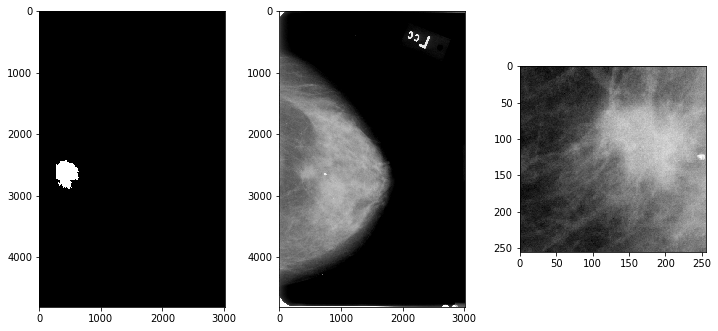

In [12]:
%pylab inline
fig,ax = subplots(1,3)
fig.set_size_inches([10, 8])
ax[0].imshow(mass_mask_img2, cmap='gray')
ax[1].imshow(mass_img1, cmap='gray')
ax[2].imshow(train_mass_patch[0].reshape(256, 256), cmap='gray')
fig.tight_layout()

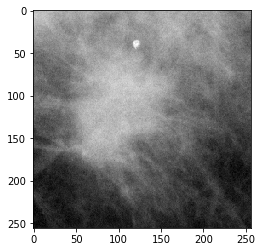

In [11]:
plt.imshow(train_mass_patch[0].reshape(256, 256), cmap='gray')


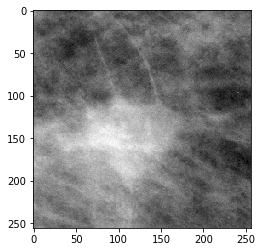

In [13]:
plt.imshow(train_mass_patch[4].reshape(256, 256), cmap='gray')

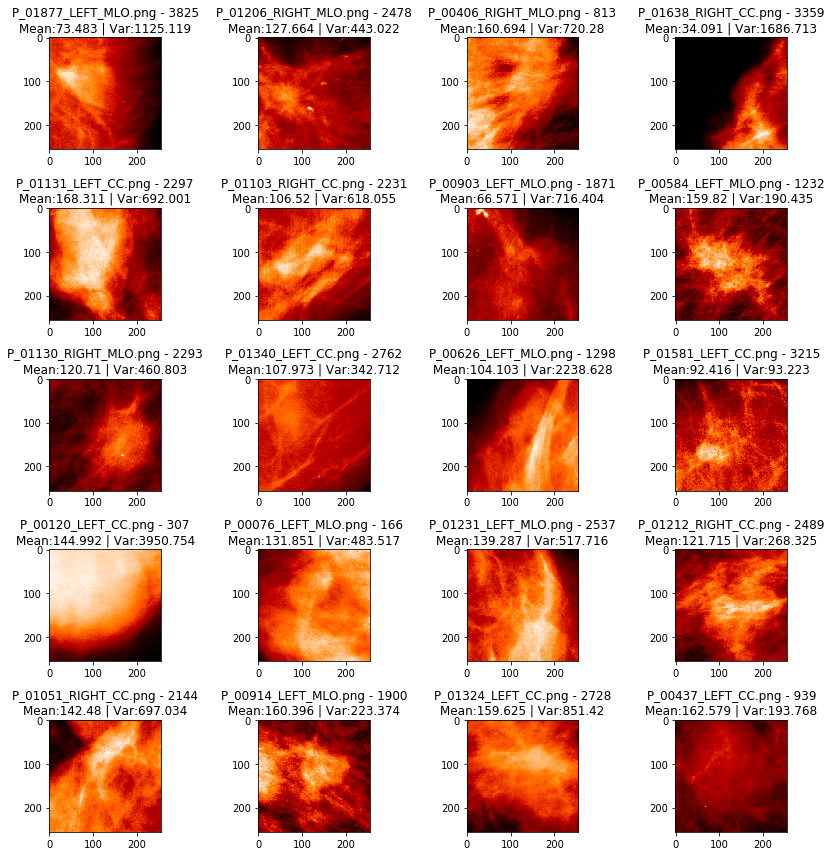

In [27]:
# random images 
N = 20
idx = random.sample(range(len(train_mass_patch)), k=N)
plt.figure(figsize=(12,12))
for i, j in enumerate(idx):
    plt.subplot(5,4,i+1)
    plt.imshow(train_mass_patch[j].reshape(256, 256), cmap='gist_heat')
    plt.title(train_mass_FN[j] + " - " + str(j)+ "\n" + "Mean:" + str(round(np.mean(train_mass_patch[j]),3)) + " | Var:" + str(round(np.var(train_mass_patch[j]),3)))
    plt.tight_layout()
plt.show()

In [8]:
print("ROI Mean Size:", np.mean(train_mass_roi_size))
print("ROI Min Size:", np.min(train_mass_roi_size))
print("ROI Max Size:", np.max(train_mass_roi_size))
print("ROI Size Std:", np.std(train_mass_roi_size))

ROI Mean Size: 363.0895295902883
ROI Min Size: 86
ROI Max Size: 1365
ROI Size Std: 156.78133346042827


In [8]:
print("ROI Mean Size:", np.mean(train_mass_roi_size))
print("ROI Min Size:", np.min(train_mass_roi_size))
print("ROI Max Size:", np.max(train_mass_roi_size))
print("ROI Size Std:", np.std(train_mass_roi_size))

ROI Mean Size: 363.0895295902883
ROI Min Size: 86
ROI Max Size: 1365
ROI Size Std: 156.78133346042827


In [9]:
np.save(os.path.join("Processed_abnorm_256", "train_mass_patch.npy"), train_mass_patch)
np.save(os.path.join("Processed_abnorm_256", "train_mass_Lbl.npy"), np.array(train_mass_Lbl))
np.save(os.path.join("Processed_abnorm_256", "train_mass_FN.npy"), train_mass_FN)
np.save(os.path.join("Processed_abnorm_256", "train_mass_roi_size.npy"), np.array(train_mass_roi_size))

## Train calc data

In [10]:
train_labels = pd.read_pickle(os.path.join("Processed_abnorm_256", "train_label.pkl"))
train_labels['IMAGE_NAME2'] = train_labels.index
train_labels = train_labels.drop_duplicates(['IMAGE_NAME2'])

## use a copy on the local drive to make testing faster
mask_dir = "CBIS_png/Train/Calc_MASK_imgs"
img_dir = "CBIS_png/Train/Calc_full_imgs"

train_calc_patch, train_calc_Lbl, train_calc_FN, train_calc_roi_size = \
        create_patches(mask_dir, img_dir, Lbls=train_labels, debug=True)
                                   

  0%|                                                                                         | 0/1547 [00:00<?, ?it/s]

Name error
Error FileNotFound: desktop.ini
Mask P_00005_RIGHT_CC_1.png  Height: 549 Width: 637
ROI Big P_00005_RIGHT_CC_1.png


  0%|                                                                                 | 2/1547 [00:00<05:17,  4.86it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00005_RIGHT_MLO_12.png
Mask P_00005_RIGHT_MLO_12.png  Height: 509 Width: 641
ROI Big P_00005_RIGHT_MLO_12.png


  0%|▏                                                                                | 3/1547 [00:00<07:35,  3.39it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00007_LEFT_CC_12.png
Mask P_00007_LEFT_CC_12.png  Height: 641 Width: 537
ROI Big P_00007_LEFT_CC_12.png


  0%|▏                                                                                | 4/1547 [00:01<09:13,  2.79it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00007_LEFT_MLO_12.png
Mask P_00007_LEFT_MLO_12.png  Height: 649 Width: 721
ROI Big P_00007_LEFT_MLO_12.png


  0%|▎                                                                                | 5/1547 [00:01<10:43,  2.40it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00008_LEFT_CC_12.png
Mask P_00008_LEFT_CC_12.png  Height: 121 Width: 137
ROI small P_00008_LEFT_CC_12.png


  0%|▎                                                                                | 6/1547 [00:02<11:20,  2.27it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00008_LEFT_CC_22.png
Mask P_00008_LEFT_CC_22.png  Height: 129 Width: 137
ROI small P_00008_LEFT_CC_22.png


  0%|▎                                                                                | 7/1547 [00:02<11:29,  2.23it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00008_LEFT_CC_32.png
Mask P_00008_LEFT_CC_32.png  Height: 73 Width: 105
ROI small P_00008_LEFT_CC_32.png


  1%|▍                                                                                | 8/1547 [00:03<11:43,  2.19it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00008_LEFT_MLO_12.png
Mask P_00008_LEFT_MLO_12.png  Height: 89 Width: 97
ROI small P_00008_LEFT_MLO_12.png


  1%|▍                                                                                | 9/1547 [00:03<12:00,  2.14it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00008_LEFT_MLO_22.png
Mask P_00008_LEFT_MLO_22.png  Height: 105 Width: 89
ROI small P_00008_LEFT_MLO_22.png


  1%|▌                                                                               | 10/1547 [00:04<11:50,  2.16it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00008_LEFT_MLO_32.png
Mask P_00008_LEFT_MLO_32.png  Height: 81 Width: 105
ROI small P_00008_LEFT_MLO_32.png


  1%|▌                                                                               | 11/1547 [00:04<12:00,  2.13it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00008_RIGHT_CC_12.png
Mask P_00008_RIGHT_CC_12.png  Height: 233 Width: 209
ROI small P_00008_RIGHT_CC_12.png


  1%|▌                                                                               | 12/1547 [00:05<11:59,  2.13it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00008_RIGHT_CC_22.png
Mask P_00008_RIGHT_CC_22.png  Height: 105 Width: 129
ROI small P_00008_RIGHT_CC_22.png


  1%|▋                                                                               | 13/1547 [00:05<11:43,  2.18it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00008_RIGHT_CC_32.png
Mask P_00008_RIGHT_CC_32.png  Height: 113 Width: 97
ROI small P_00008_RIGHT_CC_32.png


  1%|▋                                                                               | 14/1547 [00:06<11:58,  2.13it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00008_RIGHT_CC_42.png
Mask P_00008_RIGHT_CC_42.png  Height: 73 Width: 89
ROI small P_00008_RIGHT_CC_42.png


  1%|▊                                                                               | 15/1547 [00:06<12:03,  2.12it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00008_RIGHT_CC_52.png
Mask P_00008_RIGHT_CC_52.png  Height: 89 Width: 121
ROI small P_00008_RIGHT_CC_52.png


  1%|▊                                                                               | 16/1547 [00:07<11:45,  2.17it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00008_RIGHT_MLO_12.png
Mask P_00008_RIGHT_MLO_12.png  Height: 241 Width: 113
ROI small P_00008_RIGHT_MLO_12.png


  1%|▉                                                                               | 17/1547 [00:07<12:12,  2.09it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00008_RIGHT_MLO_22.png
Mask P_00008_RIGHT_MLO_22.png  Height: 65 Width: 57
ROI small P_00008_RIGHT_MLO_22.png


  1%|▉                                                                               | 18/1547 [00:08<12:02,  2.11it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00008_RIGHT_MLO_32.png
Mask P_00008_RIGHT_MLO_32.png  Height: 73 Width: 81
ROI small P_00008_RIGHT_MLO_32.png


  1%|▉                                                                               | 19/1547 [00:08<12:04,  2.11it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00008_RIGHT_MLO_42.png
Mask P_00008_RIGHT_MLO_42.png  Height: 97 Width: 97
ROI small P_00008_RIGHT_MLO_42.png


  1%|█                                                                               | 20/1547 [00:09<11:55,  2.13it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00008_RIGHT_MLO_52.png
Mask P_00008_RIGHT_MLO_52.png  Height: 233 Width: 129
ROI small P_00008_RIGHT_MLO_52.png


  1%|█                                                                               | 21/1547 [00:09<11:52,  2.14it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00010_LEFT_CC_12.png
Mask P_00010_LEFT_CC_12.png  Height: 89 Width: 89
ROI small P_00010_LEFT_CC_12.png


  1%|█▏                                                                              | 22/1547 [00:09<11:53,  2.14it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00010_LEFT_MLO_12.png
Mask P_00010_LEFT_MLO_12.png  Height: 89 Width: 98
ROI small P_00010_LEFT_MLO_12.png


  1%|█▏                                                                              | 23/1547 [00:10<11:52,  2.14it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00011_LEFT_CC_12.png
Mask P_00011_LEFT_CC_12.png  Height: 257 Width: 417
ROI small P_00011_LEFT_CC_12.png


  2%|█▏                                                                              | 24/1547 [00:10<11:48,  2.15it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00011_LEFT_MLO_12.png
Mask P_00011_LEFT_MLO_12.png  Height: 193 Width: 297
ROI small P_00011_LEFT_MLO_12.png


  2%|█▎                                                                              | 25/1547 [00:11<12:03,  2.10it/s]

Mask P_00012_LEFT_CC_12.png  Height: 825 Width: 937
ROI Big P_00012_LEFT_CC_12.png


  2%|█▎                                                                              | 26/1547 [00:12<13:07,  1.93it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00012_LEFT_MLO_12.png
Mask P_00012_LEFT_MLO_12.png  Height: 737 Width: 1001
ROI Big P_00012_LEFT_MLO_12.png


  2%|█▍                                                                              | 27/1547 [00:12<14:19,  1.77it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00013_RIGHT_MLO_12.png
Mask P_00013_RIGHT_MLO_12.png  Height: 513 Width: 617
ROI Big P_00013_RIGHT_MLO_12.png


  2%|█▍                                                                              | 28/1547 [00:13<14:52,  1.70it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00014_LEFT_CC_12.png
Mask P_00014_LEFT_CC_12.png  Height: 289 Width: 297
ROI small P_00014_LEFT_CC_12.png


  2%|█▍                                                                              | 29/1547 [00:13<13:54,  1.82it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00014_LEFT_MLO_12.png
Mask P_00014_LEFT_MLO_12.png  Height: 249 Width: 209
ROI small P_00014_LEFT_MLO_12.png


  2%|█▌                                                                              | 30/1547 [00:14<13:22,  1.89it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00016_LEFT_CC_22.png
Mask P_00016_LEFT_CC_22.png  Height: 401 Width: 513
ROI Big P_00016_LEFT_CC_22.png


  2%|█▌                                                                              | 31/1547 [00:14<11:28,  2.20it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00016_LEFT_MLO_22.png
Mask P_00016_LEFT_MLO_22.png  Height: 425 Width: 409
ROI small P_00016_LEFT_MLO_22.png


  2%|█▋                                                                              | 32/1547 [00:14<11:02,  2.29it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00019_RIGHT_CC_12.png
Mask P_00019_RIGHT_CC_12.png  Height: 633 Width: 457
ROI Big P_00019_RIGHT_CC_12.png


  2%|█▋                                                                              | 33/1547 [00:15<12:41,  1.99it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00019_RIGHT_MLO_12.png
Mask P_00019_RIGHT_MLO_12.png  Height: 817 Width: 681
ROI Big P_00019_RIGHT_MLO_12.png


  2%|█▊                                                                              | 34/1547 [00:16<14:42,  1.72it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00020_LEFT_CC_12.png
Mask P_00020_LEFT_CC_12.png  Height: 289 Width: 377
ROI small P_00020_LEFT_CC_12.png


  2%|█▊                                                                              | 35/1547 [00:16<13:11,  1.91it/s]

Mask P_00020_LEFT_MLO_12.png  Height: 337 Width: 313
ROI small P_00020_LEFT_MLO_12.png


  2%|█▊                                                                              | 36/1547 [00:17<12:03,  2.09it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00022_LEFT_CC_12.png
Mask P_00022_LEFT_CC_12.png  Height: 369 Width: 385
ROI small P_00022_LEFT_CC_12.png


  2%|█▉                                                                              | 37/1547 [00:17<11:54,  2.11it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00022_LEFT_MLO_12.png
Mask P_00022_LEFT_MLO_12.png  Height: 329 Width: 377
ROI small P_00022_LEFT_MLO_12.png


  2%|█▉                                                                              | 38/1547 [00:18<11:59,  2.10it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00024_LEFT_CC_12.png
Mask P_00024_LEFT_CC_12.png  Height: 129 Width: 185
ROI small P_00024_LEFT_CC_12.png


  3%|██                                                                              | 39/1547 [00:18<12:16,  2.05it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00024_LEFT_MLO_12.png
Mask P_00024_LEFT_MLO_12.png  Height: 177 Width: 137
ROI small P_00024_LEFT_MLO_12.png


  3%|██                                                                              | 40/1547 [00:19<13:00,  1.93it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00028_LEFT_MLO_12.png
Mask P_00028_LEFT_MLO_12.png  Height: 121 Width: 97
ROI small P_00028_LEFT_MLO_12.png


  3%|██                                                                              | 41/1547 [00:19<12:18,  2.04it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00029_LEFT_CC_12.png
Mask P_00029_LEFT_CC_12.png  Height: 265 Width: 185
ROI small P_00029_LEFT_CC_12.png


  3%|██▏                                                                             | 42/1547 [00:20<13:30,  1.86it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00029_LEFT_MLO_12.png
Mask P_00029_LEFT_MLO_12.png  Height: 217 Width: 169
ROI small P_00029_LEFT_MLO_12.png


  3%|██▏                                                                             | 43/1547 [00:20<14:26,  1.74it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00030_LEFT_CC_12.png
Mask P_00030_LEFT_CC_12.png  Height: 97 Width: 97
ROI small P_00030_LEFT_CC_12.png


  3%|██▎                                                                             | 44/1547 [00:21<13:19,  1.88it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00030_LEFT_CC_22.png
Mask P_00030_LEFT_CC_22.png  Height: 657 Width: 377
ROI Big P_00030_LEFT_CC_22.png


  3%|██▎                                                                             | 45/1547 [00:21<12:33,  1.99it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00030_LEFT_MLO_12.png
Mask P_00030_LEFT_MLO_12.png  Height: 113 Width: 97
ROI small P_00030_LEFT_MLO_12.png


  3%|██▍                                                                             | 46/1547 [00:22<12:08,  2.06it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00030_LEFT_MLO_22.png
Mask P_00030_LEFT_MLO_22.png  Height: 689 Width: 417
ROI Big P_00030_LEFT_MLO_22.png


  3%|██▍                                                                             | 47/1547 [00:22<11:53,  2.10it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00030_RIGHT_CC_12.png
Mask P_00030_RIGHT_CC_12.png  Height: 457 Width: 1028
ROI Big P_00030_RIGHT_CC_12.png


  3%|██▍                                                                             | 48/1547 [00:23<11:36,  2.15it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00030_RIGHT_MLO_12.png
Mask P_00030_RIGHT_MLO_12.png  Height: 833 Width: 1265
ROI Big P_00030_RIGHT_MLO_12.png


  3%|██▌                                                                             | 49/1547 [00:23<11:38,  2.15it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00031_LEFT_CC_12.png
Mask P_00031_LEFT_CC_12.png  Height: 153 Width: 145
ROI small P_00031_LEFT_CC_12.png


  3%|██▌                                                                             | 50/1547 [00:24<11:50,  2.11it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00034_RIGHT_CC_22.png
Mask P_00034_RIGHT_CC_22.png  Height: 433 Width: 249
ROI small P_00034_RIGHT_CC_22.png


  3%|██▋                                                                             | 51/1547 [00:24<13:15,  1.88it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00034_RIGHT_MLO_22.png
Mask P_00034_RIGHT_MLO_22.png  Height: 505 Width: 449
ROI small P_00034_RIGHT_MLO_22.png


  3%|██▋                                                                             | 52/1547 [00:25<14:44,  1.69it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00043_LEFT_MLO_12.png
Mask P_00043_LEFT_MLO_12.png  Height: 889 Width: 849
ROI Big P_00043_LEFT_MLO_12.png


  3%|██▋                                                                             | 53/1547 [00:25<13:57,  1.78it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00047_LEFT_CC_12.png
Mask P_00047_LEFT_CC_12.png  Height: 89 Width: 73
ROI small P_00047_LEFT_CC_12.png


  3%|██▊                                                                             | 54/1547 [00:26<13:06,  1.90it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00047_LEFT_CC_22.png
Mask P_00047_LEFT_CC_22.png  Height: 113 Width: 81
ROI small P_00047_LEFT_CC_22.png


  4%|██▊                                                                             | 55/1547 [00:26<12:29,  1.99it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00047_LEFT_CC_32.png
Mask P_00047_LEFT_CC_32.png  Height: 105 Width: 105
ROI small P_00047_LEFT_CC_32.png


  4%|██▉                                                                             | 56/1547 [00:27<12:03,  2.06it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00047_LEFT_MLO_12.png
Mask P_00047_LEFT_MLO_12.png  Height: 105 Width: 113
ROI small P_00047_LEFT_MLO_12.png


  4%|██▉                                                                             | 57/1547 [00:27<12:04,  2.06it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00047_LEFT_MLO_22.png
Mask P_00047_LEFT_MLO_22.png  Height: 105 Width: 97
ROI small P_00047_LEFT_MLO_22.png


  4%|██▉                                                                             | 58/1547 [00:28<11:48,  2.10it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00047_LEFT_MLO_32.png
Mask P_00047_LEFT_MLO_32.png  Height: 105 Width: 105
ROI small P_00047_LEFT_MLO_32.png


  4%|███                                                                             | 59/1547 [00:28<11:39,  2.13it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00048_RIGHT_CC_12.png
Mask P_00048_RIGHT_CC_12.png  Height: 145 Width: 169
ROI small P_00048_RIGHT_CC_12.png


  4%|███                                                                             | 60/1547 [00:29<13:31,  1.83it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00048_RIGHT_CC_22.png
Mask P_00048_RIGHT_CC_22.png  Height: 193 Width: 153
ROI small P_00048_RIGHT_CC_22.png


  4%|███▏                                                                            | 61/1547 [00:30<14:49,  1.67it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00048_RIGHT_MLO_12.png
Mask P_00048_RIGHT_MLO_12.png  Height: 161 Width: 145
ROI small P_00048_RIGHT_MLO_12.png


  4%|███▏                                                                            | 62/1547 [00:30<15:42,  1.58it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00048_RIGHT_MLO_22.png
Mask P_00048_RIGHT_MLO_22.png  Height: 193 Width: 209
ROI small P_00048_RIGHT_MLO_22.png


  4%|███▎                                                                            | 63/1547 [00:31<16:11,  1.53it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00049_RIGHT_CC_12.png
Mask P_00049_RIGHT_CC_12.png  Height: 313 Width: 297
ROI small P_00049_RIGHT_CC_12.png


  4%|███▎                                                                            | 64/1547 [00:31<13:34,  1.82it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00049_RIGHT_MLO_12.png
Mask P_00049_RIGHT_MLO_12.png  Height: 209 Width: 289
ROI small P_00049_RIGHT_MLO_12.png


  4%|███▎                                                                            | 65/1547 [00:32<12:45,  1.94it/s]

Mask P_00060_RIGHT_CC_12.png  Height: 297 Width: 297
ROI small P_00060_RIGHT_CC_12.png


  4%|███▍                                                                            | 66/1547 [00:32<11:55,  2.07it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00060_RIGHT_MLO_12.png
Mask P_00060_RIGHT_MLO_12.png  Height: 281 Width: 273
ROI small P_00060_RIGHT_MLO_12.png


  4%|███▍                                                                            | 67/1547 [00:33<11:43,  2.11it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00062_LEFT_CC_12.png
Mask P_00062_LEFT_CC_12.png  Height: 337 Width: 217
ROI small P_00062_LEFT_CC_12.png


  4%|███▌                                                                            | 68/1547 [00:33<11:12,  2.20it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00062_LEFT_MLO_12.png
Mask P_00062_LEFT_MLO_12.png  Height: 377 Width: 225
ROI small P_00062_LEFT_MLO_12.png


  4%|███▌                                                                            | 69/1547 [00:34<10:50,  2.27it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00063_RIGHT_CC_12.png
Mask P_00063_RIGHT_CC_12.png  Height: 249 Width: 313
ROI small P_00063_RIGHT_CC_12.png


  5%|███▌                                                                            | 70/1547 [00:34<11:29,  2.14it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00063_RIGHT_MLO_12.png
Mask P_00063_RIGHT_MLO_12.png  Height: 241 Width: 281
ROI small P_00063_RIGHT_MLO_12.png


  5%|███▋                                                                            | 71/1547 [00:35<11:35,  2.12it/s]

Mask P_00071_RIGHT_CC_12.png  Height: 321 Width: 337
ROI small P_00071_RIGHT_CC_12.png


  5%|███▋                                                                            | 72/1547 [00:35<13:20,  1.84it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00071_RIGHT_MLO_12.png
Mask P_00071_RIGHT_MLO_12.png  Height: 377 Width: 321
ROI small P_00071_RIGHT_MLO_12.png


  5%|███▊                                                                            | 73/1547 [00:36<14:38,  1.68it/s]

Mask P_00078_LEFT_CC_12.png  Height: 225 Width: 345
ROI small P_00078_LEFT_CC_12.png


  5%|███▊                                                                            | 74/1547 [00:37<15:20,  1.60it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00078_LEFT_MLO_12.png
Mask P_00078_LEFT_MLO_12.png  Height: 361 Width: 265
ROI small P_00078_LEFT_MLO_12.png


  5%|███▉                                                                            | 75/1547 [00:37<16:32,  1.48it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00083_RIGHT_CC_12.png
Mask P_00083_RIGHT_CC_12.png  Height: 217 Width: 201
ROI small P_00083_RIGHT_CC_12.png


  5%|███▉                                                                            | 76/1547 [00:38<15:37,  1.57it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00084_LEFT_CC_12.png
Mask P_00084_LEFT_CC_12.png  Height: 667 Width: 585
ROI Big P_00084_LEFT_CC_12.png


  5%|███▉                                                                            | 77/1547 [00:38<14:39,  1.67it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00084_LEFT_MLO_12.png
Mask P_00084_LEFT_MLO_12.png  Height: 392 Width: 653
ROI Big P_00084_LEFT_MLO_12.png


  5%|████                                                                            | 78/1547 [00:39<14:25,  1.70it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00085_RIGHT_CC_12.png
Mask P_00085_RIGHT_CC_12.png  Height: 625 Width: 809
ROI Big P_00085_RIGHT_CC_12.png


  5%|████                                                                            | 79/1547 [00:40<13:20,  1.83it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00085_RIGHT_MLO_12.png
Mask P_00085_RIGHT_MLO_12.png  Height: 721 Width: 729
ROI Big P_00085_RIGHT_MLO_12.png


  5%|████▏                                                                           | 80/1547 [00:40<12:43,  1.92it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00088_LEFT_CC_12.png
Mask P_00088_LEFT_CC_12.png  Height: 126 Width: 146
ROI small P_00088_LEFT_CC_12.png


  5%|████▏                                                                           | 81/1547 [00:40<12:08,  2.01it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00088_LEFT_MLO_12.png
Mask P_00088_LEFT_MLO_12.png  Height: 151 Width: 156
ROI small P_00088_LEFT_MLO_12.png


  5%|████▏                                                                           | 82/1547 [00:41<12:01,  2.03it/s]

Mask P_00091_LEFT_CC_12.png  Height: 577 Width: 457
ROI Big P_00091_LEFT_CC_12.png


  5%|████▎                                                                           | 83/1547 [00:42<13:09,  1.85it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00091_LEFT_MLO_12.png
Mask P_00091_LEFT_MLO_12.png  Height: 473 Width: 409
ROI small P_00091_LEFT_MLO_12.png


  5%|████▎                                                                           | 84/1547 [00:42<13:54,  1.75it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00098_LEFT_CC_12.png
Mask P_00098_LEFT_CC_12.png  Height: 361 Width: 825
ROI Big P_00098_LEFT_CC_12.png


  5%|████▍                                                                           | 85/1547 [00:43<13:19,  1.83it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00098_LEFT_MLO_12.png
Mask P_00098_LEFT_MLO_12.png  Height: 705 Width: 657
ROI Big P_00098_LEFT_MLO_12.png


  6%|████▍                                                                           | 86/1547 [00:43<13:00,  1.87it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00098_LEFT_MLO_22.png
Mask P_00098_LEFT_MLO_22.png  Height: 369 Width: 345
ROI small P_00098_LEFT_MLO_22.png


  6%|████▍                                                                           | 87/1547 [00:44<12:47,  1.90it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00098_RIGHT_CC_12.png
Mask P_00098_RIGHT_CC_12.png  Height: 489 Width: 481
ROI small P_00098_RIGHT_CC_12.png


  6%|████▌                                                                           | 88/1547 [00:44<12:22,  1.96it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00098_RIGHT_MLO_12.png
Mask P_00098_RIGHT_MLO_12.png  Height: 241 Width: 268
ROI small P_00098_RIGHT_MLO_12.png


  6%|████▌                                                                           | 89/1547 [00:45<12:20,  1.97it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00098_RIGHT_MLO_22.png
Mask P_00098_RIGHT_MLO_22.png  Height: 665 Width: 761
ROI Big P_00098_RIGHT_MLO_22.png


  6%|████▋                                                                           | 90/1547 [00:45<12:08,  2.00it/s]

Mask P_00101_RIGHT_CC_22.png  Height: 913 Width: 761
ROI Big P_00101_RIGHT_CC_22.png


  6%|████▋                                                                           | 91/1547 [00:46<11:31,  2.11it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00101_RIGHT_MLO_22.png
Mask P_00101_RIGHT_MLO_22.png  Height: 921 Width: 649
ROI Big P_00101_RIGHT_MLO_22.png


  6%|████▊                                                                           | 92/1547 [00:46<11:30,  2.11it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00105_LEFT_CC_12.png
Mask P_00105_LEFT_CC_12.png  Height: 289 Width: 537
ROI Big P_00105_LEFT_CC_12.png


  6%|████▊                                                                           | 93/1547 [00:47<12:21,  1.96it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00105_LEFT_MLO_12.png
Mask P_00105_LEFT_MLO_12.png  Height: 521 Width: 473
ROI Big P_00105_LEFT_MLO_12.png


  6%|████▊                                                                           | 94/1547 [00:47<13:12,  1.83it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00106_RIGHT_CC_12.png
Mask P_00106_RIGHT_CC_12.png  Height: 80 Width: 105
ROI small P_00106_RIGHT_CC_12.png


  6%|████▉                                                                           | 95/1547 [00:48<14:33,  1.66it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00106_RIGHT_MLO_42.png
Mask P_00106_RIGHT_MLO_42.png  Height: 113 Width: 129
ROI small P_00106_RIGHT_MLO_42.png


  6%|████▉                                                                           | 96/1547 [00:49<15:17,  1.58it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00112_LEFT_CC_12.png
Mask P_00112_LEFT_CC_12.png  Height: 177 Width: 201
ROI small P_00112_LEFT_CC_12.png


  6%|█████                                                                           | 97/1547 [00:49<14:16,  1.69it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00112_LEFT_CC_22.png
Mask P_00112_LEFT_CC_22.png  Height: 161 Width: 137
ROI small P_00112_LEFT_CC_22.png


  6%|█████                                                                           | 98/1547 [00:50<13:05,  1.85it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00112_LEFT_CC_32.png
Mask P_00112_LEFT_CC_32.png  Height: 129 Width: 121
ROI small P_00112_LEFT_CC_32.png


  6%|█████                                                                           | 99/1547 [00:50<12:46,  1.89it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00112_LEFT_CC_42.png
Mask P_00112_LEFT_CC_42.png  Height: 145 Width: 129
ROI small P_00112_LEFT_CC_42.png


  6%|█████                                                                          | 100/1547 [00:51<12:13,  1.97it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00112_LEFT_MLO_12.png
Mask P_00112_LEFT_MLO_12.png  Height: 193 Width: 169
ROI small P_00112_LEFT_MLO_12.png


  7%|█████▏                                                                         | 101/1547 [00:51<11:57,  2.02it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00112_LEFT_MLO_22.png
Mask P_00112_LEFT_MLO_22.png  Height: 178 Width: 201
ROI small P_00112_LEFT_MLO_22.png


  7%|█████▏                                                                         | 102/1547 [00:52<11:42,  2.06it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00112_LEFT_MLO_32.png
Mask P_00112_LEFT_MLO_32.png  Height: 129 Width: 137
ROI small P_00112_LEFT_MLO_32.png


  7%|█████▎                                                                         | 103/1547 [00:52<11:19,  2.13it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00112_LEFT_MLO_42.png
Mask P_00112_LEFT_MLO_42.png  Height: 129 Width: 153
ROI small P_00112_LEFT_MLO_42.png


  7%|█████▎                                                                         | 104/1547 [00:52<11:12,  2.15it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00112_LEFT_MLO_52.png
Mask P_00112_LEFT_MLO_52.png  Height: 137 Width: 129
ROI small P_00112_LEFT_MLO_52.png


  7%|█████▎                                                                         | 105/1547 [00:53<11:08,  2.16it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00112_LEFT_MLO_62.png
Mask P_00112_LEFT_MLO_62.png  Height: 161 Width: 177
ROI small P_00112_LEFT_MLO_62.png


  7%|█████▍                                                                         | 106/1547 [00:53<11:12,  2.14it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00112_RIGHT_CC_12.png
Mask P_00112_RIGHT_CC_12.png  Height: 121 Width: 129
ROI small P_00112_RIGHT_CC_12.png


  7%|█████▍                                                                         | 107/1547 [00:54<11:24,  2.10it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00112_RIGHT_CC_22.png
Mask P_00112_RIGHT_CC_22.png  Height: 129 Width: 153
ROI small P_00112_RIGHT_CC_22.png


  7%|█████▌                                                                         | 108/1547 [00:54<11:26,  2.10it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00112_RIGHT_CC_32.png
Mask P_00112_RIGHT_CC_32.png  Height: 89 Width: 153
ROI small P_00112_RIGHT_CC_32.png


  7%|█████▌                                                                         | 109/1547 [00:55<11:28,  2.09it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00112_RIGHT_CC_42.png
Mask P_00112_RIGHT_CC_42.png  Height: 121 Width: 153
ROI small P_00112_RIGHT_CC_42.png


  7%|█████▌                                                                         | 110/1547 [00:55<11:09,  2.15it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00112_RIGHT_CC_52.png
Mask P_00112_RIGHT_CC_52.png  Height: 129 Width: 113
ROI small P_00112_RIGHT_CC_52.png


  7%|█████▋                                                                         | 111/1547 [00:56<11:06,  2.16it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00112_RIGHT_CC_62.png
Mask P_00112_RIGHT_CC_62.png  Height: 201 Width: 145
ROI small P_00112_RIGHT_CC_62.png


  7%|█████▋                                                                         | 112/1547 [00:56<10:54,  2.19it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00112_RIGHT_MLO_12.png
Mask P_00112_RIGHT_MLO_12.png  Height: 145 Width: 161
ROI small P_00112_RIGHT_MLO_12.png


  7%|█████▊                                                                         | 113/1547 [00:57<11:01,  2.17it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00112_RIGHT_MLO_22.png
Mask P_00112_RIGHT_MLO_22.png  Height: 153 Width: 113
ROI small P_00112_RIGHT_MLO_22.png


  7%|█████▊                                                                         | 114/1547 [00:57<11:00,  2.17it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00112_RIGHT_MLO_32.png
Mask P_00112_RIGHT_MLO_32.png  Height: 113 Width: 121
ROI small P_00112_RIGHT_MLO_32.png


  7%|█████▊                                                                         | 115/1547 [00:57<10:55,  2.19it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00112_RIGHT_MLO_42.png
Mask P_00112_RIGHT_MLO_42.png  Height: 161 Width: 137
ROI small P_00112_RIGHT_MLO_42.png


  7%|█████▉                                                                         | 116/1547 [00:58<10:56,  2.18it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00112_RIGHT_MLO_52.png
Mask P_00112_RIGHT_MLO_52.png  Height: 129 Width: 145
ROI small P_00112_RIGHT_MLO_52.png


  8%|█████▉                                                                         | 117/1547 [00:58<11:12,  2.13it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00112_RIGHT_MLO_62.png
Mask P_00112_RIGHT_MLO_62.png  Height: 185 Width: 177
ROI small P_00112_RIGHT_MLO_62.png


  8%|██████                                                                         | 118/1547 [00:59<11:10,  2.13it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00112_RIGHT_MLO_72.png
Mask P_00112_RIGHT_MLO_72.png  Height: 113 Width: 113
ROI small P_00112_RIGHT_MLO_72.png


  8%|██████                                                                         | 119/1547 [00:59<11:02,  2.16it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00121_LEFT_CC_12.png
Mask P_00121_LEFT_CC_12.png  Height: 225 Width: 169
ROI small P_00121_LEFT_CC_12.png


  8%|██████▏                                                                        | 120/1547 [01:00<11:21,  2.10it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00121_LEFT_MLO_12.png
Mask P_00121_LEFT_MLO_12.png  Height: 201 Width: 185
ROI small P_00121_LEFT_MLO_12.png


  8%|██████▏                                                                        | 121/1547 [01:00<11:30,  2.06it/s]

Mask P_00123_LEFT_CC_12.png  Height: 185 Width: 233
ROI small P_00123_LEFT_CC_12.png


  8%|██████▏                                                                        | 122/1547 [01:01<11:07,  2.13it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00123_LEFT_MLO_12.png
Mask P_00123_LEFT_MLO_12.png  Height: 249 Width: 241
ROI small P_00123_LEFT_MLO_12.png


  8%|██████▎                                                                        | 123/1547 [01:01<11:04,  2.14it/s]

Mask P_00129_LEFT_CC_12.png  Height: 561 Width: 329
ROI Big P_00129_LEFT_CC_12.png


  8%|██████▎                                                                        | 124/1547 [01:02<12:20,  1.92it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00129_LEFT_MLO_12.png
Mask P_00129_LEFT_MLO_12.png  Height: 497 Width: 325
ROI small P_00129_LEFT_MLO_12.png


  8%|██████▍                                                                        | 125/1547 [01:03<13:26,  1.76it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00136_LEFT_CC_12.png
Mask P_00136_LEFT_CC_12.png  Height: 361 Width: 369
ROI small P_00136_LEFT_CC_12.png


  8%|██████▍                                                                        | 126/1547 [01:03<12:36,  1.88it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00136_LEFT_MLO_12.png
Mask P_00136_LEFT_MLO_12.png  Height: 297 Width: 273
ROI small P_00136_LEFT_MLO_12.png


  8%|██████▍                                                                        | 127/1547 [01:04<12:02,  1.97it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00136_LEFT_MLO_22.png
Mask P_00136_LEFT_MLO_22.png  Height: 441 Width: 261
ROI small P_00136_LEFT_MLO_22.png


  8%|██████▌                                                                        | 128/1547 [01:04<11:39,  2.03it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00151_RIGHT_MLO_12.png
Mask P_00151_RIGHT_MLO_12.png  Height: 993 Width: 681
ROI Big P_00151_RIGHT_MLO_12.png


  8%|██████▌                                                                        | 129/1547 [01:04<11:33,  2.05it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00157_LEFT_CC_12.png
Mask P_00157_LEFT_CC_12.png  Height: 177 Width: 217
ROI small P_00157_LEFT_CC_12.png


  8%|██████▋                                                                        | 130/1547 [01:05<11:33,  2.04it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00157_LEFT_CC_22.png
Mask P_00157_LEFT_CC_22.png  Height: 185 Width: 201
ROI small P_00157_LEFT_CC_22.png


  8%|██████▋                                                                        | 131/1547 [01:05<11:24,  2.07it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00157_LEFT_MLO_12.png
Mask P_00157_LEFT_MLO_12.png  Height: 161 Width: 121
ROI small P_00157_LEFT_MLO_12.png


  9%|██████▋                                                                        | 132/1547 [01:06<11:27,  2.06it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00157_LEFT_MLO_22.png
Mask P_00157_LEFT_MLO_22.png  Height: 153 Width: 177
ROI small P_00157_LEFT_MLO_22.png


  9%|██████▊                                                                        | 133/1547 [01:06<11:31,  2.05it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00157_LEFT_MLO_32.png
Mask P_00157_LEFT_MLO_32.png  Height: 129 Width: 145
ROI small P_00157_LEFT_MLO_32.png


  9%|██████▊                                                                        | 134/1547 [01:07<11:28,  2.05it/s]

Mask P_00159_LEFT_CC_12.png  Height: 257 Width: 289
ROI small P_00159_LEFT_CC_12.png


  9%|██████▉                                                                        | 135/1547 [01:08<13:08,  1.79it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00159_LEFT_MLO_12.png
Mask P_00159_LEFT_MLO_12.png  Height: 305 Width: 297
ROI small P_00159_LEFT_MLO_12.png


  9%|██████▉                                                                        | 136/1547 [01:08<14:33,  1.62it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00161_LEFT_MLO_12.png
Mask P_00161_LEFT_MLO_12.png  Height: 1089 Width: 873
ROI Big P_00161_LEFT_MLO_12.png


  9%|██████▉                                                                        | 137/1547 [01:09<14:09,  1.66it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00162_LEFT_CC_12.png
Mask P_00162_LEFT_CC_12.png  Height: 136 Width: 320
ROI small P_00162_LEFT_CC_12.png


  9%|███████                                                                        | 138/1547 [01:10<15:15,  1.54it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00162_LEFT_MLO_12.png
Mask P_00162_LEFT_MLO_12.png  Height: 262 Width: 184
ROI small P_00162_LEFT_MLO_12.png


  9%|███████                                                                        | 139/1547 [01:10<16:24,  1.43it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00179_LEFT_CC_12.png
Mask P_00179_LEFT_CC_12.png  Height: 377 Width: 305
ROI small P_00179_LEFT_CC_12.png


  9%|███████▏                                                                       | 140/1547 [01:11<16:11,  1.45it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00179_LEFT_MLO_12.png
Mask P_00179_LEFT_MLO_12.png  Height: 593 Width: 545
ROI Big P_00179_LEFT_MLO_12.png


  9%|███████▏                                                                       | 141/1547 [01:12<16:56,  1.38it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00181_RIGHT_CC_12.png
Mask P_00181_RIGHT_CC_12.png  Height: 369 Width: 353
ROI small P_00181_RIGHT_CC_12.png


  9%|███████▎                                                                       | 142/1547 [01:12<13:54,  1.68it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00181_RIGHT_MLO_12.png
Mask P_00181_RIGHT_MLO_12.png  Height: 257 Width: 473
ROI small P_00181_RIGHT_MLO_12.png


  9%|███████▎                                                                       | 143/1547 [01:13<12:52,  1.82it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00182_LEFT_CC_12.png
Mask P_00182_LEFT_CC_12.png  Height: 357 Width: 421
ROI small P_00182_LEFT_CC_12.png


  9%|███████▎                                                                       | 144/1547 [01:14<15:22,  1.52it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00182_LEFT_MLO_12.png
Mask P_00182_LEFT_MLO_12.png  Height: 489 Width: 473
ROI small P_00182_LEFT_MLO_12.png


  9%|███████▍                                                                       | 145/1547 [01:15<17:59,  1.30it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00183_RIGHT_MLO_12.png
Mask P_00183_RIGHT_MLO_12.png  Height: 329 Width: 281
ROI small P_00183_RIGHT_MLO_12.png


  9%|███████▍                                                                       | 146/1547 [01:15<15:56,  1.47it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00185_LEFT_CC_12.png
Mask P_00185_LEFT_CC_12.png  Height: 193 Width: 353
ROI small P_00185_LEFT_CC_12.png


 10%|███████▌                                                                       | 147/1547 [01:16<14:25,  1.62it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00185_LEFT_MLO_12.png
Mask P_00185_LEFT_MLO_12.png  Height: 161 Width: 313
ROI small P_00185_LEFT_MLO_12.png


 10%|███████▌                                                                       | 148/1547 [01:16<13:53,  1.68it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00188_RIGHT_MLO_12.png
Mask P_00188_RIGHT_MLO_12.png  Height: 321 Width: 361
ROI small P_00188_RIGHT_MLO_12.png


 10%|███████▌                                                                       | 149/1547 [01:17<13:26,  1.73it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00189_LEFT_CC_12.png
Mask P_00189_LEFT_CC_12.png  Height: 329 Width: 401
ROI small P_00189_LEFT_CC_12.png


 10%|███████▋                                                                       | 150/1547 [01:17<12:39,  1.84it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00189_LEFT_MLO_12.png
Mask P_00189_LEFT_MLO_12.png  Height: 313 Width: 441
ROI small P_00189_LEFT_MLO_12.png


 10%|███████▋                                                                       | 151/1547 [01:18<12:25,  1.87it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00196_RIGHT_CC_12.png
Mask P_00196_RIGHT_CC_12.png  Height: 105 Width: 105
ROI small P_00196_RIGHT_CC_12.png


 10%|███████▊                                                                       | 152/1547 [01:18<11:34,  2.01it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00196_RIGHT_MLO_12.png
Mask P_00196_RIGHT_MLO_12.png  Height: 105 Width: 105
ROI small P_00196_RIGHT_MLO_12.png


 10%|███████▊                                                                       | 153/1547 [01:18<11:09,  2.08it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00197_RIGHT_CC_12.png
Mask P_00197_RIGHT_CC_12.png  Height: 1081 Width: 665
ROI Big P_00197_RIGHT_CC_12.png


 10%|███████▊                                                                       | 154/1547 [01:19<12:51,  1.81it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00197_RIGHT_MLO_12.png
Mask P_00197_RIGHT_MLO_12.png  Height: 449 Width: 793
ROI Big P_00197_RIGHT_MLO_12.png


 10%|███████▉                                                                       | 155/1547 [01:20<13:57,  1.66it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00201_LEFT_MLO_12.png
Mask P_00201_LEFT_MLO_12.png  Height: 1489 Width: 929
ROI Big P_00201_LEFT_MLO_12.png


 10%|███████▉                                                                       | 156/1547 [01:21<15:07,  1.53it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00208_RIGHT_CC_12.png
Mask P_00208_RIGHT_CC_12.png  Height: 473 Width: 361
ROI small P_00208_RIGHT_CC_12.png


 10%|████████                                                                       | 157/1547 [01:21<15:33,  1.49it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00208_RIGHT_CC_22.png
Mask P_00208_RIGHT_CC_22.png  Height: 689 Width: 641
ROI Big P_00208_RIGHT_CC_22.png


 10%|████████                                                                       | 158/1547 [01:22<15:52,  1.46it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00208_RIGHT_MLO_12.png
Mask P_00208_RIGHT_MLO_12.png  Height: 433 Width: 457
ROI small P_00208_RIGHT_MLO_12.png


 10%|████████                                                                       | 159/1547 [01:23<16:12,  1.43it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00208_RIGHT_MLO_22.png
Mask P_00208_RIGHT_MLO_22.png  Height: 537 Width: 393
ROI Big P_00208_RIGHT_MLO_22.png


 10%|████████▏                                                                      | 160/1547 [01:24<16:30,  1.40it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00220_LEFT_CC_12.png
Mask P_00220_LEFT_CC_12.png  Height: 537 Width: 689
ROI Big P_00220_LEFT_CC_12.png


 10%|████████▏                                                                      | 161/1547 [01:24<16:13,  1.42it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00220_LEFT_MLO_12.png
Mask P_00220_LEFT_MLO_12.png  Height: 609 Width: 593
ROI Big P_00220_LEFT_MLO_12.png


 10%|████████▎                                                                      | 162/1547 [01:25<16:05,  1.44it/s]

Mask P_00224_LEFT_CC_22.png  Height: 289 Width: 321
ROI small P_00224_LEFT_CC_22.png


 11%|████████▎                                                                      | 163/1547 [01:25<14:02,  1.64it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00224_LEFT_MLO_22.png
Mask P_00224_LEFT_MLO_22.png  Height: 369 Width: 297
ROI small P_00224_LEFT_MLO_22.png


 11%|████████▎                                                                      | 164/1547 [01:26<12:39,  1.82it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00232_RIGHT_CC_12.png
Mask P_00232_RIGHT_CC_12.png  Height: 225 Width: 129
ROI small P_00232_RIGHT_CC_12.png


 11%|████████▍                                                                      | 165/1547 [01:26<10:40,  2.16it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00232_RIGHT_MLO_12.png
Mask P_00232_RIGHT_MLO_12.png  Height: 161 Width: 225
ROI small P_00232_RIGHT_MLO_12.png


 11%|████████▍                                                                      | 166/1547 [01:26<10:05,  2.28it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00243_LEFT_CC_12.png
Mask P_00243_LEFT_CC_12.png  Height: 986 Width: 846
ROI Big P_00243_LEFT_CC_12.png


 11%|████████▌                                                                      | 167/1547 [01:27<10:11,  2.26it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00243_LEFT_MLO_12.png
Mask P_00243_LEFT_MLO_12.png  Height: 745 Width: 875
ROI Big P_00243_LEFT_MLO_12.png


 11%|████████▌                                                                      | 168/1547 [01:27<10:42,  2.15it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00245_RIGHT_MLO_12.png
Mask P_00245_RIGHT_MLO_12.png  Height: 185 Width: 329
ROI small P_00245_RIGHT_MLO_12.png


 11%|████████▋                                                                      | 169/1547 [01:28<11:45,  1.95it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00250_LEFT_MLO_12.png
Mask P_00250_LEFT_MLO_12.png  Height: 105 Width: 62
ROI small P_00250_LEFT_MLO_12.png


 11%|████████▋                                                                      | 170/1547 [01:28<11:23,  2.02it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00251_RIGHT_CC_12.png
Mask P_00251_RIGHT_CC_12.png  Height: 321 Width: 329
ROI small P_00251_RIGHT_CC_12.png


 11%|████████▋                                                                      | 171/1547 [01:29<11:40,  1.97it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00251_RIGHT_MLO_12.png
Mask P_00251_RIGHT_MLO_12.png  Height: 369 Width: 433
ROI small P_00251_RIGHT_MLO_12.png


 11%|████████▊                                                                      | 172/1547 [01:30<11:49,  1.94it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00255_RIGHT_CC_12.png
Mask P_00255_RIGHT_CC_12.png  Height: 385 Width: 617
ROI Big P_00255_RIGHT_CC_12.png


 11%|████████▊                                                                      | 173/1547 [01:30<12:00,  1.91it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00255_RIGHT_MLO_12.png
Mask P_00255_RIGHT_MLO_12.png  Height: 705 Width: 841
ROI Big P_00255_RIGHT_MLO_12.png


 11%|████████▉                                                                      | 174/1547 [01:31<12:18,  1.86it/s]

Mask P_00256_LEFT_CC_12.png  Height: 153 Width: 153
ROI small P_00256_LEFT_CC_12.png


 11%|████████▉                                                                      | 175/1547 [01:31<11:39,  1.96it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00256_LEFT_MLO_12.png
Mask P_00256_LEFT_MLO_12.png  Height: 193 Width: 185
ROI small P_00256_LEFT_MLO_12.png


 11%|████████▉                                                                      | 176/1547 [01:32<11:17,  2.02it/s]

Mask P_00260_RIGHT_CC_12.png  Height: 257 Width: 193
ROI small P_00260_RIGHT_CC_12.png


 11%|█████████                                                                      | 177/1547 [01:32<12:16,  1.86it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00260_RIGHT_MLO_12.png
Mask P_00260_RIGHT_MLO_12.png  Height: 401 Width: 337
ROI small P_00260_RIGHT_MLO_12.png


 12%|█████████                                                                      | 178/1547 [01:33<13:17,  1.72it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00263_LEFT_MLO_12.png
Mask P_00263_LEFT_MLO_12.png  Height: 391 Width: 561
ROI Big P_00263_LEFT_MLO_12.png


 12%|█████████▏                                                                     | 179/1547 [01:34<14:12,  1.61it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00266_LEFT_CC_12.png
Mask P_00266_LEFT_CC_12.png  Height: 2993 Width: 2757
ROI Big P_00266_LEFT_CC_12.png


 12%|█████████▏                                                                     | 180/1547 [01:34<14:46,  1.54it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00266_LEFT_MLO_12.png
Mask P_00266_LEFT_MLO_12.png  Height: 3777 Width: 2741
ROI Big P_00266_LEFT_MLO_12.png


 12%|█████████▏                                                                     | 181/1547 [01:35<15:36,  1.46it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00268_LEFT_CC_12.png
Mask P_00268_LEFT_CC_12.png  Height: 2469 Width: 813
ROI Big P_00268_LEFT_CC_12.png


 12%|█████████▎                                                                     | 182/1547 [01:36<13:45,  1.65it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00268_LEFT_MLO_12.png
Mask P_00268_LEFT_MLO_12.png  Height: 2409 Width: 1037
ROI Big P_00268_LEFT_MLO_12.png


 12%|█████████▎                                                                     | 183/1547 [01:36<12:44,  1.79it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00269_LEFT_CC_12.png
Mask P_00269_LEFT_CC_12.png  Height: 193 Width: 345
ROI small P_00269_LEFT_CC_12.png


 12%|█████████▍                                                                     | 184/1547 [01:36<11:55,  1.90it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00269_LEFT_MLO_12.png
Mask P_00269_LEFT_MLO_12.png  Height: 201 Width: 273
ROI small P_00269_LEFT_MLO_12.png


 12%|█████████▍                                                                     | 185/1547 [01:37<12:03,  1.88it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00270_LEFT_CC_12.png
Mask P_00270_LEFT_CC_12.png  Height: 857 Width: 529
ROI Big P_00270_LEFT_CC_12.png


 12%|█████████▍                                                                     | 186/1547 [01:37<11:42,  1.94it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00270_LEFT_MLO_12.png
Mask P_00270_LEFT_MLO_12.png  Height: 553 Width: 873
ROI Big P_00270_LEFT_MLO_12.png


 12%|█████████▌                                                                     | 187/1547 [01:38<11:48,  1.92it/s]

Mask P_00271_LEFT_CC_12.png  Height: 1625 Width: 1601
ROI Big P_00271_LEFT_CC_12.png


 12%|█████████▌                                                                     | 188/1547 [01:38<11:09,  2.03it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00271_LEFT_MLO_12.png
Mask P_00271_LEFT_MLO_12.png  Height: 1497 Width: 1501
ROI Big P_00271_LEFT_MLO_12.png


 12%|█████████▋                                                                     | 189/1547 [01:39<10:58,  2.06it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00274_RIGHT_MLO_12.png
Mask P_00274_RIGHT_MLO_12.png  Height: 113 Width: 145
ROI small P_00274_RIGHT_MLO_12.png


 12%|█████████▋                                                                     | 190/1547 [01:40<13:02,  1.73it/s]

Mask P_00275_LEFT_CC_12.png  Height: 306 Width: 137
ROI small P_00275_LEFT_CC_12.png


 12%|█████████▊                                                                     | 191/1547 [01:40<12:09,  1.86it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00275_LEFT_MLO_12.png
Mask P_00275_LEFT_MLO_12.png  Height: 345 Width: 301
ROI small P_00275_LEFT_MLO_12.png


 12%|█████████▊                                                                     | 192/1547 [01:41<11:36,  1.94it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00276_RIGHT_CC_12.png
Mask P_00276_RIGHT_CC_12.png  Height: 201 Width: 241
ROI small P_00276_RIGHT_CC_12.png


 12%|█████████▊                                                                     | 193/1547 [01:41<11:20,  1.99it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00276_RIGHT_MLO_12.png
Mask P_00276_RIGHT_MLO_12.png  Height: 217 Width: 257
ROI small P_00276_RIGHT_MLO_12.png


 13%|█████████▉                                                                     | 194/1547 [01:42<11:35,  1.94it/s]

Mask P_00280_LEFT_CC_12.png  Height: 633 Width: 1177
ROI Big P_00280_LEFT_CC_12.png


 13%|█████████▉                                                                     | 195/1547 [01:42<12:43,  1.77it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00280_LEFT_MLO_12.png
Mask P_00280_LEFT_MLO_12.png  Height: 481 Width: 905
ROI Big P_00280_LEFT_MLO_12.png


 13%|██████████                                                                     | 196/1547 [01:43<13:52,  1.62it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00282_LEFT_CC_12.png
Mask P_00282_LEFT_CC_12.png  Height: 433 Width: 593
ROI Big P_00282_LEFT_CC_12.png


 13%|██████████                                                                     | 197/1547 [01:44<13:22,  1.68it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00282_LEFT_MLO_12.png
Mask P_00282_LEFT_MLO_12.png  Height: 497 Width: 513
ROI Big P_00282_LEFT_MLO_12.png


 13%|██████████                                                                     | 198/1547 [01:44<12:41,  1.77it/s]

Mask P_00284_LEFT_CC_12.png  Height: 256 Width: 209
ROI small P_00284_LEFT_CC_12.png


 13%|██████████▏                                                                    | 199/1547 [01:44<11:48,  1.90it/s]

Mask P_00284_LEFT_CC_22.png  Height: 273 Width: 241
ROI small P_00284_LEFT_CC_22.png


 13%|██████████▏                                                                    | 200/1547 [01:45<11:03,  2.03it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00284_LEFT_MLO_12.png
Mask P_00284_LEFT_MLO_12.png  Height: 305 Width: 265
ROI small P_00284_LEFT_MLO_12.png


 13%|██████████▎                                                                    | 201/1547 [01:45<10:59,  2.04it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00284_LEFT_MLO_22.png
Mask P_00284_LEFT_MLO_22.png  Height: 297 Width: 257
ROI small P_00284_LEFT_MLO_22.png


 13%|██████████▎                                                                    | 202/1547 [01:46<10:53,  2.06it/s]

Mask P_00288_RIGHT_CC_12.png  Height: 131 Width: 216
ROI small P_00288_RIGHT_CC_12.png


 13%|██████████▎                                                                    | 203/1547 [01:46<11:44,  1.91it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00288_RIGHT_MLO_12.png
Mask P_00288_RIGHT_MLO_12.png  Height: 221 Width: 231
ROI small P_00288_RIGHT_MLO_12.png


 13%|██████████▍                                                                    | 204/1547 [01:47<13:01,  1.72it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00291_LEFT_CC_12.png
Mask P_00291_LEFT_CC_12.png  Height: 314 Width: 561
ROI Big P_00291_LEFT_CC_12.png


 13%|██████████▍                                                                    | 205/1547 [01:48<11:47,  1.90it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00291_LEFT_CC_22.png
Mask P_00291_LEFT_CC_22.png  Height: 193 Width: 193
ROI small P_00291_LEFT_CC_22.png


 13%|██████████▌                                                                    | 206/1547 [01:48<10:48,  2.07it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00291_LEFT_CC_32.png
Mask P_00291_LEFT_CC_32.png  Height: 225 Width: 281
ROI small P_00291_LEFT_CC_32.png


 13%|██████████▌                                                                    | 207/1547 [01:48<09:59,  2.23it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00291_LEFT_MLO_12.png
Mask P_00291_LEFT_MLO_12.png  Height: 433 Width: 801
ROI Big P_00291_LEFT_MLO_12.png


 13%|██████████▌                                                                    | 208/1547 [01:49<10:00,  2.23it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00291_LEFT_MLO_22.png
Mask P_00291_LEFT_MLO_22.png  Height: 249 Width: 297
ROI small P_00291_LEFT_MLO_22.png


 14%|██████████▋                                                                    | 209/1547 [01:49<09:29,  2.35it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00291_RIGHT_CC_12.png
Mask P_00291_RIGHT_CC_12.png  Height: 249 Width: 257
ROI small P_00291_RIGHT_CC_12.png


 14%|██████████▋                                                                    | 210/1547 [01:50<09:22,  2.38it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00291_RIGHT_MLO_12.png
Mask P_00291_RIGHT_MLO_12.png  Height: 217 Width: 209
ROI small P_00291_RIGHT_MLO_12.png


 14%|██████████▊                                                                    | 211/1547 [01:50<09:17,  2.40it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00293_LEFT_CC_12.png
Mask P_00293_LEFT_CC_12.png  Height: 401 Width: 361
ROI small P_00293_LEFT_CC_12.png


 14%|██████████▊                                                                    | 212/1547 [01:50<09:45,  2.28it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00293_LEFT_MLO_12.png
Mask P_00293_LEFT_MLO_12.png  Height: 201 Width: 353
ROI small P_00293_LEFT_MLO_12.png


 14%|██████████▉                                                                    | 213/1547 [01:51<10:38,  2.09it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00297_RIGHT_CC_12.png
Mask P_00297_RIGHT_CC_12.png  Height: 129 Width: 313
ROI small P_00297_RIGHT_CC_12.png


 14%|██████████▉                                                                    | 214/1547 [01:52<12:27,  1.78it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00297_RIGHT_MLO_12.png
Mask P_00297_RIGHT_MLO_12.png  Height: 161 Width: 281
ROI small P_00297_RIGHT_MLO_12.png


 14%|██████████▉                                                                    | 215/1547 [01:53<13:55,  1.59it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00302_LEFT_CC_12.png
Mask P_00302_LEFT_CC_12.png  Height: 457 Width: 425
ROI small P_00302_LEFT_CC_12.png


 14%|███████████                                                                    | 216/1547 [01:53<14:20,  1.55it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00302_LEFT_CC_22.png
Mask P_00302_LEFT_CC_22.png  Height: 249 Width: 353
ROI small P_00302_LEFT_CC_22.png


 14%|███████████                                                                    | 217/1547 [01:54<14:40,  1.51it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00302_LEFT_MLO_12.png
Mask P_00302_LEFT_MLO_12.png  Height: 545 Width: 505
ROI Big P_00302_LEFT_MLO_12.png


 14%|███████████▏                                                                   | 218/1547 [01:55<14:51,  1.49it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00302_LEFT_MLO_22.png
Mask P_00302_LEFT_MLO_22.png  Height: 353 Width: 353
ROI small P_00302_LEFT_MLO_22.png


 14%|███████████▏                                                                   | 219/1547 [01:55<15:08,  1.46it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00302_RIGHT_CC_12.png
Mask P_00302_RIGHT_CC_12.png  Height: 665 Width: 961
ROI Big P_00302_RIGHT_CC_12.png


 14%|███████████▏                                                                   | 220/1547 [01:56<15:10,  1.46it/s]

Mask P_00302_RIGHT_MLO_12.png  Height: 825 Width: 825
ROI Big P_00302_RIGHT_MLO_12.png


 14%|███████████▎                                                                   | 221/1547 [01:57<14:55,  1.48it/s]

Mask P_00307_LEFT_CC_12.png  Height: 481 Width: 409
ROI small P_00307_LEFT_CC_12.png


 14%|███████████▎                                                                   | 222/1547 [01:57<14:16,  1.55it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00307_LEFT_MLO_12.png
Mask P_00307_LEFT_MLO_12.png  Height: 457 Width: 433
ROI small P_00307_LEFT_MLO_12.png


 14%|███████████▍                                                                   | 223/1547 [01:58<14:18,  1.54it/s]

Mask P_00308_LEFT_CC_12.png  Height: 273 Width: 241
ROI small P_00308_LEFT_CC_12.png


 14%|███████████▍                                                                   | 224/1547 [01:58<13:05,  1.68it/s]

Mask P_00308_LEFT_MLO_12.png  Height: 225 Width: 281
ROI small P_00308_LEFT_MLO_12.png


 15%|███████████▍                                                                   | 225/1547 [01:59<12:08,  1.82it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00311_RIGHT_CC_12.png
Mask P_00311_RIGHT_CC_12.png  Height: 937 Width: 593
ROI Big P_00311_RIGHT_CC_12.png


 15%|███████████▌                                                                   | 226/1547 [01:59<10:56,  2.01it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00312_RIGHT_MLO_12.png
Mask P_00312_RIGHT_MLO_12.png  Height: 185 Width: 129
ROI small P_00312_RIGHT_MLO_12.png


 15%|███████████▌                                                                   | 227/1547 [02:00<10:21,  2.12it/s]

Mask P_00316_RIGHT_CC_12.png  Height: 1031 Width: 1371
ROI Big P_00316_RIGHT_CC_12.png


 15%|███████████▋                                                                   | 228/1547 [02:00<10:00,  2.19it/s]

Mask P_00316_RIGHT_MLO_12.png  Height: 906 Width: 1216
ROI Big P_00316_RIGHT_MLO_12.png


 15%|███████████▋                                                                   | 229/1547 [02:01<10:08,  2.16it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00318_LEFT_MLO_12.png
Mask P_00318_LEFT_MLO_12.png  Height: 393 Width: 345
ROI small P_00318_LEFT_MLO_12.png


 15%|███████████▋                                                                   | 230/1547 [02:01<11:07,  1.97it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00321_LEFT_CC_12.png
Mask P_00321_LEFT_CC_12.png  Height: 316 Width: 251
ROI small P_00321_LEFT_CC_12.png


 15%|███████████▊                                                                   | 231/1547 [02:02<10:27,  2.10it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00321_LEFT_MLO_12.png
Mask P_00321_LEFT_MLO_12.png  Height: 231 Width: 266
ROI small P_00321_LEFT_MLO_12.png


 15%|███████████▊                                                                   | 232/1547 [02:02<10:05,  2.17it/s]

Mask P_00322_LEFT_CC_12.png  Height: 385 Width: 697
ROI Big P_00322_LEFT_CC_12.png


 15%|███████████▉                                                                   | 233/1547 [02:02<09:49,  2.23it/s]

Mask P_00322_LEFT_MLO_12.png  Height: 817 Width: 913
ROI Big P_00322_LEFT_MLO_12.png


 15%|███████████▉                                                                   | 234/1547 [02:03<09:39,  2.26it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00326_LEFT_MLO_12.png
Mask P_00326_LEFT_MLO_12.png  Height: 361 Width: 489
ROI small P_00326_LEFT_MLO_12.png


 15%|████████████                                                                   | 235/1547 [02:03<09:27,  2.31it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00336_LEFT_CC_12.png
Mask P_00336_LEFT_CC_12.png  Height: 225 Width: 177
ROI small P_00336_LEFT_CC_12.png


 15%|████████████                                                                   | 236/1547 [02:04<09:10,  2.38it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00336_LEFT_MLO_12.png
Mask P_00336_LEFT_MLO_12.png  Height: 185 Width: 201
ROI small P_00336_LEFT_MLO_12.png


 15%|████████████                                                                   | 237/1547 [02:04<09:14,  2.36it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00337_LEFT_CC_12.png
Mask P_00337_LEFT_CC_12.png  Height: 97 Width: 89
ROI small P_00337_LEFT_CC_12.png


 15%|████████████▏                                                                  | 238/1547 [02:04<08:20,  2.61it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00337_LEFT_MLO_12.png
Mask P_00337_LEFT_MLO_12.png  Height: 145 Width: 105
ROI small P_00337_LEFT_MLO_12.png


 15%|████████████▏                                                                  | 239/1547 [02:05<08:12,  2.66it/s]

Mask P_00339_LEFT_CC_12.png  Height: 385 Width: 385
ROI small P_00339_LEFT_CC_12.png


 16%|████████████▎                                                                  | 240/1547 [02:05<09:18,  2.34it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00339_LEFT_MLO_12.png
Mask P_00339_LEFT_MLO_12.png  Height: 385 Width: 361
ROI small P_00339_LEFT_MLO_12.png


 16%|████████████▎                                                                  | 241/1547 [02:06<10:15,  2.12it/s]

Mask P_00346_RIGHT_CC_12.png  Height: 177 Width: 153
ROI small P_00346_RIGHT_CC_12.png


 16%|████████████▎                                                                  | 242/1547 [02:06<09:54,  2.19it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00346_RIGHT_MLO_12.png
Mask P_00346_RIGHT_MLO_12.png  Height: 169 Width: 161
ROI small P_00346_RIGHT_MLO_12.png


 16%|████████████▍                                                                  | 243/1547 [02:07<09:59,  2.17it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00349_RIGHT_CC_12.png
Mask P_00349_RIGHT_CC_12.png  Height: 257 Width: 249
ROI small P_00349_RIGHT_CC_12.png


 16%|████████████▍                                                                  | 244/1547 [02:07<10:39,  2.04it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00349_RIGHT_MLO_12.png
Mask P_00349_RIGHT_MLO_12.png  Height: 233 Width: 225
ROI small P_00349_RIGHT_MLO_12.png


 16%|████████████▌                                                                  | 245/1547 [02:08<11:30,  1.89it/s]

Mask P_00355_LEFT_CC_12.png  Height: 689 Width: 949
ROI Big P_00355_LEFT_CC_12.png


 16%|████████████▌                                                                  | 246/1547 [02:09<12:25,  1.75it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00355_LEFT_MLO_12.png
Mask P_00355_LEFT_MLO_12.png  Height: 729 Width: 833
ROI Big P_00355_LEFT_MLO_12.png


 16%|████████████▌                                                                  | 247/1547 [02:09<13:28,  1.61it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00357_LEFT_CC_12.png
Mask P_00357_LEFT_CC_12.png  Height: 689 Width: 537
ROI Big P_00357_LEFT_CC_12.png


 16%|████████████▋                                                                  | 248/1547 [02:10<13:25,  1.61it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00360_RIGHT_CC_12.png
Mask P_00360_RIGHT_CC_12.png  Height: 705 Width: 865
ROI Big P_00360_RIGHT_CC_12.png


 16%|████████████▋                                                                  | 249/1547 [02:10<12:36,  1.72it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00360_RIGHT_MLO_12.png
Mask P_00360_RIGHT_MLO_12.png  Height: 529 Width: 977
ROI Big P_00360_RIGHT_MLO_12.png


 16%|████████████▊                                                                  | 250/1547 [02:11<13:28,  1.60it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00364_RIGHT_CC_12.png
Mask P_00364_RIGHT_CC_12.png  Height: 209 Width: 209
ROI small P_00364_RIGHT_CC_12.png


 16%|████████████▊                                                                  | 251/1547 [02:12<14:32,  1.48it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00364_RIGHT_MLO_12.png
Mask P_00364_RIGHT_MLO_12.png  Height: 257 Width: 297
ROI small P_00364_RIGHT_MLO_12.png


 16%|████████████▊                                                                  | 252/1547 [02:13<15:24,  1.40it/s]

Mask P_00373_LEFT_CC_12.png  Height: 289 Width: 329
ROI small P_00373_LEFT_CC_12.png


 16%|████████████▉                                                                  | 253/1547 [02:13<13:25,  1.61it/s]

Mask P_00373_LEFT_MLO_12.png  Height: 337 Width: 305
ROI small P_00373_LEFT_MLO_12.png


 16%|████████████▉                                                                  | 254/1547 [02:14<12:01,  1.79it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00377_LEFT_CC_12.png
Mask P_00377_LEFT_CC_12.png  Height: 257 Width: 257
ROI small P_00377_LEFT_CC_12.png


 16%|█████████████                                                                  | 255/1547 [02:14<11:02,  1.95it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00377_LEFT_CC_22.png
Mask P_00377_LEFT_CC_22.png  Height: 537 Width: 537
ROI Big P_00377_LEFT_CC_22.png


 17%|█████████████                                                                  | 256/1547 [02:14<10:25,  2.06it/s]

Mask P_00377_LEFT_MLO_12.png  Height: 1049 Width: 801
ROI Big P_00377_LEFT_MLO_12.png


 17%|█████████████                                                                  | 257/1547 [02:15<09:49,  2.19it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00378_LEFT_CC_12.png
Mask P_00378_LEFT_CC_12.png  Height: 169 Width: 225
ROI small P_00378_LEFT_CC_12.png


 17%|█████████████▏                                                                 | 258/1547 [02:15<09:14,  2.32it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00378_LEFT_MLO_12.png
Mask P_00378_LEFT_MLO_12.png  Height: 161 Width: 169
ROI small P_00378_LEFT_MLO_12.png


 17%|█████████████▏                                                                 | 259/1547 [02:16<09:16,  2.31it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00380_RIGHT_CC_12.png
Mask P_00380_RIGHT_CC_12.png  Height: 305 Width: 417
ROI small P_00380_RIGHT_CC_12.png


 17%|█████████████▎                                                                 | 260/1547 [02:16<09:02,  2.37it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00380_RIGHT_MLO_12.png
Mask P_00380_RIGHT_MLO_12.png  Height: 441 Width: 377
ROI small P_00380_RIGHT_MLO_12.png


 17%|█████████████▎                                                                 | 261/1547 [02:16<09:12,  2.33it/s]

Mask P_00385_LEFT_CC_12.png  Height: 177 Width: 129
ROI small P_00385_LEFT_CC_12.png


 17%|█████████████▍                                                                 | 262/1547 [02:17<09:26,  2.27it/s]

Mask P_00385_LEFT_CC_22.png  Height: 168 Width: 121
ROI small P_00385_LEFT_CC_22.png


 17%|█████████████▍                                                                 | 263/1547 [02:17<09:28,  2.26it/s]

Mask P_00385_LEFT_CC_32.png  Height: 689 Width: 1825
ROI Big P_00385_LEFT_CC_32.png


 17%|█████████████▍                                                                 | 264/1547 [02:18<09:27,  2.26it/s]

Mask P_00385_LEFT_CC_42.png  Height: 529 Width: 889
ROI Big P_00385_LEFT_CC_42.png


 17%|█████████████▌                                                                 | 265/1547 [02:18<09:28,  2.25it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00385_LEFT_MLO_12.png
Mask P_00385_LEFT_MLO_12.png  Height: 112 Width: 105
ROI small P_00385_LEFT_MLO_12.png


 17%|█████████████▌                                                                 | 266/1547 [02:19<09:38,  2.21it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00385_LEFT_MLO_22.png
Mask P_00385_LEFT_MLO_22.png  Height: 105 Width: 121
ROI small P_00385_LEFT_MLO_22.png


 17%|█████████████▋                                                                 | 267/1547 [02:19<09:41,  2.20it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00385_LEFT_MLO_32.png
Mask P_00385_LEFT_MLO_32.png  Height: 505 Width: 2149
ROI Big P_00385_LEFT_MLO_32.png


 17%|█████████████▋                                                                 | 268/1547 [02:20<09:48,  2.17it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00385_LEFT_MLO_42.png
Mask P_00385_LEFT_MLO_42.png  Height: 729 Width: 1957
ROI Big P_00385_LEFT_MLO_42.png


 17%|█████████████▋                                                                 | 269/1547 [02:20<09:47,  2.18it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00385_RIGHT_CC_22.png
Mask P_00385_RIGHT_CC_22.png  Height: 129 Width: 145
ROI small P_00385_RIGHT_CC_22.png


 17%|█████████████▊                                                                 | 270/1547 [02:21<09:55,  2.15it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00385_RIGHT_CC_32.png
Mask P_00385_RIGHT_CC_32.png  Height: 465 Width: 1425
ROI Big P_00385_RIGHT_CC_32.png


 18%|█████████████▊                                                                 | 271/1547 [02:21<09:49,  2.16it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00385_RIGHT_MLO_22.png
Mask P_00385_RIGHT_MLO_22.png  Height: 121 Width: 97
ROI small P_00385_RIGHT_MLO_22.png


 18%|█████████████▉                                                                 | 272/1547 [02:21<09:52,  2.15it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00385_RIGHT_MLO_32.png
Mask P_00385_RIGHT_MLO_32.png  Height: 1233 Width: 2153
ROI Big P_00385_RIGHT_MLO_32.png


 18%|█████████████▉                                                                 | 273/1547 [02:22<09:44,  2.18it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00392_LEFT_CC_12.png
Mask P_00392_LEFT_CC_12.png  Height: 354 Width: 296
ROI small P_00392_LEFT_CC_12.png


 18%|█████████████▉                                                                 | 274/1547 [02:22<09:18,  2.28it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00392_LEFT_MLO_12.png
Mask P_00392_LEFT_MLO_12.png  Height: 338 Width: 194
ROI small P_00392_LEFT_MLO_12.png


 18%|██████████████                                                                 | 275/1547 [02:23<09:27,  2.24it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00393_LEFT_MLO_12.png
Mask P_00393_LEFT_MLO_12.png  Height: 769 Width: 657
ROI Big P_00393_LEFT_MLO_12.png


 18%|██████████████                                                                 | 276/1547 [02:23<09:33,  2.22it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00394_LEFT_MLO_12.png
Mask P_00394_LEFT_MLO_12.png  Height: 121 Width: 89
ROI small P_00394_LEFT_MLO_12.png


 18%|██████████████▏                                                                | 277/1547 [02:24<09:51,  2.15it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00394_LEFT_MLO_22.png
Mask P_00394_LEFT_MLO_22.png  Height: 273 Width: 253
ROI small P_00394_LEFT_MLO_22.png


 18%|██████████████▏                                                                | 278/1547 [02:24<10:06,  2.09it/s]

Mask P_00395_RIGHT_CC_12.png  Height: 425 Width: 401
ROI small P_00395_RIGHT_CC_12.png


 18%|██████████████▏                                                                | 279/1547 [02:25<11:14,  1.88it/s]

Mask P_00395_RIGHT_CC_22.png  Height: 481 Width: 441
ROI small P_00395_RIGHT_CC_22.png


 18%|██████████████▎                                                                | 280/1547 [02:26<12:03,  1.75it/s]

Mask P_00395_RIGHT_CC_32.png  Height: 497 Width: 473
ROI small P_00395_RIGHT_CC_32.png


 18%|██████████████▎                                                                | 281/1547 [02:26<12:39,  1.67it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00395_RIGHT_MLO_12.png
Mask P_00395_RIGHT_MLO_12.png  Height: 417 Width: 441
ROI small P_00395_RIGHT_MLO_12.png


 18%|██████████████▍                                                                | 282/1547 [02:27<13:17,  1.59it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00395_RIGHT_MLO_22.png
Mask P_00395_RIGHT_MLO_22.png  Height: 257 Width: 289
ROI small P_00395_RIGHT_MLO_22.png


 18%|██████████████▍                                                                | 283/1547 [02:28<13:31,  1.56it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00395_RIGHT_MLO_32.png
Mask P_00395_RIGHT_MLO_32.png  Height: 305 Width: 353
ROI small P_00395_RIGHT_MLO_32.png


 18%|██████████████▌                                                                | 284/1547 [02:28<13:42,  1.53it/s]

Mask P_00398_LEFT_CC_12.png  Height: 121 Width: 105
ROI small P_00398_LEFT_CC_12.png


 18%|██████████████▌                                                                | 285/1547 [02:29<12:25,  1.69it/s]

Mask P_00398_LEFT_MLO_12.png  Height: 137 Width: 193
ROI small P_00398_LEFT_MLO_12.png


 18%|██████████████▌                                                                | 286/1547 [02:29<11:41,  1.80it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00400_RIGHT_CC_12.png
Mask P_00400_RIGHT_CC_12.png  Height: 505 Width: 505
ROI small P_00400_RIGHT_CC_12.png


 19%|██████████████▋                                                                | 287/1547 [02:30<10:45,  1.95it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00400_RIGHT_MLO_12.png
Mask P_00400_RIGHT_MLO_12.png  Height: 553 Width: 401
ROI Big P_00400_RIGHT_MLO_12.png


 19%|██████████████▋                                                                | 288/1547 [02:30<10:33,  1.99it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00404_RIGHT_MLO_12.png
Mask P_00404_RIGHT_MLO_12.png  Height: 156 Width: 221
ROI small P_00404_RIGHT_MLO_12.png


 19%|██████████████▊                                                                | 289/1547 [02:31<11:16,  1.86it/s]

Mask P_00410_RIGHT_CC_12.png  Height: 221 Width: 286
ROI small P_00410_RIGHT_CC_12.png


 19%|██████████████▊                                                                | 290/1547 [02:31<12:08,  1.73it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00410_RIGHT_MLO_12.png
Mask P_00410_RIGHT_MLO_12.png  Height: 201 Width: 386
ROI small P_00410_RIGHT_MLO_12.png


 19%|██████████████▊                                                                | 291/1547 [02:32<13:20,  1.57it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00418_LEFT_CC_12.png
Mask P_00418_LEFT_CC_12.png  Height: 241 Width: 193
ROI small P_00418_LEFT_CC_12.png


 19%|██████████████▉                                                                | 292/1547 [02:33<12:34,  1.66it/s]

Mask P_00418_LEFT_MLO_12.png  Height: 217 Width: 209
ROI small P_00418_LEFT_MLO_12.png


 19%|██████████████▉                                                                | 293/1547 [02:33<11:32,  1.81it/s]

Mask P_00418_RIGHT_CC_12.png  Height: 177 Width: 193
ROI small P_00418_RIGHT_CC_12.png


 19%|███████████████                                                                | 294/1547 [02:34<10:51,  1.92it/s]

Mask P_00418_RIGHT_MLO_12.png  Height: 121 Width: 145
ROI small P_00418_RIGHT_MLO_12.png


 19%|███████████████                                                                | 295/1547 [02:34<10:23,  2.01it/s]

Mask P_00422_LEFT_CC_12.png  Height: 201 Width: 177
ROI small P_00422_LEFT_CC_12.png


 19%|███████████████                                                                | 296/1547 [02:34<09:47,  2.13it/s]

Mask P_00422_LEFT_MLO_12.png  Height: 169 Width: 177
ROI small P_00422_LEFT_MLO_12.png


 19%|███████████████▏                                                               | 297/1547 [02:35<09:22,  2.22it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00425_RIGHT_CC_12.png
Mask P_00425_RIGHT_CC_12.png  Height: 353 Width: 345
ROI small P_00425_RIGHT_CC_12.png


 19%|███████████████▏                                                               | 298/1547 [02:36<11:13,  1.86it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00425_RIGHT_MLO_12.png
Mask P_00425_RIGHT_MLO_12.png  Height: 409 Width: 361
ROI small P_00425_RIGHT_MLO_12.png


 19%|███████████████▎                                                               | 299/1547 [02:36<12:16,  1.70it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00432_RIGHT_CC_12.png
Mask P_00432_RIGHT_CC_12.png  Height: 137 Width: 201
ROI small P_00432_RIGHT_CC_12.png


 19%|███████████████▎                                                               | 300/1547 [02:37<13:04,  1.59it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00432_RIGHT_CC_22.png
Mask P_00432_RIGHT_CC_22.png  Height: 209 Width: 177
ROI small P_00432_RIGHT_CC_22.png


 19%|███████████████▎                                                               | 301/1547 [02:38<13:30,  1.54it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00432_RIGHT_MLO_12.png
Mask P_00432_RIGHT_MLO_12.png  Height: 145 Width: 137
ROI small P_00432_RIGHT_MLO_12.png


 20%|███████████████▍                                                               | 302/1547 [02:38<13:53,  1.49it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00432_RIGHT_MLO_22.png
Mask P_00432_RIGHT_MLO_22.png  Height: 169 Width: 161
ROI small P_00432_RIGHT_MLO_22.png


 20%|███████████████▍                                                               | 303/1547 [02:39<14:05,  1.47it/s]

Mask P_00438_LEFT_CC_12.png  Height: 689 Width: 281
ROI Big P_00438_LEFT_CC_12.png


 20%|███████████████▌                                                               | 304/1547 [02:40<12:29,  1.66it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00438_LEFT_MLO_12.png
Mask P_00438_LEFT_MLO_12.png  Height: 753 Width: 477
ROI Big P_00438_LEFT_MLO_12.png


 20%|███████████████▌                                                               | 305/1547 [02:40<11:13,  1.84it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00443_RIGHT_MLO_12.png
Mask P_00443_RIGHT_MLO_12.png  Height: 726 Width: 546
ROI Big P_00443_RIGHT_MLO_12.png


 20%|███████████████▋                                                               | 306/1547 [02:41<11:44,  1.76it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00445_LEFT_MLO_12.png
Mask P_00445_LEFT_MLO_12.png  Height: 1337 Width: 865
ROI Big P_00445_LEFT_MLO_12.png


 20%|███████████████▋                                                               | 307/1547 [02:41<13:36,  1.52it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00447_RIGHT_CC_12.png
Mask P_00447_RIGHT_CC_12.png  Height: 433 Width: 505
ROI small P_00447_RIGHT_CC_12.png


 20%|███████████████▋                                                               | 308/1547 [02:42<13:14,  1.56it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00447_RIGHT_MLO_12.png
Mask P_00447_RIGHT_MLO_12.png  Height: 529 Width: 433
ROI Big P_00447_RIGHT_MLO_12.png


 20%|███████████████▊                                                               | 309/1547 [02:43<13:03,  1.58it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00448_LEFT_CC_12.png
Mask P_00448_LEFT_CC_12.png  Height: 409 Width: 425
ROI small P_00448_LEFT_CC_12.png


 20%|███████████████▊                                                               | 310/1547 [02:43<12:19,  1.67it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00448_LEFT_MLO_12.png
Mask P_00448_LEFT_MLO_12.png  Height: 329 Width: 385
ROI small P_00448_LEFT_MLO_12.png


 20%|███████████████▉                                                               | 311/1547 [02:44<12:02,  1.71it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00452_LEFT_CC_12.png
Mask P_00452_LEFT_CC_12.png  Height: 865 Width: 1161
ROI Big P_00452_LEFT_CC_12.png


 20%|███████████████▉                                                               | 312/1547 [02:44<11:27,  1.80it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00452_LEFT_MLO_12.png
Mask P_00452_LEFT_MLO_12.png  Height: 2681 Width: 881
ROI Big P_00452_LEFT_MLO_12.png


 20%|███████████████▉                                                               | 313/1547 [02:45<10:59,  1.87it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00452_LEFT_MLO_22.png
Mask P_00452_LEFT_MLO_22.png  Height: 785 Width: 969
ROI Big P_00452_LEFT_MLO_22.png


 20%|████████████████                                                               | 314/1547 [02:45<10:38,  1.93it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00452_RIGHT_CC_12.png
Mask P_00452_RIGHT_CC_12.png  Height: 1345 Width: 1676
ROI Big P_00452_RIGHT_CC_12.png


 20%|████████████████                                                               | 315/1547 [02:46<10:28,  1.96it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00452_RIGHT_CC_22.png
Mask P_00452_RIGHT_CC_22.png  Height: 889 Width: 1481
ROI Big P_00452_RIGHT_CC_22.png


 20%|████████████████▏                                                              | 316/1547 [02:46<10:08,  2.02it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00452_RIGHT_MLO_12.png
Mask P_00452_RIGHT_MLO_12.png  Height: 2385 Width: 929
ROI Big P_00452_RIGHT_MLO_12.png


 20%|████████████████▏                                                              | 317/1547 [02:47<10:00,  2.05it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00452_RIGHT_MLO_22.png
Mask P_00452_RIGHT_MLO_22.png  Height: 577 Width: 465
ROI Big P_00452_RIGHT_MLO_22.png


 21%|████████████████▏                                                              | 318/1547 [02:47<09:54,  2.07it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00452_RIGHT_MLO_32.png
Mask P_00452_RIGHT_MLO_32.png  Height: 1001 Width: 1657
ROI Big P_00452_RIGHT_MLO_32.png


 21%|████████████████▎                                                              | 319/1547 [02:48<09:51,  2.08it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00455_LEFT_CC_12.png
Mask P_00455_LEFT_CC_12.png  Height: 89 Width: 89
ROI small P_00455_LEFT_CC_12.png


 21%|████████████████▎                                                              | 320/1547 [02:48<11:12,  1.83it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00455_LEFT_CC_22.png
Mask P_00455_LEFT_CC_22.png  Height: 113 Width: 81
ROI small P_00455_LEFT_CC_22.png


 21%|████████████████▍                                                              | 321/1547 [02:49<11:54,  1.72it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00455_LEFT_CC_32.png
Mask P_00455_LEFT_CC_32.png  Height: 121 Width: 81
ROI small P_00455_LEFT_CC_32.png


 21%|████████████████▍                                                              | 322/1547 [02:50<12:23,  1.65it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00455_LEFT_CC_42.png
Mask P_00455_LEFT_CC_42.png  Height: 81 Width: 65
ROI small P_00455_LEFT_CC_42.png


 21%|████████████████▍                                                              | 323/1547 [02:50<12:52,  1.59it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00455_LEFT_MLO_12.png
Mask P_00455_LEFT_MLO_12.png  Height: 88 Width: 81
ROI small P_00455_LEFT_MLO_12.png


 21%|████████████████▌                                                              | 324/1547 [02:51<13:21,  1.53it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00455_LEFT_MLO_22.png
Mask P_00455_LEFT_MLO_22.png  Height: 81 Width: 89
ROI small P_00455_LEFT_MLO_22.png


 21%|████████████████▌                                                              | 325/1547 [02:52<13:37,  1.50it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00455_LEFT_MLO_32.png
Mask P_00455_LEFT_MLO_32.png  Height: 73 Width: 57
ROI small P_00455_LEFT_MLO_32.png


 21%|████████████████▋                                                              | 326/1547 [02:52<13:33,  1.50it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00455_LEFT_MLO_42.png
Mask P_00455_LEFT_MLO_42.png  Height: 89 Width: 73
ROI small P_00455_LEFT_MLO_42.png


 21%|████████████████▋                                                              | 327/1547 [02:53<13:35,  1.50it/s]

Mask P_00456_RIGHT_CC_12.png  Height: 337 Width: 349
ROI small P_00456_RIGHT_CC_12.png


 21%|████████████████▋                                                              | 328/1547 [02:53<12:20,  1.65it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00456_RIGHT_MLO_12.png
Mask P_00456_RIGHT_MLO_12.png  Height: 397 Width: 417
ROI small P_00456_RIGHT_MLO_12.png


 21%|████████████████▊                                                              | 329/1547 [02:54<11:42,  1.73it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00458_LEFT_CC_12.png
Mask P_00458_LEFT_CC_12.png  Height: 185 Width: 175
ROI small P_00458_LEFT_CC_12.png


 21%|████████████████▊                                                              | 330/1547 [02:55<14:14,  1.42it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00467_LEFT_CC_12.png
Mask P_00467_LEFT_CC_12.png  Height: 137 Width: 185
ROI small P_00467_LEFT_CC_12.png


 21%|████████████████▉                                                              | 331/1547 [02:55<12:48,  1.58it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00467_LEFT_MLO_12.png
Mask P_00467_LEFT_MLO_12.png  Height: 153 Width: 201
ROI small P_00467_LEFT_MLO_12.png


 21%|████████████████▉                                                              | 332/1547 [02:56<11:44,  1.72it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00467_RIGHT_CC_12.png
Mask P_00467_RIGHT_CC_12.png  Height: 169 Width: 177
ROI small P_00467_RIGHT_CC_12.png


 22%|█████████████████                                                              | 333/1547 [02:56<11:01,  1.83it/s]

Mask P_00467_RIGHT_MLO_12.png  Height: 201 Width: 169
ROI small P_00467_RIGHT_MLO_12.png


 22%|█████████████████                                                              | 334/1547 [02:57<10:24,  1.94it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00469_LEFT_CC_12.png
Mask P_00469_LEFT_CC_12.png  Height: 137 Width: 169
ROI small P_00469_LEFT_CC_12.png


 22%|█████████████████                                                              | 335/1547 [02:57<11:11,  1.80it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00469_LEFT_MLO_12.png
Mask P_00469_LEFT_MLO_12.png  Height: 161 Width: 153
ROI small P_00469_LEFT_MLO_12.png


 22%|█████████████████▏                                                             | 336/1547 [02:58<11:46,  1.72it/s]

Mask P_00471_LEFT_CC_12.png  Height: 121 Width: 113
ROI small P_00471_LEFT_CC_12.png


 22%|█████████████████▏                                                             | 337/1547 [02:59<11:09,  1.81it/s]

Mask P_00471_LEFT_CC_22.png  Height: 113 Width: 113
ROI small P_00471_LEFT_CC_22.png


 22%|█████████████████▎                                                             | 338/1547 [02:59<10:36,  1.90it/s]

Mask P_00471_LEFT_CC_32.png  Height: 129 Width: 177
ROI small P_00471_LEFT_CC_32.png


 22%|█████████████████▎                                                             | 339/1547 [03:00<10:17,  1.95it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00471_LEFT_MLO_12.png
Mask P_00471_LEFT_MLO_12.png  Height: 257 Width: 769
ROI Big P_00471_LEFT_MLO_12.png


 22%|█████████████████▎                                                             | 340/1547 [03:00<10:22,  1.94it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00471_LEFT_MLO_22.png
Mask P_00471_LEFT_MLO_22.png  Height: 249 Width: 201
ROI small P_00471_LEFT_MLO_22.png


 22%|█████████████████▍                                                             | 341/1547 [03:01<10:17,  1.95it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00471_LEFT_MLO_32.png
Mask P_00471_LEFT_MLO_32.png  Height: 185 Width: 193
ROI small P_00471_LEFT_MLO_32.png


 22%|█████████████████▍                                                             | 342/1547 [03:01<10:14,  1.96it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00473_LEFT_CC_12.png
Mask P_00473_LEFT_CC_12.png  Height: 1121 Width: 1009
ROI Big P_00473_LEFT_CC_12.png


 22%|█████████████████▌                                                             | 343/1547 [03:01<09:44,  2.06it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00473_LEFT_MLO_12.png
Mask P_00473_LEFT_MLO_12.png  Height: 657 Width: 953
ROI Big P_00473_LEFT_MLO_12.png


 22%|█████████████████▌                                                             | 344/1547 [03:02<09:56,  2.02it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00474_LEFT_CC_12.png
Mask P_00474_LEFT_CC_12.png  Height: 1209 Width: 1313
ROI Big P_00474_LEFT_CC_12.png


 22%|█████████████████▌                                                             | 345/1547 [03:03<10:00,  2.00it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00474_LEFT_MLO_11.png
Mask P_00474_LEFT_MLO_11.png  Height: 1089 Width: 1025
ROI Big P_00474_LEFT_MLO_11.png


 22%|█████████████████▋                                                             | 346/1547 [03:03<10:42,  1.87it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00476_LEFT_CC_12.png
Mask P_00476_LEFT_CC_12.png  Height: 65 Width: 41
ROI small P_00476_LEFT_CC_12.png


 22%|█████████████████▋                                                             | 347/1547 [03:04<11:32,  1.73it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00476_LEFT_MLO_12.png
Mask P_00476_LEFT_MLO_12.png  Height: 97 Width: 65
ROI small P_00476_LEFT_MLO_12.png


 22%|█████████████████▊                                                             | 348/1547 [03:04<12:03,  1.66it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00476_RIGHT_CC_12.png
Mask P_00476_RIGHT_CC_12.png  Height: 49 Width: 49
ROI small P_00476_RIGHT_CC_12.png


 23%|█████████████████▊                                                             | 349/1547 [03:05<12:44,  1.57it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00476_RIGHT_CC_22.png
Mask P_00476_RIGHT_CC_22.png  Height: 49 Width: 57
ROI small P_00476_RIGHT_CC_22.png


 23%|█████████████████▊                                                             | 350/1547 [03:06<13:09,  1.52it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00476_RIGHT_CC_32.png
Mask P_00476_RIGHT_CC_32.png  Height: 49 Width: 33
ROI small P_00476_RIGHT_CC_32.png


 23%|█████████████████▉                                                             | 351/1547 [03:07<13:42,  1.45it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00476_RIGHT_MLO_12.png
Mask P_00476_RIGHT_MLO_12.png  Height: 73 Width: 97
ROI small P_00476_RIGHT_MLO_12.png


 23%|█████████████████▉                                                             | 352/1547 [03:07<14:18,  1.39it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00476_RIGHT_MLO_22.png
Mask P_00476_RIGHT_MLO_22.png  Height: 81 Width: 73
ROI small P_00476_RIGHT_MLO_22.png


 23%|██████████████████                                                             | 353/1547 [03:08<14:30,  1.37it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00476_RIGHT_MLO_32.png
Mask P_00476_RIGHT_MLO_32.png  Height: 57 Width: 57
ROI small P_00476_RIGHT_MLO_32.png


 23%|██████████████████                                                             | 354/1547 [03:09<14:38,  1.36it/s]

Mask P_00479_LEFT_CC_12.png  Height: 345 Width: 417
ROI small P_00479_LEFT_CC_12.png


 23%|██████████████████▏                                                            | 355/1547 [03:09<13:03,  1.52it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00479_LEFT_MLO_12.png
Mask P_00479_LEFT_MLO_12.png  Height: 313 Width: 409
ROI small P_00479_LEFT_MLO_12.png


 23%|██████████████████▏                                                            | 356/1547 [03:10<12:05,  1.64it/s]

Mask P_00480_LEFT_CC_12.png  Height: 993 Width: 1553
ROI Big P_00480_LEFT_CC_12.png


 23%|██████████████████▏                                                            | 357/1547 [03:10<11:07,  1.78it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00480_LEFT_MLO_12.png
Mask P_00480_LEFT_MLO_12.png  Height: 793 Width: 1661
ROI Big P_00480_LEFT_MLO_12.png


 23%|██████████████████▎                                                            | 358/1547 [03:11<10:34,  1.87it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00480_RIGHT_CC_12.png
Mask P_00480_RIGHT_CC_12.png  Height: 473 Width: 689
ROI Big P_00480_RIGHT_CC_12.png


 23%|██████████████████▎                                                            | 359/1547 [03:11<10:15,  1.93it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00480_RIGHT_CC_22.png
Mask P_00480_RIGHT_CC_22.png  Height: 177 Width: 937
ROI Big P_00480_RIGHT_CC_22.png


 23%|██████████████████▍                                                            | 360/1547 [03:12<10:09,  1.95it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00480_RIGHT_CC_32.png
Mask P_00480_RIGHT_CC_32.png  Height: 2017 Width: 1641
ROI Big P_00480_RIGHT_CC_32.png


 23%|██████████████████▍                                                            | 361/1547 [03:12<09:51,  2.00it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00480_RIGHT_MLO_12.png
Mask P_00480_RIGHT_MLO_12.png  Height: 417 Width: 1673
ROI Big P_00480_RIGHT_MLO_12.png


 23%|██████████████████▍                                                            | 362/1547 [03:13<09:48,  2.02it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00484_LEFT_CC_12.png
Mask P_00484_LEFT_CC_12.png  Height: 1209 Width: 1009
ROI Big P_00484_LEFT_CC_12.png


 23%|██████████████████▌                                                            | 363/1547 [03:13<10:06,  1.95it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00484_LEFT_MLO_12.png
Mask P_00484_LEFT_MLO_12.png  Height: 1025 Width: 977
ROI Big P_00484_LEFT_MLO_12.png


 24%|██████████████████▌                                                            | 364/1547 [03:14<10:46,  1.83it/s]

Mask P_00486_RIGHT_CC_12.png  Height: 1641 Width: 1553
ROI Big P_00486_RIGHT_CC_12.png


 24%|██████████████████▋                                                            | 365/1547 [03:15<11:25,  1.72it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00486_RIGHT_MLO_12.png
Mask P_00486_RIGHT_MLO_12.png  Height: 1505 Width: 1209
ROI Big P_00486_RIGHT_MLO_12.png


 24%|██████████████████▋                                                            | 366/1547 [03:15<12:16,  1.60it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00491_LEFT_MLO_12.png
Mask P_00491_LEFT_MLO_12.png  Height: 325 Width: 296
ROI small P_00491_LEFT_MLO_12.png


 24%|██████████████████▋                                                            | 367/1547 [03:16<12:00,  1.64it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00502_LEFT_CC_12.png
Mask P_00502_LEFT_CC_12.png  Height: 146 Width: 246
ROI small P_00502_LEFT_CC_12.png


 24%|██████████████████▊                                                            | 368/1547 [03:17<13:21,  1.47it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00502_LEFT_MLO_12.png
Mask P_00502_LEFT_MLO_12.png  Height: 101 Width: 176
ROI small P_00502_LEFT_MLO_12.png


 24%|██████████████████▊                                                            | 369/1547 [03:18<14:30,  1.35it/s]

Mask P_00503_RIGHT_CC_12.png  Height: 257 Width: 249
ROI small P_00503_RIGHT_CC_12.png


 24%|██████████████████▉                                                            | 370/1547 [03:18<12:24,  1.58it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00503_RIGHT_MLO_12.png
Mask P_00503_RIGHT_MLO_12.png  Height: 321 Width: 177
ROI small P_00503_RIGHT_MLO_12.png


 24%|██████████████████▉                                                            | 371/1547 [03:18<11:13,  1.75it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00505_LEFT_CC_12.png
Mask P_00505_LEFT_CC_12.png  Height: 73 Width: 57
ROI small P_00505_LEFT_CC_12.png


 24%|██████████████████▉                                                            | 372/1547 [03:19<10:41,  1.83it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00505_LEFT_MLO_12.png
Mask P_00505_LEFT_MLO_12.png  Height: 89 Width: 65
ROI small P_00505_LEFT_MLO_12.png


 24%|███████████████████                                                            | 373/1547 [03:19<10:28,  1.87it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00505_LEFT_MLO_22.png
Mask P_00505_LEFT_MLO_22.png  Height: 113 Width: 113
ROI small P_00505_LEFT_MLO_22.png


 24%|███████████████████                                                            | 374/1547 [03:20<10:09,  1.93it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00505_RIGHT_CC_12.png
Mask P_00505_RIGHT_CC_12.png  Height: 57 Width: 81
ROI small P_00505_RIGHT_CC_12.png


 24%|███████████████████▏                                                           | 375/1547 [03:20<09:46,  2.00it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00505_RIGHT_CC_22.png
Mask P_00505_RIGHT_CC_22.png  Height: 73 Width: 145
ROI small P_00505_RIGHT_CC_22.png


 24%|███████████████████▏                                                           | 376/1547 [03:21<09:27,  2.06it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00505_RIGHT_MLO_12.png
Mask P_00505_RIGHT_MLO_12.png  Height: 57 Width: 57
ROI small P_00505_RIGHT_MLO_12.png


 24%|███████████████████▎                                                           | 377/1547 [03:21<09:12,  2.12it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00505_RIGHT_MLO_22.png
Mask P_00505_RIGHT_MLO_22.png  Height: 97 Width: 81
ROI small P_00505_RIGHT_MLO_22.png


 24%|███████████████████▎                                                           | 378/1547 [03:22<08:55,  2.18it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00506_RIGHT_CC_12.png
Mask P_00506_RIGHT_CC_12.png  Height: 49 Width: 65
ROI small P_00506_RIGHT_CC_12.png


 24%|███████████████████▎                                                           | 379/1547 [03:22<10:23,  1.87it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00506_RIGHT_MLO_12.png
Mask P_00506_RIGHT_MLO_12.png  Height: 81 Width: 97
ROI small P_00506_RIGHT_MLO_12.png


 25%|███████████████████▍                                                           | 380/1547 [03:23<11:42,  1.66it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00508_LEFT_CC_12.png
Mask P_00508_LEFT_CC_12.png  Height: 657 Width: 1105
ROI Big P_00508_LEFT_CC_12.png


 25%|███████████████████▍                                                           | 381/1547 [03:24<11:08,  1.75it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00508_LEFT_MLO_12.png
Mask P_00508_LEFT_MLO_12.png  Height: 849 Width: 953
ROI Big P_00508_LEFT_MLO_12.png


 25%|███████████████████▌                                                           | 382/1547 [03:24<10:55,  1.78it/s]

Mask P_00510_LEFT_CC_12.png  Height: 169 Width: 169
ROI small P_00510_LEFT_CC_12.png


 25%|███████████████████▌                                                           | 383/1547 [03:25<11:39,  1.67it/s]

Mask P_00510_LEFT_CC_22.png  Height: 97 Width: 113
ROI small P_00510_LEFT_CC_22.png


 25%|███████████████████▌                                                           | 384/1547 [03:26<12:07,  1.60it/s]

Mask P_00510_LEFT_CC_32.png  Height: 121 Width: 169
ROI small P_00510_LEFT_CC_32.png


 25%|███████████████████▋                                                           | 385/1547 [03:26<12:25,  1.56it/s]

Mask P_00510_LEFT_CC_52.png  Height: 488 Width: 657
ROI Big P_00510_LEFT_CC_52.png


 25%|███████████████████▋                                                           | 386/1547 [03:27<12:47,  1.51it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00510_LEFT_MLO_12.png
Mask P_00510_LEFT_MLO_12.png  Height: 153 Width: 177
ROI small P_00510_LEFT_MLO_12.png


 25%|███████████████████▊                                                           | 387/1547 [03:28<13:21,  1.45it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00510_LEFT_MLO_32.png
Mask P_00510_LEFT_MLO_32.png  Height: 145 Width: 385
ROI small P_00510_LEFT_MLO_32.png


 25%|███████████████████▊                                                           | 388/1547 [03:28<13:36,  1.42it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00510_RIGHT_CC_12.png
Mask P_00510_RIGHT_CC_12.png  Height: 209 Width: 201
ROI small P_00510_RIGHT_CC_12.png


 25%|███████████████████▊                                                           | 389/1547 [03:29<13:49,  1.40it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00510_RIGHT_CC_22.png
Mask P_00510_RIGHT_CC_22.png  Height: 153 Width: 177
ROI small P_00510_RIGHT_CC_22.png


 25%|███████████████████▉                                                           | 390/1547 [03:30<14:01,  1.38it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00510_RIGHT_CC_32.png
Mask P_00510_RIGHT_CC_32.png  Height: 489 Width: 1137
ROI Big P_00510_RIGHT_CC_32.png


 25%|███████████████████▉                                                           | 391/1547 [03:31<13:59,  1.38it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00510_RIGHT_MLO_12.png
Mask P_00510_RIGHT_MLO_12.png  Height: 193 Width: 161
ROI small P_00510_RIGHT_MLO_12.png


 25%|████████████████████                                                           | 392/1547 [03:31<14:15,  1.35it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00510_RIGHT_MLO_22.png
Mask P_00510_RIGHT_MLO_22.png  Height: 129 Width: 169
ROI small P_00510_RIGHT_MLO_22.png


 25%|████████████████████                                                           | 393/1547 [03:32<14:10,  1.36it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00510_RIGHT_MLO_32.png
Mask P_00510_RIGHT_MLO_32.png  Height: 1041 Width: 753
ROI Big P_00510_RIGHT_MLO_32.png


 25%|████████████████████                                                           | 394/1547 [03:33<14:08,  1.36it/s]

Mask P_00519_LEFT_CC_12.png  Height: 193 Width: 169
ROI small P_00519_LEFT_CC_12.png


 26%|████████████████████▏                                                          | 395/1547 [03:33<12:33,  1.53it/s]

Mask P_00519_LEFT_MLO_12.png  Height: 209 Width: 201
ROI small P_00519_LEFT_MLO_12.png


 26%|████████████████████▏                                                          | 396/1547 [03:34<11:13,  1.71it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00520_LEFT_CC_12.png
Mask P_00520_LEFT_CC_12.png  Height: 257 Width: 241
ROI small P_00520_LEFT_CC_12.png


 26%|████████████████████▎                                                          | 397/1547 [03:34<10:29,  1.83it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00520_LEFT_MLO_12.png
Mask P_00520_LEFT_MLO_12.png  Height: 129 Width: 209
ROI small P_00520_LEFT_MLO_12.png


 26%|████████████████████▎                                                          | 398/1547 [03:35<09:58,  1.92it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00522_RIGHT_CC_12.png
Mask P_00522_RIGHT_CC_12.png  Height: 401 Width: 409
ROI small P_00522_RIGHT_CC_12.png


 26%|████████████████████▍                                                          | 399/1547 [03:35<09:28,  2.02it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00522_RIGHT_MLO_22.png
Mask P_00522_RIGHT_MLO_22.png  Height: 369 Width: 457
ROI small P_00522_RIGHT_MLO_22.png


 26%|████████████████████▍                                                          | 400/1547 [03:36<09:14,  2.07it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00523_RIGHT_CC_12.png
Mask P_00523_RIGHT_CC_12.png  Height: 473 Width: 577
ROI Big P_00523_RIGHT_CC_12.png


 26%|████████████████████▍                                                          | 401/1547 [03:36<08:53,  2.15it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00523_RIGHT_MLO_12.png
Mask P_00523_RIGHT_MLO_12.png  Height: 521 Width: 481
ROI Big P_00523_RIGHT_MLO_12.png


 26%|████████████████████▌                                                          | 402/1547 [03:37<08:49,  2.16it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00527_RIGHT_MLO_12.png
Mask P_00527_RIGHT_MLO_12.png  Height: 225 Width: 241
ROI small P_00527_RIGHT_MLO_12.png


 26%|████████████████████▌                                                          | 403/1547 [03:37<08:37,  2.21it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00529_LEFT_MLO_12.png
Mask P_00529_LEFT_MLO_12.png  Height: 73 Width: 65
ROI small P_00529_LEFT_MLO_12.png


 26%|████████████████████▋                                                          | 404/1547 [03:37<08:38,  2.21it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00529_RIGHT_CC_12.png
Mask P_00529_RIGHT_CC_12.png  Height: 65 Width: 65
ROI small P_00529_RIGHT_CC_12.png


 26%|████████████████████▋                                                          | 405/1547 [03:38<08:48,  2.16it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00529_RIGHT_CC_22.png
Mask P_00529_RIGHT_CC_22.png  Height: 49 Width: 57
ROI small P_00529_RIGHT_CC_22.png


 26%|████████████████████▋                                                          | 406/1547 [03:38<08:48,  2.16it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00529_RIGHT_MLO_12.png
Mask P_00529_RIGHT_MLO_12.png  Height: 137 Width: 113
ROI small P_00529_RIGHT_MLO_12.png


 26%|████████████████████▊                                                          | 407/1547 [03:39<08:52,  2.14it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00529_RIGHT_MLO_22.png
Mask P_00529_RIGHT_MLO_22.png  Height: 73 Width: 81
ROI small P_00529_RIGHT_MLO_22.png


 26%|████████████████████▊                                                          | 408/1547 [03:39<08:57,  2.12it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00530_LEFT_CC_12.png
Mask P_00530_LEFT_CC_12.png  Height: 141 Width: 126
ROI small P_00530_LEFT_CC_12.png


 26%|████████████████████▉                                                          | 409/1547 [03:40<10:16,  1.85it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00530_LEFT_MLO_12.png
Mask P_00530_LEFT_MLO_12.png  Height: 127 Width: 88
ROI small P_00530_LEFT_MLO_12.png


 27%|████████████████████▉                                                          | 410/1547 [03:41<11:21,  1.67it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00531_RIGHT_CC_12.png
Mask P_00531_RIGHT_CC_12.png  Height: 113 Width: 121
ROI small P_00531_RIGHT_CC_12.png


 27%|████████████████████▉                                                          | 411/1547 [03:41<11:25,  1.66it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00531_RIGHT_MLO_12.png
Mask P_00531_RIGHT_MLO_12.png  Height: 129 Width: 137
ROI small P_00531_RIGHT_MLO_12.png


 27%|█████████████████████                                                          | 412/1547 [03:42<12:05,  1.56it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00534_RIGHT_CC_12.png
Mask P_00534_RIGHT_CC_12.png  Height: 897 Width: 873
ROI Big P_00534_RIGHT_CC_12.png


 27%|█████████████████████                                                          | 413/1547 [03:43<11:03,  1.71it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00534_RIGHT_MLO_12.png
Mask P_00534_RIGHT_MLO_12.png  Height: 1033 Width: 777
ROI Big P_00534_RIGHT_MLO_12.png


 27%|█████████████████████▏                                                         | 414/1547 [03:43<10:09,  1.86it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00538_RIGHT_CC_12.png
Mask P_00538_RIGHT_CC_12.png  Height: 49 Width: 49
ROI small P_00538_RIGHT_CC_12.png


 27%|█████████████████████▏                                                         | 415/1547 [03:43<09:50,  1.92it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00538_RIGHT_CC_22.png
Mask P_00538_RIGHT_CC_22.png  Height: 89 Width: 89
ROI small P_00538_RIGHT_CC_22.png


 27%|█████████████████████▏                                                         | 416/1547 [03:44<09:35,  1.96it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00538_RIGHT_MLO_12.png
Mask P_00538_RIGHT_MLO_12.png  Height: 65 Width: 57
ROI small P_00538_RIGHT_MLO_12.png


 27%|█████████████████████▎                                                         | 417/1547 [03:44<09:28,  1.99it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00538_RIGHT_MLO_22.png
Mask P_00538_RIGHT_MLO_22.png  Height: 129 Width: 113
ROI small P_00538_RIGHT_MLO_22.png


 27%|█████████████████████▎                                                         | 418/1547 [03:45<09:10,  2.05it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00539_RIGHT_CC_22.png
Mask P_00539_RIGHT_CC_22.png  Height: 73 Width: 49
ROI small P_00539_RIGHT_CC_22.png


 27%|█████████████████████▍                                                         | 419/1547 [03:46<10:22,  1.81it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00539_RIGHT_CC_32.png
Mask P_00539_RIGHT_CC_32.png  Height: 73 Width: 73
ROI small P_00539_RIGHT_CC_32.png


 27%|█████████████████████▍                                                         | 420/1547 [03:46<11:28,  1.64it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00539_RIGHT_CC_42.png
Mask P_00539_RIGHT_CC_42.png  Height: 89 Width: 65
ROI small P_00539_RIGHT_CC_42.png


 27%|█████████████████████▍                                                         | 421/1547 [03:47<12:13,  1.53it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00539_RIGHT_MLO_22.png
Mask P_00539_RIGHT_MLO_22.png  Height: 33 Width: 57
ROI small P_00539_RIGHT_MLO_22.png


 27%|█████████████████████▌                                                         | 422/1547 [03:48<12:48,  1.46it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00539_RIGHT_MLO_32.png
Mask P_00539_RIGHT_MLO_32.png  Height: 41 Width: 49
ROI small P_00539_RIGHT_MLO_32.png


 27%|█████████████████████▌                                                         | 423/1547 [03:49<13:02,  1.44it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00539_RIGHT_MLO_42.png
Mask P_00539_RIGHT_MLO_42.png  Height: 41 Width: 57
ROI small P_00539_RIGHT_MLO_42.png


 27%|█████████████████████▋                                                         | 424/1547 [03:49<13:19,  1.40it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00546_RIGHT_MLO_12.png
Mask P_00546_RIGHT_MLO_12.png  Height: 777 Width: 625
ROI Big P_00546_RIGHT_MLO_12.png


 27%|█████████████████████▋                                                         | 425/1547 [03:50<12:04,  1.55it/s]

Mask P_00548_LEFT_CC_12.png  Height: 401 Width: 433
ROI small P_00548_LEFT_CC_12.png


 28%|█████████████████████▊                                                         | 426/1547 [03:50<10:43,  1.74it/s]

Mask P_00548_LEFT_CC_22.png  Height: 321 Width: 337
ROI small P_00548_LEFT_CC_22.png


 28%|█████████████████████▊                                                         | 427/1547 [03:51<09:40,  1.93it/s]

Mask P_00548_LEFT_CC_32.png  Height: 289 Width: 121
ROI small P_00548_LEFT_CC_32.png


 28%|█████████████████████▊                                                         | 428/1547 [03:51<08:56,  2.09it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00548_LEFT_MLO_12.png
Mask P_00548_LEFT_MLO_12.png  Height: 409 Width: 361
ROI small P_00548_LEFT_MLO_12.png


 28%|█████████████████████▉                                                         | 429/1547 [03:51<08:36,  2.16it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00548_LEFT_MLO_22.png
Mask P_00548_LEFT_MLO_22.png  Height: 257 Width: 313
ROI small P_00548_LEFT_MLO_22.png


 28%|█████████████████████▉                                                         | 430/1547 [03:52<08:15,  2.26it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00548_LEFT_MLO_32.png
Mask P_00548_LEFT_MLO_32.png  Height: 297 Width: 209
ROI small P_00548_LEFT_MLO_32.png


 28%|██████████████████████                                                         | 431/1547 [03:52<08:01,  2.32it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00551_RIGHT_CC_12.png
Mask P_00551_RIGHT_CC_12.png  Height: 809 Width: 729
ROI Big P_00551_RIGHT_CC_12.png


 28%|██████████████████████                                                         | 432/1547 [03:53<08:19,  2.23it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00551_RIGHT_MLO_12.png
Mask P_00551_RIGHT_MLO_12.png  Height: 841 Width: 497
ROI Big P_00551_RIGHT_MLO_12.png


 28%|██████████████████████                                                         | 433/1547 [03:53<08:37,  2.15it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00552_RIGHT_MLO_12.png
Mask P_00552_RIGHT_MLO_12.png  Height: 225 Width: 321
ROI small P_00552_RIGHT_MLO_12.png


 28%|██████████████████████▏                                                        | 434/1547 [03:54<09:08,  2.03it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00555_RIGHT_CC_12.png
Mask P_00555_RIGHT_CC_12.png  Height: 97 Width: 97
ROI small P_00555_RIGHT_CC_12.png


 28%|██████████████████████▏                                                        | 435/1547 [03:54<08:59,  2.06it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00555_RIGHT_CC_22.png
Mask P_00555_RIGHT_CC_22.png  Height: 97 Width: 113
ROI small P_00555_RIGHT_CC_22.png


 28%|██████████████████████▎                                                        | 436/1547 [03:55<08:42,  2.13it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00555_RIGHT_MLO_12.png
Mask P_00555_RIGHT_MLO_12.png  Height: 89 Width: 89
ROI small P_00555_RIGHT_MLO_12.png


 28%|██████████████████████▎                                                        | 437/1547 [03:55<08:51,  2.09it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00555_RIGHT_MLO_22.png
Mask P_00555_RIGHT_MLO_22.png  Height: 81 Width: 73
ROI small P_00555_RIGHT_MLO_22.png


 28%|██████████████████████▎                                                        | 438/1547 [03:56<08:45,  2.11it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00556_LEFT_CC_12.png
Mask P_00556_LEFT_CC_12.png  Height: 441 Width: 249
ROI small P_00556_LEFT_CC_12.png


 28%|██████████████████████▍                                                        | 439/1547 [03:56<08:22,  2.21it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00556_LEFT_MLO_12.png
Mask P_00556_LEFT_MLO_12.png  Height: 273 Width: 289
ROI small P_00556_LEFT_MLO_12.png


 28%|██████████████████████▍                                                        | 440/1547 [03:56<08:25,  2.19it/s]

Mask P_00557_LEFT_CC_12.png  Height: 209 Width: 129
ROI small P_00557_LEFT_CC_12.png


 29%|██████████████████████▌                                                        | 441/1547 [03:57<08:15,  2.23it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00557_LEFT_MLO_12.png
Mask P_00557_LEFT_MLO_12.png  Height: 177 Width: 177
ROI small P_00557_LEFT_MLO_12.png


 29%|██████████████████████▌                                                        | 442/1547 [03:57<08:26,  2.18it/s]

Mask P_00557_RIGHT_CC_12.png  Height: 201 Width: 169
ROI small P_00557_RIGHT_CC_12.png


 29%|██████████████████████▌                                                        | 443/1547 [03:58<08:16,  2.22it/s]

Mask P_00557_RIGHT_CC_22.png  Height: 241 Width: 297
ROI small P_00557_RIGHT_CC_22.png


 29%|██████████████████████▋                                                        | 444/1547 [03:58<08:06,  2.27it/s]

Mask P_00557_RIGHT_CC_32.png  Height: 225 Width: 225
ROI small P_00557_RIGHT_CC_32.png


 29%|██████████████████████▋                                                        | 445/1547 [03:59<08:07,  2.26it/s]

Mask P_00557_RIGHT_CC_42.png  Height: 226 Width: 233
ROI small P_00557_RIGHT_CC_42.png


 29%|██████████████████████▊                                                        | 446/1547 [03:59<08:10,  2.24it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00557_RIGHT_MLO_12.png
Mask P_00557_RIGHT_MLO_12.png  Height: 321 Width: 273
ROI small P_00557_RIGHT_MLO_12.png


 29%|██████████████████████▊                                                        | 447/1547 [04:00<08:22,  2.19it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00557_RIGHT_MLO_22.png
Mask P_00557_RIGHT_MLO_22.png  Height: 281 Width: 217
ROI small P_00557_RIGHT_MLO_22.png


 29%|██████████████████████▉                                                        | 448/1547 [04:00<08:29,  2.16it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00557_RIGHT_MLO_32.png
Mask P_00557_RIGHT_MLO_32.png  Height: 209 Width: 169
ROI small P_00557_RIGHT_MLO_32.png


 29%|██████████████████████▉                                                        | 449/1547 [04:01<08:21,  2.19it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00558_RIGHT_CC_12.png
Mask P_00558_RIGHT_CC_12.png  Height: 385 Width: 345
ROI small P_00558_RIGHT_CC_12.png


 29%|██████████████████████▉                                                        | 450/1547 [04:01<08:16,  2.21it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00558_RIGHT_MLO_12.png
Mask P_00558_RIGHT_MLO_12.png  Height: 449 Width: 465
ROI small P_00558_RIGHT_MLO_12.png


 29%|███████████████████████                                                        | 451/1547 [04:01<08:23,  2.18it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00558_RIGHT_MLO_22.png
Mask P_00558_RIGHT_MLO_22.png  Height: 257 Width: 241
ROI small P_00558_RIGHT_MLO_22.png


 29%|███████████████████████                                                        | 452/1547 [04:02<08:28,  2.16it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00559_RIGHT_CC_12.png
Mask P_00559_RIGHT_CC_12.png  Height: 177 Width: 169
ROI small P_00559_RIGHT_CC_12.png


 29%|███████████████████████▏                                                       | 453/1547 [04:03<10:07,  1.80it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00559_RIGHT_CC_22.png
Mask P_00559_RIGHT_CC_22.png  Height: 145 Width: 129
ROI small P_00559_RIGHT_CC_22.png


 29%|███████████████████████▏                                                       | 454/1547 [04:03<11:11,  1.63it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00559_RIGHT_MLO_12.png
Mask P_00559_RIGHT_MLO_12.png  Height: 168 Width: 169
ROI small P_00559_RIGHT_MLO_12.png


 29%|███████████████████████▏                                                       | 455/1547 [04:04<12:09,  1.50it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00559_RIGHT_MLO_22.png
Mask P_00559_RIGHT_MLO_22.png  Height: 186 Width: 121
ROI small P_00559_RIGHT_MLO_22.png


 29%|███████████████████████▎                                                       | 456/1547 [04:05<12:42,  1.43it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00563_RIGHT_MLO_12.png
Mask P_00563_RIGHT_MLO_12.png  Height: 131 Width: 216
ROI small P_00563_RIGHT_MLO_12.png


 30%|███████████████████████▎                                                       | 457/1547 [04:05<11:12,  1.62it/s]

Mask P_00571_RIGHT_CC_12.png  Height: 385 Width: 425
ROI small P_00571_RIGHT_CC_12.png


 30%|███████████████████████▍                                                       | 458/1547 [04:06<10:09,  1.79it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00571_RIGHT_MLO_12.png
Mask P_00571_RIGHT_MLO_12.png  Height: 409 Width: 364
ROI small P_00571_RIGHT_MLO_12.png


 30%|███████████████████████▍                                                       | 459/1547 [04:06<09:49,  1.85it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00573_RIGHT_CC_12.png
Mask P_00573_RIGHT_CC_12.png  Height: 1761 Width: 1004
ROI Big P_00573_RIGHT_CC_12.png


 30%|███████████████████████▍                                                       | 460/1547 [04:07<09:09,  1.98it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00573_RIGHT_MLO_32.png
Mask P_00573_RIGHT_MLO_32.png  Height: 1649 Width: 1345
ROI Big P_00573_RIGHT_MLO_32.png


 30%|███████████████████████▌                                                       | 461/1547 [04:07<08:48,  2.05it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00574_RIGHT_CC_12.png
Mask P_00574_RIGHT_CC_12.png  Height: 713 Width: 433
ROI Big P_00574_RIGHT_CC_12.png


 30%|███████████████████████▌                                                       | 462/1547 [04:08<10:28,  1.73it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00574_RIGHT_MLO_12.png
Mask P_00574_RIGHT_MLO_12.png  Height: 673 Width: 481
ROI Big P_00574_RIGHT_MLO_12.png


 30%|███████████████████████▋                                                       | 463/1547 [04:09<12:11,  1.48it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00578_LEFT_CC_12.png
Mask P_00578_LEFT_CC_12.png  Height: 129 Width: 145
ROI small P_00578_LEFT_CC_12.png


 30%|███████████████████████▋                                                       | 464/1547 [04:10<12:10,  1.48it/s]

Error FileNotFound: P_00578_LEFT_MLO
Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00582_RIGHT_MLO_12.png
Mask P_00582_RIGHT_MLO_12.png  Height: 1129 Width: 828
ROI Big P_00582_RIGHT_MLO_12.png


 30%|███████████████████████▊                                                       | 466/1547 [04:10<09:47,  1.84it/s]

Error FileNotFound: P_00583_LEFT_CC
Error FileNotFound: P_00583_LEFT_MLO
Error FileNotFound: P_00584_LEFT_CC
Error FileNotFound: P_00585_LEFT_CC
Error FileNotFound: P_00585_LEFT_MLO
Error FileNotFound: P_00591_RIGHT_CC
Error FileNotFound: P_00591_RIGHT_CC
Error FileNotFound: P_00591_RIGHT_MLO
Error FileNotFound: P_00591_RIGHT_MLO
Error FileNotFound: P_00593_RIGHT_CC
Error FileNotFound: P_00593_RIGHT_MLO
Error FileNotFound: P_00594_LEFT_CC
Error FileNotFound: P_00594_LEFT_MLO
Error FileNotFound: P_00595_LEFT_CC
Error FileNotFound: P_00595_LEFT_MLO
Error FileNotFound: P_00597_LEFT_CC
Error FileNotFound: P_00597_LEFT_MLO
Error FileNotFound: P_00600_LEFT_CC
Error FileNotFound: P_00600_LEFT_CC
Error FileNotFound: P_00600_LEFT_MLO
Error FileNotFound: P_00600_LEFT_MLO
Error FileNotFound: P_00601_LEFT_CC
Error FileNotFound: P_00601_LEFT_MLO
Error FileNotFound: P_00606_LEFT_CC
Error FileNotFound: P_00606_LEFT_MLO
Error FileNotFound: P_00609_RIGHT_CC
Trimming borders CBIS_png/Train/Calc_MASK_img

 32%|█████████████████████████▏                                                     | 493/1547 [04:11<06:49,  2.58it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00613_RIGHT_CC_12.png
Mask P_00613_RIGHT_CC_12.png  Height: 97 Width: 73
ROI small P_00613_RIGHT_CC_12.png
Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00613_RIGHT_MLO_12.png
Mask P_00613_RIGHT_MLO_12.png  Height: 81 Width: 105
ROI small P_00613_RIGHT_MLO_12.png


 32%|█████████████████████████▎                                                     | 495/1547 [04:12<08:36,  2.04it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00621_LEFT_CC_12.png
Mask P_00621_LEFT_CC_12.png  Height: 353 Width: 241
ROI small P_00621_LEFT_CC_12.png


 32%|█████████████████████████▎                                                     | 496/1547 [04:13<10:08,  1.73it/s]

Error FileNotFound: P_00621_LEFT_MLO
Error FileNotFound: P_00624_LEFT_CC
Error FileNotFound: P_00624_LEFT_MLO
Error FileNotFound: P_00624_RIGHT_CC
Error FileNotFound: P_00624_RIGHT_MLO
Error FileNotFound: P_00625_RIGHT_MLO
Error FileNotFound: P_00627_LEFT_CC
Error FileNotFound: P_00631_RIGHT_CC
Error FileNotFound: P_00631_RIGHT_MLO
Error FileNotFound: P_00633_RIGHT_MLO
Error FileNotFound: P_00635_LEFT_CC
Error FileNotFound: P_00635_LEFT_MLO
Error FileNotFound: P_00635_RIGHT_CC
Error FileNotFound: P_00635_RIGHT_CC
Error FileNotFound: P_00635_RIGHT_MLO
Error FileNotFound: P_00635_RIGHT_MLO
Error FileNotFound: P_00638_LEFT_CC
Error FileNotFound: P_00638_LEFT_MLO
Error FileNotFound: P_00639_RIGHT_CC
Error FileNotFound: P_00639_RIGHT_MLO
Error FileNotFound: P_00642_LEFT_CC
Error FileNotFound: P_00642_LEFT_MLO
Error FileNotFound: P_00642_RIGHT_CC
Error FileNotFound: P_00642_RIGHT_MLO
Error FileNotFound: P_00645_RIGHT_MLO
Error FileNotFound: P_00647_RIGHT_CC
Error FileNotFound: P_00647_RIGHT_

 34%|███████████████████████████                                                    | 530/1547 [04:13<06:52,  2.46it/s]

Error FileNotFound: P_00658_LEFT_MLO
Error FileNotFound: P_00664_RIGHT_CC
Error FileNotFound: P_00664_RIGHT_MLO
Error FileNotFound: P_00666_LEFT_CC
Error FileNotFound: P_00666_LEFT_MLO
Error FileNotFound: P_00666_RIGHT_CC
Error FileNotFound: P_00666_RIGHT_CC
Error FileNotFound: P_00666_RIGHT_MLO
Error FileNotFound: P_00666_RIGHT_MLO
Error FileNotFound: P_00667_RIGHT_CC
Error FileNotFound: P_00667_RIGHT_MLO
Error FileNotFound: P_00669_RIGHT_CC
Error FileNotFound: P_00669_RIGHT_MLO
Error FileNotFound: P_00673_LEFT_MLO
Error FileNotFound: P_00673_RIGHT_MLO
Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00674_RIGHT_CC_12.png
Mask P_00674_RIGHT_CC_12.png  Height: 201 Width: 217
ROI small P_00674_RIGHT_CC_12.png


 35%|███████████████████████████▉                                                   | 546/1547 [04:14<04:55,  3.39it/s]

Mask P_00674_RIGHT_MLO_12.png  Height: 185 Width: 153
ROI small P_00674_RIGHT_MLO_12.png
Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00680_LEFT_CC_12.png
Mask P_00680_LEFT_CC_12.png  Height: 1813 Width: 805
ROI Big P_00680_LEFT_CC_12.png
Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00680_LEFT_MLO_12.png
Mask P_00680_LEFT_MLO_12.png  Height: 1665 Width: 1021
ROI Big P_00680_LEFT_MLO_12.png
Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00680_RIGHT_CC_12.png
Mask P_00680_RIGHT_CC_12.png  Height: 2108 Width: 796
ROI Big P_00680_RIGHT_CC_12.png
Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00680_RIGHT_MLO_12.png
Mask P_00680_RIGHT_MLO_12.png  Height: 1409 Width: 828
ROI Big P_00680_RIGHT_MLO_12.png
Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00682_RIGHT_CC_12.png
Mask P_00682_RIGHT_CC_12.png  Height: 185 Width: 177
ROI small P_00682_RIGHT_CC_12.png
Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00682_RIGHT_MLO_12.png
Mask P_00682_RIGHT_MLO_12.png  Height: 209 Width: 17

 36%|████████████████████████████▎                                                  | 555/1547 [04:18<05:37,  2.94it/s]

Mask P_00684_RIGHT_CC_12.png  Height: 369 Width: 241
ROI small P_00684_RIGHT_CC_12.png
Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00684_RIGHT_MLO_12.png
Mask P_00684_RIGHT_MLO_12.png  Height: 297 Width: 313
ROI small P_00684_RIGHT_MLO_12.png
Mask P_00685_RIGHT_CC_12.png  Height: 449 Width: 513
ROI Big P_00685_RIGHT_CC_12.png
Mask P_00685_RIGHT_MLO_12.png  Height: 401 Width: 617
ROI Big P_00685_RIGHT_MLO_12.png
Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00693_LEFT_CC_12.png
Mask P_00693_LEFT_CC_12.png  Height: 2929 Width: 2289
ROI Big P_00693_LEFT_CC_12.png
Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00693_LEFT_MLO_12.png
Mask P_00693_LEFT_MLO_12.png  Height: 2121 Width: 2269
ROI Big P_00693_LEFT_MLO_12.png


 36%|████████████████████████████▋                                                  | 561/1547 [04:21<06:28,  2.54it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00701_LEFT_CC_12.png
Mask P_00701_LEFT_CC_12.png  Height: 441 Width: 329
ROI small P_00701_LEFT_CC_12.png
Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00701_LEFT_MLO_12.png
Mask P_00701_LEFT_MLO_12.png  Height: 417 Width: 441
ROI small P_00701_LEFT_MLO_12.png
Mask P_00704_LEFT_CC_12.png  Height: 129 Width: 129
ROI small P_00704_LEFT_CC_12.png
Mask P_00704_LEFT_MLO_12.png  Height: 145 Width: 161
ROI small P_00704_LEFT_MLO_12.png
Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00705_LEFT_CC_12.png
Mask P_00705_LEFT_CC_12.png  Height: 129 Width: 121
ROI small P_00705_LEFT_CC_12.png


 37%|████████████████████████████▉                                                  | 566/1547 [04:23<07:03,  2.32it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00705_LEFT_CC_22.png
Mask P_00705_LEFT_CC_22.png  Height: 97 Width: 89
ROI small P_00705_LEFT_CC_22.png
Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00705_LEFT_MLO_12.png
Mask P_00705_LEFT_MLO_12.png  Height: 129 Width: 89
ROI small P_00705_LEFT_MLO_12.png
Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00705_LEFT_MLO_22.png
Mask P_00705_LEFT_MLO_22.png  Height: 89 Width: 97
ROI small P_00705_LEFT_MLO_22.png


 37%|█████████████████████████████                                                  | 569/1547 [04:26<08:22,  1.94it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00709_RIGHT_CC_12.png
Mask P_00709_RIGHT_CC_12.png  Height: 249 Width: 329
ROI small P_00709_RIGHT_CC_12.png
Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00709_RIGHT_MLO_12.png
Mask P_00709_RIGHT_MLO_12.png  Height: 265 Width: 265
ROI small P_00709_RIGHT_MLO_12.png
Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00710_RIGHT_CC_22.png
Mask P_00710_RIGHT_CC_22.png  Height: 233 Width: 321
ROI small P_00710_RIGHT_CC_22.png


 37%|█████████████████████████████▏                                                 | 572/1547 [04:27<07:50,  2.07it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00710_RIGHT_MLO_22.png
Mask P_00710_RIGHT_MLO_22.png  Height: 329 Width: 609
ROI Big P_00710_RIGHT_MLO_22.png
Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00712_RIGHT_CC_12.png
Mask P_00712_RIGHT_CC_12.png  Height: 1833 Width: 865
ROI Big P_00712_RIGHT_CC_12.png


 37%|█████████████████████████████▎                                                 | 574/1547 [04:28<07:38,  2.12it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00712_RIGHT_MLO_12.png
Mask P_00712_RIGHT_MLO_12.png  Height: 1825 Width: 1121
ROI Big P_00712_RIGHT_MLO_12.png
Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00713_LEFT_CC_12.png
Mask P_00713_LEFT_CC_12.png  Height: 265 Width: 361
ROI small P_00713_LEFT_CC_12.png


 37%|█████████████████████████████▍                                                 | 576/1547 [04:29<08:47,  1.84it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00725_LEFT_CC_12.png
Mask P_00725_LEFT_CC_12.png  Height: 129 Width: 161
ROI small P_00725_LEFT_CC_12.png


 37%|█████████████████████████████▍                                                 | 577/1547 [04:29<07:50,  2.06it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00725_LEFT_MLO_12.png
Mask P_00725_LEFT_MLO_12.png  Height: 97 Width: 121
ROI small P_00725_LEFT_MLO_12.png


 37%|█████████████████████████████▌                                                 | 578/1547 [04:30<07:33,  2.14it/s]

Mask P_00729_LEFT_CC_12.png  Height: 416 Width: 376
ROI small P_00729_LEFT_CC_12.png


 37%|█████████████████████████████▌                                                 | 579/1547 [04:30<07:32,  2.14it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00729_LEFT_MLO_12.png
Mask P_00729_LEFT_MLO_12.png  Height: 251 Width: 426
ROI small P_00729_LEFT_MLO_12.png


 37%|█████████████████████████████▌                                                 | 580/1547 [04:31<08:22,  1.92it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00734_RIGHT_CC_12.png
Mask P_00734_RIGHT_CC_12.png  Height: 649 Width: 612
ROI Big P_00734_RIGHT_CC_12.png


 38%|█████████████████████████████▋                                                 | 581/1547 [04:31<08:00,  2.01it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00734_RIGHT_MLO_22.png
Mask P_00734_RIGHT_MLO_22.png  Height: 865 Width: 884
ROI Big P_00734_RIGHT_MLO_22.png


 38%|█████████████████████████████▋                                                 | 582/1547 [04:32<07:51,  2.05it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00735_LEFT_CC_12.png
Mask P_00735_LEFT_CC_12.png  Height: 137 Width: 161
ROI small P_00735_LEFT_CC_12.png


 38%|█████████████████████████████▊                                                 | 583/1547 [04:32<08:03,  2.00it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00735_LEFT_MLO_12.png
Mask P_00735_LEFT_MLO_12.png  Height: 105 Width: 161
ROI small P_00735_LEFT_MLO_12.png


 38%|█████████████████████████████▊                                                 | 584/1547 [04:33<08:31,  1.88it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00736_LEFT_CC_12.png
Mask P_00736_LEFT_CC_12.png  Height: 137 Width: 249
ROI small P_00736_LEFT_CC_12.png


 38%|█████████████████████████████▊                                                 | 585/1547 [04:34<09:21,  1.71it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00736_LEFT_MLO_12.png
Mask P_00736_LEFT_MLO_12.png  Height: 217 Width: 249
ROI small P_00736_LEFT_MLO_12.png


 38%|█████████████████████████████▉                                                 | 586/1547 [04:34<09:42,  1.65it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00743_LEFT_CC_12.png
Mask P_00743_LEFT_CC_12.png  Height: 289 Width: 233
ROI small P_00743_LEFT_CC_12.png


 38%|█████████████████████████████▉                                                 | 587/1547 [04:35<08:59,  1.78it/s]

Mask P_00743_LEFT_MLO_12.png  Height: 305 Width: 257
ROI small P_00743_LEFT_MLO_12.png


 38%|██████████████████████████████                                                 | 588/1547 [04:35<08:16,  1.93it/s]

Mask P_00744_RIGHT_CC_12.png  Height: 65 Width: 41
ROI small P_00744_RIGHT_CC_12.png


 38%|██████████████████████████████                                                 | 589/1547 [04:36<08:00,  1.99it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00744_RIGHT_MLO_12.png
Mask P_00744_RIGHT_MLO_12.png  Height: 81 Width: 65
ROI small P_00744_RIGHT_MLO_12.png


 38%|██████████████████████████████▏                                                | 590/1547 [04:36<07:59,  2.00it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00750_LEFT_CC_12.png
Mask P_00750_LEFT_CC_12.png  Height: 49 Width: 49
ROI small P_00750_LEFT_CC_12.png


 38%|██████████████████████████████▏                                                | 591/1547 [04:37<07:51,  2.03it/s]

Mask P_00750_LEFT_MLO_12.png  Height: 49 Width: 41
ROI small P_00750_LEFT_MLO_12.png


 38%|██████████████████████████████▏                                                | 592/1547 [04:37<07:37,  2.09it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00750_RIGHT_CC_12.png
Mask P_00750_RIGHT_CC_12.png  Height: 41 Width: 41
ROI small P_00750_RIGHT_CC_12.png


 38%|██████████████████████████████▎                                                | 593/1547 [04:38<07:27,  2.13it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00750_RIGHT_CC_22.png
Mask P_00750_RIGHT_CC_22.png  Height: 57 Width: 41
ROI small P_00750_RIGHT_CC_22.png


 38%|██████████████████████████████▎                                                | 594/1547 [04:38<07:15,  2.19it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00750_RIGHT_MLO_12.png
Mask P_00750_RIGHT_MLO_12.png  Height: 89 Width: 57
ROI small P_00750_RIGHT_MLO_12.png


 38%|██████████████████████████████▍                                                | 595/1547 [04:38<07:16,  2.18it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00750_RIGHT_MLO_22.png
Mask P_00750_RIGHT_MLO_22.png  Height: 73 Width: 73
ROI small P_00750_RIGHT_MLO_22.png


 39%|██████████████████████████████▍                                                | 596/1547 [04:39<07:21,  2.15it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00751_LEFT_CC_12.png
Mask P_00751_LEFT_CC_12.png  Height: 289 Width: 225
ROI small P_00751_LEFT_CC_12.png


 39%|██████████████████████████████▍                                                | 597/1547 [04:40<10:02,  1.58it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00757_LEFT_MLO_12.png
Mask P_00757_LEFT_MLO_12.png  Height: 489 Width: 369
ROI small P_00757_LEFT_MLO_12.png


 39%|██████████████████████████████▌                                                | 598/1547 [04:40<09:14,  1.71it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00759_LEFT_CC_12.png
Mask P_00759_LEFT_CC_12.png  Height: 193 Width: 145
ROI small P_00759_LEFT_CC_12.png


 39%|██████████████████████████████▌                                                | 599/1547 [04:41<08:22,  1.89it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00759_LEFT_CC_22.png
Mask P_00759_LEFT_CC_22.png  Height: 161 Width: 153
ROI small P_00759_LEFT_CC_22.png


 39%|██████████████████████████████▋                                                | 600/1547 [04:41<07:31,  2.10it/s]

Mask P_00759_LEFT_MLO_12.png  Height: 145 Width: 186
ROI small P_00759_LEFT_MLO_12.png


 39%|██████████████████████████████▋                                                | 601/1547 [04:42<07:07,  2.21it/s]

Mask P_00759_LEFT_MLO_22.png  Height: 177 Width: 177
ROI small P_00759_LEFT_MLO_22.png


 39%|██████████████████████████████▋                                                | 602/1547 [04:42<06:55,  2.27it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00761_RIGHT_CC_12.png
Mask P_00761_RIGHT_CC_12.png  Height: 577 Width: 529
ROI Big P_00761_RIGHT_CC_12.png


 39%|██████████████████████████████▊                                                | 603/1547 [04:42<07:07,  2.21it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00761_RIGHT_MLO_12.png
Mask P_00761_RIGHT_MLO_12.png  Height: 209 Width: 233
ROI small P_00761_RIGHT_MLO_12.png


 39%|██████████████████████████████▊                                                | 604/1547 [04:43<07:16,  2.16it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00767_LEFT_CC_12.png
Mask P_00767_LEFT_CC_12.png  Height: 393 Width: 1225
ROI Big P_00767_LEFT_CC_12.png


 39%|██████████████████████████████▉                                                | 605/1547 [04:44<08:30,  1.84it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00767_LEFT_MLO_12.png
Mask P_00767_LEFT_MLO_12.png  Height: 313 Width: 821
ROI Big P_00767_LEFT_MLO_12.png


 39%|██████████████████████████████▉                                                | 606/1547 [04:45<09:50,  1.59it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00767_RIGHT_CC_12.png
Mask P_00767_RIGHT_CC_12.png  Height: 257 Width: 609
ROI Big P_00767_RIGHT_CC_12.png


 39%|██████████████████████████████▉                                                | 607/1547 [04:45<10:32,  1.49it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00767_RIGHT_MLO_12.png
Mask P_00767_RIGHT_MLO_12.png  Height: 169 Width: 809
ROI Big P_00767_RIGHT_MLO_12.png


 39%|███████████████████████████████                                                | 608/1547 [04:46<10:54,  1.43it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00768_LEFT_CC_12.png
Mask P_00768_LEFT_CC_12.png  Height: 225 Width: 233
ROI small P_00768_LEFT_CC_12.png


 39%|███████████████████████████████                                                | 609/1547 [04:47<09:47,  1.60it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00768_LEFT_MLO_12.png
Mask P_00768_LEFT_MLO_12.png  Height: 305 Width: 225
ROI small P_00768_LEFT_MLO_12.png


 39%|███████████████████████████████▏                                               | 610/1547 [04:47<09:06,  1.72it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00771_RIGHT_CC_12.png
Mask P_00771_RIGHT_CC_12.png  Height: 569 Width: 497
ROI Big P_00771_RIGHT_CC_12.png


 39%|███████████████████████████████▏                                               | 611/1547 [04:48<09:28,  1.65it/s]

Mask P_00771_RIGHT_MLO_12.png  Height: 361 Width: 385
ROI small P_00771_RIGHT_MLO_12.png


 40%|███████████████████████████████▎                                               | 612/1547 [04:48<09:26,  1.65it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00772_RIGHT_CC_12.png
Mask P_00772_RIGHT_CC_12.png  Height: 253 Width: 199
ROI small P_00772_RIGHT_CC_12.png


 40%|███████████████████████████████▎                                               | 613/1547 [04:49<08:52,  1.76it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00772_RIGHT_MLO_12.png
Mask P_00772_RIGHT_MLO_12.png  Height: 285 Width: 252
ROI small P_00772_RIGHT_MLO_12.png


 40%|███████████████████████████████▎                                               | 614/1547 [04:49<08:30,  1.83it/s]

Mask P_00778_LEFT_CC_12.png  Height: 273 Width: 217
ROI small P_00778_LEFT_CC_12.png


 40%|███████████████████████████████▍                                               | 615/1547 [04:50<08:04,  1.92it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00778_LEFT_MLO_12.png
Mask P_00778_LEFT_MLO_12.png  Height: 189 Width: 173
ROI small P_00778_LEFT_MLO_12.png


 40%|███████████████████████████████▍                                               | 616/1547 [04:50<07:48,  1.99it/s]

Mask P_00780_LEFT_CC_12.png  Height: 1257 Width: 1425
ROI Big P_00780_LEFT_CC_12.png


 40%|███████████████████████████████▌                                               | 617/1547 [04:51<07:34,  2.05it/s]

Mask P_00780_LEFT_CC_22.png  Height: 241 Width: 441
ROI small P_00780_LEFT_CC_22.png


 40%|███████████████████████████████▌                                               | 618/1547 [04:51<07:20,  2.11it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00780_LEFT_MLO_12.png
Mask P_00780_LEFT_MLO_12.png  Height: 3073 Width: 921
ROI Big P_00780_LEFT_MLO_12.png


 40%|███████████████████████████████▌                                               | 619/1547 [04:52<07:14,  2.13it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00780_LEFT_MLO_22.png
Mask P_00780_LEFT_MLO_22.png  Height: 297 Width: 505
ROI small P_00780_LEFT_MLO_22.png


 40%|███████████████████████████████▋                                               | 620/1547 [04:52<07:12,  2.14it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00780_RIGHT_CC_12.png
Mask P_00780_RIGHT_CC_12.png  Height: 1377 Width: 857
ROI Big P_00780_RIGHT_CC_12.png


 40%|███████████████████████████████▋                                               | 621/1547 [04:52<07:12,  2.14it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00780_RIGHT_CC_22.png
Mask P_00780_RIGHT_CC_22.png  Height: 441 Width: 649
ROI Big P_00780_RIGHT_CC_22.png


 40%|███████████████████████████████▊                                               | 622/1547 [04:53<07:03,  2.19it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00780_RIGHT_CC_32.png
Mask P_00780_RIGHT_CC_32.png  Height: 137 Width: 185
ROI small P_00780_RIGHT_CC_32.png


 40%|███████████████████████████████▊                                               | 623/1547 [04:53<07:16,  2.11it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00780_RIGHT_CC_42.png
Mask P_00780_RIGHT_CC_42.png  Height: 129 Width: 113
ROI small P_00780_RIGHT_CC_42.png


 40%|███████████████████████████████▊                                               | 624/1547 [04:54<07:04,  2.18it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00780_RIGHT_CC_52.png
Mask P_00780_RIGHT_CC_52.png  Height: 89 Width: 113
ROI small P_00780_RIGHT_CC_52.png


 40%|███████████████████████████████▉                                               | 625/1547 [04:54<07:10,  2.14it/s]

Mask P_00780_RIGHT_MLO_12.png  Height: 2337 Width: 577
ROI Big P_00780_RIGHT_MLO_12.png


 40%|███████████████████████████████▉                                               | 626/1547 [04:55<07:10,  2.14it/s]

Mask P_00780_RIGHT_MLO_22.png  Height: 153 Width: 417
ROI small P_00780_RIGHT_MLO_22.png


 41%|████████████████████████████████                                               | 627/1547 [04:55<07:08,  2.14it/s]

Mask P_00780_RIGHT_MLO_32.png  Height: 225 Width: 577
ROI Big P_00780_RIGHT_MLO_32.png


 41%|████████████████████████████████                                               | 628/1547 [04:56<07:07,  2.15it/s]

Mask P_00780_RIGHT_MLO_42.png  Height: 184 Width: 105
ROI small P_00780_RIGHT_MLO_42.png


 41%|████████████████████████████████                                               | 629/1547 [04:56<07:06,  2.15it/s]

Mask P_00780_RIGHT_MLO_52.png  Height: 145 Width: 137
ROI small P_00780_RIGHT_MLO_52.png


 41%|████████████████████████████████▏                                              | 630/1547 [04:57<07:03,  2.17it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00784_RIGHT_CC_12.png
Mask P_00784_RIGHT_CC_12.png  Height: 1825 Width: 1076
ROI Big P_00784_RIGHT_CC_12.png


 41%|████████████████████████████████▏                                              | 631/1547 [04:57<07:37,  2.00it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00784_RIGHT_MLO_12.png
Mask P_00784_RIGHT_MLO_12.png  Height: 2025 Width: 1833
ROI Big P_00784_RIGHT_MLO_12.png


 41%|████████████████████████████████▎                                              | 632/1547 [04:58<08:13,  1.85it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00787_LEFT_CC_12.png
Mask P_00787_LEFT_CC_12.png  Height: 266 Width: 251
ROI small P_00787_LEFT_CC_12.png


 41%|████████████████████████████████▎                                              | 633/1547 [04:58<07:47,  1.95it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00787_LEFT_MLO_12.png
Mask P_00787_LEFT_MLO_12.png  Height: 186 Width: 201
ROI small P_00787_LEFT_MLO_12.png


 41%|████████████████████████████████▍                                              | 634/1547 [04:59<07:47,  1.95it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00792_LEFT_CC_12.png
Mask P_00792_LEFT_CC_12.png  Height: 289 Width: 289
ROI small P_00792_LEFT_CC_12.png


 41%|████████████████████████████████▍                                              | 635/1547 [04:59<07:34,  2.01it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00792_LEFT_MLO_12.png
Mask P_00792_LEFT_MLO_12.png  Height: 393 Width: 297
ROI small P_00792_LEFT_MLO_12.png


 41%|████████████████████████████████▍                                              | 636/1547 [05:00<07:25,  2.05it/s]

Mask P_00793_LEFT_CC_12.png  Height: 433 Width: 681
ROI Big P_00793_LEFT_CC_12.png


 41%|████████████████████████████████▌                                              | 637/1547 [05:00<07:07,  2.13it/s]

Mask P_00793_LEFT_MLO_12.png  Height: 529 Width: 761
ROI Big P_00793_LEFT_MLO_12.png


 41%|████████████████████████████████▌                                              | 638/1547 [05:01<06:59,  2.17it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00799_LEFT_CC_12.png
Mask P_00799_LEFT_CC_12.png  Height: 489 Width: 573
ROI Big P_00799_LEFT_CC_12.png


 41%|████████████████████████████████▋                                              | 639/1547 [05:01<07:02,  2.15it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00799_LEFT_MLO_12.png
Mask P_00799_LEFT_MLO_12.png  Height: 409 Width: 541
ROI Big P_00799_LEFT_MLO_12.png


 41%|████████████████████████████████▋                                              | 640/1547 [05:01<06:48,  2.22it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00799_RIGHT_CC_12.png
Mask P_00799_RIGHT_CC_12.png  Height: 169 Width: 217
ROI small P_00799_RIGHT_CC_12.png


 41%|████████████████████████████████▋                                              | 641/1547 [05:02<06:49,  2.22it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00799_RIGHT_MLO_12.png
Mask P_00799_RIGHT_MLO_12.png  Height: 185 Width: 209
ROI small P_00799_RIGHT_MLO_12.png


 41%|████████████████████████████████▊                                              | 642/1547 [05:02<06:48,  2.21it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00806_LEFT_CC_12.png
Mask P_00806_LEFT_CC_12.png  Height: 97 Width: 145
ROI small P_00806_LEFT_CC_12.png


 42%|████████████████████████████████▊                                              | 643/1547 [05:03<07:22,  2.04it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00806_LEFT_MLO_12.png
Mask P_00806_LEFT_MLO_12.png  Height: 233 Width: 313
ROI small P_00806_LEFT_MLO_12.png


 42%|████████████████████████████████▉                                              | 644/1547 [05:04<08:00,  1.88it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00808_LEFT_MLO_12.png
Mask P_00808_LEFT_MLO_12.png  Height: 194 Width: 203
ROI small P_00808_LEFT_MLO_12.png


 42%|████████████████████████████████▉                                              | 645/1547 [05:04<08:03,  1.86it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00809_LEFT_CC_12.png
Mask P_00809_LEFT_CC_12.png  Height: 753 Width: 777
ROI Big P_00809_LEFT_CC_12.png


 42%|████████████████████████████████▉                                              | 646/1547 [05:05<07:40,  1.95it/s]

Mask P_00809_LEFT_MLO_12.png  Height: 833 Width: 929
ROI Big P_00809_LEFT_MLO_12.png


 42%|█████████████████████████████████                                              | 647/1547 [05:05<07:23,  2.03it/s]

Mask P_00812_LEFT_CC_12.png  Height: 241 Width: 1225
ROI Big P_00812_LEFT_CC_12.png


 42%|█████████████████████████████████                                              | 648/1547 [05:06<07:20,  2.04it/s]

Mask P_00812_LEFT_MLO_12.png  Height: 2513 Width: 1641
ROI Big P_00812_LEFT_MLO_12.png


 42%|█████████████████████████████████▏                                             | 649/1547 [05:06<07:14,  2.07it/s]

Mask P_00814_LEFT_CC_22.png  Height: 2289 Width: 1265
ROI Big P_00814_LEFT_CC_22.png


 42%|█████████████████████████████████▏                                             | 650/1547 [05:06<06:58,  2.14it/s]

Mask P_00814_LEFT_MLO_22.png  Height: 2001 Width: 1457
ROI Big P_00814_LEFT_MLO_22.png


 42%|█████████████████████████████████▏                                             | 651/1547 [05:07<06:55,  2.16it/s]

Mask P_00814_RIGHT_CC_12.png  Height: 2561 Width: 1337
ROI Big P_00814_RIGHT_CC_12.png


 42%|█████████████████████████████████▎                                             | 652/1547 [05:07<06:32,  2.28it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00814_RIGHT_MLO_12.png
Mask P_00814_RIGHT_MLO_12.png  Height: 1817 Width: 1420
ROI Big P_00814_RIGHT_MLO_12.png


 42%|█████████████████████████████████▎                                             | 653/1547 [05:08<06:33,  2.27it/s]

Mask P_00819_RIGHT_CC_12.png  Height: 225 Width: 217
ROI small P_00819_RIGHT_CC_12.png


 42%|█████████████████████████████████▍                                             | 654/1547 [05:08<06:31,  2.28it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00819_RIGHT_MLO_12.png
Mask P_00819_RIGHT_MLO_12.png  Height: 249 Width: 201
ROI small P_00819_RIGHT_MLO_12.png


 42%|█████████████████████████████████▍                                             | 655/1547 [05:09<06:47,  2.19it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00824_LEFT_CC_12.png
Mask P_00824_LEFT_CC_12.png  Height: 289 Width: 297
ROI small P_00824_LEFT_CC_12.png


 42%|█████████████████████████████████▍                                             | 656/1547 [05:09<06:59,  2.12it/s]

Mask P_00824_LEFT_MLO_12.png  Height: 249 Width: 273
ROI small P_00824_LEFT_MLO_12.png


 42%|█████████████████████████████████▌                                             | 657/1547 [05:10<06:28,  2.29it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00825_RIGHT_MLO_12.png
Mask P_00825_RIGHT_MLO_12.png  Height: 175 Width: 238
ROI small P_00825_RIGHT_MLO_12.png


 43%|█████████████████████████████████▌                                             | 658/1547 [05:10<06:54,  2.14it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00832_RIGHT_CC_12.png
Mask P_00832_RIGHT_CC_12.png  Height: 701 Width: 1068
ROI Big P_00832_RIGHT_CC_12.png


 43%|█████████████████████████████████▋                                             | 659/1547 [05:10<06:34,  2.25it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00832_RIGHT_MLO_12.png
Mask P_00832_RIGHT_MLO_12.png  Height: 488 Width: 981
ROI Big P_00832_RIGHT_MLO_12.png


 43%|█████████████████████████████████▋                                             | 660/1547 [05:11<06:43,  2.20it/s]

Mask P_00833_LEFT_CC_12.png  Height: 401 Width: 329
ROI small P_00833_LEFT_CC_12.png


 43%|█████████████████████████████████▊                                             | 661/1547 [05:11<06:23,  2.31it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00833_LEFT_MLO_12.png
Mask P_00833_LEFT_MLO_12.png  Height: 401 Width: 281
ROI small P_00833_LEFT_MLO_12.png


 43%|█████████████████████████████████▊                                             | 662/1547 [05:12<06:28,  2.28it/s]

Mask P_00834_LEFT_CC_12.png  Height: 177 Width: 217
ROI small P_00834_LEFT_CC_12.png


 43%|█████████████████████████████████▊                                             | 663/1547 [05:12<06:23,  2.31it/s]

Mask P_00834_LEFT_MLO_12.png  Height: 145 Width: 161
ROI small P_00834_LEFT_MLO_12.png


 43%|█████████████████████████████████▉                                             | 664/1547 [05:13<06:23,  2.30it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00835_LEFT_CC_12.png
Mask P_00835_LEFT_CC_12.png  Height: 121 Width: 185
ROI small P_00835_LEFT_CC_12.png


 43%|█████████████████████████████████▉                                             | 665/1547 [05:13<07:00,  2.10it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00835_LEFT_MLO_12.png
Mask P_00835_LEFT_MLO_12.png  Height: 177 Width: 129
ROI small P_00835_LEFT_MLO_12.png


 43%|██████████████████████████████████                                             | 666/1547 [05:14<07:32,  1.95it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00840_RIGHT_CC_12.png
Mask P_00840_RIGHT_CC_12.png  Height: 65 Width: 65
ROI small P_00840_RIGHT_CC_12.png


 43%|██████████████████████████████████                                             | 667/1547 [05:14<07:18,  2.01it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00840_RIGHT_MLO_12.png
Mask P_00840_RIGHT_MLO_12.png  Height: 49 Width: 57
ROI small P_00840_RIGHT_MLO_12.png


 43%|██████████████████████████████████                                             | 668/1547 [05:15<07:12,  2.03it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00842_LEFT_CC_12.png
Mask P_00842_LEFT_CC_12.png  Height: 361 Width: 321
ROI small P_00842_LEFT_CC_12.png


 43%|██████████████████████████████████▏                                            | 669/1547 [05:15<07:57,  1.84it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00842_LEFT_MLO_12.png
Mask P_00842_LEFT_MLO_12.png  Height: 345 Width: 313
ROI small P_00842_LEFT_MLO_12.png


 43%|██████████████████████████████████▏                                            | 670/1547 [05:16<08:23,  1.74it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00846_LEFT_CC_12.png
Mask P_00846_LEFT_CC_12.png  Height: 193 Width: 105
ROI small P_00846_LEFT_CC_12.png


 43%|██████████████████████████████████▎                                            | 671/1547 [05:16<07:20,  1.99it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00846_LEFT_MLO_12.png
Mask P_00846_LEFT_MLO_12.png  Height: 177 Width: 129
ROI small P_00846_LEFT_MLO_12.png


 43%|██████████████████████████████████▎                                            | 672/1547 [05:17<06:50,  2.13it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00847_LEFT_CC_22.png
Mask P_00847_LEFT_CC_22.png  Height: 177 Width: 161
ROI small P_00847_LEFT_CC_22.png


 44%|██████████████████████████████████▎                                            | 673/1547 [05:17<06:40,  2.18it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00847_LEFT_MLO_22.png
Mask P_00847_LEFT_MLO_22.png  Height: 241 Width: 185
ROI small P_00847_LEFT_MLO_22.png


 44%|██████████████████████████████████▍                                            | 674/1547 [05:18<06:31,  2.23it/s]

Mask P_00852_LEFT_CC_12.png  Height: 161 Width: 301
ROI small P_00852_LEFT_CC_12.png


 44%|██████████████████████████████████▍                                            | 675/1547 [05:18<07:33,  1.92it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00852_LEFT_MLO_12.png
Mask P_00852_LEFT_MLO_12.png  Height: 201 Width: 286
ROI small P_00852_LEFT_MLO_12.png


 44%|██████████████████████████████████▌                                            | 676/1547 [05:19<09:39,  1.50it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00854_RIGHT_CC_12.png
Mask P_00854_RIGHT_CC_12.png  Height: 97 Width: 105
ROI small P_00854_RIGHT_CC_12.png


 44%|██████████████████████████████████▌                                            | 677/1547 [05:20<08:33,  1.69it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00854_RIGHT_MLO_12.png
Mask P_00854_RIGHT_MLO_12.png  Height: 129 Width: 121
ROI small P_00854_RIGHT_MLO_12.png


 44%|██████████████████████████████████▌                                            | 678/1547 [05:20<08:01,  1.80it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00855_RIGHT_CC_12.png
Mask P_00855_RIGHT_CC_12.png  Height: 249 Width: 249
ROI small P_00855_RIGHT_CC_12.png


 44%|██████████████████████████████████▋                                            | 679/1547 [05:21<07:39,  1.89it/s]

Mask P_00856_LEFT_MLO_12.png  Height: 553 Width: 681
ROI Big P_00856_LEFT_MLO_12.png


 44%|██████████████████████████████████▋                                            | 680/1547 [05:21<07:11,  2.01it/s]

Mask P_00858_LEFT_CC_12.png  Height: 265 Width: 289
ROI small P_00858_LEFT_CC_12.png


 44%|██████████████████████████████████▊                                            | 681/1547 [05:22<06:48,  2.12it/s]

Mask P_00858_LEFT_MLO_12.png  Height: 281 Width: 321
ROI small P_00858_LEFT_MLO_12.png


 44%|██████████████████████████████████▊                                            | 682/1547 [05:22<06:42,  2.15it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00858_RIGHT_CC_12.png
Mask P_00858_RIGHT_CC_12.png  Height: 273 Width: 289
ROI small P_00858_RIGHT_CC_12.png


 44%|██████████████████████████████████▉                                            | 683/1547 [05:22<06:31,  2.20it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00858_RIGHT_CC_22.png
Mask P_00858_RIGHT_CC_22.png  Height: 313 Width: 260
ROI small P_00858_RIGHT_CC_22.png


 44%|██████████████████████████████████▉                                            | 684/1547 [05:23<06:32,  2.20it/s]

Mask P_00858_RIGHT_MLO_12.png  Height: 241 Width: 281
ROI small P_00858_RIGHT_MLO_12.png


 44%|██████████████████████████████████▉                                            | 685/1547 [05:23<06:21,  2.26it/s]

Mask P_00858_RIGHT_MLO_22.png  Height: 305 Width: 209
ROI small P_00858_RIGHT_MLO_22.png


 44%|███████████████████████████████████                                            | 686/1547 [05:24<06:15,  2.29it/s]

Mask P_00861_RIGHT_CC_12.png  Height: 313 Width: 129
ROI small P_00861_RIGHT_CC_12.png


 44%|███████████████████████████████████                                            | 687/1547 [05:24<06:37,  2.16it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00861_RIGHT_MLO_12.png
Mask P_00861_RIGHT_MLO_12.png  Height: 241 Width: 225
ROI small P_00861_RIGHT_MLO_12.png


 44%|███████████████████████████████████▏                                           | 688/1547 [05:25<06:30,  2.20it/s]

Mask P_00862_LEFT_CC_12.png  Height: 111 Width: 116
ROI small P_00862_LEFT_CC_12.png


 45%|███████████████████████████████████▏                                           | 689/1547 [05:25<05:56,  2.40it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00862_LEFT_MLO_12.png
Mask P_00862_LEFT_MLO_12.png  Height: 106 Width: 146
ROI small P_00862_LEFT_MLO_12.png


 45%|███████████████████████████████████▏                                           | 690/1547 [05:25<06:13,  2.30it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00864_LEFT_CC_12.png
Mask P_00864_LEFT_CC_12.png  Height: 873 Width: 913
ROI Big P_00864_LEFT_CC_12.png


 45%|███████████████████████████████████▎                                           | 691/1547 [05:26<06:29,  2.20it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00864_LEFT_MLO_12.png
Mask P_00864_LEFT_MLO_12.png  Height: 697 Width: 1041
ROI Big P_00864_LEFT_MLO_12.png


 45%|███████████████████████████████████▎                                           | 692/1547 [05:26<06:47,  2.10it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00866_RIGHT_CC_12.png
Mask P_00866_RIGHT_CC_12.png  Height: 233 Width: 321
ROI small P_00866_RIGHT_CC_12.png


 45%|███████████████████████████████████▍                                           | 693/1547 [05:27<07:02,  2.02it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00866_RIGHT_MLO_12.png
Mask P_00866_RIGHT_MLO_12.png  Height: 305 Width: 425
ROI small P_00866_RIGHT_MLO_12.png


 45%|███████████████████████████████████▍                                           | 694/1547 [05:28<07:45,  1.83it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00868_RIGHT_CC_12.png
Mask P_00868_RIGHT_CC_12.png  Height: 169 Width: 89
ROI small P_00868_RIGHT_CC_12.png


 45%|███████████████████████████████████▍                                           | 695/1547 [05:28<08:45,  1.62it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00868_RIGHT_MLO_12.png
Mask P_00868_RIGHT_MLO_12.png  Height: 113 Width: 105
ROI small P_00868_RIGHT_MLO_12.png


 45%|███████████████████████████████████▌                                           | 696/1547 [05:29<10:06,  1.40it/s]

Mask P_00877_LEFT_CC_12.png  Height: 209 Width: 257
ROI small P_00877_LEFT_CC_12.png


 45%|███████████████████████████████████▌                                           | 697/1547 [05:30<09:46,  1.45it/s]

Mask P_00877_LEFT_CC_22.png  Height: 185 Width: 161
ROI small P_00877_LEFT_CC_22.png


 45%|███████████████████████████████████▋                                           | 698/1547 [05:31<09:30,  1.49it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00877_LEFT_MLO_12.png
Mask P_00877_LEFT_MLO_12.png  Height: 161 Width: 321
ROI small P_00877_LEFT_MLO_12.png


 45%|███████████████████████████████████▋                                           | 699/1547 [05:31<09:32,  1.48it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00877_LEFT_MLO_22.png
Mask P_00877_LEFT_MLO_22.png  Height: 233 Width: 265
ROI small P_00877_LEFT_MLO_22.png


 45%|███████████████████████████████████▋                                           | 700/1547 [05:32<09:39,  1.46it/s]

Mask P_00878_LEFT_CC_12.png  Height: 145 Width: 161
ROI small P_00878_LEFT_CC_12.png


 45%|███████████████████████████████████▊                                           | 701/1547 [05:33<08:43,  1.61it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00878_LEFT_MLO_12.png
Mask P_00878_LEFT_MLO_12.png  Height: 161 Width: 153
ROI small P_00878_LEFT_MLO_12.png


 45%|███████████████████████████████████▊                                           | 702/1547 [05:33<08:15,  1.71it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00880_RIGHT_CC_12.png
Mask P_00880_RIGHT_CC_12.png  Height: 145 Width: 153
ROI small P_00880_RIGHT_CC_12.png


 45%|███████████████████████████████████▉                                           | 703/1547 [05:33<07:30,  1.88it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00882_LEFT_CC_12.png
Mask P_00882_LEFT_CC_12.png  Height: 529 Width: 537
ROI Big P_00882_LEFT_CC_12.png


 46%|███████████████████████████████████▉                                           | 704/1547 [05:34<07:07,  1.97it/s]

Mask P_00882_LEFT_MLO_12.png  Height: 545 Width: 465
ROI Big P_00882_LEFT_MLO_12.png


 46%|████████████████████████████████████                                           | 705/1547 [05:34<06:51,  2.05it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00883_RIGHT_CC_12.png
Mask P_00883_RIGHT_CC_12.png  Height: 1129 Width: 1292
ROI Big P_00883_RIGHT_CC_12.png


 46%|████████████████████████████████████                                           | 706/1547 [05:35<06:31,  2.15it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00883_RIGHT_MLO_12.png
Mask P_00883_RIGHT_MLO_12.png  Height: 1569 Width: 1689
ROI Big P_00883_RIGHT_MLO_12.png


 46%|████████████████████████████████████                                           | 707/1547 [05:35<06:16,  2.23it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00890_RIGHT_MLO_12.png
Mask P_00890_RIGHT_MLO_12.png  Height: 145 Width: 169
ROI small P_00890_RIGHT_MLO_12.png


 46%|████████████████████████████████████▏                                          | 708/1547 [05:36<06:18,  2.22it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00895_RIGHT_CC_12.png
Mask P_00895_RIGHT_CC_12.png  Height: 97 Width: 73
ROI small P_00895_RIGHT_CC_12.png


 46%|████████████████████████████████████▏                                          | 709/1547 [05:36<06:29,  2.15it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00895_RIGHT_MLO_12.png
Mask P_00895_RIGHT_MLO_12.png  Height: 65 Width: 81
ROI small P_00895_RIGHT_MLO_12.png


 46%|████████████████████████████████████▎                                          | 710/1547 [05:37<06:30,  2.14it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00897_LEFT_CC_12.png
Mask P_00897_LEFT_CC_12.png  Height: 361 Width: 377
ROI small P_00897_LEFT_CC_12.png


 46%|████████████████████████████████████▎                                          | 711/1547 [05:37<06:18,  2.21it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00897_LEFT_MLO_12.png
Mask P_00897_LEFT_MLO_12.png  Height: 289 Width: 297
ROI small P_00897_LEFT_MLO_12.png


 46%|████████████████████████████████████▎                                          | 712/1547 [05:37<06:25,  2.17it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00899_RIGHT_CC_12.png
Mask P_00899_RIGHT_CC_12.png  Height: 297 Width: 481
ROI small P_00899_RIGHT_CC_12.png


 46%|████████████████████████████████████▍                                          | 713/1547 [05:38<06:14,  2.23it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00899_RIGHT_MLO_12.png
Mask P_00899_RIGHT_MLO_12.png  Height: 425 Width: 393
ROI small P_00899_RIGHT_MLO_12.png


 46%|████████████████████████████████████▍                                          | 714/1547 [05:38<06:37,  2.10it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00909_LEFT_MLO_12.png
Mask P_00909_LEFT_MLO_12.png  Height: 177 Width: 129
ROI small P_00909_LEFT_MLO_12.png


 46%|████████████████████████████████████▌                                          | 715/1547 [05:39<06:53,  2.01it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00912_LEFT_CC_12.png
Mask P_00912_LEFT_CC_12.png  Height: 180 Width: 170
ROI small P_00912_LEFT_CC_12.png


 46%|████████████████████████████████████▌                                          | 716/1547 [05:40<07:07,  1.94it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00912_LEFT_MLO_12.png
Mask P_00912_LEFT_MLO_12.png  Height: 194 Width: 165
ROI small P_00912_LEFT_MLO_12.png


 46%|████████████████████████████████████▌                                          | 717/1547 [05:40<07:24,  1.87it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00916_RIGHT_MLO_12.png
Mask P_00916_RIGHT_MLO_12.png  Height: 97 Width: 57
ROI small P_00916_RIGHT_MLO_12.png


 46%|████████████████████████████████████▋                                          | 718/1547 [05:41<08:09,  1.69it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00923_RIGHT_CC_12.png
Mask P_00923_RIGHT_CC_12.png  Height: 281 Width: 393
ROI small P_00923_RIGHT_CC_12.png


 46%|████████████████████████████████████▋                                          | 719/1547 [05:41<07:22,  1.87it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00923_RIGHT_MLO_12.png
Mask P_00923_RIGHT_MLO_12.png  Height: 289 Width: 313
ROI small P_00923_RIGHT_MLO_12.png


 47%|████████████████████████████████████▊                                          | 720/1547 [05:42<06:53,  2.00it/s]

Mask P_00924_LEFT_CC_12.png  Height: 97 Width: 89
ROI small P_00924_LEFT_CC_12.png


 47%|████████████████████████████████████▊                                          | 721/1547 [05:42<06:34,  2.09it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00924_LEFT_MLO_12.png
Mask P_00924_LEFT_MLO_12.png  Height: 73 Width: 65
ROI small P_00924_LEFT_MLO_12.png


 47%|████████████████████████████████████▊                                          | 722/1547 [05:43<06:40,  2.06it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00924_LEFT_MLO_22.png
Mask P_00924_LEFT_MLO_22.png  Height: 97 Width: 113
ROI small P_00924_LEFT_MLO_22.png


 47%|████████████████████████████████████▉                                          | 723/1547 [05:43<06:49,  2.01it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00924_LEFT_MLO_32.png
Mask P_00924_LEFT_MLO_32.png  Height: 81 Width: 105
ROI small P_00924_LEFT_MLO_32.png


 47%|████████████████████████████████████▉                                          | 724/1547 [05:44<06:53,  1.99it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00924_RIGHT_CC_22.png
Mask P_00924_RIGHT_CC_22.png  Height: 1033 Width: 673
ROI Big P_00924_RIGHT_CC_22.png


 47%|█████████████████████████████████████                                          | 725/1547 [05:44<06:43,  2.04it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00924_RIGHT_MLO_22.png
Mask P_00924_RIGHT_MLO_22.png  Height: 969 Width: 601
ROI Big P_00924_RIGHT_MLO_22.png


 47%|█████████████████████████████████████                                          | 726/1547 [05:45<06:47,  2.02it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00924_RIGHT_MLO_32.png
Mask P_00924_RIGHT_MLO_32.png  Height: 273 Width: 193
ROI small P_00924_RIGHT_MLO_32.png


 47%|█████████████████████████████████████▏                                         | 727/1547 [05:45<07:27,  1.83it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00924_RIGHT_MLO_42.png
Mask P_00924_RIGHT_MLO_42.png  Height: 97 Width: 161
ROI small P_00924_RIGHT_MLO_42.png


 47%|█████████████████████████████████████▏                                         | 728/1547 [05:46<07:16,  1.88it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00925_RIGHT_CC_12.png
Mask P_00925_RIGHT_CC_12.png  Height: 817 Width: 641
ROI Big P_00925_RIGHT_CC_12.png


 47%|█████████████████████████████████████▏                                         | 729/1547 [05:46<06:50,  1.99it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00925_RIGHT_MLO_12.png
Mask P_00925_RIGHT_MLO_12.png  Height: 889 Width: 793
ROI Big P_00925_RIGHT_MLO_12.png


 47%|█████████████████████████████████████▎                                         | 730/1547 [05:47<06:43,  2.02it/s]

Mask P_00926_LEFT_CC_12.png  Height: 266 Width: 345
ROI small P_00926_LEFT_CC_12.png


 47%|█████████████████████████████████████▎                                         | 731/1547 [05:47<07:39,  1.78it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00926_LEFT_MLO_12.png
Mask P_00926_LEFT_MLO_12.png  Height: 353 Width: 353
ROI small P_00926_LEFT_MLO_12.png


 47%|█████████████████████████████████████▍                                         | 732/1547 [05:48<08:22,  1.62it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00930_LEFT_CC_12.png
Mask P_00930_LEFT_CC_12.png  Height: 217 Width: 305
ROI small P_00930_LEFT_CC_12.png


 47%|█████████████████████████████████████▍                                         | 733/1547 [05:49<08:11,  1.66it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00930_LEFT_MLO_12.png
Mask P_00930_LEFT_MLO_12.png  Height: 361 Width: 289
ROI small P_00930_LEFT_MLO_12.png


 47%|█████████████████████████████████████▍                                         | 734/1547 [05:49<08:19,  1.63it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00933_LEFT_CC_12.png
Mask P_00933_LEFT_CC_12.png  Height: 191 Width: 291
ROI small P_00933_LEFT_CC_12.png


 48%|█████████████████████████████████████▌                                         | 735/1547 [05:50<08:10,  1.65it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00933_LEFT_MLO_12.png
Mask P_00933_LEFT_MLO_12.png  Height: 401 Width: 231
ROI small P_00933_LEFT_MLO_12.png


 48%|█████████████████████████████████████▌                                         | 736/1547 [05:51<08:18,  1.63it/s]

Mask P_00937_LEFT_CC_12.png  Height: 1025 Width: 841
ROI Big P_00937_LEFT_CC_12.png


 48%|█████████████████████████████████████▋                                         | 737/1547 [05:51<07:35,  1.78it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00937_LEFT_MLO_12.png
Mask P_00937_LEFT_MLO_12.png  Height: 1057 Width: 769
ROI Big P_00937_LEFT_MLO_12.png


 48%|█████████████████████████████████████▋                                         | 738/1547 [05:51<07:13,  1.87it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00937_RIGHT_CC_12.png
Mask P_00937_RIGHT_CC_12.png  Height: 353 Width: 401
ROI small P_00937_RIGHT_CC_12.png


 48%|█████████████████████████████████████▋                                         | 739/1547 [05:52<07:01,  1.92it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00937_RIGHT_CC_22.png
Mask P_00937_RIGHT_CC_22.png  Height: 265 Width: 273
ROI small P_00937_RIGHT_CC_22.png


 48%|█████████████████████████████████████▊                                         | 740/1547 [05:52<06:38,  2.02it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00937_RIGHT_MLO_12.png
Mask P_00937_RIGHT_MLO_12.png  Height: 353 Width: 265
ROI small P_00937_RIGHT_MLO_12.png


 48%|█████████████████████████████████████▊                                         | 741/1547 [05:53<06:36,  2.03it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00937_RIGHT_MLO_22.png
Mask P_00937_RIGHT_MLO_22.png  Height: 329 Width: 273
ROI small P_00937_RIGHT_MLO_22.png


 48%|█████████████████████████████████████▉                                         | 742/1547 [05:53<06:36,  2.03it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00944_LEFT_CC_12.png
Mask P_00944_LEFT_CC_12.png  Height: 337 Width: 369
ROI small P_00944_LEFT_CC_12.png


 48%|█████████████████████████████████████▉                                         | 743/1547 [05:54<06:25,  2.09it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00944_LEFT_MLO_12.png
Mask P_00944_LEFT_MLO_12.png  Height: 297 Width: 297
ROI small P_00944_LEFT_MLO_12.png


 48%|█████████████████████████████████████▉                                         | 744/1547 [05:54<06:26,  2.08it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00945_RIGHT_CC_12.png
Mask P_00945_RIGHT_CC_12.png  Height: 201 Width: 193
ROI small P_00945_RIGHT_CC_12.png


 48%|██████████████████████████████████████                                         | 745/1547 [05:55<05:55,  2.26it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00945_RIGHT_MLO_12.png
Mask P_00945_RIGHT_MLO_12.png  Height: 225 Width: 161
ROI small P_00945_RIGHT_MLO_12.png


 48%|██████████████████████████████████████                                         | 746/1547 [05:55<05:41,  2.34it/s]

Mask P_00953_LEFT_CC_12.png  Height: 305 Width: 345
ROI small P_00953_LEFT_CC_12.png


 48%|██████████████████████████████████████▏                                        | 747/1547 [05:55<05:40,  2.35it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00953_LEFT_MLO_12.png
Mask P_00953_LEFT_MLO_12.png  Height: 345 Width: 369
ROI small P_00953_LEFT_MLO_12.png


 48%|██████████████████████████████████████▏                                        | 748/1547 [05:56<05:46,  2.30it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00954_RIGHT_CC_12.png
Mask P_00954_RIGHT_CC_12.png  Height: 569 Width: 737
ROI Big P_00954_RIGHT_CC_12.png


 48%|██████████████████████████████████████▏                                        | 749/1547 [05:56<05:08,  2.59it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00954_RIGHT_MLO_12.png
Mask P_00954_RIGHT_MLO_12.png  Height: 697 Width: 713
ROI Big P_00954_RIGHT_MLO_12.png


 48%|██████████████████████████████████████▎                                        | 750/1547 [05:57<04:55,  2.70it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00955_RIGHT_CC_12.png
Mask P_00955_RIGHT_CC_12.png  Height: 217 Width: 249
ROI small P_00955_RIGHT_CC_12.png


 49%|██████████████████████████████████████▎                                        | 751/1547 [05:57<06:22,  2.08it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00955_RIGHT_MLO_12.png
Mask P_00955_RIGHT_MLO_12.png  Height: 185 Width: 169
ROI small P_00955_RIGHT_MLO_12.png


 49%|██████████████████████████████████████▍                                        | 752/1547 [05:58<07:30,  1.77it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00956_LEFT_MLO_12.png
Mask P_00956_LEFT_MLO_12.png  Height: 153 Width: 137
ROI small P_00956_LEFT_MLO_12.png


 49%|██████████████████████████████████████▍                                        | 753/1547 [05:59<08:47,  1.50it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00960_LEFT_CC_12.png
Mask P_00960_LEFT_CC_12.png  Height: 177 Width: 177
ROI small P_00960_LEFT_CC_12.png


 49%|██████████████████████████████████████▌                                        | 754/1547 [05:59<08:12,  1.61it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00960_LEFT_MLO_12.png
Mask P_00960_LEFT_MLO_12.png  Height: 169 Width: 193
ROI small P_00960_LEFT_MLO_12.png


 49%|██████████████████████████████████████▌                                        | 755/1547 [06:00<08:08,  1.62it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00965_LEFT_CC_12.png
Mask P_00965_LEFT_CC_12.png  Height: 248 Width: 252
ROI small P_00965_LEFT_CC_12.png


 49%|██████████████████████████████████████▌                                        | 756/1547 [06:01<09:56,  1.32it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00965_LEFT_MLO_12.png
Mask P_00965_LEFT_MLO_12.png  Height: 377 Width: 363
ROI small P_00965_LEFT_MLO_12.png


 49%|██████████████████████████████████████▋                                        | 757/1547 [06:02<11:26,  1.15it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00967_RIGHT_CC_12.png
Mask P_00967_RIGHT_CC_12.png  Height: 745 Width: 721
ROI Big P_00967_RIGHT_CC_12.png


 49%|██████████████████████████████████████▋                                        | 758/1547 [06:03<10:51,  1.21it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00967_RIGHT_MLO_12.png
Mask P_00967_RIGHT_MLO_12.png  Height: 1009 Width: 769
ROI Big P_00967_RIGHT_MLO_12.png


 49%|██████████████████████████████████████▊                                        | 759/1547 [06:04<10:34,  1.24it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00969_LEFT_CC_22.png
Mask P_00969_LEFT_CC_22.png  Height: 201 Width: 349
ROI small P_00969_LEFT_CC_22.png


 49%|██████████████████████████████████████▊                                        | 760/1547 [06:04<10:09,  1.29it/s]

Mask P_00969_LEFT_MLO_22.png  Height: 137 Width: 169
ROI small P_00969_LEFT_MLO_22.png


 49%|██████████████████████████████████████▊                                        | 761/1547 [06:05<09:45,  1.34it/s]

Mask P_00969_LEFT_MLO_32.png  Height: 641 Width: 737
ROI Big P_00969_LEFT_MLO_32.png


 49%|██████████████████████████████████████▉                                        | 762/1547 [06:06<09:31,  1.37it/s]

Mask P_00969_LEFT_MLO_52.png  Height: 481 Width: 377
ROI small P_00969_LEFT_MLO_52.png


 49%|██████████████████████████████████████▉                                        | 763/1547 [06:07<09:25,  1.39it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00971_RIGHT_MLO_12.png
Mask P_00971_RIGHT_MLO_12.png  Height: 537 Width: 393
ROI Big P_00971_RIGHT_MLO_12.png


 49%|███████████████████████████████████████                                        | 764/1547 [06:07<09:22,  1.39it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00973_RIGHT_CC_12.png
Mask P_00973_RIGHT_CC_12.png  Height: 449 Width: 353
ROI small P_00973_RIGHT_CC_12.png


 49%|███████████████████████████████████████                                        | 765/1547 [06:08<08:28,  1.54it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00973_RIGHT_MLO_12.png
Mask P_00973_RIGHT_MLO_12.png  Height: 665 Width: 657
ROI Big P_00973_RIGHT_MLO_12.png


 50%|███████████████████████████████████████                                        | 766/1547 [06:08<07:53,  1.65it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00977_LEFT_MLO_12.png
Mask P_00977_LEFT_MLO_12.png  Height: 345 Width: 369
ROI small P_00977_LEFT_MLO_12.png


 50%|███████████████████████████████████████▏                                       | 767/1547 [06:09<07:29,  1.74it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00978_LEFT_CC_12.png
Mask P_00978_LEFT_CC_12.png  Height: 217 Width: 257
ROI small P_00978_LEFT_CC_12.png


 50%|███████████████████████████████████████▏                                       | 768/1547 [06:10<08:10,  1.59it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00978_LEFT_MLO_12.png
Mask P_00978_LEFT_MLO_12.png  Height: 177 Width: 193
ROI small P_00978_LEFT_MLO_12.png


 50%|███████████████████████████████████████▎                                       | 769/1547 [06:10<08:39,  1.50it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00981_LEFT_CC_12.png
Mask P_00981_LEFT_CC_12.png  Height: 1701 Width: 924
ROI Big P_00981_LEFT_CC_12.png


 50%|███████████████████████████████████████▎                                       | 770/1547 [06:11<07:23,  1.75it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00981_LEFT_MLO_12.png
Mask P_00981_LEFT_MLO_12.png  Height: 1186 Width: 954
ROI Big P_00981_LEFT_MLO_12.png


 50%|███████████████████████████████████████▎                                       | 771/1547 [06:11<07:02,  1.84it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00983_LEFT_CC_12.png
Mask P_00983_LEFT_CC_12.png  Height: 201 Width: 561
ROI Big P_00983_LEFT_CC_12.png


 50%|███████████████████████████████████████▍                                       | 772/1547 [06:12<06:47,  1.90it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00989_RIGHT_CC_12.png
Mask P_00989_RIGHT_CC_12.png  Height: 121 Width: 105
ROI small P_00989_RIGHT_CC_12.png


 50%|███████████████████████████████████████▍                                       | 773/1547 [06:12<06:40,  1.93it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00989_RIGHT_CC_22.png
Mask P_00989_RIGHT_CC_22.png  Height: 105 Width: 89
ROI small P_00989_RIGHT_CC_22.png


 50%|███████████████████████████████████████▌                                       | 774/1547 [06:13<06:26,  2.00it/s]

Mask P_00989_RIGHT_MLO_12.png  Height: 233 Width: 185
ROI small P_00989_RIGHT_MLO_12.png


 50%|███████████████████████████████████████▌                                       | 775/1547 [06:13<06:13,  2.07it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00991_LEFT_CC_12.png
Mask P_00991_LEFT_CC_12.png  Height: 65 Width: 89
ROI small P_00991_LEFT_CC_12.png


 50%|███████████████████████████████████████▋                                       | 776/1547 [06:13<06:07,  2.10it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00991_LEFT_MLO_12.png
Mask P_00991_LEFT_MLO_12.png  Height: 65 Width: 89
ROI small P_00991_LEFT_MLO_12.png


 50%|███████████████████████████████████████▋                                       | 777/1547 [06:14<06:12,  2.07it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00992_LEFT_CC_12.png
Mask P_00992_LEFT_CC_12.png  Height: 249 Width: 225
ROI small P_00992_LEFT_CC_12.png


 50%|███████████████████████████████████████▋                                       | 778/1547 [06:14<06:09,  2.08it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00992_LEFT_MLO_12.png
Mask P_00992_LEFT_MLO_12.png  Height: 225 Width: 217
ROI small P_00992_LEFT_MLO_12.png


 50%|███████████████████████████████████████▊                                       | 779/1547 [06:15<06:00,  2.13it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00992_RIGHT_CC_12.png
Mask P_00992_RIGHT_CC_12.png  Height: 841 Width: 993
ROI Big P_00992_RIGHT_CC_12.png


 50%|███████████████████████████████████████▊                                       | 780/1547 [06:15<05:55,  2.16it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00992_RIGHT_MLO_12.png
Mask P_00992_RIGHT_MLO_12.png  Height: 985 Width: 945
ROI Big P_00992_RIGHT_MLO_12.png


 50%|███████████████████████████████████████▉                                       | 781/1547 [06:16<05:57,  2.14it/s]

Mask P_00993_RIGHT_CC_12.png  Height: 246 Width: 136
ROI small P_00993_RIGHT_CC_12.png


 51%|███████████████████████████████████████▉                                       | 782/1547 [06:16<06:29,  1.97it/s]

Mask P_00993_RIGHT_MLO_12.png  Height: 211 Width: 121
ROI small P_00993_RIGHT_MLO_12.png


 51%|███████████████████████████████████████▉                                       | 783/1547 [06:17<06:55,  1.84it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_00998_LEFT_CC_12.png
Mask P_00998_LEFT_CC_12.png  Height: 353 Width: 505
ROI small P_00998_LEFT_CC_12.png


 51%|████████████████████████████████████████                                       | 784/1547 [06:18<08:01,  1.59it/s]

Mask P_01002_LEFT_CC_12.png  Height: 2369 Width: 1465
ROI Big P_01002_LEFT_CC_12.png


 51%|████████████████████████████████████████                                       | 785/1547 [06:18<07:18,  1.74it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_01002_LEFT_MLO_12.png
Mask P_01002_LEFT_MLO_12.png  Height: 2265 Width: 1753
ROI Big P_01002_LEFT_MLO_12.png


 51%|████████████████████████████████████████▏                                      | 786/1547 [06:19<06:51,  1.85it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_01003_LEFT_CC_12.png
Mask P_01003_LEFT_CC_12.png  Height: 241 Width: 281
ROI small P_01003_LEFT_CC_12.png


 51%|████████████████████████████████████████▏                                      | 787/1547 [06:19<06:35,  1.92it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_01003_LEFT_MLO_12.png
Mask P_01003_LEFT_MLO_12.png  Height: 177 Width: 273
ROI small P_01003_LEFT_MLO_12.png


 51%|████████████████████████████████████████▏                                      | 788/1547 [06:20<06:26,  1.96it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_01010_RIGHT_MLO_12.png
Mask P_01010_RIGHT_MLO_12.png  Height: 257 Width: 449
ROI small P_01010_RIGHT_MLO_12.png


 51%|████████████████████████████████████████▎                                      | 789/1547 [06:20<06:19,  2.00it/s]

Mask P_01015_LEFT_CC_12.png  Height: 396 Width: 571
ROI Big P_01015_LEFT_CC_12.png


 51%|████████████████████████████████████████▎                                      | 790/1547 [06:21<06:39,  1.90it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_01015_LEFT_MLO_12.png
Mask P_01015_LEFT_MLO_12.png  Height: 341 Width: 416
ROI small P_01015_LEFT_MLO_12.png


 51%|████████████████████████████████████████▍                                      | 791/1547 [06:22<07:37,  1.65it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_01016_RIGHT_MLO_12.png
Mask P_01016_RIGHT_MLO_12.png  Height: 497 Width: 521
ROI Big P_01016_RIGHT_MLO_12.png


 51%|████████████████████████████████████████▍                                      | 792/1547 [06:22<07:19,  1.72it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_01019_LEFT_CC_12.png
Mask P_01019_LEFT_CC_12.png  Height: 581 Width: 521
ROI Big P_01019_LEFT_CC_12.png


 51%|████████████████████████████████████████▍                                      | 793/1547 [06:23<07:02,  1.78it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_01019_LEFT_MLO_12.png
Mask P_01019_LEFT_MLO_12.png  Height: 473 Width: 473
ROI small P_01019_LEFT_MLO_12.png


 51%|████████████████████████████████████████▌                                      | 794/1547 [06:23<06:53,  1.82it/s]

Mask P_01029_LEFT_CC_12.png  Height: 153 Width: 169
ROI small P_01029_LEFT_CC_12.png


 51%|████████████████████████████████████████▌                                      | 795/1547 [06:24<06:29,  1.93it/s]

Mask P_01029_LEFT_CC_22.png  Height: 145 Width: 137
ROI small P_01029_LEFT_CC_22.png


 51%|████████████████████████████████████████▋                                      | 796/1547 [06:24<06:13,  2.01it/s]

Mask P_01029_LEFT_CC_32.png  Height: 153 Width: 153
ROI small P_01029_LEFT_CC_32.png


 52%|████████████████████████████████████████▋                                      | 797/1547 [06:24<05:58,  2.09it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_01029_LEFT_MLO_12.png
Mask P_01029_LEFT_MLO_12.png  Height: 169 Width: 209
ROI small P_01029_LEFT_MLO_12.png


 52%|████████████████████████████████████████▊                                      | 798/1547 [06:25<05:54,  2.11it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_01029_LEFT_MLO_22.png
Mask P_01029_LEFT_MLO_22.png  Height: 153 Width: 209
ROI small P_01029_LEFT_MLO_22.png


 52%|████████████████████████████████████████▊                                      | 799/1547 [06:25<05:54,  2.11it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_01029_LEFT_MLO_32.png
Mask P_01029_LEFT_MLO_32.png  Height: 177 Width: 209
ROI small P_01029_LEFT_MLO_32.png


 52%|████████████████████████████████████████▊                                      | 800/1547 [06:26<06:03,  2.06it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_01029_RIGHT_CC_12.png
Mask P_01029_RIGHT_CC_12.png  Height: 121 Width: 145
ROI small P_01029_RIGHT_CC_12.png


 52%|████████████████████████████████████████▉                                      | 801/1547 [06:26<06:06,  2.04it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_01029_RIGHT_MLO_12.png
Mask P_01029_RIGHT_MLO_12.png  Height: 97 Width: 89
ROI small P_01029_RIGHT_MLO_12.png


 52%|████████████████████████████████████████▉                                      | 802/1547 [06:27<06:09,  2.02it/s]

Mask P_01033_LEFT_CC_12.png  Height: 305 Width: 281
ROI small P_01033_LEFT_CC_12.png


 52%|█████████████████████████████████████████                                      | 803/1547 [06:27<06:01,  2.06it/s]

Mask P_01033_LEFT_MLO_12.png  Height: 273 Width: 273
ROI small P_01033_LEFT_MLO_12.png


 52%|█████████████████████████████████████████                                      | 804/1547 [06:28<05:56,  2.09it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_01034_LEFT_CC_12.png
Mask P_01034_LEFT_CC_12.png  Height: 289 Width: 225
ROI small P_01034_LEFT_CC_12.png


 52%|█████████████████████████████████████████                                      | 805/1547 [06:29<06:58,  1.77it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_01034_LEFT_CC_22.png
Mask P_01034_LEFT_CC_22.png  Height: 169 Width: 145
ROI small P_01034_LEFT_CC_22.png


 52%|█████████████████████████████████████████▏                                     | 806/1547 [06:29<07:36,  1.62it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_01034_LEFT_MLO_12.png
Mask P_01034_LEFT_MLO_12.png  Height: 161 Width: 209
ROI small P_01034_LEFT_MLO_12.png


 52%|█████████████████████████████████████████▏                                     | 807/1547 [06:30<08:07,  1.52it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_01034_LEFT_MLO_22.png
Mask P_01034_LEFT_MLO_22.png  Height: 201 Width: 201
ROI small P_01034_LEFT_MLO_22.png


 52%|█████████████████████████████████████████▎                                     | 808/1547 [06:31<08:35,  1.43it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_01034_LEFT_MLO_32.png
Mask P_01034_LEFT_MLO_32.png  Height: 177 Width: 177
ROI small P_01034_LEFT_MLO_32.png


 52%|█████████████████████████████████████████▎                                     | 809/1547 [06:32<08:46,  1.40it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_01037_LEFT_CC_12.png
Mask P_01037_LEFT_CC_12.png  Height: 126 Width: 204
ROI small P_01037_LEFT_CC_12.png


 52%|█████████████████████████████████████████▎                                     | 810/1547 [06:32<07:36,  1.61it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_01037_LEFT_MLO_12.png
Mask P_01037_LEFT_MLO_12.png  Height: 146 Width: 219
ROI small P_01037_LEFT_MLO_12.png


 52%|█████████████████████████████████████████▍                                     | 811/1547 [06:32<06:59,  1.75it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_01040_RIGHT_CC_12.png
Mask P_01040_RIGHT_CC_12.png  Height: 345 Width: 305
ROI small P_01040_RIGHT_CC_12.png


 52%|█████████████████████████████████████████▍                                     | 812/1547 [06:33<06:59,  1.75it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_01040_RIGHT_MLO_12.png
Mask P_01040_RIGHT_MLO_12.png  Height: 337 Width: 321
ROI small P_01040_RIGHT_MLO_12.png


 53%|█████████████████████████████████████████▌                                     | 813/1547 [06:34<07:22,  1.66it/s]

Mask P_01041_RIGHT_CC_12.png  Height: 553 Width: 489
ROI Big P_01041_RIGHT_CC_12.png


 53%|█████████████████████████████████████████▌                                     | 814/1547 [06:34<06:43,  1.82it/s]

Mask P_01041_RIGHT_MLO_12.png  Height: 561 Width: 577
ROI Big P_01041_RIGHT_MLO_12.png


 53%|█████████████████████████████████████████▌                                     | 815/1547 [06:35<06:22,  1.91it/s]

Mask P_01043_RIGHT_CC_12.png  Height: 409 Width: 393
ROI small P_01043_RIGHT_CC_12.png


 53%|█████████████████████████████████████████▋                                     | 816/1547 [06:35<06:00,  2.03it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_01043_RIGHT_MLO_12.png
Mask P_01043_RIGHT_MLO_12.png  Height: 481 Width: 337
ROI small P_01043_RIGHT_MLO_12.png


 53%|█████████████████████████████████████████▋                                     | 817/1547 [06:36<05:50,  2.08it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_01045_RIGHT_CC_12.png
Mask P_01045_RIGHT_CC_12.png  Height: 305 Width: 415
ROI small P_01045_RIGHT_CC_12.png


 53%|█████████████████████████████████████████▊                                     | 818/1547 [06:36<06:17,  1.93it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_01045_RIGHT_MLO_12.png
Mask P_01045_RIGHT_MLO_12.png  Height: 160 Width: 426
ROI small P_01045_RIGHT_MLO_12.png


 53%|█████████████████████████████████████████▊                                     | 819/1547 [06:37<06:48,  1.78it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_01046_LEFT_CC_12.png
Mask P_01046_LEFT_CC_12.png  Height: 137 Width: 161
ROI small P_01046_LEFT_CC_12.png


 53%|█████████████████████████████████████████▊                                     | 820/1547 [06:37<07:23,  1.64it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_01046_LEFT_MLO_12.png
Mask P_01046_LEFT_MLO_12.png  Height: 121 Width: 169
ROI small P_01046_LEFT_MLO_12.png


 53%|█████████████████████████████████████████▉                                     | 821/1547 [06:38<07:50,  1.54it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_01049_LEFT_CC_12.png
Mask P_01049_LEFT_CC_12.png  Height: 121 Width: 105
ROI small P_01049_LEFT_CC_12.png


 53%|█████████████████████████████████████████▉                                     | 822/1547 [06:39<08:03,  1.50it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_01049_LEFT_MLO_12.png
Mask P_01049_LEFT_MLO_12.png  Height: 113 Width: 97
ROI small P_01049_LEFT_MLO_12.png


 53%|██████████████████████████████████████████                                     | 823/1547 [06:40<08:18,  1.45it/s]

Mask P_01053_LEFT_CC_12.png  Height: 257 Width: 361
ROI small P_01053_LEFT_CC_12.png


 53%|██████████████████████████████████████████                                     | 824/1547 [06:40<08:14,  1.46it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_01053_LEFT_MLO_12.png
Mask P_01053_LEFT_MLO_12.png  Height: 169 Width: 273
ROI small P_01053_LEFT_MLO_12.png


 53%|██████████████████████████████████████████▏                                    | 825/1547 [06:41<08:45,  1.37it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_01056_RIGHT_CC_12.png
Mask P_01056_RIGHT_CC_12.png  Height: 153 Width: 153
ROI small P_01056_RIGHT_CC_12.png


 53%|██████████████████████████████████████████▏                                    | 826/1547 [06:42<07:55,  1.52it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_01056_RIGHT_MLO_12.png
Mask P_01056_RIGHT_MLO_12.png  Height: 193 Width: 177
ROI small P_01056_RIGHT_MLO_12.png


 53%|██████████████████████████████████████████▏                                    | 827/1547 [06:42<07:25,  1.62it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_01059_LEFT_CC_12.png
Mask P_01059_LEFT_CC_12.png  Height: 508 Width: 880
ROI Big P_01059_LEFT_CC_12.png


 54%|██████████████████████████████████████████▎                                    | 828/1547 [06:43<06:33,  1.83it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_01059_LEFT_MLO_12.png
Mask P_01059_LEFT_MLO_12.png  Height: 860 Width: 556
ROI Big P_01059_LEFT_MLO_12.png


 54%|██████████████████████████████████████████▎                                    | 829/1547 [06:43<06:07,  1.96it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_01060_RIGHT_CC_12.png
Mask P_01060_RIGHT_CC_12.png  Height: 503 Width: 233
ROI small P_01060_RIGHT_CC_12.png


 54%|██████████████████████████████████████████▍                                    | 830/1547 [06:44<07:31,  1.59it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_01060_RIGHT_MLO_12.png
Mask P_01060_RIGHT_MLO_12.png  Height: 271 Width: 257
ROI small P_01060_RIGHT_MLO_12.png


 54%|██████████████████████████████████████████▍                                    | 831/1547 [06:45<08:21,  1.43it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_01063_RIGHT_MLO_12.png
Mask P_01063_RIGHT_MLO_12.png  Height: 121 Width: 89
ROI small P_01063_RIGHT_MLO_12.png


 54%|██████████████████████████████████████████▍                                    | 832/1547 [06:45<07:51,  1.52it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_01064_LEFT_MLO_12.png
Mask P_01064_LEFT_MLO_12.png  Height: 226 Width: 151
ROI small P_01064_LEFT_MLO_12.png


 54%|██████████████████████████████████████████▌                                    | 833/1547 [06:46<06:50,  1.74it/s]

Mask P_01065_LEFT_CC_12.png  Height: 1345 Width: 1537
ROI Big P_01065_LEFT_CC_12.png


 54%|██████████████████████████████████████████▌                                    | 834/1547 [06:46<06:14,  1.90it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_01065_LEFT_MLO_12.png
Mask P_01065_LEFT_MLO_12.png  Height: 657 Width: 1377
ROI Big P_01065_LEFT_MLO_12.png


 54%|██████████████████████████████████████████▋                                    | 835/1547 [06:47<05:53,  2.01it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_01066_RIGHT_CC_12.png
Mask P_01066_RIGHT_CC_12.png  Height: 161 Width: 249
ROI small P_01066_RIGHT_CC_12.png


 54%|██████████████████████████████████████████▋                                    | 836/1547 [06:47<07:02,  1.68it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_01066_RIGHT_MLO_12.png
Mask P_01066_RIGHT_MLO_12.png  Height: 145 Width: 169
ROI small P_01066_RIGHT_MLO_12.png


 54%|██████████████████████████████████████████▋                                    | 837/1547 [06:48<08:10,  1.45it/s]

Mask P_01069_LEFT_CC_12.png  Height: 121 Width: 81
ROI small P_01069_LEFT_CC_12.png


 54%|██████████████████████████████████████████▊                                    | 838/1547 [06:49<07:17,  1.62it/s]

Mask P_01069_LEFT_MLO_12.png  Height: 105 Width: 121
ROI small P_01069_LEFT_MLO_12.png


 54%|██████████████████████████████████████████▊                                    | 839/1547 [06:49<06:38,  1.77it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_01069_RIGHT_CC_12.png
Mask P_01069_RIGHT_CC_12.png  Height: 81 Width: 81
ROI small P_01069_RIGHT_CC_12.png


 54%|██████████████████████████████████████████▉                                    | 840/1547 [06:50<06:22,  1.85it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_01069_RIGHT_MLO_12.png
Mask P_01069_RIGHT_MLO_12.png  Height: 97 Width: 89
ROI small P_01069_RIGHT_MLO_12.png


 54%|██████████████████████████████████████████▉                                    | 841/1547 [06:50<06:11,  1.90it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_01072_LEFT_CC_12.png
Mask P_01072_LEFT_CC_12.png  Height: 369 Width: 393
ROI small P_01072_LEFT_CC_12.png


 54%|██████████████████████████████████████████▉                                    | 842/1547 [06:51<06:42,  1.75it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_01072_LEFT_MLO_12.png
Mask P_01072_LEFT_MLO_12.png  Height: 377 Width: 505
ROI small P_01072_LEFT_MLO_12.png


 54%|███████████████████████████████████████████                                    | 843/1547 [06:52<07:04,  1.66it/s]

Mask P_01073_RIGHT_CC_12.png  Height: 249 Width: 241
ROI small P_01073_RIGHT_CC_12.png


 55%|███████████████████████████████████████████                                    | 844/1547 [06:52<06:37,  1.77it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_01073_RIGHT_MLO_12.png
Mask P_01073_RIGHT_MLO_12.png  Height: 289 Width: 273
ROI small P_01073_RIGHT_MLO_12.png


 55%|███████████████████████████████████████████▏                                   | 845/1547 [06:52<06:18,  1.86it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_01084_LEFT_CC_22.png
Mask P_01084_LEFT_CC_22.png  Height: 89 Width: 73
ROI small P_01084_LEFT_CC_22.png


 55%|███████████████████████████████████████████▏                                   | 846/1547 [06:53<05:39,  2.06it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_01084_LEFT_MLO_22.png
Mask P_01084_LEFT_MLO_22.png  Height: 73 Width: 49
ROI small P_01084_LEFT_MLO_22.png


 55%|███████████████████████████████████████████▎                                   | 847/1547 [06:53<05:22,  2.17it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_01084_LEFT_MLO_32.png
Mask P_01084_LEFT_MLO_32.png  Height: 57 Width: 41
ROI small P_01084_LEFT_MLO_32.png


 55%|███████████████████████████████████████████▎                                   | 848/1547 [06:54<05:08,  2.27it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_01087_LEFT_CC_12.png
Mask P_01087_LEFT_CC_12.png  Height: 1449 Width: 1321
ROI Big P_01087_LEFT_CC_12.png


 55%|███████████████████████████████████████████▎                                   | 849/1547 [06:54<06:23,  1.82it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_01091_RIGHT_MLO_12.png
Mask P_01091_RIGHT_MLO_12.png  Height: 529 Width: 569
ROI Big P_01091_RIGHT_MLO_12.png


 55%|███████████████████████████████████████████▍                                   | 850/1547 [06:55<06:04,  1.91it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_01094_RIGHT_CC_12.png
Mask P_01094_RIGHT_CC_12.png  Height: 497 Width: 473
ROI small P_01094_RIGHT_CC_12.png


 55%|███████████████████████████████████████████▍                                   | 851/1547 [06:56<06:36,  1.75it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_01094_RIGHT_MLO_12.png
Mask P_01094_RIGHT_MLO_12.png  Height: 477 Width: 461
ROI small P_01094_RIGHT_MLO_12.png


 55%|███████████████████████████████████████████▌                                   | 852/1547 [06:56<07:03,  1.64it/s]

Mask P_01095_LEFT_CC_12.png  Height: 217 Width: 153
ROI small P_01095_LEFT_CC_12.png


 55%|███████████████████████████████████████████▌                                   | 853/1547 [06:57<06:30,  1.78it/s]

Mask P_01095_LEFT_MLO_12.png  Height: 177 Width: 169
ROI small P_01095_LEFT_MLO_12.png


 55%|███████████████████████████████████████████▌                                   | 854/1547 [06:57<06:08,  1.88it/s]

Mask P_01099_LEFT_CC_12.png  Height: 185 Width: 209
ROI small P_01099_LEFT_CC_12.png


 55%|███████████████████████████████████████████▋                                   | 855/1547 [06:58<06:40,  1.73it/s]

Mask P_01099_LEFT_CC_22.png  Height: 160 Width: 185
ROI small P_01099_LEFT_CC_22.png


 55%|███████████████████████████████████████████▋                                   | 856/1547 [06:59<06:54,  1.67it/s]

Mask P_01099_LEFT_CC_32.png  Height: 193 Width: 881
ROI Big P_01099_LEFT_CC_32.png


 55%|███████████████████████████████████████████▊                                   | 857/1547 [06:59<07:04,  1.62it/s]

Mask P_01099_LEFT_CC_42.png  Height: 1273 Width: 593
ROI Big P_01099_LEFT_CC_42.png


 55%|███████████████████████████████████████████▊                                   | 858/1547 [07:00<07:12,  1.59it/s]

Mask P_01099_LEFT_CC_52.png  Height: 593 Width: 249
ROI Big P_01099_LEFT_CC_52.png


 56%|███████████████████████████████████████████▊                                   | 859/1547 [07:00<07:17,  1.57it/s]

Mask P_01099_LEFT_CC_62.png  Height: 345 Width: 969
ROI Big P_01099_LEFT_CC_62.png


 56%|███████████████████████████████████████████▉                                   | 860/1547 [07:01<07:27,  1.54it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_01099_LEFT_MLO_12.png
Mask P_01099_LEFT_MLO_12.png  Height: 177 Width: 161
ROI small P_01099_LEFT_MLO_12.png


 56%|███████████████████████████████████████████▉                                   | 861/1547 [07:02<07:40,  1.49it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_01099_LEFT_MLO_22.png
Mask P_01099_LEFT_MLO_22.png  Height: 145 Width: 177
ROI small P_01099_LEFT_MLO_22.png


 56%|████████████████████████████████████████████                                   | 862/1547 [07:03<07:45,  1.47it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_01099_LEFT_MLO_32.png
Mask P_01099_LEFT_MLO_32.png  Height: 153 Width: 185
ROI small P_01099_LEFT_MLO_32.png


 56%|████████████████████████████████████████████                                   | 863/1547 [07:03<07:48,  1.46it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_01099_LEFT_MLO_42.png
Mask P_01099_LEFT_MLO_42.png  Height: 3162 Width: 537
ROI Big P_01099_LEFT_MLO_42.png


 56%|████████████████████████████████████████████                                   | 864/1547 [07:04<07:52,  1.45it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_01099_RIGHT_CC_12.png
Mask P_01099_RIGHT_CC_12.png  Height: 185 Width: 169
ROI small P_01099_RIGHT_CC_12.png


 56%|████████████████████████████████████████████▏                                  | 865/1547 [07:05<07:52,  1.44it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_01099_RIGHT_CC_22.png
Mask P_01099_RIGHT_CC_22.png  Height: 2329 Width: 1793
ROI Big P_01099_RIGHT_CC_22.png


 56%|████████████████████████████████████████████▏                                  | 866/1547 [07:05<07:56,  1.43it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_01099_RIGHT_CC_32.png
Mask P_01099_RIGHT_CC_32.png  Height: 1417 Width: 969
ROI Big P_01099_RIGHT_CC_32.png


 56%|████████████████████████████████████████████▎                                  | 867/1547 [07:06<07:59,  1.42it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_01099_RIGHT_CC_42.png
Mask P_01099_RIGHT_CC_42.png  Height: 337 Width: 316
ROI small P_01099_RIGHT_CC_42.png


 56%|████████████████████████████████████████████▎                                  | 868/1547 [07:07<08:02,  1.41it/s]

Mask P_01099_RIGHT_MLO_12.png  Height: 201 Width: 177
ROI small P_01099_RIGHT_MLO_12.png


 56%|████████████████████████████████████████████▍                                  | 869/1547 [07:08<08:01,  1.41it/s]

Mask P_01099_RIGHT_MLO_22.png  Height: 3801 Width: 1561
ROI Big P_01099_RIGHT_MLO_22.png


 56%|████████████████████████████████████████████▍                                  | 870/1547 [07:08<08:03,  1.40it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_01100_RIGHT_CC_12.png
Mask P_01100_RIGHT_CC_12.png  Height: 517 Width: 470
ROI Big P_01100_RIGHT_CC_12.png


 56%|████████████████████████████████████████████▍                                  | 871/1547 [07:09<07:22,  1.53it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_01100_RIGHT_MLO_12.png
Mask P_01100_RIGHT_MLO_12.png  Height: 460 Width: 363
ROI small P_01100_RIGHT_MLO_12.png


 56%|████████████████████████████████████████████▌                                  | 872/1547 [07:09<07:05,  1.58it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_01102_LEFT_CC_12.png
Mask P_01102_LEFT_CC_12.png  Height: 745 Width: 713
ROI Big P_01102_LEFT_CC_12.png


 56%|████████████████████████████████████████████▌                                  | 873/1547 [07:10<06:38,  1.69it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_01102_LEFT_MLO_12.png
Mask P_01102_LEFT_MLO_12.png  Height: 649 Width: 689
ROI Big P_01102_LEFT_MLO_12.png


 56%|████████████████████████████████████████████▋                                  | 874/1547 [07:10<06:24,  1.75it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_01107_LEFT_CC_12.png
Mask P_01107_LEFT_CC_12.png  Height: 113 Width: 145
ROI small P_01107_LEFT_CC_12.png


 57%|████████████████████████████████████████████▋                                  | 875/1547 [07:11<07:03,  1.59it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_01108_LEFT_CC_12.png
Mask P_01108_LEFT_CC_12.png  Height: 1153 Width: 909
ROI Big P_01108_LEFT_CC_12.png


 57%|████████████████████████████████████████████▋                                  | 876/1547 [07:12<06:28,  1.73it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_01108_LEFT_MLO_12.png
Mask P_01108_LEFT_MLO_12.png  Height: 1153 Width: 877
ROI Big P_01108_LEFT_MLO_12.png


 57%|████████████████████████████████████████████▊                                  | 877/1547 [07:12<06:06,  1.83it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_01111_RIGHT_CC_12.png
Mask P_01111_RIGHT_CC_12.png  Height: 185 Width: 193
ROI small P_01111_RIGHT_CC_12.png


 57%|████████████████████████████████████████████▊                                  | 878/1547 [07:13<06:49,  1.63it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_01111_RIGHT_MLO_12.png
Mask P_01111_RIGHT_MLO_12.png  Height: 185 Width: 169
ROI small P_01111_RIGHT_MLO_12.png


 57%|████████████████████████████████████████████▉                                  | 879/1547 [07:14<07:20,  1.52it/s]

Mask P_01116_LEFT_CC_12.png  Height: 913 Width: 961
ROI Big P_01116_LEFT_CC_12.png


 57%|████████████████████████████████████████████▉                                  | 880/1547 [07:14<07:23,  1.50it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_01116_LEFT_MLO_12.png
Mask P_01116_LEFT_MLO_12.png  Height: 761 Width: 1025
ROI Big P_01116_LEFT_MLO_12.png


 57%|████████████████████████████████████████████▉                                  | 881/1547 [07:15<07:43,  1.44it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_01121_RIGHT_CC_12.png
Mask P_01121_RIGHT_CC_12.png  Height: 105 Width: 105
ROI small P_01121_RIGHT_CC_12.png


 57%|█████████████████████████████████████████████                                  | 882/1547 [07:16<07:41,  1.44it/s]

Mask P_01122_LEFT_MLO_12.png  Height: 681 Width: 673
ROI Big P_01122_LEFT_MLO_12.png


 57%|█████████████████████████████████████████████                                  | 883/1547 [07:16<07:04,  1.56it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_01126_LEFT_CC_12.png
Mask P_01126_LEFT_CC_12.png  Height: 189 Width: 252
ROI small P_01126_LEFT_CC_12.png


 57%|█████████████████████████████████████████████▏                                 | 884/1547 [07:17<06:21,  1.74it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_01126_LEFT_MLO_12.png
Mask P_01126_LEFT_MLO_12.png  Height: 88 Width: 155
ROI small P_01126_LEFT_MLO_12.png


 57%|█████████████████████████████████████████████▏                                 | 885/1547 [07:17<05:53,  1.87it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_01127_RIGHT_CC_12.png
Mask P_01127_RIGHT_CC_12.png  Height: 802 Width: 1932
ROI Big P_01127_RIGHT_CC_12.png


 57%|█████████████████████████████████████████████▏                                 | 886/1547 [07:18<06:21,  1.73it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_01127_RIGHT_MLO_12.png
Mask P_01127_RIGHT_MLO_12.png  Height: 604 Width: 1329
ROI Big P_01127_RIGHT_MLO_12.png


 57%|█████████████████████████████████████████████▎                                 | 887/1547 [07:18<06:24,  1.71it/s]

Mask P_01128_RIGHT_CC_12.png  Height: 171 Width: 186
ROI small P_01128_RIGHT_CC_12.png


 57%|█████████████████████████████████████████████▎                                 | 888/1547 [07:19<05:54,  1.86it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_01128_RIGHT_MLO_12.png
Mask P_01128_RIGHT_MLO_12.png  Height: 151 Width: 206
ROI small P_01128_RIGHT_MLO_12.png


 57%|█████████████████████████████████████████████▍                                 | 889/1547 [07:19<05:48,  1.89it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_01129_RIGHT_CC_12.png
Mask P_01129_RIGHT_CC_12.png  Height: 433 Width: 353
ROI small P_01129_RIGHT_CC_12.png


 58%|█████████████████████████████████████████████▍                                 | 890/1547 [07:20<06:29,  1.69it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_01129_RIGHT_MLO_12.png
Mask P_01129_RIGHT_MLO_12.png  Height: 361 Width: 297
ROI small P_01129_RIGHT_MLO_12.png


 58%|█████████████████████████████████████████████▌                                 | 891/1547 [07:21<06:59,  1.56it/s]

Mask P_01135_RIGHT_CC_12.png  Height: 565 Width: 545
ROI Big P_01135_RIGHT_CC_12.png


 58%|█████████████████████████████████████████████▌                                 | 892/1547 [07:21<05:51,  1.86it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_01135_RIGHT_MLO_12.png
Mask P_01135_RIGHT_MLO_12.png  Height: 633 Width: 625
ROI Big P_01135_RIGHT_MLO_12.png


 58%|█████████████████████████████████████████████▌                                 | 893/1547 [07:22<05:21,  2.03it/s]

Mask P_01136_RIGHT_CC_12.png  Height: 1169 Width: 1025
ROI Big P_01136_RIGHT_CC_12.png


 58%|█████████████████████████████████████████████▋                                 | 894/1547 [07:22<05:52,  1.85it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_01136_RIGHT_MLO_12.png
Mask P_01136_RIGHT_MLO_12.png  Height: 1009 Width: 860
ROI Big P_01136_RIGHT_MLO_12.png


 58%|█████████████████████████████████████████████▋                                 | 895/1547 [07:23<06:22,  1.71it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_01137_LEFT_CC_12.png
Mask P_01137_LEFT_CC_12.png  Height: 113 Width: 121
ROI small P_01137_LEFT_CC_12.png


 58%|█████████████████████████████████████████████▊                                 | 896/1547 [07:23<05:50,  1.86it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_01137_LEFT_MLO_12.png
Mask P_01137_LEFT_MLO_12.png  Height: 137 Width: 105
ROI small P_01137_LEFT_MLO_12.png


 58%|█████████████████████████████████████████████▊                                 | 897/1547 [07:24<05:36,  1.93it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_01139_RIGHT_CC_12.png
Mask P_01139_RIGHT_CC_12.png  Height: 385 Width: 537
ROI Big P_01139_RIGHT_CC_12.png


 58%|█████████████████████████████████████████████▊                                 | 898/1547 [07:24<05:48,  1.86it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_01139_RIGHT_MLO_12.png
Mask P_01139_RIGHT_MLO_12.png  Height: 353 Width: 457
ROI small P_01139_RIGHT_MLO_12.png


 58%|█████████████████████████████████████████████▉                                 | 899/1547 [07:25<05:38,  1.92it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_01143_RIGHT_CC_12.png
Mask P_01143_RIGHT_CC_12.png  Height: 617 Width: 1369
ROI Big P_01143_RIGHT_CC_12.png


 58%|█████████████████████████████████████████████▉                                 | 900/1547 [07:26<06:45,  1.59it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_01156_LEFT_CC_12.png
Mask P_01156_LEFT_CC_12.png  Height: 913 Width: 1117
ROI Big P_01156_LEFT_CC_12.png


 58%|██████████████████████████████████████████████                                 | 901/1547 [07:26<06:24,  1.68it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_01156_LEFT_MLO_12.png
Mask P_01156_LEFT_MLO_12.png  Height: 1105 Width: 1185
ROI Big P_01156_LEFT_MLO_12.png


 58%|██████████████████████████████████████████████                                 | 902/1547 [07:27<06:05,  1.76it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_01156_RIGHT_CC_12.png
Mask P_01156_RIGHT_CC_12.png  Height: 377 Width: 337
ROI small P_01156_RIGHT_CC_12.png


 58%|██████████████████████████████████████████████                                 | 903/1547 [07:27<05:50,  1.84it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_01156_RIGHT_MLO_12.png
Mask P_01156_RIGHT_MLO_12.png  Height: 185 Width: 369
ROI small P_01156_RIGHT_MLO_12.png


 58%|██████████████████████████████████████████████▏                                | 904/1547 [07:28<05:38,  1.90it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_01159_LEFT_CC_12.png
Mask P_01159_LEFT_CC_12.png  Height: 537 Width: 673
ROI Big P_01159_LEFT_CC_12.png


 59%|██████████████████████████████████████████████▏                                | 905/1547 [07:28<05:26,  1.97it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_01159_LEFT_MLO_12.png
Mask P_01159_LEFT_MLO_12.png  Height: 449 Width: 449
ROI small P_01159_LEFT_MLO_12.png


 59%|██████████████████████████████████████████████▎                                | 906/1547 [07:29<05:16,  2.03it/s]

Mask P_01160_LEFT_CC_12.png  Height: 529 Width: 425
ROI Big P_01160_LEFT_CC_12.png


 59%|██████████████████████████████████████████████▎                                | 907/1547 [07:29<05:07,  2.08it/s]

Mask P_01160_LEFT_CC_22.png  Height: 562 Width: 601
ROI Big P_01160_LEFT_CC_22.png


 59%|██████████████████████████████████████████████▎                                | 908/1547 [07:29<04:50,  2.20it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_01160_LEFT_MLO_12.png
Mask P_01160_LEFT_MLO_12.png  Height: 801 Width: 449
ROI Big P_01160_LEFT_MLO_12.png


 59%|██████████████████████████████████████████████▍                                | 909/1547 [07:30<04:58,  2.14it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_01160_RIGHT_CC_12.png
Mask P_01160_RIGHT_CC_12.png  Height: 569 Width: 441
ROI Big P_01160_RIGHT_CC_12.png


 59%|██████████████████████████████████████████████▍                                | 910/1547 [07:30<04:57,  2.14it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_01160_RIGHT_MLO_12.png
Mask P_01160_RIGHT_MLO_12.png  Height: 753 Width: 465
ROI Big P_01160_RIGHT_MLO_12.png


 59%|██████████████████████████████████████████████▌                                | 911/1547 [07:31<05:00,  2.11it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_01161_LEFT_CC_12.png
Mask P_01161_LEFT_CC_12.png  Height: 101 Width: 151
ROI small P_01161_LEFT_CC_12.png


 59%|██████████████████████████████████████████████▌                                | 912/1547 [07:31<05:13,  2.03it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_01161_LEFT_MLO_12.png
Mask P_01161_LEFT_MLO_12.png  Height: 121 Width: 181
ROI small P_01161_LEFT_MLO_12.png


 59%|██████████████████████████████████████████████▌                                | 913/1547 [07:32<05:20,  1.98it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_01166_RIGHT_CC_12.png
Mask P_01166_RIGHT_CC_12.png  Height: 177 Width: 145
ROI small P_01166_RIGHT_CC_12.png


 59%|██████████████████████████████████████████████▋                                | 914/1547 [07:32<05:08,  2.05it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_01166_RIGHT_MLO_12.png
Mask P_01166_RIGHT_MLO_12.png  Height: 161 Width: 153
ROI small P_01166_RIGHT_MLO_12.png


 59%|██████████████████████████████████████████████▋                                | 915/1547 [07:33<05:08,  2.05it/s]

Mask P_01169_LEFT_CC_12.png  Height: 169 Width: 193
ROI small P_01169_LEFT_CC_12.png


 59%|██████████████████████████████████████████████▊                                | 916/1547 [07:34<05:48,  1.81it/s]

Mask P_01169_LEFT_CC_22.png  Height: 145 Width: 169
ROI small P_01169_LEFT_CC_22.png


 59%|██████████████████████████████████████████████▊                                | 917/1547 [07:34<06:13,  1.69it/s]

Mask P_01169_LEFT_CC_32.png  Height: 161 Width: 169
ROI small P_01169_LEFT_CC_32.png


 59%|██████████████████████████████████████████████▉                                | 918/1547 [07:35<06:28,  1.62it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_01169_LEFT_MLO_12.png
Mask P_01169_LEFT_MLO_12.png  Height: 145 Width: 177
ROI small P_01169_LEFT_MLO_12.png


 59%|██████████████████████████████████████████████▉                                | 919/1547 [07:36<06:58,  1.50it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_01169_LEFT_MLO_22.png
Mask P_01169_LEFT_MLO_22.png  Height: 153 Width: 169
ROI small P_01169_LEFT_MLO_22.png


 59%|██████████████████████████████████████████████▉                                | 920/1547 [07:37<07:14,  1.44it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_01169_LEFT_MLO_32.png
Mask P_01169_LEFT_MLO_32.png  Height: 137 Width: 137
ROI small P_01169_LEFT_MLO_32.png


 60%|███████████████████████████████████████████████                                | 921/1547 [07:37<07:20,  1.42it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_01170_RIGHT_CC_12.png
Mask P_01170_RIGHT_CC_12.png  Height: 249 Width: 393
ROI small P_01170_RIGHT_CC_12.png


 60%|███████████████████████████████████████████████                                | 922/1547 [07:38<06:26,  1.62it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_01170_RIGHT_MLO_12.png
Mask P_01170_RIGHT_MLO_12.png  Height: 385 Width: 377
ROI small P_01170_RIGHT_MLO_12.png


 60%|███████████████████████████████████████████████▏                               | 923/1547 [07:38<05:52,  1.77it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_01172_LEFT_CC_12.png
Mask P_01172_LEFT_CC_12.png  Height: 369 Width: 633
ROI Big P_01172_LEFT_CC_12.png


 60%|███████████████████████████████████████████████▏                               | 924/1547 [07:39<05:31,  1.88it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_01172_LEFT_MLO_12.png
Mask P_01172_LEFT_MLO_12.png  Height: 425 Width: 345
ROI small P_01172_LEFT_MLO_12.png


 60%|███████████████████████████████████████████████▏                               | 925/1547 [07:39<05:25,  1.91it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_01180_LEFT_CC_12.png
Mask P_01180_LEFT_CC_12.png  Height: 897 Width: 801
ROI Big P_01180_LEFT_CC_12.png


 60%|███████████████████████████████████████████████▎                               | 926/1547 [07:40<05:14,  1.98it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_01180_LEFT_MLO_12.png
Mask P_01180_LEFT_MLO_12.png  Height: 849 Width: 849
ROI Big P_01180_LEFT_MLO_12.png


 60%|███████████████████████████████████████████████▎                               | 927/1547 [07:40<05:12,  1.98it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_01184_LEFT_CC_12.png
Mask P_01184_LEFT_CC_12.png  Height: 457 Width: 369
ROI small P_01184_LEFT_CC_12.png


 60%|███████████████████████████████████████████████▍                               | 928/1547 [07:40<04:57,  2.08it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_01184_LEFT_MLO_12.png
Mask P_01184_LEFT_MLO_12.png  Height: 401 Width: 425
ROI small P_01184_LEFT_MLO_12.png


 60%|███████████████████████████████████████████████▍                               | 929/1547 [07:41<04:48,  2.14it/s]

Mask P_01186_LEFT_CC_12.png  Height: 393 Width: 193
ROI small P_01186_LEFT_CC_12.png


 60%|███████████████████████████████████████████████▍                               | 930/1547 [07:41<04:40,  2.20it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_01186_LEFT_MLO_12.png
Mask P_01186_LEFT_MLO_12.png  Height: 361 Width: 193
ROI small P_01186_LEFT_MLO_12.png


 60%|███████████████████████████████████████████████▌                               | 931/1547 [07:42<04:43,  2.18it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_01188_RIGHT_CC_12.png
Mask P_01188_RIGHT_CC_12.png  Height: 1529 Width: 985
ROI Big P_01188_RIGHT_CC_12.png


 60%|███████████████████████████████████████████████▌                               | 932/1547 [07:42<04:21,  2.35it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_01188_RIGHT_MLO_12.png
Mask P_01188_RIGHT_MLO_12.png  Height: 1393 Width: 849
ROI Big P_01188_RIGHT_MLO_12.png


 60%|███████████████████████████████████████████████▋                               | 933/1547 [07:43<04:23,  2.33it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_01193_LEFT_CC_12.png
Mask P_01193_LEFT_CC_12.png  Height: 372 Width: 339
ROI small P_01193_LEFT_CC_12.png


 60%|███████████████████████████████████████████████▋                               | 934/1547 [07:43<05:27,  1.87it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_01196_LEFT_MLO_12.png
Mask P_01196_LEFT_MLO_12.png  Height: 745 Width: 849
ROI Big P_01196_LEFT_MLO_12.png


 60%|███████████████████████████████████████████████▋                               | 935/1547 [07:44<05:49,  1.75it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_01197_LEFT_CC_12.png
Mask P_01197_LEFT_CC_12.png  Height: 501 Width: 545
ROI Big P_01197_LEFT_CC_12.png


 61%|███████████████████████████████████████████████▊                               | 936/1547 [07:45<05:28,  1.86it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_01197_LEFT_MLO_12.png
Mask P_01197_LEFT_MLO_12.png  Height: 497 Width: 481
ROI small P_01197_LEFT_MLO_12.png


 61%|███████████████████████████████████████████████▊                               | 937/1547 [07:45<05:13,  1.95it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_01198_RIGHT_CC_12.png
Mask P_01198_RIGHT_CC_12.png  Height: 617 Width: 356
ROI Big P_01198_RIGHT_CC_12.png


 61%|███████████████████████████████████████████████▉                               | 938/1547 [07:45<05:00,  2.03it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_01198_RIGHT_MLO_12.png
Mask P_01198_RIGHT_MLO_12.png  Height: 761 Width: 601
ROI Big P_01198_RIGHT_MLO_12.png


 61%|███████████████████████████████████████████████▉                               | 939/1547 [07:46<04:52,  2.08it/s]

Mask P_01200_LEFT_CC_12.png  Height: 161 Width: 137
ROI small P_01200_LEFT_CC_12.png


 61%|████████████████████████████████████████████████                               | 940/1547 [07:46<04:42,  2.15it/s]

Mask P_01200_LEFT_MLO_12.png  Height: 185 Width: 145
ROI small P_01200_LEFT_MLO_12.png


 61%|████████████████████████████████████████████████                               | 941/1547 [07:47<04:37,  2.19it/s]

Mask P_01200_RIGHT_MLO_12.png  Height: 289 Width: 273
ROI small P_01200_RIGHT_MLO_12.png


 61%|████████████████████████████████████████████████                               | 942/1547 [07:47<04:38,  2.18it/s]

Mask P_01205_RIGHT_CC_12.png  Height: 289 Width: 1041
ROI Big P_01205_RIGHT_CC_12.png


 61%|████████████████████████████████████████████████▏                              | 943/1547 [07:48<04:34,  2.20it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_01205_RIGHT_MLO_12.png
Mask P_01205_RIGHT_MLO_12.png  Height: 553 Width: 737
ROI Big P_01205_RIGHT_MLO_12.png


 61%|████████████████████████████████████████████████▏                              | 944/1547 [07:48<04:38,  2.16it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_01219_LEFT_CC_12.png
Mask P_01219_LEFT_CC_12.png  Height: 297 Width: 385
ROI small P_01219_LEFT_CC_12.png


 61%|████████████████████████████████████████████████▎                              | 945/1547 [07:49<04:35,  2.18it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_01219_LEFT_MLO_12.png
Mask P_01219_LEFT_MLO_12.png  Height: 497 Width: 377
ROI small P_01219_LEFT_MLO_12.png


 61%|████████████████████████████████████████████████▎                              | 946/1547 [07:49<04:37,  2.16it/s]

Mask P_01220_RIGHT_CC_12.png  Height: 141 Width: 196
ROI small P_01220_RIGHT_CC_12.png


 61%|████████████████████████████████████████████████▎                              | 947/1547 [07:49<04:24,  2.27it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_01220_RIGHT_MLO_12.png
Mask P_01220_RIGHT_MLO_12.png  Height: 176 Width: 201
ROI small P_01220_RIGHT_MLO_12.png


 61%|████████████████████████████████████████████████▍                              | 948/1547 [07:50<04:28,  2.23it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_01227_RIGHT_CC_12.png
Mask P_01227_RIGHT_CC_12.png  Height: 141 Width: 122
ROI small P_01227_RIGHT_CC_12.png


 61%|████████████████████████████████████████████████▍                              | 949/1547 [07:50<03:46,  2.64it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_01227_RIGHT_MLO_12.png
Mask P_01227_RIGHT_MLO_12.png  Height: 155 Width: 136
ROI small P_01227_RIGHT_MLO_12.png


 61%|████████████████████████████████████████████████▌                              | 950/1547 [07:50<03:37,  2.75it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_01229_RIGHT_CC_12.png
Mask P_01229_RIGHT_CC_12.png  Height: 199 Width: 175
ROI small P_01229_RIGHT_CC_12.png


 61%|████████████████████████████████████████████████▌                              | 951/1547 [07:51<04:40,  2.13it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_01229_RIGHT_MLO_12.png
Mask P_01229_RIGHT_MLO_12.png  Height: 198 Width: 141
ROI small P_01229_RIGHT_MLO_12.png


 62%|████████████████████████████████████████████████▌                              | 952/1547 [07:52<05:37,  1.76it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_01234_RIGHT_CC_12.png
Mask P_01234_RIGHT_CC_12.png  Height: 112 Width: 151
ROI small P_01234_RIGHT_CC_12.png


 62%|████████████████████████████████████████████████▋                              | 953/1547 [07:53<06:19,  1.56it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_01234_RIGHT_MLO_12.png
Mask P_01234_RIGHT_MLO_12.png  Height: 180 Width: 165
ROI small P_01234_RIGHT_MLO_12.png


 62%|████████████████████████████████████████████████▋                              | 954/1547 [07:53<06:32,  1.51it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_01240_RIGHT_MLO_12.png
Mask P_01240_RIGHT_MLO_12.png  Height: 361 Width: 265
ROI small P_01240_RIGHT_MLO_12.png


 62%|████████████████████████████████████████████████▊                              | 955/1547 [07:54<05:54,  1.67it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_01246_RIGHT_MLO_12.png
Mask P_01246_RIGHT_MLO_12.png  Height: 393 Width: 401
ROI small P_01246_RIGHT_MLO_12.png


 62%|████████████████████████████████████████████████▊                              | 956/1547 [07:54<05:16,  1.87it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_01249_LEFT_CC_12.png
Mask P_01249_LEFT_CC_12.png  Height: 369 Width: 465
ROI small P_01249_LEFT_CC_12.png


 62%|████████████████████████████████████████████████▊                              | 957/1547 [07:55<04:40,  2.10it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_01249_LEFT_MLO_12.png
Mask P_01249_LEFT_MLO_12.png  Height: 497 Width: 457
ROI small P_01249_LEFT_MLO_12.png


 62%|████████████████████████████████████████████████▉                              | 958/1547 [07:55<04:15,  2.30it/s]

Mask P_01250_LEFT_CC_12.png  Height: 2057 Width: 1617
ROI Big P_01250_LEFT_CC_12.png


 62%|████████████████████████████████████████████████▉                              | 959/1547 [07:56<05:02,  1.95it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_01250_LEFT_MLO_12.png
Mask P_01250_LEFT_MLO_12.png  Height: 1969 Width: 1489
ROI Big P_01250_LEFT_MLO_12.png


 62%|█████████████████████████████████████████████████                              | 960/1547 [07:56<05:35,  1.75it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_01252_RIGHT_CC_12.png
Mask P_01252_RIGHT_CC_12.png  Height: 1164 Width: 908
ROI Big P_01252_RIGHT_CC_12.png


 62%|█████████████████████████████████████████████████                              | 961/1547 [07:57<05:09,  1.89it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_01252_RIGHT_MLO_12.png
Mask P_01252_RIGHT_MLO_12.png  Height: 1217 Width: 908
ROI Big P_01252_RIGHT_MLO_12.png


 62%|█████████████████████████████████████████████████▏                             | 962/1547 [07:57<04:52,  2.00it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_01255_RIGHT_CC_12.png
Mask P_01255_RIGHT_CC_12.png  Height: 345 Width: 313
ROI small P_01255_RIGHT_CC_12.png


 62%|█████████████████████████████████████████████████▏                             | 963/1547 [07:58<04:44,  2.05it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_01255_RIGHT_MLO_12.png
Mask P_01255_RIGHT_MLO_12.png  Height: 345 Width: 321
ROI small P_01255_RIGHT_MLO_12.png


 62%|█████████████████████████████████████████████████▏                             | 964/1547 [07:58<04:52,  2.00it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_01256_RIGHT_CC_12.png
Mask P_01256_RIGHT_CC_12.png  Height: 241 Width: 233
ROI small P_01256_RIGHT_CC_12.png


 62%|█████████████████████████████████████████████████▎                             | 965/1547 [07:59<04:47,  2.02it/s]

Mask P_01256_RIGHT_MLO_12.png  Height: 281 Width: 249
ROI small P_01256_RIGHT_MLO_12.png


 62%|█████████████████████████████████████████████████▎                             | 966/1547 [07:59<04:44,  2.04it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_01259_RIGHT_CC_12.png
Mask P_01259_RIGHT_CC_12.png  Height: 225 Width: 89
ROI small P_01259_RIGHT_CC_12.png


 63%|█████████████████████████████████████████████████▍                             | 967/1547 [08:00<04:22,  2.21it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_01259_RIGHT_MLO_12.png
Mask P_01259_RIGHT_MLO_12.png  Height: 249 Width: 209
ROI small P_01259_RIGHT_MLO_12.png


 63%|█████████████████████████████████████████████████▍                             | 968/1547 [08:00<04:15,  2.26it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_01262_RIGHT_CC_32.png
Mask P_01262_RIGHT_CC_32.png  Height: 73 Width: 97
ROI small P_01262_RIGHT_CC_32.png


 63%|█████████████████████████████████████████████████▍                             | 969/1547 [08:01<05:06,  1.89it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_01262_RIGHT_CC_42.png
Mask P_01262_RIGHT_CC_42.png  Height: 113 Width: 73
ROI small P_01262_RIGHT_CC_42.png


 63%|█████████████████████████████████████████████████▌                             | 970/1547 [08:01<05:35,  1.72it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_01262_RIGHT_MLO_22.png
Mask P_01262_RIGHT_MLO_22.png  Height: 81 Width: 65
ROI small P_01262_RIGHT_MLO_22.png


 63%|█████████████████████████████████████████████████▌                             | 971/1547 [08:02<06:03,  1.59it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_01262_RIGHT_MLO_32.png
Mask P_01262_RIGHT_MLO_32.png  Height: 88 Width: 65
ROI small P_01262_RIGHT_MLO_32.png


 63%|█████████████████████████████████████████████████▋                             | 972/1547 [08:03<06:17,  1.52it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_01262_RIGHT_MLO_42.png
Mask P_01262_RIGHT_MLO_42.png  Height: 97 Width: 89
ROI small P_01262_RIGHT_MLO_42.png


 63%|█████████████████████████████████████████████████▋                             | 973/1547 [08:04<06:33,  1.46it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_01264_RIGHT_MLO_12.png
Mask P_01264_RIGHT_MLO_12.png  Height: 201 Width: 265
ROI small P_01264_RIGHT_MLO_12.png


 63%|█████████████████████████████████████████████████▋                             | 974/1547 [08:04<06:10,  1.55it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_01274_LEFT_CC_12.png
Mask P_01274_LEFT_CC_12.png  Height: 281 Width: 305
ROI small P_01274_LEFT_CC_12.png


 63%|█████████████████████████████████████████████████▊                             | 975/1547 [08:05<05:43,  1.67it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_01274_LEFT_CC_22.png
Mask P_01274_LEFT_CC_22.png  Height: 257 Width: 249
ROI small P_01274_LEFT_CC_22.png


 63%|█████████████████████████████████████████████████▊                             | 976/1547 [08:05<05:16,  1.81it/s]

Mask P_01274_LEFT_MLO_12.png  Height: 161 Width: 337
ROI small P_01274_LEFT_MLO_12.png


 63%|█████████████████████████████████████████████████▉                             | 977/1547 [08:06<04:58,  1.91it/s]

Mask P_01274_LEFT_MLO_22.png  Height: 161 Width: 225
ROI small P_01274_LEFT_MLO_22.png


 63%|█████████████████████████████████████████████████▉                             | 978/1547 [08:06<04:43,  2.01it/s]

Mask P_01274_RIGHT_CC_12.png  Height: 241 Width: 209
ROI small P_01274_RIGHT_CC_12.png


 63%|█████████████████████████████████████████████████▉                             | 979/1547 [08:06<04:32,  2.08it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_01274_RIGHT_MLO_22.png
Mask P_01274_RIGHT_MLO_22.png  Height: 65 Width: 49
ROI small P_01274_RIGHT_MLO_22.png


 63%|██████████████████████████████████████████████████                             | 980/1547 [08:07<04:36,  2.05it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_01275_LEFT_CC_12.png
Mask P_01275_LEFT_CC_12.png  Height: 177 Width: 193
ROI small P_01275_LEFT_CC_12.png


 63%|██████████████████████████████████████████████████                             | 981/1547 [08:08<05:08,  1.83it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_01275_LEFT_MLO_12.png
Mask P_01275_LEFT_MLO_12.png  Height: 217 Width: 193
ROI small P_01275_LEFT_MLO_12.png


 63%|██████████████████████████████████████████████████▏                            | 982/1547 [08:08<05:36,  1.68it/s]

Mask P_01276_LEFT_CC_12.png  Height: 473 Width: 353
ROI small P_01276_LEFT_CC_12.png


 64%|██████████████████████████████████████████████████▏                            | 983/1547 [08:09<05:20,  1.76it/s]

Mask P_01276_LEFT_MLO_12.png  Height: 577 Width: 321
ROI Big P_01276_LEFT_MLO_12.png


 64%|██████████████████████████████████████████████████▏                            | 984/1547 [08:09<04:58,  1.89it/s]

Mask P_01276_RIGHT_CC_12.png  Height: 433 Width: 529
ROI Big P_01276_RIGHT_CC_12.png


 64%|██████████████████████████████████████████████████▎                            | 985/1547 [08:10<04:46,  1.96it/s]

Mask P_01276_RIGHT_CC_22.png  Height: 361 Width: 345
ROI small P_01276_RIGHT_CC_22.png


 64%|██████████████████████████████████████████████████▎                            | 986/1547 [08:10<04:35,  2.04it/s]

Mask P_01276_RIGHT_MLO_12.png  Height: 353 Width: 353
ROI small P_01276_RIGHT_MLO_12.png


 64%|██████████████████████████████████████████████████▍                            | 987/1547 [08:11<04:26,  2.10it/s]

Mask P_01276_RIGHT_MLO_22.png  Height: 465 Width: 521
ROI Big P_01276_RIGHT_MLO_22.png


 64%|██████████████████████████████████████████████████▍                            | 988/1547 [08:11<04:17,  2.17it/s]

Mask P_01284_RIGHT_MLO_12.png  Height: 553 Width: 513
ROI Big P_01284_RIGHT_MLO_12.png


 64%|██████████████████████████████████████████████████▌                            | 989/1547 [08:12<04:20,  2.14it/s]

Mask P_01284_RIGHT_MLO_22.png  Height: 273 Width: 249
ROI small P_01284_RIGHT_MLO_22.png


 64%|██████████████████████████████████████████████████▌                            | 990/1547 [08:12<04:15,  2.18it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_01286_LEFT_CC_12.png
Mask P_01286_LEFT_CC_12.png  Height: 665 Width: 1353
ROI Big P_01286_LEFT_CC_12.png


 64%|██████████████████████████████████████████████████▌                            | 991/1547 [08:12<04:21,  2.13it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_01286_LEFT_MLO_12.png
Mask P_01286_LEFT_MLO_12.png  Height: 761 Width: 1369
ROI Big P_01286_LEFT_MLO_12.png


 64%|██████████████████████████████████████████████████▋                            | 992/1547 [08:13<04:33,  2.03it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_01288_RIGHT_MLO_12.png
Mask P_01288_RIGHT_MLO_12.png  Height: 201 Width: 145
ROI small P_01288_RIGHT_MLO_12.png


 64%|██████████████████████████████████████████████████▋                            | 993/1547 [08:13<04:23,  2.10it/s]

Mask P_01291_RIGHT_CC_12.png  Height: 345 Width: 769
ROI Big P_01291_RIGHT_CC_12.png


 64%|██████████████████████████████████████████████████▊                            | 994/1547 [08:14<04:49,  1.91it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_01291_RIGHT_MLO_12.png
Mask P_01291_RIGHT_MLO_12.png  Height: 409 Width: 833
ROI Big P_01291_RIGHT_MLO_12.png


 64%|██████████████████████████████████████████████████▊                            | 995/1547 [08:15<05:22,  1.71it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_01292_RIGHT_CC_12.png
Mask P_01292_RIGHT_CC_12.png  Height: 97 Width: 161
ROI small P_01292_RIGHT_CC_12.png


 64%|██████████████████████████████████████████████████▊                            | 996/1547 [08:16<06:06,  1.50it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_01292_RIGHT_CC_22.png
Mask P_01292_RIGHT_CC_22.png  Height: 201 Width: 153
ROI small P_01292_RIGHT_CC_22.png


 64%|██████████████████████████████████████████████████▉                            | 997/1547 [08:16<06:25,  1.43it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_01292_RIGHT_CC_32.png
Mask P_01292_RIGHT_CC_32.png  Height: 161 Width: 265
ROI small P_01292_RIGHT_CC_32.png


 65%|██████████████████████████████████████████████████▉                            | 998/1547 [08:17<06:42,  1.36it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_01292_RIGHT_MLO_12.png
Mask P_01292_RIGHT_MLO_12.png  Height: 169 Width: 185
ROI small P_01292_RIGHT_MLO_12.png


 65%|███████████████████████████████████████████████████                            | 999/1547 [08:18<07:04,  1.29it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_01292_RIGHT_MLO_22.png
Mask P_01292_RIGHT_MLO_22.png  Height: 105 Width: 97
ROI small P_01292_RIGHT_MLO_22.png


 65%|██████████████████████████████████████████████████▍                           | 1000/1547 [08:19<07:22,  1.24it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_01292_RIGHT_MLO_32.png
Mask P_01292_RIGHT_MLO_32.png  Height: 145 Width: 209
ROI small P_01292_RIGHT_MLO_32.png


 65%|██████████████████████████████████████████████████▍                           | 1001/1547 [08:20<07:33,  1.20it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_01293_RIGHT_CC_12.png
Mask P_01293_RIGHT_CC_12.png  Height: 435 Width: 537
ROI Big P_01293_RIGHT_CC_12.png


 65%|██████████████████████████████████████████████████▌                           | 1002/1547 [08:21<07:22,  1.23it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_01293_RIGHT_MLO_12.png
Mask P_01293_RIGHT_MLO_12.png  Height: 146 Width: 165
ROI small P_01293_RIGHT_MLO_12.png


 65%|██████████████████████████████████████████████████▌                           | 1003/1547 [08:21<06:58,  1.30it/s]

Mask P_01296_RIGHT_CC_12.png  Height: 561 Width: 449
ROI Big P_01296_RIGHT_CC_12.png


 65%|██████████████████████████████████████████████████▌                           | 1004/1547 [08:22<06:44,  1.34it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_01296_RIGHT_MLO_12.png
Mask P_01296_RIGHT_MLO_12.png  Height: 465 Width: 441
ROI small P_01296_RIGHT_MLO_12.png


 65%|██████████████████████████████████████████████████▋                           | 1005/1547 [08:23<06:40,  1.35it/s]

Mask P_01297_LEFT_CC_22.png  Height: 433 Width: 305
ROI small P_01297_LEFT_CC_22.png


 65%|██████████████████████████████████████████████████▋                           | 1006/1547 [08:23<05:51,  1.54it/s]

Mask P_01297_LEFT_MLO_22.png  Height: 321 Width: 353
ROI small P_01297_LEFT_MLO_22.png


 65%|██████████████████████████████████████████████████▊                           | 1007/1547 [08:24<05:14,  1.72it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_01300_LEFT_CC_12.png
Mask P_01300_LEFT_CC_12.png  Height: 569 Width: 1069
ROI Big P_01300_LEFT_CC_12.png


 65%|██████████████████████████████████████████████████▊                           | 1008/1547 [08:24<04:53,  1.83it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_01300_LEFT_CC_22.png
Mask P_01300_LEFT_CC_22.png  Height: 345 Width: 329
ROI small P_01300_LEFT_CC_22.png


 65%|██████████████████████████████████████████████████▊                           | 1009/1547 [08:25<04:37,  1.94it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_01300_LEFT_MLO_12.png
Mask P_01300_LEFT_MLO_12.png  Height: 681 Width: 745
ROI Big P_01300_LEFT_MLO_12.png


 65%|██████████████████████████████████████████████████▉                           | 1010/1547 [08:25<04:37,  1.93it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_01300_LEFT_MLO_22.png
Mask P_01300_LEFT_MLO_22.png  Height: 529 Width: 561
ROI Big P_01300_LEFT_MLO_22.png


 65%|██████████████████████████████████████████████████▉                           | 1011/1547 [08:26<04:34,  1.95it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_01300_LEFT_MLO_32.png
Mask P_01300_LEFT_MLO_32.png  Height: 473 Width: 433
ROI small P_01300_LEFT_MLO_32.png


 65%|███████████████████████████████████████████████████                           | 1012/1547 [08:26<04:28,  1.99it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_01306_LEFT_CC_12.png
Mask P_01306_LEFT_CC_12.png  Height: 297 Width: 801
ROI Big P_01306_LEFT_CC_12.png


 65%|███████████████████████████████████████████████████                           | 1013/1547 [08:27<04:28,  1.99it/s]

Mask P_01306_LEFT_MLO_12.png  Height: 281 Width: 921
ROI Big P_01306_LEFT_MLO_12.png


 66%|███████████████████████████████████████████████████▏                          | 1014/1547 [08:27<04:21,  2.04it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_01306_RIGHT_CC_12.png
Mask P_01306_RIGHT_CC_12.png  Height: 153 Width: 153
ROI small P_01306_RIGHT_CC_12.png


 66%|███████████████████████████████████████████████████▏                          | 1015/1547 [08:27<04:17,  2.07it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_01306_RIGHT_CC_22.png
Mask P_01306_RIGHT_CC_22.png  Height: 633 Width: 929
ROI Big P_01306_RIGHT_CC_22.png


 66%|███████████████████████████████████████████████████▏                          | 1016/1547 [08:28<04:19,  2.05it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_01306_RIGHT_MLO_12.png
Mask P_01306_RIGHT_MLO_12.png  Height: 1153 Width: 625
ROI Big P_01306_RIGHT_MLO_12.png


 66%|███████████████████████████████████████████████████▎                          | 1017/1547 [08:28<04:21,  2.03it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_01306_RIGHT_MLO_22.png
Mask P_01306_RIGHT_MLO_22.png  Height: 97 Width: 81
ROI small P_01306_RIGHT_MLO_22.png


 66%|███████████████████████████████████████████████████▎                          | 1018/1547 [08:29<04:23,  2.00it/s]

Mask P_01307_LEFT_CC_12.png  Height: 361 Width: 617
ROI Big P_01307_LEFT_CC_12.png


 66%|███████████████████████████████████████████████████▍                          | 1019/1547 [08:29<04:08,  2.12it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_01307_LEFT_MLO_12.png
Mask P_01307_LEFT_MLO_12.png  Height: 449 Width: 481
ROI small P_01307_LEFT_MLO_12.png


 66%|███████████████████████████████████████████████████▍                          | 1020/1547 [08:30<04:03,  2.17it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_01309_RIGHT_CC_12.png
Mask P_01309_RIGHT_CC_12.png  Height: 153 Width: 249
ROI small P_01309_RIGHT_CC_12.png


 66%|███████████████████████████████████████████████████▍                          | 1021/1547 [08:30<04:28,  1.96it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_01309_RIGHT_MLO_12.png
Mask P_01309_RIGHT_MLO_12.png  Height: 249 Width: 193
ROI small P_01309_RIGHT_MLO_12.png


 66%|███████████████████████████████████████████████████▌                          | 1022/1547 [08:31<04:55,  1.77it/s]

Mask P_01313_LEFT_CC_12.png  Height: 1457 Width: 1513
ROI Big P_01313_LEFT_CC_12.png


 66%|███████████████████████████████████████████████████▌                          | 1023/1547 [08:32<04:29,  1.95it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_01313_LEFT_MLO_12.png
Mask P_01313_LEFT_MLO_12.png  Height: 1097 Width: 641
ROI Big P_01313_LEFT_MLO_12.png


 66%|███████████████████████████████████████████████████▋                          | 1024/1547 [08:32<04:17,  2.03it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_01314_LEFT_CC_12.png
Mask P_01314_LEFT_CC_12.png  Height: 329 Width: 329
ROI small P_01314_LEFT_CC_12.png


 66%|███████████████████████████████████████████████████▋                          | 1025/1547 [08:33<04:54,  1.77it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_01314_LEFT_MLO_12.png
Mask P_01314_LEFT_MLO_12.png  Height: 313 Width: 265
ROI small P_01314_LEFT_MLO_12.png


 66%|███████████████████████████████████████████████████▋                          | 1026/1547 [08:34<05:28,  1.59it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_01315_LEFT_CC_12.png
Mask P_01315_LEFT_CC_12.png  Height: 169 Width: 233
ROI small P_01315_LEFT_CC_12.png


 66%|███████████████████████████████████████████████████▊                          | 1027/1547 [08:34<05:05,  1.70it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_01315_LEFT_MLO_12.png
Mask P_01315_LEFT_MLO_12.png  Height: 249 Width: 321
ROI small P_01315_LEFT_MLO_12.png


 66%|███████████████████████████████████████████████████▊                          | 1028/1547 [08:35<04:57,  1.74it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_01319_RIGHT_CC_12.png
Mask P_01319_RIGHT_CC_12.png  Height: 433 Width: 481
ROI small P_01319_RIGHT_CC_12.png


 67%|███████████████████████████████████████████████████▉                          | 1029/1547 [08:35<04:41,  1.84it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_01319_RIGHT_MLO_12.png
Mask P_01319_RIGHT_MLO_12.png  Height: 585 Width: 521
ROI Big P_01319_RIGHT_MLO_12.png


 67%|███████████████████████████████████████████████████▉                          | 1030/1547 [08:35<04:28,  1.93it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_01321_RIGHT_CC_12.png
Mask P_01321_RIGHT_CC_12.png  Height: 337 Width: 441
ROI small P_01321_RIGHT_CC_12.png


 67%|███████████████████████████████████████████████████▉                          | 1031/1547 [08:36<04:26,  1.93it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_01321_RIGHT_CC_22.png
Mask P_01321_RIGHT_CC_22.png  Height: 121 Width: 89
ROI small P_01321_RIGHT_CC_22.png


 67%|████████████████████████████████████████████████████                          | 1032/1547 [08:36<04:23,  1.95it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_01321_RIGHT_MLO_12.png
Mask P_01321_RIGHT_MLO_12.png  Height: 521 Width: 481
ROI Big P_01321_RIGHT_MLO_12.png


 67%|████████████████████████████████████████████████████                          | 1033/1547 [08:37<04:24,  1.94it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_01321_RIGHT_MLO_22.png
Mask P_01321_RIGHT_MLO_22.png  Height: 97 Width: 73
ROI small P_01321_RIGHT_MLO_22.png


 67%|████████████████████████████████████████████████████▏                         | 1034/1547 [08:38<04:22,  1.95it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_01321_RIGHT_MLO_32.png
Mask P_01321_RIGHT_MLO_32.png  Height: 81 Width: 65
ROI small P_01321_RIGHT_MLO_32.png


 67%|████████████████████████████████████████████████████▏                         | 1035/1547 [08:38<04:21,  1.96it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_01334_RIGHT_CC_12.png
Mask P_01334_RIGHT_CC_12.png  Height: 185 Width: 153
ROI small P_01334_RIGHT_CC_12.png


 67%|████████████████████████████████████████████████████▏                         | 1036/1547 [08:39<04:41,  1.81it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_01334_RIGHT_CC_22.png
Mask P_01334_RIGHT_CC_22.png  Height: 193 Width: 161
ROI small P_01334_RIGHT_CC_22.png


 67%|████████████████████████████████████████████████████▎                         | 1037/1547 [08:39<04:49,  1.76it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_01334_RIGHT_MLO_12.png
Mask P_01334_RIGHT_MLO_12.png  Height: 209 Width: 169
ROI small P_01334_RIGHT_MLO_12.png


 67%|████████████████████████████████████████████████████▎                         | 1038/1547 [08:40<05:11,  1.63it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_01334_RIGHT_MLO_22.png
Mask P_01334_RIGHT_MLO_22.png  Height: 233 Width: 217
ROI small P_01334_RIGHT_MLO_22.png


 67%|████████████████████████████████████████████████████▍                         | 1039/1547 [08:41<05:21,  1.58it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_01336_LEFT_CC_12.png
Mask P_01336_LEFT_CC_12.png  Height: 33 Width: 33
ROI small P_01336_LEFT_CC_12.png


 67%|████████████████████████████████████████████████████▍                         | 1040/1547 [08:41<04:56,  1.71it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_01336_LEFT_CC_22.png
Mask P_01336_LEFT_CC_22.png  Height: 41 Width: 41
ROI small P_01336_LEFT_CC_22.png


 67%|████████████████████████████████████████████████████▍                         | 1041/1547 [08:42<04:36,  1.83it/s]

Mask P_01336_LEFT_MLO_12.png  Height: 41 Width: 41
ROI small P_01336_LEFT_MLO_12.png


 67%|████████████████████████████████████████████████████▌                         | 1042/1547 [08:42<04:22,  1.93it/s]

Mask P_01336_LEFT_MLO_22.png  Height: 49 Width: 41
ROI small P_01336_LEFT_MLO_22.png


 67%|████████████████████████████████████████████████████▌                         | 1043/1547 [08:43<04:11,  2.00it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_01336_RIGHT_CC_12.png
Mask P_01336_RIGHT_CC_12.png  Height: 57 Width: 57
ROI small P_01336_RIGHT_CC_12.png


 67%|████████████████████████████████████████████████████▋                         | 1044/1547 [08:43<04:06,  2.04it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_01336_RIGHT_CC_22.png
Mask P_01336_RIGHT_CC_22.png  Height: 64 Width: 41
ROI small P_01336_RIGHT_CC_22.png


 68%|████████████████████████████████████████████████████▋                         | 1045/1547 [08:43<04:05,  2.04it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_01336_RIGHT_CC_32.png
Mask P_01336_RIGHT_CC_32.png  Height: 89 Width: 73
ROI small P_01336_RIGHT_CC_32.png


 68%|████████████████████████████████████████████████████▋                         | 1046/1547 [08:44<04:06,  2.04it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_01336_RIGHT_MLO_12.png
Mask P_01336_RIGHT_MLO_12.png  Height: 65 Width: 57
ROI small P_01336_RIGHT_MLO_12.png


 68%|████████████████████████████████████████████████████▊                         | 1047/1547 [08:44<04:05,  2.04it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_01336_RIGHT_MLO_22.png
Mask P_01336_RIGHT_MLO_22.png  Height: 73 Width: 49
ROI small P_01336_RIGHT_MLO_22.png


 68%|████████████████████████████████████████████████████▊                         | 1048/1547 [08:45<04:02,  2.06it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_01336_RIGHT_MLO_32.png
Mask P_01336_RIGHT_MLO_32.png  Height: 57 Width: 73
ROI small P_01336_RIGHT_MLO_32.png


 68%|████████████████████████████████████████████████████▉                         | 1049/1547 [08:45<04:03,  2.04it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_01337_LEFT_CC_12.png
Mask P_01337_LEFT_CC_12.png  Height: 377 Width: 313
ROI small P_01337_LEFT_CC_12.png


 68%|████████████████████████████████████████████████████▉                         | 1050/1547 [08:46<04:35,  1.81it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_01337_LEFT_MLO_12.png
Mask P_01337_LEFT_MLO_12.png  Height: 473 Width: 369
ROI small P_01337_LEFT_MLO_12.png


 68%|████████████████████████████████████████████████████▉                         | 1051/1547 [08:47<04:44,  1.74it/s]

Mask P_01338_LEFT_CC_12.png  Height: 65 Width: 81
ROI small P_01338_LEFT_CC_12.png


 68%|█████████████████████████████████████████████████████                         | 1052/1547 [08:47<04:56,  1.67it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_01338_LEFT_MLO_12.png
Mask P_01338_LEFT_MLO_12.png  Height: 65 Width: 73
ROI small P_01338_LEFT_MLO_12.png


 68%|█████████████████████████████████████████████████████                         | 1053/1547 [08:48<04:58,  1.66it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_01339_LEFT_CC_12.png
Mask P_01339_LEFT_CC_12.png  Height: 233 Width: 243
ROI small P_01339_LEFT_CC_12.png


 68%|█████████████████████████████████████████████████████▏                        | 1054/1547 [08:48<04:36,  1.78it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_01339_LEFT_MLO_12.png
Mask P_01339_LEFT_MLO_12.png  Height: 184 Width: 165
ROI small P_01339_LEFT_MLO_12.png


 68%|█████████████████████████████████████████████████████▏                        | 1055/1547 [08:49<04:21,  1.88it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_01342_LEFT_CC_12.png
Mask P_01342_LEFT_CC_12.png  Height: 209 Width: 417
ROI small P_01342_LEFT_CC_12.png


 68%|█████████████████████████████████████████████████████▏                        | 1056/1547 [08:50<04:40,  1.75it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_01342_LEFT_MLO_12.png
Mask P_01342_LEFT_MLO_12.png  Height: 353 Width: 401
ROI small P_01342_LEFT_MLO_12.png


 68%|█████████████████████████████████████████████████████▎                        | 1057/1547 [08:50<05:25,  1.51it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_01345_LEFT_CC_12.png
Mask P_01345_LEFT_CC_12.png  Height: 238 Width: 488
ROI small P_01345_LEFT_CC_12.png


 68%|█████████████████████████████████████████████████████▎                        | 1058/1547 [08:52<06:16,  1.30it/s]

Mask P_01346_LEFT_CC_12.png  Height: 1361 Width: 1545
ROI Big P_01346_LEFT_CC_12.png


 68%|█████████████████████████████████████████████████████▍                        | 1059/1547 [08:52<06:18,  1.29it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_01346_LEFT_MLO_12.png
Mask P_01346_LEFT_MLO_12.png  Height: 1801 Width: 1697
ROI Big P_01346_LEFT_MLO_12.png


 69%|█████████████████████████████████████████████████████▍                        | 1060/1547 [08:53<06:22,  1.27it/s]

Mask P_01358_RIGHT_CC_12.png  Height: 1177 Width: 1905
ROI Big P_01358_RIGHT_CC_12.png


 69%|█████████████████████████████████████████████████████▍                        | 1061/1547 [08:54<05:33,  1.46it/s]

Mask P_01358_RIGHT_MLO_12.png  Height: 1641 Width: 1369
ROI Big P_01358_RIGHT_MLO_12.png


 69%|█████████████████████████████████████████████████████▌                        | 1062/1547 [08:54<05:05,  1.59it/s]

Mask P_01359_LEFT_CC_12.png  Height: 3273 Width: 2873
ROI Big P_01359_LEFT_CC_12.png


 69%|█████████████████████████████████████████████████████▌                        | 1063/1547 [08:55<05:09,  1.56it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_01359_LEFT_MLO_12.png
Mask P_01359_LEFT_MLO_12.png  Height: 3097 Width: 2813
ROI Big P_01359_LEFT_MLO_12.png


 69%|█████████████████████████████████████████████████████▋                        | 1064/1547 [08:55<05:22,  1.50it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_01361_LEFT_CC_12.png
Mask P_01361_LEFT_CC_12.png  Height: 1156 Width: 2636
ROI Big P_01361_LEFT_CC_12.png


 69%|█████████████████████████████████████████████████████▋                        | 1065/1547 [08:56<05:23,  1.49it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_01361_LEFT_MLO_12.png
Mask P_01361_LEFT_MLO_12.png  Height: 1361 Width: 2256
ROI Big P_01361_LEFT_MLO_12.png


 69%|█████████████████████████████████████████████████████▋                        | 1066/1547 [08:57<05:25,  1.48it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_01362_RIGHT_CC_12.png
Mask P_01362_RIGHT_CC_12.png  Height: 145 Width: 337
ROI small P_01362_RIGHT_CC_12.png


 69%|█████████████████████████████████████████████████████▊                        | 1067/1547 [08:57<04:53,  1.63it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_01362_RIGHT_MLO_12.png
Mask P_01362_RIGHT_MLO_12.png  Height: 241 Width: 161
ROI small P_01362_RIGHT_MLO_12.png


 69%|█████████████████████████████████████████████████████▊                        | 1068/1547 [08:58<04:46,  1.67it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_01365_LEFT_CC_12.png
Mask P_01365_LEFT_CC_12.png  Height: 537 Width: 793
ROI Big P_01365_LEFT_CC_12.png


 69%|█████████████████████████████████████████████████████▉                        | 1069/1547 [08:59<05:09,  1.55it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_01365_LEFT_MLO_12.png
Mask P_01365_LEFT_MLO_12.png  Height: 673 Width: 689
ROI Big P_01365_LEFT_MLO_12.png


 69%|█████████████████████████████████████████████████████▉                        | 1070/1547 [08:59<05:20,  1.49it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_01366_LEFT_MLO_12.png
Mask P_01366_LEFT_MLO_12.png  Height: 321 Width: 385
ROI small P_01366_LEFT_MLO_12.png


 69%|██████████████████████████████████████████████████████                        | 1071/1547 [09:00<04:59,  1.59it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_01369_RIGHT_MLO_12.png
Mask P_01369_RIGHT_MLO_12.png  Height: 137 Width: 161
ROI small P_01369_RIGHT_MLO_12.png


 69%|██████████████████████████████████████████████████████                        | 1072/1547 [09:00<04:47,  1.65it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_01370_LEFT_CC_12.png
Mask P_01370_LEFT_CC_12.png  Height: 793 Width: 1009
ROI Big P_01370_LEFT_CC_12.png


 69%|██████████████████████████████████████████████████████                        | 1073/1547 [09:01<04:26,  1.78it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_01370_LEFT_MLO_12.png
Mask P_01370_LEFT_MLO_12.png  Height: 633 Width: 961
ROI Big P_01370_LEFT_MLO_12.png


 69%|██████████████████████████████████████████████████████▏                       | 1074/1547 [09:01<04:14,  1.86it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_01375_LEFT_CC_12.png
Mask P_01375_LEFT_CC_12.png  Height: 161 Width: 177
ROI small P_01375_LEFT_CC_12.png


 69%|██████████████████████████████████████████████████████▏                       | 1075/1547 [09:02<04:33,  1.73it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_01375_LEFT_MLO_12.png
Mask P_01375_LEFT_MLO_12.png  Height: 177 Width: 185
ROI small P_01375_LEFT_MLO_12.png


 70%|██████████████████████████████████████████████████████▎                       | 1076/1547 [09:03<04:45,  1.65it/s]

Mask P_01384_LEFT_MLO_12.png  Height: 289 Width: 281
ROI small P_01384_LEFT_MLO_12.png


 70%|██████████████████████████████████████████████████████▎                       | 1077/1547 [09:03<04:22,  1.79it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_01385_RIGHT_CC_12.png
Mask P_01385_RIGHT_CC_12.png  Height: 153 Width: 257
ROI small P_01385_RIGHT_CC_12.png


 70%|██████████████████████████████████████████████████████▎                       | 1078/1547 [09:04<04:09,  1.88it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_01385_RIGHT_MLO_12.png
Mask P_01385_RIGHT_MLO_12.png  Height: 241 Width: 273
ROI small P_01385_RIGHT_MLO_12.png


 70%|██████████████████████████████████████████████████████▍                       | 1079/1547 [09:04<04:06,  1.90it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_01387_LEFT_CC_12.png
Mask P_01387_LEFT_CC_12.png  Height: 393 Width: 353
ROI small P_01387_LEFT_CC_12.png


 70%|██████████████████████████████████████████████████████▍                       | 1080/1547 [09:05<04:01,  1.94it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_01387_LEFT_MLO_12.png
Mask P_01387_LEFT_MLO_12.png  Height: 321 Width: 329
ROI small P_01387_LEFT_MLO_12.png


 70%|██████████████████████████████████████████████████████▌                       | 1081/1547 [09:05<04:01,  1.93it/s]

Mask P_01392_LEFT_CC_12.png  Height: 553 Width: 529
ROI Big P_01392_LEFT_CC_12.png


 70%|██████████████████████████████████████████████████████▌                       | 1082/1547 [09:06<03:50,  2.02it/s]

Mask P_01392_LEFT_MLO_12.png  Height: 530 Width: 457
ROI Big P_01392_LEFT_MLO_12.png


 70%|██████████████████████████████████████████████████████▌                       | 1083/1547 [09:06<03:40,  2.10it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_01397_LEFT_CC_12.png
Mask P_01397_LEFT_CC_12.png  Height: 1121 Width: 1137
ROI Big P_01397_LEFT_CC_12.png


 70%|██████████████████████████████████████████████████████▋                       | 1084/1547 [09:07<04:09,  1.85it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_01397_LEFT_MLO_12.png
Mask P_01397_LEFT_MLO_12.png  Height: 1129 Width: 1409
ROI Big P_01397_LEFT_MLO_12.png


 70%|██████████████████████████████████████████████████████▋                       | 1085/1547 [09:07<04:37,  1.67it/s]

Mask P_01400_LEFT_CC_12.png  Height: 209 Width: 313
ROI small P_01400_LEFT_CC_12.png


 70%|██████████████████████████████████████████████████████▊                       | 1086/1547 [09:08<04:15,  1.81it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_01400_LEFT_MLO_12.png
Mask P_01400_LEFT_MLO_12.png  Height: 217 Width: 209
ROI small P_01400_LEFT_MLO_12.png


 70%|██████████████████████████████████████████████████████▊                       | 1087/1547 [09:08<04:03,  1.89it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_01401_LEFT_CC_12.png
Mask P_01401_LEFT_CC_12.png  Height: 369 Width: 289
ROI small P_01401_LEFT_CC_12.png


 70%|██████████████████████████████████████████████████████▊                       | 1088/1547 [09:09<04:30,  1.70it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_01401_LEFT_MLO_12.png
Mask P_01401_LEFT_MLO_12.png  Height: 265 Width: 313
ROI small P_01401_LEFT_MLO_12.png


 70%|██████████████████████████████████████████████████████▉                       | 1089/1547 [09:10<04:47,  1.59it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_01406_RIGHT_CC_12.png
Mask P_01406_RIGHT_CC_12.png  Height: 177 Width: 185
ROI small P_01406_RIGHT_CC_12.png


 70%|██████████████████████████████████████████████████████▉                       | 1090/1547 [09:10<04:26,  1.71it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_01406_RIGHT_MLO_12.png
Mask P_01406_RIGHT_MLO_12.png  Height: 201 Width: 185
ROI small P_01406_RIGHT_MLO_12.png


 71%|███████████████████████████████████████████████████████                       | 1091/1547 [09:11<04:15,  1.78it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_01408_LEFT_CC_12.png
Mask P_01408_LEFT_CC_12.png  Height: 177 Width: 137
ROI small P_01408_LEFT_CC_12.png


 71%|███████████████████████████████████████████████████████                       | 1092/1547 [09:12<04:37,  1.64it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_01408_LEFT_CC_22.png
Mask P_01408_LEFT_CC_22.png  Height: 225 Width: 185
ROI small P_01408_LEFT_CC_22.png


 71%|███████████████████████████████████████████████████████                       | 1093/1547 [09:12<04:47,  1.58it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_01408_LEFT_CC_32.png
Mask P_01408_LEFT_CC_32.png  Height: 289 Width: 225
ROI small P_01408_LEFT_CC_32.png


 71%|███████████████████████████████████████████████████████▏                      | 1094/1547 [09:13<04:56,  1.53it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_01408_LEFT_CC_42.png
Mask P_01408_LEFT_CC_42.png  Height: 353 Width: 273
ROI small P_01408_LEFT_CC_42.png


 71%|███████████████████████████████████████████████████████▏                      | 1095/1547 [09:14<05:02,  1.49it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_01408_LEFT_CC_52.png
Mask P_01408_LEFT_CC_52.png  Height: 305 Width: 433
ROI small P_01408_LEFT_CC_52.png


 71%|███████████████████████████████████████████████████████▎                      | 1096/1547 [09:14<05:07,  1.47it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_01408_LEFT_CC_62.png
Mask P_01408_LEFT_CC_62.png  Height: 105 Width: 217
ROI small P_01408_LEFT_CC_62.png


 71%|███████████████████████████████████████████████████████▎                      | 1097/1547 [09:15<05:07,  1.46it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_01408_LEFT_MLO_12.png
Mask P_01408_LEFT_MLO_12.png  Height: 129 Width: 105
ROI small P_01408_LEFT_MLO_12.png


 71%|███████████████████████████████████████████████████████▎                      | 1098/1547 [09:16<05:15,  1.42it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_01408_LEFT_MLO_22.png
Mask P_01408_LEFT_MLO_22.png  Height: 217 Width: 145
ROI small P_01408_LEFT_MLO_22.png


 71%|███████████████████████████████████████████████████████▍                      | 1099/1547 [09:16<05:15,  1.42it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_01408_LEFT_MLO_32.png
Mask P_01408_LEFT_MLO_32.png  Height: 225 Width: 185
ROI small P_01408_LEFT_MLO_32.png


 71%|███████████████████████████████████████████████████████▍                      | 1100/1547 [09:17<05:22,  1.38it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_01408_LEFT_MLO_42.png
Mask P_01408_LEFT_MLO_42.png  Height: 169 Width: 281
ROI small P_01408_LEFT_MLO_42.png


 71%|███████████████████████████████████████████████████████▌                      | 1101/1547 [09:18<05:20,  1.39it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_01408_LEFT_MLO_52.png
Mask P_01408_LEFT_MLO_52.png  Height: 177 Width: 473
ROI small P_01408_LEFT_MLO_52.png


 71%|███████████████████████████████████████████████████████▌                      | 1102/1547 [09:19<05:19,  1.39it/s]

Mask P_01409_LEFT_CC_12.png  Height: 153 Width: 169
ROI small P_01409_LEFT_CC_12.png


 71%|███████████████████████████████████████████████████████▌                      | 1103/1547 [09:19<04:46,  1.55it/s]

Mask P_01409_LEFT_CC_22.png  Height: 128 Width: 129
ROI small P_01409_LEFT_CC_22.png


 71%|███████████████████████████████████████████████████████▋                      | 1104/1547 [09:20<04:18,  1.71it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_01409_LEFT_MLO_12.png
Mask P_01409_LEFT_MLO_12.png  Height: 153 Width: 161
ROI small P_01409_LEFT_MLO_12.png


 71%|███████████████████████████████████████████████████████▋                      | 1105/1547 [09:20<04:04,  1.81it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_01409_LEFT_MLO_22.png
Mask P_01409_LEFT_MLO_22.png  Height: 129 Width: 145
ROI small P_01409_LEFT_MLO_22.png


 71%|███████████████████████████████████████████████████████▊                      | 1106/1547 [09:21<03:51,  1.91it/s]

Mask P_01409_RIGHT_CC_12.png  Height: 961 Width: 1633
ROI Big P_01409_RIGHT_CC_12.png


 72%|███████████████████████████████████████████████████████▊                      | 1107/1547 [09:21<03:39,  2.00it/s]

Mask P_01409_RIGHT_MLO_12.png  Height: 625 Width: 1345
ROI Big P_01409_RIGHT_MLO_12.png


 72%|███████████████████████████████████████████████████████▊                      | 1108/1547 [09:21<03:38,  2.01it/s]

Mask P_01410_LEFT_CC_12.png  Height: 266 Width: 345
ROI small P_01410_LEFT_CC_12.png


 72%|███████████████████████████████████████████████████████▉                      | 1109/1547 [09:22<03:30,  2.08it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_01410_LEFT_MLO_12.png
Mask P_01410_LEFT_MLO_12.png  Height: 353 Width: 353
ROI small P_01410_LEFT_MLO_12.png


 72%|███████████████████████████████████████████████████████▉                      | 1110/1547 [09:22<03:28,  2.10it/s]

Mask P_01420_RIGHT_CC_12.png  Height: 141 Width: 561
ROI Big P_01420_RIGHT_CC_12.png


 72%|████████████████████████████████████████████████████████                      | 1111/1547 [09:23<03:24,  2.13it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_01420_RIGHT_MLO_12.png
Mask P_01420_RIGHT_MLO_12.png  Height: 366 Width: 666
ROI Big P_01420_RIGHT_MLO_12.png


 72%|████████████████████████████████████████████████████████                      | 1112/1547 [09:23<03:31,  2.05it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_01422_RIGHT_CC_12.png
Mask P_01422_RIGHT_CC_12.png  Height: 113 Width: 137
ROI small P_01422_RIGHT_CC_12.png


 72%|████████████████████████████████████████████████████████                      | 1113/1547 [09:24<03:57,  1.83it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_01422_RIGHT_MLO_12.png
Mask P_01422_RIGHT_MLO_12.png  Height: 121 Width: 137
ROI small P_01422_RIGHT_MLO_12.png


 72%|████████████████████████████████████████████████████████▏                     | 1114/1547 [09:25<04:19,  1.67it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_01424_LEFT_CC_12.png
Mask P_01424_LEFT_CC_12.png  Height: 529 Width: 385
ROI Big P_01424_LEFT_CC_12.png


 72%|████████████████████████████████████████████████████████▏                     | 1115/1547 [09:25<04:16,  1.69it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_01424_LEFT_MLO_12.png
Mask P_01424_LEFT_MLO_12.png  Height: 481 Width: 497
ROI small P_01424_LEFT_MLO_12.png


 72%|████████████████████████████████████████████████████████▎                     | 1116/1547 [09:26<04:07,  1.74it/s]

Mask P_01435_RIGHT_CC_12.png  Height: 169 Width: 177
ROI small P_01435_RIGHT_CC_12.png


 72%|████████████████████████████████████████████████████████▎                     | 1117/1547 [09:26<03:45,  1.91it/s]

Mask P_01435_RIGHT_CC_22.png  Height: 113 Width: 145
ROI small P_01435_RIGHT_CC_22.png


 72%|████████████████████████████████████████████████████████▎                     | 1118/1547 [09:27<03:27,  2.07it/s]

Mask P_01435_RIGHT_MLO_12.png  Height: 185 Width: 161
ROI small P_01435_RIGHT_MLO_12.png


 72%|████████████████████████████████████████████████████████▍                     | 1119/1547 [09:27<03:20,  2.13it/s]

Mask P_01435_RIGHT_MLO_22.png  Height: 129 Width: 145
ROI small P_01435_RIGHT_MLO_22.png


 72%|████████████████████████████████████████████████████████▍                     | 1120/1547 [09:28<03:15,  2.18it/s]

Mask P_01435_RIGHT_MLO_32.png  Height: 145 Width: 161
ROI small P_01435_RIGHT_MLO_32.png


 72%|████████████████████████████████████████████████████████▌                     | 1121/1547 [09:28<03:10,  2.24it/s]

Mask P_01436_RIGHT_CC_12.png  Height: 217 Width: 193
ROI small P_01436_RIGHT_CC_12.png


 73%|████████████████████████████████████████████████████████▌                     | 1122/1547 [09:28<03:17,  2.15it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_01436_RIGHT_MLO_12.png
Mask P_01436_RIGHT_MLO_12.png  Height: 185 Width: 129
ROI small P_01436_RIGHT_MLO_12.png


 73%|████████████████████████████████████████████████████████▌                     | 1123/1547 [09:29<03:20,  2.11it/s]

Mask P_01437_LEFT_CC_12.png  Height: 97 Width: 97
ROI small P_01437_LEFT_CC_12.png


 73%|████████████████████████████████████████████████████████▋                     | 1124/1547 [09:29<03:12,  2.20it/s]

Mask P_01437_LEFT_CC_22.png  Height: 89 Width: 113
ROI small P_01437_LEFT_CC_22.png


 73%|████████████████████████████████████████████████████████▋                     | 1125/1547 [09:30<03:08,  2.24it/s]

Mask P_01437_LEFT_CC_32.png  Height: 97 Width: 121
ROI small P_01437_LEFT_CC_32.png


 73%|████████████████████████████████████████████████████████▊                     | 1126/1547 [09:30<03:01,  2.32it/s]

Mask P_01437_LEFT_CC_42.png  Height: 113 Width: 121
ROI small P_01437_LEFT_CC_42.png


 73%|████████████████████████████████████████████████████████▊                     | 1127/1547 [09:31<02:57,  2.37it/s]

Mask P_01437_LEFT_CC_52.png  Height: 121 Width: 105
ROI small P_01437_LEFT_CC_52.png


 73%|████████████████████████████████████████████████████████▊                     | 1128/1547 [09:31<02:56,  2.37it/s]

Mask P_01437_LEFT_CC_62.png  Height: 121 Width: 97
ROI small P_01437_LEFT_CC_62.png


 73%|████████████████████████████████████████████████████████▉                     | 1129/1547 [09:31<02:53,  2.41it/s]

Mask P_01437_LEFT_MLO_12.png  Height: 121 Width: 97
ROI small P_01437_LEFT_MLO_12.png


 73%|████████████████████████████████████████████████████████▉                     | 1130/1547 [09:32<02:55,  2.37it/s]

Mask P_01437_LEFT_MLO_22.png  Height: 73 Width: 89
ROI small P_01437_LEFT_MLO_22.png


 73%|█████████████████████████████████████████████████████████                     | 1131/1547 [09:32<02:58,  2.33it/s]

Mask P_01437_LEFT_MLO_32.png  Height: 97 Width: 97
ROI small P_01437_LEFT_MLO_32.png


 73%|█████████████████████████████████████████████████████████                     | 1132/1547 [09:33<02:59,  2.31it/s]

Mask P_01437_LEFT_MLO_42.png  Height: 97 Width: 129
ROI small P_01437_LEFT_MLO_42.png


 73%|█████████████████████████████████████████████████████████▏                    | 1133/1547 [09:33<02:57,  2.33it/s]

Mask P_01437_LEFT_MLO_52.png  Height: 57 Width: 81
ROI small P_01437_LEFT_MLO_52.png


 73%|█████████████████████████████████████████████████████████▏                    | 1134/1547 [09:34<02:56,  2.33it/s]

Mask P_01437_LEFT_MLO_62.png  Height: 89 Width: 129
ROI small P_01437_LEFT_MLO_62.png


 73%|█████████████████████████████████████████████████████████▏                    | 1135/1547 [09:34<02:55,  2.35it/s]

Mask P_01437_RIGHT_CC_12.png  Height: 129 Width: 129
ROI small P_01437_RIGHT_CC_12.png


 73%|█████████████████████████████████████████████████████████▎                    | 1136/1547 [09:34<02:58,  2.30it/s]

Mask P_01437_RIGHT_CC_22.png  Height: 81 Width: 113
ROI small P_01437_RIGHT_CC_22.png


 73%|█████████████████████████████████████████████████████████▎                    | 1137/1547 [09:35<02:55,  2.33it/s]

Mask P_01437_RIGHT_CC_32.png  Height: 137 Width: 105
ROI small P_01437_RIGHT_CC_32.png


 74%|█████████████████████████████████████████████████████████▍                    | 1138/1547 [09:35<02:53,  2.35it/s]

Mask P_01437_RIGHT_CC_42.png  Height: 106 Width: 137
ROI small P_01437_RIGHT_CC_42.png


 74%|█████████████████████████████████████████████████████████▍                    | 1139/1547 [09:36<02:52,  2.37it/s]

Mask P_01437_RIGHT_CC_52.png  Height: 89 Width: 113
ROI small P_01437_RIGHT_CC_52.png


 74%|█████████████████████████████████████████████████████████▍                    | 1140/1547 [09:36<02:54,  2.33it/s]

Mask P_01437_RIGHT_CC_62.png  Height: 89 Width: 113
ROI small P_01437_RIGHT_CC_62.png


 74%|█████████████████████████████████████████████████████████▌                    | 1141/1547 [09:37<02:55,  2.31it/s]

Mask P_01437_RIGHT_MLO_12.png  Height: 89 Width: 161
ROI small P_01437_RIGHT_MLO_12.png


 74%|█████████████████████████████████████████████████████████▌                    | 1142/1547 [09:37<02:55,  2.30it/s]

Mask P_01437_RIGHT_MLO_22.png  Height: 105 Width: 129
ROI small P_01437_RIGHT_MLO_22.png


 74%|█████████████████████████████████████████████████████████▋                    | 1143/1547 [09:37<02:53,  2.32it/s]

Mask P_01437_RIGHT_MLO_32.png  Height: 89 Width: 73
ROI small P_01437_RIGHT_MLO_32.png


 74%|█████████████████████████████████████████████████████████▋                    | 1144/1547 [09:38<02:56,  2.29it/s]

Mask P_01437_RIGHT_MLO_42.png  Height: 113 Width: 145
ROI small P_01437_RIGHT_MLO_42.png


 74%|█████████████████████████████████████████████████████████▋                    | 1145/1547 [09:38<02:53,  2.32it/s]

Mask P_01437_RIGHT_MLO_52.png  Height: 89 Width: 113
ROI small P_01437_RIGHT_MLO_52.png


 74%|█████████████████████████████████████████████████████████▊                    | 1146/1547 [09:39<02:51,  2.34it/s]

Mask P_01437_RIGHT_MLO_62.png  Height: 121 Width: 145
ROI small P_01437_RIGHT_MLO_62.png


 74%|█████████████████████████████████████████████████████████▊                    | 1147/1547 [09:39<02:51,  2.33it/s]

Mask P_01440_LEFT_CC_12.png  Height: 89 Width: 97
ROI small P_01440_LEFT_CC_12.png


 74%|█████████████████████████████████████████████████████████▉                    | 1148/1547 [09:40<02:53,  2.30it/s]

Mask P_01440_LEFT_MLO_12.png  Height: 81 Width: 97
ROI small P_01440_LEFT_MLO_12.png


 74%|█████████████████████████████████████████████████████████▉                    | 1149/1547 [09:40<02:56,  2.26it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_01440_RIGHT_CC_12.png
Mask P_01440_RIGHT_CC_12.png  Height: 89 Width: 89
ROI small P_01440_RIGHT_CC_12.png


 74%|█████████████████████████████████████████████████████████▉                    | 1150/1547 [09:41<03:00,  2.20it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_01440_RIGHT_CC_22.png
Mask P_01440_RIGHT_CC_22.png  Height: 137 Width: 137
ROI small P_01440_RIGHT_CC_22.png


 74%|██████████████████████████████████████████████████████████                    | 1151/1547 [09:41<03:03,  2.16it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_01440_RIGHT_MLO_12.png
Mask P_01440_RIGHT_MLO_12.png  Height: 105 Width: 97
ROI small P_01440_RIGHT_MLO_12.png


 74%|██████████████████████████████████████████████████████████                    | 1152/1547 [09:42<03:03,  2.15it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_01440_RIGHT_MLO_22.png
Mask P_01440_RIGHT_MLO_22.png  Height: 97 Width: 121
ROI small P_01440_RIGHT_MLO_22.png


 75%|██████████████████████████████████████████████████████████▏                   | 1153/1547 [09:42<03:02,  2.16it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_01443_RIGHT_CC_12.png
Mask P_01443_RIGHT_CC_12.png  Height: 201 Width: 201
ROI small P_01443_RIGHT_CC_12.png


 75%|██████████████████████████████████████████████████████████▏                   | 1154/1547 [09:42<02:57,  2.21it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_01443_RIGHT_MLO_12.png
Mask P_01443_RIGHT_MLO_12.png  Height: 185 Width: 209
ROI small P_01443_RIGHT_MLO_12.png


 75%|██████████████████████████████████████████████████████████▏                   | 1155/1547 [09:43<02:55,  2.23it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_01446_LEFT_MLO_12.png
Mask P_01446_LEFT_MLO_12.png  Height: 265 Width: 545
ROI Big P_01446_LEFT_MLO_12.png


 75%|██████████████████████████████████████████████████████████▎                   | 1156/1547 [09:43<03:06,  2.09it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_01451_RIGHT_CC_12.png
Mask P_01451_RIGHT_CC_12.png  Height: 305 Width: 401
ROI small P_01451_RIGHT_CC_12.png


 75%|██████████████████████████████████████████████████████████▎                   | 1157/1547 [09:44<03:37,  1.79it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_01451_RIGHT_MLO_12.png
Mask P_01451_RIGHT_MLO_12.png  Height: 241 Width: 249
ROI small P_01451_RIGHT_MLO_12.png


 75%|██████████████████████████████████████████████████████████▍                   | 1158/1547 [09:45<03:57,  1.63it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_01454_LEFT_MLO_22.png
Mask P_01454_LEFT_MLO_22.png  Height: 169 Width: 241
ROI small P_01454_LEFT_MLO_22.png


 75%|██████████████████████████████████████████████████████████▍                   | 1159/1547 [09:46<04:18,  1.50it/s]

Mask P_01455_RIGHT_CC_12.png  Height: 705 Width: 601
ROI Big P_01455_RIGHT_CC_12.png


 75%|██████████████████████████████████████████████████████████▍                   | 1160/1547 [09:46<03:50,  1.68it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_01455_RIGHT_MLO_12.png
Mask P_01455_RIGHT_MLO_12.png  Height: 601 Width: 553
ROI Big P_01455_RIGHT_MLO_12.png


 75%|██████████████████████████████████████████████████████████▌                   | 1161/1547 [09:47<03:32,  1.81it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_01456_LEFT_CC_12.png
Mask P_01456_LEFT_CC_12.png  Height: 321 Width: 249
ROI small P_01456_LEFT_CC_12.png


 75%|██████████████████████████████████████████████████████████▌                   | 1162/1547 [09:47<03:21,  1.91it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_01456_LEFT_CC_22.png
Mask P_01456_LEFT_CC_22.png  Height: 209 Width: 233
ROI small P_01456_LEFT_CC_22.png


 75%|██████████████████████████████████████████████████████████▋                   | 1163/1547 [09:47<03:13,  1.98it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_01456_LEFT_MLO_12.png
Mask P_01456_LEFT_MLO_12.png  Height: 753 Width: 905
ROI Big P_01456_LEFT_MLO_12.png


 75%|██████████████████████████████████████████████████████████▋                   | 1164/1547 [09:48<03:10,  2.01it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_01456_LEFT_MLO_22.png
Mask P_01456_LEFT_MLO_22.png  Height: 193 Width: 161
ROI small P_01456_LEFT_MLO_22.png


 75%|██████████████████████████████████████████████████████████▋                   | 1165/1547 [09:48<03:06,  2.05it/s]

Mask P_01457_LEFT_CC_12.png  Height: 89 Width: 81
ROI small P_01457_LEFT_CC_12.png


 75%|██████████████████████████████████████████████████████████▊                   | 1166/1547 [09:49<03:01,  2.10it/s]

Mask P_01457_LEFT_CC_22.png  Height: 57 Width: 65
ROI small P_01457_LEFT_CC_22.png


 75%|██████████████████████████████████████████████████████████▊                   | 1167/1547 [09:49<02:55,  2.16it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_01457_LEFT_MLO_12.png
Mask P_01457_LEFT_MLO_12.png  Height: 57 Width: 81
ROI small P_01457_LEFT_MLO_12.png


 76%|██████████████████████████████████████████████████████████▉                   | 1168/1547 [09:50<02:56,  2.15it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_01457_LEFT_MLO_22.png
Mask P_01457_LEFT_MLO_22.png  Height: 81 Width: 81
ROI small P_01457_LEFT_MLO_22.png


 76%|██████████████████████████████████████████████████████████▉                   | 1169/1547 [09:50<02:55,  2.15it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_01457_RIGHT_CC_12.png
Mask P_01457_RIGHT_CC_12.png  Height: 72 Width: 81
ROI small P_01457_RIGHT_CC_12.png


 76%|██████████████████████████████████████████████████████████▉                   | 1170/1547 [09:51<02:54,  2.15it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_01457_RIGHT_MLO_12.png
Mask P_01457_RIGHT_MLO_12.png  Height: 89 Width: 89
ROI small P_01457_RIGHT_MLO_12.png


 76%|███████████████████████████████████████████████████████████                   | 1171/1547 [09:51<03:01,  2.07it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_01458_LEFT_CC_12.png
Mask P_01458_LEFT_CC_12.png  Height: 321 Width: 377
ROI small P_01458_LEFT_CC_12.png


 76%|███████████████████████████████████████████████████████████                   | 1172/1547 [09:52<02:58,  2.10it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_01458_LEFT_MLO_12.png
Mask P_01458_LEFT_MLO_12.png  Height: 257 Width: 265
ROI small P_01458_LEFT_MLO_12.png


 76%|███████████████████████████████████████████████████████████▏                  | 1173/1547 [09:52<02:59,  2.09it/s]

Mask P_01459_LEFT_CC_12.png  Height: 993 Width: 865
ROI Big P_01459_LEFT_CC_12.png


 76%|███████████████████████████████████████████████████████████▏                  | 1174/1547 [09:52<02:39,  2.34it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_01459_LEFT_MLO_12.png
Mask P_01459_LEFT_MLO_12.png  Height: 1281 Width: 785
ROI Big P_01459_LEFT_MLO_12.png


 76%|███████████████████████████████████████████████████████████▏                  | 1175/1547 [09:53<02:44,  2.26it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_01462_LEFT_CC_12.png
Mask P_01462_LEFT_CC_12.png  Height: 185 Width: 177
ROI small P_01462_LEFT_CC_12.png


 76%|███████████████████████████████████████████████████████████▎                  | 1176/1547 [09:53<02:51,  2.16it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_01462_LEFT_MLO_12.png
Mask P_01462_LEFT_MLO_12.png  Height: 177 Width: 169
ROI small P_01462_LEFT_MLO_12.png


 76%|███████████████████████████████████████████████████████████▎                  | 1177/1547 [09:54<02:54,  2.12it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_01467_RIGHT_CC_12.png
Mask P_01467_RIGHT_CC_12.png  Height: 1585 Width: 1281
ROI Big P_01467_RIGHT_CC_12.png


 76%|███████████████████████████████████████████████████████████▍                  | 1178/1547 [09:54<02:56,  2.09it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_01467_RIGHT_MLO_12.png
Mask P_01467_RIGHT_MLO_12.png  Height: 1721 Width: 1137
ROI Big P_01467_RIGHT_MLO_12.png


 76%|███████████████████████████████████████████████████████████▍                  | 1179/1547 [09:55<03:00,  2.04it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_01472_RIGHT_MLO_12.png
Mask P_01472_RIGHT_MLO_12.png  Height: 271 Width: 131
ROI small P_01472_RIGHT_MLO_12.png


 76%|███████████████████████████████████████████████████████████▍                  | 1180/1547 [09:56<03:07,  1.96it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_01478_RIGHT_CC_12.png
Mask P_01478_RIGHT_CC_12.png  Height: 113 Width: 121
ROI small P_01478_RIGHT_CC_12.png


 76%|███████████████████████████████████████████████████████████▌                  | 1181/1547 [09:56<02:59,  2.04it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_01478_RIGHT_MLO_12.png
Mask P_01478_RIGHT_MLO_12.png  Height: 145 Width: 145
ROI small P_01478_RIGHT_MLO_12.png


 76%|███████████████████████████████████████████████████████████▌                  | 1182/1547 [09:56<02:55,  2.08it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_01487_RIGHT_MLO_12.png
Mask P_01487_RIGHT_MLO_12.png  Height: 105 Width: 129
ROI small P_01487_RIGHT_MLO_12.png


 76%|███████████████████████████████████████████████████████████▋                  | 1183/1547 [09:57<02:55,  2.07it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_01488_LEFT_CC_12.png
Mask P_01488_LEFT_CC_12.png  Height: 553 Width: 377
ROI Big P_01488_LEFT_CC_12.png


 77%|███████████████████████████████████████████████████████████▋                  | 1184/1547 [09:57<02:52,  2.10it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_01488_LEFT_MLO_12.png
Mask P_01488_LEFT_MLO_12.png  Height: 729 Width: 793
ROI Big P_01488_LEFT_MLO_12.png


 77%|███████████████████████████████████████████████████████████▋                  | 1185/1547 [09:58<02:50,  2.13it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_01497_LEFT_CC_12.png
Mask P_01497_LEFT_CC_12.png  Height: 1177 Width: 769
ROI Big P_01497_LEFT_CC_12.png


 77%|███████████████████████████████████████████████████████████▊                  | 1186/1547 [09:58<02:48,  2.14it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_01497_LEFT_MLO_12.png
Mask P_01497_LEFT_MLO_12.png  Height: 881 Width: 913
ROI Big P_01497_LEFT_MLO_12.png


 77%|███████████████████████████████████████████████████████████▊                  | 1187/1547 [09:59<02:54,  2.06it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_01497_RIGHT_MLO_12.png
Mask P_01497_RIGHT_MLO_12.png  Height: 993 Width: 897
ROI Big P_01497_RIGHT_MLO_12.png


 77%|███████████████████████████████████████████████████████████▉                  | 1188/1547 [09:59<02:59,  1.99it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_01505_RIGHT_CC_12.png
Mask P_01505_RIGHT_CC_12.png  Height: 1281 Width: 1945
ROI Big P_01505_RIGHT_CC_12.png


 77%|███████████████████████████████████████████████████████████▉                  | 1189/1547 [10:00<03:05,  1.93it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_01505_RIGHT_MLO_12.png
Mask P_01505_RIGHT_MLO_12.png  Height: 1569 Width: 1833
ROI Big P_01505_RIGHT_MLO_12.png


 77%|████████████████████████████████████████████████████████████                  | 1190/1547 [10:00<03:04,  1.93it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_01513_LEFT_CC_12.png
Mask P_01513_LEFT_CC_12.png  Height: 337 Width: 353
ROI small P_01513_LEFT_CC_12.png


 77%|████████████████████████████████████████████████████████████                  | 1191/1547 [10:01<02:55,  2.02it/s]

Mask P_01513_LEFT_MLO_12.png  Height: 337 Width: 225
ROI small P_01513_LEFT_MLO_12.png


 77%|████████████████████████████████████████████████████████████                  | 1192/1547 [10:01<02:48,  2.11it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_01517_LEFT_MLO_22.png
Mask P_01517_LEFT_MLO_22.png  Height: 97 Width: 129
ROI small P_01517_LEFT_MLO_22.png


 77%|████████████████████████████████████████████████████████████▏                 | 1193/1547 [10:02<02:36,  2.26it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_01522_RIGHT_CC_12.png
Mask P_01522_RIGHT_CC_12.png  Height: 265 Width: 281
ROI small P_01522_RIGHT_CC_12.png


 77%|████████████████████████████████████████████████████████████▏                 | 1194/1547 [10:02<03:01,  1.94it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_01522_RIGHT_MLO_12.png
Mask P_01522_RIGHT_MLO_12.png  Height: 257 Width: 233
ROI small P_01522_RIGHT_MLO_12.png


 77%|████████████████████████████████████████████████████████████▎                 | 1195/1547 [10:03<03:25,  1.72it/s]

Mask P_01524_LEFT_CC_12.png  Height: 856 Width: 651
ROI Big P_01524_LEFT_CC_12.png


 77%|████████████████████████████████████████████████████████████▎                 | 1196/1547 [10:04<03:12,  1.82it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_01524_LEFT_MLO_12.png
Mask P_01524_LEFT_MLO_12.png  Height: 456 Width: 831
ROI Big P_01524_LEFT_MLO_12.png


 77%|████████████████████████████████████████████████████████████▎                 | 1197/1547 [10:04<03:10,  1.84it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_01526_RIGHT_CC_12.png
Mask P_01526_RIGHT_CC_12.png  Height: 2249 Width: 1361
ROI Big P_01526_RIGHT_CC_12.png


 77%|████████████████████████████████████████████████████████████▍                 | 1198/1547 [10:05<03:27,  1.68it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_01526_RIGHT_MLO_12.png
Mask P_01526_RIGHT_MLO_12.png  Height: 2577 Width: 1497
ROI Big P_01526_RIGHT_MLO_12.png


 78%|████████████████████████████████████████████████████████████▍                 | 1199/1547 [10:05<03:37,  1.60it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_01537_RIGHT_CC_12.png
Mask P_01537_RIGHT_CC_12.png  Height: 1217 Width: 1420
ROI Big P_01537_RIGHT_CC_12.png


 78%|████████████████████████████████████████████████████████████▌                 | 1200/1547 [10:06<03:33,  1.63it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_01545_RIGHT_CC_12.png
Mask P_01545_RIGHT_CC_12.png  Height: 947 Width: 962
ROI Big P_01545_RIGHT_CC_12.png


 78%|████████████████████████████████████████████████████████████▌                 | 1201/1547 [10:07<03:12,  1.80it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_01545_RIGHT_MLO_12.png
Mask P_01545_RIGHT_MLO_12.png  Height: 657 Width: 749
ROI Big P_01545_RIGHT_MLO_12.png


 78%|████████████████████████████████████████████████████████████▌                 | 1202/1547 [10:07<03:12,  1.80it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_01548_LEFT_CC_12.png
Mask P_01548_LEFT_CC_12.png  Height: 326 Width: 346
ROI small P_01548_LEFT_CC_12.png


 78%|████████████████████████████████████████████████████████████▋                 | 1203/1547 [10:07<02:41,  2.13it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_01548_LEFT_MLO_12.png
Mask P_01548_LEFT_MLO_12.png  Height: 401 Width: 251
ROI small P_01548_LEFT_MLO_12.png


 78%|████████████████████████████████████████████████████████████▋                 | 1204/1547 [10:08<02:35,  2.20it/s]

Mask P_01549_LEFT_CC_12.png  Height: 369 Width: 377
ROI small P_01549_LEFT_CC_12.png


 78%|████████████████████████████████████████████████████████████▊                 | 1205/1547 [10:08<02:43,  2.09it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_01549_LEFT_MLO_12.png
Mask P_01549_LEFT_MLO_12.png  Height: 377 Width: 385
ROI small P_01549_LEFT_MLO_12.png


 78%|████████████████████████████████████████████████████████████▊                 | 1206/1547 [10:09<03:14,  1.76it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_01561_LEFT_CC_12.png
Mask P_01561_LEFT_CC_12.png  Height: 545 Width: 513
ROI Big P_01561_LEFT_CC_12.png


 78%|████████████████████████████████████████████████████████████▊                 | 1207/1547 [10:10<03:31,  1.61it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_01561_LEFT_MLO_12.png
Mask P_01561_LEFT_MLO_12.png  Height: 401 Width: 361
ROI small P_01561_LEFT_MLO_12.png


 78%|████████████████████████████████████████████████████████████▉                 | 1208/1547 [10:11<03:44,  1.51it/s]

Mask P_01563_LEFT_CC_12.png  Height: 89 Width: 89
ROI small P_01563_LEFT_CC_12.png


 78%|████████████████████████████████████████████████████████████▉                 | 1209/1547 [10:11<03:27,  1.63it/s]

Mask P_01563_LEFT_CC_22.png  Height: 73 Width: 81
ROI small P_01563_LEFT_CC_22.png


 78%|█████████████████████████████████████████████████████████████                 | 1210/1547 [10:12<03:10,  1.77it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_01563_LEFT_MLO_12.png
Mask P_01563_LEFT_MLO_12.png  Height: 81 Width: 81
ROI small P_01563_LEFT_MLO_12.png


 78%|█████████████████████████████████████████████████████████████                 | 1211/1547 [10:12<03:04,  1.82it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_01563_LEFT_MLO_22.png
Mask P_01563_LEFT_MLO_22.png  Height: 73 Width: 89
ROI small P_01563_LEFT_MLO_22.png


 78%|█████████████████████████████████████████████████████████████                 | 1212/1547 [10:13<02:56,  1.90it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_01563_LEFT_MLO_32.png
Mask P_01563_LEFT_MLO_32.png  Height: 97 Width: 89
ROI small P_01563_LEFT_MLO_32.png


 78%|█████████████████████████████████████████████████████████████▏                | 1213/1547 [10:13<02:50,  1.96it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_01563_LEFT_MLO_42.png
Mask P_01563_LEFT_MLO_42.png  Height: 89 Width: 65
ROI small P_01563_LEFT_MLO_42.png


 78%|█████████████████████████████████████████████████████████████▏                | 1214/1547 [10:13<02:49,  1.97it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_01563_RIGHT_CC_12.png
Mask P_01563_RIGHT_CC_12.png  Height: 81 Width: 65
ROI small P_01563_RIGHT_CC_12.png


 79%|█████████████████████████████████████████████████████████████▎                | 1215/1547 [10:14<02:50,  1.95it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_01563_RIGHT_CC_22.png
Mask P_01563_RIGHT_CC_22.png  Height: 73 Width: 49
ROI small P_01563_RIGHT_CC_22.png


 79%|█████████████████████████████████████████████████████████████▎                | 1216/1547 [10:14<02:44,  2.01it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_01563_RIGHT_MLO_12.png
Mask P_01563_RIGHT_MLO_12.png  Height: 73 Width: 89
ROI small P_01563_RIGHT_MLO_12.png


 79%|█████████████████████████████████████████████████████████████▎                | 1217/1547 [10:15<02:43,  2.02it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_01563_RIGHT_MLO_22.png
Mask P_01563_RIGHT_MLO_22.png  Height: 97 Width: 65
ROI small P_01563_RIGHT_MLO_22.png


 79%|█████████████████████████████████████████████████████████████▍                | 1218/1547 [10:15<02:38,  2.08it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_01563_RIGHT_MLO_32.png
Mask P_01563_RIGHT_MLO_32.png  Height: 89 Width: 73
ROI small P_01563_RIGHT_MLO_32.png


 79%|█████████████████████████████████████████████████████████████▍                | 1219/1547 [10:16<02:34,  2.12it/s]

Mask P_01566_LEFT_CC_12.png  Height: 177 Width: 193
ROI small P_01566_LEFT_CC_12.png


 79%|█████████████████████████████████████████████████████████████▌                | 1220/1547 [10:16<02:29,  2.19it/s]

Mask P_01566_LEFT_MLO_12.png  Height: 185 Width: 177
ROI small P_01566_LEFT_MLO_12.png


 79%|█████████████████████████████████████████████████████████████▌                | 1221/1547 [10:17<02:25,  2.24it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_01567_LEFT_CC_22.png
Mask P_01567_LEFT_CC_22.png  Height: 225 Width: 217
ROI small P_01567_LEFT_CC_22.png


 79%|█████████████████████████████████████████████████████████████▌                | 1222/1547 [10:17<02:23,  2.27it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_01567_LEFT_MLO_22.png
Mask P_01567_LEFT_MLO_22.png  Height: 201 Width: 225
ROI small P_01567_LEFT_MLO_22.png


 79%|█████████████████████████████████████████████████████████████▋                | 1223/1547 [10:18<02:22,  2.27it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_01569_RIGHT_CC_12.png
Mask P_01569_RIGHT_CC_12.png  Height: 1225 Width: 468
ROI Big P_01569_RIGHT_CC_12.png


 79%|█████████████████████████████████████████████████████████████▋                | 1224/1547 [10:18<02:26,  2.20it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_01569_RIGHT_CC_22.png
Mask P_01569_RIGHT_CC_22.png  Height: 225 Width: 209
ROI small P_01569_RIGHT_CC_22.png


 79%|█████████████████████████████████████████████████████████████▊                | 1225/1547 [10:19<02:29,  2.16it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_01569_RIGHT_MLO_12.png
Mask P_01569_RIGHT_MLO_12.png  Height: 1145 Width: 1004
ROI Big P_01569_RIGHT_MLO_12.png


 79%|█████████████████████████████████████████████████████████████▊                | 1226/1547 [10:19<02:30,  2.13it/s]

Mask P_01570_RIGHT_CC_12.png  Height: 585 Width: 489
ROI Big P_01570_RIGHT_CC_12.png


 79%|█████████████████████████████████████████████████████████████▊                | 1227/1547 [10:19<02:26,  2.19it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_01570_RIGHT_MLO_22.png
Mask P_01570_RIGHT_MLO_22.png  Height: 433 Width: 457
ROI small P_01570_RIGHT_MLO_22.png


 79%|█████████████████████████████████████████████████████████████▉                | 1228/1547 [10:20<02:31,  2.11it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_01571_RIGHT_CC_12.png
Mask P_01571_RIGHT_CC_12.png  Height: 657 Width: 609
ROI Big P_01571_RIGHT_CC_12.png


 79%|█████████████████████████████████████████████████████████████▉                | 1229/1547 [10:21<03:07,  1.70it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_01571_RIGHT_MLO_12.png
Mask P_01571_RIGHT_MLO_12.png  Height: 577 Width: 577
ROI Big P_01571_RIGHT_MLO_12.png


 80%|██████████████████████████████████████████████████████████████                | 1230/1547 [10:22<03:35,  1.47it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_01573_RIGHT_CC_22.png
Mask P_01573_RIGHT_CC_22.png  Height: 57 Width: 73
ROI small P_01573_RIGHT_CC_22.png


 80%|██████████████████████████████████████████████████████████████                | 1231/1547 [10:22<03:14,  1.62it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_01573_RIGHT_CC_32.png
Mask P_01573_RIGHT_CC_32.png  Height: 41 Width: 65
ROI small P_01573_RIGHT_CC_32.png


 80%|██████████████████████████████████████████████████████████████                | 1232/1547 [10:23<02:57,  1.78it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_01573_RIGHT_MLO_22.png
Mask P_01573_RIGHT_MLO_22.png  Height: 65 Width: 41
ROI small P_01573_RIGHT_MLO_22.png


 80%|██████████████████████████████████████████████████████████████▏               | 1233/1547 [10:23<02:51,  1.83it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_01573_RIGHT_MLO_32.png
Mask P_01573_RIGHT_MLO_32.png  Height: 57 Width: 41
ROI small P_01573_RIGHT_MLO_32.png


 80%|██████████████████████████████████████████████████████████████▏               | 1234/1547 [10:24<02:44,  1.90it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_01574_RIGHT_CC_12.png
Mask P_01574_RIGHT_CC_12.png  Height: 473 Width: 473
ROI small P_01574_RIGHT_CC_12.png


 80%|██████████████████████████████████████████████████████████████▎               | 1235/1547 [10:24<02:37,  1.98it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_01574_RIGHT_MLO_12.png
Mask P_01574_RIGHT_MLO_12.png  Height: 449 Width: 513
ROI Big P_01574_RIGHT_MLO_12.png


 80%|██████████████████████████████████████████████████████████████▎               | 1236/1547 [10:25<02:38,  1.96it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_01575_RIGHT_MLO_12.png
Mask P_01575_RIGHT_MLO_12.png  Height: 151 Width: 223
ROI small P_01575_RIGHT_MLO_12.png


 80%|██████████████████████████████████████████████████████████████▎               | 1237/1547 [10:25<02:40,  1.94it/s]

Mask P_01576_RIGHT_CC_12.png  Height: 417 Width: 465
ROI small P_01576_RIGHT_CC_12.png


 80%|██████████████████████████████████████████████████████████████▍               | 1238/1547 [10:26<02:56,  1.75it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_01576_RIGHT_MLO_12.png
Mask P_01576_RIGHT_MLO_12.png  Height: 449 Width: 489
ROI small P_01576_RIGHT_MLO_12.png


 80%|██████████████████████████████████████████████████████████████▍               | 1239/1547 [10:27<03:12,  1.60it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_01577_RIGHT_CC_12.png
Mask P_01577_RIGHT_CC_12.png  Height: 49 Width: 97
ROI small P_01577_RIGHT_CC_12.png


 80%|██████████████████████████████████████████████████████████████▌               | 1240/1547 [10:27<02:58,  1.72it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_01577_RIGHT_MLO_12.png
Mask P_01577_RIGHT_MLO_12.png  Height: 65 Width: 73
ROI small P_01577_RIGHT_MLO_12.png


 80%|██████████████████████████████████████████████████████████████▌               | 1241/1547 [10:28<02:47,  1.83it/s]

Mask P_01579_RIGHT_CC_12.png  Height: 321 Width: 257
ROI small P_01579_RIGHT_CC_12.png


 80%|██████████████████████████████████████████████████████████████▌               | 1242/1547 [10:28<02:58,  1.71it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_01579_RIGHT_MLO_12.png
Mask P_01579_RIGHT_MLO_12.png  Height: 249 Width: 257
ROI small P_01579_RIGHT_MLO_12.png


 80%|██████████████████████████████████████████████████████████████▋               | 1243/1547 [10:29<03:09,  1.60it/s]

Mask P_01582_LEFT_CC_12.png  Height: 1369 Width: 937
ROI Big P_01582_LEFT_CC_12.png


 80%|██████████████████████████████████████████████████████████████▋               | 1244/1547 [10:29<02:53,  1.74it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_01582_LEFT_MLO_12.png
Mask P_01582_LEFT_MLO_12.png  Height: 1257 Width: 1181
ROI Big P_01582_LEFT_MLO_12.png


 80%|██████████████████████████████████████████████████████████████▊               | 1245/1547 [10:30<02:42,  1.85it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_01582_RIGHT_CC_12.png
Mask P_01582_RIGHT_CC_12.png  Height: 809 Width: 761
ROI Big P_01582_RIGHT_CC_12.png


 81%|██████████████████████████████████████████████████████████████▊               | 1246/1547 [10:30<02:32,  1.97it/s]

Mask P_01582_RIGHT_MLO_12.png  Height: 721 Width: 785
ROI Big P_01582_RIGHT_MLO_12.png


 81%|██████████████████████████████████████████████████████████████▊               | 1247/1547 [10:31<02:23,  2.10it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_01585_RIGHT_CC_12.png
Mask P_01585_RIGHT_CC_12.png  Height: 552 Width: 551
ROI Big P_01585_RIGHT_CC_12.png


 81%|██████████████████████████████████████████████████████████████▉               | 1248/1547 [10:31<02:47,  1.78it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_01585_RIGHT_MLO_12.png
Mask P_01585_RIGHT_MLO_12.png  Height: 411 Width: 349
ROI small P_01585_RIGHT_MLO_12.png


 81%|██████████████████████████████████████████████████████████████▉               | 1249/1547 [10:32<03:15,  1.53it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_01596_LEFT_CC_12.png
Mask P_01596_LEFT_CC_12.png  Height: 833 Width: 481
ROI Big P_01596_LEFT_CC_12.png


 81%|███████████████████████████████████████████████████████████████               | 1250/1547 [10:33<03:00,  1.65it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_01596_LEFT_MLO_12.png
Mask P_01596_LEFT_MLO_12.png  Height: 601 Width: 609
ROI Big P_01596_LEFT_MLO_12.png


 81%|███████████████████████████████████████████████████████████████               | 1251/1547 [10:33<02:52,  1.72it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_01605_LEFT_CC_12.png
Mask P_01605_LEFT_CC_12.png  Height: 257 Width: 465
ROI small P_01605_LEFT_CC_12.png


 81%|███████████████████████████████████████████████████████████████▏              | 1252/1547 [10:34<02:40,  1.83it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_01605_LEFT_MLO_22.png
Mask P_01605_LEFT_MLO_22.png  Height: 273 Width: 377
ROI small P_01605_LEFT_MLO_22.png


 81%|███████████████████████████████████████████████████████████████▏              | 1253/1547 [10:34<02:41,  1.83it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_01609_LEFT_CC_12.png
Mask P_01609_LEFT_CC_12.png  Height: 177 Width: 153
ROI small P_01609_LEFT_CC_12.png


 81%|███████████████████████████████████████████████████████████████▏              | 1254/1547 [10:35<02:24,  2.03it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_01609_LEFT_MLO_12.png
Mask P_01609_LEFT_MLO_12.png  Height: 97 Width: 81
ROI small P_01609_LEFT_MLO_12.png


 81%|███████████████████████████████████████████████████████████████▎              | 1255/1547 [10:35<02:16,  2.14it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_01610_RIGHT_MLO_12.png
Mask P_01610_RIGHT_MLO_12.png  Height: 401 Width: 393
ROI small P_01610_RIGHT_MLO_12.png


 81%|███████████████████████████████████████████████████████████████▎              | 1256/1547 [10:36<02:35,  1.87it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_01616_RIGHT_CC_12.png
Mask P_01616_RIGHT_CC_12.png  Height: 1225 Width: 1961
ROI Big P_01616_RIGHT_CC_12.png


 81%|███████████████████████████████████████████████████████████████▍              | 1257/1547 [10:36<02:39,  1.82it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_01616_RIGHT_MLO_12.png
Mask P_01616_RIGHT_MLO_12.png  Height: 1017 Width: 1697
ROI Big P_01616_RIGHT_MLO_12.png


 81%|███████████████████████████████████████████████████████████████▍              | 1258/1547 [10:37<02:44,  1.75it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_01625_RIGHT_CC_12.png
Mask P_01625_RIGHT_CC_12.png  Height: 1137 Width: 1641
ROI Big P_01625_RIGHT_CC_12.png


 81%|███████████████████████████████████████████████████████████████▍              | 1259/1547 [10:38<02:56,  1.63it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_01625_RIGHT_MLO_12.png
Mask P_01625_RIGHT_MLO_12.png  Height: 1057 Width: 1353
ROI Big P_01625_RIGHT_MLO_12.png


 81%|███████████████████████████████████████████████████████████████▌              | 1260/1547 [10:38<03:08,  1.52it/s]

Mask P_01626_LEFT_CC_12.png  Height: 409 Width: 513
ROI Big P_01626_LEFT_CC_12.png


 82%|███████████████████████████████████████████████████████████████▌              | 1261/1547 [10:39<02:42,  1.76it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_01626_LEFT_MLO_12.png
Mask P_01626_LEFT_MLO_12.png  Height: 521 Width: 449
ROI Big P_01626_LEFT_MLO_12.png


 82%|███████████████████████████████████████████████████████████████▋              | 1262/1547 [10:39<02:28,  1.91it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_01628_LEFT_CC_12.png
Mask P_01628_LEFT_CC_12.png  Height: 113 Width: 177
ROI small P_01628_LEFT_CC_12.png


 82%|███████████████████████████████████████████████████████████████▋              | 1263/1547 [10:40<02:45,  1.72it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_01628_LEFT_CC_22.png
Mask P_01628_LEFT_CC_22.png  Height: 105 Width: 153
ROI small P_01628_LEFT_CC_22.png


 82%|███████████████████████████████████████████████████████████████▋              | 1264/1547 [10:41<02:53,  1.63it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_01628_LEFT_CC_32.png
Mask P_01628_LEFT_CC_32.png  Height: 177 Width: 169
ROI small P_01628_LEFT_CC_32.png


 82%|███████████████████████████████████████████████████████████████▊              | 1265/1547 [10:41<03:01,  1.55it/s]

Mask P_01628_LEFT_MLO_12.png  Height: 169 Width: 225
ROI small P_01628_LEFT_MLO_12.png


 82%|███████████████████████████████████████████████████████████████▊              | 1266/1547 [10:42<03:05,  1.51it/s]

Mask P_01628_LEFT_MLO_22.png  Height: 153 Width: 161
ROI small P_01628_LEFT_MLO_22.png


 82%|███████████████████████████████████████████████████████████████▉              | 1267/1547 [10:43<03:05,  1.51it/s]

Mask P_01628_LEFT_MLO_32.png  Height: 153 Width: 153
ROI small P_01628_LEFT_MLO_32.png


 82%|███████████████████████████████████████████████████████████████▉              | 1268/1547 [10:43<03:05,  1.50it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_01628_RIGHT_CC_12.png
Mask P_01628_RIGHT_CC_12.png  Height: 153 Width: 145
ROI small P_01628_RIGHT_CC_12.png


 82%|███████████████████████████████████████████████████████████████▉              | 1269/1547 [10:44<03:12,  1.45it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_01628_RIGHT_CC_22.png
Mask P_01628_RIGHT_CC_22.png  Height: 121 Width: 137
ROI small P_01628_RIGHT_CC_22.png


 82%|████████████████████████████████████████████████████████████████              | 1270/1547 [10:45<03:10,  1.45it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_01628_RIGHT_MLO_12.png
Mask P_01628_RIGHT_MLO_12.png  Height: 153 Width: 169
ROI small P_01628_RIGHT_MLO_12.png


 82%|████████████████████████████████████████████████████████████████              | 1271/1547 [10:46<03:12,  1.44it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_01628_RIGHT_MLO_22.png
Mask P_01628_RIGHT_MLO_22.png  Height: 169 Width: 193
ROI small P_01628_RIGHT_MLO_22.png


 82%|████████████████████████████████████████████████████████████████▏             | 1272/1547 [10:46<03:10,  1.44it/s]

Mask P_01629_LEFT_CC_12.png  Height: 145 Width: 201
ROI small P_01629_LEFT_CC_12.png


 82%|████████████████████████████████████████████████████████████████▏             | 1273/1547 [10:47<02:43,  1.68it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_01629_LEFT_MLO_12.png
Mask P_01629_LEFT_MLO_12.png  Height: 185 Width: 249
ROI small P_01629_LEFT_MLO_12.png


 82%|████████████████████████████████████████████████████████████████▏             | 1274/1547 [10:47<02:26,  1.86it/s]

Mask P_01639_RIGHT_CC_12.png  Height: 193 Width: 121
ROI small P_01639_RIGHT_CC_12.png


 82%|████████████████████████████████████████████████████████████████▎             | 1275/1547 [10:47<02:12,  2.05it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_01639_RIGHT_MLO_12.png
Mask P_01639_RIGHT_MLO_12.png  Height: 209 Width: 209
ROI small P_01639_RIGHT_MLO_12.png


 82%|████████████████████████████████████████████████████████████████▎             | 1276/1547 [10:48<02:07,  2.13it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_01647_RIGHT_CC_12.png
Mask P_01647_RIGHT_CC_12.png  Height: 361 Width: 409
ROI small P_01647_RIGHT_CC_12.png


 83%|████████████████████████████████████████████████████████████████▍             | 1277/1547 [10:48<01:58,  2.28it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_01647_RIGHT_MLO_12.png
Mask P_01647_RIGHT_MLO_12.png  Height: 361 Width: 377
ROI small P_01647_RIGHT_MLO_12.png


 83%|████████████████████████████████████████████████████████████████▍             | 1278/1547 [10:49<01:53,  2.38it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_01655_RIGHT_CC_12.png
Mask P_01655_RIGHT_CC_12.png  Height: 97 Width: 129
ROI small P_01655_RIGHT_CC_12.png


 83%|████████████████████████████████████████████████████████████████▍             | 1279/1547 [10:49<01:57,  2.27it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_01655_RIGHT_MLO_12.png
Mask P_01655_RIGHT_MLO_12.png  Height: 113 Width: 105
ROI small P_01655_RIGHT_MLO_12.png


 83%|████████████████████████████████████████████████████████████████▌             | 1280/1547 [10:50<02:07,  2.09it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_01659_LEFT_CC_12.png
Mask P_01659_LEFT_CC_12.png  Height: 641 Width: 729
ROI Big P_01659_LEFT_CC_12.png


 83%|████████████████████████████████████████████████████████████████▌             | 1281/1547 [10:50<01:57,  2.26it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_01659_LEFT_MLO_12.png
Mask P_01659_LEFT_MLO_12.png  Height: 681 Width: 233
ROI Big P_01659_LEFT_MLO_12.png


 83%|████████████████████████████████████████████████████████████████▋             | 1282/1547 [10:50<01:58,  2.23it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_01660_RIGHT_CC_12.png
Mask P_01660_RIGHT_CC_12.png  Height: 385 Width: 457
ROI small P_01660_RIGHT_CC_12.png


 83%|████████████████████████████████████████████████████████████████▋             | 1283/1547 [10:51<02:01,  2.18it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_01660_RIGHT_MLO_12.png
Mask P_01660_RIGHT_MLO_12.png  Height: 257 Width: 409
ROI small P_01660_RIGHT_MLO_12.png


 83%|████████████████████████████████████████████████████████████████▋             | 1284/1547 [10:52<02:13,  1.97it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_01664_LEFT_CC_12.png
Mask P_01664_LEFT_CC_12.png  Height: 321 Width: 441
ROI small P_01664_LEFT_CC_12.png


 83%|████████████████████████████████████████████████████████████████▊             | 1285/1547 [10:52<02:12,  1.97it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_01664_LEFT_MLO_12.png
Mask P_01664_LEFT_MLO_12.png  Height: 257 Width: 321
ROI small P_01664_LEFT_MLO_12.png


 83%|████████████████████████████████████████████████████████████████▊             | 1286/1547 [10:53<02:13,  1.95it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_01664_RIGHT_CC_12.png
Mask P_01664_RIGHT_CC_12.png  Height: 193 Width: 121
ROI small P_01664_RIGHT_CC_12.png


 83%|████████████████████████████████████████████████████████████████▉             | 1287/1547 [10:53<02:11,  1.98it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_01664_RIGHT_CC_22.png
Mask P_01664_RIGHT_CC_22.png  Height: 193 Width: 161
ROI small P_01664_RIGHT_CC_22.png


 83%|████████████████████████████████████████████████████████████████▉             | 1288/1547 [10:54<02:08,  2.02it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_01664_RIGHT_MLO_12.png
Mask P_01664_RIGHT_MLO_12.png  Height: 249 Width: 169
ROI small P_01664_RIGHT_MLO_12.png


 83%|████████████████████████████████████████████████████████████████▉             | 1289/1547 [10:54<02:10,  1.98it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_01664_RIGHT_MLO_22.png
Mask P_01664_RIGHT_MLO_22.png  Height: 257 Width: 145
ROI small P_01664_RIGHT_MLO_22.png


 83%|█████████████████████████████████████████████████████████████████             | 1290/1547 [10:55<02:08,  2.00it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_01676_RIGHT_MLO_12.png
Mask P_01676_RIGHT_MLO_12.png  Height: 433 Width: 473
ROI small P_01676_RIGHT_MLO_12.png


 83%|█████████████████████████████████████████████████████████████████             | 1291/1547 [10:55<02:12,  1.93it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_01678_RIGHT_CC_12.png
Mask P_01678_RIGHT_CC_12.png  Height: 369 Width: 369
ROI small P_01678_RIGHT_CC_12.png


 84%|█████████████████████████████████████████████████████████████████▏            | 1292/1547 [10:56<02:29,  1.70it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_01678_RIGHT_MLO_12.png
Mask P_01678_RIGHT_MLO_12.png  Height: 393 Width: 401
ROI small P_01678_RIGHT_MLO_12.png


 84%|█████████████████████████████████████████████████████████████████▏            | 1293/1547 [10:57<02:39,  1.59it/s]

Mask P_01679_RIGHT_CC_12.png  Height: 286 Width: 366
ROI small P_01679_RIGHT_CC_12.png


 84%|█████████████████████████████████████████████████████████████████▏            | 1294/1547 [10:57<02:25,  1.74it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_01679_RIGHT_MLO_12.png
Mask P_01679_RIGHT_MLO_12.png  Height: 221 Width: 381
ROI small P_01679_RIGHT_MLO_12.png


 84%|█████████████████████████████████████████████████████████████████▎            | 1295/1547 [10:58<02:23,  1.76it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_01683_LEFT_CC_12.png
Mask P_01683_LEFT_CC_12.png  Height: 993 Width: 937
ROI Big P_01683_LEFT_CC_12.png


 84%|█████████████████████████████████████████████████████████████████▎            | 1296/1547 [10:58<02:16,  1.85it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_01688_RIGHT_MLO_12.png
Mask P_01688_RIGHT_MLO_12.png  Height: 473 Width: 684
ROI Big P_01688_RIGHT_MLO_12.png


 84%|█████████████████████████████████████████████████████████████████▍            | 1297/1547 [10:59<02:32,  1.64it/s]

Mask P_01691_RIGHT_CC_12.png  Height: 89 Width: 73
ROI small P_01691_RIGHT_CC_12.png


 84%|█████████████████████████████████████████████████████████████████▍            | 1298/1547 [10:59<02:17,  1.81it/s]

Mask P_01691_RIGHT_CC_22.png  Height: 89 Width: 81
ROI small P_01691_RIGHT_CC_22.png


 84%|█████████████████████████████████████████████████████████████████▍            | 1299/1547 [11:00<02:06,  1.97it/s]

Mask P_01691_RIGHT_CC_32.png  Height: 89 Width: 89
ROI small P_01691_RIGHT_CC_32.png


 84%|█████████████████████████████████████████████████████████████████▌            | 1300/1547 [11:00<01:58,  2.09it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_01691_RIGHT_MLO_12.png
Mask P_01691_RIGHT_MLO_12.png  Height: 81 Width: 97
ROI small P_01691_RIGHT_MLO_12.png


 84%|█████████████████████████████████████████████████████████████████▌            | 1301/1547 [11:00<01:53,  2.17it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_01691_RIGHT_MLO_22.png
Mask P_01691_RIGHT_MLO_22.png  Height: 89 Width: 57
ROI small P_01691_RIGHT_MLO_22.png


 84%|█████████████████████████████████████████████████████████████████▋            | 1302/1547 [11:01<01:50,  2.23it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_01691_RIGHT_MLO_32.png
Mask P_01691_RIGHT_MLO_32.png  Height: 73 Width: 65
ROI small P_01691_RIGHT_MLO_32.png


 84%|█████████████████████████████████████████████████████████████████▋            | 1303/1547 [11:01<01:47,  2.26it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_01700_LEFT_CC_12.png
Mask P_01700_LEFT_CC_12.png  Height: 105 Width: 185
ROI small P_01700_LEFT_CC_12.png


 84%|█████████████████████████████████████████████████████████████████▋            | 1304/1547 [11:02<02:05,  1.93it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_01700_LEFT_MLO_12.png
Mask P_01700_LEFT_MLO_12.png  Height: 113 Width: 153
ROI small P_01700_LEFT_MLO_12.png


 84%|█████████████████████████████████████████████████████████████████▊            | 1305/1547 [11:03<02:18,  1.75it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_01700_RIGHT_CC_12.png
Mask P_01700_RIGHT_CC_12.png  Height: 113 Width: 97
ROI small P_01700_RIGHT_CC_12.png


 84%|█████████████████████████████████████████████████████████████████▊            | 1306/1547 [11:03<02:29,  1.62it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_01700_RIGHT_MLO_12.png
Mask P_01700_RIGHT_MLO_12.png  Height: 97 Width: 97
ROI small P_01700_RIGHT_MLO_12.png


 84%|█████████████████████████████████████████████████████████████████▉            | 1307/1547 [11:04<02:36,  1.53it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_01703_RIGHT_MLO_12.png
Mask P_01703_RIGHT_MLO_12.png  Height: 273 Width: 169
ROI small P_01703_RIGHT_MLO_12.png


 85%|█████████████████████████████████████████████████████████████████▉            | 1308/1547 [11:05<02:16,  1.76it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_01705_LEFT_CC_12.png
Mask P_01705_LEFT_CC_12.png  Height: 225 Width: 489
ROI small P_01705_LEFT_CC_12.png


 85%|██████████████████████████████████████████████████████████████████            | 1309/1547 [11:05<02:08,  1.85it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_01705_LEFT_MLO_12.png
Mask P_01705_LEFT_MLO_12.png  Height: 209 Width: 425
ROI small P_01705_LEFT_MLO_12.png


 85%|██████████████████████████████████████████████████████████████████            | 1310/1547 [11:06<02:05,  1.89it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_01709_RIGHT_CC_12.png
Mask P_01709_RIGHT_CC_12.png  Height: 433 Width: 441
ROI small P_01709_RIGHT_CC_12.png


 85%|██████████████████████████████████████████████████████████████████            | 1311/1547 [11:06<02:17,  1.72it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_01709_RIGHT_MLO_12.png
Mask P_01709_RIGHT_MLO_12.png  Height: 345 Width: 393
ROI small P_01709_RIGHT_MLO_12.png


 85%|██████████████████████████████████████████████████████████████████▏           | 1312/1547 [11:07<02:30,  1.57it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_01718_RIGHT_MLO_12.png
Mask P_01718_RIGHT_MLO_12.png  Height: 151 Width: 181
ROI small P_01718_RIGHT_MLO_12.png


 85%|██████████████████████████████████████████████████████████████████▏           | 1313/1547 [11:07<02:13,  1.76it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_01721_RIGHT_CC_12.png
Mask P_01721_RIGHT_CC_12.png  Height: 113 Width: 145
ROI small P_01721_RIGHT_CC_12.png


 85%|██████████████████████████████████████████████████████████████████▎           | 1314/1547 [11:08<02:13,  1.74it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_01723_RIGHT_CC_12.png
Mask P_01723_RIGHT_CC_12.png  Height: 185 Width: 170
ROI small P_01723_RIGHT_CC_12.png


 85%|██████████████████████████████████████████████████████████████████▎           | 1315/1547 [11:08<02:03,  1.87it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_01723_RIGHT_MLO_12.png
Mask P_01723_RIGHT_MLO_12.png  Height: 190 Width: 170
ROI small P_01723_RIGHT_MLO_12.png


 85%|██████████████████████████████████████████████████████████████████▎           | 1316/1547 [11:09<02:00,  1.91it/s]

Mask P_01724_LEFT_CC_12.png  Height: 577 Width: 577
ROI Big P_01724_LEFT_CC_12.png


 85%|██████████████████████████████████████████████████████████████████▍           | 1317/1547 [11:09<01:53,  2.02it/s]

Mask P_01724_LEFT_MLO_12.png  Height: 825 Width: 585
ROI Big P_01724_LEFT_MLO_12.png


 85%|██████████████████████████████████████████████████████████████████▍           | 1318/1547 [11:10<01:48,  2.11it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_01725_RIGHT_CC_22.png
Mask P_01725_RIGHT_CC_22.png  Height: 193 Width: 137
ROI small P_01725_RIGHT_CC_22.png


 85%|██████████████████████████████████████████████████████████████████▌           | 1319/1547 [11:10<01:44,  2.18it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_01725_RIGHT_MLO_22.png
Mask P_01725_RIGHT_MLO_22.png  Height: 169 Width: 137
ROI small P_01725_RIGHT_MLO_22.png


 85%|██████████████████████████████████████████████████████████████████▌           | 1320/1547 [11:11<01:41,  2.23it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_01729_LEFT_CC_12.png
Mask P_01729_LEFT_CC_12.png  Height: 351 Width: 706
ROI Big P_01729_LEFT_CC_12.png


 85%|██████████████████████████████████████████████████████████████████▌           | 1321/1547 [11:11<01:55,  1.96it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_01729_LEFT_MLO_12.png
Mask P_01729_LEFT_MLO_12.png  Height: 401 Width: 646
ROI Big P_01729_LEFT_MLO_12.png


 85%|██████████████████████████████████████████████████████████████████▋           | 1322/1547 [11:12<02:03,  1.82it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_01730_LEFT_CC_12.png
Mask P_01730_LEFT_CC_12.png  Height: 145 Width: 161
ROI small P_01730_LEFT_CC_12.png


 86%|██████████████████████████████████████████████████████████████████▋           | 1323/1547 [11:13<02:10,  1.72it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_01730_LEFT_MLO_12.png
Mask P_01730_LEFT_MLO_12.png  Height: 153 Width: 169
ROI small P_01730_LEFT_MLO_12.png


 86%|██████████████████████████████████████████████████████████████████▊           | 1324/1547 [11:13<02:24,  1.55it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_01732_LEFT_CC_12.png
Mask P_01732_LEFT_CC_12.png  Height: 161 Width: 161
ROI small P_01732_LEFT_CC_12.png


 86%|██████████████████████████████████████████████████████████████████▊           | 1325/1547 [11:14<02:10,  1.70it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_01732_LEFT_MLO_12.png
Mask P_01732_LEFT_MLO_12.png  Height: 129 Width: 145
ROI small P_01732_LEFT_MLO_12.png


 86%|██████████████████████████████████████████████████████████████████▊           | 1326/1547 [11:14<02:02,  1.80it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_01736_LEFT_CC_12.png
Mask P_01736_LEFT_CC_12.png  Height: 417 Width: 393
ROI small P_01736_LEFT_CC_12.png


 86%|██████████████████████████████████████████████████████████████████▉           | 1327/1547 [11:15<01:57,  1.87it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_01736_LEFT_MLO_12.png
Mask P_01736_LEFT_MLO_12.png  Height: 521 Width: 537
ROI Big P_01736_LEFT_MLO_12.png


 86%|██████████████████████████████████████████████████████████████████▉           | 1328/1547 [11:15<02:03,  1.78it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_01736_RIGHT_CC_12.png
Mask P_01736_RIGHT_CC_12.png  Height: 657 Width: 689
ROI Big P_01736_RIGHT_CC_12.png


 86%|███████████████████████████████████████████████████████████████████           | 1329/1547 [11:16<01:55,  1.88it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_01736_RIGHT_MLO_12.png
Mask P_01736_RIGHT_MLO_12.png  Height: 633 Width: 745
ROI Big P_01736_RIGHT_MLO_12.png


 86%|███████████████████████████████████████████████████████████████████           | 1330/1547 [11:16<01:57,  1.85it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_01740_LEFT_CC_12.png
Mask P_01740_LEFT_CC_12.png  Height: 49 Width: 65
ROI small P_01740_LEFT_CC_12.png


 86%|███████████████████████████████████████████████████████████████████           | 1331/1547 [11:17<02:08,  1.68it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_01740_LEFT_MLO_12.png
Mask P_01740_LEFT_MLO_12.png  Height: 57 Width: 57
ROI small P_01740_LEFT_MLO_12.png


 86%|███████████████████████████████████████████████████████████████████▏          | 1332/1547 [11:18<02:16,  1.58it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_01740_RIGHT_CC_12.png
Mask P_01740_RIGHT_CC_12.png  Height: 49 Width: 65
ROI small P_01740_RIGHT_CC_12.png


 86%|███████████████████████████████████████████████████████████████████▏          | 1333/1547 [11:19<02:20,  1.52it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_01740_RIGHT_CC_22.png
Mask P_01740_RIGHT_CC_22.png  Height: 49 Width: 57
ROI small P_01740_RIGHT_CC_22.png


 86%|███████████████████████████████████████████████████████████████████▎          | 1334/1547 [11:19<02:22,  1.50it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_01740_RIGHT_MLO_12.png
Mask P_01740_RIGHT_MLO_12.png  Height: 64 Width: 65
ROI small P_01740_RIGHT_MLO_12.png


 86%|███████████████████████████████████████████████████████████████████▎          | 1335/1547 [11:20<02:28,  1.43it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_01740_RIGHT_MLO_22.png
Mask P_01740_RIGHT_MLO_22.png  Height: 57 Width: 65
ROI small P_01740_RIGHT_MLO_22.png


 86%|███████████████████████████████████████████████████████████████████▎          | 1336/1547 [11:21<02:28,  1.42it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_01741_RIGHT_CC_12.png
Mask P_01741_RIGHT_CC_12.png  Height: 249 Width: 185
ROI small P_01741_RIGHT_CC_12.png


 86%|███████████████████████████████████████████████████████████████████▍          | 1337/1547 [11:21<02:15,  1.55it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_01741_RIGHT_MLO_12.png
Mask P_01741_RIGHT_MLO_12.png  Height: 273 Width: 225
ROI small P_01741_RIGHT_MLO_12.png


 86%|███████████████████████████████████████████████████████████████████▍          | 1338/1547 [11:22<02:09,  1.61it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_01748_RIGHT_CC_12.png
Mask P_01748_RIGHT_CC_12.png  Height: 465 Width: 785
ROI Big P_01748_RIGHT_CC_12.png


 87%|███████████████████████████████████████████████████████████████████▌          | 1339/1547 [11:22<02:07,  1.64it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_01748_RIGHT_MLO_12.png
Mask P_01748_RIGHT_MLO_12.png  Height: 545 Width: 473
ROI Big P_01748_RIGHT_MLO_12.png


 87%|███████████████████████████████████████████████████████████████████▌          | 1340/1547 [11:23<02:08,  1.62it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_01750_LEFT_CC_12.png
Mask P_01750_LEFT_CC_12.png  Height: 593 Width: 737
ROI Big P_01750_LEFT_CC_12.png


 87%|███████████████████████████████████████████████████████████████████▌          | 1341/1547 [11:24<01:59,  1.72it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_01750_LEFT_MLO_12.png
Mask P_01750_LEFT_MLO_12.png  Height: 689 Width: 761
ROI Big P_01750_LEFT_MLO_12.png


 87%|███████████████████████████████████████████████████████████████████▋          | 1342/1547 [11:24<01:56,  1.75it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_01756_LEFT_CC_12.png
Mask P_01756_LEFT_CC_12.png  Height: 297 Width: 241
ROI small P_01756_LEFT_CC_12.png


 87%|███████████████████████████████████████████████████████████████████▋          | 1343/1547 [11:25<02:20,  1.46it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_01756_LEFT_MLO_12.png
Mask P_01756_LEFT_MLO_12.png  Height: 249 Width: 249
ROI small P_01756_LEFT_MLO_12.png


 87%|███████████████████████████████████████████████████████████████████▊          | 1344/1547 [11:26<02:31,  1.34it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_01759_RIGHT_CC_12.png
Mask P_01759_RIGHT_CC_12.png  Height: 169 Width: 161
ROI small P_01759_RIGHT_CC_12.png


 87%|███████████████████████████████████████████████████████████████████▊          | 1345/1547 [11:26<02:13,  1.51it/s]

Mask P_01759_RIGHT_MLO_12.png  Height: 145 Width: 121
ROI small P_01759_RIGHT_MLO_12.png


 87%|███████████████████████████████████████████████████████████████████▊          | 1346/1547 [11:27<02:00,  1.67it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_01760_RIGHT_CC_12.png
Mask P_01760_RIGHT_CC_12.png  Height: 73 Width: 49
ROI small P_01760_RIGHT_CC_12.png


 87%|███████████████████████████████████████████████████████████████████▉          | 1347/1547 [11:27<01:53,  1.75it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_01760_RIGHT_MLO_12.png
Mask P_01760_RIGHT_MLO_12.png  Height: 81 Width: 73
ROI small P_01760_RIGHT_MLO_12.png


 87%|███████████████████████████████████████████████████████████████████▉          | 1348/1547 [11:28<01:49,  1.82it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_01766_LEFT_CC_12.png
Mask P_01766_LEFT_CC_12.png  Height: 313 Width: 329
ROI small P_01766_LEFT_CC_12.png


 87%|████████████████████████████████████████████████████████████████████          | 1349/1547 [11:28<01:44,  1.90it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_01766_LEFT_MLO_12.png
Mask P_01766_LEFT_MLO_12.png  Height: 393 Width: 353
ROI small P_01766_LEFT_MLO_12.png


 87%|████████████████████████████████████████████████████████████████████          | 1350/1547 [11:29<01:40,  1.97it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_01767_LEFT_CC_12.png
Mask P_01767_LEFT_CC_12.png  Height: 97 Width: 153
ROI small P_01767_LEFT_CC_12.png


 87%|████████████████████████████████████████████████████████████████████          | 1351/1547 [11:29<01:37,  2.02it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_01767_LEFT_MLO_12.png
Mask P_01767_LEFT_MLO_12.png  Height: 121 Width: 153
ROI small P_01767_LEFT_MLO_12.png


 87%|████████████████████████████████████████████████████████████████████▏         | 1352/1547 [11:30<01:38,  1.97it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_01769_LEFT_CC_12.png
Mask P_01769_LEFT_CC_12.png  Height: 97 Width: 89
ROI small P_01769_LEFT_CC_12.png


 87%|████████████████████████████████████████████████████████████████████▏         | 1353/1547 [11:30<01:38,  1.98it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_01769_LEFT_MLO_12.png
Mask P_01769_LEFT_MLO_12.png  Height: 89 Width: 113
ROI small P_01769_LEFT_MLO_12.png


 88%|████████████████████████████████████████████████████████████████████▎         | 1354/1547 [11:31<01:36,  1.99it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_01769_RIGHT_CC_12.png
Mask P_01769_RIGHT_CC_12.png  Height: 73 Width: 65
ROI small P_01769_RIGHT_CC_12.png


 88%|████████████████████████████████████████████████████████████████████▎         | 1355/1547 [11:31<01:36,  1.99it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_01769_RIGHT_CC_22.png
Mask P_01769_RIGHT_CC_22.png  Height: 129 Width: 73
ROI small P_01769_RIGHT_CC_22.png


 88%|████████████████████████████████████████████████████████████████████▎         | 1356/1547 [11:32<01:35,  2.00it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_01769_RIGHT_CC_32.png
Mask P_01769_RIGHT_CC_32.png  Height: 49 Width: 41
ROI small P_01769_RIGHT_CC_32.png


 88%|████████████████████████████████████████████████████████████████████▍         | 1357/1547 [11:32<01:33,  2.04it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_01769_RIGHT_CC_42.png
Mask P_01769_RIGHT_CC_42.png  Height: 49 Width: 49
ROI small P_01769_RIGHT_CC_42.png


 88%|████████████████████████████████████████████████████████████████████▍         | 1358/1547 [11:33<01:34,  2.00it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_01769_RIGHT_CC_52.png
Mask P_01769_RIGHT_CC_52.png  Height: 57 Width: 65
ROI small P_01769_RIGHT_CC_52.png


 88%|████████████████████████████████████████████████████████████████████▌         | 1359/1547 [11:33<01:32,  2.02it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_01769_RIGHT_MLO_12.png
Mask P_01769_RIGHT_MLO_12.png  Height: 113 Width: 97
ROI small P_01769_RIGHT_MLO_12.png


 88%|████████████████████████████████████████████████████████████████████▌         | 1360/1547 [11:34<01:33,  2.00it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_01769_RIGHT_MLO_22.png
Mask P_01769_RIGHT_MLO_22.png  Height: 121 Width: 89
ROI small P_01769_RIGHT_MLO_22.png


 88%|████████████████████████████████████████████████████████████████████▌         | 1361/1547 [11:34<01:31,  2.02it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_01769_RIGHT_MLO_32.png
Mask P_01769_RIGHT_MLO_32.png  Height: 97 Width: 81
ROI small P_01769_RIGHT_MLO_32.png


 88%|████████████████████████████████████████████████████████████████████▋         | 1362/1547 [11:35<01:30,  2.04it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_01769_RIGHT_MLO_42.png
Mask P_01769_RIGHT_MLO_42.png  Height: 137 Width: 153
ROI small P_01769_RIGHT_MLO_42.png


 88%|████████████████████████████████████████████████████████████████████▋         | 1363/1547 [11:35<01:29,  2.05it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_01770_LEFT_MLO_12.png
Mask P_01770_LEFT_MLO_12.png  Height: 216 Width: 286
ROI small P_01770_LEFT_MLO_12.png


 88%|████████████████████████████████████████████████████████████████████▊         | 1364/1547 [11:36<01:55,  1.58it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_01777_LEFT_CC_12.png
Mask P_01777_LEFT_CC_12.png  Height: 289 Width: 441
ROI small P_01777_LEFT_CC_12.png


 88%|████████████████████████████████████████████████████████████████████▊         | 1365/1547 [11:37<01:59,  1.52it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_01777_LEFT_CC_22.png
Mask P_01777_LEFT_CC_22.png  Height: 217 Width: 217
ROI small P_01777_LEFT_CC_22.png


 88%|████████████████████████████████████████████████████████████████████▊         | 1366/1547 [11:38<02:01,  1.48it/s]

Mask P_01777_LEFT_MLO_12.png  Height: 305 Width: 401
ROI small P_01777_LEFT_MLO_12.png


 88%|████████████████████████████████████████████████████████████████████▉         | 1367/1547 [11:38<02:03,  1.46it/s]

Mask P_01777_LEFT_MLO_22.png  Height: 177 Width: 185
ROI small P_01777_LEFT_MLO_22.png


 88%|████████████████████████████████████████████████████████████████████▉         | 1368/1547 [11:39<02:02,  1.46it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_01783_LEFT_MLO_12.png
Mask P_01783_LEFT_MLO_12.png  Height: 929 Width: 889
ROI Big P_01783_LEFT_MLO_12.png


 88%|█████████████████████████████████████████████████████████████████████         | 1369/1547 [11:40<01:54,  1.56it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_01784_LEFT_CC_12.png
Mask P_01784_LEFT_CC_12.png  Height: 137 Width: 121
ROI small P_01784_LEFT_CC_12.png


 89%|█████████████████████████████████████████████████████████████████████         | 1370/1547 [11:40<01:44,  1.70it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_01784_LEFT_MLO_12.png
Mask P_01784_LEFT_MLO_12.png  Height: 169 Width: 169
ROI small P_01784_LEFT_MLO_12.png


 89%|█████████████████████████████████████████████████████████████████████▏        | 1371/1547 [11:41<01:38,  1.79it/s]

Mask P_01786_RIGHT_CC_12.png  Height: 913 Width: 681
ROI Big P_01786_RIGHT_CC_12.png


 89%|█████████████████████████████████████████████████████████████████████▏        | 1372/1547 [11:41<01:29,  1.96it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_01786_RIGHT_MLO_12.png
Mask P_01786_RIGHT_MLO_12.png  Height: 617 Width: 1097
ROI Big P_01786_RIGHT_MLO_12.png


 89%|█████████████████████████████████████████████████████████████████████▏        | 1373/1547 [11:41<01:23,  2.07it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_01791_LEFT_CC_12.png
Mask P_01791_LEFT_CC_12.png  Height: 289 Width: 345
ROI small P_01791_LEFT_CC_12.png


 89%|█████████████████████████████████████████████████████████████████████▎        | 1374/1547 [11:42<01:24,  2.04it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_01791_LEFT_MLO_12.png
Mask P_01791_LEFT_MLO_12.png  Height: 409 Width: 433
ROI small P_01791_LEFT_MLO_12.png


 89%|█████████████████████████████████████████████████████████████████████▎        | 1375/1547 [11:42<01:24,  2.03it/s]

Mask P_01792_RIGHT_CC_12.png  Height: 345 Width: 193
ROI small P_01792_RIGHT_CC_12.png


 89%|█████████████████████████████████████████████████████████████████████▍        | 1376/1547 [11:43<01:21,  2.10it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_01792_RIGHT_MLO_12.png
Mask P_01792_RIGHT_MLO_12.png  Height: 241 Width: 249
ROI small P_01792_RIGHT_MLO_12.png


 89%|█████████████████████████████████████████████████████████████████████▍        | 1377/1547 [11:43<01:21,  2.09it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_01793_LEFT_CC_12.png
Mask P_01793_LEFT_CC_12.png  Height: 345 Width: 513
ROI Big P_01793_LEFT_CC_12.png


 89%|█████████████████████████████████████████████████████████████████████▍        | 1378/1547 [11:44<01:22,  2.05it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_01793_LEFT_MLO_12.png
Mask P_01793_LEFT_MLO_12.png  Height: 369 Width: 553
ROI Big P_01793_LEFT_MLO_12.png


 89%|█████████████████████████████████████████████████████████████████████▌        | 1379/1547 [11:44<01:25,  1.96it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_01809_LEFT_MLO_12.png
Mask P_01809_LEFT_MLO_12.png  Height: 1976 Width: 751
ROI Big P_01809_LEFT_MLO_12.png


 89%|█████████████████████████████████████████████████████████████████████▌        | 1380/1547 [11:45<01:30,  1.84it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_01810_LEFT_CC_12.png
Mask P_01810_LEFT_CC_12.png  Height: 337 Width: 321
ROI small P_01810_LEFT_CC_12.png


 89%|█████████████████████████████████████████████████████████████████████▋        | 1381/1547 [11:45<01:25,  1.93it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_01810_LEFT_MLO_12.png
Mask P_01810_LEFT_MLO_12.png  Height: 257 Width: 289
ROI small P_01810_LEFT_MLO_12.png


 89%|█████████████████████████████████████████████████████████████████████▋        | 1382/1547 [11:46<01:21,  2.01it/s]

Mask P_01818_LEFT_CC_12.png  Height: 236 Width: 341
ROI small P_01818_LEFT_CC_12.png


 89%|█████████████████████████████████████████████████████████████████████▋        | 1383/1547 [11:46<01:12,  2.26it/s]

Mask P_01818_LEFT_MLO_12.png  Height: 381 Width: 251
ROI small P_01818_LEFT_MLO_12.png


 89%|█████████████████████████████████████████████████████████████████████▊        | 1384/1547 [11:47<01:11,  2.28it/s]

Mask P_01819_LEFT_CC_12.png  Height: 633 Width: 497
ROI Big P_01819_LEFT_CC_12.png


 90%|█████████████████████████████████████████████████████████████████████▊        | 1385/1547 [11:47<01:21,  1.98it/s]

Mask P_01819_LEFT_CC_22.png  Height: 393 Width: 537
ROI Big P_01819_LEFT_CC_22.png


 90%|█████████████████████████████████████████████████████████████████████▉        | 1386/1547 [11:48<01:28,  1.83it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_01819_LEFT_MLO_12.png
Mask P_01819_LEFT_MLO_12.png  Height: 537 Width: 585
ROI Big P_01819_LEFT_MLO_12.png


 90%|█████████████████████████████████████████████████████████████████████▉        | 1387/1547 [11:49<01:36,  1.65it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_01819_LEFT_MLO_22.png
Mask P_01819_LEFT_MLO_22.png  Height: 425 Width: 537
ROI Big P_01819_LEFT_MLO_22.png


 90%|█████████████████████████████████████████████████████████████████████▉        | 1388/1547 [11:49<01:41,  1.57it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_01823_LEFT_CC_12.png
Mask P_01823_LEFT_CC_12.png  Height: 81 Width: 73
ROI small P_01823_LEFT_CC_12.png


 90%|██████████████████████████████████████████████████████████████████████        | 1389/1547 [11:50<01:34,  1.67it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_01823_LEFT_CC_22.png
Mask P_01823_LEFT_CC_22.png  Height: 57 Width: 65
ROI small P_01823_LEFT_CC_22.png


 90%|██████████████████████████████████████████████████████████████████████        | 1390/1547 [11:50<01:28,  1.78it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_01823_LEFT_MLO_12.png
Mask P_01823_LEFT_MLO_12.png  Height: 97 Width: 73
ROI small P_01823_LEFT_MLO_12.png


 90%|██████████████████████████████████████████████████████████████████████▏       | 1391/1547 [11:51<01:25,  1.82it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_01823_LEFT_MLO_22.png
Mask P_01823_LEFT_MLO_22.png  Height: 97 Width: 121
ROI small P_01823_LEFT_MLO_22.png


 90%|██████████████████████████████████████████████████████████████████████▏       | 1392/1547 [11:51<01:23,  1.85it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_01823_RIGHT_CC_22.png
Mask P_01823_RIGHT_CC_22.png  Height: 89 Width: 73
ROI small P_01823_RIGHT_CC_22.png


 90%|██████████████████████████████████████████████████████████████████████▏       | 1393/1547 [11:52<01:22,  1.87it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_01823_RIGHT_CC_32.png
Mask P_01823_RIGHT_CC_32.png  Height: 89 Width: 65
ROI small P_01823_RIGHT_CC_32.png


 90%|██████████████████████████████████████████████████████████████████████▎       | 1394/1547 [11:52<01:19,  1.92it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_01823_RIGHT_MLO_22.png
Mask P_01823_RIGHT_MLO_22.png  Height: 104 Width: 89
ROI small P_01823_RIGHT_MLO_22.png


 90%|██████████████████████████████████████████████████████████████████████▎       | 1395/1547 [11:53<01:18,  1.93it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_01823_RIGHT_MLO_32.png
Mask P_01823_RIGHT_MLO_32.png  Height: 73 Width: 57
ROI small P_01823_RIGHT_MLO_32.png


 90%|██████████████████████████████████████████████████████████████████████▍       | 1396/1547 [11:53<01:17,  1.94it/s]

Mask P_01830_LEFT_CC_12.png  Height: 145 Width: 169
ROI small P_01830_LEFT_CC_12.png


 90%|██████████████████████████████████████████████████████████████████████▍       | 1397/1547 [11:54<01:13,  2.03it/s]

Mask P_01830_LEFT_CC_22.png  Height: 137 Width: 129
ROI small P_01830_LEFT_CC_22.png


 90%|██████████████████████████████████████████████████████████████████████▍       | 1398/1547 [11:54<01:10,  2.11it/s]

Mask P_01830_LEFT_MLO_12.png  Height: 105 Width: 161
ROI small P_01830_LEFT_MLO_12.png


 90%|██████████████████████████████████████████████████████████████████████▌       | 1399/1547 [11:55<01:08,  2.15it/s]

Mask P_01830_LEFT_MLO_22.png  Height: 137 Width: 145
ROI small P_01830_LEFT_MLO_22.png


 90%|██████████████████████████████████████████████████████████████████████▌       | 1400/1547 [11:55<01:06,  2.22it/s]

Mask P_01830_RIGHT_CC_12.png  Height: 321 Width: 329
ROI small P_01830_RIGHT_CC_12.png


 91%|██████████████████████████████████████████████████████████████████████▋       | 1401/1547 [11:56<01:04,  2.26it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_01830_RIGHT_MLO_12.png
Mask P_01830_RIGHT_MLO_12.png  Height: 201 Width: 169
ROI small P_01830_RIGHT_MLO_12.png


 91%|██████████████████████████████████████████████████████████████████████▋       | 1402/1547 [11:56<01:06,  2.20it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_01830_RIGHT_MLO_22.png
Mask P_01830_RIGHT_MLO_22.png  Height: 145 Width: 177
ROI small P_01830_RIGHT_MLO_22.png


 91%|██████████████████████████████████████████████████████████████████████▋       | 1403/1547 [11:57<01:05,  2.20it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_01830_RIGHT_MLO_32.png
Mask P_01830_RIGHT_MLO_32.png  Height: 153 Width: 161
ROI small P_01830_RIGHT_MLO_32.png


 91%|██████████████████████████████████████████████████████████████████████▊       | 1404/1547 [11:57<01:04,  2.22it/s]

Mask P_01832_LEFT_CC_12.png  Height: 209 Width: 225
ROI small P_01832_LEFT_CC_12.png


 91%|██████████████████████████████████████████████████████████████████████▊       | 1405/1547 [11:58<01:11,  1.97it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_01832_LEFT_MLO_12.png
Mask P_01832_LEFT_MLO_12.png  Height: 329 Width: 289
ROI small P_01832_LEFT_MLO_12.png


 91%|██████████████████████████████████████████████████████████████████████▉       | 1406/1547 [11:58<01:19,  1.76it/s]

Mask P_01838_LEFT_CC_12.png  Height: 105 Width: 113
ROI small P_01838_LEFT_CC_12.png


 91%|██████████████████████████████████████████████████████████████████████▉       | 1407/1547 [11:59<01:25,  1.63it/s]

Mask P_01838_LEFT_CC_22.png  Height: 81 Width: 97
ROI small P_01838_LEFT_CC_22.png


 91%|██████████████████████████████████████████████████████████████████████▉       | 1408/1547 [12:00<01:30,  1.54it/s]

Mask P_01838_LEFT_CC_32.png  Height: 89 Width: 105
ROI small P_01838_LEFT_CC_32.png


 91%|███████████████████████████████████████████████████████████████████████       | 1409/1547 [12:01<01:33,  1.47it/s]

Mask P_01838_LEFT_CC_42.png  Height: 65 Width: 65
ROI small P_01838_LEFT_CC_42.png


 91%|███████████████████████████████████████████████████████████████████████       | 1410/1547 [12:01<01:35,  1.44it/s]

Mask P_01838_LEFT_CC_52.png  Height: 161 Width: 145
ROI small P_01838_LEFT_CC_52.png


 91%|███████████████████████████████████████████████████████████████████████▏      | 1411/1547 [12:02<01:36,  1.41it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_01838_LEFT_MLO_12.png
Mask P_01838_LEFT_MLO_12.png  Height: 113 Width: 129
ROI small P_01838_LEFT_MLO_12.png


 91%|███████████████████████████████████████████████████████████████████████▏      | 1412/1547 [12:03<01:38,  1.36it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_01838_LEFT_MLO_22.png
Mask P_01838_LEFT_MLO_22.png  Height: 65 Width: 89
ROI small P_01838_LEFT_MLO_22.png


 91%|███████████████████████████████████████████████████████████████████████▏      | 1413/1547 [12:04<01:39,  1.34it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_01838_LEFT_MLO_32.png
Mask P_01838_LEFT_MLO_32.png  Height: 105 Width: 121
ROI small P_01838_LEFT_MLO_32.png


 91%|███████████████████████████████████████████████████████████████████████▎      | 1414/1547 [12:04<01:38,  1.35it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_01838_LEFT_MLO_42.png
Mask P_01838_LEFT_MLO_42.png  Height: 129 Width: 105
ROI small P_01838_LEFT_MLO_42.png


 91%|███████████████████████████████████████████████████████████████████████▎      | 1415/1547 [12:05<01:37,  1.35it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_01838_LEFT_MLO_52.png
Mask P_01838_LEFT_MLO_52.png  Height: 89 Width: 73
ROI small P_01838_LEFT_MLO_52.png


 92%|███████████████████████████████████████████████████████████████████████▍      | 1416/1547 [12:06<01:36,  1.36it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_01838_LEFT_MLO_62.png
Mask P_01838_LEFT_MLO_62.png  Height: 97 Width: 105
ROI small P_01838_LEFT_MLO_62.png


 92%|███████████████████████████████████████████████████████████████████████▍      | 1417/1547 [12:06<01:35,  1.36it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_01838_LEFT_MLO_72.png
Mask P_01838_LEFT_MLO_72.png  Height: 97 Width: 113
ROI small P_01838_LEFT_MLO_72.png


 92%|███████████████████████████████████████████████████████████████████████▍      | 1418/1547 [12:07<01:34,  1.36it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_01838_RIGHT_CC_12.png
Mask P_01838_RIGHT_CC_12.png  Height: 137 Width: 169
ROI small P_01838_RIGHT_CC_12.png


 92%|███████████████████████████████████████████████████████████████████████▌      | 1419/1547 [12:08<01:36,  1.33it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_01838_RIGHT_CC_22.png
Mask P_01838_RIGHT_CC_22.png  Height: 81 Width: 81
ROI small P_01838_RIGHT_CC_22.png


 92%|███████████████████████████████████████████████████████████████████████▌      | 1420/1547 [12:09<01:37,  1.31it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_01838_RIGHT_CC_32.png
Mask P_01838_RIGHT_CC_32.png  Height: 89 Width: 73
ROI small P_01838_RIGHT_CC_32.png


 92%|███████████████████████████████████████████████████████████████████████▋      | 1421/1547 [12:10<01:36,  1.30it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_01838_RIGHT_MLO_12.png
Mask P_01838_RIGHT_MLO_12.png  Height: 121 Width: 161
ROI small P_01838_RIGHT_MLO_12.png


 92%|███████████████████████████████████████████████████████████████████████▋      | 1422/1547 [12:10<01:39,  1.26it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_01838_RIGHT_MLO_22.png
Mask P_01838_RIGHT_MLO_22.png  Height: 113 Width: 105
ROI small P_01838_RIGHT_MLO_22.png


 92%|███████████████████████████████████████████████████████████████████████▋      | 1423/1547 [12:11<01:39,  1.24it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_01839_LEFT_CC_12.png
Mask P_01839_LEFT_CC_12.png  Height: 817 Width: 761
ROI Big P_01839_LEFT_CC_12.png


 92%|███████████████████████████████████████████████████████████████████████▊      | 1424/1547 [12:12<01:21,  1.50it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_01839_LEFT_MLO_12.png
Mask P_01839_LEFT_MLO_12.png  Height: 761 Width: 609
ROI Big P_01839_LEFT_MLO_12.png


 92%|███████████████████████████████████████████████████████████████████████▊      | 1425/1547 [12:12<01:10,  1.72it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_01840_RIGHT_MLO_22.png
Mask P_01840_RIGHT_MLO_22.png  Height: 345 Width: 425
ROI small P_01840_RIGHT_MLO_22.png


 92%|███████████████████████████████████████████████████████████████████████▉      | 1426/1547 [12:12<01:06,  1.81it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_01846_RIGHT_CC_12.png
Mask P_01846_RIGHT_CC_12.png  Height: 609 Width: 753
ROI Big P_01846_RIGHT_CC_12.png


 92%|███████████████████████████████████████████████████████████████████████▉      | 1427/1547 [12:13<01:01,  1.94it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_01846_RIGHT_MLO_12.png
Mask P_01846_RIGHT_MLO_12.png  Height: 769 Width: 673
ROI Big P_01846_RIGHT_MLO_12.png


 92%|████████████████████████████████████████████████████████████████████████      | 1428/1547 [12:13<00:58,  2.03it/s]

Mask P_01847_LEFT_CC_12.png  Height: 356 Width: 596
ROI Big P_01847_LEFT_CC_12.png


 92%|████████████████████████████████████████████████████████████████████████      | 1429/1547 [12:14<00:57,  2.07it/s]

Mask P_01847_LEFT_MLO_12.png  Height: 311 Width: 526
ROI Big P_01847_LEFT_MLO_12.png


 92%|████████████████████████████████████████████████████████████████████████      | 1430/1547 [12:14<00:58,  2.01it/s]

Mask P_01856_LEFT_CC_12.png  Height: 226 Width: 766
ROI Big P_01856_LEFT_CC_12.png


 93%|████████████████████████████████████████████████████████████████████████▏     | 1431/1547 [12:15<00:53,  2.15it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_01856_LEFT_MLO_12.png
Mask P_01856_LEFT_MLO_12.png  Height: 251 Width: 246
ROI small P_01856_LEFT_MLO_12.png


 93%|████████████████████████████████████████████████████████████████████████▏     | 1432/1547 [12:15<00:53,  2.16it/s]

Mask P_01858_LEFT_CC_12.png  Height: 313 Width: 297
ROI small P_01858_LEFT_CC_12.png


 93%|████████████████████████████████████████████████████████████████████████▎     | 1433/1547 [12:16<00:52,  2.17it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_01858_LEFT_MLO_12.png
Mask P_01858_LEFT_MLO_12.png  Height: 417 Width: 433
ROI small P_01858_LEFT_MLO_12.png


 93%|████████████████████████████████████████████████████████████████████████▎     | 1434/1547 [12:16<00:52,  2.15it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_01864_LEFT_CC_22.png
Mask P_01864_LEFT_CC_22.png  Height: 513 Width: 2177
ROI Big P_01864_LEFT_CC_22.png


 93%|████████████████████████████████████████████████████████████████████████▎     | 1435/1547 [12:17<01:00,  1.84it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_01864_LEFT_CC_32.png
Mask P_01864_LEFT_CC_32.png  Height: 97 Width: 113
ROI small P_01864_LEFT_CC_32.png


 93%|████████████████████████████████████████████████████████████████████████▍     | 1436/1547 [12:17<01:04,  1.72it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_01864_LEFT_CC_42.png
Mask P_01864_LEFT_CC_42.png  Height: 105 Width: 105
ROI small P_01864_LEFT_CC_42.png


 93%|████████████████████████████████████████████████████████████████████████▍     | 1437/1547 [12:18<01:06,  1.66it/s]

Mask P_01864_LEFT_MLO_22.png  Height: 113 Width: 129
ROI small P_01864_LEFT_MLO_22.png


 93%|████████████████████████████████████████████████████████████████████████▌     | 1438/1547 [12:19<01:08,  1.60it/s]

Mask P_01864_LEFT_MLO_32.png  Height: 137 Width: 577
ROI Big P_01864_LEFT_MLO_32.png


 93%|████████████████████████████████████████████████████████████████████████▌     | 1439/1547 [12:19<01:08,  1.57it/s]

Mask P_01864_LEFT_MLO_42.png  Height: 114 Width: 233
ROI small P_01864_LEFT_MLO_42.png


 93%|████████████████████████████████████████████████████████████████████████▌     | 1440/1547 [12:20<01:09,  1.55it/s]

Mask P_01864_LEFT_MLO_52.png  Height: 953 Width: 2033
ROI Big P_01864_LEFT_MLO_52.png


 93%|████████████████████████████████████████████████████████████████████████▋     | 1441/1547 [12:21<01:08,  1.54it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_01864_RIGHT_CC_12.png
Mask P_01864_RIGHT_CC_12.png  Height: 209 Width: 225
ROI small P_01864_RIGHT_CC_12.png


 93%|████████████████████████████████████████████████████████████████████████▋     | 1442/1547 [12:21<01:07,  1.55it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_01864_RIGHT_CC_22.png
Mask P_01864_RIGHT_CC_22.png  Height: 1241 Width: 1257
ROI Big P_01864_RIGHT_CC_22.png


 93%|████████████████████████████████████████████████████████████████████████▊     | 1443/1547 [12:22<01:06,  1.55it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_01864_RIGHT_CC_32.png
Mask P_01864_RIGHT_CC_32.png  Height: 881 Width: 1625
ROI Big P_01864_RIGHT_CC_32.png


 93%|████████████████████████████████████████████████████████████████████████▊     | 1444/1547 [12:23<01:06,  1.56it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_01864_RIGHT_MLO_12.png
Mask P_01864_RIGHT_MLO_12.png  Height: 121 Width: 145
ROI small P_01864_RIGHT_MLO_12.png


 93%|████████████████████████████████████████████████████████████████████████▊     | 1445/1547 [12:23<01:06,  1.54it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_01864_RIGHT_MLO_22.png
Mask P_01864_RIGHT_MLO_22.png  Height: 233 Width: 1260
ROI Big P_01864_RIGHT_MLO_22.png


 93%|████████████████████████████████████████████████████████████████████████▉     | 1446/1547 [12:24<01:04,  1.56it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_01864_RIGHT_MLO_32.png
Mask P_01864_RIGHT_MLO_32.png  Height: 2649 Width: 1161
ROI Big P_01864_RIGHT_MLO_32.png


 94%|████████████████████████████████████████████████████████████████████████▉     | 1447/1547 [12:25<01:03,  1.57it/s]

Mask P_01875_LEFT_CC_12.png  Height: 401 Width: 881
ROI Big P_01875_LEFT_CC_12.png


 94%|█████████████████████████████████████████████████████████████████████████     | 1448/1547 [12:25<00:57,  1.71it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_01875_LEFT_MLO_12.png
Mask P_01875_LEFT_MLO_12.png  Height: 1289 Width: 993
ROI Big P_01875_LEFT_MLO_12.png


 94%|█████████████████████████████████████████████████████████████████████████     | 1449/1547 [12:26<00:54,  1.80it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_01875_RIGHT_CC_12.png
Mask P_01875_RIGHT_CC_12.png  Height: 353 Width: 849
ROI Big P_01875_RIGHT_CC_12.png


 94%|█████████████████████████████████████████████████████████████████████████     | 1450/1547 [12:26<00:52,  1.86it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_01875_RIGHT_CC_22.png
Mask P_01875_RIGHT_CC_22.png  Height: 561 Width: 1105
ROI Big P_01875_RIGHT_CC_22.png


 94%|█████████████████████████████████████████████████████████████████████████▏    | 1451/1547 [12:27<00:49,  1.94it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_01875_RIGHT_MLO_12.png
Mask P_01875_RIGHT_MLO_12.png  Height: 2073 Width: 1025
ROI Big P_01875_RIGHT_MLO_12.png


 94%|█████████████████████████████████████████████████████████████████████████▏    | 1452/1547 [12:27<00:49,  1.93it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_01884_RIGHT_CC_12.png
Mask P_01884_RIGHT_CC_12.png  Height: 137 Width: 169
ROI small P_01884_RIGHT_CC_12.png


 94%|█████████████████████████████████████████████████████████████████████████▎    | 1453/1547 [12:28<00:54,  1.74it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_01884_RIGHT_MLO_12.png
Mask P_01884_RIGHT_MLO_12.png  Height: 153 Width: 177
ROI small P_01884_RIGHT_MLO_12.png


 94%|█████████████████████████████████████████████████████████████████████████▎    | 1454/1547 [12:29<00:59,  1.56it/s]

Mask P_01885_LEFT_CC_12.png  Height: 105 Width: 105
ROI small P_01885_LEFT_CC_12.png


 94%|█████████████████████████████████████████████████████████████████████████▎    | 1455/1547 [12:29<01:00,  1.53it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_01885_LEFT_MLO_12.png
Mask P_01885_LEFT_MLO_12.png  Height: 97 Width: 81
ROI small P_01885_LEFT_MLO_12.png


 94%|█████████████████████████████████████████████████████████████████████████▍    | 1456/1547 [12:30<01:01,  1.48it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_01885_RIGHT_CC_12.png
Mask P_01885_RIGHT_CC_12.png  Height: 97 Width: 73
ROI small P_01885_RIGHT_CC_12.png


 94%|█████████████████████████████████████████████████████████████████████████▍    | 1457/1547 [12:31<01:04,  1.40it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_01885_RIGHT_MLO_12.png
Mask P_01885_RIGHT_MLO_12.png  Height: 81 Width: 73
ROI small P_01885_RIGHT_MLO_12.png


 94%|█████████████████████████████████████████████████████████████████████████▌    | 1458/1547 [12:32<01:06,  1.34it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_02105_LEFT_CC_12.png
Mask P_02105_LEFT_CC_12.png  Height: 1745 Width: 1321
ROI Big P_02105_LEFT_CC_12.png


 94%|█████████████████████████████████████████████████████████████████████████▌    | 1459/1547 [12:32<00:58,  1.51it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_02105_LEFT_MLO_12.png
Mask P_02105_LEFT_MLO_12.png  Height: 1785 Width: 2009
ROI Big P_02105_LEFT_MLO_12.png


 94%|█████████████████████████████████████████████████████████████████████████▌    | 1460/1547 [12:33<00:55,  1.57it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_02115_LEFT_CC_12.png
Mask P_02115_LEFT_CC_12.png  Height: 493 Width: 393
ROI small P_02115_LEFT_CC_12.png


 94%|█████████████████████████████████████████████████████████████████████████▋    | 1461/1547 [12:33<00:55,  1.55it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_02115_LEFT_MLO_12.png
Mask P_02115_LEFT_MLO_12.png  Height: 365 Width: 373
ROI small P_02115_LEFT_MLO_12.png


 95%|█████████████████████████████████████████████████████████████████████████▋    | 1462/1547 [12:34<00:56,  1.51it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_02133_LEFT_CC_12.png
Mask P_02133_LEFT_CC_12.png  Height: 781 Width: 613
ROI Big P_02133_LEFT_CC_12.png


 95%|█████████████████████████████████████████████████████████████████████████▊    | 1463/1547 [12:34<00:47,  1.76it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_02133_LEFT_MLO_12.png
Mask P_02133_LEFT_MLO_12.png  Height: 745 Width: 657
ROI Big P_02133_LEFT_MLO_12.png


 95%|█████████████████████████████████████████████████████████████████████████▊    | 1464/1547 [12:35<00:43,  1.89it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_02154_LEFT_CC_12.png
Mask P_02154_LEFT_CC_12.png  Height: 305 Width: 269
ROI small P_02154_LEFT_CC_12.png


 95%|█████████████████████████████████████████████████████████████████████████▊    | 1465/1547 [12:35<00:40,  2.03it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_02154_LEFT_MLO_12.png
Mask P_02154_LEFT_MLO_12.png  Height: 377 Width: 297
ROI small P_02154_LEFT_MLO_12.png


 95%|█████████████████████████████████████████████████████████████████████████▉    | 1466/1547 [12:36<00:39,  2.05it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_02190_RIGHT_CC_12.png
Mask P_02190_RIGHT_CC_12.png  Height: 781 Width: 873
ROI Big P_02190_RIGHT_CC_12.png


 95%|█████████████████████████████████████████████████████████████████████████▉    | 1467/1547 [12:36<00:38,  2.09it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_02190_RIGHT_MLO_12.png
Mask P_02190_RIGHT_MLO_12.png  Height: 625 Width: 725
ROI Big P_02190_RIGHT_MLO_12.png


 95%|██████████████████████████████████████████████████████████████████████████    | 1468/1547 [12:37<00:37,  2.10it/s]

Mask P_02195_RIGHT_CC_12.png  Height: 297 Width: 213
ROI small P_02195_RIGHT_CC_12.png


 95%|██████████████████████████████████████████████████████████████████████████    | 1469/1547 [12:37<00:32,  2.39it/s]

Mask P_02195_RIGHT_MLO_12.png  Height: 685 Width: 432
ROI Big P_02195_RIGHT_MLO_12.png


 95%|██████████████████████████████████████████████████████████████████████████    | 1470/1547 [12:37<00:30,  2.56it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_02218_LEFT_CC_12.png
Mask P_02218_LEFT_CC_12.png  Height: 909 Width: 317
ROI Big P_02218_LEFT_CC_12.png


 95%|██████████████████████████████████████████████████████████████████████████▏   | 1471/1547 [12:38<00:33,  2.24it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_02218_LEFT_MLO_12.png
Mask P_02218_LEFT_MLO_12.png  Height: 869 Width: 993
ROI Big P_02218_LEFT_MLO_12.png


 95%|██████████████████████████████████████████████████████████████████████████▏   | 1472/1547 [12:38<00:37,  2.01it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_02220_LEFT_CC_12.png
Mask P_02220_LEFT_CC_12.png  Height: 481 Width: 357
ROI small P_02220_LEFT_CC_12.png


 95%|██████████████████████████████████████████████████████████████████████████▎   | 1473/1547 [12:39<00:35,  2.09it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_02220_LEFT_MLO_12.png
Mask P_02220_LEFT_MLO_12.png  Height: 453 Width: 513
ROI Big P_02220_LEFT_MLO_12.png


 95%|██████████████████████████████████████████████████████████████████████████▎   | 1474/1547 [12:39<00:34,  2.13it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_02226_LEFT_CC_12.png
Mask P_02226_LEFT_CC_12.png  Height: 633 Width: 701
ROI Big P_02226_LEFT_CC_12.png


 95%|██████████████████████████████████████████████████████████████████████████▎   | 1475/1547 [12:40<00:32,  2.19it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_02226_LEFT_MLO_12.png
Mask P_02226_LEFT_MLO_12.png  Height: 757 Width: 757
ROI Big P_02226_LEFT_MLO_12.png


 95%|██████████████████████████████████████████████████████████████████████████▍   | 1476/1547 [12:40<00:33,  2.13it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_02232_LEFT_CC_12.png
Mask P_02232_LEFT_CC_12.png  Height: 529 Width: 1009
ROI Big P_02232_LEFT_CC_12.png


 95%|██████████████████████████████████████████████████████████████████████████▍   | 1477/1547 [12:41<00:36,  1.93it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_02232_LEFT_MLO_12.png
Mask P_02232_LEFT_MLO_12.png  Height: 613 Width: 733
ROI Big P_02232_LEFT_MLO_12.png


 96%|██████████████████████████████████████████████████████████████████████████▌   | 1478/1547 [12:42<00:38,  1.80it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_02234_LEFT_CC_12.png
Mask P_02234_LEFT_CC_12.png  Height: 361 Width: 645
ROI Big P_02234_LEFT_CC_12.png


 96%|██████████████████████████████████████████████████████████████████████████▌   | 1479/1547 [12:42<00:33,  2.03it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_02234_LEFT_MLO_12.png
Mask P_02234_LEFT_MLO_12.png  Height: 533 Width: 517
ROI Big P_02234_LEFT_MLO_12.png


 96%|██████████████████████████████████████████████████████████████████████████▌   | 1480/1547 [12:42<00:31,  2.14it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_02259_LEFT_CC_12.png
Mask P_02259_LEFT_CC_12.png  Height: 417 Width: 445
ROI small P_02259_LEFT_CC_12.png


 96%|██████████████████████████████████████████████████████████████████████████▋   | 1481/1547 [12:43<00:31,  2.09it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_02259_LEFT_MLO_12.png
Mask P_02259_LEFT_MLO_12.png  Height: 473 Width: 489
ROI small P_02259_LEFT_MLO_12.png


 96%|██████████████████████████████████████████████████████████████████████████▋   | 1482/1547 [12:43<00:32,  2.03it/s]

Mask P_02270_RIGHT_CC_12.png  Height: 681 Width: 721
ROI Big P_02270_RIGHT_CC_12.png


 96%|██████████████████████████████████████████████████████████████████████████▊   | 1483/1547 [12:44<00:31,  2.02it/s]

Mask P_02270_RIGHT_MLO_12.png  Height: 733 Width: 601
ROI Big P_02270_RIGHT_MLO_12.png


 96%|██████████████████████████████████████████████████████████████████████████▊   | 1484/1547 [12:44<00:31,  2.02it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_02285_LEFT_CC_12.png
Mask P_02285_LEFT_CC_12.png  Height: 485 Width: 565
ROI Big P_02285_LEFT_CC_12.png


 96%|██████████████████████████████████████████████████████████████████████████▊   | 1485/1547 [12:45<00:34,  1.79it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_02285_LEFT_MLO_12.png
Mask P_02285_LEFT_MLO_12.png  Height: 565 Width: 641
ROI Big P_02285_LEFT_MLO_12.png


 96%|██████████████████████████████████████████████████████████████████████████▉   | 1486/1547 [12:46<00:38,  1.59it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_02313_LEFT_CC_12.png
Mask P_02313_LEFT_CC_12.png  Height: 1205 Width: 1113
ROI Big P_02313_LEFT_CC_12.png


 96%|██████████████████████████████████████████████████████████████████████████▉   | 1487/1547 [12:47<00:42,  1.40it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_02313_LEFT_MLO_12.png
Mask P_02313_LEFT_MLO_12.png  Height: 601 Width: 873
ROI Big P_02313_LEFT_MLO_12.png


 96%|███████████████████████████████████████████████████████████████████████████   | 1488/1547 [12:48<00:44,  1.34it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_02316_RIGHT_CC_12.png
Mask P_02316_RIGHT_CC_12.png  Height: 457 Width: 589
ROI Big P_02316_RIGHT_CC_12.png


 96%|███████████████████████████████████████████████████████████████████████████   | 1489/1547 [12:48<00:45,  1.28it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_02316_RIGHT_MLO_12.png
Mask P_02316_RIGHT_MLO_12.png  Height: 461 Width: 581
ROI Big P_02316_RIGHT_MLO_12.png


 96%|███████████████████████████████████████████████████████████████████████████▏  | 1490/1547 [12:49<00:47,  1.21it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_02318_RIGHT_CC_12.png
Mask P_02318_RIGHT_CC_12.png  Height: 421 Width: 473
ROI small P_02318_RIGHT_CC_12.png


 96%|███████████████████████████████████████████████████████████████████████████▏  | 1491/1547 [12:50<00:44,  1.26it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_02318_RIGHT_MLO_12.png
Mask P_02318_RIGHT_MLO_12.png  Height: 525 Width: 593
ROI Big P_02318_RIGHT_MLO_12.png


 96%|███████████████████████████████████████████████████████████████████████████▏  | 1492/1547 [12:51<00:42,  1.28it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_02323_LEFT_CC_12.png
Mask P_02323_LEFT_CC_12.png  Height: 393 Width: 433
ROI small P_02323_LEFT_CC_12.png


 97%|███████████████████████████████████████████████████████████████████████████▎  | 1493/1547 [12:52<00:42,  1.28it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_02323_LEFT_MLO_12.png
Mask P_02323_LEFT_MLO_12.png  Height: 529 Width: 629
ROI Big P_02323_LEFT_MLO_12.png


 97%|███████████████████████████████████████████████████████████████████████████▎  | 1494/1547 [12:52<00:43,  1.23it/s]

Mask P_02348_RIGHT_CC_12.png  Height: 877 Width: 1353
ROI Big P_02348_RIGHT_CC_12.png


 97%|███████████████████████████████████████████████████████████████████████████▍  | 1495/1547 [12:53<00:40,  1.29it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_02348_RIGHT_MLO_12.png
Mask P_02348_RIGHT_MLO_12.png  Height: 949 Width: 1125
ROI Big P_02348_RIGHT_MLO_12.png


 97%|███████████████████████████████████████████████████████████████████████████▍  | 1496/1547 [12:54<00:42,  1.20it/s]

Mask P_02368_RIGHT_CC_12.png  Height: 405 Width: 369
ROI small P_02368_RIGHT_CC_12.png


 97%|███████████████████████████████████████████████████████████████████████████▍  | 1497/1547 [12:55<00:36,  1.36it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_02368_RIGHT_MLO_12.png
Mask P_02368_RIGHT_MLO_12.png  Height: 373 Width: 385
ROI small P_02368_RIGHT_MLO_12.png


 97%|███████████████████████████████████████████████████████████████████████████▌  | 1498/1547 [12:55<00:33,  1.47it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_02380_LEFT_CC_12.png
Mask P_02380_LEFT_CC_12.png  Height: 589 Width: 593
ROI Big P_02380_LEFT_CC_12.png


 97%|███████████████████████████████████████████████████████████████████████████▌  | 1499/1547 [12:56<00:30,  1.59it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_02380_LEFT_MLO_12.png
Mask P_02380_LEFT_MLO_12.png  Height: 661 Width: 637
ROI Big P_02380_LEFT_MLO_12.png


 97%|███████████████████████████████████████████████████████████████████████████▋  | 1500/1547 [12:56<00:28,  1.67it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_02393_LEFT_CC_12.png
Mask P_02393_LEFT_CC_12.png  Height: 745 Width: 513
ROI Big P_02393_LEFT_CC_12.png


 97%|███████████████████████████████████████████████████████████████████████████▋  | 1501/1547 [12:57<00:24,  1.84it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_02393_LEFT_MLO_12.png
Mask P_02393_LEFT_MLO_12.png  Height: 789 Width: 813
ROI Big P_02393_LEFT_MLO_12.png


 97%|███████████████████████████████████████████████████████████████████████████▋  | 1502/1547 [12:57<00:23,  1.89it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_02400_LEFT_CC_12.png
Mask P_02400_LEFT_CC_12.png  Height: 649 Width: 673
ROI Big P_02400_LEFT_CC_12.png


 97%|███████████████████████████████████████████████████████████████████████████▊  | 1503/1547 [12:58<00:23,  1.89it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_02400_LEFT_MLO_12.png
Mask P_02400_LEFT_MLO_12.png  Height: 789 Width: 833
ROI Big P_02400_LEFT_MLO_12.png


 97%|███████████████████████████████████████████████████████████████████████████▊  | 1504/1547 [12:58<00:23,  1.81it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_02402_RIGHT_CC_12.png
Mask P_02402_RIGHT_CC_12.png  Height: 777 Width: 709
ROI Big P_02402_RIGHT_CC_12.png


 97%|███████████████████████████████████████████████████████████████████████████▉  | 1505/1547 [12:59<00:21,  1.93it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_02402_RIGHT_MLO_12.png
Mask P_02402_RIGHT_MLO_12.png  Height: 601 Width: 717
ROI Big P_02402_RIGHT_MLO_12.png


 97%|███████████████████████████████████████████████████████████████████████████▉  | 1506/1547 [12:59<00:21,  1.94it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_02405_RIGHT_CC_12.png
Mask P_02405_RIGHT_CC_12.png  Height: 557 Width: 861
ROI Big P_02405_RIGHT_CC_12.png


 97%|███████████████████████████████████████████████████████████████████████████▉  | 1507/1547 [13:00<00:19,  2.01it/s]

Mask P_02405_RIGHT_MLO_12.png  Height: 645 Width: 809
ROI Big P_02405_RIGHT_MLO_12.png


 97%|████████████████████████████████████████████████████████████████████████████  | 1508/1547 [13:00<00:19,  2.00it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_02409_RIGHT_CC_12.png
Mask P_02409_RIGHT_CC_12.png  Height: 657 Width: 661
ROI Big P_02409_RIGHT_CC_12.png


 98%|████████████████████████████████████████████████████████████████████████████  | 1509/1547 [13:01<00:17,  2.11it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_02409_RIGHT_MLO_12.png
Mask P_02409_RIGHT_MLO_12.png  Height: 585 Width: 545
ROI Big P_02409_RIGHT_MLO_12.png


 98%|████████████████████████████████████████████████████████████████████████████▏ | 1510/1547 [13:01<00:18,  2.05it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_02419_LEFT_CC_12.png
Mask P_02419_LEFT_CC_12.png  Height: 625 Width: 633
ROI Big P_02419_LEFT_CC_12.png


 98%|████████████████████████████████████████████████████████████████████████████▏ | 1511/1547 [13:02<00:17,  2.11it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_02419_LEFT_MLO_12.png
Mask P_02419_LEFT_MLO_12.png  Height: 1065 Width: 545
ROI Big P_02419_LEFT_MLO_12.png


 98%|████████████████████████████████████████████████████████████████████████████▏ | 1512/1547 [13:02<00:16,  2.09it/s]

Mask P_02424_RIGHT_CC_12.png  Height: 1193 Width: 1233
ROI Big P_02424_RIGHT_CC_12.png


 98%|████████████████████████████████████████████████████████████████████████████▎ | 1513/1547 [13:03<00:16,  2.00it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_02424_RIGHT_MLO_12.png
Mask P_02424_RIGHT_MLO_12.png  Height: 877 Width: 989
ROI Big P_02424_RIGHT_MLO_12.png


 98%|████████████████████████████████████████████████████████████████████████████▎ | 1514/1547 [13:03<00:17,  1.90it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_02434_LEFT_CC_12.png
Mask P_02434_LEFT_CC_12.png  Height: 313 Width: 313
ROI small P_02434_LEFT_CC_12.png


 98%|████████████████████████████████████████████████████████████████████████████▍ | 1515/1547 [13:04<00:17,  1.80it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_02434_LEFT_MLO_12.png
Mask P_02434_LEFT_MLO_12.png  Height: 369 Width: 377
ROI small P_02434_LEFT_MLO_12.png


 98%|████████████████████████████████████████████████████████████████████████████▍ | 1516/1547 [13:04<00:18,  1.71it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_02437_LEFT_CC_12.png
Mask P_02437_LEFT_CC_12.png  Height: 1457 Width: 2269
ROI Big P_02437_LEFT_CC_12.png


 98%|████████████████████████████████████████████████████████████████████████████▍ | 1517/1547 [13:05<00:20,  1.46it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_02437_LEFT_MLO_12.png
Mask P_02437_LEFT_MLO_12.png  Height: 1773 Width: 2277
ROI Big P_02437_LEFT_MLO_12.png


 98%|████████████████████████████████████████████████████████████████████████████▌ | 1518/1547 [13:06<00:21,  1.32it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_02442_LEFT_CC_12.png
Mask P_02442_LEFT_CC_12.png  Height: 1593 Width: 1853
ROI Big P_02442_LEFT_CC_12.png


 98%|████████████████████████████████████████████████████████████████████████████▌ | 1519/1547 [13:07<00:19,  1.42it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_02442_LEFT_MLO_12.png
Mask P_02442_LEFT_MLO_12.png  Height: 1669 Width: 1873
ROI Big P_02442_LEFT_MLO_12.png


 98%|████████████████████████████████████████████████████████████████████████████▋ | 1520/1547 [13:07<00:17,  1.52it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_02456_LEFT_MLO_12.png
Mask P_02456_LEFT_MLO_12.png  Height: 573 Width: 813
ROI Big P_02456_LEFT_MLO_12.png


 98%|████████████████████████████████████████████████████████████████████████████▋ | 1521/1547 [13:08<00:18,  1.40it/s]

Mask P_02459_RIGHT_CC_12.png  Height: 633 Width: 581
ROI Big P_02459_RIGHT_CC_12.png


 98%|████████████████████████████████████████████████████████████████████████████▋ | 1522/1547 [13:09<00:16,  1.54it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_02459_RIGHT_MLO_12.png
Mask P_02459_RIGHT_MLO_12.png  Height: 613 Width: 605
ROI Big P_02459_RIGHT_MLO_12.png


 98%|████████████████████████████████████████████████████████████████████████████▊ | 1523/1547 [13:09<00:15,  1.51it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_02460_RIGHT_CC_12.png
Mask P_02460_RIGHT_CC_12.png  Height: 1025 Width: 349
ROI Big P_02460_RIGHT_CC_12.png


 99%|████████████████████████████████████████████████████████████████████████████▊ | 1524/1547 [13:10<00:13,  1.70it/s]

Mask P_02460_RIGHT_MLO_12.png  Height: 1597 Width: 1041
ROI Big P_02460_RIGHT_MLO_12.png


 99%|████████████████████████████████████████████████████████████████████████████▉ | 1525/1547 [13:10<00:11,  1.92it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_02468_LEFT_CC_12.png
Mask P_02468_LEFT_CC_12.png  Height: 1053 Width: 897
ROI Big P_02468_LEFT_CC_12.png


 99%|████████████████████████████████████████████████████████████████████████████▉ | 1526/1547 [13:11<00:10,  2.06it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_02468_LEFT_MLO_12.png
Mask P_02468_LEFT_MLO_12.png  Height: 853 Width: 1041
ROI Big P_02468_LEFT_MLO_12.png


 99%|████████████████████████████████████████████████████████████████████████████▉ | 1527/1547 [13:11<00:09,  2.11it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_02475_LEFT_CC_12.png
Mask P_02475_LEFT_CC_12.png  Height: 589 Width: 605
ROI Big P_02475_LEFT_CC_12.png


 99%|█████████████████████████████████████████████████████████████████████████████ | 1528/1547 [13:12<00:09,  2.04it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_02475_LEFT_MLO_12.png
Mask P_02475_LEFT_MLO_12.png  Height: 625 Width: 621
ROI Big P_02475_LEFT_MLO_12.png


 99%|█████████████████████████████████████████████████████████████████████████████ | 1529/1547 [13:12<00:08,  2.03it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_02489_RIGHT_CC_12.png
Mask P_02489_RIGHT_CC_12.png  Height: 397 Width: 429
ROI small P_02489_RIGHT_CC_12.png


 99%|█████████████████████████████████████████████████████████████████████████████▏| 1530/1547 [13:13<00:08,  2.12it/s]

Mask P_02489_RIGHT_MLO_12.png  Height: 477 Width: 581
ROI Big P_02489_RIGHT_MLO_12.png


 99%|█████████████████████████████████████████████████████████████████████████████▏| 1531/1547 [13:13<00:07,  2.18it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_02508_LEFT_CC_12.png
Mask P_02508_LEFT_CC_12.png  Height: 1089 Width: 1317
ROI Big P_02508_LEFT_CC_12.png


 99%|█████████████████████████████████████████████████████████████████████████████▏| 1532/1547 [13:13<00:06,  2.25it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_02508_LEFT_MLO_12.png
Mask P_02508_LEFT_MLO_12.png  Height: 1081 Width: 1353
ROI Big P_02508_LEFT_MLO_12.png


 99%|█████████████████████████████████████████████████████████████████████████████▎| 1533/1547 [13:14<00:06,  2.20it/s]

Mask P_02518_RIGHT_CC_12.png  Height: 1021 Width: 1185
ROI Big P_02518_RIGHT_CC_12.png


 99%|█████████████████████████████████████████████████████████████████████████████▎| 1534/1547 [13:14<00:06,  2.06it/s]

Mask P_02518_RIGHT_MLO_12.png  Height: 541 Width: 1345
ROI Big P_02518_RIGHT_MLO_12.png


 99%|█████████████████████████████████████████████████████████████████████████████▍| 1535/1547 [13:15<00:06,  1.93it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_02522_RIGHT_CC_12.png
Mask P_02522_RIGHT_CC_12.png  Height: 1725 Width: 1901
ROI Big P_02522_RIGHT_CC_12.png


 99%|█████████████████████████████████████████████████████████████████████████████▍| 1536/1547 [13:16<00:06,  1.78it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_02522_RIGHT_MLO_12.png
Mask P_02522_RIGHT_MLO_12.png  Height: 1745 Width: 2057
ROI Big P_02522_RIGHT_MLO_12.png


 99%|█████████████████████████████████████████████████████████████████████████████▍| 1537/1547 [13:16<00:05,  1.68it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_02559_RIGHT_CC_12.png
Mask P_02559_RIGHT_CC_12.png  Height: 729 Width: 1053
ROI Big P_02559_RIGHT_CC_12.png


 99%|█████████████████████████████████████████████████████████████████████████████▌| 1538/1547 [13:17<00:05,  1.66it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_02559_RIGHT_MLO_12.png
Mask P_02559_RIGHT_MLO_12.png  Height: 433 Width: 921
ROI Big P_02559_RIGHT_MLO_12.png


 99%|█████████████████████████████████████████████████████████████████████████████▌| 1539/1547 [13:18<00:04,  1.60it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_02563_RIGHT_CC_12.png
Mask P_02563_RIGHT_CC_12.png  Height: 545 Width: 513
ROI Big P_02563_RIGHT_CC_12.png


100%|█████████████████████████████████████████████████████████████████████████████▋| 1540/1547 [13:18<00:04,  1.59it/s]

Mask P_02563_RIGHT_MLO_12.png  Height: 361 Width: 389
ROI small P_02563_RIGHT_MLO_12.png


100%|█████████████████████████████████████████████████████████████████████████████▋| 1541/1547 [13:19<00:03,  1.61it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_02566_RIGHT_CC_12.png
Mask P_02566_RIGHT_CC_12.png  Height: 1701 Width: 2201
ROI Big P_02566_RIGHT_CC_12.png


100%|█████████████████████████████████████████████████████████████████████████████▋| 1542/1547 [13:20<00:03,  1.56it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_02566_RIGHT_MLO_12.png
Mask P_02566_RIGHT_MLO_12.png  Height: 1057 Width: 1633
ROI Big P_02566_RIGHT_MLO_12.png


100%|█████████████████████████████████████████████████████████████████████████████▊| 1543/1547 [13:20<00:02,  1.49it/s]

Mask P_02572_LEFT_CC_12.png  Height: 489 Width: 549
ROI Big P_02572_LEFT_CC_12.png


100%|█████████████████████████████████████████████████████████████████████████████▊| 1544/1547 [13:21<00:02,  1.47it/s]

Mask P_02572_LEFT_MLO_12.png  Height: 481 Width: 573
ROI Big P_02572_LEFT_MLO_12.png


100%|█████████████████████████████████████████████████████████████████████████████▉| 1545/1547 [13:22<00:01,  1.42it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_02584_LEFT_CC_12.png
Mask P_02584_LEFT_CC_12.png  Height: 489 Width: 523
ROI Big P_02584_LEFT_CC_12.png


100%|█████████████████████████████████████████████████████████████████████████████▉| 1546/1547 [13:23<00:00,  1.32it/s]

Trimming borders CBIS_png/Train/Calc_MASK_imgs/P_02584_LEFT_MLO_12.png
Mask P_02584_LEFT_MLO_12.png  Height: 465 Width: 517
ROI Big P_02584_LEFT_MLO_12.png


100%|██████████████████████████████████████████████████████████████████████████████| 1547/1547 [13:24<00:00,  1.92it/s]


In [11]:
print("Train calc patches shape:", train_calc_patch.shape)
print("Train calc Labels:", len(train_calc_Lbl))
print("Train calc File Name:", len(train_calc_FN))

Train calc patches shape: (4410, 256, 256, 1)
Train calc Labels: 4410
Train calc File Name: 4410


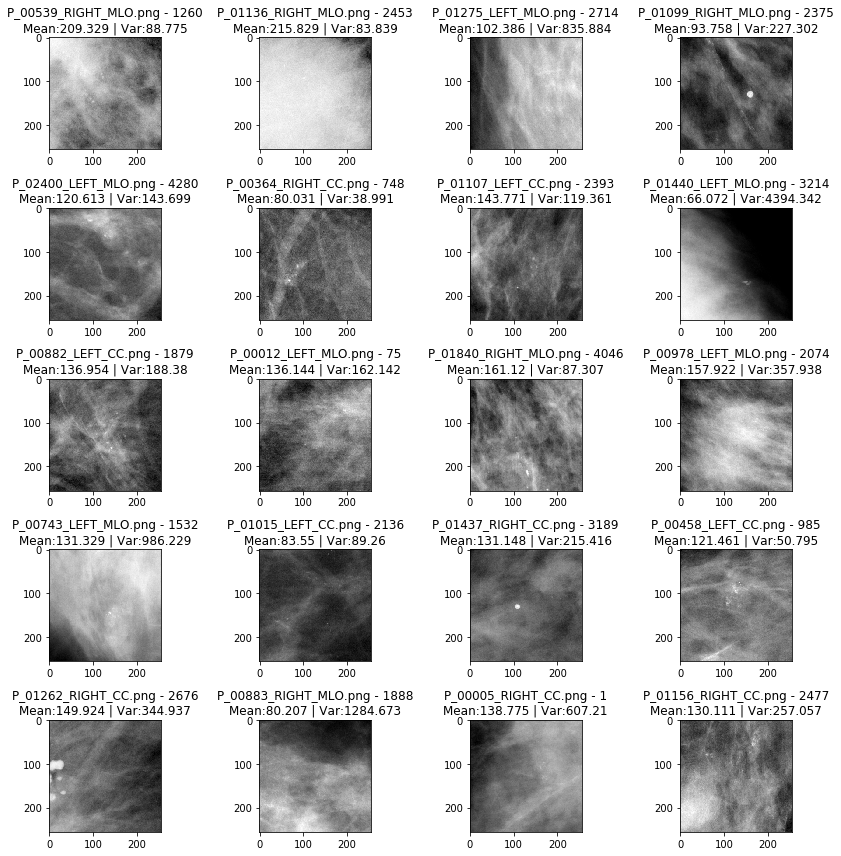

In [19]:
# random images 
N = 20
idx = random.sample(range(len(train_calc_patch)), k=N)
plt.figure(figsize=(12,12))
for i, j in enumerate(idx):
    plt.subplot(5,4,i+1)
    plt.imshow(train_calc_patch[j].reshape(256, 256), cmap='gray')
    plt.title(train_calc_FN[j] + " - " + str(j)+ "\n" + "Mean:" + str(round(np.mean(train_calc_patch[j]),3)) + " | Var:" + str(round(np.var(train_calc_patch[j]),3)))
    plt.tight_layout()
plt.show()

In [13]:
print("ROI Mean Size:", np.round(np.mean(train_calc_roi_size),2))
print("ROI Min Size:", np.min(train_calc_roi_size))
print("ROI Max Size:", np.max(train_calc_roi_size))
print("ROI Size Std:", np.round(np.std(train_calc_roi_size),2))

ROI Mean Size: 489.67
ROI Min Size: 33
ROI Max Size: 3801
ROI Size Std: 513.75


In [14]:
np.save(os.path.join("Processed_abnorm_256", "train_calc_patch.npy"), train_calc_patch)
np.save(os.path.join("Processed_abnorm_256", "train_calc_Lbl.npy"), np.array(train_calc_Lbl))
np.save(os.path.join("Processed_abnorm_256", "train_calc_FN.npy"), train_calc_FN)
np.save(os.path.join("Processed_abnorm_256", "train_calc_roi_size.npy"), np.array(train_calc_roi_size))

## Test mass data

In [3]:
test_labels = pd.read_pickle(os.path.join("Processed_abnorm_256", "test_label.pkl"))
test_labels['IMAGE_NAME2'] = test_labels.index
test_labels = test_labels.drop_duplicates(['IMAGE_NAME2'])

## use a copy on the local drive to make testing faster
mask_dir = "CBIS_png/Test/Mass_MASK_imgs"
img_dir = "CBIS_png/Test/Mass_full_imgs"

test_mass_patch, test_mass_Lbl, test_mass_FN, test_mass_roi_size = \
    create_patches(mask_dir, img_dir, Lbls=test_labels, debug=True)


  0%|                                                                                          | 0/378 [00:00<?, ?it/s]

Trimming borders CBIS_png/Test/Mass_MASK_imgs/P_00016_LEFT_CC_1_MASK.png
Mask P_00016_LEFT_CC_1_MASK.png  Height: 344 Width: 345
ROI small P_00016_LEFT_CC_1_MASK.png


  0%|▏                                                                                 | 1/378 [00:00<02:59,  2.10it/s]

Trimming borders CBIS_png/Test/Mass_MASK_imgs/P_00016_LEFT_MLO_1_MASK.png
Mask P_00016_LEFT_MLO_1_MASK.png  Height: 329 Width: 288
ROI small P_00016_LEFT_MLO_1_MASK.png


  1%|▍                                                                                 | 2/378 [00:00<02:49,  2.22it/s]

Trimming borders CBIS_png/Test/Mass_MASK_imgs/P_00017_LEFT_CC_1__MASK.png
Mask P_00017_LEFT_CC_1__MASK.png  Height: 174 Width: 155
ROI small P_00017_LEFT_CC_1__MASK.png


  1%|▋                                                                                 | 3/378 [00:01<03:08,  1.99it/s]

Trimming borders CBIS_png/Test/Mass_MASK_imgs/P_00017_LEFT_MLO_1__MASK.png
Mask P_00017_LEFT_MLO_1__MASK.png  Height: 180 Width: 185
ROI small P_00017_LEFT_MLO_1__MASK.png


  1%|▊                                                                                 | 4/378 [00:02<03:26,  1.81it/s]

Trimming borders CBIS_png/Test/Mass_MASK_imgs/P_00032_RIGHT_CC_1__MASK.png
Mask P_00032_RIGHT_CC_1__MASK.png  Height: 365 Width: 336
ROI small P_00032_RIGHT_CC_1__MASK.png


  1%|█                                                                                 | 5/378 [00:02<03:21,  1.85it/s]

Mask P_00032_RIGHT_MLO_1__MASK.png  Height: 370 Width: 421
ROI small P_00032_RIGHT_MLO_1__MASK.png


  2%|█▎                                                                                | 6/378 [00:03<03:12,  1.93it/s]

Trimming borders CBIS_png/Test/Mass_MASK_imgs/P_00037_RIGHT_CC_1__MASK.png
Mask P_00037_RIGHT_CC_1__MASK.png  Height: 389 Width: 323
ROI small P_00037_RIGHT_CC_1__MASK.png


  2%|█▌                                                                                | 7/378 [00:03<03:11,  1.94it/s]

Trimming borders CBIS_png/Test/Mass_MASK_imgs/P_00037_RIGHT_MLO_1__MASK.png
Mask P_00037_RIGHT_MLO_1__MASK.png  Height: 437 Width: 442
ROI small P_00037_RIGHT_MLO_1__MASK.png


  2%|█▋                                                                                | 8/378 [00:04<03:08,  1.97it/s]

Trimming borders CBIS_png/Test/Mass_MASK_imgs/P_00056_LEFT_MLO_1__MASK.png
Mask P_00056_LEFT_MLO_1__MASK.png  Height: 236 Width: 294
ROI small P_00056_LEFT_MLO_1__MASK.png


  2%|█▉                                                                                | 9/378 [00:04<03:00,  2.04it/s]

Mask P_00066_LEFT_CC_1__MASK.png  Height: 229 Width: 260
ROI small P_00066_LEFT_CC_1__MASK.png


  3%|██▏                                                                              | 10/378 [00:04<02:42,  2.26it/s]

Mask P_00066_LEFT_MLO_1__MASK.png  Height: 278 Width: 405
ROI small P_00066_LEFT_MLO_1__MASK.png


  3%|██▎                                                                              | 11/378 [00:05<02:40,  2.28it/s]

Trimming borders CBIS_png/Test/Mass_MASK_imgs/P_00099_LEFT_MLO_1__MASK.png
Mask P_00099_LEFT_MLO_1__MASK.png  Height: 206 Width: 155
ROI small P_00099_LEFT_MLO_1__MASK.png


  3%|██▌                                                                              | 12/378 [00:06<03:07,  1.95it/s]

Mask P_00114_LEFT_MLO_1__MASK.png  Height: 282 Width: 298
ROI small P_00114_LEFT_MLO_1__MASK.png


  3%|██▊                                                                              | 13/378 [00:06<03:03,  1.98it/s]

Trimming borders CBIS_png/Test/Mass_MASK_imgs/P_00116_RIGHT_CC_1__MASK.png
Mask P_00116_RIGHT_CC_1__MASK.png  Height: 281 Width: 422
ROI small P_00116_RIGHT_CC_1__MASK.png


  4%|███                                                                              | 14/378 [00:06<02:50,  2.13it/s]

Trimming borders CBIS_png/Test/Mass_MASK_imgs/P_00116_RIGHT_CC_2__MASK.png
Mask P_00116_RIGHT_CC_2__MASK.png  Height: 511 Width: 445
ROI small P_00116_RIGHT_CC_2__MASK.png


  4%|███▏                                                                             | 15/378 [00:07<02:38,  2.29it/s]

Trimming borders CBIS_png/Test/Mass_MASK_imgs/P_00116_RIGHT_MLO_1__MASK.png
Mask P_00116_RIGHT_MLO_1__MASK.png  Height: 443 Width: 246
ROI small P_00116_RIGHT_MLO_1__MASK.png


  4%|███▍                                                                             | 16/378 [00:07<02:31,  2.39it/s]

Trimming borders CBIS_png/Test/Mass_MASK_imgs/P_00116_RIGHT_MLO_2__MASK.png
Mask P_00116_RIGHT_MLO_2__MASK.png  Height: 446 Width: 457
ROI small P_00116_RIGHT_MLO_2__MASK.png


  4%|███▋                                                                             | 17/378 [00:08<02:25,  2.49it/s]

Trimming borders CBIS_png/Test/Mass_MASK_imgs/P_00118_RIGHT_CC_1__MASK.png
Mask P_00118_RIGHT_CC_1__MASK.png  Height: 224 Width: 320
ROI small P_00118_RIGHT_CC_1__MASK.png


  5%|███▊                                                                             | 18/378 [00:08<03:23,  1.77it/s]

Trimming borders CBIS_png/Test/Mass_MASK_imgs/P_00118_RIGHT_MLO_1__MASK.png
Mask P_00118_RIGHT_MLO_1__MASK.png  Height: 328 Width: 262
ROI small P_00118_RIGHT_MLO_1__MASK.png


  5%|████                                                                             | 19/378 [00:09<04:01,  1.49it/s]

Trimming borders CBIS_png/Test/Mass_MASK_imgs/P_00124_RIGHT_CC_1__MASK.png
Mask P_00124_RIGHT_CC_1__MASK.png  Height: 130 Width: 148
ROI small P_00124_RIGHT_CC_1__MASK.png


  5%|████▎                                                                            | 20/378 [00:10<03:46,  1.58it/s]

Trimming borders CBIS_png/Test/Mass_MASK_imgs/P_00126_RIGHT_CC_1__MASK.png
Mask P_00126_RIGHT_CC_1__MASK.png  Height: 261 Width: 276
ROI small P_00126_RIGHT_CC_1__MASK.png


  6%|████▌                                                                            | 21/378 [00:10<03:32,  1.68it/s]

Trimming borders CBIS_png/Test/Mass_MASK_imgs/P_00126_RIGHT_MLO_1__MASK.png
Mask P_00126_RIGHT_MLO_1__MASK.png  Height: 312 Width: 305
ROI small P_00126_RIGHT_MLO_1__MASK.png


  6%|████▋                                                                            | 22/378 [00:11<03:27,  1.71it/s]

Trimming borders CBIS_png/Test/Mass_MASK_imgs/P_00131_LEFT_CC_1__MASK.png
Mask P_00131_LEFT_CC_1__MASK.png  Height: 226 Width: 267
ROI small P_00131_LEFT_CC_1__MASK.png


  6%|████▉                                                                            | 23/378 [00:12<03:49,  1.54it/s]

Trimming borders CBIS_png/Test/Mass_MASK_imgs/P_00131_LEFT_MLO_1__MASK.png
Mask P_00131_LEFT_MLO_1__MASK.png  Height: 241 Width: 275
ROI small P_00131_LEFT_MLO_1__MASK.png


  6%|█████▏                                                                           | 24/378 [00:13<04:05,  1.44it/s]

Trimming borders CBIS_png/Test/Mass_MASK_imgs/P_00145_LEFT_CC_1_MASK.png
Mask shape: (4346, 1749)
Image shape: (5001, 2016)
Mask shape doesn't match image! CBIS_png/Test/Mass_MASK_imgs/P_00145_LEFT_CC_1_MASK.png
Mask Size Error: 0 for P_00145_LEFT_CC_1_MASK.png
Error, skipping P_00145_LEFT_CC_1_MASK.png


  7%|█████▎                                                                           | 25/378 [00:13<03:22,  1.74it/s]

Trimming borders CBIS_png/Test/Mass_MASK_imgs/P_00145_LEFT_MLO_1_1_MASK.png
Mask shape: (4333, 2115)
Image shape: (4986, 2436)
Mask shape doesn't match image! CBIS_png/Test/Mass_MASK_imgs/P_00145_LEFT_MLO_1_1_MASK.png
Mask Size Error: 0 for P_00145_LEFT_MLO_1_1_MASK.png
Error, skipping P_00145_LEFT_MLO_1_1_MASK.png


  7%|█████▌                                                                           | 26/378 [00:13<02:59,  1.96it/s]

Trimming borders CBIS_png/Test/Mass_MASK_imgs/P_00147_RIGHT_CC_1_0_MASK.png
Mask P_00147_RIGHT_CC_1_0_MASK.png  Height: 301 Width: 305
ROI small P_00147_RIGHT_CC_1_0_MASK.png


  7%|█████▊                                                                           | 27/378 [00:14<03:45,  1.56it/s]

Trimming borders CBIS_png/Test/Mass_MASK_imgs/P_00147_RIGHT_MLO_1_0_MASK.png
Mask P_00147_RIGHT_MLO_1_0_MASK.png  Height: 252 Width: 297
ROI small P_00147_RIGHT_MLO_1_0_MASK.png


  7%|██████                                                                           | 28/378 [00:15<04:16,  1.36it/s]

Trimming borders CBIS_png/Test/Mass_MASK_imgs/P_00156_RIGHT_MLO_1_0_MASK.png
Mask P_00156_RIGHT_MLO_1_0_MASK.png  Height: 363 Width: 476
ROI small P_00156_RIGHT_MLO_1_0_MASK.png


  8%|██████▏                                                                          | 29/378 [00:16<03:50,  1.51it/s]

Trimming borders CBIS_png/Test/Mass_MASK_imgs/P_00158_RIGHT_MLO_1_0_MASK.png
Mask P_00158_RIGHT_MLO_1_0_MASK.png  Height: 144 Width: 146
ROI small P_00158_RIGHT_MLO_1_0_MASK.png


  8%|██████▍                                                                          | 30/378 [00:16<03:32,  1.64it/s]

Trimming borders CBIS_png/Test/Mass_MASK_imgs/P_00159_RIGHT_MLO_1_0_MASK.png
Mask P_00159_RIGHT_MLO_1_0_MASK.png  Height: 253 Width: 248
ROI small P_00159_RIGHT_MLO_1_0_MASK.png


  8%|██████▋                                                                          | 31/378 [00:17<03:49,  1.51it/s]

Trimming borders CBIS_png/Test/Mass_MASK_imgs/P_00171_RIGHT_CC_1_0_MASK.png
Mask P_00171_RIGHT_CC_1_0_MASK.png  Height: 324 Width: 284
ROI small P_00171_RIGHT_CC_1_0_MASK.png


  8%|██████▊                                                                          | 32/378 [00:17<03:34,  1.61it/s]

Trimming borders CBIS_png/Test/Mass_MASK_imgs/P_00171_RIGHT_MLO_1_0_MASK.png
Mask P_00171_RIGHT_MLO_1_0_MASK.png  Height: 235 Width: 329
ROI small P_00171_RIGHT_MLO_1_0_MASK.png


  9%|███████                                                                          | 33/378 [00:18<03:30,  1.64it/s]

Mask P_00173_LEFT_CC_1_0_MASK.png  Height: 262 Width: 305
ROI small P_00173_LEFT_CC_1_0_MASK.png


  9%|███████▎                                                                         | 34/378 [00:18<03:14,  1.77it/s]

Trimming borders CBIS_png/Test/Mass_MASK_imgs/P_00173_LEFT_MLO_1_0_MASK.png
Mask P_00173_LEFT_MLO_1_0_MASK.png  Height: 281 Width: 234
ROI small P_00173_LEFT_MLO_1_0_MASK.png


  9%|███████▌                                                                         | 35/378 [00:19<03:04,  1.86it/s]

Trimming borders CBIS_png/Test/Mass_MASK_imgs/P_00173_RIGHT_CC_1_0_MASK.png
Mask P_00173_RIGHT_CC_1_0_MASK.png  Height: 472 Width: 399
ROI small P_00173_RIGHT_CC_1_0_MASK.png


 10%|███████▋                                                                         | 36/378 [00:19<02:55,  1.95it/s]

Trimming borders CBIS_png/Test/Mass_MASK_imgs/P_00173_RIGHT_CC_2_0_MASK.png
Mask P_00173_RIGHT_CC_2_0_MASK.png  Height: 323 Width: 315
ROI small P_00173_RIGHT_CC_2_0_MASK.png


 10%|███████▉                                                                         | 37/378 [00:20<02:47,  2.03it/s]

Trimming borders CBIS_png/Test/Mass_MASK_imgs/P_00173_RIGHT_MLO_1_0_MASK.png
Mask P_00173_RIGHT_MLO_1_0_MASK.png  Height: 236 Width: 189
ROI small P_00173_RIGHT_MLO_1_0_MASK.png


 10%|████████▏                                                                        | 38/378 [00:20<02:45,  2.06it/s]

Trimming borders CBIS_png/Test/Mass_MASK_imgs/P_00173_RIGHT_MLO_2_0_MASK.png
Mask P_00173_RIGHT_MLO_2_0_MASK.png  Height: 263 Width: 256
ROI small P_00173_RIGHT_MLO_2_0_MASK.png


 10%|████████▎                                                                        | 39/378 [00:21<02:43,  2.07it/s]

Mask P_00177_LEFT_CC_1_0_MASK.png  Height: 135 Width: 142
ROI small P_00177_LEFT_CC_1_0_MASK.png


 11%|████████▌                                                                        | 40/378 [00:21<02:39,  2.11it/s]

Trimming borders CBIS_png/Test/Mass_MASK_imgs/P_00177_LEFT_MLO_1_0_MASK.png
Mask P_00177_LEFT_MLO_1_0_MASK.png  Height: 198 Width: 212
ROI small P_00177_LEFT_MLO_1_0_MASK.png


 11%|████████▊                                                                        | 41/378 [00:22<02:39,  2.12it/s]

Mask P_00192_RIGHT_CC_1_0_MASK.png  Height: 948 Width: 883
ROI Big P_00192_RIGHT_CC_1_0_MASK.png


 11%|█████████                                                                        | 42/378 [00:22<03:05,  1.81it/s]

Trimming borders CBIS_png/Test/Mass_MASK_imgs/P_00194_RIGHT_CC_1_0_MASK.png
Mask P_00194_RIGHT_CC_1_0_MASK.png  Height: 648 Width: 529
ROI Big P_00194_RIGHT_CC_1_0_MASK.png


 11%|█████████▏                                                                       | 43/378 [00:23<02:56,  1.90it/s]

Trimming borders CBIS_png/Test/Mass_MASK_imgs/P_00194_RIGHT_MLO_1_0_MASK.png
Mask P_00194_RIGHT_MLO_1_0_MASK.png  Height: 663 Width: 611
ROI Big P_00194_RIGHT_MLO_1_0_MASK.png


 12%|█████████▍                                                                       | 44/378 [00:24<03:11,  1.75it/s]

Mask P_00198_LEFT_CC_1_0_MASK.png  Height: 291 Width: 319
ROI small P_00198_LEFT_CC_1_0_MASK.png


 12%|█████████▋                                                                       | 45/378 [00:24<03:28,  1.60it/s]

Trimming borders CBIS_png/Test/Mass_MASK_imgs/P_00198_LEFT_MLO_1_0_MASK.png
Mask P_00198_LEFT_MLO_1_0_MASK.png  Height: 185 Width: 306
ROI small P_00198_LEFT_MLO_1_0_MASK.png


 12%|█████████▊                                                                       | 46/378 [00:25<03:49,  1.45it/s]

Mask P_00200_LEFT_CC_1_0_MASK.png  Height: 799 Width: 632
ROI Big P_00200_LEFT_CC_1_0_MASK.png


 12%|██████████                                                                       | 47/378 [00:26<03:26,  1.61it/s]

Trimming borders CBIS_png/Test/Mass_MASK_imgs/P_00200_LEFT_MLO_1_0_MASK.png
Mask P_00200_LEFT_MLO_1_0_MASK.png  Height: 395 Width: 374
ROI small P_00200_LEFT_MLO_1_0_MASK.png


 13%|██████████▎                                                                      | 48/378 [00:26<03:12,  1.71it/s]

Mask P_00200_RIGHT_CC_1_0_MASK.png  Height: 754 Width: 509
ROI Big P_00200_RIGHT_CC_1_0_MASK.png


 13%|██████████▌                                                                      | 49/378 [00:27<03:02,  1.81it/s]

Trimming borders CBIS_png/Test/Mass_MASK_imgs/P_00200_RIGHT_MLO_1_0_MASK.png
Mask P_00200_RIGHT_MLO_1_0_MASK.png  Height: 537 Width: 514
ROI Big P_00200_RIGHT_MLO_1_0_MASK.png


 13%|██████████▋                                                                      | 50/378 [00:27<02:54,  1.88it/s]

Trimming borders CBIS_png/Test/Mass_MASK_imgs/P_00202_RIGHT_CC_1_0_MASK.png
Mask P_00202_RIGHT_CC_1_0_MASK.png  Height: 404 Width: 407
ROI small P_00202_RIGHT_CC_1_0_MASK.png


 13%|██████████▉                                                                      | 51/378 [00:28<03:24,  1.60it/s]

Trimming borders CBIS_png/Test/Mass_MASK_imgs/P_00202_RIGHT_MLO_1_0_MASK.png
Mask P_00202_RIGHT_MLO_1_0_MASK.png  Height: 382 Width: 421
ROI small P_00202_RIGHT_MLO_1_0_MASK.png


 14%|███████████▏                                                                     | 52/378 [00:29<03:57,  1.37it/s]

Trimming borders CBIS_png/Test/Mass_MASK_imgs/P_00203_LEFT_CC_1_0_MASK.png
Mask P_00203_LEFT_CC_1_0_MASK.png  Height: 210 Width: 192
ROI small P_00203_LEFT_CC_1_0_MASK.png


 14%|███████████▎                                                                     | 53/378 [00:30<03:59,  1.36it/s]

Trimming borders CBIS_png/Test/Mass_MASK_imgs/P_00203_LEFT_MLO_1_0_MASK.png
Mask P_00203_LEFT_MLO_1_0_MASK.png  Height: 248 Width: 179
ROI small P_00203_LEFT_MLO_1_0_MASK.png


 14%|███████████▌                                                                     | 54/378 [00:31<04:09,  1.30it/s]

Trimming borders CBIS_png/Test/Mass_MASK_imgs/P_00209_LEFT_MLO_1_0_MASK.png
Mask P_00209_LEFT_MLO_1_0_MASK.png  Height: 142 Width: 184
ROI small P_00209_LEFT_MLO_1_0_MASK.png


 15%|███████████▊                                                                     | 55/378 [00:32<04:54,  1.10it/s]

Trimming borders CBIS_png/Test/Mass_MASK_imgs/P_00212_RIGHT_CC_1_0_MASK.png
Mask P_00212_RIGHT_CC_1_0_MASK.png  Height: 468 Width: 492
ROI small P_00212_RIGHT_CC_1_0_MASK.png


 15%|████████████                                                                     | 56/378 [00:32<04:19,  1.24it/s]

Trimming borders CBIS_png/Test/Mass_MASK_imgs/P_00212_RIGHT_MLO_1_0_MASK.png
Mask P_00212_RIGHT_MLO_1_0_MASK.png  Height: 287 Width: 330
ROI small P_00212_RIGHT_MLO_1_0_MASK.png


 15%|████████████▏                                                                    | 57/378 [00:33<03:49,  1.40it/s]

Trimming borders CBIS_png/Test/Mass_MASK_imgs/P_00230_RIGHT_CC_1_0_MASK.png
Mask P_00230_RIGHT_CC_1_0_MASK.png  Height: 180 Width: 229
ROI small P_00230_RIGHT_CC_1_0_MASK.png


 15%|████████████▍                                                                    | 58/378 [00:33<03:43,  1.43it/s]

Trimming borders CBIS_png/Test/Mass_MASK_imgs/P_00230_RIGHT_MLO_1_0_MASK.png
Mask P_00230_RIGHT_MLO_1_0_MASK.png  Height: 220 Width: 235
ROI small P_00230_RIGHT_MLO_1_0_MASK.png


 16%|████████████▋                                                                    | 59/378 [00:34<03:42,  1.44it/s]

Trimming borders CBIS_png/Test/Mass_MASK_imgs/P_00238_RIGHT_CC_1_0_MASK.png
Mask P_00238_RIGHT_CC_1_0_MASK.png  Height: 183 Width: 135
ROI small P_00238_RIGHT_CC_1_0_MASK.png


 16%|████████████▊                                                                    | 60/378 [00:35<03:24,  1.55it/s]

Trimming borders CBIS_png/Test/Mass_MASK_imgs/P_00238_RIGHT_MLO_1_0_MASK.png
Mask P_00238_RIGHT_MLO_1_0_MASK.png  Height: 173 Width: 182
ROI small P_00238_RIGHT_MLO_1_0_MASK.png


 16%|█████████████                                                                    | 61/378 [00:35<03:10,  1.66it/s]

Trimming borders CBIS_png/Test/Mass_MASK_imgs/P_00278_RIGHT_CC_1_0_MASK.png
Mask P_00278_RIGHT_CC_1_0_MASK.png  Height: 213 Width: 210
ROI small P_00278_RIGHT_CC_1_0_MASK.png


 16%|█████████████▎                                                                   | 62/378 [00:36<03:20,  1.58it/s]

Trimming borders CBIS_png/Test/Mass_MASK_imgs/P_00278_RIGHT_MLO_1_0_MASK.png
Mask P_00278_RIGHT_MLO_1_0_MASK.png  Height: 183 Width: 220
ROI small P_00278_RIGHT_MLO_1_0_MASK.png


 17%|█████████████▌                                                                   | 63/378 [00:37<03:36,  1.46it/s]

Mask P_00296_LEFT_CC_1_0_MASK.png  Height: 613 Width: 566
ROI Big P_00296_LEFT_CC_1_0_MASK.png


 17%|█████████████▋                                                                   | 64/378 [00:37<03:07,  1.67it/s]

Trimming borders CBIS_png/Test/Mass_MASK_imgs/P_00296_LEFT_MLO_1_0_MASK.png
Mask P_00296_LEFT_MLO_1_0_MASK.png  Height: 574 Width: 640
ROI Big P_00296_LEFT_MLO_1_0_MASK.png


 17%|█████████████▉                                                                   | 65/378 [00:38<02:49,  1.84it/s]

Trimming borders CBIS_png/Test/Mass_MASK_imgs/P_00324_RIGHT_CC_1_0_MASK.png
Mask P_00324_RIGHT_CC_1_0_MASK.png  Height: 440 Width: 360
ROI small P_00324_RIGHT_CC_1_0_MASK.png


 17%|██████████████▏                                                                  | 66/378 [00:38<02:36,  1.99it/s]

Trimming borders CBIS_png/Test/Mass_MASK_imgs/P_00324_RIGHT_MLO_1_0_MASK.png
Mask P_00324_RIGHT_MLO_1_0_MASK.png  Height: 306 Width: 271
ROI small P_00324_RIGHT_MLO_1_0_MASK.png


 18%|██████████████▎                                                                  | 67/378 [00:38<02:31,  2.05it/s]

Trimming borders CBIS_png/Test/Mass_MASK_imgs/P_00340_LEFT_CC_1_0_MASK.png
Mask P_00340_LEFT_CC_1_0_MASK.png  Height: 261 Width: 241
ROI small P_00340_LEFT_CC_1_0_MASK.png


 18%|██████████████▌                                                                  | 68/378 [00:39<02:22,  2.18it/s]

Mask P_00343_LEFT_CC_1_0_MASK.png  Height: 365 Width: 166
ROI small P_00343_LEFT_CC_1_0_MASK.png


 18%|██████████████▊                                                                  | 69/378 [00:39<02:21,  2.18it/s]

Mask P_00343_LEFT_MLO_1_0_MASK.png  Height: 410 Width: 214
ROI small P_00343_LEFT_MLO_1_0_MASK.png


 19%|███████████████                                                                  | 70/378 [00:40<02:17,  2.23it/s]

Trimming borders CBIS_png/Test/Mass_MASK_imgs/P_00343_RIGHT_CC_1_0_MASK.png
Mask P_00343_RIGHT_CC_1_0_MASK.png  Height: 119 Width: 146
ROI small P_00343_RIGHT_CC_1_0_MASK.png


 19%|███████████████▏                                                                 | 71/378 [00:40<02:12,  2.31it/s]

Trimming borders CBIS_png/Test/Mass_MASK_imgs/P_00343_RIGHT_CC_2_0_MASK.png
Mask P_00343_RIGHT_CC_2_0_MASK.png  Height: 409 Width: 190
ROI small P_00343_RIGHT_CC_2_0_MASK.png


 19%|███████████████▍                                                                 | 72/378 [00:40<02:09,  2.36it/s]

Trimming borders CBIS_png/Test/Mass_MASK_imgs/P_00343_RIGHT_MLO_1_0_MASK.png
Mask P_00343_RIGHT_MLO_1_0_MASK.png  Height: 92 Width: 116
ROI small P_00343_RIGHT_MLO_1_0_MASK.png


 19%|███████████████▋                                                                 | 73/378 [00:41<02:11,  2.31it/s]

Trimming borders CBIS_png/Test/Mass_MASK_imgs/P_00343_RIGHT_MLO_2_0_MASK.png
Mask P_00343_RIGHT_MLO_2_0_MASK.png  Height: 435 Width: 320
ROI small P_00343_RIGHT_MLO_2_0_MASK.png


 20%|███████████████▊                                                                 | 74/378 [00:41<02:13,  2.27it/s]

Trimming borders CBIS_png/Test/Mass_MASK_imgs/P_00347_LEFT_CC_1_0_MASK.png
Mask P_00347_LEFT_CC_1_0_MASK.png  Height: 276 Width: 288
ROI small P_00347_LEFT_CC_1_0_MASK.png


 20%|████████████████                                                                 | 75/378 [00:42<02:20,  2.16it/s]

Trimming borders CBIS_png/Test/Mass_MASK_imgs/P_00347_LEFT_MLO_1_0_MASK.png
Mask P_00347_LEFT_MLO_1_0_MASK.png  Height: 282 Width: 246
ROI small P_00347_LEFT_MLO_1_0_MASK.png


 20%|████████████████▎                                                                | 76/378 [00:42<02:27,  2.05it/s]

Trimming borders CBIS_png/Test/Mass_MASK_imgs/P_00358_RIGHT_CC_1_0_MASK.png
Mask P_00358_RIGHT_CC_1_0_MASK.png  Height: 477 Width: 547
ROI Big P_00358_RIGHT_CC_1_0_MASK.png


 20%|████████████████▌                                                                | 77/378 [00:43<02:25,  2.07it/s]

Trimming borders CBIS_png/Test/Mass_MASK_imgs/P_00358_RIGHT_MLO_1_0_MASK.png
Mask P_00358_RIGHT_MLO_1_0_MASK.png  Height: 571 Width: 529
ROI Big P_00358_RIGHT_MLO_1_0_MASK.png


 21%|████████████████▋                                                                | 78/378 [00:43<02:23,  2.10it/s]

Trimming borders CBIS_png/Test/Mass_MASK_imgs/P_00359_LEFT_MLO_1_0_MASK.png
Mask P_00359_LEFT_MLO_1_0_MASK.png  Height: 303 Width: 402
ROI small P_00359_LEFT_MLO_1_0_MASK.png


 21%|████████████████▉                                                                | 79/378 [00:44<02:39,  1.87it/s]

Trimming borders CBIS_png/Test/Mass_MASK_imgs/P_00369_LEFT_CC_1_0_MASK.png
Mask P_00369_LEFT_CC_1_0_MASK.png  Height: 318 Width: 277
ROI small P_00369_LEFT_CC_1_0_MASK.png


 21%|█████████████████▏                                                               | 80/378 [00:44<02:31,  1.96it/s]

Trimming borders CBIS_png/Test/Mass_MASK_imgs/P_00369_LEFT_MLO_1_0_MASK.png
Mask P_00369_LEFT_MLO_1_0_MASK.png  Height: 326 Width: 342
ROI small P_00369_LEFT_MLO_1_0_MASK.png


 21%|█████████████████▎                                                               | 81/378 [00:45<02:36,  1.89it/s]

Trimming borders CBIS_png/Test/Mass_MASK_imgs/P_00375_RIGHT_CC_1_0_MASK.png
Mask P_00375_RIGHT_CC_1_0_MASK.png  Height: 408 Width: 426
ROI small P_00375_RIGHT_CC_1_0_MASK.png


 22%|█████████████████▌                                                               | 82/378 [00:45<02:26,  2.02it/s]

Trimming borders CBIS_png/Test/Mass_MASK_imgs/P_00375_RIGHT_MLO_1_0_MASK.png
Mask P_00375_RIGHT_MLO_1_0_MASK.png  Height: 332 Width: 343
ROI small P_00375_RIGHT_MLO_1_0_MASK.png


 22%|█████████████████▊                                                               | 83/378 [00:46<02:19,  2.11it/s]

Trimming borders CBIS_png/Test/Mass_MASK_imgs/P_00379_LEFT_CC_1_0_MASK.png
Mask P_00379_LEFT_CC_1_0_MASK.png  Height: 347 Width: 415
ROI small P_00379_LEFT_CC_1_0_MASK.png


 22%|██████████████████                                                               | 84/378 [00:46<02:25,  2.02it/s]

Trimming borders CBIS_png/Test/Mass_MASK_imgs/P_00379_LEFT_MLO_1_0_MASK.png
Mask shape: (4646, 2780)
Image shape: (5346, 3201)
Mask shape doesn't match image! CBIS_png/Test/Mass_MASK_imgs/P_00379_LEFT_MLO_1_0_MASK.png
Mask Size Error: 0 for P_00379_LEFT_MLO_1_0_MASK.png
Error, skipping P_00379_LEFT_MLO_1_0_MASK.png


 22%|██████████████████▏                                                              | 85/378 [00:47<02:22,  2.06it/s]

Trimming borders CBIS_png/Test/Mass_MASK_imgs/P_00381_LEFT_CC_1_1_MASK.png
Mask shape: (4581, 2741)
Image shape: (5271, 3156)
Mask shape doesn't match image! CBIS_png/Test/Mass_MASK_imgs/P_00381_LEFT_CC_1_1_MASK.png
Mask Size Error: 0 for P_00381_LEFT_CC_1_1_MASK.png
Error, skipping P_00381_LEFT_CC_1_1_MASK.png


 23%|██████████████████▍                                                              | 86/378 [00:47<02:20,  2.08it/s]

Trimming borders CBIS_png/Test/Mass_MASK_imgs/P_00381_LEFT_MLO_1_0_MASK.png
Mishaped mask, resizing mask CBIS_png/Test/Mass_MASK_imgs/P_00381_LEFT_MLO_1_0_MASK.png
Mask P_00381_LEFT_MLO_1_0_MASK.png  Height: 182 Width: 297
ROI small P_00381_LEFT_MLO_1_0_MASK.png


 23%|██████████████████▋                                                              | 87/378 [00:48<02:43,  1.78it/s]

Trimming borders CBIS_png/Test/Mass_MASK_imgs/P_00387_RIGHT_CC_1_0_MASK.png
Mask P_00387_RIGHT_CC_1_0_MASK.png  Height: 186 Width: 178
ROI small P_00387_RIGHT_CC_1_0_MASK.png


 23%|██████████████████▊                                                              | 88/378 [00:49<02:36,  1.85it/s]

Trimming borders CBIS_png/Test/Mass_MASK_imgs/P_00387_RIGHT_MLO_1_0_MASK.png
Mask P_00387_RIGHT_MLO_1_0_MASK.png  Height: 206 Width: 228
ROI small P_00387_RIGHT_MLO_1_0_MASK.png


 24%|███████████████████                                                              | 89/378 [00:49<02:31,  1.91it/s]

Trimming borders CBIS_png/Test/Mass_MASK_imgs/P_00391_LEFT_CC_1_0_MASK.png
Mask P_00391_LEFT_CC_1_0_MASK.png  Height: 332 Width: 331
ROI small P_00391_LEFT_CC_1_0_MASK.png


 24%|███████████████████▎                                                             | 90/378 [00:50<02:36,  1.84it/s]

Trimming borders CBIS_png/Test/Mass_MASK_imgs/P_00391_LEFT_MLO_1_0_MASK.png
Mask P_00391_LEFT_MLO_1_0_MASK.png  Height: 341 Width: 359
ROI small P_00391_LEFT_MLO_1_0_MASK.png


 24%|███████████████████▌                                                             | 91/378 [00:50<02:39,  1.80it/s]

Trimming borders CBIS_png/Test/Mass_MASK_imgs/P_00391_RIGHT_CC_1_0_MASK.png
Mask P_00391_RIGHT_CC_1_0_MASK.png  Height: 507 Width: 718
ROI Big P_00391_RIGHT_CC_1_0_MASK.png


 24%|███████████████████▋                                                             | 92/378 [00:51<02:34,  1.86it/s]

Trimming borders CBIS_png/Test/Mass_MASK_imgs/P_00391_RIGHT_MLO_1_0_MASK.png
Mask P_00391_RIGHT_MLO_1_0_MASK.png  Height: 312 Width: 322
ROI small P_00391_RIGHT_MLO_1_0_MASK.png


 25%|███████████████████▉                                                             | 93/378 [00:51<02:33,  1.86it/s]

Trimming borders CBIS_png/Test/Mass_MASK_imgs/P_00394_RIGHT_MLO_1_0_MASK.png
Mask P_00394_RIGHT_MLO_1_0_MASK.png  Height: 366 Width: 350
ROI small P_00394_RIGHT_MLO_1_0_MASK.png


 25%|████████████████████▏                                                            | 94/378 [00:52<02:31,  1.87it/s]

Trimming borders CBIS_png/Test/Mass_MASK_imgs/P_00405_LEFT_CC_1_0_MASK.png
Mask P_00405_LEFT_CC_1_0_MASK.png  Height: 375 Width: 321
ROI small P_00405_LEFT_CC_1_0_MASK.png


 25%|████████████████████▎                                                            | 95/378 [00:52<02:37,  1.80it/s]

Trimming borders CBIS_png/Test/Mass_MASK_imgs/P_00405_LEFT_MLO_1_0_MASK.png
Mask P_00405_LEFT_MLO_1_0_MASK.png  Height: 396 Width: 371
ROI small P_00405_LEFT_MLO_1_0_MASK.png


 25%|████████████████████▌                                                            | 96/378 [00:53<02:43,  1.72it/s]

Mask P_00409_RIGHT_CC_1_0_MASK.png  Height: 369 Width: 434
ROI small P_00409_RIGHT_CC_1_0_MASK.png


 26%|████████████████████▊                                                            | 97/378 [00:54<02:38,  1.77it/s]

Mask P_00409_RIGHT_MLO_1_0_MASK.png  Height: 344 Width: 436
ROI small P_00409_RIGHT_MLO_1_0_MASK.png


 26%|█████████████████████                                                            | 98/378 [00:54<02:34,  1.81it/s]

Mask P_00429_LEFT_CC_1_0_MASK.png  Height: 312 Width: 300
ROI small P_00429_LEFT_CC_1_0_MASK.png


 26%|█████████████████████▏                                                           | 99/378 [00:55<02:23,  1.94it/s]

Trimming borders CBIS_png/Test/Mass_MASK_imgs/P_00429_LEFT_MLO_1_0_MASK.png
Mask P_00429_LEFT_MLO_1_0_MASK.png  Height: 310 Width: 254
ROI small P_00429_LEFT_MLO_1_0_MASK.png


 26%|█████████████████████▏                                                          | 100/378 [00:55<02:21,  1.96it/s]

Mask P_00433_LEFT_CC_1_0_MASK.png  Height: 184 Width: 202
ROI small P_00433_LEFT_CC_1_0_MASK.png


 27%|█████████████████████▍                                                          | 101/378 [00:55<02:14,  2.05it/s]

Mask P_00433_LEFT_MLO_1_0_MASK.png  Height: 281 Width: 327
ROI small P_00433_LEFT_MLO_1_0_MASK.png


 27%|█████████████████████▌                                                          | 102/378 [00:56<02:13,  2.06it/s]

Trimming borders CBIS_png/Test/Mass_MASK_imgs/P_00457_LEFT_CC_1_0_MASK.png
Mask P_00457_LEFT_CC_1_0_MASK.png  Height: 288 Width: 331
ROI small P_00457_LEFT_CC_1_0_MASK.png


 27%|█████████████████████▊                                                          | 103/378 [00:57<02:18,  1.99it/s]

Trimming borders CBIS_png/Test/Mass_MASK_imgs/P_00457_LEFT_MLO_1_0_MASK.png
Mask P_00457_LEFT_MLO_1_0_MASK.png  Height: 376 Width: 340
ROI small P_00457_LEFT_MLO_1_0_MASK.png


 28%|██████████████████████                                                          | 104/378 [00:57<02:22,  1.92it/s]

Trimming borders CBIS_png/Test/Mass_MASK_imgs/P_00464_RIGHT_CC_1_0_MASK.png
Mask P_00464_RIGHT_CC_1_0_MASK.png  Height: 410 Width: 423
ROI small P_00464_RIGHT_CC_1_0_MASK.png


 28%|██████████████████████▏                                                         | 105/378 [00:58<02:31,  1.80it/s]

Trimming borders CBIS_png/Test/Mass_MASK_imgs/P_00464_RIGHT_MLO_1_0_MASK.png
Mask P_00464_RIGHT_MLO_1_0_MASK.png  Height: 253 Width: 311
ROI small P_00464_RIGHT_MLO_1_0_MASK.png


 28%|██████████████████████▍                                                         | 106/378 [00:58<02:37,  1.72it/s]

Mask P_00470_RIGHT_CC_1_0_MASK.png  Height: 227 Width: 216
ROI small P_00470_RIGHT_CC_1_0_MASK.png


 28%|██████████████████████▋                                                         | 107/378 [00:59<02:27,  1.84it/s]

Trimming borders CBIS_png/Test/Mass_MASK_imgs/P_00470_RIGHT_MLO_1_0_MASK.png
Mask P_00470_RIGHT_MLO_1_0_MASK.png  Height: 200 Width: 177
ROI small P_00470_RIGHT_MLO_1_0_MASK.png


 29%|██████████████████████▊                                                         | 108/378 [00:59<02:24,  1.87it/s]

Mask P_00481_RIGHT_CC_1_0_MASK.png  Height: 252 Width: 279
ROI small P_00481_RIGHT_CC_1_0_MASK.png


 29%|███████████████████████                                                         | 109/378 [01:00<02:17,  1.96it/s]

Trimming borders CBIS_png/Test/Mass_MASK_imgs/P_00481_RIGHT_MLO_1_0_MASK.png
Mask P_00481_RIGHT_MLO_1_0_MASK.png  Height: 264 Width: 279
ROI small P_00481_RIGHT_MLO_1_0_MASK.png


 29%|███████████████████████▎                                                        | 110/378 [01:00<02:15,  1.98it/s]

Trimming borders CBIS_png/Test/Mass_MASK_imgs/P_00482_LEFT_CC_1_0_MASK.png
Mask P_00482_LEFT_CC_1_0_MASK.png  Height: 684 Width: 766
ROI Big P_00482_LEFT_CC_1_0_MASK.png


 29%|███████████████████████▍                                                        | 111/378 [01:01<02:11,  2.03it/s]

Trimming borders CBIS_png/Test/Mass_MASK_imgs/P_00482_LEFT_MLO_1_0_MASK.png
Mask P_00482_LEFT_MLO_1_0_MASK.png  Height: 569 Width: 616
ROI Big P_00482_LEFT_MLO_1_0_MASK.png


 30%|███████████████████████▋                                                        | 112/378 [01:01<02:08,  2.07it/s]

Trimming borders CBIS_png/Test/Mass_MASK_imgs/P_00490_RIGHT_CC_1_0_MASK.png
Mask P_00490_RIGHT_CC_1_0_MASK.png  Height: 225 Width: 267
ROI small P_00490_RIGHT_CC_1_0_MASK.png


 30%|███████████████████████▉                                                        | 113/378 [01:02<02:03,  2.14it/s]

Trimming borders CBIS_png/Test/Mass_MASK_imgs/P_00490_RIGHT_MLO_1_0_MASK.png
Mask P_00490_RIGHT_MLO_1_0_MASK.png  Height: 255 Width: 236
ROI small P_00490_RIGHT_MLO_1_0_MASK.png


 30%|████████████████████████▏                                                       | 114/378 [01:02<02:00,  2.20it/s]

Trimming borders CBIS_png/Test/Mass_MASK_imgs/P_00493_RIGHT_CC_1_0_MASK.png
Mask P_00493_RIGHT_CC_1_0_MASK.png  Height: 249 Width: 268
ROI small P_00493_RIGHT_CC_1_0_MASK.png


 30%|████████████████████████▎                                                       | 115/378 [01:02<01:58,  2.21it/s]

Trimming borders CBIS_png/Test/Mass_MASK_imgs/P_00494_RIGHT_CC_1_0_MASK.png
Mask P_00494_RIGHT_CC_1_0_MASK.png  Height: 447 Width: 465
ROI small P_00494_RIGHT_CC_1_0_MASK.png


 31%|████████████████████████▌                                                       | 116/378 [01:03<02:24,  1.82it/s]

Trimming borders CBIS_png/Test/Mass_MASK_imgs/P_00494_RIGHT_MLO_1_0_MASK.png
Mask P_00494_RIGHT_MLO_1_0_MASK.png  Height: 364 Width: 424
ROI small P_00494_RIGHT_MLO_1_0_MASK.png


 31%|████████████████████████▊                                                       | 117/378 [01:04<02:43,  1.59it/s]

Trimming borders CBIS_png/Test/Mass_MASK_imgs/P_00498_LEFT_CC_1_0_MASK.png
Mask P_00498_LEFT_CC_1_0_MASK.png  Height: 187 Width: 208
ROI small P_00498_LEFT_CC_1_0_MASK.png


 31%|████████████████████████▉                                                       | 118/378 [01:05<02:58,  1.46it/s]

Trimming borders CBIS_png/Test/Mass_MASK_imgs/P_00498_LEFT_MLO_1_0_MASK.png
Mask P_00498_LEFT_MLO_1_0_MASK.png  Height: 199 Width: 244
ROI small P_00498_LEFT_MLO_1_0_MASK.png


 31%|█████████████████████████▏                                                      | 119/378 [01:06<03:15,  1.32it/s]

Trimming borders CBIS_png/Test/Mass_MASK_imgs/P_00500_RIGHT_MLO_1_0_MASK.png
Mask P_00500_RIGHT_MLO_1_0_MASK.png  Height: 263 Width: 316
ROI small P_00500_RIGHT_MLO_1_0_MASK.png


 32%|█████████████████████████▍                                                      | 120/378 [01:07<03:16,  1.32it/s]

Mask P_00510_LEFT_CC_4_0_MASK.png  Height: 195 Width: 201
ROI small P_00510_LEFT_CC_4_0_MASK.png


 32%|█████████████████████████▌                                                      | 121/378 [01:07<03:12,  1.34it/s]

Trimming borders CBIS_png/Test/Mass_MASK_imgs/P_00510_LEFT_MLO_2_0_MASK.png
Mask P_00510_LEFT_MLO_2_0_MASK.png  Height: 202 Width: 174
ROI small P_00510_LEFT_MLO_2_0_MASK.png


 32%|█████████████████████████▊                                                      | 122/378 [01:08<03:16,  1.31it/s]

Trimming borders CBIS_png/Test/Mass_MASK_imgs/P_00514_LEFT_MLO_1_0_MASK.png
Mask P_00514_LEFT_MLO_1_0_MASK.png  Height: 213 Width: 182
ROI small P_00514_LEFT_MLO_1_0_MASK.png


 33%|██████████████████████████                                                      | 123/378 [01:09<03:28,  1.22it/s]

Mask P_00516_LEFT_CC_1_0_MASK.png  Height: 418 Width: 423
ROI small P_00516_LEFT_CC_1_0_MASK.png


 33%|██████████████████████████▏                                                     | 124/378 [01:09<02:57,  1.43it/s]

Trimming borders CBIS_png/Test/Mass_MASK_imgs/P_00516_LEFT_MLO_1_0_MASK.png
Mask P_00516_LEFT_MLO_1_0_MASK.png  Height: 437 Width: 418
ROI small P_00516_LEFT_MLO_1_0_MASK.png


 33%|██████████████████████████▍                                                     | 125/378 [01:10<02:35,  1.62it/s]

Trimming borders CBIS_png/Test/Mass_MASK_imgs/P_00524_LEFT_CC_1_0_MASK.png
Mask P_00524_LEFT_CC_1_0_MASK.png  Height: 287 Width: 337
ROI small P_00524_LEFT_CC_1_0_MASK.png


 33%|██████████████████████████▋                                                     | 126/378 [01:11<02:48,  1.50it/s]

Trimming borders CBIS_png/Test/Mass_MASK_imgs/P_00524_LEFT_MLO_1_0_MASK.png
Mask P_00524_LEFT_MLO_1_0_MASK.png  Height: 152 Width: 173
ROI small P_00524_LEFT_MLO_1_0_MASK.png


 34%|██████████████████████████▉                                                     | 127/378 [01:11<02:54,  1.44it/s]

Trimming borders CBIS_png/Test/Mass_MASK_imgs/P_00533_LEFT_CC_1_0_MASK.png
Mask P_00533_LEFT_CC_1_0_MASK.png  Height: 303 Width: 339
ROI small P_00533_LEFT_CC_1_0_MASK.png


 34%|███████████████████████████                                                     | 128/378 [01:12<02:37,  1.58it/s]

Trimming borders CBIS_png/Test/Mass_MASK_imgs/P_00533_LEFT_MLO_1_0_MASK.png
Mask P_00533_LEFT_MLO_1_0_MASK.png  Height: 269 Width: 292
ROI small P_00533_LEFT_MLO_1_0_MASK.png


 34%|███████████████████████████▎                                                    | 129/378 [01:12<02:22,  1.74it/s]

Trimming borders CBIS_png/Test/Mass_MASK_imgs/P_00544_LEFT_CC_1_0_MASK.png
Mask P_00544_LEFT_CC_1_0_MASK.png  Height: 178 Width: 263
ROI small P_00544_LEFT_CC_1_0_MASK.png


 34%|███████████████████████████▌                                                    | 130/378 [01:13<02:17,  1.80it/s]

Trimming borders CBIS_png/Test/Mass_MASK_imgs/P_00544_LEFT_MLO_1_0_MASK.png
Mask P_00544_LEFT_MLO_1_0_MASK.png  Height: 392 Width: 283
ROI small P_00544_LEFT_MLO_1_0_MASK.png


 35%|███████████████████████████▋                                                    | 131/378 [01:13<02:13,  1.84it/s]

Trimming borders CBIS_png/Test/Mass_MASK_imgs/P_00576_LEFT_CC_1_0_MASK.png
Mask P_00576_LEFT_CC_1_0_MASK.png  Height: 219 Width: 225
ROI small P_00576_LEFT_CC_1_0_MASK.png


 35%|███████████████████████████▉                                                    | 132/378 [01:14<02:38,  1.55it/s]

Trimming borders CBIS_png/Test/Mass_MASK_imgs/P_00576_LEFT_MLO_1_0_MASK.png
Mask P_00576_LEFT_MLO_1_0_MASK.png  Height: 184 Width: 156
ROI small P_00576_LEFT_MLO_1_0_MASK.png


 35%|████████████████████████████▏                                                   | 133/378 [01:15<02:50,  1.44it/s]

Trimming borders CBIS_png/Test/Mass_MASK_imgs/P_00587_RIGHT_CC_1_0_MASK.png
Mask P_00587_RIGHT_CC_1_0_MASK.png  Height: 302 Width: 267
ROI small P_00587_RIGHT_CC_1_0_MASK.png


 35%|████████████████████████████▎                                                   | 134/378 [01:16<02:55,  1.39it/s]

Trimming borders CBIS_png/Test/Mass_MASK_imgs/P_00587_RIGHT_MLO_1_0_MASK.png
Mask P_00587_RIGHT_MLO_1_0_MASK.png  Height: 299 Width: 312
ROI small P_00587_RIGHT_MLO_1_0_MASK.png


 36%|████████████████████████████▌                                                   | 135/378 [01:17<02:59,  1.35it/s]

Trimming borders CBIS_png/Test/Mass_MASK_imgs/P_00591_RIGHT_MLO_3_0_MASK.png
Mask P_00591_RIGHT_MLO_3_0_MASK.png  Height: 329 Width: 370
ROI small P_00591_RIGHT_MLO_3_0_MASK.png


 36%|████████████████████████████▊                                                   | 136/378 [01:17<02:52,  1.41it/s]

Mask P_00598_LEFT_CC_1_0_MASK.png  Height: 553 Width: 546
ROI Big P_00598_LEFT_CC_1_0_MASK.png


 36%|████████████████████████████▉                                                   | 137/378 [01:18<02:31,  1.59it/s]

Trimming borders CBIS_png/Test/Mass_MASK_imgs/P_00598_LEFT_MLO_1_0_MASK.png
Mask P_00598_LEFT_MLO_1_0_MASK.png  Height: 425 Width: 398
ROI small P_00598_LEFT_MLO_1_0_MASK.png


 37%|█████████████████████████████▏                                                  | 138/378 [01:18<02:17,  1.74it/s]

Mask P_00601_LEFT_CC_1_0_MASK.png  Height: 223 Width: 289
ROI small P_00601_LEFT_CC_1_0_MASK.png


 37%|█████████████████████████████▍                                                  | 139/378 [01:19<02:25,  1.64it/s]

Trimming borders CBIS_png/Test/Mass_MASK_imgs/P_00601_LEFT_MLO_2_0_MASK.png
Mask P_00601_LEFT_MLO_2_0_MASK.png  Height: 324 Width: 348
ROI small P_00601_LEFT_MLO_2_0_MASK.png


 37%|█████████████████████████████▋                                                  | 140/378 [01:20<02:33,  1.55it/s]

Trimming borders CBIS_png/Test/Mass_MASK_imgs/P_00612_RIGHT_MLO_1_0_MASK.png
Mask P_00612_RIGHT_MLO_1_0_MASK.png  Height: 281 Width: 377
ROI small P_00612_RIGHT_MLO_1_0_MASK.png


 37%|█████████████████████████████▊                                                  | 141/378 [01:20<02:18,  1.71it/s]

Trimming borders CBIS_png/Test/Mass_MASK_imgs/P_00615_RIGHT_CC_1_0_MASK.png
Mask P_00615_RIGHT_CC_1_0_MASK.png  Height: 461 Width: 407
ROI small P_00615_RIGHT_CC_1_0_MASK.png


 38%|██████████████████████████████                                                  | 142/378 [01:21<02:19,  1.69it/s]

Trimming borders CBIS_png/Test/Mass_MASK_imgs/P_00615_RIGHT_MLO_1_0_MASK.png
Mask P_00615_RIGHT_MLO_1_0_MASK.png  Height: 316 Width: 385
ROI small P_00615_RIGHT_MLO_1_0_MASK.png


 38%|██████████████████████████████▎                                                 | 143/378 [01:21<02:27,  1.59it/s]

Mask P_00623_LEFT_CC_1_0_MASK.png  Height: 363 Width: 352
ROI small P_00623_LEFT_CC_1_0_MASK.png


 38%|██████████████████████████████▍                                                 | 144/378 [01:22<02:11,  1.78it/s]

Trimming borders CBIS_png/Test/Mass_MASK_imgs/P_00623_LEFT_MLO_1_0_MASK.png
Mask P_00623_LEFT_MLO_1_0_MASK.png  Height: 331 Width: 298
ROI small P_00623_LEFT_MLO_1_0_MASK.png


 38%|██████████████████████████████▋                                                 | 145/378 [01:22<02:02,  1.89it/s]

Trimming borders CBIS_png/Test/Mass_MASK_imgs/P_00629_RIGHT_CC_1_0_MASK.png
Mask P_00629_RIGHT_CC_1_0_MASK.png  Height: 416 Width: 382
ROI small P_00629_RIGHT_CC_1_0_MASK.png


 39%|██████████████████████████████▉                                                 | 146/378 [01:23<01:55,  2.01it/s]

Mask P_00629_RIGHT_MLO_1_0_MASK.png  Height: 392 Width: 312
ROI small P_00629_RIGHT_MLO_1_0_MASK.png


 39%|███████████████████████████████                                                 | 147/378 [01:23<01:49,  2.10it/s]

Trimming borders CBIS_png/Test/Mass_MASK_imgs/P_00636_RIGHT_CC_1_0_MASK.png
Mask P_00636_RIGHT_CC_1_0_MASK.png  Height: 354 Width: 312
ROI small P_00636_RIGHT_CC_1_0_MASK.png


 39%|███████████████████████████████▎                                                | 148/378 [01:24<02:02,  1.88it/s]

Trimming borders CBIS_png/Test/Mass_MASK_imgs/P_00636_RIGHT_MLO_1_0_MASK.png
Mask P_00636_RIGHT_MLO_1_0_MASK.png  Height: 433 Width: 251
ROI small P_00636_RIGHT_MLO_1_0_MASK.png


 39%|███████████████████████████████▌                                                | 149/378 [01:24<02:08,  1.78it/s]

Trimming borders CBIS_png/Test/Mass_MASK_imgs/P_00639_LEFT_MLO_1_0_MASK.png
Mask P_00639_LEFT_MLO_1_0_MASK.png  Height: 607 Width: 648
ROI Big P_00639_LEFT_MLO_1_0_MASK.png


 40%|███████████████████████████████▋                                                | 150/378 [01:25<02:12,  1.72it/s]

Mask P_00641_RIGHT_CC_1_0_MASK.png  Height: 297 Width: 395
ROI small P_00641_RIGHT_CC_1_0_MASK.png


 40%|███████████████████████████████▉                                                | 151/378 [01:26<02:17,  1.65it/s]

Trimming borders CBIS_png/Test/Mass_MASK_imgs/P_00641_RIGHT_MLO_1_0_MASK.png
Mask P_00641_RIGHT_MLO_1_0_MASK.png  Height: 313 Width: 487
ROI small P_00641_RIGHT_MLO_1_0_MASK.png


 40%|████████████████████████████████▏                                               | 152/378 [01:26<02:20,  1.61it/s]

Trimming borders CBIS_png/Test/Mass_MASK_imgs/P_00652_LEFT_CC_1_0_MASK.png
Mask P_00652_LEFT_CC_1_0_MASK.png  Height: 349 Width: 407
ROI small P_00652_LEFT_CC_1_0_MASK.png


 40%|████████████████████████████████▍                                               | 153/378 [01:27<02:09,  1.74it/s]

Trimming borders CBIS_png/Test/Mass_MASK_imgs/P_00656_RIGHT_MLO_1_0_MASK.png
Mask P_00656_RIGHT_MLO_1_0_MASK.png  Height: 337 Width: 380
ROI small P_00656_RIGHT_MLO_1_0_MASK.png


 41%|████████████████████████████████▌                                               | 154/378 [01:28<02:28,  1.51it/s]

Trimming borders CBIS_png/Test/Mass_MASK_imgs/P_00662_LEFT_CC_1_0_MASK.png
Mask P_00662_LEFT_CC_1_0_MASK.png  Height: 327 Width: 403
ROI small P_00662_LEFT_CC_1_0_MASK.png


 41%|████████████████████████████████▊                                               | 155/378 [01:28<02:18,  1.60it/s]

Mask P_00662_LEFT_MLO_1_0_MASK.png  Height: 483 Width: 560
ROI Big P_00662_LEFT_MLO_1_0_MASK.png


 41%|█████████████████████████████████                                               | 156/378 [01:29<02:07,  1.75it/s]

Trimming borders CBIS_png/Test/Mass_MASK_imgs/P_00671_LEFT_CC_1_0_MASK.png
Mask P_00671_LEFT_CC_1_0_MASK.png  Height: 261 Width: 257
ROI small P_00671_LEFT_CC_1_0_MASK.png


 42%|█████████████████████████████████▏                                              | 157/378 [01:29<02:16,  1.62it/s]

Mask P_00671_LEFT_MLO_1_0_MASK.png  Height: 273 Width: 240
ROI small P_00671_LEFT_MLO_1_0_MASK.png


 42%|█████████████████████████████████▍                                              | 158/378 [01:30<02:19,  1.58it/s]

Mask P_00677_RIGHT_CC_1_0_MASK.png  Height: 292 Width: 257
ROI small P_00677_RIGHT_CC_1_0_MASK.png


 42%|█████████████████████████████████▋                                              | 159/378 [01:31<02:24,  1.52it/s]

Trimming borders CBIS_png/Test/Mass_MASK_imgs/P_00677_RIGHT_MLO_1_0_MASK.png
Mask P_00677_RIGHT_MLO_1_0_MASK.png  Height: 330 Width: 286
ROI small P_00677_RIGHT_MLO_1_0_MASK.png


 42%|█████████████████████████████████▊                                              | 160/378 [01:32<02:32,  1.43it/s]

Trimming borders CBIS_png/Test/Mass_MASK_imgs/P_00699_RIGHT_CC_1_1_MASK.png
Mishaped mask, resizing mask CBIS_png/Test/Mass_MASK_imgs/P_00699_RIGHT_CC_1_1_MASK.png
Mask P_00699_RIGHT_CC_1_1_MASK.png  Height: 147 Width: 528
ROI Big P_00699_RIGHT_CC_1_1_MASK.png


 43%|██████████████████████████████████                                              | 161/378 [01:32<02:29,  1.45it/s]

Trimming borders CBIS_png/Test/Mass_MASK_imgs/P_00699_RIGHT_MLO_1_1_MASK.png
Mishaped mask, resizing mask CBIS_png/Test/Mass_MASK_imgs/P_00699_RIGHT_MLO_1_1_MASK.png
Mask P_00699_RIGHT_MLO_1_1_MASK.png  Height: 112 Width: 202
ROI small P_00699_RIGHT_MLO_1_1_MASK.png


 43%|██████████████████████████████████▎                                             | 162/378 [01:33<02:31,  1.42it/s]

Trimming borders CBIS_png/Test/Mass_MASK_imgs/P_00707_RIGHT_CC_1_0_MASK.png
Mask P_00707_RIGHT_CC_1_0_MASK.png  Height: 205 Width: 203
ROI small P_00707_RIGHT_CC_1_0_MASK.png


 43%|██████████████████████████████████▍                                             | 163/378 [01:33<02:14,  1.60it/s]

Trimming borders CBIS_png/Test/Mass_MASK_imgs/P_00707_RIGHT_MLO_1_0_MASK.png
Mask P_00707_RIGHT_MLO_1_0_MASK.png  Height: 235 Width: 288
ROI small P_00707_RIGHT_MLO_1_0_MASK.png


 43%|██████████████████████████████████▋                                             | 164/378 [01:34<02:09,  1.65it/s]

Trimming borders CBIS_png/Test/Mass_MASK_imgs/P_00718_RIGHT_MLO_1_0_MASK.png
Mask P_00718_RIGHT_MLO_1_0_MASK.png  Height: 325 Width: 322
ROI small P_00718_RIGHT_MLO_1_0_MASK.png


 44%|██████████████████████████████████▉                                             | 165/378 [01:34<01:59,  1.79it/s]

Trimming borders CBIS_png/Test/Mass_MASK_imgs/P_00738_RIGHT_CC_1_0_MASK.png
Mask P_00738_RIGHT_CC_1_0_MASK.png  Height: 227 Width: 255
ROI small P_00738_RIGHT_CC_1_0_MASK.png


 44%|███████████████████████████████████▏                                            | 166/378 [01:35<01:49,  1.94it/s]

Trimming borders CBIS_png/Test/Mass_MASK_imgs/P_00738_RIGHT_MLO_1_0_MASK.png
Mask P_00738_RIGHT_MLO_1_0_MASK.png  Height: 191 Width: 204
ROI small P_00738_RIGHT_MLO_1_0_MASK.png


 44%|███████████████████████████████████▎                                            | 167/378 [01:35<01:47,  1.97it/s]

Trimming borders CBIS_png/Test/Mass_MASK_imgs/P_00741_LEFT_CC_1_0_MASK.png
Mask P_00741_LEFT_CC_1_0_MASK.png  Height: 439 Width: 233
ROI small P_00741_LEFT_CC_1_0_MASK.png


 44%|███████████████████████████████████▌                                            | 168/378 [01:36<01:39,  2.12it/s]

Trimming borders CBIS_png/Test/Mass_MASK_imgs/P_00741_LEFT_MLO_1_0_MASK.png
Mask P_00741_LEFT_MLO_1_0_MASK.png  Height: 342 Width: 352
ROI small P_00741_LEFT_MLO_1_0_MASK.png


 45%|███████████████████████████████████▊                                            | 169/378 [01:36<01:37,  2.15it/s]

Trimming borders CBIS_png/Test/Mass_MASK_imgs/P_00758_LEFT_CC_1_0_MASK.png
Mask P_00758_LEFT_CC_1_0_MASK.png  Height: 424 Width: 523
ROI Big P_00758_LEFT_CC_1_0_MASK.png


 45%|███████████████████████████████████▉                                            | 170/378 [01:37<01:53,  1.84it/s]

Trimming borders CBIS_png/Test/Mass_MASK_imgs/P_00758_LEFT_MLO_1_0_MASK.png
Mask P_00758_LEFT_MLO_1_0_MASK.png  Height: 423 Width: 445
ROI small P_00758_LEFT_MLO_1_0_MASK.png


 45%|████████████████████████████████████▏                                           | 171/378 [01:38<02:05,  1.65it/s]

Trimming borders CBIS_png/Test/Mass_MASK_imgs/P_00766_LEFT_CC_1_0_MASK.png
Mask P_00766_LEFT_CC_1_0_MASK.png  Height: 354 Width: 425
ROI small P_00766_LEFT_CC_1_0_MASK.png


 46%|████████████████████████████████████▍                                           | 172/378 [01:38<01:57,  1.76it/s]

Trimming borders CBIS_png/Test/Mass_MASK_imgs/P_00766_LEFT_MLO_1_0_MASK.png
Mask P_00766_LEFT_MLO_1_0_MASK.png  Height: 317 Width: 355
ROI small P_00766_LEFT_MLO_1_0_MASK.png


 46%|████████████████████████████████████▌                                           | 173/378 [01:39<01:50,  1.86it/s]

Trimming borders CBIS_png/Test/Mass_MASK_imgs/P_00773_LEFT_CC_1_0_MASK.png
Mask P_00773_LEFT_CC_1_0_MASK.png  Height: 263 Width: 221
ROI small P_00773_LEFT_CC_1_0_MASK.png


 46%|████████████████████████████████████▊                                           | 174/378 [01:39<01:38,  2.08it/s]

Trimming borders CBIS_png/Test/Mass_MASK_imgs/P_00773_LEFT_MLO_1_0_MASK.png
Mask P_00773_LEFT_MLO_1_0_MASK.png  Height: 256 Width: 280
ROI small P_00773_LEFT_MLO_1_0_MASK.png


 46%|█████████████████████████████████████                                           | 175/378 [01:39<01:35,  2.13it/s]

Trimming borders CBIS_png/Test/Mass_MASK_imgs/P_00788_RIGHT_MLO_1_0_MASK.png
Mask P_00788_RIGHT_MLO_1_0_MASK.png  Height: 506 Width: 379
ROI small P_00788_RIGHT_MLO_1_0_MASK.png


 47%|█████████████████████████████████████▏                                          | 176/378 [01:40<01:57,  1.72it/s]

Trimming borders CBIS_png/Test/Mass_MASK_imgs/P_00813_RIGHT_MLO_1_0_MASK.png
Mask P_00813_RIGHT_MLO_1_0_MASK.png  Height: 151 Width: 180
ROI small P_00813_RIGHT_MLO_1_0_MASK.png


 47%|█████████████████████████████████████▍                                          | 177/378 [01:41<02:05,  1.60it/s]

Mask P_00820_LEFT_CC_1_0_MASK.png  Height: 149 Width: 120
ROI small P_00820_LEFT_CC_1_0_MASK.png


 47%|█████████████████████████████████████▋                                          | 178/378 [01:41<01:52,  1.78it/s]

Trimming borders CBIS_png/Test/Mass_MASK_imgs/P_00820_LEFT_MLO_1_0_MASK.png
Mask P_00820_LEFT_MLO_1_0_MASK.png  Height: 231 Width: 236
ROI small P_00820_LEFT_MLO_1_0_MASK.png


 47%|█████████████████████████████████████▉                                          | 179/378 [01:42<01:42,  1.94it/s]

Trimming borders CBIS_png/Test/Mass_MASK_imgs/P_00820_RIGHT_CC_1_0_MASK.png
Mask P_00820_RIGHT_CC_1_0_MASK.png  Height: 249 Width: 246
ROI small P_00820_RIGHT_CC_1_0_MASK.png


 48%|██████████████████████████████████████                                          | 180/378 [01:42<01:35,  2.07it/s]

Trimming borders CBIS_png/Test/Mass_MASK_imgs/P_00820_RIGHT_MLO_1_0_MASK.png
Mask P_00820_RIGHT_MLO_1_0_MASK.png  Height: 281 Width: 254
ROI small P_00820_RIGHT_MLO_1_0_MASK.png


 48%|██████████████████████████████████████▎                                         | 181/378 [01:43<01:29,  2.19it/s]

Trimming borders CBIS_png/Test/Mass_MASK_imgs/P_00837_RIGHT_CC_1_0_MASK.png
Mask P_00837_RIGHT_CC_1_0_MASK.png  Height: 329 Width: 294
ROI small P_00837_RIGHT_CC_1_0_MASK.png


 48%|██████████████████████████████████████▌                                         | 182/378 [01:43<01:32,  2.12it/s]

Trimming borders CBIS_png/Test/Mass_MASK_imgs/P_00837_RIGHT_MLO_1_0_MASK.png
Mask P_00837_RIGHT_MLO_1_0_MASK.png  Height: 325 Width: 325
ROI small P_00837_RIGHT_MLO_1_0_MASK.png


 48%|██████████████████████████████████████▋                                         | 183/378 [01:44<01:39,  1.95it/s]

Trimming borders CBIS_png/Test/Mass_MASK_imgs/P_00875_RIGHT_CC_1_0_MASK.png
Mask P_00875_RIGHT_CC_1_0_MASK.png  Height: 224 Width: 192
ROI small P_00875_RIGHT_CC_1_0_MASK.png


 49%|██████████████████████████████████████▉                                         | 184/378 [01:44<01:53,  1.71it/s]

Trimming borders CBIS_png/Test/Mass_MASK_imgs/P_00875_RIGHT_MLO_1_0_MASK.png
Mask P_00875_RIGHT_MLO_1_0_MASK.png  Height: 293 Width: 270
ROI small P_00875_RIGHT_MLO_1_0_MASK.png


 49%|███████████████████████████████████████▏                                        | 185/378 [01:45<02:02,  1.58it/s]

Mask P_00882_RIGHT_CC_1_0_MASK.png  Height: 322 Width: 342
ROI small P_00882_RIGHT_CC_1_0_MASK.png


 49%|███████████████████████████████████████▎                                        | 186/378 [01:46<01:52,  1.71it/s]

Mask P_00882_RIGHT_MLO_1_0_MASK.png  Height: 276 Width: 317
ROI small P_00882_RIGHT_MLO_1_0_MASK.png


 49%|███████████████████████████████████████▌                                        | 187/378 [01:46<01:46,  1.80it/s]

Mask P_00893_LEFT_CC_1_0_MASK.png  Height: 369 Width: 426
ROI small P_00893_LEFT_CC_1_0_MASK.png


 50%|███████████████████████████████████████▊                                        | 188/378 [01:47<01:37,  1.94it/s]

Mask P_00893_LEFT_MLO_1_0_MASK.png  Height: 336 Width: 441
ROI small P_00893_LEFT_MLO_1_0_MASK.png


 50%|████████████████████████████████████████                                        | 189/378 [01:47<01:33,  2.01it/s]

Mishaped mask, resizing mask CBIS_png/Test/Mass_MASK_imgs/P_00922_RIGHT_CC_1_0_MASK.png
Mask P_00922_RIGHT_CC_1_0_MASK.png  Height: 204 Width: 995
ROI Big P_00922_RIGHT_CC_1_0_MASK.png


 50%|████████████████████████████████████████▏                                       | 190/378 [01:48<01:35,  1.96it/s]

Trimming borders CBIS_png/Test/Mass_MASK_imgs/P_00922_RIGHT_MLO_1_0_MASK.png
Mask shape: (4542, 2115)
Image shape: (5226, 2436)
Mask shape doesn't match image! CBIS_png/Test/Mass_MASK_imgs/P_00922_RIGHT_MLO_1_0_MASK.png
Mask Size Error: 0 for P_00922_RIGHT_MLO_1_0_MASK.png
Error, skipping P_00922_RIGHT_MLO_1_0_MASK.png


 51%|████████████████████████████████████████▍                                       | 191/378 [01:48<01:26,  2.15it/s]

Trimming borders CBIS_png/Test/Mass_MASK_imgs/P_00924_RIGHT_CC_1_0_MASK.png
Mask P_00924_RIGHT_CC_1_0_MASK.png  Height: 164 Width: 164
ROI small P_00924_RIGHT_CC_1_0_MASK.png


 51%|████████████████████████████████████████▋                                       | 192/378 [01:48<01:26,  2.15it/s]

Trimming borders CBIS_png/Test/Mass_MASK_imgs/P_00928_RIGHT_CC_1_0_MASK.png
Mask P_00928_RIGHT_CC_1_0_MASK.png  Height: 332 Width: 292
ROI small P_00928_RIGHT_CC_1_0_MASK.png


 51%|████████████████████████████████████████▊                                       | 193/378 [01:49<01:31,  2.02it/s]

Mask P_00928_RIGHT_MLO_1_0_MASK.png  Height: 296 Width: 306
ROI small P_00928_RIGHT_MLO_1_0_MASK.png


 51%|█████████████████████████████████████████                                       | 194/378 [01:49<01:30,  2.03it/s]

Mask P_00928_RIGHT_MLO_2_0_MASK.png  Height: 254 Width: 303
ROI small P_00928_RIGHT_MLO_2_0_MASK.png


 52%|█████████████████████████████████████████▎                                      | 195/378 [01:50<01:26,  2.11it/s]

Trimming borders CBIS_png/Test/Mass_MASK_imgs/P_00932_LEFT_MLO_1_0_MASK.png
Mask P_00932_LEFT_MLO_1_0_MASK.png  Height: 242 Width: 236
ROI small P_00932_LEFT_MLO_1_0_MASK.png


 52%|█████████████████████████████████████████▍                                      | 196/378 [01:50<01:29,  2.04it/s]

Mask P_00942_LEFT_CC_1_0_MASK.png  Height: 380 Width: 328
ROI small P_00942_LEFT_CC_1_0_MASK.png


 52%|█████████████████████████████████████████▋                                      | 197/378 [01:51<01:22,  2.19it/s]

Mask P_00947_RIGHT_CC_1_0_MASK.png  Height: 346 Width: 332
ROI small P_00947_RIGHT_CC_1_0_MASK.png


 52%|█████████████████████████████████████████▉                                      | 198/378 [01:51<01:20,  2.23it/s]

Trimming borders CBIS_png/Test/Mass_MASK_imgs/P_00947_RIGHT_MLO_1_0_MASK.png
Mask P_00947_RIGHT_MLO_1_0_MASK.png  Height: 439 Width: 368
ROI small P_00947_RIGHT_MLO_1_0_MASK.png


 53%|██████████████████████████████████████████                                      | 199/378 [01:52<01:19,  2.26it/s]

Mask P_00951_LEFT_CC_1_0_MASK.png  Height: 404 Width: 439
ROI small P_00951_LEFT_CC_1_0_MASK.png


 53%|██████████████████████████████████████████▎                                     | 200/378 [01:52<01:28,  2.01it/s]

Trimming borders CBIS_png/Test/Mass_MASK_imgs/P_00951_RIGHT_CC_1_0_MASK.png
Mask P_00951_RIGHT_CC_1_0_MASK.png  Height: 390 Width: 389
ROI small P_00951_RIGHT_CC_1_0_MASK.png


 53%|██████████████████████████████████████████▌                                     | 201/378 [01:53<01:41,  1.75it/s]

Trimming borders CBIS_png/Test/Mass_MASK_imgs/P_00951_RIGHT_MLO_1_0_MASK.png
Mask P_00951_RIGHT_MLO_1_0_MASK.png  Height: 327 Width: 348
ROI small P_00951_RIGHT_MLO_1_0_MASK.png


 53%|██████████████████████████████████████████▊                                     | 202/378 [01:54<01:51,  1.58it/s]

Mask P_00962_RIGHT_CC_1_0_MASK.png  Height: 279 Width: 255
ROI small P_00962_RIGHT_CC_1_0_MASK.png


 54%|██████████████████████████████████████████▉                                     | 203/378 [01:54<01:42,  1.70it/s]

Trimming borders CBIS_png/Test/Mass_MASK_imgs/P_00962_RIGHT_MLO_1_0_MASK.png
Mask P_00962_RIGHT_MLO_1_0_MASK.png  Height: 261 Width: 272
ROI small P_00962_RIGHT_MLO_1_0_MASK.png


 54%|███████████████████████████████████████████▏                                    | 204/378 [01:55<01:36,  1.80it/s]

Mask P_00966_RIGHT_MLO_1_0_MASK.png  Height: 282 Width: 232
ROI small P_00966_RIGHT_MLO_1_0_MASK.png


 54%|███████████████████████████████████████████▍                                    | 205/378 [01:55<01:30,  1.91it/s]

Trimming borders CBIS_png/Test/Mass_MASK_imgs/P_00969_LEFT_CC_1_0_MASK.png
Mask P_00969_LEFT_CC_1_0_MASK.png  Height: 224 Width: 238
ROI small P_00969_LEFT_CC_1_0_MASK.png


 54%|███████████████████████████████████████████▌                                    | 206/378 [01:56<01:43,  1.65it/s]

Trimming borders CBIS_png/Test/Mass_MASK_imgs/P_00969_LEFT_CC_3_0_MASK.png
Mask P_00969_LEFT_CC_3_0_MASK.png  Height: 300 Width: 449
ROI small P_00969_LEFT_CC_3_0_MASK.png


 55%|███████████████████████████████████████████▊                                    | 207/378 [01:57<01:51,  1.54it/s]

Mask P_00969_LEFT_MLO_1_0_MASK.png  Height: 190 Width: 257
ROI small P_00969_LEFT_MLO_1_0_MASK.png


 55%|████████████████████████████████████████████                                    | 208/378 [01:57<01:53,  1.50it/s]

Mask P_00969_LEFT_MLO_4_0_MASK.png  Height: 322 Width: 385
ROI small P_00969_LEFT_MLO_4_0_MASK.png


 55%|████████████████████████████████████████████▏                                   | 209/378 [01:58<01:56,  1.46it/s]

Trimming borders CBIS_png/Test/Mass_MASK_imgs/P_00979_LEFT_CC_1_0_MASK.png
Mask P_00979_LEFT_CC_1_0_MASK.png  Height: 331 Width: 337
ROI small P_00979_LEFT_CC_1_0_MASK.png


 56%|████████████████████████████████████████████▍                                   | 210/378 [01:59<01:58,  1.42it/s]

Trimming borders CBIS_png/Test/Mass_MASK_imgs/P_00979_LEFT_MLO_1_0_MASK.png
Mask P_00979_LEFT_MLO_1_0_MASK.png  Height: 243 Width: 324
ROI small P_00979_LEFT_MLO_1_0_MASK.png


 56%|████████████████████████████████████████████▋                                   | 211/378 [02:00<01:58,  1.41it/s]

Trimming borders CBIS_png/Test/Mass_MASK_imgs/P_00980_LEFT_CC_1_0_MASK.png
Mask P_00980_LEFT_CC_1_0_MASK.png  Height: 171 Width: 208
ROI small P_00980_LEFT_CC_1_0_MASK.png


 56%|████████████████████████████████████████████▊                                   | 212/378 [02:01<02:09,  1.29it/s]

Trimming borders CBIS_png/Test/Mass_MASK_imgs/P_00980_LEFT_MLO_1_0_MASK.png
Mask P_00980_LEFT_MLO_1_0_MASK.png  Height: 239 Width: 227
ROI small P_00980_LEFT_MLO_1_0_MASK.png


 56%|█████████████████████████████████████████████                                   | 213/378 [02:02<02:17,  1.20it/s]

Trimming borders CBIS_png/Test/Mass_MASK_imgs/P_00985_RIGHT_CC_1_0_MASK.png
Mask P_00985_RIGHT_CC_1_0_MASK.png  Height: 393 Width: 342
ROI small P_00985_RIGHT_CC_1_0_MASK.png


 57%|█████████████████████████████████████████████▎                                  | 214/378 [02:02<01:57,  1.39it/s]

Trimming borders CBIS_png/Test/Mass_MASK_imgs/P_00985_RIGHT_MLO_1_0_MASK.png
Mask P_00985_RIGHT_MLO_1_0_MASK.png  Height: 396 Width: 407
ROI small P_00985_RIGHT_MLO_1_0_MASK.png


 57%|█████████████████████████████████████████████▌                                  | 215/378 [02:03<01:49,  1.49it/s]

Trimming borders CBIS_png/Test/Mass_MASK_imgs/P_00986_LEFT_MLO_1_0_MASK.png
Mask P_00986_LEFT_MLO_1_0_MASK.png  Height: 405 Width: 484
ROI small P_00986_LEFT_MLO_1_0_MASK.png


 57%|█████████████████████████████████████████████▋                                  | 216/378 [02:03<01:43,  1.57it/s]

Trimming borders CBIS_png/Test/Mass_MASK_imgs/P_00987_LEFT_CC_1_0_MASK.png
Mask P_00987_LEFT_CC_1_0_MASK.png  Height: 614 Width: 637
ROI Big P_00987_LEFT_CC_1_0_MASK.png


 57%|█████████████████████████████████████████████▉                                  | 217/378 [02:04<01:33,  1.72it/s]

Trimming borders CBIS_png/Test/Mass_MASK_imgs/P_00987_LEFT_MLO_1_0_MASK.png
Mask P_00987_LEFT_MLO_1_0_MASK.png  Height: 662 Width: 582
ROI Big P_00987_LEFT_MLO_1_0_MASK.png


 58%|██████████████████████████████████████████████▏                                 | 218/378 [02:04<01:26,  1.85it/s]

Trimming borders CBIS_png/Test/Mass_MASK_imgs/P_01014_LEFT_CC_1_0_MASK.png
Mask P_01014_LEFT_CC_1_0_MASK.png  Height: 323 Width: 261
ROI small P_01014_LEFT_CC_1_0_MASK.png


 58%|██████████████████████████████████████████████▎                                 | 219/378 [02:04<01:22,  1.93it/s]

Trimming borders CBIS_png/Test/Mass_MASK_imgs/P_01014_LEFT_MLO_1_0_MASK.png
Mask P_01014_LEFT_MLO_1_0_MASK.png  Height: 285 Width: 286
ROI small P_01014_LEFT_MLO_1_0_MASK.png


 58%|██████████████████████████████████████████████▌                                 | 220/378 [02:05<01:20,  1.96it/s]

Trimming borders CBIS_png/Test/Mass_MASK_imgs/P_01044_LEFT_MLO_1_0_MASK.png
Mask P_01044_LEFT_MLO_1_0_MASK.png  Height: 354 Width: 336
ROI small P_01044_LEFT_MLO_1_0_MASK.png


 58%|██████████████████████████████████████████████▊                                 | 221/378 [02:05<01:14,  2.12it/s]

Trimming borders CBIS_png/Test/Mass_MASK_imgs/P_01068_RIGHT_MLO_1_0_MASK.png
Mask P_01068_RIGHT_MLO_1_0_MASK.png  Height: 240 Width: 328
ROI small P_01068_RIGHT_MLO_1_0_MASK.png


 59%|██████████████████████████████████████████████▉                                 | 222/378 [02:06<01:27,  1.79it/s]

Mask P_01090_LEFT_CC_1_0_MASK.png  Height: 354 Width: 256
ROI small P_01090_LEFT_CC_1_0_MASK.png


 59%|███████████████████████████████████████████████▏                                | 223/378 [02:07<01:33,  1.66it/s]

Mask P_01090_LEFT_CC_2_0_MASK.png  Height: 230 Width: 274
ROI small P_01090_LEFT_CC_2_0_MASK.png


 59%|███████████████████████████████████████████████▍                                | 224/378 [02:07<01:34,  1.62it/s]

Mask P_01090_LEFT_CC_3_0_MASK.png  Height: 277 Width: 228
ROI small P_01090_LEFT_CC_3_0_MASK.png


 60%|███████████████████████████████████████████████▌                                | 225/378 [02:08<01:36,  1.59it/s]

Trimming borders CBIS_png/Test/Mass_MASK_imgs/P_01090_LEFT_MLO_1_0_MASK.png
Mask P_01090_LEFT_MLO_1_0_MASK.png  Height: 183 Width: 184
ROI small P_01090_LEFT_MLO_1_0_MASK.png


 60%|███████████████████████████████████████████████▊                                | 226/378 [02:09<01:43,  1.46it/s]

Trimming borders CBIS_png/Test/Mass_MASK_imgs/P_01090_LEFT_MLO_2_0_MASK.png
Mask P_01090_LEFT_MLO_2_0_MASK.png  Height: 303 Width: 365
ROI small P_01090_LEFT_MLO_2_0_MASK.png


 60%|████████████████████████████████████████████████                                | 227/378 [02:10<01:42,  1.48it/s]

Trimming borders CBIS_png/Test/Mass_MASK_imgs/P_01090_LEFT_MLO_3_0_MASK.png
Mask P_01090_LEFT_MLO_3_0_MASK.png  Height: 245 Width: 250
ROI small P_01090_LEFT_MLO_3_0_MASK.png


 60%|████████████████████████████████████████████████▎                               | 228/378 [02:10<01:42,  1.47it/s]

Trimming borders CBIS_png/Test/Mass_MASK_imgs/P_01090_LEFT_MLO_4_0_MASK.png
Mask P_01090_LEFT_MLO_4_0_MASK.png  Height: 228 Width: 226
ROI small P_01090_LEFT_MLO_4_0_MASK.png


 61%|████████████████████████████████████████████████▍                               | 229/378 [02:11<01:42,  1.45it/s]

Trimming borders CBIS_png/Test/Mass_MASK_imgs/P_01090_RIGHT_MLO_1_0_MASK.png
Mask P_01090_RIGHT_MLO_1_0_MASK.png  Height: 195 Width: 115
ROI small P_01090_RIGHT_MLO_1_0_MASK.png


 61%|████████████████████████████████████████████████▋                               | 230/378 [02:12<01:44,  1.42it/s]

Trimming borders CBIS_png/Test/Mass_MASK_imgs/P_01101_LEFT_CC_1_0_MASK.png
Mask P_01101_LEFT_CC_1_0_MASK.png  Height: 290 Width: 327
ROI small P_01101_LEFT_CC_1_0_MASK.png


 61%|████████████████████████████████████████████████▉                               | 231/378 [02:12<01:41,  1.45it/s]

Trimming borders CBIS_png/Test/Mass_MASK_imgs/P_01106_LEFT_MLO_1_0_MASK.png
Mask P_01106_LEFT_MLO_1_0_MASK.png  Height: 240 Width: 273
ROI small P_01106_LEFT_MLO_1_0_MASK.png


 61%|█████████████████████████████████████████████████                               | 232/378 [02:13<01:59,  1.22it/s]

Trimming borders CBIS_png/Test/Mass_MASK_imgs/P_01108_RIGHT_CC_1_0_MASK.png
Mask P_01108_RIGHT_CC_1_0_MASK.png  Height: 421 Width: 443
ROI small P_01108_RIGHT_CC_1_0_MASK.png


 62%|█████████████████████████████████████████████████▎                              | 233/378 [02:14<01:44,  1.38it/s]

Trimming borders CBIS_png/Test/Mass_MASK_imgs/P_01108_RIGHT_MLO_1_0_MASK.png
Mask P_01108_RIGHT_MLO_1_0_MASK.png  Height: 368 Width: 402
ROI small P_01108_RIGHT_MLO_1_0_MASK.png


 62%|█████████████████████████████████████████████████▌                              | 234/378 [02:14<01:32,  1.56it/s]

Trimming borders CBIS_png/Test/Mass_MASK_imgs/P_01110_RIGHT_CC_1_0_MASK.png
Mask P_01110_RIGHT_CC_1_0_MASK.png  Height: 365 Width: 363
ROI small P_01110_RIGHT_CC_1_0_MASK.png


 62%|█████████████████████████████████████████████████▋                              | 235/378 [02:15<01:43,  1.38it/s]

Trimming borders CBIS_png/Test/Mass_MASK_imgs/P_01114_RIGHT_MLO_1_0_MASK.png
Mask P_01114_RIGHT_MLO_1_0_MASK.png  Height: 249 Width: 300
ROI small P_01114_RIGHT_MLO_1_0_MASK.png


 62%|█████████████████████████████████████████████████▉                              | 236/378 [02:16<01:39,  1.43it/s]

Trimming borders CBIS_png/Test/Mass_MASK_imgs/P_01119_LEFT_CC_1_0_MASK.png
Mask P_01119_LEFT_CC_1_0_MASK.png  Height: 399 Width: 421
ROI small P_01119_LEFT_CC_1_0_MASK.png


 63%|██████████████████████████████████████████████████▏                             | 237/378 [02:16<01:26,  1.63it/s]

Trimming borders CBIS_png/Test/Mass_MASK_imgs/P_01119_LEFT_MLO_1_0_MASK.png
Mask P_01119_LEFT_MLO_1_0_MASK.png  Height: 381 Width: 382
ROI small P_01119_LEFT_MLO_1_0_MASK.png


 63%|██████████████████████████████████████████████████▎                             | 238/378 [02:17<01:20,  1.73it/s]

Trimming borders CBIS_png/Test/Mass_MASK_imgs/P_01140_LEFT_CC_1_0_MASK.png
Mask P_01140_LEFT_CC_1_0_MASK.png  Height: 260 Width: 278
ROI small P_01140_LEFT_CC_1_0_MASK.png


 63%|██████████████████████████████████████████████████▌                             | 239/378 [02:17<01:18,  1.78it/s]

Trimming borders CBIS_png/Test/Mass_MASK_imgs/P_01140_LEFT_MLO_1_0_MASK.png
Mask P_01140_LEFT_MLO_1_0_MASK.png  Height: 246 Width: 261
ROI small P_01140_LEFT_MLO_1_0_MASK.png


 63%|██████████████████████████████████████████████████▊                             | 240/378 [02:18<01:16,  1.80it/s]

Trimming borders CBIS_png/Test/Mass_MASK_imgs/P_01145_LEFT_MLO_1_0_MASK.png
Mask P_01145_LEFT_MLO_1_0_MASK.png  Height: 242 Width: 259
ROI small P_01145_LEFT_MLO_1_0_MASK.png


 64%|███████████████████████████████████████████████████                             | 241/378 [02:18<01:11,  1.90it/s]

Trimming borders CBIS_png/Test/Mass_MASK_imgs/P_01167_LEFT_MLO_1_0_MASK.png
Mask P_01167_LEFT_MLO_1_0_MASK.png  Height: 277 Width: 217
ROI small P_01167_LEFT_MLO_1_0_MASK.png


 64%|███████████████████████████████████████████████████▏                            | 242/378 [02:19<01:14,  1.83it/s]

Mask P_01183_LEFT_CC_1_0_MASK.png  Height: 257 Width: 215
ROI small P_01183_LEFT_CC_1_0_MASK.png


 64%|███████████████████████████████████████████████████▍                            | 243/378 [02:19<01:08,  1.97it/s]

Trimming borders CBIS_png/Test/Mass_MASK_imgs/P_01183_LEFT_MLO_1_0_MASK.png
Mask P_01183_LEFT_MLO_1_0_MASK.png  Height: 315 Width: 299
ROI small P_01183_LEFT_MLO_1_0_MASK.png


 65%|███████████████████████████████████████████████████▋                            | 244/378 [02:20<01:07,  1.98it/s]

Trimming borders CBIS_png/Test/Mass_MASK_imgs/P_01187_LEFT_MLO_1_0_MASK.png
Mask P_01187_LEFT_MLO_1_0_MASK.png  Height: 237 Width: 281
ROI small P_01187_LEFT_MLO_1_0_MASK.png


 65%|███████████████████████████████████████████████████▊                            | 245/378 [02:21<01:24,  1.58it/s]

Trimming borders CBIS_png/Test/Mass_MASK_imgs/P_01192_LEFT_CC_1_0_MASK.png
Mask P_01192_LEFT_CC_1_0_MASK.png  Height: 381 Width: 395
ROI small P_01192_LEFT_CC_1_0_MASK.png


 65%|████████████████████████████████████████████████████                            | 246/378 [02:21<01:16,  1.72it/s]

Trimming borders CBIS_png/Test/Mass_MASK_imgs/P_01192_LEFT_MLO_1_0_MASK.png
Mask P_01192_LEFT_MLO_1_0_MASK.png  Height: 277 Width: 343
ROI small P_01192_LEFT_MLO_1_0_MASK.png


 65%|████████████████████████████████████████████████████▎                           | 247/378 [02:22<01:15,  1.73it/s]

Trimming borders CBIS_png/Test/Mass_MASK_imgs/P_01204_RIGHT_CC_1_0_MASK.png
Mask P_01204_RIGHT_CC_1_0_MASK.png  Height: 621 Width: 577
ROI Big P_01204_RIGHT_CC_1_0_MASK.png


 66%|████████████████████████████████████████████████████▍                           | 248/378 [02:22<01:09,  1.87it/s]

Trimming borders CBIS_png/Test/Mass_MASK_imgs/P_01204_RIGHT_MLO_1_0_MASK.png
Mask P_01204_RIGHT_MLO_1_0_MASK.png  Height: 551 Width: 515
ROI Big P_01204_RIGHT_MLO_1_0_MASK.png


 66%|████████████████████████████████████████████████████▋                           | 249/378 [02:23<01:04,  2.00it/s]

Trimming borders CBIS_png/Test/Mass_MASK_imgs/P_01210_RIGHT_MLO_1_0_MASK.png
Mask P_01210_RIGHT_MLO_1_0_MASK.png  Height: 552 Width: 587
ROI Big P_01210_RIGHT_MLO_1_0_MASK.png


 66%|████████████████████████████████████████████████████▉                           | 250/378 [02:24<01:13,  1.74it/s]

Trimming borders CBIS_png/Test/Mass_MASK_imgs/P_01213_LEFT_CC_1_0_MASK.png
Mask P_01213_LEFT_CC_1_0_MASK.png  Height: 261 Width: 240
ROI small P_01213_LEFT_CC_1_0_MASK.png


 66%|█████████████████████████████████████████████████████                           | 251/378 [02:24<01:18,  1.62it/s]

Trimming borders CBIS_png/Test/Mass_MASK_imgs/P_01213_LEFT_MLO_1_0_MASK.png
Mask P_01213_LEFT_MLO_1_0_MASK.png  Height: 236 Width: 216
ROI small P_01213_LEFT_MLO_1_0_MASK.png


 67%|█████████████████████████████████████████████████████▎                          | 252/378 [02:25<01:22,  1.52it/s]

Trimming borders CBIS_png/Test/Mass_MASK_imgs/P_01235_RIGHT_MLO_1_0_MASK.png
Mask P_01235_RIGHT_MLO_1_0_MASK.png  Height: 304 Width: 376
ROI small P_01235_RIGHT_MLO_1_0_MASK.png


 67%|█████████████████████████████████████████████████████▌                          | 253/378 [02:26<01:25,  1.47it/s]

Trimming borders CBIS_png/Test/Mass_MASK_imgs/P_01251_LEFT_CC_1_0_MASK.png
Mask P_01251_LEFT_CC_1_0_MASK.png  Height: 330 Width: 330
ROI small P_01251_LEFT_CC_1_0_MASK.png


 67%|█████████████████████████████████████████████████████▊                          | 254/378 [02:27<01:30,  1.37it/s]

Trimming borders CBIS_png/Test/Mass_MASK_imgs/P_01251_LEFT_MLO_1_0_MASK.png
Mask P_01251_LEFT_MLO_1_0_MASK.png  Height: 275 Width: 379
ROI small P_01251_LEFT_MLO_1_0_MASK.png


 67%|█████████████████████████████████████████████████████▉                          | 255/378 [02:28<01:41,  1.21it/s]

Mask P_01254_RIGHT_CC_1_0_MASK.png  Height: 282 Width: 195
ROI small P_01254_RIGHT_CC_1_0_MASK.png


 68%|██████████████████████████████████████████████████████▏                         | 256/378 [02:28<01:27,  1.40it/s]

Trimming borders CBIS_png/Test/Mass_MASK_imgs/P_01254_RIGHT_MLO_1_0_MASK.png
Mask P_01254_RIGHT_MLO_1_0_MASK.png  Height: 207 Width: 241
ROI small P_01254_RIGHT_MLO_1_0_MASK.png


 68%|██████████████████████████████████████████████████████▍                         | 257/378 [02:29<01:18,  1.53it/s]

Trimming borders CBIS_png/Test/Mass_MASK_imgs/P_01257_RIGHT_CC_1_0_MASK.png
Mask P_01257_RIGHT_CC_1_0_MASK.png  Height: 247 Width: 264
ROI small P_01257_RIGHT_CC_1_0_MASK.png


 68%|██████████████████████████████████████████████████████▌                         | 258/378 [02:29<01:11,  1.67it/s]

Trimming borders CBIS_png/Test/Mass_MASK_imgs/P_01257_RIGHT_MLO_1_0_MASK.png
Mask P_01257_RIGHT_MLO_1_0_MASK.png  Height: 247 Width: 274
ROI small P_01257_RIGHT_MLO_1_0_MASK.png


 69%|██████████████████████████████████████████████████████▊                         | 259/378 [02:30<01:08,  1.73it/s]

Trimming borders CBIS_png/Test/Mass_MASK_imgs/P_01277_RIGHT_CC_1_0_MASK.png
Mask P_01277_RIGHT_CC_1_0_MASK.png  Height: 140 Width: 217
ROI small P_01277_RIGHT_CC_1_0_MASK.png


 69%|███████████████████████████████████████████████████████                         | 260/378 [02:30<01:04,  1.84it/s]

Mask P_01277_RIGHT_MLO_1_0_MASK.png  Height: 171 Width: 191
ROI small P_01277_RIGHT_MLO_1_0_MASK.png


 69%|███████████████████████████████████████████████████████▏                        | 261/378 [02:30<01:00,  1.94it/s]

Trimming borders CBIS_png/Test/Mass_MASK_imgs/P_01294_RIGHT_CC_1_0_MASK.png
Mask P_01294_RIGHT_CC_1_0_MASK.png  Height: 345 Width: 345
ROI small P_01294_RIGHT_CC_1_0_MASK.png


 69%|███████████████████████████████████████████████████████▍                        | 262/378 [02:31<00:56,  2.05it/s]

Trimming borders CBIS_png/Test/Mass_MASK_imgs/P_01294_RIGHT_MLO_1_0_MASK.png
Mask P_01294_RIGHT_MLO_1_0_MASK.png  Height: 484 Width: 419
ROI small P_01294_RIGHT_MLO_1_0_MASK.png


 70%|███████████████████████████████████████████████████████▋                        | 263/378 [02:31<00:54,  2.11it/s]

Mask P_01298_LEFT_CC_1_0_MASK.png  Height: 271 Width: 318
ROI small P_01298_LEFT_CC_1_0_MASK.png


 70%|███████████████████████████████████████████████████████▊                        | 264/378 [02:32<00:52,  2.17it/s]

Trimming borders CBIS_png/Test/Mass_MASK_imgs/P_01298_LEFT_MLO_1_0_MASK.png
Mask P_01298_LEFT_MLO_1_0_MASK.png  Height: 309 Width: 354
ROI small P_01298_LEFT_MLO_1_0_MASK.png


 70%|████████████████████████████████████████████████████████                        | 265/378 [02:32<00:51,  2.18it/s]

Mask P_01307_RIGHT_CC_1_0_MASK.png  Height: 470 Width: 489
ROI small P_01307_RIGHT_CC_1_0_MASK.png


 70%|████████████████████████████████████████████████████████▎                       | 266/378 [02:33<00:49,  2.27it/s]

Trimming borders CBIS_png/Test/Mass_MASK_imgs/P_01307_RIGHT_MLO_1_0_MASK.png
Mask P_01307_RIGHT_MLO_1_0_MASK.png  Height: 535 Width: 569
ROI Big P_01307_RIGHT_MLO_1_0_MASK.png


 71%|████████████████████████████████████████████████████████▌                       | 267/378 [02:33<00:48,  2.28it/s]

Trimming borders CBIS_png/Test/Mass_MASK_imgs/P_01316_RIGHT_CC_1_0_MASK.png
Mask P_01316_RIGHT_CC_1_0_MASK.png  Height: 188 Width: 163
ROI small P_01316_RIGHT_CC_1_0_MASK.png


 71%|████████████████████████████████████████████████████████▋                       | 268/378 [02:34<00:49,  2.24it/s]

Trimming borders CBIS_png/Test/Mass_MASK_imgs/P_01316_RIGHT_MLO_1_0_MASK.png
Mask P_01316_RIGHT_MLO_1_0_MASK.png  Height: 177 Width: 173
ROI small P_01316_RIGHT_MLO_1_0_MASK.png


 71%|████████████████████████████████████████████████████████▉                       | 269/378 [02:34<00:49,  2.20it/s]

Trimming borders CBIS_png/Test/Mass_MASK_imgs/P_01322_RIGHT_CC_1_0_MASK.png
Mask P_01322_RIGHT_CC_1_0_MASK.png  Height: 377 Width: 386
ROI small P_01322_RIGHT_CC_1_0_MASK.png


 71%|█████████████████████████████████████████████████████████▏                      | 270/378 [02:35<00:50,  2.12it/s]

Trimming borders CBIS_png/Test/Mass_MASK_imgs/P_01322_RIGHT_MLO_1_0_MASK.png
Mask P_01322_RIGHT_MLO_1_0_MASK.png  Height: 313 Width: 332
ROI small P_01322_RIGHT_MLO_1_0_MASK.png


 72%|█████████████████████████████████████████████████████████▎                      | 271/378 [02:35<00:53,  1.99it/s]

Trimming borders CBIS_png/Test/Mass_MASK_imgs/P_01323_LEFT_CC_1_0_MASK.png
Mask P_01323_LEFT_CC_1_0_MASK.png  Height: 297 Width: 282
ROI small P_01323_LEFT_CC_1_0_MASK.png


 72%|█████████████████████████████████████████████████████████▌                      | 272/378 [02:36<00:59,  1.77it/s]

Trimming borders CBIS_png/Test/Mass_MASK_imgs/P_01323_LEFT_MLO_1_0_MASK.png
Mask P_01323_LEFT_MLO_1_0_MASK.png  Height: 231 Width: 253
ROI small P_01323_LEFT_MLO_1_0_MASK.png


 72%|█████████████████████████████████████████████████████████▊                      | 273/378 [02:37<01:05,  1.61it/s]

Mask P_01331_LEFT_CC_1_0_MASK.png  Height: 259 Width: 218
ROI small P_01331_LEFT_CC_1_0_MASK.png


 72%|█████████████████████████████████████████████████████████▉                      | 274/378 [02:37<00:59,  1.75it/s]

Trimming borders CBIS_png/Test/Mass_MASK_imgs/P_01331_LEFT_MLO_1_0_MASK.png
Mask P_01331_LEFT_MLO_1_0_MASK.png  Height: 297 Width: 249
ROI small P_01331_LEFT_MLO_1_0_MASK.png


 73%|██████████████████████████████████████████████████████████▏                     | 275/378 [02:37<00:54,  1.88it/s]

Mask P_01333_LEFT_CC_1_0_MASK.png  Height: 417 Width: 387
ROI small P_01333_LEFT_CC_1_0_MASK.png


 73%|██████████████████████████████████████████████████████████▍                     | 276/378 [02:38<00:52,  1.95it/s]

Trimming borders CBIS_png/Test/Mass_MASK_imgs/P_01333_LEFT_MLO_1_0_MASK.png
Mask P_01333_LEFT_MLO_1_0_MASK.png  Height: 395 Width: 360
ROI small P_01333_LEFT_MLO_1_0_MASK.png


 73%|██████████████████████████████████████████████████████████▌                     | 277/378 [02:38<00:54,  1.86it/s]

Trimming borders CBIS_png/Test/Mass_MASK_imgs/P_01347_RIGHT_CC_1_0_MASK.png
Mask P_01347_RIGHT_CC_1_0_MASK.png  Height: 335 Width: 307
ROI small P_01347_RIGHT_CC_1_0_MASK.png


 74%|██████████████████████████████████████████████████████████▊                     | 278/378 [02:39<00:57,  1.73it/s]

Trimming borders CBIS_png/Test/Mass_MASK_imgs/P_01347_RIGHT_MLO_1_0_MASK.png
Mask P_01347_RIGHT_MLO_1_0_MASK.png  Height: 322 Width: 308
ROI small P_01347_RIGHT_MLO_1_0_MASK.png


 74%|███████████████████████████████████████████████████████████                     | 279/378 [02:40<01:02,  1.58it/s]

Trimming borders CBIS_png/Test/Mass_MASK_imgs/P_01348_LEFT_MLO_1_0_MASK.png
Mask P_01348_LEFT_MLO_1_0_MASK.png  Height: 215 Width: 247
ROI small P_01348_LEFT_MLO_1_0_MASK.png


 74%|███████████████████████████████████████████████████████████▎                    | 280/378 [02:41<01:04,  1.53it/s]

Trimming borders CBIS_png/Test/Mass_MASK_imgs/P_01351_LEFT_CC_1_0_MASK.png
Mask P_01351_LEFT_CC_1_0_MASK.png  Height: 362 Width: 374
ROI small P_01351_LEFT_CC_1_0_MASK.png


 74%|███████████████████████████████████████████████████████████▍                    | 281/378 [02:41<00:56,  1.71it/s]

Trimming borders CBIS_png/Test/Mass_MASK_imgs/P_01365_LEFT_CC_2_0_MASK.png
Mask P_01365_LEFT_CC_2_0_MASK.png  Height: 719 Width: 730
ROI Big P_01365_LEFT_CC_2_0_MASK.png


 75%|███████████████████████████████████████████████████████████▋                    | 282/378 [02:42<00:59,  1.60it/s]

Trimming borders CBIS_png/Test/Mass_MASK_imgs/P_01378_LEFT_CC_1_0_MASK.png
Mask P_01378_LEFT_CC_1_0_MASK.png  Height: 210 Width: 326
ROI small P_01378_LEFT_CC_1_0_MASK.png


 75%|███████████████████████████████████████████████████████████▉                    | 283/378 [02:42<00:54,  1.76it/s]

Mishaped mask, resizing mask CBIS_png/Test/Mass_MASK_imgs/P_01378_RIGHT_CC_1_0_MASK.png
Mask P_01378_RIGHT_CC_1_0_MASK.png  Height: 168 Width: 588
ROI Big P_01378_RIGHT_CC_1_0_MASK.png


 75%|████████████████████████████████████████████████████████████                    | 284/378 [02:43<00:52,  1.78it/s]

Mask P_01378_RIGHT_MLO_1_0_MASK.png  Height: 371 Width: 291
ROI small P_01378_RIGHT_MLO_1_0_MASK.png


 75%|████████████████████████████████████████████████████████████▎                   | 285/378 [02:43<00:50,  1.85it/s]

Mask P_01381_RIGHT_CC_1_0_MASK.png  Height: 252 Width: 311
ROI small P_01381_RIGHT_CC_1_0_MASK.png


 76%|████████████████████████████████████████████████████████████▌                   | 286/378 [02:44<00:56,  1.62it/s]

Trimming borders CBIS_png/Test/Mass_MASK_imgs/P_01381_RIGHT_MLO_1_0_MASK.png
Mask P_01381_RIGHT_MLO_1_0_MASK.png  Height: 363 Width: 587
ROI Big P_01381_RIGHT_MLO_1_0_MASK.png


 76%|████████████████████████████████████████████████████████████▋                   | 287/378 [02:45<00:59,  1.53it/s]

Mask P_01395_RIGHT_CC_1_0_MASK.png  Height: 270 Width: 299
ROI small P_01395_RIGHT_CC_1_0_MASK.png


 76%|████████████████████████████████████████████████████████████▉                   | 288/378 [02:45<00:52,  1.70it/s]

Trimming borders CBIS_png/Test/Mass_MASK_imgs/P_01395_RIGHT_MLO_1_0_MASK.png
Mask P_01395_RIGHT_MLO_1_0_MASK.png  Height: 235 Width: 219
ROI small P_01395_RIGHT_MLO_1_0_MASK.png


 76%|█████████████████████████████████████████████████████████████▏                  | 289/378 [02:46<00:49,  1.80it/s]

Trimming borders CBIS_png/Test/Mass_MASK_imgs/P_01416_RIGHT_CC_1_0_MASK.png
Mask P_01416_RIGHT_CC_1_0_MASK.png  Height: 386 Width: 273
ROI small P_01416_RIGHT_CC_1_0_MASK.png


 77%|█████████████████████████████████████████████████████████████▍                  | 290/378 [02:46<00:52,  1.69it/s]

Mask P_01416_RIGHT_MLO_1_0_MASK.png  Height: 399 Width: 377
ROI small P_01416_RIGHT_MLO_1_0_MASK.png


 77%|█████████████████████████████████████████████████████████████▌                  | 291/378 [02:47<00:54,  1.60it/s]

Trimming borders CBIS_png/Test/Mass_MASK_imgs/P_01467_RIGHT_CC_2_0_MASK.png
Mask P_01467_RIGHT_CC_2_0_MASK.png  Height: 317 Width: 330
ROI small P_01467_RIGHT_CC_2_0_MASK.png


 77%|█████████████████████████████████████████████████████████████▊                  | 292/378 [02:48<00:49,  1.74it/s]

Error FileNotFound: P_01477_LEFT_CC
Trimming borders CBIS_png/Test/Mass_MASK_imgs/P_01489_RIGHT_MLO_1_0_MASK.png
Mask P_01489_RIGHT_MLO_1_0_MASK.png  Height: 221 Width: 303
ROI small P_01489_RIGHT_MLO_1_0_MASK.png


 78%|██████████████████████████████████████████████████████████████▏                 | 294/378 [02:48<00:43,  1.95it/s]

Mask P_01502_LEFT_CC_1_0_MASK.png  Height: 292 Width: 275
ROI small P_01502_LEFT_CC_1_0_MASK.png


 78%|██████████████████████████████████████████████████████████████▍                 | 295/378 [02:49<00:48,  1.70it/s]

Trimming borders CBIS_png/Test/Mass_MASK_imgs/P_01502_LEFT_MLO_1_0_MASK.png
Mask P_01502_LEFT_MLO_1_0_MASK.png  Height: 207 Width: 226
ROI small P_01502_LEFT_MLO_1_0_MASK.png


 78%|██████████████████████████████████████████████████████████████▋                 | 296/378 [02:50<00:51,  1.61it/s]

Error FileNotFound: P_01510_RIGHT_CC
Error FileNotFound: P_01510_RIGHT_MLO
Trimming borders CBIS_png/Test/Mass_MASK_imgs/P_01512_LEFT_CC_1_0_MASK.png
Mask P_01512_LEFT_CC_1_0_MASK.png  Height: 290 Width: 301
ROI small P_01512_LEFT_CC_1_0_MASK.png


 79%|███████████████████████████████████████████████████████████████▎                | 299/378 [02:50<00:37,  2.08it/s]

Trimming borders CBIS_png/Test/Mass_MASK_imgs/P_01512_LEFT_MLO_1_0_MASK.png
Mask P_01512_LEFT_MLO_1_0_MASK.png  Height: 388 Width: 353
ROI small P_01512_LEFT_MLO_1_0_MASK.png


 79%|███████████████████████████████████████████████████████████████▍                | 300/378 [02:51<00:37,  2.06it/s]

Trimming borders CBIS_png/Test/Mass_MASK_imgs/P_01518_LEFT_CC_1_0_MASK.png
Mask P_01518_LEFT_CC_1_0_MASK.png  Height: 184 Width: 255
ROI small P_01518_LEFT_CC_1_0_MASK.png


 80%|███████████████████████████████████████████████████████████████▋                | 301/378 [02:51<00:37,  2.06it/s]

Error FileNotFound: P_01518_LEFT_MLO
Error FileNotFound: P_01534_RIGHT_CC
Trimming borders CBIS_png/Test/Mass_MASK_imgs/P_01534_RIGHT_MLO_1_0_MASK.png
Mask P_01534_RIGHT_MLO_1_0_MASK.png  Height: 249 Width: 273
ROI small P_01534_RIGHT_MLO_1_0_MASK.png


 80%|████████████████████████████████████████████████████████████████▎               | 304/378 [02:52<00:31,  2.37it/s]

Trimming borders CBIS_png/Test/Mass_MASK_imgs/P_01539_RIGHT_CC_1_0_MASK.png
Mask P_01539_RIGHT_CC_1_0_MASK.png  Height: 260 Width: 291
ROI small P_01539_RIGHT_CC_1_0_MASK.png


 81%|████████████████████████████████████████████████████████████████▌               | 305/378 [02:52<00:29,  2.44it/s]

Trimming borders CBIS_png/Test/Mass_MASK_imgs/P_01539_RIGHT_MLO_1_0_MASK.png
Mask P_01539_RIGHT_MLO_1_0_MASK.png  Height: 312 Width: 356
ROI small P_01539_RIGHT_MLO_1_0_MASK.png


 81%|████████████████████████████████████████████████████████████████▊               | 306/378 [02:53<00:29,  2.45it/s]

Error FileNotFound: P_01546_LEFT_CC
Error FileNotFound: P_01546_LEFT_MLO
Error FileNotFound: P_01551_LEFT_CC
Error FileNotFound: P_01551_LEFT_MLO
Error FileNotFound: P_01558_RIGHT_CC
Error FileNotFound: P_01558_RIGHT_MLO
Error FileNotFound: P_01566_RIGHT_CC
Error FileNotFound: P_01566_RIGHT_CC
Error FileNotFound: P_01566_RIGHT_MLO
Error FileNotFound: P_01566_RIGHT_MLO
Error FileNotFound: P_01566_RIGHT_MLO
Error FileNotFound: P_01578_LEFT_MLO
Error FileNotFound: P_01590_LEFT_CC
Error FileNotFound: P_01590_LEFT_MLO
Error FileNotFound: P_01595_LEFT_CC
Error FileNotFound: P_01595_LEFT_MLO
Error FileNotFound: P_01599_LEFT_CC
Error FileNotFound: P_01599_LEFT_MLO
Error FileNotFound: P_01605_LEFT_CC
Error FileNotFound: P_01614_LEFT_MLO
Error FileNotFound: P_01617_LEFT_CC
Error FileNotFound: P_01617_LEFT_MLO
Error FileNotFound: P_01623_RIGHT_CC
Error FileNotFound: P_01623_RIGHT_MLO
Error FileNotFound: P_01640_LEFT_MLO
Error FileNotFound: P_01645_RIGHT_CC
Error FileNotFound: P_01651_RIGHT_CC
Err

 90%|████████████████████████████████████████████████████████████████████████▏       | 341/378 [02:53<00:10,  3.45it/s]

Error FileNotFound: P_01684_LEFT_CC
Error FileNotFound: P_01684_LEFT_MLO
Error FileNotFound: P_01690_LEFT_CC
Error FileNotFound: P_01690_LEFT_MLO
Error FileNotFound: P_01697_LEFT_CC
Error FileNotFound: P_01697_LEFT_MLO
Error FileNotFound: P_01716_RIGHT_CC
Error FileNotFound: P_01716_RIGHT_MLO
Error FileNotFound: P_01719_RIGHT_CC
Error FileNotFound: P_01719_RIGHT_MLO
Error FileNotFound: P_01726_RIGHT_CC
Error FileNotFound: P_01726_RIGHT_MLO
Error FileNotFound: P_01741_LEFT_CC
Error FileNotFound: P_01741_LEFT_MLO
Error FileNotFound: P_01765_RIGHT_CC
Error FileNotFound: P_01765_RIGHT_MLO
Error FileNotFound: P_01778_RIGHT_CC
Error FileNotFound: P_01787_LEFT_CC
Error FileNotFound: P_01787_LEFT_MLO
Error FileNotFound: P_01795_LEFT_CC
Error FileNotFound: P_01795_LEFT_MLO
Error FileNotFound: P_01796_LEFT_CC
Error FileNotFound: P_01796_LEFT_MLO
Error FileNotFound: P_01797_LEFT_CC
Error FileNotFound: P_01797_LEFT_MLO
Error FileNotFound: P_01800_LEFT_CC
Error FileNotFound: P_01800_LEFT_MLO
Error 

100%|███████████████████████████████████████████████████████████████████████████████▊| 377/378 [02:53<00:00,  4.91it/s]

Error FileNotFound: P_01912_RIGHT_MLO


100%|████████████████████████████████████████████████████████████████████████████████| 378/378 [02:53<00:00,  2.17it/s]


In [4]:
print("test mass patches shape:", test_mass_patch.shape)
print("test mass Labels:", len(test_mass_Lbl))
print("test mass File Name:", len(test_mass_FN))

test mass patches shape: (891, 256, 256, 1)
test mass Labels: 891
test mass File Name: 891


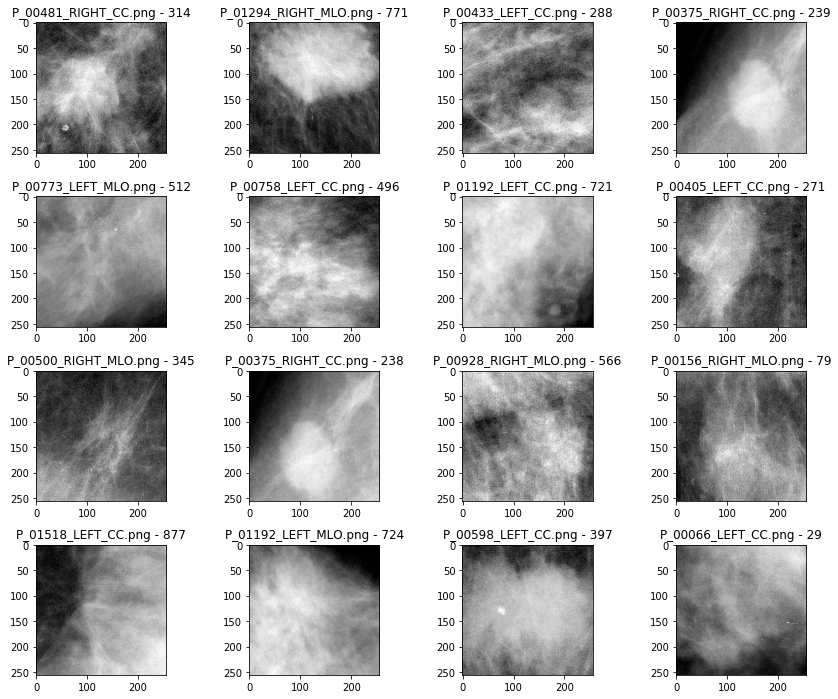

In [6]:
# random images 
N = 16
idx = random.sample(range(len(test_mass_patch)), k=N)
plt.figure(figsize=(12,12))
for i, j in enumerate(idx):
    plt.subplot(5,4,i+1)
    plt.imshow(test_mass_patch[j].reshape(256, 256), cmap='gray')
    plt.title(test_mass_FN[j] + " - " + str(j)) #+ "\n" + "Mean:" + str(round(np.mean(test_mass_patch[j]),3)) + " | Var:" + str(round(np.var(test_mass_patch[j]),3)))
    plt.tight_layout()
plt.show()

In [21]:
print("ROI Mean Size:", np.round(np.mean(test_mass_roi_size),2))
print("ROI Min Size:", np.min(test_mass_roi_size))
print("ROI Max Size:", np.max(test_mass_roi_size))
print("ROI Size Std:", np.round(np.std(test_mass_roi_size),2))

ROI Mean Size: 350.07
ROI Min Size: 116
ROI Max Size: 995
ROI Size Std: 134.51


In [22]:
np.save(os.path.join("Processed_abnorm_256", "test_mass_patch.npy"), test_mass_patch)
np.save(os.path.join("Processed_abnorm_256", "test_mass_Lbl.npy"), np.array(test_mass_Lbl))
np.save(os.path.join("Processed_abnorm_256", "test_mass_FN.npy"), test_mass_FN)
np.save(os.path.join("Processed_abnorm_256", "test_mass_roi_size.npy"), np.array(test_mass_roi_size))

##  Test calc data

In [29]:
test_labels = pd.read_pickle(os.path.join("Processed_abnorm_256", "test_label.pkl"))
test_labels['IMAGE_NAME2'] = test_labels.index
test_labels = test_labels.drop_duplicates(['IMAGE_NAME2'])

## use a copy on the local drive to make testing faster
mask_dir = "CBIS_png/Test/Calc_MASK_imgs"
img_dir = "CBIS_png/Test/Calc_full_imgs"

test_calc_patch, test_calc_Lbl, test_calc_FN, test_calc_roi_size = \
        create_patches(mask_dir, img_dir, Lbls=test_labels, debug=True)
                                   

  0%|                                                                                          | 0/326 [00:00<?, ?it/s]

Mask P_00038_LEFT_CC_1_MASK.png  Height: 209 Width: 225
ROI small P_00038_LEFT_CC_1_MASK.png


  0%|▎                                                                                 | 1/326 [00:00<02:00,  2.69it/s]

Mask P_00038_LEFT_MLO_1_MASK.png  Height: 225 Width: 209
ROI small P_00038_LEFT_MLO_1_MASK.png


  1%|▌                                                                                 | 2/326 [00:00<02:04,  2.60it/s]

Mask P_00038_RIGHT_CC_1_MASK.png  Height: 369 Width: 633
ROI Big P_00038_RIGHT_CC_1_MASK.png


  1%|▊                                                                                 | 3/326 [00:01<02:02,  2.64it/s]

Mask P_00038_RIGHT_CC_2_MASK.png  Height: 217 Width: 697
ROI Big P_00038_RIGHT_CC_2_MASK.png


  1%|█                                                                                 | 4/326 [00:01<02:00,  2.67it/s]

Mask P_00038_RIGHT_MLO_1_MASK.png  Height: 769 Width: 793
ROI Big P_00038_RIGHT_MLO_1_MASK.png


  2%|█▎                                                                                | 5/326 [00:01<02:02,  2.61it/s]

Mask P_00038_RIGHT_MLO_2_MASK.png  Height: 457 Width: 761
ROI Big P_00038_RIGHT_MLO_2_MASK.png


  2%|█▌                                                                                | 6/326 [00:02<02:04,  2.56it/s]

Trimming borders CBIS_png/Test/Calc_MASK_imgs/P_00041_LEFT_CC_2_MASK.png
Mask P_00041_LEFT_CC_2_MASK.png  Height: 81 Width: 97
ROI small P_00041_LEFT_CC_2_MASK.png


  2%|█▊                                                                                | 7/326 [00:03<02:32,  2.09it/s]

Trimming borders CBIS_png/Test/Calc_MASK_imgs/P_00041_LEFT_MLO_2_MASK.png
Mask P_00041_LEFT_MLO_2_MASK.png  Height: 105 Width: 105
ROI small P_00041_LEFT_MLO_2_MASK.png


  2%|██                                                                                | 8/326 [00:03<02:58,  1.78it/s]

Mask P_00077_LEFT_CC_1_MASK.png  Height: 65 Width: 74
ROI small P_00077_LEFT_CC_1_MASK.png


  3%|██▎                                                                               | 9/326 [00:04<02:45,  1.91it/s]

Trimming borders CBIS_png/Test/Calc_MASK_imgs/P_00077_LEFT_MLO_1_MASK.png
Mask P_00077_LEFT_MLO_1_MASK.png  Height: 105 Width: 73
ROI small P_00077_LEFT_MLO_1_MASK.png


  3%|██▍                                                                              | 10/326 [00:04<02:38,  1.99it/s]

Trimming borders CBIS_png/Test/Calc_MASK_imgs/P_00077_RIGHT_CC_1_MASK.png
Mask P_00077_RIGHT_CC_1_MASK.png  Height: 153 Width: 129
ROI small P_00077_RIGHT_CC_1_MASK.png


  3%|██▋                                                                              | 11/326 [00:05<02:34,  2.04it/s]

Trimming borders CBIS_png/Test/Calc_MASK_imgs/P_00077_RIGHT_CC_2_MASK.png
Mask P_00077_RIGHT_CC_2_MASK.png  Height: 129 Width: 113
ROI small P_00077_RIGHT_CC_2_MASK.png


  4%|██▉                                                                              | 12/326 [00:05<02:31,  2.07it/s]

Trimming borders CBIS_png/Test/Calc_MASK_imgs/P_00077_RIGHT_MLO_1_MASK.png
Mask P_00077_RIGHT_MLO_1_MASK.png  Height: 201 Width: 193
ROI small P_00077_RIGHT_MLO_1_MASK.png


  4%|███▏                                                                             | 13/326 [00:06<02:32,  2.05it/s]

Trimming borders CBIS_png/Test/Calc_MASK_imgs/P_00077_RIGHT_MLO_2_MASK.png
Mask P_00077_RIGHT_MLO_2_MASK.png  Height: 161 Width: 153
ROI small P_00077_RIGHT_MLO_2_MASK.png


  4%|███▍                                                                             | 14/326 [00:06<02:30,  2.08it/s]

Trimming borders CBIS_png/Test/Calc_MASK_imgs/P_00100_RIGHT_CC_1_MASK.png
Mask P_00100_RIGHT_CC_1_MASK.png  Height: 257 Width: 217
ROI small P_00100_RIGHT_CC_1_MASK.png


  5%|███▋                                                                             | 15/326 [00:07<02:29,  2.07it/s]

Trimming borders CBIS_png/Test/Calc_MASK_imgs/P_00100_RIGHT_MLO_1_MASK.png
Mask P_00100_RIGHT_MLO_1_MASK.png  Height: 225 Width: 209
ROI small P_00100_RIGHT_MLO_1_MASK.png


  5%|███▉                                                                             | 16/326 [00:07<02:31,  2.05it/s]

Trimming borders CBIS_png/Test/Calc_MASK_imgs/P_00127_RIGHT_CC_1_MASK.png
Mask P_00127_RIGHT_CC_1_MASK.png  Height: 273 Width: 257
ROI small P_00127_RIGHT_CC_1_MASK.png


  5%|████▏                                                                            | 17/326 [00:08<02:55,  1.76it/s]

Trimming borders CBIS_png/Test/Calc_MASK_imgs/P_00127_RIGHT_MLO_1_MASK.png
Mask P_00127_RIGHT_MLO_1_MASK.png  Height: 281 Width: 241
ROI small P_00127_RIGHT_MLO_1_MASK.png


  6%|████▍                                                                            | 18/326 [00:09<03:11,  1.61it/s]

Trimming borders CBIS_png/Test/Calc_MASK_imgs/P_00132_LEFT_MLO_1_MASK.png
Mask P_00132_LEFT_MLO_1_MASK.png  Height: 705 Width: 521
ROI Big P_00132_LEFT_MLO_1_MASK.png


  6%|████▋                                                                            | 19/326 [00:09<03:03,  1.68it/s]

Trimming borders CBIS_png/Test/Calc_MASK_imgs/P_00140_LEFT_CC_1_MASK.png
Mask P_00140_LEFT_CC_1_MASK.png  Height: 177 Width: 209
ROI small P_00140_LEFT_CC_1_MASK.png


  6%|████▉                                                                            | 20/326 [00:10<02:53,  1.76it/s]

Trimming borders CBIS_png/Test/Calc_MASK_imgs/P_00140_LEFT_CC_2_MASK.png
Mask P_00140_LEFT_CC_2_MASK.png  Height: 145 Width: 169
ROI small P_00140_LEFT_CC_2_MASK.png


  6%|█████▏                                                                           | 21/326 [00:10<02:40,  1.91it/s]

Trimming borders CBIS_png/Test/Calc_MASK_imgs/P_00140_LEFT_MLO_1_MASK.png
Mask P_00140_LEFT_MLO_1_MASK.png  Height: 161 Width: 193
ROI small P_00140_LEFT_MLO_1_MASK.png


  7%|█████▍                                                                           | 22/326 [00:10<02:33,  1.98it/s]

Trimming borders CBIS_png/Test/Calc_MASK_imgs/P_00140_LEFT_MLO_2_MASK.png
Mask P_00140_LEFT_MLO_2_MASK.png  Height: 97 Width: 89
ROI small P_00140_LEFT_MLO_2_MASK.png


  7%|█████▋                                                                           | 23/326 [00:11<02:29,  2.02it/s]

Mask P_00140_RIGHT_CC_1_MASK.png  Height: 129 Width: 145
ROI small P_00140_RIGHT_CC_1_MASK.png


  7%|█████▉                                                                           | 24/326 [00:11<02:21,  2.13it/s]

Mask P_00140_RIGHT_CC_2_MASK.png  Height: 113 Width: 153
ROI small P_00140_RIGHT_CC_2_MASK.png


  8%|██████▏                                                                          | 25/326 [00:12<02:14,  2.23it/s]

Trimming borders CBIS_png/Test/Calc_MASK_imgs/P_00140_RIGHT_MLO_1_MASK.png
Mask P_00140_RIGHT_MLO_1_MASK.png  Height: 137 Width: 169
ROI small P_00140_RIGHT_MLO_1_MASK.png


  8%|██████▍                                                                          | 26/326 [00:12<02:14,  2.22it/s]

Trimming borders CBIS_png/Test/Calc_MASK_imgs/P_00140_RIGHT_MLO_2_MASK.png
Mask P_00140_RIGHT_MLO_2_MASK.png  Height: 96 Width: 81
ROI small P_00140_RIGHT_MLO_2_MASK.png


  8%|██████▋                                                                          | 27/326 [00:13<02:15,  2.21it/s]

Trimming borders CBIS_png/Test/Calc_MASK_imgs/P_00141_LEFT_CC_1_MASK.png
Mask P_00141_LEFT_CC_1_MASK.png  Height: 321 Width: 305
ROI small P_00141_LEFT_CC_1_MASK.png


  9%|██████▉                                                                          | 28/326 [00:13<02:19,  2.13it/s]

Trimming borders CBIS_png/Test/Calc_MASK_imgs/P_00141_LEFT_MLO_1_MASK.png
Mask P_00141_LEFT_MLO_1_MASK.png  Height: 393 Width: 441
ROI small P_00141_LEFT_MLO_1_MASK.png


  9%|███████▏                                                                         | 29/326 [00:14<02:31,  1.96it/s]

Trimming borders CBIS_png/Test/Calc_MASK_imgs/P_00150_RIGHT_MLO_1_MASK.png
Mask P_00150_RIGHT_MLO_1_MASK.png  Height: 169 Width: 169
ROI small P_00150_RIGHT_MLO_1_MASK.png


  9%|███████▍                                                                         | 30/326 [00:14<02:33,  1.92it/s]

Mask P_00163_LEFT_CC_1_MASK.png  Height: 193 Width: 201
ROI small P_00163_LEFT_CC_1_MASK.png


 10%|███████▋                                                                         | 31/326 [00:15<02:36,  1.88it/s]

Trimming borders CBIS_png/Test/Calc_MASK_imgs/P_00163_LEFT_MLO_1_MASK.png
Mask P_00163_LEFT_MLO_1_MASK.png  Height: 193 Width: 209
ROI small P_00163_LEFT_MLO_1_MASK.png


 10%|███████▉                                                                         | 32/326 [00:16<02:46,  1.76it/s]

Trimming borders CBIS_png/Test/Calc_MASK_imgs/P_00164_RIGHT_CC_1_MASK.png
Mask P_00164_RIGHT_CC_1_MASK.png  Height: 161 Width: 137
ROI small P_00164_RIGHT_CC_1_MASK.png


 10%|████████▏                                                                        | 33/326 [00:16<02:32,  1.92it/s]

Trimming borders CBIS_png/Test/Calc_MASK_imgs/P_00180_LEFT_CC_1_MASK.png
Mask P_00180_LEFT_CC_1_MASK.png  Height: 913 Width: 777
ROI Big P_00180_LEFT_CC_1_MASK.png


 10%|████████▍                                                                        | 34/326 [00:16<02:20,  2.08it/s]

Trimming borders CBIS_png/Test/Calc_MASK_imgs/P_00180_LEFT_MLO_1_MASK.png
Mask P_00180_LEFT_MLO_1_MASK.png  Height: 785 Width: 737
ROI Big P_00180_LEFT_MLO_1_MASK.png


 11%|████████▋                                                                        | 35/326 [00:17<02:15,  2.15it/s]

Trimming borders CBIS_png/Test/Calc_MASK_imgs/P_00195_LEFT_CC_1_MASK.png
Mask P_00195_LEFT_CC_1_MASK.png  Height: 577 Width: 673
ROI Big P_00195_LEFT_CC_1_MASK.png


 11%|████████▉                                                                        | 36/326 [00:17<02:20,  2.06it/s]

Trimming borders CBIS_png/Test/Calc_MASK_imgs/P_00195_LEFT_MLO_1_MASK.png
Mask P_00195_LEFT_MLO_1_MASK.png  Height: 537 Width: 569
ROI Big P_00195_LEFT_MLO_1_MASK.png


 11%|█████████▏                                                                       | 37/326 [00:18<02:23,  2.01it/s]

Trimming borders CBIS_png/Test/Calc_MASK_imgs/P_00202_RIGHT_CC_2_MASK.png
Mask P_00202_RIGHT_CC_2_MASK.png  Height: 1089 Width: 1553
ROI Big P_00202_RIGHT_CC_2_MASK.png


 12%|█████████▍                                                                       | 38/326 [00:19<02:44,  1.75it/s]

Trimming borders CBIS_png/Test/Calc_MASK_imgs/P_00202_RIGHT_MLO_2_MASK.png
Mask P_00202_RIGHT_MLO_2_MASK.png  Height: 1209 Width: 953
ROI Big P_00202_RIGHT_MLO_2_MASK.png


 12%|█████████▋                                                                       | 39/326 [00:19<03:02,  1.57it/s]

Mask P_00214_LEFT_CC_1_MASK.png  Height: 73 Width: 65
ROI small P_00214_LEFT_CC_1_MASK.png


 12%|█████████▉                                                                       | 40/326 [00:20<02:44,  1.74it/s]

Mask P_00214_LEFT_CC_2_MASK.png  Height: 177 Width: 177
ROI small P_00214_LEFT_CC_2_MASK.png


 13%|██████████▏                                                                      | 41/326 [00:20<02:30,  1.90it/s]

Trimming borders CBIS_png/Test/Calc_MASK_imgs/P_00214_LEFT_MLO_1_MASK.png
Mask P_00214_LEFT_MLO_1_MASK.png  Height: 105 Width: 89
ROI small P_00214_LEFT_MLO_1_MASK.png


 13%|██████████▍                                                                      | 42/326 [00:21<02:23,  1.98it/s]

Trimming borders CBIS_png/Test/Calc_MASK_imgs/P_00214_LEFT_MLO_2_MASK.png
Mask P_00214_LEFT_MLO_2_MASK.png  Height: 89 Width: 105
ROI small P_00214_LEFT_MLO_2_MASK.png


 13%|██████████▋                                                                      | 43/326 [00:21<02:20,  2.01it/s]

Trimming borders CBIS_png/Test/Calc_MASK_imgs/P_00214_RIGHT_MLO_1_MASK.png
Mask P_00214_RIGHT_MLO_1_MASK.png  Height: 209 Width: 169
ROI small P_00214_RIGHT_MLO_1_MASK.png


 13%|██████████▉                                                                      | 44/326 [00:22<02:19,  2.02it/s]

Trimming borders CBIS_png/Test/Calc_MASK_imgs/P_00223_LEFT_MLO_1_MASK.png
Mask P_00223_LEFT_MLO_1_MASK.png  Height: 337 Width: 321
ROI small P_00223_LEFT_MLO_1_MASK.png


 14%|███████████▏                                                                     | 45/326 [00:22<02:20,  2.00it/s]

Mask P_00244_RIGHT_MLO_1_MASK.png  Height: 136 Width: 166
ROI small P_00244_RIGHT_MLO_1_MASK.png


 14%|███████████▍                                                                     | 46/326 [00:22<02:05,  2.23it/s]

Trimming borders CBIS_png/Test/Calc_MASK_imgs/P_00246_RIGHT_MLO_1_MASK.png
Mask P_00246_RIGHT_MLO_1_MASK.png  Height: 161 Width: 175
ROI small P_00246_RIGHT_MLO_1_MASK.png


 14%|███████████▋                                                                     | 47/326 [00:23<02:39,  1.75it/s]

Trimming borders CBIS_png/Test/Calc_MASK_imgs/P_00257_RIGHT_CC_1_MASK.png
Mask P_00257_RIGHT_CC_1_MASK.png  Height: 249 Width: 281
ROI small P_00257_RIGHT_CC_1_MASK.png


 15%|███████████▉                                                                     | 48/326 [00:24<02:27,  1.88it/s]

Trimming borders CBIS_png/Test/Calc_MASK_imgs/P_00257_RIGHT_MLO_1_MASK.png
Mask P_00257_RIGHT_MLO_1_MASK.png  Height: 305 Width: 297
ROI small P_00257_RIGHT_MLO_1_MASK.png


 15%|████████████▏                                                                    | 49/326 [00:24<02:20,  1.98it/s]

Mask P_00299_LEFT_MLO_1_MASK.png  Height: 761 Width: 729
ROI Big P_00299_LEFT_MLO_1_MASK.png


 15%|████████████▍                                                                    | 50/326 [00:25<02:36,  1.77it/s]

Trimming borders CBIS_png/Test/Calc_MASK_imgs/P_00299_RIGHT_CC_1_MASK.png
Mask P_00299_RIGHT_CC_1_MASK.png  Height: 1201 Width: 1121
ROI Big P_00299_RIGHT_CC_1_MASK.png


 16%|████████████▋                                                                    | 51/326 [00:26<02:41,  1.70it/s]

Trimming borders CBIS_png/Test/Calc_MASK_imgs/P_00299_RIGHT_MLO_1_MASK.png
Mask P_00299_RIGHT_MLO_1_MASK.png  Height: 1105 Width: 969
ROI Big P_00299_RIGHT_MLO_1_MASK.png


 16%|████████████▉                                                                    | 52/326 [00:26<03:00,  1.51it/s]

Trimming borders CBIS_png/Test/Calc_MASK_imgs/P_00315_LEFT_MLO_1_MASK.png
Mask P_00315_LEFT_MLO_1_MASK.png  Height: 209 Width: 265
ROI small P_00315_LEFT_MLO_1_MASK.png


 16%|█████████████▏                                                                   | 53/326 [00:27<03:10,  1.43it/s]

Trimming borders CBIS_png/Test/Calc_MASK_imgs/P_00325_RIGHT_MLO_1_MASK.png
Mask P_00325_RIGHT_MLO_1_MASK.png  Height: 337 Width: 401
ROI small P_00325_RIGHT_MLO_1_MASK.png


 17%|█████████████▍                                                                   | 54/326 [00:28<03:00,  1.51it/s]

Trimming borders CBIS_png/Test/Calc_MASK_imgs/P_00331_LEFT_CC_1_MASK.png
Mask P_00331_LEFT_CC_1_MASK.png  Height: 209 Width: 241
ROI small P_00331_LEFT_CC_1_MASK.png


 17%|█████████████▋                                                                   | 55/326 [00:28<03:05,  1.46it/s]

Trimming borders CBIS_png/Test/Calc_MASK_imgs/P_00331_LEFT_MLO_1_MASK.png
Mask P_00331_LEFT_MLO_1_MASK.png  Height: 169 Width: 169
ROI small P_00331_LEFT_MLO_1_MASK.png


 17%|█████████████▉                                                                   | 56/326 [00:29<03:15,  1.38it/s]

Mask P_00344_LEFT_CC_1_MASK.png  Height: 393 Width: 361
ROI small P_00344_LEFT_CC_1_MASK.png


 17%|██████████████▏                                                                  | 57/326 [00:30<02:50,  1.58it/s]

Mask P_00344_LEFT_MLO_1_MASK.png  Height: 361 Width: 329
ROI small P_00344_LEFT_MLO_1_MASK.png


 18%|██████████████▍                                                                  | 58/326 [00:30<02:31,  1.77it/s]

Mask P_00352_LEFT_CC_1_MASK.png  Height: 337 Width: 225
ROI small P_00352_LEFT_CC_1_MASK.png


 18%|██████████████▋                                                                  | 59/326 [00:30<02:17,  1.94it/s]

Trimming borders CBIS_png/Test/Calc_MASK_imgs/P_00352_LEFT_MLO_1_MASK.png
Mask P_00352_LEFT_MLO_1_MASK.png  Height: 313 Width: 361
ROI small P_00352_LEFT_MLO_1_MASK.png


 18%|██████████████▉                                                                  | 60/326 [00:31<02:10,  2.03it/s]

Mask P_00353_LEFT_CC_1_MASK.png  Height: 193 Width: 169
ROI small P_00353_LEFT_CC_1_MASK.png


 19%|███████████████▏                                                                 | 61/326 [00:31<02:05,  2.11it/s]

Mask shape: (4688, 3088)
Image shape: (4624, 3056)
Mask shape doesn't match image! CBIS_png/Test/Calc_MASK_imgs/P_00353_LEFT_CC_2_MASK.png
Mask Size Error: 0 for P_00353_LEFT_CC_2_MASK.png
Error, skipping P_00353_LEFT_CC_2_MASK.png


 19%|███████████████▍                                                                 | 62/326 [00:32<01:58,  2.22it/s]

Trimming borders CBIS_png/Test/Calc_MASK_imgs/P_00353_LEFT_MLO_1_MASK.png
Mask P_00353_LEFT_MLO_1_MASK.png  Height: 177 Width: 233
ROI small P_00353_LEFT_MLO_1_MASK.png


 19%|███████████████▋                                                                 | 63/326 [00:32<02:02,  2.15it/s]

Trimming borders CBIS_png/Test/Calc_MASK_imgs/P_00353_LEFT_MLO_2_MASK.png
Mask shape: (4584, 3040)
Image shape: (4600, 3032)
Mask shape doesn't match image! CBIS_png/Test/Calc_MASK_imgs/P_00353_LEFT_MLO_2_MASK.png
Mask Size Error: 0 for P_00353_LEFT_MLO_2_MASK.png
Error, skipping P_00353_LEFT_MLO_2_MASK.png


 20%|███████████████▉                                                                 | 64/326 [00:33<01:58,  2.21it/s]

Mask P_00368_LEFT_CC_1_MASK.png  Height: 769 Width: 585
ROI Big P_00368_LEFT_CC_1_MASK.png


 20%|████████████████▏                                                                | 65/326 [00:33<01:52,  2.33it/s]

Mask P_00368_LEFT_MLO_1_MASK.png  Height: 1025 Width: 689
ROI Big P_00368_LEFT_MLO_1_MASK.png


 20%|████████████████▍                                                                | 66/326 [00:33<01:51,  2.34it/s]

Mask P_00372_RIGHT_CC_1_MASK.png  Height: 681 Width: 697
ROI Big P_00372_RIGHT_CC_1_MASK.png


 21%|████████████████▋                                                                | 67/326 [00:34<01:48,  2.40it/s]

Trimming borders CBIS_png/Test/Calc_MASK_imgs/P_00372_RIGHT_MLO_1_MASK.png
Mask P_00372_RIGHT_MLO_1_MASK.png  Height: 737 Width: 553
ROI Big P_00372_RIGHT_MLO_1_MASK.png


 21%|████████████████▉                                                                | 68/326 [00:34<01:48,  2.37it/s]

Mask P_00390_RIGHT_CC_1_MASK.png  Height: 681 Width: 345
ROI Big P_00390_RIGHT_CC_1_MASK.png


 21%|█████████████████▏                                                               | 69/326 [00:35<01:44,  2.47it/s]

Trimming borders CBIS_png/Test/Calc_MASK_imgs/P_00390_RIGHT_MLO_1_MASK.png
Mask P_00390_RIGHT_MLO_1_MASK.png  Height: 937 Width: 577
ROI Big P_00390_RIGHT_MLO_1_MASK.png


 21%|█████████████████▍                                                               | 70/326 [00:35<01:44,  2.46it/s]

Mask P_00397_LEFT_CC_1_MASK.png  Height: 146 Width: 241
ROI small P_00397_LEFT_CC_1_MASK.png


 22%|█████████████████▋                                                               | 71/326 [00:36<01:55,  2.22it/s]

Trimming borders CBIS_png/Test/Calc_MASK_imgs/P_00402_RIGHT_CC_1_MASK.png
Mask P_00402_RIGHT_CC_1_MASK.png  Height: 137 Width: 153
ROI small P_00402_RIGHT_CC_1_MASK.png


 22%|█████████████████▉                                                               | 72/326 [00:36<01:53,  2.24it/s]

Trimming borders CBIS_png/Test/Calc_MASK_imgs/P_00402_RIGHT_MLO_1_MASK.png
Mask P_00402_RIGHT_MLO_1_MASK.png  Height: 121 Width: 121
ROI small P_00402_RIGHT_MLO_1_MASK.png


 22%|██████████████████▏                                                              | 73/326 [00:37<01:56,  2.17it/s]

Trimming borders CBIS_png/Test/Calc_MASK_imgs/P_00403_RIGHT_CC_1_MASK.png
Mask P_00403_RIGHT_CC_1_MASK.png  Height: 569 Width: 1169
ROI Big P_00403_RIGHT_CC_1_MASK.png


 23%|██████████████████▍                                                              | 74/326 [00:37<02:02,  2.05it/s]

Trimming borders CBIS_png/Test/Calc_MASK_imgs/P_00403_RIGHT_MLO_1_MASK.png
Mask P_00403_RIGHT_MLO_1_MASK.png  Height: 865 Width: 1193
ROI Big P_00403_RIGHT_MLO_1_MASK.png


 23%|██████████████████▋                                                              | 75/326 [00:38<02:15,  1.86it/s]

Mask P_00460_LEFT_CC_1_MASK.png  Height: 753 Width: 817
ROI Big P_00460_LEFT_CC_1_MASK.png


 23%|██████████████████▉                                                              | 76/326 [00:38<02:05,  1.99it/s]

Trimming borders CBIS_png/Test/Calc_MASK_imgs/P_00460_LEFT_MLO_1_MASK.png
Mask P_00460_LEFT_MLO_1_MASK.png  Height: 753 Width: 745
ROI Big P_00460_LEFT_MLO_1_MASK.png


 24%|███████████████████▏                                                             | 77/326 [00:39<01:59,  2.09it/s]

Trimming borders CBIS_png/Test/Calc_MASK_imgs/P_00466_LEFT_MLO_1_MASK.png
Mask P_00466_LEFT_MLO_1_MASK.png  Height: 225 Width: 265
ROI small P_00466_LEFT_MLO_1_MASK.png


 24%|███████████████████▍                                                             | 78/326 [00:39<01:56,  2.13it/s]

Mask P_00485_LEFT_CC_1_MASK.png  Height: 2201 Width: 1449
ROI Big P_00485_LEFT_CC_1_MASK.png


 24%|███████████████████▋                                                             | 79/326 [00:40<02:18,  1.79it/s]

Mask P_00485_LEFT_CC_2_MASK.png  Height: 385 Width: 377
ROI small P_00485_LEFT_CC_2_MASK.png


 25%|███████████████████▉                                                             | 80/326 [00:41<02:29,  1.64it/s]

Mask P_00485_LEFT_CC_3_MASK.png  Height: 401 Width: 353
ROI small P_00485_LEFT_CC_3_MASK.png


 25%|████████████████████▏                                                            | 81/326 [00:41<02:39,  1.54it/s]

Mask P_00485_LEFT_CC_4_MASK.png  Height: 417 Width: 361
ROI small P_00485_LEFT_CC_4_MASK.png


 25%|████████████████████▎                                                            | 82/326 [00:42<02:46,  1.47it/s]

Mask P_00485_LEFT_CC_5_MASK.png  Height: 289 Width: 289
ROI small P_00485_LEFT_CC_5_MASK.png


 25%|████████████████████▌                                                            | 83/326 [00:43<02:55,  1.39it/s]

Trimming borders CBIS_png/Test/Calc_MASK_imgs/P_00485_LEFT_MLO_1_MASK.png
Mask P_00485_LEFT_MLO_1_MASK.png  Height: 1689 Width: 1905
ROI Big P_00485_LEFT_MLO_1_MASK.png


 26%|████████████████████▊                                                            | 84/326 [00:44<02:57,  1.36it/s]

Trimming borders CBIS_png/Test/Calc_MASK_imgs/P_00495_RIGHT_CC_2_MASK.png
Mask P_00495_RIGHT_CC_2_MASK.png  Height: 65 Width: 57
ROI small P_00495_RIGHT_CC_2_MASK.png


 26%|█████████████████████                                                            | 85/326 [00:44<02:39,  1.51it/s]

Trimming borders CBIS_png/Test/Calc_MASK_imgs/P_00495_RIGHT_CC_3_MASK.png
Mask P_00495_RIGHT_CC_3_MASK.png  Height: 105 Width: 209
ROI small P_00495_RIGHT_CC_3_MASK.png


 26%|█████████████████████▎                                                           | 86/326 [00:45<02:25,  1.65it/s]

Trimming borders CBIS_png/Test/Calc_MASK_imgs/P_00495_RIGHT_MLO_1_MASK.png
Mask P_00495_RIGHT_MLO_1_MASK.png  Height: 49 Width: 65
ROI small P_00495_RIGHT_MLO_1_MASK.png


 27%|█████████████████████▌                                                           | 87/326 [00:45<02:17,  1.74it/s]

Trimming borders CBIS_png/Test/Calc_MASK_imgs/P_00495_RIGHT_MLO_3_MASK.png
Mask P_00495_RIGHT_MLO_3_MASK.png  Height: 89 Width: 28
ROI small P_00495_RIGHT_MLO_3_MASK.png


 27%|█████████████████████▊                                                           | 88/326 [00:46<02:07,  1.87it/s]

Trimming borders CBIS_png/Test/Calc_MASK_imgs/P_00497_LEFT_CC_1_MASK.png
Mask P_00497_LEFT_CC_1_MASK.png  Height: 473 Width: 681
ROI Big P_00497_LEFT_CC_1_MASK.png


 27%|██████████████████████                                                           | 89/326 [00:46<01:57,  2.02it/s]

Trimming borders CBIS_png/Test/Calc_MASK_imgs/P_00497_LEFT_MLO_1_MASK.png
Mask P_00497_LEFT_MLO_1_MASK.png  Height: 657 Width: 761
ROI Big P_00497_LEFT_MLO_1_MASK.png


 28%|██████████████████████▎                                                          | 90/326 [00:46<01:55,  2.04it/s]

Trimming borders CBIS_png/Test/Calc_MASK_imgs/P_00537_RIGHT_MLO_1_MASK.png
Mask P_00537_RIGHT_MLO_1_MASK.png  Height: 812 Width: 860
ROI Big P_00537_RIGHT_MLO_1_MASK.png


 28%|██████████████████████▌                                                          | 91/326 [00:47<01:54,  2.05it/s]

Mask P_00562_LEFT_CC_1_MASK.png  Height: 89 Width: 65
ROI small P_00562_LEFT_CC_1_MASK.png


 28%|██████████████████████▊                                                          | 92/326 [00:47<01:52,  2.07it/s]

Mask P_00562_LEFT_CC_2_MASK.png  Height: 57 Width: 57
ROI small P_00562_LEFT_CC_2_MASK.png


 29%|███████████████████████                                                          | 93/326 [00:48<01:49,  2.14it/s]

Trimming borders CBIS_png/Test/Calc_MASK_imgs/P_00562_LEFT_MLO_1_MASK.png
Mask P_00562_LEFT_MLO_1_MASK.png  Height: 81 Width: 89
ROI small P_00562_LEFT_MLO_1_MASK.png


 29%|███████████████████████▎                                                         | 94/326 [00:48<01:48,  2.14it/s]

Trimming borders CBIS_png/Test/Calc_MASK_imgs/P_00562_LEFT_MLO_2_MASK.png
Mask P_00562_LEFT_MLO_2_MASK.png  Height: 41 Width: 57
ROI small P_00562_LEFT_MLO_2_MASK.png


 29%|███████████████████████▌                                                         | 95/326 [00:49<01:47,  2.15it/s]

Trimming borders CBIS_png/Test/Calc_MASK_imgs/P_00562_RIGHT_CC_1_MASK.png
Mask P_00562_RIGHT_CC_1_MASK.png  Height: 57 Width: 49
ROI small P_00562_RIGHT_CC_1_MASK.png


 29%|███████████████████████▊                                                         | 96/326 [00:49<01:49,  2.10it/s]

Trimming borders CBIS_png/Test/Calc_MASK_imgs/P_00562_RIGHT_MLO_1_MASK.png
Mask P_00562_RIGHT_MLO_1_MASK.png  Height: 57 Width: 73
ROI small P_00562_RIGHT_MLO_1_MASK.png


 30%|████████████████████████                                                         | 97/326 [00:50<01:49,  2.09it/s]

Trimming borders CBIS_png/Test/Calc_MASK_imgs/P_00570_LEFT_MLO_1_MASK.png
Mask P_00570_LEFT_MLO_1_MASK.png  Height: 161 Width: 145
ROI small P_00570_LEFT_MLO_1_MASK.png


 30%|████████████████████████▎                                                        | 98/326 [00:50<01:53,  2.01it/s]

Trimming borders CBIS_png/Test/Calc_MASK_imgs/P_00579_LEFT_MLO_1_MASK.png
Mask P_00579_LEFT_MLO_1_MASK.png  Height: 525 Width: 509
ROI Big P_00579_LEFT_MLO_1_MASK.png


 30%|████████████████████████▌                                                        | 99/326 [00:51<01:51,  2.04it/s]

Mask P_00589_LEFT_CC_1_MASK.png  Height: 401 Width: 465
ROI small P_00589_LEFT_CC_1_MASK.png


 31%|████████████████████████▌                                                       | 100/326 [00:51<01:44,  2.16it/s]

Trimming borders CBIS_png/Test/Calc_MASK_imgs/P_00589_LEFT_MLO_1_MASK.png
Mask P_00589_LEFT_MLO_1_MASK.png  Height: 553 Width: 537
ROI Big P_00589_LEFT_MLO_1_MASK.png


 31%|████████████████████████▊                                                       | 101/326 [00:52<01:44,  2.16it/s]

Trimming borders CBIS_png/Test/Calc_MASK_imgs/P_00608_LEFT_CC_1_MASK.png
Mask P_00608_LEFT_CC_1_MASK.png  Height: 291 Width: 450
ROI small P_00608_LEFT_CC_1_MASK.png


 31%|█████████████████████████                                                       | 102/326 [00:52<01:51,  2.00it/s]

Trimming borders CBIS_png/Test/Calc_MASK_imgs/P_00608_LEFT_MLO_1_MASK.png
Mask P_00608_LEFT_MLO_1_MASK.png  Height: 406 Width: 441
ROI small P_00608_LEFT_MLO_1_MASK.png


 32%|█████████████████████████▎                                                      | 103/326 [00:53<02:02,  1.82it/s]

Trimming borders CBIS_png/Test/Calc_MASK_imgs/P_00620_LEFT_CC_1_MASK.png
Mask P_00620_LEFT_CC_1_MASK.png  Height: 401 Width: 465
ROI small P_00620_LEFT_CC_1_MASK.png


 32%|█████████████████████████▌                                                      | 104/326 [00:54<02:15,  1.63it/s]

Mask P_00643_LEFT_CC_1_MASK.png  Height: 396 Width: 451
ROI small P_00643_LEFT_CC_1_MASK.png


 32%|█████████████████████████▊                                                      | 105/326 [00:54<01:55,  1.91it/s]

Trimming borders CBIS_png/Test/Calc_MASK_imgs/P_00643_LEFT_MLO_1_MASK.png
Mask P_00643_LEFT_MLO_1_MASK.png  Height: 296 Width: 371
ROI small P_00643_LEFT_MLO_1_MASK.png


 33%|██████████████████████████                                                      | 106/326 [00:54<01:51,  1.96it/s]

Trimming borders CBIS_png/Test/Calc_MASK_imgs/P_00646_LEFT_CC_1_MASK.png
Mask P_00646_LEFT_CC_1_MASK.png  Height: 506 Width: 671
ROI Big P_00646_LEFT_CC_1_MASK.png


 33%|██████████████████████████▎                                                     | 107/326 [00:55<01:48,  2.02it/s]

Trimming borders CBIS_png/Test/Calc_MASK_imgs/P_00646_LEFT_MLO_1_MASK.png
Mask P_00646_LEFT_MLO_1_MASK.png  Height: 521 Width: 536
ROI Big P_00646_LEFT_MLO_1_MASK.png


 33%|██████████████████████████▌                                                     | 108/326 [00:55<01:49,  1.98it/s]

Trimming borders CBIS_png/Test/Calc_MASK_imgs/P_00649_LEFT_CC_1_MASK.png
Mask P_00649_LEFT_CC_1_MASK.png  Height: 321 Width: 305
ROI small P_00649_LEFT_CC_1_MASK.png


 33%|██████████████████████████▋                                                     | 109/326 [00:56<02:16,  1.59it/s]

Trimming borders CBIS_png/Test/Calc_MASK_imgs/P_00649_LEFT_MLO_1_MASK.png
Mask P_00649_LEFT_MLO_1_MASK.png  Height: 417 Width: 689
ROI Big P_00649_LEFT_MLO_1_MASK.png


 34%|██████████████████████████▉                                                     | 110/326 [00:57<02:33,  1.41it/s]

Mask P_00663_RIGHT_CC_1_MASK.png  Height: 441 Width: 449
ROI small P_00663_RIGHT_CC_1_MASK.png


 34%|███████████████████████████▏                                                    | 111/326 [00:58<02:11,  1.64it/s]

Trimming borders CBIS_png/Test/Calc_MASK_imgs/P_00663_RIGHT_MLO_1_MASK.png
Mask P_00663_RIGHT_MLO_1_MASK.png  Height: 609 Width: 561
ROI Big P_00663_RIGHT_MLO_1_MASK.png


 34%|███████████████████████████▍                                                    | 112/326 [00:58<01:59,  1.78it/s]

Trimming borders CBIS_png/Test/Calc_MASK_imgs/P_00678_LEFT_CC_1_MASK.png
Mask P_00678_LEFT_CC_1_MASK.png  Height: 1417 Width: 1809
ROI Big P_00678_LEFT_CC_1_MASK.png


 35%|███████████████████████████▋                                                    | 113/326 [00:59<02:05,  1.70it/s]

Mask P_00679_LEFT_CC_1_MASK.png  Height: 129 Width: 177
ROI small P_00679_LEFT_CC_1_MASK.png


 35%|███████████████████████████▉                                                    | 114/326 [00:59<01:55,  1.84it/s]

Trimming borders CBIS_png/Test/Calc_MASK_imgs/P_00679_LEFT_MLO_1_MASK.png
Mask P_00679_LEFT_MLO_1_MASK.png  Height: 121 Width: 169
ROI small P_00679_LEFT_MLO_1_MASK.png


 35%|████████████████████████████▏                                                   | 115/326 [01:00<01:48,  1.94it/s]

Trimming borders CBIS_png/Test/Calc_MASK_imgs/P_00681_LEFT_CC_1_MASK.png
Mask P_00681_LEFT_CC_1_MASK.png  Height: 476 Width: 711
ROI Big P_00681_LEFT_CC_1_MASK.png


 36%|████████████████████████████▍                                                   | 116/326 [01:00<01:46,  1.97it/s]

Trimming borders CBIS_png/Test/Calc_MASK_imgs/P_00681_LEFT_MLO_1_MASK.png
Mask P_00681_LEFT_MLO_1_MASK.png  Height: 636 Width: 641
ROI Big P_00681_LEFT_MLO_1_MASK.png


 36%|████████████████████████████▋                                                   | 117/326 [01:01<01:47,  1.95it/s]

Trimming borders CBIS_png/Test/Calc_MASK_imgs/P_00686_RIGHT_MLO_1_MASK.png
Mask P_00686_RIGHT_MLO_1_MASK.png  Height: 271 Width: 247
ROI small P_00686_RIGHT_MLO_1_MASK.png


 36%|████████████████████████████▉                                                   | 118/326 [01:01<01:52,  1.85it/s]

Trimming borders CBIS_png/Test/Calc_MASK_imgs/P_00723_LEFT_MLO_2_MASK.png
Mask P_00723_LEFT_MLO_2_MASK.png  Height: 193 Width: 209
ROI small P_00723_LEFT_MLO_2_MASK.png


 37%|█████████████████████████████▏                                                  | 119/326 [01:02<01:56,  1.78it/s]

Trimming borders CBIS_png/Test/Calc_MASK_imgs/P_00723_LEFT_MLO_3_MASK.png
Mask P_00723_LEFT_MLO_3_MASK.png  Height: 217 Width: 185
ROI small P_00723_LEFT_MLO_3_MASK.png


 37%|█████████████████████████████▍                                                  | 120/326 [01:02<01:59,  1.73it/s]

Trimming borders CBIS_png/Test/Calc_MASK_imgs/P_00723_LEFT_MLO_4_MASK.png
Mask P_00723_LEFT_MLO_4_MASK.png  Height: 273 Width: 305
ROI small P_00723_LEFT_MLO_4_MASK.png


 37%|█████████████████████████████▋                                                  | 121/326 [01:03<02:01,  1.68it/s]

Trimming borders CBIS_png/Test/Calc_MASK_imgs/P_00753_LEFT_CC_1_MASK.png
Mask P_00753_LEFT_CC_1_MASK.png  Height: 505 Width: 465
ROI small P_00753_LEFT_CC_1_MASK.png


 37%|█████████████████████████████▉                                                  | 122/326 [01:03<01:50,  1.85it/s]

Trimming borders CBIS_png/Test/Calc_MASK_imgs/P_00753_LEFT_MLO_1_MASK.png
Mask P_00753_LEFT_MLO_1_MASK.png  Height: 585 Width: 585
ROI Big P_00753_LEFT_MLO_1_MASK.png


 38%|██████████████████████████████▏                                                 | 123/326 [01:04<01:42,  1.97it/s]

Trimming borders CBIS_png/Test/Calc_MASK_imgs/P_00774_RIGHT_CC_1_MASK.png
Mask P_00774_RIGHT_CC_1_MASK.png  Height: 321 Width: 217
ROI small P_00774_RIGHT_CC_1_MASK.png


 38%|██████████████████████████████▍                                                 | 124/326 [01:04<01:36,  2.10it/s]

Trimming borders CBIS_png/Test/Calc_MASK_imgs/P_00774_RIGHT_MLO_1_MASK.png
Mask P_00774_RIGHT_MLO_1_MASK.png  Height: 289 Width: 321
ROI small P_00774_RIGHT_MLO_1_MASK.png


 38%|██████████████████████████████▋                                                 | 125/326 [01:05<01:32,  2.18it/s]

Trimming borders CBIS_png/Test/Calc_MASK_imgs/P_00789_LEFT_MLO_1_MASK.png
Mask P_00789_LEFT_MLO_1_MASK.png  Height: 481 Width: 513
ROI Big P_00789_LEFT_MLO_1_MASK.png


 39%|██████████████████████████████▉                                                 | 126/326 [01:05<01:34,  2.12it/s]

Trimming borders CBIS_png/Test/Calc_MASK_imgs/P_00790_RIGHT_CC_1_MASK.png
Mask P_00790_RIGHT_CC_1_MASK.png  Height: 273 Width: 265
ROI small P_00790_RIGHT_CC_1_MASK.png


 39%|███████████████████████████████▏                                                | 127/326 [01:06<01:33,  2.13it/s]

Trimming borders CBIS_png/Test/Calc_MASK_imgs/P_00790_RIGHT_MLO_1_MASK.png
Mask P_00790_RIGHT_MLO_1_MASK.png  Height: 233 Width: 257
ROI small P_00790_RIGHT_MLO_1_MASK.png


 39%|███████████████████████████████▍                                                | 128/326 [01:06<01:32,  2.14it/s]

Trimming borders CBIS_png/Test/Calc_MASK_imgs/P_00795_LEFT_CC_1_MASK.png
Mask P_00795_LEFT_CC_1_MASK.png  Height: 81 Width: 73
ROI small P_00795_LEFT_CC_1_MASK.png


 40%|███████████████████████████████▋                                                | 129/326 [01:07<01:31,  2.16it/s]

Mask P_00795_LEFT_MLO_1_MASK.png  Height: 73 Width: 89
ROI small P_00795_LEFT_MLO_1_MASK.png


 40%|███████████████████████████████▉                                                | 130/326 [01:07<01:29,  2.18it/s]

Trimming borders CBIS_png/Test/Calc_MASK_imgs/P_00811_LEFT_CC_1_MASK.png
Mask P_00811_LEFT_CC_1_MASK.png  Height: 1489 Width: 1289
ROI Big P_00811_LEFT_CC_1_MASK.png


 40%|████████████████████████████████▏                                               | 131/326 [01:08<01:33,  2.08it/s]

Trimming borders CBIS_png/Test/Calc_MASK_imgs/P_00827_RIGHT_CC_1_MASK.png
Mask P_00827_RIGHT_CC_1_MASK.png  Height: 153 Width: 177
ROI small P_00827_RIGHT_CC_1_MASK.png


 40%|████████████████████████████████▍                                               | 132/326 [01:08<01:31,  2.12it/s]

Trimming borders CBIS_png/Test/Calc_MASK_imgs/P_00827_RIGHT_MLO_1_MASK.png
Mask P_00827_RIGHT_MLO_1_MASK.png  Height: 161 Width: 169
ROI small P_00827_RIGHT_MLO_1_MASK.png


 41%|████████████████████████████████▋                                               | 133/326 [01:09<01:32,  2.08it/s]

Trimming borders CBIS_png/Test/Calc_MASK_imgs/P_00843_RIGHT_CC_1_MASK.png
Mask P_00843_RIGHT_CC_1_MASK.png  Height: 273 Width: 217
ROI small P_00843_RIGHT_CC_1_MASK.png


 41%|████████████████████████████████▉                                               | 134/326 [01:09<01:29,  2.14it/s]

Trimming borders CBIS_png/Test/Calc_MASK_imgs/P_00843_RIGHT_MLO_1_MASK.png
Mask P_00843_RIGHT_MLO_1_MASK.png  Height: 265 Width: 209
ROI small P_00843_RIGHT_MLO_1_MASK.png


 41%|█████████████████████████████████▏                                              | 135/326 [01:09<01:29,  2.15it/s]

Mask P_00857_RIGHT_CC_1_MASK.png  Height: 881 Width: 569
ROI Big P_00857_RIGHT_CC_1_MASK.png


 42%|█████████████████████████████████▎                                              | 136/326 [01:10<01:22,  2.30it/s]

Trimming borders CBIS_png/Test/Calc_MASK_imgs/P_00857_RIGHT_MLO_1_MASK.png
Mask P_00857_RIGHT_MLO_1_MASK.png  Height: 929 Width: 785
ROI Big P_00857_RIGHT_MLO_1_MASK.png


 42%|█████████████████████████████████▌                                              | 137/326 [01:10<01:19,  2.37it/s]

Trimming borders CBIS_png/Test/Calc_MASK_imgs/P_00876_LEFT_CC_1_MASK.png
Mask P_00876_LEFT_CC_1_MASK.png  Height: 169 Width: 169
ROI small P_00876_LEFT_CC_1_MASK.png


 42%|█████████████████████████████████▊                                              | 138/326 [01:11<01:21,  2.31it/s]

Trimming borders CBIS_png/Test/Calc_MASK_imgs/P_00876_LEFT_MLO_1_MASK.png
Mask P_00876_LEFT_MLO_1_MASK.png  Height: 177 Width: 161
ROI small P_00876_LEFT_MLO_1_MASK.png


 43%|██████████████████████████████████                                              | 139/326 [01:11<01:23,  2.25it/s]

Trimming borders CBIS_png/Test/Calc_MASK_imgs/P_00879_RIGHT_CC_1_MASK.png
Mask P_00879_RIGHT_CC_1_MASK.png  Height: 305 Width: 321
ROI small P_00879_RIGHT_CC_1_MASK.png


 43%|██████████████████████████████████▎                                             | 140/326 [01:12<01:24,  2.19it/s]

Trimming borders CBIS_png/Test/Calc_MASK_imgs/P_00879_RIGHT_MLO_1_MASK.png
Mask P_00879_RIGHT_MLO_1_MASK.png  Height: 329 Width: 321
ROI small P_00879_RIGHT_MLO_1_MASK.png


 43%|██████████████████████████████████▌                                             | 141/326 [01:12<01:26,  2.15it/s]

Trimming borders CBIS_png/Test/Calc_MASK_imgs/P_00905_RIGHT_CC_1_MASK.png
Mask P_00905_RIGHT_CC_1_MASK.png  Height: 97 Width: 90
ROI small P_00905_RIGHT_CC_1_MASK.png


 44%|██████████████████████████████████▊                                             | 142/326 [01:13<01:24,  2.17it/s]

Trimming borders CBIS_png/Test/Calc_MASK_imgs/P_00905_RIGHT_MLO_1_MASK.png
Mask P_00905_RIGHT_MLO_1_MASK.png  Height: 89 Width: 105
ROI small P_00905_RIGHT_MLO_1_MASK.png


 44%|███████████████████████████████████                                             | 143/326 [01:13<01:25,  2.14it/s]

Mask P_00906_LEFT_CC_2_MASK.png  Height: 193 Width: 137
ROI small P_00906_LEFT_CC_2_MASK.png


 44%|███████████████████████████████████▎                                            | 144/326 [01:14<01:36,  1.90it/s]

Mask P_00906_LEFT_MLO_2_MASK.png  Height: 161 Width: 153
ROI small P_00906_LEFT_MLO_2_MASK.png


 44%|███████████████████████████████████▌                                            | 145/326 [01:14<01:46,  1.70it/s]

Mask P_00906_LEFT_MLO_3_MASK.png  Height: 169 Width: 145
ROI small P_00906_LEFT_MLO_3_MASK.png


 45%|███████████████████████████████████▊                                            | 146/326 [01:15<01:52,  1.60it/s]

Trimming borders CBIS_png/Test/Calc_MASK_imgs/P_00919_RIGHT_CC_1_MASK.png
Mask P_00919_RIGHT_CC_1_MASK.png  Height: 153 Width: 177
ROI small P_00919_RIGHT_CC_1_MASK.png


 45%|████████████████████████████████████                                            | 147/326 [01:16<01:43,  1.73it/s]

Trimming borders CBIS_png/Test/Calc_MASK_imgs/P_00919_RIGHT_MLO_1_MASK.png
Mask P_00919_RIGHT_MLO_1_MASK.png  Height: 153 Width: 129
ROI small P_00919_RIGHT_MLO_1_MASK.png


 45%|████████████████████████████████████▎                                           | 148/326 [01:16<01:40,  1.78it/s]

Trimming borders CBIS_png/Test/Calc_MASK_imgs/P_00974_RIGHT_CC_1_MASK.png
Mask P_00974_RIGHT_CC_1_MASK.png  Height: 185 Width: 353
ROI small P_00974_RIGHT_CC_1_MASK.png


 46%|████████████████████████████████████▌                                           | 149/326 [01:17<01:46,  1.66it/s]

Trimming borders CBIS_png/Test/Calc_MASK_imgs/P_00974_RIGHT_MLO_1_MASK.png
Mask P_00974_RIGHT_MLO_1_MASK.png  Height: 201 Width: 169
ROI small P_00974_RIGHT_MLO_1_MASK.png


 46%|████████████████████████████████████▊                                           | 150/326 [01:17<01:48,  1.62it/s]

Trimming borders CBIS_png/Test/Calc_MASK_imgs/P_01004_LEFT_CC_1_MASK.png
Mask P_01004_LEFT_CC_1_MASK.png  Height: 753 Width: 561
ROI Big P_01004_LEFT_CC_1_MASK.png


 46%|█████████████████████████████████████                                           | 151/326 [01:18<01:48,  1.61it/s]

Trimming borders CBIS_png/Test/Calc_MASK_imgs/P_01004_LEFT_CC_2_MASK.png
Mask P_01004_LEFT_CC_2_MASK.png  Height: 329 Width: 353
ROI small P_01004_LEFT_CC_2_MASK.png


 47%|█████████████████████████████████████▎                                          | 152/326 [01:19<01:50,  1.58it/s]

Trimming borders CBIS_png/Test/Calc_MASK_imgs/P_01004_LEFT_MLO_1_MASK.png
Mask P_01004_LEFT_MLO_1_MASK.png  Height: 737 Width: 553
ROI Big P_01004_LEFT_MLO_1_MASK.png


 47%|█████████████████████████████████████▌                                          | 153/326 [01:19<01:54,  1.51it/s]

Trimming borders CBIS_png/Test/Calc_MASK_imgs/P_01004_LEFT_MLO_2_MASK.png
Mask P_01004_LEFT_MLO_2_MASK.png  Height: 457 Width: 345
ROI small P_01004_LEFT_MLO_2_MASK.png


 47%|█████████████████████████████████████▊                                          | 154/326 [01:20<01:56,  1.48it/s]

Trimming borders CBIS_png/Test/Calc_MASK_imgs/P_01006_LEFT_CC_1_MASK.png
Mask P_01006_LEFT_CC_1_MASK.png  Height: 417 Width: 417
ROI small P_01006_LEFT_CC_1_MASK.png


 48%|██████████████████████████████████████                                          | 155/326 [01:21<01:36,  1.78it/s]

Trimming borders CBIS_png/Test/Calc_MASK_imgs/P_01006_LEFT_MLO_1_MASK.png
Mask P_01006_LEFT_MLO_1_MASK.png  Height: 393 Width: 465
ROI small P_01006_LEFT_MLO_1_MASK.png


 48%|██████████████████████████████████████▎                                         | 156/326 [01:21<01:26,  1.97it/s]

Mask P_01022_LEFT_CC_1_MASK.png  Height: 137 Width: 153
ROI small P_01022_LEFT_CC_1_MASK.png


 48%|██████████████████████████████████████▌                                         | 157/326 [01:21<01:20,  2.11it/s]

Trimming borders CBIS_png/Test/Calc_MASK_imgs/P_01022_LEFT_MLO_1_MASK.png
Mask P_01022_LEFT_MLO_1_MASK.png  Height: 153 Width: 129
ROI small P_01022_LEFT_MLO_1_MASK.png


 48%|██████████████████████████████████████▊                                         | 158/326 [01:22<01:16,  2.19it/s]

Trimming borders CBIS_png/Test/Calc_MASK_imgs/P_01030_RIGHT_CC_1_MASK.png
Mask P_01030_RIGHT_CC_1_MASK.png  Height: 49 Width: 65
ROI small P_01030_RIGHT_CC_1_MASK.png


 49%|███████████████████████████████████████                                         | 159/326 [01:22<01:17,  2.16it/s]

Trimming borders CBIS_png/Test/Calc_MASK_imgs/P_01030_RIGHT_CC_2_MASK.png
Mask P_01030_RIGHT_CC_2_MASK.png  Height: 89 Width: 73
ROI small P_01030_RIGHT_CC_2_MASK.png


 49%|███████████████████████████████████████▎                                        | 160/326 [01:23<01:17,  2.13it/s]

Trimming borders CBIS_png/Test/Calc_MASK_imgs/P_01030_RIGHT_MLO_1_MASK.png
Mask P_01030_RIGHT_MLO_1_MASK.png  Height: 49 Width: 65
ROI small P_01030_RIGHT_MLO_1_MASK.png


 49%|███████████████████████████████████████▌                                        | 161/326 [01:23<01:14,  2.21it/s]

Trimming borders CBIS_png/Test/Calc_MASK_imgs/P_01030_RIGHT_MLO_2_MASK.png
Mask P_01030_RIGHT_MLO_2_MASK.png  Height: 41 Width: 41
ROI small P_01030_RIGHT_MLO_2_MASK.png


 50%|███████████████████████████████████████▊                                        | 162/326 [01:23<01:12,  2.27it/s]

Mask P_01042_RIGHT_CC_1_MASK.png  Height: 401 Width: 385
ROI small P_01042_RIGHT_CC_1_MASK.png


 50%|████████████████████████████████████████                                        | 163/326 [01:24<01:12,  2.26it/s]

Trimming borders CBIS_png/Test/Calc_MASK_imgs/P_01042_RIGHT_MLO_1_MASK.png
Mask P_01042_RIGHT_MLO_1_MASK.png  Height: 369 Width: 361
ROI small P_01042_RIGHT_MLO_1_MASK.png


 50%|████████████████████████████████████████▏                                       | 164/326 [01:24<01:11,  2.25it/s]

Trimming borders CBIS_png/Test/Calc_MASK_imgs/P_01050_LEFT_MLO_1_MASK.png
Mask P_01050_LEFT_MLO_1_MASK.png  Height: 353 Width: 566
ROI Big P_01050_LEFT_MLO_1_MASK.png


 51%|████████████████████████████████████████▍                                       | 165/326 [01:25<01:17,  2.07it/s]

Trimming borders CBIS_png/Test/Calc_MASK_imgs/P_01058_LEFT_CC_1_MASK.png
Mask P_01058_LEFT_CC_1_MASK.png  Height: 201 Width: 289
ROI small P_01058_LEFT_CC_1_MASK.png


 51%|████████████████████████████████████████▋                                       | 166/326 [01:25<01:16,  2.10it/s]

Mask P_01058_LEFT_MLO_1_MASK.png  Height: 153 Width: 321
ROI small P_01058_LEFT_MLO_1_MASK.png


 51%|████████████████████████████████████████▉                                       | 167/326 [01:26<01:12,  2.19it/s]

Trimming borders CBIS_png/Test/Calc_MASK_imgs/P_01067_LEFT_CC_1_MASK.png
Mask P_01067_LEFT_CC_1_MASK.png  Height: 296 Width: 301
ROI small P_01067_LEFT_CC_1_MASK.png


 52%|█████████████████████████████████████████▏                                      | 168/326 [01:26<01:13,  2.15it/s]

Trimming borders CBIS_png/Test/Calc_MASK_imgs/P_01067_LEFT_MLO_1_MASK.png
Mask P_01067_LEFT_MLO_1_MASK.png  Height: 249 Width: 301
ROI small P_01067_LEFT_MLO_1_MASK.png


 52%|█████████████████████████████████████████▍                                      | 169/326 [01:27<01:14,  2.10it/s]

Trimming borders CBIS_png/Test/Calc_MASK_imgs/P_01092_LEFT_CC_1_MASK.png
Mask P_01092_LEFT_CC_1_MASK.png  Height: 209 Width: 150
ROI small P_01092_LEFT_CC_1_MASK.png


 52%|█████████████████████████████████████████▋                                      | 170/326 [01:27<01:11,  2.19it/s]

Trimming borders CBIS_png/Test/Calc_MASK_imgs/P_01092_LEFT_MLO_1_MASK.png
Mask P_01092_LEFT_MLO_1_MASK.png  Height: 156 Width: 180
ROI small P_01092_LEFT_MLO_1_MASK.png


 52%|█████████████████████████████████████████▉                                      | 171/326 [01:28<01:09,  2.22it/s]

Trimming borders CBIS_png/Test/Calc_MASK_imgs/P_01132_RIGHT_MLO_1_MASK.png
Mask P_01132_RIGHT_MLO_1_MASK.png  Height: 161 Width: 233
ROI small P_01132_RIGHT_MLO_1_MASK.png


 53%|██████████████████████████████████████████▏                                     | 172/326 [01:28<01:15,  2.05it/s]

Trimming borders CBIS_png/Test/Calc_MASK_imgs/P_01148_RIGHT_MLO_1_MASK.png
Mask P_01148_RIGHT_MLO_1_MASK.png  Height: 199 Width: 252
ROI small P_01148_RIGHT_MLO_1_MASK.png


 53%|██████████████████████████████████████████▍                                     | 173/326 [01:29<01:21,  1.87it/s]

Mask P_01152_RIGHT_CC_2_MASK.png  Height: 225 Width: 233
ROI small P_01152_RIGHT_CC_2_MASK.png


 53%|██████████████████████████████████████████▋                                     | 174/326 [01:30<01:28,  1.71it/s]

Trimming borders CBIS_png/Test/Calc_MASK_imgs/P_01152_RIGHT_MLO_2_MASK.png
Mask P_01152_RIGHT_MLO_2_MASK.png  Height: 201 Width: 193
ROI small P_01152_RIGHT_MLO_2_MASK.png


 54%|██████████████████████████████████████████▉                                     | 175/326 [01:30<01:35,  1.58it/s]

Trimming borders CBIS_png/Test/Calc_MASK_imgs/P_01154_LEFT_CC_1_MASK.png
Mask P_01154_LEFT_CC_1_MASK.png  Height: 809 Width: 1033
ROI Big P_01154_LEFT_CC_1_MASK.png


 54%|███████████████████████████████████████████▏                                    | 176/326 [01:31<01:28,  1.69it/s]

Trimming borders CBIS_png/Test/Calc_MASK_imgs/P_01154_LEFT_MLO_1_MASK.png
Mask P_01154_LEFT_MLO_1_MASK.png  Height: 729 Width: 1081
ROI Big P_01154_LEFT_MLO_1_MASK.png


 54%|███████████████████████████████████████████▍                                    | 177/326 [01:31<01:27,  1.70it/s]

Trimming borders CBIS_png/Test/Calc_MASK_imgs/P_01157_RIGHT_CC_1_MASK.png
Mask P_01157_RIGHT_CC_1_MASK.png  Height: 233 Width: 537
ROI Big P_01157_RIGHT_CC_1_MASK.png


 55%|███████████████████████████████████████████▋                                    | 178/326 [01:32<01:19,  1.87it/s]

Trimming borders CBIS_png/Test/Calc_MASK_imgs/P_01157_RIGHT_MLO_1_MASK.png
Mask P_01157_RIGHT_MLO_1_MASK.png  Height: 201 Width: 561
ROI Big P_01157_RIGHT_MLO_1_MASK.png


 55%|███████████████████████████████████████████▉                                    | 179/326 [01:32<01:18,  1.86it/s]

Trimming borders CBIS_png/Test/Calc_MASK_imgs/P_01179_LEFT_MLO_2_MASK.png
Mask P_01179_LEFT_MLO_2_MASK.png  Height: 306 Width: 226
ROI small P_01179_LEFT_MLO_2_MASK.png


 55%|████████████████████████████████████████████▏                                   | 180/326 [01:33<01:12,  2.01it/s]

Mask P_01211_LEFT_CC_1_MASK.png  Height: 73 Width: 57
ROI small P_01211_LEFT_CC_1_MASK.png


 56%|████████████████████████████████████████████▍                                   | 181/326 [01:33<01:09,  2.09it/s]

Mask P_01211_LEFT_MLO_1_MASK.png  Height: 105 Width: 73
ROI small P_01211_LEFT_MLO_1_MASK.png


 56%|████████████████████████████████████████████▋                                   | 182/326 [01:34<01:08,  2.11it/s]

Trimming borders CBIS_png/Test/Calc_MASK_imgs/P_01211_RIGHT_CC_1_MASK.png
Mask P_01211_RIGHT_CC_1_MASK.png  Height: 49 Width: 65
ROI small P_01211_RIGHT_CC_1_MASK.png


 56%|████████████████████████████████████████████▉                                   | 183/326 [01:34<01:08,  2.10it/s]

Trimming borders CBIS_png/Test/Calc_MASK_imgs/P_01211_RIGHT_CC_2_MASK.png
Mask P_01211_RIGHT_CC_2_MASK.png  Height: 57 Width: 49
ROI small P_01211_RIGHT_CC_2_MASK.png


 56%|█████████████████████████████████████████████▏                                  | 184/326 [01:35<01:06,  2.14it/s]

Trimming borders CBIS_png/Test/Calc_MASK_imgs/P_01211_RIGHT_MLO_1_MASK.png
Mask P_01211_RIGHT_MLO_1_MASK.png  Height: 73 Width: 97
ROI small P_01211_RIGHT_MLO_1_MASK.png


 57%|█████████████████████████████████████████████▍                                  | 185/326 [01:35<01:06,  2.12it/s]

Trimming borders CBIS_png/Test/Calc_MASK_imgs/P_01211_RIGHT_MLO_2_MASK.png
Mask P_01211_RIGHT_MLO_2_MASK.png  Height: 57 Width: 81
ROI small P_01211_RIGHT_MLO_2_MASK.png


 57%|█████████████████████████████████████████████▋                                  | 186/326 [01:36<01:05,  2.12it/s]

Trimming borders CBIS_png/Test/Calc_MASK_imgs/P_01217_RIGHT_CC_1_MASK.png
Mask P_01217_RIGHT_CC_1_MASK.png  Height: 393 Width: 553
ROI Big P_01217_RIGHT_CC_1_MASK.png


 57%|█████████████████████████████████████████████▉                                  | 187/326 [01:36<01:01,  2.24it/s]

Trimming borders CBIS_png/Test/Calc_MASK_imgs/P_01217_RIGHT_MLO_1_MASK.png
Mask P_01217_RIGHT_MLO_1_MASK.png  Height: 281 Width: 433
ROI small P_01217_RIGHT_MLO_1_MASK.png


 58%|██████████████████████████████████████████████▏                                 | 188/326 [01:36<01:00,  2.29it/s]

Trimming borders CBIS_png/Test/Calc_MASK_imgs/P_01224_RIGHT_CC_1_MASK.png
Mask P_01224_RIGHT_CC_1_MASK.png  Height: 145 Width: 145
ROI small P_01224_RIGHT_CC_1_MASK.png


 58%|██████████████████████████████████████████████▍                                 | 189/326 [01:37<00:59,  2.29it/s]

Trimming borders CBIS_png/Test/Calc_MASK_imgs/P_01224_RIGHT_MLO_1_MASK.png
Mask P_01224_RIGHT_MLO_1_MASK.png  Height: 129 Width: 153
ROI small P_01224_RIGHT_MLO_1_MASK.png


 58%|██████████████████████████████████████████████▋                                 | 190/326 [01:37<01:00,  2.25it/s]

Trimming borders CBIS_png/Test/Calc_MASK_imgs/P_01237_LEFT_CC_1_MASK.png
Mask P_01237_LEFT_CC_1_MASK.png  Height: 217 Width: 257
ROI small P_01237_LEFT_CC_1_MASK.png


 59%|██████████████████████████████████████████████▊                                 | 191/326 [01:38<01:04,  2.08it/s]

Trimming borders CBIS_png/Test/Calc_MASK_imgs/P_01237_LEFT_MLO_1_MASK.png
Mask P_01237_LEFT_MLO_1_MASK.png  Height: 320 Width: 257
ROI small P_01237_LEFT_MLO_1_MASK.png


 59%|███████████████████████████████████████████████                                 | 192/326 [01:38<01:03,  2.11it/s]

Mask P_01253_RIGHT_CC_1_MASK.png  Height: 525 Width: 485
ROI Big P_01253_RIGHT_CC_1_MASK.png


 59%|███████████████████████████████████████████████▎                                | 193/326 [01:39<01:00,  2.20it/s]

Trimming borders CBIS_png/Test/Calc_MASK_imgs/P_01253_RIGHT_MLO_1_MASK.png
Mask P_01253_RIGHT_MLO_1_MASK.png  Height: 601 Width: 476
ROI Big P_01253_RIGHT_MLO_1_MASK.png


 60%|███████████████████████████████████████████████▌                                | 194/326 [01:39<01:00,  2.19it/s]

Trimming borders CBIS_png/Test/Calc_MASK_imgs/P_01272_LEFT_CC_1_MASK.png
Mask P_01272_LEFT_CC_1_MASK.png  Height: 297 Width: 289
ROI small P_01272_LEFT_CC_1_MASK.png


 60%|███████████████████████████████████████████████▊                                | 195/326 [01:40<01:01,  2.13it/s]

Trimming borders CBIS_png/Test/Calc_MASK_imgs/P_01272_LEFT_CC_2_MASK.png
Mask P_01272_LEFT_CC_2_MASK.png  Height: 201 Width: 313
ROI small P_01272_LEFT_CC_2_MASK.png


 60%|████████████████████████████████████████████████                                | 196/326 [01:40<01:02,  2.08it/s]

Trimming borders CBIS_png/Test/Calc_MASK_imgs/P_01272_LEFT_MLO_1_MASK.png
Mask P_01272_LEFT_MLO_1_MASK.png  Height: 401 Width: 265
ROI small P_01272_LEFT_MLO_1_MASK.png


 60%|████████████████████████████████████████████████▎                               | 197/326 [01:41<01:10,  1.82it/s]

Trimming borders CBIS_png/Test/Calc_MASK_imgs/P_01272_LEFT_MLO_2_MASK.png
Mask P_01272_LEFT_MLO_2_MASK.png  Height: 193 Width: 217
ROI small P_01272_LEFT_MLO_2_MASK.png


 61%|████████████████████████████████████████████████▌                               | 198/326 [01:42<01:16,  1.66it/s]

Trimming borders CBIS_png/Test/Calc_MASK_imgs/P_01303_LEFT_CC_1_MASK.png
Mask P_01303_LEFT_CC_1_MASK.png  Height: 136 Width: 233
ROI small P_01303_LEFT_CC_1_MASK.png


 61%|████████████████████████████████████████████████▊                               | 199/326 [01:42<01:08,  1.87it/s]

Trimming borders CBIS_png/Test/Calc_MASK_imgs/P_01303_LEFT_MLO_1_MASK.png
Mask P_01303_LEFT_MLO_1_MASK.png  Height: 160 Width: 209
ROI small P_01303_LEFT_MLO_1_MASK.png


 61%|█████████████████████████████████████████████████                               | 200/326 [01:42<00:59,  2.11it/s]

Trimming borders CBIS_png/Test/Calc_MASK_imgs/P_01308_LEFT_MLO_1_MASK.png
Mask P_01308_LEFT_MLO_1_MASK.png  Height: 457 Width: 489
ROI small P_01308_LEFT_MLO_1_MASK.png


 62%|█████████████████████████████████████████████████▎                              | 201/326 [01:43<00:59,  2.09it/s]

Trimming borders CBIS_png/Test/Calc_MASK_imgs/P_01318_LEFT_MLO_1_MASK.png
Mask P_01318_LEFT_MLO_1_MASK.png  Height: 185 Width: 129
ROI small P_01318_LEFT_MLO_1_MASK.png


 62%|█████████████████████████████████████████████████▌                              | 202/326 [01:43<01:02,  1.97it/s]

Trimming borders CBIS_png/Test/Calc_MASK_imgs/P_01320_LEFT_MLO_1_MASK.png
Mask P_01320_LEFT_MLO_1_MASK.png  Height: 553 Width: 785
ROI Big P_01320_LEFT_MLO_1_MASK.png


 62%|█████████████████████████████████████████████████▊                              | 203/326 [01:44<01:03,  1.93it/s]

Trimming borders CBIS_png/Test/Calc_MASK_imgs/P_01352_LEFT_CC_1_MASK.png
Mask P_01352_LEFT_CC_1_MASK.png  Height: 145 Width: 97
ROI small P_01352_LEFT_CC_1_MASK.png


 63%|██████████████████████████████████████████████████                              | 204/326 [01:45<01:10,  1.73it/s]

Trimming borders CBIS_png/Test/Calc_MASK_imgs/P_01352_LEFT_MLO_1_MASK.png
Mask P_01352_LEFT_MLO_1_MASK.png  Height: 129 Width: 113
ROI small P_01352_LEFT_MLO_1_MASK.png


 63%|██████████████████████████████████████████████████▎                             | 205/326 [01:45<01:16,  1.59it/s]

Trimming borders CBIS_png/Test/Calc_MASK_imgs/P_01353_LEFT_CC_1_MASK.png
Mask P_01353_LEFT_CC_1_MASK.png  Height: 513 Width: 545
ROI Big P_01353_LEFT_CC_1_MASK.png


 63%|██████████████████████████████████████████████████▌                             | 206/326 [01:46<01:09,  1.73it/s]

Trimming borders CBIS_png/Test/Calc_MASK_imgs/P_01353_LEFT_MLO_1_MASK.png
Mask P_01353_LEFT_MLO_1_MASK.png  Height: 617 Width: 689
ROI Big P_01353_LEFT_MLO_1_MASK.png


 63%|██████████████████████████████████████████████████▊                             | 207/326 [01:46<01:05,  1.81it/s]

Trimming borders CBIS_png/Test/Calc_MASK_imgs/P_01390_RIGHT_CC_1_MASK.png
Mask P_01390_RIGHT_CC_1_MASK.png  Height: 457 Width: 385
ROI small P_01390_RIGHT_CC_1_MASK.png


 64%|███████████████████████████████████████████████████                             | 208/326 [01:47<01:00,  1.94it/s]

Trimming borders CBIS_png/Test/Calc_MASK_imgs/P_01390_RIGHT_CC_2_MASK.png
Mask P_01390_RIGHT_CC_2_MASK.png  Height: 337 Width: 220
ROI small P_01390_RIGHT_CC_2_MASK.png


 64%|███████████████████████████████████████████████████▎                            | 209/326 [01:47<00:56,  2.07it/s]

Trimming borders CBIS_png/Test/Calc_MASK_imgs/P_01390_RIGHT_MLO_1_MASK.png
Mask P_01390_RIGHT_MLO_1_MASK.png  Height: 473 Width: 228
ROI small P_01390_RIGHT_MLO_1_MASK.png


 64%|███████████████████████████████████████████████████▌                            | 210/326 [01:48<00:54,  2.11it/s]

Trimming borders CBIS_png/Test/Calc_MASK_imgs/P_01390_RIGHT_MLO_2_MASK.png
Mask P_01390_RIGHT_MLO_2_MASK.png  Height: 449 Width: 345
ROI small P_01390_RIGHT_MLO_2_MASK.png


 65%|███████████████████████████████████████████████████▊                            | 211/326 [01:48<00:52,  2.18it/s]

Trimming borders CBIS_png/Test/Calc_MASK_imgs/P_01399_RIGHT_CC_1_MASK.png
Mask P_01399_RIGHT_CC_1_MASK.png  Height: 305 Width: 281
ROI small P_01399_RIGHT_CC_1_MASK.png


 65%|████████████████████████████████████████████████████                            | 212/326 [01:48<00:51,  2.21it/s]

Trimming borders CBIS_png/Test/Calc_MASK_imgs/P_01399_RIGHT_MLO_1_MASK.png
Mask P_01399_RIGHT_MLO_1_MASK.png  Height: 273 Width: 169
ROI small P_01399_RIGHT_MLO_1_MASK.png


 65%|████████████████████████████████████████████████████▎                           | 213/326 [01:49<00:50,  2.24it/s]

Mask P_01407_LEFT_CC_1_MASK.png  Height: 265 Width: 201
ROI small P_01407_LEFT_CC_1_MASK.png


 66%|████████████████████████████████████████████████████▌                           | 214/326 [01:49<00:49,  2.27it/s]

Trimming borders CBIS_png/Test/Calc_MASK_imgs/P_01407_LEFT_MLO_1_MASK.png
Mask P_01407_LEFT_MLO_1_MASK.png  Height: 281 Width: 281
ROI small P_01407_LEFT_MLO_1_MASK.png


 66%|████████████████████████████████████████████████████▊                           | 215/326 [01:50<00:51,  2.15it/s]

Mask P_01407_RIGHT_CC_1_MASK.png  Height: 273 Width: 321
ROI small P_01407_RIGHT_CC_1_MASK.png


 66%|█████████████████████████████████████████████████████                           | 216/326 [01:50<00:48,  2.25it/s]

Trimming borders CBIS_png/Test/Calc_MASK_imgs/P_01407_RIGHT_MLO_1_MASK.png
Mask P_01407_RIGHT_MLO_1_MASK.png  Height: 209 Width: 209
ROI small P_01407_RIGHT_MLO_1_MASK.png


 67%|█████████████████████████████████████████████████████▎                          | 217/326 [01:51<00:48,  2.25it/s]

Trimming borders CBIS_png/Test/Calc_MASK_imgs/P_01414_RIGHT_CC_1_MASK.png
Mask P_01414_RIGHT_CC_1_MASK.png  Height: 569 Width: 465
ROI Big P_01414_RIGHT_CC_1_MASK.png


 67%|█████████████████████████████████████████████████████▍                          | 218/326 [01:51<00:46,  2.31it/s]

Trimming borders CBIS_png/Test/Calc_MASK_imgs/P_01414_RIGHT_MLO_1_MASK.png
Mask P_01414_RIGHT_MLO_1_MASK.png  Height: 433 Width: 425
ROI small P_01414_RIGHT_MLO_1_MASK.png


 67%|█████████████████████████████████████████████████████▋                          | 219/326 [01:52<00:46,  2.28it/s]

Trimming borders CBIS_png/Test/Calc_MASK_imgs/P_01415_RIGHT_MLO_1_MASK.png
Mask P_01415_RIGHT_MLO_1_MASK.png  Height: 136 Width: 185
ROI small P_01415_RIGHT_MLO_1_MASK.png


 67%|█████████████████████████████████████████████████████▉                          | 220/326 [01:52<00:59,  1.79it/s]

Trimming borders CBIS_png/Test/Calc_MASK_imgs/P_01419_LEFT_CC_1_MASK.png
Mask P_01419_LEFT_CC_1_MASK.png  Height: 238 Width: 397
ROI small P_01419_LEFT_CC_1_MASK.png


 68%|██████████████████████████████████████████████████████▏                         | 221/326 [01:53<00:59,  1.76it/s]

Trimming borders CBIS_png/Test/Calc_MASK_imgs/P_01419_LEFT_MLO_1_MASK.png
Mask P_01419_LEFT_MLO_1_MASK.png  Height: 218 Width: 310
ROI small P_01419_LEFT_MLO_1_MASK.png


 68%|██████████████████████████████████████████████████████▍                         | 222/326 [01:54<01:00,  1.72it/s]

Trimming borders CBIS_png/Test/Calc_MASK_imgs/P_01425_LEFT_CC_1_MASK.png
Mask P_01425_LEFT_CC_1_MASK.png  Height: 527 Width: 605
ROI Big P_01425_LEFT_CC_1_MASK.png


 68%|██████████████████████████████████████████████████████▋                         | 223/326 [01:54<00:53,  1.92it/s]

Trimming borders CBIS_png/Test/Calc_MASK_imgs/P_01425_LEFT_MLO_1_MASK.png
Mask P_01425_LEFT_MLO_1_MASK.png  Height: 667 Width: 387
ROI Big P_01425_LEFT_MLO_1_MASK.png


 69%|██████████████████████████████████████████████████████▉                         | 224/326 [01:54<00:50,  2.01it/s]

Trimming borders CBIS_png/Test/Calc_MASK_imgs/P_01460_LEFT_CC_1_MASK.png
Mask P_01460_LEFT_CC_1_MASK.png  Height: 761 Width: 509
ROI Big P_01460_LEFT_CC_1_MASK.png


 69%|███████████████████████████████████████████████████████▏                        | 225/326 [01:55<00:47,  2.12it/s]

Trimming borders CBIS_png/Test/Calc_MASK_imgs/P_01460_LEFT_MLO_1_MASK.png
Mask P_01460_LEFT_MLO_1_MASK.png  Height: 121 Width: 105
ROI small P_01460_LEFT_MLO_1_MASK.png


 69%|███████████████████████████████████████████████████████▍                        | 226/326 [01:55<00:45,  2.18it/s]

Trimming borders CBIS_png/Test/Calc_MASK_imgs/P_01460_LEFT_MLO_2_MASK.png
Mask P_01460_LEFT_MLO_2_MASK.png  Height: 673 Width: 513
ROI Big P_01460_LEFT_MLO_2_MASK.png


 70%|███████████████████████████████████████████████████████▋                        | 227/326 [01:56<00:43,  2.26it/s]

Trimming borders CBIS_png/Test/Calc_MASK_imgs/P_01460_RIGHT_CC_1_MASK.png
Mask P_01460_RIGHT_CC_1_MASK.png  Height: 689 Width: 572
ROI Big P_01460_RIGHT_CC_1_MASK.png


 70%|███████████████████████████████████████████████████████▉                        | 228/326 [01:56<00:43,  2.25it/s]

Trimming borders CBIS_png/Test/Calc_MASK_imgs/P_01460_RIGHT_MLO_1_MASK.png
Mask P_01460_RIGHT_MLO_1_MASK.png  Height: 1721 Width: 257
ROI Big P_01460_RIGHT_MLO_1_MASK.png


 70%|████████████████████████████████████████████████████████▏                       | 229/326 [01:57<00:42,  2.28it/s]

Trimming borders CBIS_png/Test/Calc_MASK_imgs/P_01460_RIGHT_MLO_2_MASK.png
Mask P_01460_RIGHT_MLO_2_MASK.png  Height: 145 Width: 145
ROI small P_01460_RIGHT_MLO_2_MASK.png


 71%|████████████████████████████████████████████████████████▍                       | 230/326 [01:57<00:41,  2.31it/s]

Trimming borders CBIS_png/Test/Calc_MASK_imgs/P_01465_LEFT_MLO_1_MASK.png
Mask P_01465_LEFT_MLO_1_MASK.png  Height: 185 Width: 233
ROI small P_01465_LEFT_MLO_1_MASK.png


 71%|████████████████████████████████████████████████████████▋                       | 231/326 [01:57<00:44,  2.12it/s]

Mask P_01471_RIGHT_CC_1_MASK.png  Height: 196 Width: 76
ROI small P_01471_RIGHT_CC_1_MASK.png


 71%|████████████████████████████████████████████████████████▉                       | 232/326 [01:58<00:39,  2.36it/s]

Mask P_01471_RIGHT_MLO_1_MASK.png  Height: 261 Width: 141
ROI small P_01471_RIGHT_MLO_1_MASK.png


 71%|█████████████████████████████████████████████████████████▏                      | 233/326 [01:58<00:37,  2.47it/s]

Trimming borders CBIS_png/Test/Calc_MASK_imgs/P_01476_RIGHT_CC_1_MASK.png
Mask P_01476_RIGHT_CC_1_MASK.png  Height: 449 Width: 457
ROI small P_01476_RIGHT_CC_1_MASK.png


 72%|█████████████████████████████████████████████████████████▍                      | 234/326 [01:59<00:37,  2.44it/s]

Trimming borders CBIS_png/Test/Calc_MASK_imgs/P_01476_RIGHT_MLO_1_MASK.png
Mask P_01476_RIGHT_MLO_1_MASK.png  Height: 665 Width: 441
ROI Big P_01476_RIGHT_MLO_1_MASK.png


 72%|█████████████████████████████████████████████████████████▋                      | 235/326 [01:59<00:40,  2.26it/s]

Mask P_01483_LEFT_CC_1_MASK.png  Height: 921 Width: 753
ROI Big P_01483_LEFT_CC_1_MASK.png


 72%|█████████████████████████████████████████████████████████▉                      | 236/326 [02:00<00:43,  2.05it/s]

Trimming borders CBIS_png/Test/Calc_MASK_imgs/P_01483_LEFT_MLO_1_MASK.png
Mask P_01483_LEFT_MLO_1_MASK.png  Height: 1193 Width: 1073
ROI Big P_01483_LEFT_MLO_1_MASK.png


 73%|██████████████████████████████████████████████████████████▏                     | 237/326 [02:00<00:47,  1.87it/s]

Mask P_01490_LEFT_CC_1_MASK.png  Height: 105 Width: 121
ROI small P_01490_LEFT_CC_1_MASK.png


 73%|██████████████████████████████████████████████████████████▍                     | 238/326 [02:01<00:44,  2.00it/s]

Mask P_01490_LEFT_MLO_1_MASK.png  Height: 113 Width: 137
ROI small P_01490_LEFT_MLO_1_MASK.png


 73%|██████████████████████████████████████████████████████████▋                     | 239/326 [02:01<00:40,  2.12it/s]

Mask P_01502_LEFT_CC_2_MASK.png  Height: 641 Width: 897
ROI Big P_01502_LEFT_CC_2_MASK.png


 74%|██████████████████████████████████████████████████████████▉                     | 240/326 [02:02<00:44,  1.92it/s]

Trimming borders CBIS_png/Test/Calc_MASK_imgs/P_01502_LEFT_MLO_2_MASK.png
Mask P_01502_LEFT_MLO_2_MASK.png  Height: 705 Width: 729
ROI Big P_01502_LEFT_MLO_2_MASK.png


 74%|███████████████████████████████████████████████████████████▏                    | 241/326 [02:03<00:48,  1.75it/s]

Trimming borders CBIS_png/Test/Calc_MASK_imgs/P_01523_LEFT_MLO_1_MASK.png
Mask P_01523_LEFT_MLO_1_MASK.png  Height: 353 Width: 649
ROI Big P_01523_LEFT_MLO_1_MASK.png


 74%|███████████████████████████████████████████████████████████▍                    | 242/326 [02:03<00:48,  1.73it/s]

Trimming borders CBIS_png/Test/Calc_MASK_imgs/P_01534_LEFT_CC_1_MASK.png
Mask P_01534_LEFT_CC_1_MASK.png  Height: 433 Width: 345
ROI small P_01534_LEFT_CC_1_MASK.png


 75%|███████████████████████████████████████████████████████████▋                    | 243/326 [02:04<00:51,  1.61it/s]

Trimming borders CBIS_png/Test/Calc_MASK_imgs/P_01534_LEFT_MLO_1_MASK.png
Mask P_01534_LEFT_MLO_1_MASK.png  Height: 465 Width: 401
ROI small P_01534_LEFT_MLO_1_MASK.png


 75%|███████████████████████████████████████████████████████████▉                    | 244/326 [02:05<00:54,  1.51it/s]

Trimming borders CBIS_png/Test/Calc_MASK_imgs/P_01535_LEFT_CC_1_MASK.png
Mask P_01535_LEFT_CC_1_MASK.png  Height: 97 Width: 160
ROI small P_01535_LEFT_CC_1_MASK.png


 75%|████████████████████████████████████████████████████████████                    | 245/326 [02:05<00:49,  1.63it/s]

Trimming borders CBIS_png/Test/Calc_MASK_imgs/P_01535_LEFT_MLO_1_MASK.png
Mask P_01535_LEFT_MLO_1_MASK.png  Height: 127 Width: 146
ROI small P_01535_LEFT_MLO_1_MASK.png


 75%|████████████████████████████████████████████████████████████▎                   | 246/326 [02:06<00:46,  1.71it/s]

Trimming borders CBIS_png/Test/Calc_MASK_imgs/P_01536_RIGHT_CC_1_MASK.png
Mask P_01536_RIGHT_CC_1_MASK.png  Height: 551 Width: 273
ROI Big P_01536_RIGHT_CC_1_MASK.png


 76%|████████████████████████████████████████████████████████████▌                   | 247/326 [02:06<00:40,  1.97it/s]

Trimming borders CBIS_png/Test/Calc_MASK_imgs/P_01536_RIGHT_MLO_1_MASK.png
Mask P_01536_RIGHT_MLO_1_MASK.png  Height: 671 Width: 536
ROI Big P_01536_RIGHT_MLO_1_MASK.png


 76%|████████████████████████████████████████████████████████████▊                   | 248/326 [02:06<00:35,  2.17it/s]

Trimming borders CBIS_png/Test/Calc_MASK_imgs/P_01538_RIGHT_MLO_1_MASK.png
Mask P_01538_RIGHT_MLO_1_MASK.png  Height: 233 Width: 273
ROI small P_01538_RIGHT_MLO_1_MASK.png


 76%|█████████████████████████████████████████████████████████████                   | 249/326 [02:07<00:36,  2.12it/s]

Trimming borders CBIS_png/Test/Calc_MASK_imgs/P_01538_RIGHT_MLO_2_MASK.png
Mask P_01538_RIGHT_MLO_2_MASK.png  Height: 201 Width: 201
ROI small P_01538_RIGHT_MLO_2_MASK.png


 77%|█████████████████████████████████████████████████████████████▎                  | 250/326 [02:07<00:35,  2.16it/s]

Mask P_01547_LEFT_CC_1_MASK.png  Height: 281 Width: 305
ROI small P_01547_LEFT_CC_1_MASK.png


 77%|█████████████████████████████████████████████████████████████▌                  | 251/326 [02:08<00:34,  2.20it/s]

Mask P_01547_LEFT_MLO_1_MASK.png  Height: 289 Width: 265
ROI small P_01547_LEFT_MLO_1_MASK.png


 77%|█████████████████████████████████████████████████████████████▊                  | 252/326 [02:08<00:33,  2.21it/s]

Mask P_01562_LEFT_CC_1_MASK.png  Height: 177 Width: 177
ROI small P_01562_LEFT_CC_1_MASK.png


 78%|██████████████████████████████████████████████████████████████                  | 253/326 [02:09<00:37,  1.97it/s]

Trimming borders CBIS_png/Test/Calc_MASK_imgs/P_01562_LEFT_MLO_1_MASK.png
Mask P_01562_LEFT_MLO_1_MASK.png  Height: 265 Width: 257
ROI small P_01562_LEFT_MLO_1_MASK.png


 78%|██████████████████████████████████████████████████████████████▎                 | 254/326 [02:09<00:40,  1.78it/s]

Trimming borders CBIS_png/Test/Calc_MASK_imgs/P_01602_RIGHT_CC_1_MASK.png
Mask P_01602_RIGHT_CC_1_MASK.png  Height: 241 Width: 337
ROI small P_01602_RIGHT_CC_1_MASK.png


 78%|██████████████████████████████████████████████████████████████▌                 | 255/326 [02:10<00:38,  1.85it/s]

Trimming borders CBIS_png/Test/Calc_MASK_imgs/P_01621_LEFT_CC_1_MASK.png
Mask P_01621_LEFT_CC_1_MASK.png  Height: 905 Width: 597
ROI Big P_01621_LEFT_CC_1_MASK.png


 79%|██████████████████████████████████████████████████████████████▊                 | 256/326 [02:11<00:40,  1.72it/s]

Trimming borders CBIS_png/Test/Calc_MASK_imgs/P_01621_LEFT_MLO_1_MASK.png
Mask P_01621_LEFT_MLO_1_MASK.png  Height: 601 Width: 637
ROI Big P_01621_LEFT_MLO_1_MASK.png


 79%|███████████████████████████████████████████████████████████████                 | 257/326 [02:11<00:42,  1.62it/s]

Trimming borders CBIS_png/Test/Calc_MASK_imgs/P_01635_RIGHT_CC_2_MASK.png
Mask P_01635_RIGHT_CC_2_MASK.png  Height: 209 Width: 209
ROI small P_01635_RIGHT_CC_2_MASK.png


 79%|███████████████████████████████████████████████████████████████▎                | 258/326 [02:12<00:40,  1.69it/s]

Trimming borders CBIS_png/Test/Calc_MASK_imgs/P_01635_RIGHT_MLO_2_MASK.png
Mask P_01635_RIGHT_MLO_2_MASK.png  Height: 201 Width: 209
ROI small P_01635_RIGHT_MLO_2_MASK.png


 79%|███████████████████████████████████████████████████████████████▌                | 259/326 [02:12<00:37,  1.80it/s]

Mask P_01643_LEFT_CC_1_MASK.png  Height: 416 Width: 313
ROI small P_01643_LEFT_CC_1_MASK.png


 80%|███████████████████████████████████████████████████████████████▊                | 260/326 [02:13<00:33,  1.95it/s]

Trimming borders CBIS_png/Test/Calc_MASK_imgs/P_01643_LEFT_MLO_1_MASK.png
Mask P_01643_LEFT_MLO_1_MASK.png  Height: 289 Width: 305
ROI small P_01643_LEFT_MLO_1_MASK.png


 80%|████████████████████████████████████████████████████████████████                | 261/326 [02:13<00:32,  2.03it/s]

Mask P_01643_RIGHT_CC_1_MASK.png  Height: 233 Width: 161
ROI small P_01643_RIGHT_CC_1_MASK.png


 80%|████████████████████████████████████████████████████████████████▎               | 262/326 [02:14<00:30,  2.10it/s]

Trimming borders CBIS_png/Test/Calc_MASK_imgs/P_01643_RIGHT_MLO_1_MASK.png
Mask P_01643_RIGHT_MLO_1_MASK.png  Height: 257 Width: 297
ROI small P_01643_RIGHT_MLO_1_MASK.png


 81%|████████████████████████████████████████████████████████████████▌               | 263/326 [02:14<00:29,  2.10it/s]

Mask P_01670_LEFT_CC_1_MASK.png  Height: 281 Width: 257
ROI small P_01670_LEFT_CC_1_MASK.png


 81%|████████████████████████████████████████████████████████████████▊               | 264/326 [02:14<00:26,  2.30it/s]

Mask P_01670_LEFT_MLO_1_MASK.png  Height: 97 Width: 185
ROI small P_01670_LEFT_MLO_1_MASK.png


 81%|█████████████████████████████████████████████████████████████████               | 265/326 [02:15<00:25,  2.39it/s]

Mask P_01670_LEFT_MLO_2_MASK.png  Height: 225 Width: 241
ROI small P_01670_LEFT_MLO_2_MASK.png


 82%|█████████████████████████████████████████████████████████████████▎              | 266/326 [02:15<00:24,  2.47it/s]

Mask P_01670_LEFT_MLO_3_MASK.png  Height: 153 Width: 193
ROI small P_01670_LEFT_MLO_3_MASK.png


 82%|█████████████████████████████████████████████████████████████████▌              | 267/326 [02:16<00:23,  2.52it/s]

Trimming borders CBIS_png/Test/Calc_MASK_imgs/P_01711_RIGHT_CC_1_MASK.png
Mask P_01711_RIGHT_CC_1_MASK.png  Height: 705 Width: 641
ROI Big P_01711_RIGHT_CC_1_MASK.png


 82%|█████████████████████████████████████████████████████████████████▊              | 268/326 [02:16<00:23,  2.45it/s]

Trimming borders CBIS_png/Test/Calc_MASK_imgs/P_01711_RIGHT_MLO_1_MASK.png
Mask P_01711_RIGHT_MLO_1_MASK.png  Height: 777 Width: 617
ROI Big P_01711_RIGHT_MLO_1_MASK.png


 83%|██████████████████████████████████████████████████████████████████              | 269/326 [02:16<00:25,  2.24it/s]

Trimming borders CBIS_png/Test/Calc_MASK_imgs/P_01713_RIGHT_MLO_1_MASK.png
Mask P_01713_RIGHT_MLO_1_MASK.png  Height: 209 Width: 793
ROI Big P_01713_RIGHT_MLO_1_MASK.png


 83%|██████████████████████████████████████████████████████████████████▎             | 270/326 [02:17<00:24,  2.29it/s]

Trimming borders CBIS_png/Test/Calc_MASK_imgs/P_01728_LEFT_CC_1_MASK.png
Mask P_01728_LEFT_CC_1_MASK.png  Height: 521 Width: 489
ROI Big P_01728_LEFT_CC_1_MASK.png


 83%|██████████████████████████████████████████████████████████████████▌             | 271/326 [02:17<00:24,  2.25it/s]

Trimming borders CBIS_png/Test/Calc_MASK_imgs/P_01743_RIGHT_CC_1_MASK.png
Mask P_01743_RIGHT_CC_1_MASK.png  Height: 1433 Width: 881
ROI Big P_01743_RIGHT_CC_1_MASK.png


 83%|██████████████████████████████████████████████████████████████████▋             | 272/326 [02:18<00:22,  2.43it/s]

Trimming borders CBIS_png/Test/Calc_MASK_imgs/P_01743_RIGHT_MLO_1_MASK.png
Mask P_01743_RIGHT_MLO_1_MASK.png  Height: 1729 Width: 865
ROI Big P_01743_RIGHT_MLO_1_MASK.png


 84%|██████████████████████████████████████████████████████████████████▉             | 273/326 [02:18<00:22,  2.38it/s]

Trimming borders CBIS_png/Test/Calc_MASK_imgs/P_01752_LEFT_CC_1_MASK.png
Mask P_01752_LEFT_CC_1_MASK.png  Height: 393 Width: 465
ROI small P_01752_LEFT_CC_1_MASK.png


 84%|███████████████████████████████████████████████████████████████████▏            | 274/326 [02:19<00:20,  2.50it/s]

Trimming borders CBIS_png/Test/Calc_MASK_imgs/P_01752_LEFT_MLO_1_MASK.png
Mask P_01752_LEFT_MLO_1_MASK.png  Height: 417 Width: 593
ROI Big P_01752_LEFT_MLO_1_MASK.png


 84%|███████████████████████████████████████████████████████████████████▍            | 275/326 [02:19<00:20,  2.45it/s]

Trimming borders CBIS_png/Test/Calc_MASK_imgs/P_01773_RIGHT_CC_1_MASK.png
Mask P_01773_RIGHT_CC_1_MASK.png  Height: 409 Width: 489
ROI small P_01773_RIGHT_CC_1_MASK.png


 85%|███████████████████████████████████████████████████████████████████▋            | 276/326 [02:20<00:23,  2.10it/s]

Trimming borders CBIS_png/Test/Calc_MASK_imgs/P_01773_RIGHT_MLO_1_MASK.png
Mask P_01773_RIGHT_MLO_1_MASK.png  Height: 361 Width: 393
ROI small P_01773_RIGHT_MLO_1_MASK.png


 85%|███████████████████████████████████████████████████████████████████▉            | 277/326 [02:20<00:24,  1.98it/s]

Trimming borders CBIS_png/Test/Calc_MASK_imgs/P_01803_RIGHT_CC_1_MASK.png
Mask P_01803_RIGHT_CC_1_MASK.png  Height: 529 Width: 481
ROI Big P_01803_RIGHT_CC_1_MASK.png


 85%|████████████████████████████████████████████████████████████████████▏           | 278/326 [02:21<00:23,  2.03it/s]

Trimming borders CBIS_png/Test/Calc_MASK_imgs/P_01803_RIGHT_MLO_1_MASK.png
Mask P_01803_RIGHT_MLO_1_MASK.png  Height: 641 Width: 545
ROI Big P_01803_RIGHT_MLO_1_MASK.png


 86%|████████████████████████████████████████████████████████████████████▍           | 279/326 [02:21<00:22,  2.13it/s]

Trimming borders CBIS_png/Test/Calc_MASK_imgs/P_01820_LEFT_MLO_1_MASK.png
Mask P_01820_LEFT_MLO_1_MASK.png  Height: 769 Width: 577
ROI Big P_01820_LEFT_MLO_1_MASK.png


 86%|████████████████████████████████████████████████████████████████████▋           | 280/326 [02:22<00:22,  2.02it/s]

Trimming borders CBIS_png/Test/Calc_MASK_imgs/P_01834_LEFT_MLO_1_MASK.png
Mask P_01834_LEFT_MLO_1_MASK.png  Height: 131 Width: 175
ROI small P_01834_LEFT_MLO_1_MASK.png


 86%|████████████████████████████████████████████████████████████████████▉           | 281/326 [02:22<00:21,  2.10it/s]

Trimming borders CBIS_png/Test/Calc_MASK_imgs/P_01842_LEFT_MLO_1_MASK.png
Mask P_01842_LEFT_MLO_1_MASK.png  Height: 257 Width: 265
ROI small P_01842_LEFT_MLO_1_MASK.png


 87%|█████████████████████████████████████████████████████████████████████▏          | 282/326 [02:23<00:25,  1.76it/s]

Trimming borders CBIS_png/Test/Calc_MASK_imgs/P_01845_RIGHT_CC_1_MASK.png
Mask P_01845_RIGHT_CC_1_MASK.png  Height: 137 Width: 177
ROI small P_01845_RIGHT_CC_1_MASK.png


 87%|█████████████████████████████████████████████████████████████████████▍          | 283/326 [02:23<00:22,  1.92it/s]

Trimming borders CBIS_png/Test/Calc_MASK_imgs/P_01845_RIGHT_CC_2_MASK.png
Mask P_01845_RIGHT_CC_2_MASK.png  Height: 105 Width: 121
ROI small P_01845_RIGHT_CC_2_MASK.png


 87%|█████████████████████████████████████████████████████████████████████▋          | 284/326 [02:24<00:19,  2.10it/s]

Trimming borders CBIS_png/Test/Calc_MASK_imgs/P_01845_RIGHT_MLO_1_MASK.png
Mask P_01845_RIGHT_MLO_1_MASK.png  Height: 265 Width: 193
ROI small P_01845_RIGHT_MLO_1_MASK.png


 87%|█████████████████████████████████████████████████████████████████████▉          | 285/326 [02:24<00:19,  2.10it/s]

Trimming borders CBIS_png/Test/Calc_MASK_imgs/P_01845_RIGHT_MLO_2_MASK.png
Mask P_01845_RIGHT_MLO_2_MASK.png  Height: 97 Width: 113
ROI small P_01845_RIGHT_MLO_2_MASK.png


 88%|██████████████████████████████████████████████████████████████████████▏         | 286/326 [02:24<00:18,  2.15it/s]

Trimming borders CBIS_png/Test/Calc_MASK_imgs/P_01861_LEFT_CC_1_MASK.png
Mask P_01861_LEFT_CC_1_MASK.png  Height: 121 Width: 105
ROI small P_01861_LEFT_CC_1_MASK.png


 88%|██████████████████████████████████████████████████████████████████████▍         | 287/326 [02:25<00:18,  2.15it/s]

Trimming borders CBIS_png/Test/Calc_MASK_imgs/P_01861_LEFT_MLO_1_MASK.png
Mask P_01861_LEFT_MLO_1_MASK.png  Height: 89 Width: 113
ROI small P_01861_LEFT_MLO_1_MASK.png


 88%|██████████████████████████████████████████████████████████████████████▋         | 288/326 [02:25<00:18,  2.11it/s]

Mask P_01867_LEFT_CC_1_MASK.png  Height: 49 Width: 73
ROI small P_01867_LEFT_CC_1_MASK.png


 89%|██████████████████████████████████████████████████████████████████████▉         | 289/326 [02:26<00:17,  2.11it/s]

Mask P_01867_LEFT_CC_2_MASK.png  Height: 73 Width: 73
ROI small P_01867_LEFT_CC_2_MASK.png


 89%|███████████████████████████████████████████████████████████████████████▏        | 290/326 [02:26<00:16,  2.12it/s]

Trimming borders CBIS_png/Test/Calc_MASK_imgs/P_01867_LEFT_MLO_1_MASK.png
Mask P_01867_LEFT_MLO_1_MASK.png  Height: 49 Width: 41
ROI small P_01867_LEFT_MLO_1_MASK.png


 89%|███████████████████████████████████████████████████████████████████████▍        | 291/326 [02:27<00:16,  2.07it/s]

Trimming borders CBIS_png/Test/Calc_MASK_imgs/P_01867_LEFT_MLO_2_MASK.png
Mask P_01867_LEFT_MLO_2_MASK.png  Height: 97 Width: 73
ROI small P_01867_LEFT_MLO_2_MASK.png


 90%|███████████████████████████████████████████████████████████████████████▋        | 292/326 [02:27<00:16,  2.02it/s]

Mask P_01868_LEFT_CC_1_MASK.png  Height: 401 Width: 457
ROI small P_01868_LEFT_CC_1_MASK.png


 90%|███████████████████████████████████████████████████████████████████████▉        | 293/326 [02:28<00:15,  2.11it/s]

Trimming borders CBIS_png/Test/Calc_MASK_imgs/P_01868_LEFT_MLO_1_MASK.png
Mask P_01868_LEFT_MLO_1_MASK.png  Height: 449 Width: 473
ROI small P_01868_LEFT_MLO_1_MASK.png


 90%|████████████████████████████████████████████████████████████████████████▏       | 294/326 [02:28<00:15,  2.10it/s]

Trimming borders CBIS_png/Test/Calc_MASK_imgs/P_01872_LEFT_CC_1_MASK.png
Mask P_01872_LEFT_CC_1_MASK.png  Height: 180 Width: 126
ROI small P_01872_LEFT_CC_1_MASK.png


 90%|████████████████████████████████████████████████████████████████████████▍       | 295/326 [02:29<00:14,  2.18it/s]

Trimming borders CBIS_png/Test/Calc_MASK_imgs/P_01872_LEFT_MLO_1_MASK.png
Mask P_01872_LEFT_MLO_1_MASK.png  Height: 151 Width: 122
ROI small P_01872_LEFT_MLO_1_MASK.png


 91%|████████████████████████████████████████████████████████████████████████▋       | 296/326 [02:29<00:14,  2.12it/s]

Trimming borders CBIS_png/Test/Calc_MASK_imgs/P_01882_LEFT_CC_1_MASK.png
Mask P_01882_LEFT_CC_1_MASK.png  Height: 345 Width: 265
ROI small P_01882_LEFT_CC_1_MASK.png


 91%|████████████████████████████████████████████████████████████████████████▉       | 297/326 [02:30<00:13,  2.21it/s]

Trimming borders CBIS_png/Test/Calc_MASK_imgs/P_01882_LEFT_MLO_1_MASK.png
Mask P_01882_LEFT_MLO_1_MASK.png  Height: 273 Width: 225
ROI small P_01882_LEFT_MLO_1_MASK.png


 91%|█████████████████████████████████████████████████████████████████████████▏      | 298/326 [02:30<00:12,  2.20it/s]

Trimming borders CBIS_png/Test/Calc_MASK_imgs/P_01883_RIGHT_CC_1_MASK.png
Mask P_01883_RIGHT_CC_1_MASK.png  Height: 713 Width: 1265
ROI Big P_01883_RIGHT_CC_1_MASK.png


 92%|█████████████████████████████████████████████████████████████████████████▎      | 299/326 [02:31<00:14,  1.92it/s]

Trimming borders CBIS_png/Test/Calc_MASK_imgs/P_01883_RIGHT_MLO_1_MASK.png
Mask P_01883_RIGHT_MLO_1_MASK.png  Height: 969 Width: 1329
ROI Big P_01883_RIGHT_MLO_1_MASK.png


 92%|█████████████████████████████████████████████████████████████████████████▌      | 300/326 [02:32<00:15,  1.72it/s]

Trimming borders CBIS_png/Test/Calc_MASK_imgs/P_02102_LEFT_CC_1_MASK.png
Mask P_02102_LEFT_CC_1_MASK.png  Height: 1541 Width: 1765
ROI Big P_02102_LEFT_CC_1_MASK.png


 92%|█████████████████████████████████████████████████████████████████████████▊      | 301/326 [02:32<00:14,  1.68it/s]

Trimming borders CBIS_png/Test/Calc_MASK_imgs/P_02102_LEFT_MLO_1_MASK.png
Mask P_02102_LEFT_MLO_1_MASK.png  Height: 1025 Width: 1773
ROI Big P_02102_LEFT_MLO_1_MASK.png


 93%|██████████████████████████████████████████████████████████████████████████      | 302/326 [02:33<00:13,  1.76it/s]

Trimming borders CBIS_png/Test/Calc_MASK_imgs/P_02139_LEFT_CC_1_MASK.png
Mask P_02139_LEFT_CC_1_MASK.png  Height: 437 Width: 265
ROI small P_02139_LEFT_CC_1_MASK.png


 93%|██████████████████████████████████████████████████████████████████████████▎     | 303/326 [02:33<00:11,  1.93it/s]

Trimming borders CBIS_png/Test/Calc_MASK_imgs/P_02139_LEFT_MLO_1_MASK.png
Mask P_02139_LEFT_MLO_1_MASK.png  Height: 593 Width: 673
ROI Big P_02139_LEFT_MLO_1_MASK.png


 93%|██████████████████████████████████████████████████████████████████████████▌     | 304/326 [02:34<00:11,  1.99it/s]

Mask P_02153_RIGHT_CC_1_MASK.png  Height: 417 Width: 433
ROI small P_02153_RIGHT_CC_1_MASK.png


 94%|██████████████████████████████████████████████████████████████████████████▊     | 305/326 [02:34<00:10,  1.95it/s]

Mask P_02153_RIGHT_MLO_1_MASK.png  Height: 409 Width: 473
ROI small P_02153_RIGHT_MLO_1_MASK.png


 94%|███████████████████████████████████████████████████████████████████████████     | 306/326 [02:35<00:10,  1.90it/s]

Trimming borders CBIS_png/Test/Calc_MASK_imgs/P_02159_LEFT_CC_1_MASK.png
Mask P_02159_LEFT_CC_1_MASK.png  Height: 341 Width: 341
ROI small P_02159_LEFT_CC_1_MASK.png


 94%|███████████████████████████████████████████████████████████████████████████▎    | 307/326 [02:35<00:11,  1.62it/s]

Trimming borders CBIS_png/Test/Calc_MASK_imgs/P_02159_LEFT_MLO_1_MASK.png
Mask P_02159_LEFT_MLO_1_MASK.png  Height: 377 Width: 465
ROI small P_02159_LEFT_MLO_1_MASK.png


 94%|███████████████████████████████████████████████████████████████████████████▌    | 308/326 [02:36<00:12,  1.46it/s]

Mask P_02176_RIGHT_CC_1_MASK.png  Height: 1733 Width: 1845
ROI Big P_02176_RIGHT_CC_1_MASK.png


 95%|███████████████████████████████████████████████████████████████████████████▊    | 309/326 [02:37<00:10,  1.55it/s]

Mask P_02176_RIGHT_MLO_1_MASK.png  Height: 1761 Width: 2061
ROI Big P_02176_RIGHT_MLO_1_MASK.png


 95%|████████████████████████████████████████████████████████████████████████████    | 310/326 [02:37<00:10,  1.57it/s]

Trimming borders CBIS_png/Test/Calc_MASK_imgs/P_02198_LEFT_CC_1_MASK.png
Mask P_02198_LEFT_CC_1_MASK.png  Height: 773 Width: 533
ROI Big P_02198_LEFT_CC_1_MASK.png


 95%|████████████████████████████████████████████████████████████████████████████▎   | 311/326 [02:38<00:08,  1.71it/s]

Trimming borders CBIS_png/Test/Calc_MASK_imgs/P_02198_LEFT_MLO_1_MASK.png
Mask P_02198_LEFT_MLO_1_MASK.png  Height: 801 Width: 865
ROI Big P_02198_LEFT_MLO_1_MASK.png


 96%|████████████████████████████████████████████████████████████████████████████▌   | 312/326 [02:38<00:07,  1.77it/s]

Trimming borders CBIS_png/Test/Calc_MASK_imgs/P_02275_LEFT_CC_1_MASK.png
Mask P_02275_LEFT_CC_1_MASK.png  Height: 1321 Width: 2249
ROI Big P_02275_LEFT_CC_1_MASK.png


 96%|████████████████████████████████████████████████████████████████████████████▊   | 313/326 [02:39<00:08,  1.61it/s]

Trimming borders CBIS_png/Test/Calc_MASK_imgs/P_02275_LEFT_MLO_1_MASK.png
Mask P_02275_LEFT_MLO_1_MASK.png  Height: 817 Width: 1997
ROI Big P_02275_LEFT_MLO_1_MASK.png


 96%|█████████████████████████████████████████████████████████████████████████████   | 314/326 [02:40<00:08,  1.44it/s]

Mask P_02418_RIGHT_CC_1_MASK.png  Height: 1057 Width: 1249
ROI Big P_02418_RIGHT_CC_1_MASK.png


 97%|█████████████████████████████████████████████████████████████████████████████▎  | 315/326 [02:40<00:06,  1.63it/s]

Trimming borders CBIS_png/Test/Calc_MASK_imgs/P_02418_RIGHT_MLO_1_MASK.png
Mask P_02418_RIGHT_MLO_1_MASK.png  Height: 977 Width: 1149
ROI Big P_02418_RIGHT_MLO_1_MASK.png


 97%|█████████████████████████████████████████████████████████████████████████████▌  | 316/326 [02:41<00:05,  1.72it/s]

Trimming borders CBIS_png/Test/Calc_MASK_imgs/P_02420_RIGHT_CC_1_MASK.png
Mask P_02420_RIGHT_CC_1_MASK.png  Height: 577 Width: 709
ROI Big P_02420_RIGHT_CC_1_MASK.png


 97%|█████████████████████████████████████████████████████████████████████████████▊  | 317/326 [02:42<00:05,  1.56it/s]

Trimming borders CBIS_png/Test/Calc_MASK_imgs/P_02420_RIGHT_MLO_1_MASK.png
Mask P_02420_RIGHT_MLO_1_MASK.png  Height: 825 Width: 753
ROI Big P_02420_RIGHT_MLO_1_MASK.png


 98%|██████████████████████████████████████████████████████████████████████████████  | 318/326 [02:43<00:05,  1.45it/s]

Trimming borders CBIS_png/Test/Calc_MASK_imgs/P_02432_LEFT_CC_1_MASK.png
Mask P_02432_LEFT_CC_1_MASK.png  Height: 613 Width: 637
ROI Big P_02432_LEFT_CC_1_MASK.png


 98%|██████████████████████████████████████████████████████████████████████████████▎ | 319/326 [02:43<00:04,  1.55it/s]

Trimming borders CBIS_png/Test/Calc_MASK_imgs/P_02432_LEFT_MLO_1_MASK.png
Mask P_02432_LEFT_MLO_1_MASK.png  Height: 637 Width: 753
ROI Big P_02432_LEFT_MLO_1_MASK.png


 98%|██████████████████████████████████████████████████████████████████████████████▌ | 320/326 [02:44<00:03,  1.59it/s]

Mask P_02464_RIGHT_CC_1_MASK.png  Height: 1185 Width: 1465
ROI Big P_02464_RIGHT_CC_1_MASK.png


 98%|██████████████████████████████████████████████████████████████████████████████▊ | 321/326 [02:45<00:03,  1.35it/s]

Trimming borders CBIS_png/Test/Calc_MASK_imgs/P_02464_RIGHT_MLO_1_MASK.png
Mask P_02464_RIGHT_MLO_1_MASK.png  Height: 737 Width: 1305
ROI Big P_02464_RIGHT_MLO_1_MASK.png


 99%|███████████████████████████████████████████████████████████████████████████████ | 322/326 [02:46<00:03,  1.20it/s]

Trimming borders CBIS_png/Test/Calc_MASK_imgs/P_02498_RIGHT_CC_1_MASK.png
Mask P_02498_RIGHT_CC_1_MASK.png  Height: 453 Width: 457
ROI small P_02498_RIGHT_CC_1_MASK.png


 99%|███████████████████████████████████████████████████████████████████████████████▎| 323/326 [02:46<00:02,  1.41it/s]

Mask P_02498_RIGHT_MLO_1_MASK.png  Height: 357 Width: 397
ROI small P_02498_RIGHT_MLO_1_MASK.png


 99%|███████████████████████████████████████████████████████████████████████████████▌| 324/326 [02:47<00:01,  1.58it/s]

Trimming borders CBIS_png/Test/Calc_MASK_imgs/P_02501_RIGHT_CC_1_MASK.png
Mask P_02501_RIGHT_CC_1_MASK.png  Height: 597 Width: 340
ROI Big P_02501_RIGHT_CC_1_MASK.png


100%|███████████████████████████████████████████████████████████████████████████████▊| 325/326 [02:47<00:00,  1.81it/s]

Trimming borders CBIS_png/Test/Calc_MASK_imgs/P_02501_RIGHT_MLO_1_MASK.png
Mask P_02501_RIGHT_MLO_1_MASK.png  Height: 617 Width: 593
ROI Big P_02501_RIGHT_MLO_1_MASK.png


100%|████████████████████████████████████████████████████████████████████████████████| 326/326 [02:47<00:00,  1.94it/s]


In [30]:
print("Test calc patches shape:", test_calc_patch.shape)
print("Test calc Labels:", len(test_calc_Lbl))
print("Test calc File Name:", len(test_calc_FN))

Test calc patches shape: (972, 256, 256, 1)
Test calc Labels: 972
Test calc File Name: 972


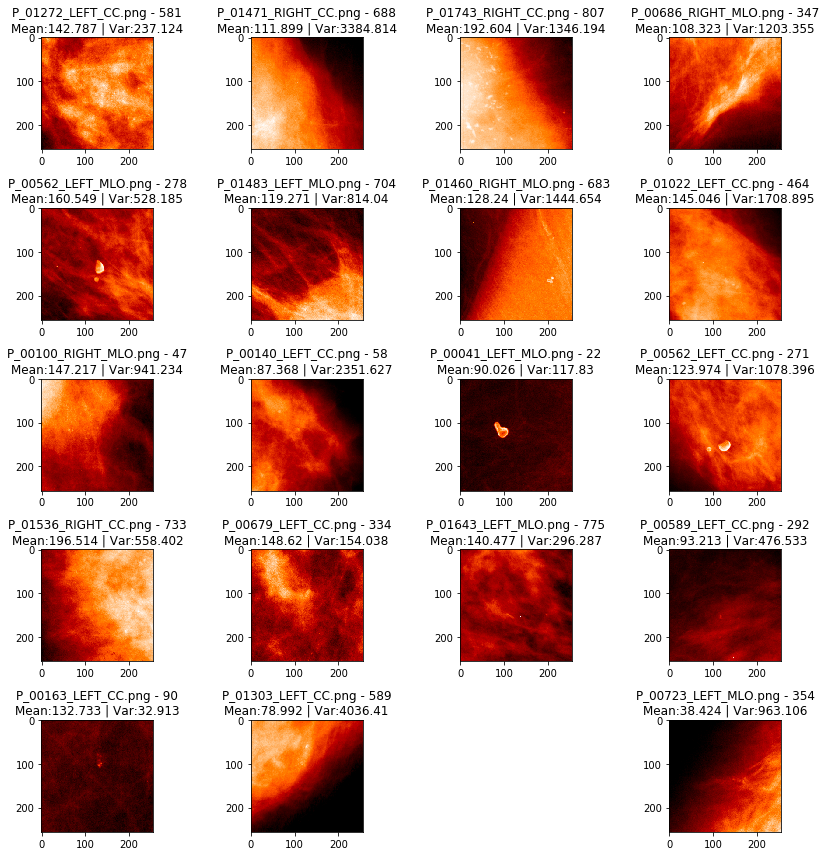

In [34]:
# random images 
N = 20
idx = random.sample(range(len(test_calc_patch)), k=N)
plt.figure(figsize=(12,12))
for i, j in enumerate(idx):
    plt.subplot(5,4,i+1)
    plt.imshow(test_calc_patch[j].reshape(256, 256), cmap='gist_heat')
    plt.title(test_calc_FN[j] + " - " + str(j)+ "\n" + "Mean:" + str(round(np.mean(test_calc_patch[j]),3)) + " | Var:" + str(round(np.var(test_calc_patch[j]),3)))
    plt.tight_layout()
plt.show()

In [35]:
print("ROI Mean Size:", np.round(np.mean(test_calc_roi_size),2))
print("ROI Min Size:", np.min(test_calc_roi_size))
print("ROI Max Size:", np.max(test_calc_roi_size))
print("ROI Size Std:", np.round(np.std(test_calc_roi_size),2))

ROI Mean Size: 458.89
ROI Min Size: 41
ROI Max Size: 2249
ROI Size Std: 406.62


In [36]:
np.save(os.path.join("Processed_abnorm_256", "test_calc_patch.npy"), test_calc_patch)
np.save(os.path.join("Processed_abnorm_256", "test_calc_Lbl.npy"), np.array(test_calc_Lbl))
np.save(os.path.join("Processed_abnorm_256", "test_calc_FN.npy"), test_calc_FN)
np.save(os.path.join("Processed_abnorm_256", "test_calc_roi_size.npy"), np.array(test_calc_roi_size))

## Merge data

In [37]:
train_patch = np.concatenate([train_mass_patch, train_calc_patch], axis=0)
train_Lbl = np.concatenate([train_mass_Lbl, train_calc_Lbl], axis=0)
train_FN = np.concatenate([train_mass_FN, train_calc_FN], axis=0)

test_patch = np.concatenate([test_mass_patch, test_calc_patch], axis=0)
test_Lbl = np.concatenate([test_mass_Lbl, test_calc_Lbl], axis=0)
test_FN = np.concatenate([test_mass_FN, test_calc_FN], axis=0)

In [38]:
print("Train Patches:", train_patch.shape)
print("Train Lables:", train_Lbl.shape)
print("Train File Names:", train_FN.shape)

print("Test Patches:", test_patch.shape)
print("Test Lables:", test_Lbl.shape)
print("Test File Names:", test_FN.shape)

Train Patches: (8286, 256, 256, 1)
Train Lables: (8286,)
Train File Names: (8286,)
Test Patches: (1863, 256, 256, 1)
Test Lables: (1863,)
Test File Names: (1863,)


In [39]:
np.save(os.path.join("Processed_abnorm_256", "abnormal_train_patch.npy"), train_patch)
np.save(os.path.join("Processed_abnorm_256", "abnormal_train_Lbl.npy"), train_Lbl)
np.save(os.path.join("Processed_abnorm_256", "abnormal_train_FN.npy"), train_FN)

np.save(os.path.join("Processed_abnorm_256", "abnormal_test_patch.npy"), test_patch)
np.save(os.path.join("Processed_abnorm_256", "abnormal_test_Lbl.npy"), test_Lbl)
np.save(os.path.join("Processed_abnorm_256", "abnormal_test_FN.npy"), test_FN)

In [41]:
np.save(os.path.join("Processed_abnorm_256", "abnormal_all_roi_sizes.npy"), all_roi_sizes)